In [1]:
%pip install PyTDC

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install rdkit

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install pandas-flavor

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm #progress bar
import rdkit
from rdkit import Chem #Chemistry
from rdkit.Chem import rdMolDescriptors #molecular descriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
rdkit.__version__


/Users/NathanJiang/opt/anaconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'2023.03.2'

In [5]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [6]:
import xgboost
import sklearn
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split #ML training
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error #ML stats
#from yellowbrick.regressor import prediction_error, ResidualsPlot
from tdc.single_pred import ADME
from tdc.benchmark_group import admet_group
from tdc import BenchmarkGroup
import warnings
warnings.filterwarnings("ignore")

2023-07-14 13:05:23.088451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
group = admet_group(path = 'data/')
predictions_list_xgb = []
best_params_list_xgb = []
predictions_list_rf = []
predictions_list_svm = []
best_params_list_svm = []
predictions_list_adb = []
predictions_list_cnn = []

for seed in [1, 2, 3, 4, 5]:
    predictions_xgb = {}
    predictions_rf = {}
    predictions_svm = {}
    predictions_adb = {}
    predictions_cnn = {}

    benchmark = group.get('Solubility_AqSolDB')
    name = benchmark['name']
    train_val, test = benchmark['train_val'], benchmark['test']
    train, valid = group.get_train_valid_split(benchmark = name, split_type = 'default', seed = seed)

    PandasTools.AddMoleculeColumnToFrame(train, smilesCol='Drug')
    radius=2
    nBits=1024
    ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in train['ROMol']]
    ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
    ecfp6_bits = [list(l) for l in ECFP6]
    Y = train['Y']
    train = pd.DataFrame(ecfp6_bits, index = train.Drug, columns=ecfp6_name).reset_index(drop = False)
    train['Y'] = Y

    PandasTools.AddMoleculeColumnToFrame(benchmark['test'], smilesCol='Drug')
    radius=2
    nBits=1024
    ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in benchmark['test']['ROMol']]
    ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
    ecfp6_bits = [list(l) for l in ECFP6]
    Y = benchmark['test']['Y']
    benchmark['test'] = pd.DataFrame(ecfp6_bits, index = benchmark['test'].Drug, columns=ecfp6_name).reset_index(drop = False)
    benchmark['test']['Y'] = Y

    train_X = train.drop(columns = ["Drug","Y"])
    train_y = train.Y
    test_X = benchmark['test'].drop(columns = ["Drug","Y"])
    test_y = benchmark['test'].Y


    #XGBoost + Morgan
    xgb_parameters = {'objective':['reg:squarederror'],
            'booster':['gbtree','gblinear'],
            'learning_rate': [0.1],
            'max_depth': [7,10,15,20],
            'min_child_weight': [10,15,20,25],
            'colsample_bytree': [0.8, 0.9, 1],
            'n_estimators': [300,400,500,600],
            "reg_alpha"   : [0.5,0.2,1],
            "reg_lambda"  : [2,3,5],
            "gamma"       : [1,2,3]}

    xgb_model = XGBRegressor()
    grid_obj_xgb = RandomizedSearchCV(xgb_model, xgb_parameters, cv=5, n_iter=15, scoring='neg_mean_absolute_error', verbose=5, n_jobs=1)
    grid_obj_xgb.fit(train_X, train_y, verbose = 1)
    y_pred_test_xgb = grid_obj_xgb.predict(test_X)
    bp_xgb = grid_obj_xgb.best_params_
    predictions_xgb[name] = y_pred_test_xgb
    predictions_list_xgb.append(predictions_xgb)
    best_params_list_xgb.append(bp_xgb)

    #Random Forest + Morgan
    rf_model = RandomForestRegressor()
    rf_model.fit(train_X, train_y)
    y_pred_test_rf = rf_model.predict(test_X)
    predictions_rf[name] = y_pred_test_rf
    predictions_list_rf.append(predictions_rf)

    #SVM + Morgan
    svm_parameters = {
        'C': [0.1, 1, 10, 100, 1000],
        'epsilon': [0.0001, 0.001, 0.01, 0.1, 0.5],
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
    }
    svm_model = SVR(kernel="rbf")
    grid_obj_svm = RandomizedSearchCV(svm_model, svm_parameters, cv=5, n_iter=15, scoring='neg_mean_absolute_error', verbose=5, n_jobs=1)
    grid_obj_svm.fit(train_X, train_y)
    y_pred_test_svm = grid_obj_svm.predict(test_X)
    bp_svm = grid_obj_svm.best_params_
    predictions_svm[name] = y_pred_test_svm
    predictions_list_svm.append(predictions_svm)
    best_params_list_svm.append(bp_svm)

    # AdaBoost + Morgan
    DTR = DecisionTreeRegressor(max_depth=4)
    adb_model = AdaBoostRegressor(n_estimators=300, base_estimator=DTR, learning_rate=1)
    adb_model.fit(train_X, train_y)
    y_pred_test_adb = adb_model.predict(test_X)
    predictions_adb[name] = y_pred_test_adb
    predictions_list_adb.append(predictions_adb)

    #CNN + Morgan
    train_X = train_X.to_numpy()
    test_X = test_X.to_numpy()
    train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
    test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)
    cnn_model = Sequential()
    cnn_model.add(Conv1D(32, 2, activation="relu", input_shape=(1024,1)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(64, activation="relu"))
    cnn_model.add(Dense(1))
    cnn_model.compile(loss="mse", optimizer="adam")
    cnn_model.fit(train_X, train_y, batch_size=12, epochs=10, verbose=0)
    y_pred_test_cnn = cnn_model.predict(test_X)
    predictions_cnn[name] = y_pred_test_cnn
    predictions_list_cnn.append(predictions_cnn)

xgb_results = group.evaluate_many(predictions_list_xgb)
rf_results = group.evaluate_many(predictions_list_rf)
svm_results = group.evaluate_many(predictions_list_svm)
adb_results = group.evaluate_many(predictions_list_adb)
cnn_results = group.evaluate_many(predictions_list_cnn)



Found local copy...
generating training, validation splits...
100%|██████████| 7985/7985 [00:01<00:00, 4375.35it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=15, min_child_weight=15, n_estimators=300, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=3;, score=-1.316 total time=  27.7s
[CV 2/5] END booster=gbtree, colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=15, min_child_weight=15, n_estimators=300, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=3;, score=-1.326 total time=  27.1s
[CV 3/5] END booster=gbtree, colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=15, min_child_weight=15, n_estimators=300, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=3;, score=-1.119 total time=  27.2s
[CV 4/5] END booster=gbtree, colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=15, min_child_weight=15, n_estimators=300, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=3;, score=-1.168 total time=  26.4s
[CV 5/5] END booster=gbtree, colsample_bytree=0.9, 

2023-07-10 23:58:24.210512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


63/63 [==============================] - 0s 2ms/step


generating training, validation splits...
100%|██████████| 7985/7985 [00:01<00:00, 4543.90it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[23:59:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 1/5] END booster=gblinear, colsample_bytree=1, gamma=3, learning_rate=0.1, max_depth=15, min_child_weight=15, n_estimators=400, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=3;, score=-1.300 total time=   2.7s
[23:59:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 2/5] END booster=gblinear, colsample_bytree=1, gamma=3, learning_rate=0.1, max_depth=15, min_child_weight=15, n_estimators=400, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=3;, score=-1.560 total time=   2.6s
[23:59:23] WARNING: /Users/runn

generating training, validation splits...
100%|██████████| 7985/7985 [00:01<00:00, 4722.88it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=20, min_child_weight=10, n_estimators=400, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=5;, score=-1.100 total time=  34.3s
[CV 2/5] END booster=gbtree, colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=20, min_child_weight=10, n_estimators=400, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=5;, score=-1.056 total time=  35.7s
[CV 3/5] END booster=gbtree, colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=20, min_child_weight=10, n_estimators=400, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=5;, score=-1.268 total time=  35.4s
[CV 4/5] END booster=gbtree, colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=20, min_child_weight=10, n_estimators=400, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=5;, score=-1.143 total time=  35.6s
[CV 5/5] END booster=gbtree, colsample_bytree=0.8, 

generating training, validation splits...
100%|██████████| 7985/7985 [00:01<00:00, 4798.40it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END booster=gbtree, colsample_bytree=1, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=10, n_estimators=300, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=2;, score=-1.494 total time=  31.9s
[CV 2/5] END booster=gbtree, colsample_bytree=1, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=10, n_estimators=300, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=2;, score=-1.257 total time=  34.0s
[CV 3/5] END booster=gbtree, colsample_bytree=1, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=10, n_estimators=300, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=2;, score=-1.158 total time=  32.6s
[CV 4/5] END booster=gbtree, colsample_bytree=1, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=10, n_estimators=300, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=2;, score=-1.030 total time=  32.2s
[CV 5/5] END booster=gbtree, colsample_bytree=1, gamma=2, l

generating training, validation splits...
100%|██████████| 7985/7985 [00:01<00:00, 4855.93it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END booster=gbtree, colsample_bytree=1, gamma=3, learning_rate=0.1, max_depth=15, min_child_weight=25, n_estimators=600, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=2;, score=-1.454 total time=  34.1s
[CV 2/5] END booster=gbtree, colsample_bytree=1, gamma=3, learning_rate=0.1, max_depth=15, min_child_weight=25, n_estimators=600, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=2;, score=-1.109 total time=  35.5s
[CV 3/5] END booster=gbtree, colsample_bytree=1, gamma=3, learning_rate=0.1, max_depth=15, min_child_weight=25, n_estimators=600, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=2;, score=-1.070 total time=  35.1s
[CV 4/5] END booster=gbtree, colsample_bytree=1, gamma=3, learning_rate=0.1, max_depth=15, min_child_weight=25, n_estimators=600, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=2;, score=-0.907 total time=  34.6s
[CV 5/5] END booster=gbtree, colsample_bytree=1, gamma=3, l

In [11]:
xgb_results

{'solubility_aqsoldb': [1.245, 0.034]}

In [12]:
rf_results

{'solubility_aqsoldb': [1.431, 0.03]}

In [13]:
svm_results

{'solubility_aqsoldb': [1.223, 0.025]}

In [14]:
adb_results

{'solubility_aqsoldb': [1.653, 0.036]}

In [15]:
cnn_results

{'solubility_aqsoldb': [1.292, 0.023]}

In [16]:
np.set_printoptions(threshold=np.inf)

In [7]:
predictions_list_xgb = [{'solubility_aqsoldb': np.array([-2.4193451 , -4.3692307 , -2.312333  , -1.9496624 , -4.447319  ,
         -3.596621  , -5.1627445 , -3.2147326 , -3.8309555 , -5.109423  ,
         -3.7149844 , -3.4935317 , -4.649829  , -4.087109  , -3.3854375 ,
         -3.9711373 , -2.7330163 , -2.187438  , -2.0864978 , -5.2395296 ,
         -5.2113137 , -3.1004863 , -1.7335635 , -2.3003566 , -1.7844518 ,
         -3.5040374 , -3.9051971 , -0.82805914, -5.466029  , -2.6780543 ,
         -1.3987768 , -5.7936687 , -2.823284  , -2.0074346 , -3.3530374 ,
         -2.362719  , -4.6920166 , -3.2782707 , -1.6415291 , -2.5240538 ,
         -4.515091  , -2.7743633 , -4.288121  , -0.73672706, -2.9603777 ,
         -4.628324  , -3.2496624 , -2.639049  , -1.5665694 , -2.2408817 ,
         -1.5704367 , -3.0714183 , -1.8644426 , -2.3382232 , -2.3187613 ,
         -2.5160522 , -1.1505628 , -1.1255184 , -2.1076672 , -1.5679389 ,
         -0.89355123, -2.0748866 , -0.99958766, -5.2632604 , -2.4517171 ,
         -1.3256849 , -1.6752868 , -2.1166885 , -2.4611769 , -4.169899  ,
         -1.8060894 , -3.5137327 , -3.5353398 , -1.5147808 , -3.7840128 ,
         -3.7840128 , -3.6625566 , -3.6625566 , -2.4042833 , -2.9149113 ,
         -3.4703288 , -2.5311055 , -2.6106389 , -2.7804585 , -3.38472   ,
         -2.5417483 , -2.799277  , -2.67844   , -2.0182385 , -1.948904  ,
         -3.5659077 , -0.3160143 , -4.30919   , -2.5127447 , -0.9986043 ,
         -1.6325108 , -2.233136  , -2.5848117 , -3.4455411 , -2.024028  ,
         -5.36609   , -4.764626  , -1.1000236 , -0.2089439 , -3.49259   ,
         -5.3123813 , -5.1928196 , -6.0674443 , -5.3695316 , -2.6491413 ,
         -1.3789202 , -1.3885777 , -1.5528333 , -0.5992808 , -4.386315  ,
         -5.116032  , -3.495311  , -3.3713267 , -1.0722897 , -2.0721972 ,
         -0.8666218 , -2.7283373 , -2.2654333 , -4.0174274 , -4.2410865 ,
         -0.8903301 , -1.9522315 , -1.4908401 , -2.292884  , -2.8089533 ,
         -2.6833143 , -0.93288946, -1.5066704 , -2.0864313 , -2.9526908 ,
         -6.053007  , -6.382574  , -3.2124996 , -2.9115758 , -3.1851716 ,
         -4.806886  , -2.6323154 , -5.5590134 , -3.614204  , -2.8019514 ,
         -5.865607  , -2.6064942 , -2.9032898 , -2.7775092 , -3.2786582 ,
         -3.6469326 , -1.1145821 , -2.390311  , -5.141231  , -6.455949  ,
         -6.527012  , -3.106685  , -3.6834207 , -2.748066  , -1.6652817 ,
         -6.2565975 , -4.4319167 , -6.1531935 , -3.5717225 , -1.508545  ,
         -1.0512686 , -2.119495  , -3.6105204 , -2.9880335 , -3.159318  ,
         -3.4778442 , -6.0036316 , -3.0163715 , -2.5372887 , -1.4141105 ,
         -2.8093562 , -2.3421874 , -4.447518  , -1.9216902 , -1.2902707 ,
         -6.5389953 , -0.280815  , -1.5528462 , -2.891211  , -1.7919844 ,
         -0.4091035 , -0.9549717 , -2.1859014 , -3.722385  , -2.8488057 ,
         -2.0259466 , -1.5039965 , -3.0496619 , -0.26233608, -0.26597053,
         -2.2584307 , -1.2357986 , -4.2232637 , -1.4126979 , -1.5583669 ,
         -3.5485046 , -2.9841015 , -4.3116794 , -3.0828133 , -3.8992298 ,
         -1.7285496 , -4.401267  , -0.93875414, -3.2180908 , -4.2676845 ,
         -0.5931476 , -3.0033643 , -0.08673318, -1.6153427 , -0.746756  ,
         -2.795912  , -3.6463056 , -3.5082881 , -2.1908963 , -4.2237115 ,
         -4.300296  , -7.0828185 , -5.0375504 , -2.2741013 , -1.7310284 ,
         -2.2741013 , -2.2299488 , -2.5460994 , -1.8195063 , -1.8195063 ,
         -1.961651  , -1.961651  , -2.3842607 , -1.8870736 , -2.4528804 ,
         -2.2741013 , -2.2299488 , -1.8870736 , -2.4528804 , -1.7310284 ,
         -0.2136336 , -3.2630754 , -2.9643912 , -3.4372425 , -2.893632  ,
         -2.893632  ,  0.41026714, -4.116583  , -4.2277913 , -1.6883227 ,
         -0.45718813, -4.7281775 , -2.0536256 , -1.5013745 , -5.8589797 ,
         -2.4044514 , -3.316625  , -8.032643  , -5.261595  , -3.264143  ,
         -4.1379    , -3.2673879 , -4.211699  , -3.4897835 , -4.1379    ,
         -4.1379    , -4.9753985 , -4.1379    , -4.934614  , -4.704232  ,
         -3.264143  , -2.98131   , -4.379235  , -3.0931914 , -4.306825  ,
         -3.4711363 , -5.874677  , -4.2448964 , -2.0676117 , -3.391256  ,
         -3.680682  , -3.8966067 , -2.2285788 , -5.4065666 , -6.4404488 ,
         -4.058976  , -3.6849701 , -3.1927185 , -3.9557848 , -3.067491  ,
         -3.574212  , -3.287131  , -3.0605986 , -3.3451028 , -5.9871783 ,
         -5.4638577 , -3.9492543 , -4.6777706 , -5.1371756 , -3.889547  ,
         -5.6948466 , -4.7286997 , -6.797281  , -3.1806798 , -3.9032028 ,
         -3.2113848 , -4.9486923 , -4.7694774 , -3.3095713 , -3.7061977 ,
         -4.4536905 , -3.9017668 , -4.6109977 , -5.338569  , -4.633641  ,
         -4.8321233 , -5.3048344 , -5.1367726 , -2.9627702 , -3.7038538 ,
         -4.964642  , -5.301671  , -3.9473433 , -5.696763  , -3.9788177 ,
         -4.3559194 , -4.537649  , -2.420956  , -1.78293   , -7.2693834 ,
         -5.3331537 , -3.3512359 , -4.4576674 , -4.306938  , -3.300795  ,
         -4.516678  , -3.5072227 , -3.7147028 , -4.5601664 , -3.300795  ,
         -2.8155956 , -5.0856724 , -3.3303971 , -5.4448113 , -4.705768  ,
         -6.0835066 , -4.064624  , -3.9659762 , -2.4711366 , -2.29215   ,
         -3.7865164 , -4.8471622 , -2.487485  , -3.9746292 , -5.7456956 ,
         -3.9478362 , -4.6746454 , -4.699242  , -3.6035557 , -6.172117  ,
         -1.3692545 , -4.1675673 , -4.246271  , -3.4437296 , -2.478942  ,
         -2.5981264 , -2.722631  , -3.738379  , -4.1716533 , -4.5898504 ,
         -3.899508  , -1.5949864 , -5.569898  , -3.8332944 , -4.549193  ,
         -5.208126  , -4.134449  , -4.2076187 , -4.4926686 , -4.329234  ,
         -3.2855678 , -3.972702  , -4.574737  , -4.032024  , -4.575281  ,
         -3.1493514 , -2.8335674 , -2.308819  , -3.4102867 , -4.71723   ,
         -5.165999  , -6.44072   , -5.6386085 , -5.3331537 , -4.4810777 ,
         -5.0940385 , -7.1117163 , -2.848948  , -4.9539814 , -5.4252853 ,
         -4.327119  , -4.959471  , -5.7767525 , -4.4341493 , -4.961564  ,
         -2.4117951 , -5.854832  , -2.0442038 , -7.663016  , -1.2394114 ,
         -3.9949346 , -2.6667042 , -4.5619464 , -5.633875  , -3.526781  ,
         -3.2982154 , -3.2672615 , -2.6996684 , -4.0075707 , -2.11034   ,
         -5.40979   , -3.8699687 , -4.6334496 , -4.4385524 , -1.4312207 ,
         -4.887244  , -5.022392  , -2.1247299 , -1.0168844 , -4.1697383 ,
         -3.8034778 , -3.096196  , -1.6446218 , -1.7777468 , -2.5772002 ,
         -2.2484162 , -2.2340894 , -1.6880542 , -4.7601013 , -2.259179  ,
         -2.9031918 , -3.316625  , -2.2321012 , -1.5177759 , -4.0414243 ,
         -3.2392812 , -3.461896  , -1.6383204 , -2.9783678 , -2.4111004 ,
         -6.3841124 , -6.9011116 , -1.7550851 , -2.1433268 , -2.9933872 ,
         -2.7680316 , -3.4710119 , -1.1003412 , -4.417487  , -1.2265953 ,
         -2.5862799 , -4.148265  , -1.3917477 , -4.1764774 , -4.833471  ,
         -6.166109  , -5.8983974 , -4.9441257 , -4.7030196 , -6.6941533 ,
         -5.637424  , -4.694166  , -6.0506883 , -6.2138486 , -5.650658  ,
         -4.5843515 , -5.3814645 , -4.9933977 , -6.2789583 , -4.9670377 ,
         -6.4629083 , -5.658223  , -3.778802  , -6.643829  , -6.27988   ,
         -6.5270853 , -4.935407  , -4.4408855 , -5.133569  , -4.4050536 ,
         -5.885659  , -5.5122695 , -6.048224  , -4.4479074 , -6.7737308 ,
         -6.2101865 , -5.0934114 , -6.380149  , -6.6627946 , -5.5601697 ,
         -5.0240026 , -5.4464974 , -5.2733912 , -4.8195353 , -5.5641036 ,
         -5.8093934 , -6.4554296 , -4.0293746 , -5.2543483 , -5.5550475 ,
         -4.971491  , -3.8206954 , -6.8009257 , -5.3202853 , -6.102748  ,
         -3.9879873 , -6.758543  , -6.1491876 , -3.9982774 , -5.3281016 ,
         -5.4969997 , -5.9900694 , -3.8131652 , -3.2269328 , -5.8406844 ,
         -6.095265  , -5.4961677 , -6.02582   , -5.998902  , -1.7628479 ,
         -6.080565  , -6.244968  , -6.1767025 , -5.758826  , -5.9946604 ,
         -6.1843743 , -5.602064  , -6.300163  , -5.075253  , -6.2226067 ,
         -6.55576   , -6.0191226 , -5.8187933 , -5.691762  , -5.9540987 ,
         -5.97578   , -3.9303076 , -5.6290927 , -6.6225057 , -4.4707193 ,
         -5.3252435 , -6.703236  , -5.7623644 , -4.078326  , -5.9324102 ,
         -4.3877134 , -5.919804  , -6.124394  , -4.432092  , -5.0512867 ,
         -5.72751   , -7.0664506 , -5.526676  , -4.967104  , -4.5492077 ,
         -4.741365  , -2.7618515 , -4.205351  , -4.876639  , -2.3288498 ,
         -4.9930606 , -5.5292463 , -4.6091523 , -5.308393  , -4.076129  ,
         -4.2907925 , -4.4803543 , -4.866107  , -3.5228937 , -4.2497354 ,
         -2.3456657 , -5.9268312 , -3.8688202 , -5.2737083 , -5.3859234 ,
         -3.4860532 , -3.164704  , -4.2906218 , -4.5757365 , -4.88293   ,
         -5.455546  , -5.399694  , -6.3804307 , -4.7862773 , -2.6764588 ,
         -5.418031  , -4.4617367 , -4.877711  , -5.5161424 , -4.5238295 ,
         -1.7467443 , -6.318401  , -5.4596934 , -2.1551862 , -1.8234215 ,
         -1.8234215 , -3.8054833 , -2.6912768 , -2.325493  , -2.2425554 ,
         -5.287834  , -4.573645  , -1.1858995 , -2.7927327 , -2.385386  ,
         -2.3746881 , -1.556829  , -3.2527423 , -2.1224859 , -3.0749385 ,
         -2.8711581 , -3.8299081 , -4.1372437 , -2.555394  , -0.4877875 ,
         -1.7026947 , -2.7662225 , -2.125134  , -2.4834204 , -2.1638956 ,
         -4.150121  , -3.5527666 , -3.9486938 , -0.5377486 , -0.7646234 ,
         -3.858261  , -4.8675413 , -4.382197  , -0.7646234 , -3.9511182 ,
         -2.6509416 , -2.073828  , -2.8046792 , -4.2789865 , -2.672864  ,
         -4.0872154 , -2.9714725 , -2.9714725 , -4.644409  , -5.560387  ,
         -3.7642567 , -1.0110493 , -3.3690255 , -2.129231  , -4.2091317 ,
         -4.446799  , -3.5948048 , -4.446799  , -3.3507664 , -3.6297548 ,
         -3.0971658 , -2.3207412 , -3.6819217 , -1.0772889 , -2.2660246 ,
         -4.598685  , -0.9755507 , -0.72545016, -6.130939  , -3.3991313 ,
         -5.2627993 , -5.562069  , -1.5834864 , -2.7682035 , -3.1747158 ,
         -3.3919272 , -2.3796356 , -3.7192583 , -1.2678033 , -1.1441964 ,
         -8.724657  , -8.578637  , -8.8282585 , -8.589677  , -8.4168215 ,
         -8.95257   , -5.80688   , -9.032055  , -9.158743  , -3.7080367 ,
         -1.3246808 , -3.471619  , -2.8845527 , -2.7099268 , -2.9223866 ,
         -2.3528423 , -2.3908303 , -2.0450358 , -2.7366421 , -3.5635538 ,
         -2.2613354 , -2.7061443 , -2.7952428 , -3.1934805 , -1.9662831 ,
         -2.2607865 , -2.3149238 , -2.8562865 , -3.2209044 , -3.1623032 ,
         -2.577647  , -2.4818623 , -2.3885095 , -3.3356404 , -2.881565  ,
         -3.2791753 , -2.9760447 , -2.1348753 , -2.9933352 , -3.4224734 ,
         -3.4084184 , -2.2615292 , -2.2667105 , -3.5317717 , -4.6133075 ,
         -2.3359249 , -2.5833185 , -3.5378501 , -1.8743637 , -4.113742  ,
         -2.539998  , -1.5471556 , -2.9528816 , -1.8491741 , -0.10312011,
         -4.5075784 , -3.9575732 , -1.3224258 , -3.8911545 , -3.4664695 ,
         -4.701075  , -4.548144  , -1.4196787 , -3.700783  , -3.1184394 ,
         -3.6593702 , -3.3546376 , -3.373117  , -3.626203  , -3.073118  ,
         -3.833269  , -2.803963  , -2.7542238 , -2.7055612 , -2.049882  ,
         -4.8259606 , -2.3678417 , -3.9439173 , -4.578524  , -4.7864647 ,
         -4.4076986 , -4.580432  , -3.4561808 , -5.158443  , -1.7714276 ,
         -3.009992  , -4.3285065 , -3.391921  , -4.4641232 , -4.569291  ,
         -3.3301096 , -3.803599  , -2.3127294 , -3.4716537 , -3.7192717 ,
         -3.1172984 , -4.236852  , -2.7358549 , -6.2659473 , -5.7682924 ,
         -5.179148  , -5.7682924 , -2.14176   , -1.155326  , -3.0310888 ,
         -1.3050448 , -3.6087897 , -2.62041   , -2.1513004 , -1.7350248 ,
         -2.4390345 , -1.2044697 , -2.3016486 , -2.044632  , -3.9276016 ,
         -2.2894616 , -1.6056436 , -1.565059  , -0.9812275 , -1.7209833 ,
         -1.7937984 , -2.9522002 , -2.9522002 , -4.174883  , -1.8700477 ,
         -3.2476046 , -4.6502404 , -4.3158674 , -4.06393   , -4.707474  ,
         -4.4847164 , -3.8169312 , -2.7429392 , -3.4697406 , -1.358139  ,
         -1.5934583 , -3.5958352 , -2.5745685 , -2.1576822 , -2.6382115 ,
         -5.6986623 , -1.3917477 , -7.2744174 , -7.236227  , -7.6514597 ,
         -1.8072046 , -5.0228906 , -1.7961006 , -1.5274915 , -4.2132497 ,
         -1.6354896 , -3.7317867 , -1.7871763 , -5.45169   , -3.597024  ,
         -3.5636683 , -7.767201  , -2.3317118 , -3.489227  , -2.863113  ,
         -2.6263316 , -2.240652  , -1.7600597 , -3.9963477 , -4.6421776 ,
         -4.0403695 , -2.9811175 , -4.9780273 , -4.4794316 , -4.958687  ,
         -5.039764  , -1.2886504 , -0.6299019 , -2.7688053 , -2.4414072 ,
         -1.5190232 , -1.5190232 , -2.5587554 , -2.8257403 , -3.0502613 ,
         -2.579889  , -4.6646214 , -2.8862503 , -3.964068  , -4.930113  ,
         -4.237203  , -3.964068  , -4.009136  , -4.6204095 , -3.2895172 ,
         -4.586271  , -3.1072545 , -3.5050063 , -4.237203  , -4.0467753 ,
         -4.425969  , -3.5050063 , -5.2063365 , -3.4544652 , -3.8628576 ,
         -3.606899  , -3.1072545 , -3.964068  , -3.8628576 , -3.2895172 ,
         -4.586271  , -4.6204095 , -4.68655   , -4.0467753 , -4.68655   ,
         -4.5507207 , -4.634921  , -1.5798124 , -2.052225  , -3.9247053 ,
         -4.6138296 , -4.6138296 , -4.9312954 , -4.4985924 , -4.7200537 ,
         -6.225608  , -4.4985924 , -5.517133  , -1.336833  , -3.0623393 ,
         -2.6528888 , -4.482844  , -4.8535852 , -2.7744775 , -3.0108001 ,
         -3.2787633 , -3.1114213 , -3.0970058 , -3.0061035 , -1.1610749 ,
         -2.2880297 , -2.5113392 , -0.35530472, -2.4456885 , -2.2751791 ,
         -1.654009  , -2.5890522 , -2.359399  , -1.9253334 , -4.696799  ,
         -2.7065477 , -1.4584477 ,  0.818637  , -5.332743  , -3.3238313 ,
         -2.4547067 , -3.0191383 , -1.6601235 , -1.2648681 , -0.7685807 ,
         -2.6054087 , -2.856728  , -5.332743  , -0.7082857 , -1.9761463 ,
         -4.398036  , -0.41155544, -4.398036  , -4.398036  , -4.398036  ,
         -4.398036  , -4.398036  ,  0.03248139, -0.15190144, -4.742363  ,
         -2.5812144 , -0.67210776, -5.332743  , -0.7037883 , -0.29352236,
         -2.4400036 , -5.4472227 , -2.8376203 , -2.5800517 , -1.3730808 ,
         -3.4522176 , -3.4311142 , -1.6827993 , -5.332743  , -0.39373404,
         -1.0383973 , -5.332743  , -1.4052734 , -1.3082716 , -2.3147857 ,
         -4.398036  , -2.3428683 , -1.9989874 , -1.6274357 , -0.44519874,
         -1.1873018 , -2.3215659 , -3.3756876 , -2.4658616 , -2.1338165 ,
         -1.4502491 , -1.5046853 , -2.7693403 , -4.0771084 , -1.8888234 ,
         -4.578767  , -2.2547748 , -4.578767  , -3.6009488 , -2.026508  ,
         -2.599124  , -3.4310102 , -4.578767  , -1.2160544 , -1.1262695 ,
         -1.6943573 , -1.9807516 , -4.578767  , -1.5591649 , -2.2949145 ,
         -2.5522947 , -1.8903537 , -1.3347405 , -2.8153038 , -2.4939785 ,
         -2.6865003 , -0.73845536, -0.37517872, -2.0798428 , -0.7648132 ,
         -2.4648383 , -1.71641   , -1.7190369 , -1.982937  , -2.0188975 ,
         -5.9525013 , -2.2661014 , -4.710773  , -2.15231   , -6.365721  ,
         -2.605223  , -1.2592717 , -3.862061  , -0.58444375, -0.77996004,
         -2.7881968 , -5.900149  , -4.154042  , -3.5568645 , -2.2425117 ,
         -3.6200986 , -3.4898806 , -3.4690442 , -3.4690442 , -2.1056776 ,
         -3.6705856 , -0.84405476, -4.633758  , -2.136225  , -2.0300992 ,
          1.0105407 , -2.619135  , -2.5673401 , -0.30133456, -1.2685074 ,
         -5.1812577 , -4.0325737 ,  0.00961478, -4.688914  ,  0.1940686 ,
         -0.66033804, -0.8841729 , -2.9228048 , -0.97851545, -1.1476417 ,
          0.00961478, -0.3639851 , -3.3015172 ,  0.28544655, -3.3015172 ,
         -3.3015172 , -2.1536503 , -2.2151833 , -4.8560195 , -6.816009  ,
         -3.915428  , -3.915428  , -4.614344  , -4.6337996 , -1.0378015 ,
         -4.657715  , -2.659837  , -3.5666401 , -7.6686516 , -5.640303  ,
         -3.4880636 , -2.1529388 , -3.4538617 , -2.4410808 , -1.7633232 ,
         -3.036413  , -2.267745  , -3.5302303 , -3.5826657 , -2.6507573 ,
         -2.5987287 , -2.5706146 , -2.9865568 , -2.8480604 , -2.745622  ,
         -2.347428  , -2.7136915 , -2.90377   , -2.1927173 , -2.545467  ,
         -2.8909364 , -3.9065275 , -3.1380813 , -2.7568893 , -2.2766414 ,
         -2.5353599 , -3.1894362 , -3.503923  , -0.46287513, -1.0143911 ,
         -1.8357564 , -1.1604306 , -3.6838155 , -1.5914408 , -1.4629778 ,
         -0.5353187 , -2.5365157 , -1.8357564 , -1.8484606 , -0.5353187 ,
         -7.5448394 , -3.4975195 , -4.227566  , -3.6731746 , -1.6437547 ,
         -2.8220627 , -3.8305292 , -6.2269464 , -1.2227703 , -5.5598707 ,
         -2.3695264 , -5.611314  , -4.7291727 , -4.0900135 , -5.1757736 ,
         -4.19011   , -4.3958273 , -2.695025  , -3.5442774 , -1.7991856 ,
         -4.5384727 , -4.1700125 , -1.2386599 , -0.9051652 , -1.7206076 ,
         -5.6420484 , -2.7622056 , -0.730982  , -1.819878  , -5.6420484 ,
         -0.92104983, -4.5756774 , -1.4982377 , -2.2483284 , -2.0951874 ,
         -1.652764  , -2.267903  , -3.7919784 , -4.052947  , -3.7138715 ,
         -1.730569  , -2.2913399 , -3.3677928 , -2.327265  , -2.4506388 ,
         -1.4912019 , -3.5187967 , -0.92107916, -0.5028323 , -0.84266794,
         -2.6823125 , -3.031044  , -3.4857888 , -3.0433142 , -3.0433142 ,
         -4.06497   , -5.2404366 , -1.6877946 , -2.415597  , -3.0320992 ,
         -3.4491897 , -2.4748333 , -2.8207493 , -2.6045666 , -3.094948  ,
         -3.409969  , -3.360437  , -2.5381608 , -0.8043267 , -3.4889998 ,
         -2.8175256 , -3.3545456 , -1.789822  , -2.8662684 , -2.9605684 ,
         -2.2331345 , -3.6708617 , -3.2158346 , -0.8966592 , -2.0176024 ,
         -3.5624928 , -2.8524668 , -2.0943685 , -2.0402    , -2.3021402 ,
         -2.922402  , -2.9623852 , -3.8168385 , -2.867158  , -0.83214366,
         -2.6522465 , -3.4281511 , -4.0180364 , -2.6943564 , -2.1884468 ,
         -2.9514918 , -3.2954113 , -2.9769185 , -3.5880764 , -3.4270082 ,
         -3.7474723 , -1.8664387 , -1.8155794 , -6.8126497 , -4.1018457 ,
         -2.7402997 , -6.9244075 , -1.7274715 , -0.4472203 , -3.4289627 ,
         -2.0749002 , -1.1154594 , -2.1873746 , -2.6370692 , -0.4937622 ,
         -1.6561035 , -0.8771219 , -1.3757111 , -2.879337  , -1.1794579 ,
         -3.715707  , -2.7045054 , -5.8457923 , -5.7331195 , -2.292436  ,
         -0.93588096, -2.1724505 , -0.33696344, -3.6686704 , -2.9344628 ,
         -2.7357    , -4.4483767 , -2.7468483 , -1.1841471 , -2.008413  ,
         -2.627659  , -2.4160016 , -3.5373237 , -2.2214777 , -2.7733319 ,
         -2.795143  , -0.92838603, -1.0314742 , -2.1415403 , -2.2589793 ,
         -1.3232487 , -2.6749969 , -1.6952919 , -0.7303515 , -1.9574496 ,
         -2.9894114 , -3.355152  , -2.7733319 , -0.58444214, -3.6691298 ,
         -1.790031  , -1.1879854 , -0.88581437, -0.44278365, -0.28243783,
         -3.5059867 , -0.46807298, -2.4460747 , -2.4580631 , -1.8546237 ,
         -3.522476  , -2.7361968 , -4.1510735 , -2.7045054 , -1.5896876 ,
         -2.6122172 , -2.3017812 , -1.6657692 , -2.7518868 , -3.163299  ,
         -3.0631778 , -4.1804104 , -2.8869846 , -2.1346347 , -1.7321769 ,
         -1.7638273 , -2.4009855 , -0.93588096, -2.9088295 , -4.761913  ,
         -1.9088161 , -1.9044595 , -1.7493093 , -2.5889215 , -1.7638273 ,
         -0.56646526, -1.3956271 ,  0.43262553, -2.408639  , -3.1501763 ,
         -2.7045054 , -1.9301735 , -0.5286628 , -0.7346523 , -2.4030674 ,
         -4.1917076 , -4.707966  , -0.8428438 , -1.4899278 , -2.086892  ,
         -2.29536   , -1.3288019 , -2.9063704 , -3.277432  , -2.8339112 ,
         -3.777526  , -1.7638273 , -0.6698456 , -3.950658  , -1.4371871 ,
         -2.574463  , -2.1432512 , -1.7638273 , -2.161016  , -3.3558347 ,
         -4.554703  , -3.495311  , -3.05762   , -3.5012074 , -3.988777  ,
         -3.2820032 , -4.6928873 , -0.8849276 , -2.5765452 , -3.8445141 ,
         -3.2814174 , -3.712288  , -3.4679747 , -2.7667246 , -2.2962685 ,
         -0.42847863, -3.4639153 , -3.4679747 , -2.19124   , -2.7667246 ,
         -2.7667246 , -3.4679747 , -2.7919466 , -2.9526083 , -3.7339807 ,
         -1.2837882 , -0.87990135, -1.3917477 , -2.9872553 , -1.664441  ,
         -1.6359468 , -2.5862567 , -5.770402  , -0.92044294, -1.1408952 ,
          0.01040409, -0.2990714 , -0.2666883 , -0.24763481, -1.9729489 ,
         -0.7404943 , -1.8539352 , -5.7435436 , -1.9377385 , -6.2742    ,
         -5.7435436 , -0.7323591 ,  0.9531045 , -4.780432  , -7.443271  ,
         -1.3490076 , -3.3499613 , -2.3066537 , -4.2259827 , -1.9656049 ,
         -5.0704775 , -5.191767  , -3.7105489 , -4.547495  , -3.4084096 ,
         -3.7626944 , -3.6017835 , -3.6056418 , -0.76429737, -1.4490529 ,
         -3.6645193 , -1.9178343 , -5.339546  , -2.4246807 , -2.668477  ,
         -1.9180244 , -0.98034775, -5.442289  , -2.7065382 , -4.3117957 ,
         -3.7262385 , -1.9120795 , -1.6515411 , -5.08058   , -1.9341121 ,
         -3.2209036 , -2.2142975 , -2.9575608 , -2.2964728 , -1.8185602 ,
         -1.6493154 , -2.3807986 , -2.0407453 , -2.017769  , -3.187022  ,
         -3.2062755 , -5.835087  , -4.8936167 , -3.503963  , -4.2046294 ,
         -4.4446855 , -3.4291177 , -2.9485142 , -2.965027  , -2.8348558 ,
         -1.9877461 , -2.0041568 , -1.3917477 , -6.0383024 , -1.5546    ,
         -0.6026995 , -3.187676  , -2.8228953 , -2.8228953 , -2.0619223 ,
         -1.7604742 , -1.7132609 , -2.417523  , -1.1583639 , -3.7888339 ,
         -6.736794  , -7.9771647 , -6.5084543 , -3.7365975 , -2.2870839 ,
         -6.8780494 , -3.6322348 , -6.464877  , -6.729646  , -3.6250873 ,
         -1.2479554 , -5.75915   , -6.9701552 , -0.68886095, -0.43725985,
          0.648139  , -3.9373894 , -3.5076106 , -4.2278085 , -1.4213914 ,
         -3.244619  , -5.458306  , -4.977308  , -5.7030797 , -3.7960184 ,
         -4.7460666 , -5.183048  , -2.801814  , -3.2266161 , -0.90061873,
         -4.8552346 , -3.3425748 , -4.826102  , -3.68347   , -2.6458125 ,
         -5.517057  , -4.4929595 , -4.416578  , -4.035106  , -2.7252789 ,
         -1.534325  , -2.8730419 , -3.810151  , -3.4072194 , -3.502162  ,
         -2.6223166 , -1.4515257 , -2.9135394 , -1.1499587 , -5.477383  ,
         -1.4001213 , -1.1499587 , -0.2804713 , -5.390774  , -0.822016  ,
         -3.6509557 , -2.126916  , -1.8593229 , -2.5595815 , -0.7879322 ,
         -2.716108  , -2.165146  , -2.165146  , -2.6983776 , -1.6728735 ,
         -2.8883817 , -2.3332744 , -2.089795  , -1.5236274 , -3.387207  ,
         -5.596135  , -3.2004633 , -2.1568365 , -5.596135  , -3.6263525 ,
         -3.2594802 , -3.5962574 , -1.5800244 , -4.3790045 , -3.3480196 ,
         -2.219373  , -2.4706972 , -2.8647044 , -2.9419577 , -3.4448495 ,
         -0.73602515,  0.05240702, -2.4317374 , -1.9360588 , -2.1613882 ,
         -2.2639396 , -4.5757847 , -3.5538006 , -2.0210812 , -4.349362  ,
         -3.8873663 , -3.5945501 , -4.1836433 , -2.7631946 , -2.788938  ,
         -3.709201  , -3.973223  , -5.9978805 , -2.0415568 , -2.4220963 ,
         -2.2361894 , -2.3062055 , -4.203244  , -2.7410502 , -3.3400426 ,
         -3.2197645 , -2.463682  , -3.1461124 , -2.3441303 , -2.6738758 ,
         -2.0924013 , -1.8664085 , -3.3384423 , -4.1096454 , -2.6827545 ,
         -1.8211066 , -1.8574718 , -3.6847796 , -1.0833657 , -2.0147586 ,
         -4.2733965 , -4.570638  , -5.03218   , -2.8883033 , -2.6050487 ,
         -3.1970537 , -3.1970537 , -3.6357758 , -2.657456  , -3.1809416 ,
         -1.2183807 , -1.8254108 , -3.3953724 , -1.3778298 , -2.731085  ,
         -3.5888696 , -4.158826  , -5.2919407 , -3.1610758 , -4.7135935 ,
         -2.6725159 , -3.1360357 , -3.3510287 , -5.2886176 , -3.771585  ,
         -4.9533296 , -2.840104  , -4.119109  , -3.5750587 , -1.9077462 ,
         -5.9856524 , -6.369371  , -0.21467225, -3.182708  , -3.2162857 ,
         -2.7145584 , -2.857148  , -2.8374124 , -4.4402046 , -3.7905474 ,
         -2.1840198 , -3.9927232 , -2.0743191 , -2.8236384 , -2.4931183 ,
         -2.971598  , -5.8934817 , -1.2314228 , -4.128995  , -3.9032283 ,
         -3.4247277 , -3.8803992 , -3.7716906 , -2.7571075 , -4.3431005 ,
         -4.648421  , -4.3324127 , -3.7591605 , -4.902371  , -4.441472  ,
         -3.18233   , -4.8455324 , -3.8023486 , -3.3939104 , -3.1760695 ,
         -3.8619645 , -3.0922143 , -5.3869886 , -2.4973297 , -2.440869  ,
         -5.8753104 , -4.223272  , -4.742753  , -2.4845877 , -2.0554578 ,
         -4.0764885 , -0.8772847 , -4.4402046 , -4.4414806 , -3.9927232 ,
         -4.4402046 , -5.3327785 , -1.975787  , -2.7093995 , -2.8766181 ,
         -4.7403326 , -5.1725497 , -4.7047586 , -5.1436076 , -2.9863    ,
         -4.2171016 , -1.7484016 , -3.1346824 , -5.6971455 , -0.30359933,
         -2.3213818 , -2.2968025 , -1.2811496 , -2.5352283 , -3.6249537 ,
         -2.7872787 , -3.985247  , -2.3784764 , -2.3858323 , -1.9872472 ,
         -3.7490926 , -1.361804  , -3.9588914 , -3.289657  , -2.4950047 ,
         -1.78986   , -2.1759095 , -1.9715149 , -2.4676836 , -1.8532228 ,
         -2.3168707 , -2.5183077 , -2.0705214 , -3.5267887 , -2.5399764 ,
         -1.1147093 , -2.1519578 , -2.7557957 , -4.072507  , -1.8674042 ,
         -1.5669641 , -1.7445226 , -2.4741929 , -2.7208633 , -1.2189267 ,
         -2.5325978 , -2.0356858 , -5.2298317 , -2.0658326 , -1.7256472 ,
         -1.830515  , -0.75168294, -4.5099683 , -2.8039563 , -1.3438535 ,
         -3.3019712 , -2.6786697 , -3.552397  , -3.2800448 , -1.3738638 ,
         -1.5418531 , -2.2910938 , -1.162812  , -2.855657  , -2.245368  ,
         -1.792277  , -2.0545    , -0.9063865 , -3.8276587 , -2.434955  ,
         -1.9408717 , -1.7992144 , -2.3525114 , -3.5472949 , -0.9946703 ,
         -2.8123922 , -1.7744168 , -1.7744168 , -3.3104553 , -4.235852  ,
         -5.8724694 , -2.9994621 , -4.0934777 , -4.1634116 , -3.808508  ,
         -4.28597   , -1.5038455 , -4.9636874 , -5.6148314 , -4.374223  ,
         -4.9774485 , -3.1365623 , -3.5575411 , -2.381124  , -2.8662307 ,
         -3.8891783 , -3.7265592 , -5.932975  , -4.800909  , -2.5117345 ,
         -5.1256666 , -5.214124  , -4.535265  , -4.76934   , -3.497311  ,
         -1.8493624 , -1.9950246 , -3.3050873 , -2.8864894 , -1.7278007 ,
         -2.5423055 , -2.977188  , -2.4979246 , -0.74610686, -1.8792396 ,
         -1.5353436 , -1.2595762 , -1.7105895 , -1.2811081 , -1.35263   ,
         -3.0568547 , -3.370442  , -6.232933  , -3.8225787 , -1.551302  ,
         -4.967604  , -2.9701962 , -4.0503507 , -1.7613139 , -3.4362948 ,
         -3.3698168 , -3.7530272 , -2.0623643 , -1.924341  , -4.126191  ,
         -6.8278465 , -2.7743497 , -2.941684  , -1.922778  , -2.941684  ,
         -1.5317528 , -1.0856531 , -0.5030219 , -3.5524185 , -3.4079304 ,
         -4.7555504 , -4.8849325 , -4.5687327 , -5.721978  , -5.052908  ,
         -3.681822  , -3.1782758 , -9.09613   , -3.4019775 , -3.992421  ,
         -1.6059233 , -3.4565492 , -4.5270667 , -0.58722824, -3.4627514 ,
         -2.0784245 , -2.9820173 , -6.35928   , -2.7487173 , -2.2152195 ,
         -2.574862  , -3.303937  , -2.1619883 , -4.6601834 , -2.6832843 ,
         -3.9406192 , -4.012179  , -4.4663897 , -4.3350286 , -2.2115762 ,
         -5.5422435 , -1.6667008 , -2.3149993 , -2.6355577 , -1.8511406 ,
         -1.2116188 , -1.3281467 , -6.583449  , -2.8387234 , -1.2932359 ,
         -1.9906493 , -6.680099  , -3.890313  , -3.561873  , -3.4041977 ,
         -3.8756099 , -4.5439367 , -2.523962  , -2.325943  , -3.380371  ,
         -1.7926087 , -4.5525956 , -3.2355278 , -5.2747374 , -2.4253316 ,
         -2.7817192 , -5.5767455 , -2.9686882 , -1.9718628 , -3.5072634 ,
         -3.1915514 , -5.062627  , -2.522231  , -5.168297  , -1.5172808 ,
         -0.74508727, -1.5172808 , -0.37281817, -4.387749  , -5.010814  ,
         -1.9159533 , -3.6701593 , -3.8529024 , -4.982045  , -1.9905816 ,
         -2.800056  , -2.3363268 , -7.499834  , -7.315974  , -7.5821495 ,
         -4.0949783 ,  0.01310246, -1.7108868 , -2.1312613 , -1.6665666 ,
         -1.6335545 , -1.3173457 , -1.9413126 , -0.16014287,  0.15630162,
         -1.6665666 , -2.291686  , -4.580537  , -2.9088607 , -1.3299887 ,
         -2.7436147 , -1.8641788 , -0.911282  , -1.7808512 , -2.208276  ,
         -2.6981733 , -2.847091  , -4.835295  , -1.9888017 , -3.8716452 ,
         -3.4299095 , -4.947831  , -4.947831  , -3.284565  , -4.219068  ,
         -3.9929757 , -3.8182216 , -3.298069  , -3.3170357 , -3.3019547 ,
         -3.4562666 , -3.3593829 , -1.4015822 , -1.9908313 , -2.0773585 ,
         -1.9999702 , -4.857847  , -3.2073843 , -2.9804754 , -3.2608004 ,
         -4.0878587 , -3.1181717 , -2.4548519 , -3.31004   , -3.0383923 ,
         -3.3571877 , -4.161398  , -2.0187912 , -5.1940193 , -4.86027   ,
         -5.1169415 , -0.42296872, -3.3249118 , -3.7988074 , -4.023149  ,
         -2.6072776 , -1.3064003 , -3.8742294 , -3.8649018 , -2.4244652 ,
         -0.98050004, -1.9445912 , -2.1522398 , -2.6064544 , -1.6961254 ,
         -2.8691733 , -2.2185743 , -3.2895358 , -3.9185622 , -4.228616  ,
         -3.7884758 , -3.063234  , -2.213152  , -3.44861   , -2.414334  ,
         -2.3977718 , -3.0900056 , -1.473035  , -2.1683471 , -4.682596  ,
         -1.8565896 , -3.0686705 , -1.8509052 , -4.129346  , -3.415214  ,
         -4.5327067 , -3.4504058 , -4.6152153 , -3.8795156 , -5.2266245 ,
         -4.552377  , -4.7464504 , -3.5469844 , -4.887963  , -3.20036   ,
         -0.8661673 , -1.3159789 , -2.0153785 , -1.8958615 , -3.5799584 ,
         -3.6275682 , -2.8961625 , -3.4260588 , -3.9933815 , -3.811504  ,
         -4.223602  , -5.275072  ])},
 {'solubility_aqsoldb': np.array([-2.62715793e+00, -4.63737345e+00, -3.72165489e+00, -1.83771789e+00,
         -4.84473133e+00, -4.71040058e+00, -4.88970709e+00, -5.16668367e+00,
         -4.75520420e+00, -5.95151424e+00, -4.82144451e+00, -4.27874851e+00,
         -4.27827072e+00, -4.29992342e+00, -4.50595474e+00, -4.65328407e+00,
         -3.12994742e+00, -2.72099757e+00, -2.78501129e+00, -5.61047649e+00,
         -5.14100266e+00, -3.97874618e+00, -2.59416008e+00, -3.74169898e+00,
         -1.97811329e+00, -4.16701317e+00, -4.58178377e+00, -2.13873148e+00,
         -5.19836664e+00, -2.32401776e+00, -2.03506660e+00, -6.48132420e+00,
         -1.60974562e+00, -1.71413469e+00, -1.93541634e+00, -1.62696528e+00,
         -4.30236244e+00, -3.45793414e+00, -1.80100465e+00, -2.84820366e+00,
         -5.32016373e+00, -2.37652230e+00, -3.68761015e+00, -3.05351108e-01,
         -2.00308681e+00, -4.16588402e+00, -2.64912128e+00, -2.96813345e+00,
         -2.25523782e+00, -1.96090937e+00, -2.95536828e+00, -4.65770292e+00,
         -1.25672233e+00, -2.02790499e+00, -2.18170810e+00, -3.15782523e+00,
         -1.51481533e+00, -2.86218691e+00, -2.56561971e+00, -2.40036941e+00,
         -1.66408694e+00, -1.88702929e+00, -1.16417980e+00, -5.47645044e+00,
         -2.84885621e+00, -1.41010404e+00, -1.63101935e+00, -1.85968113e+00,
         -1.99417818e+00, -6.88029289e+00, -1.57017469e+00, -3.64578676e+00,
         -3.48019266e+00, -1.32484591e+00, -3.98521757e+00, -3.98521757e+00,
         -5.06863260e+00, -5.06863260e+00, -1.83317876e+00, -4.15949917e+00,
         -4.26037693e+00, -2.28068686e+00, -3.31199431e+00, -3.01860905e+00,
         -3.52571988e+00, -3.05866838e+00, -3.01647568e+00, -3.09747791e+00,
         -2.79318738e+00, -1.39120281e+00, -3.91700292e+00, -2.78928250e-01,
         -5.44001102e+00, -1.61834288e+00, -1.68212855e+00, -2.04066586e+00,
         -2.26900482e+00, -2.98458147e+00, -3.51765180e+00, -2.20486498e+00,
         -4.19974899e+00, -4.57974291e+00, -3.03720522e+00, -8.84717882e-01,
         -2.34752870e+00, -5.44906807e+00, -4.90484285e+00, -5.52542305e+00,
         -5.27481747e+00, -1.63206971e+00, -2.58966637e+00, -1.72605371e+00,
         -2.85965800e+00, -1.39801228e+00, -4.36873388e+00, -5.31652498e+00,
         -2.69581079e+00, -3.16525316e+00, -1.54555070e+00, -2.27287054e+00,
         -2.08044052e+00, -2.01384783e+00, -2.20589399e+00, -4.29500246e+00,
         -4.53827667e+00, -1.03322804e-01, -2.70258594e+00, -1.86927354e+00,
         -3.57197237e+00, -3.77696037e+00, -3.11928916e+00, -3.68949980e-01,
         -2.80290961e+00, -1.76116955e+00, -3.11084819e+00, -4.37175369e+00,
         -7.31683302e+00, -2.27158213e+00, -4.36569977e+00, -2.62469935e+00,
         -5.25247622e+00, -2.73033357e+00, -5.57300234e+00, -3.57777882e+00,
         -1.66691983e+00, -5.96713972e+00, -3.45751381e+00, -3.59073663e+00,
         -3.07211590e+00, -3.58621097e+00, -3.89199924e+00, -2.04172707e+00,
         -2.44193769e+00, -4.80098057e+00, -5.86835432e+00, -6.10395670e+00,
         -4.37205648e+00, -4.61679268e+00, -2.00218344e+00, -2.17656350e+00,
         -7.03105927e+00, -3.74608064e+00, -5.86403608e+00, -3.23022914e+00,
         -2.76757598e+00, -2.49086189e+00, -2.55151868e+00, -3.66733599e+00,
         -2.98641062e+00, -4.16520452e+00, -3.40870452e+00, -5.53400469e+00,
         -2.71287322e+00, -2.66871238e+00, -2.09241772e+00, -3.63297558e+00,
         -7.79470146e-01, -5.65823317e+00, -1.79017067e+00, -1.01613057e+00,
         -6.60622644e+00,  9.81882870e-01, -4.96048480e-01, -1.93062997e+00,
         -2.27957797e+00, -1.10133219e+00, -1.85331881e+00, -3.36102009e+00,
         -5.14055586e+00, -3.71690059e+00, -2.44237494e+00, -2.07284498e+00,
         -3.87405682e+00, -5.17216384e-01, -1.66707909e+00, -2.33906150e+00,
         -1.25391507e+00, -4.37148714e+00, -1.02775264e+00, -1.81628454e+00,
         -3.18775439e+00, -3.72706914e+00, -5.45688009e+00, -3.31718111e+00,
         -4.06316805e+00, -3.23324156e+00, -4.58153915e+00, -1.51239729e+00,
         -3.93129110e+00, -4.40269566e+00, -2.12562323e+00, -4.11564589e+00,
         -2.83552855e-01, -2.00420094e+00, -1.54719913e+00, -2.19445777e+00,
         -4.32565880e+00, -4.68650007e+00, -2.33347368e+00, -4.18191624e+00,
         -4.70580101e+00, -7.67791462e+00, -5.17331839e+00, -3.10122943e+00,
         -1.35721481e+00, -3.10122943e+00, -2.73199630e+00, -3.45773149e+00,
         -2.34703398e+00, -2.34703398e+00, -2.95507717e+00, -2.95507717e+00,
         -3.30670333e+00, -2.32605195e+00, -2.85743189e+00, -3.10122943e+00,
         -2.73199630e+00, -2.32605195e+00, -2.85743189e+00, -1.35721481e+00,
         -8.59956145e-01, -3.40828609e+00, -3.26967382e+00, -3.76241255e+00,
         -3.31129694e+00, -3.31129694e+00,  1.08440816e-01, -3.36849451e+00,
         -4.49087715e+00, -2.86812949e+00, -8.42747092e-01, -3.73551607e+00,
         -3.15385866e+00, -2.90545988e+00, -6.17921448e+00, -1.36272120e+00,
         -2.90401626e+00, -4.59226036e+00, -4.89589739e+00, -3.93745732e+00,
         -4.76518536e+00, -3.75865030e+00, -5.48026991e+00, -3.06650329e+00,
         -4.76518536e+00, -4.76518536e+00, -4.09752607e+00, -4.76518536e+00,
         -4.58415079e+00, -5.79137135e+00, -3.93745732e+00, -5.26495600e+00,
         -5.57513189e+00, -2.14910555e+00, -3.54315042e+00, -2.08286881e+00,
         -5.68929815e+00, -4.44526482e+00, -1.60237169e+00, -3.84539104e+00,
         -2.87946129e+00, -3.10745716e+00, -1.91329706e+00, -4.48321390e+00,
         -6.72675943e+00, -3.36207366e+00, -3.81618595e+00, -3.53774691e+00,
         -4.02124786e+00, -3.19756317e+00, -4.18667221e+00, -3.16620278e+00,
         -3.32870102e+00, -3.31788969e+00, -5.52525234e+00, -5.04619646e+00,
         -4.55441236e+00, -5.49890137e+00, -5.84072542e+00, -4.09278154e+00,
         -6.27772474e+00, -3.87291288e+00, -6.77942991e+00, -3.29951668e+00,
         -4.05166101e+00, -3.26386690e+00, -6.04082632e+00, -4.66338396e+00,
         -3.56522346e+00, -3.89113116e+00, -3.47467589e+00, -4.74492693e+00,
         -4.26286173e+00, -4.77618170e+00, -4.85338593e+00, -5.66468048e+00,
         -4.52980518e+00, -4.13707018e+00, -2.36957431e+00, -3.57885432e+00,
         -5.73209524e+00, -5.45240545e+00, -4.30602884e+00, -6.90631008e+00,
         -4.21504927e+00, -4.93225908e+00, -3.98965573e+00, -2.95767283e+00,
         -1.33495748e+00, -7.81658030e+00, -6.34000587e+00, -4.16039133e+00,
         -4.57666016e+00, -4.31460428e+00, -2.90491295e+00, -4.18029165e+00,
         -3.85544848e+00, -3.32097101e+00, -4.53692675e+00, -2.90491295e+00,
         -2.22864413e+00, -3.84040403e+00, -2.75375915e+00, -4.97824383e+00,
         -3.81078053e+00, -7.03688192e+00, -3.03100824e+00, -3.17238235e+00,
         -1.51817775e+00, -1.40041006e+00, -4.33795738e+00, -4.13774061e+00,
         -1.58584654e+00, -3.55680728e+00, -5.84088993e+00, -4.94483948e+00,
         -4.56146288e+00, -4.00254917e+00, -4.06639719e+00, -6.65867853e+00,
         -1.29394150e+00, -4.25608921e+00, -4.72626734e+00, -4.22869444e+00,
         -2.03905082e+00, -2.60117579e+00, -2.73595572e+00, -3.43571258e+00,
         -4.04730844e+00, -3.92225409e+00, -3.59843946e+00, -1.91722381e+00,
         -5.63791370e+00, -4.44961834e+00, -4.47922611e+00, -4.62896109e+00,
         -3.17641497e+00, -4.15291023e+00, -4.33260489e+00, -5.15400648e+00,
         -3.62135839e+00, -4.96477365e+00, -5.95165014e+00, -4.46468401e+00,
         -5.18006611e+00, -2.89626002e+00, -4.16962957e+00, -2.15429115e+00,
         -2.84347034e+00, -4.40016890e+00, -4.55221462e+00, -6.16300344e+00,
         -5.89732170e+00, -6.34000587e+00, -4.01595449e+00, -4.68722963e+00,
         -7.82265377e+00, -2.94449186e+00, -5.65685892e+00, -6.13781834e+00,
         -2.75152159e+00, -5.01301956e+00, -6.22437239e+00, -4.92504120e+00,
         -5.57548904e+00, -1.57410848e+00, -6.45334196e+00, -2.43266654e+00,
         -8.07025242e+00, -1.12897313e+00, -2.97091293e+00, -1.65820456e+00,
         -2.93018031e+00, -6.89201212e+00, -2.25643754e+00, -1.83257258e+00,
         -2.30607677e+00, -3.02702546e+00, -3.55836773e+00, -1.65404308e+00,
         -5.24228287e+00, -3.38209558e+00, -3.82586479e+00, -4.95065498e+00,
         -1.36792362e+00, -4.28120089e+00, -4.54582453e+00, -2.24704099e+00,
         -1.02985179e+00, -3.52673388e+00, -4.27437925e+00, -3.28232884e+00,
         -1.61415923e+00, -2.28754973e+00, -2.43470335e+00, -2.37834454e+00,
         -2.49556065e+00, -1.73873580e+00, -3.95517254e+00, -1.81598556e+00,
         -3.14576030e+00, -2.90401626e+00, -1.53668404e+00, -1.00973463e+00,
         -3.82338214e+00, -3.15779281e+00, -3.64863920e+00, -1.58598864e+00,
         -4.00540352e+00, -2.65683675e+00, -6.50867558e+00, -5.41049767e+00,
         -2.48805213e+00, -2.28026438e+00, -2.52980208e+00, -1.96362460e+00,
         -2.43164992e+00, -1.92942250e+00, -3.71148205e+00, -2.12908173e+00,
         -2.43036294e+00, -3.78728938e+00, -1.84922302e+00, -1.75257397e+00,
         -5.18232489e+00, -6.13074589e+00, -5.51809740e+00, -5.05483484e+00,
         -5.73253965e+00, -6.31022358e+00, -5.52452850e+00, -4.45947218e+00,
         -4.95637465e+00, -6.63982105e+00, -5.02775002e+00, -4.55509949e+00,
         -5.52534246e+00, -5.01188993e+00, -7.00863123e+00, -5.95297575e+00,
         -6.80649328e+00, -5.64026928e+00, -4.26995134e+00, -8.15461349e+00,
         -7.46726513e+00, -7.72857809e+00, -4.51300430e+00, -3.80900955e+00,
         -5.28417253e+00, -4.65643930e+00, -5.95880175e+00, -5.66421413e+00,
         -5.92458153e+00, -3.91720819e+00, -6.08053875e+00, -5.99474430e+00,
         -5.19153404e+00, -5.89518690e+00, -7.65633154e+00, -6.25384903e+00,
         -5.10980988e+00, -5.75304174e+00, -5.02667618e+00, -5.84290123e+00,
         -5.36474133e+00, -6.27490997e+00, -7.04314947e+00, -2.91547132e+00,
         -5.75243950e+00, -5.33079624e+00, -4.98231936e+00, -4.37876177e+00,
         -7.19287109e+00, -5.81289625e+00, -5.53987741e+00, -4.83445024e+00,
         -6.41350746e+00, -7.40639257e+00, -4.34725952e+00, -5.25020599e+00,
         -5.53143263e+00, -7.28525066e+00, -4.75361872e+00, -3.50168252e+00,
         -6.78761148e+00, -6.42296934e+00, -6.20629215e+00, -7.42395782e+00,
         -5.94313622e+00, -2.45872116e+00, -7.16697884e+00, -7.80180073e+00,
         -6.63212252e+00, -6.47130013e+00, -7.57479334e+00, -5.86312628e+00,
         -5.46005869e+00, -7.80319214e+00, -6.43829489e+00, -8.05926609e+00,
         -6.87739182e+00, -6.18077803e+00, -5.88449764e+00, -6.30302382e+00,
         -6.23451853e+00, -6.45274496e+00, -5.13971519e+00, -6.22538757e+00,
         -6.25898933e+00, -3.93724942e+00, -6.37591887e+00, -7.53110933e+00,
         -6.62569571e+00, -3.42561269e+00, -7.31161404e+00, -5.37181854e+00,
         -6.77687025e+00, -7.58173656e+00, -4.78526783e+00, -4.62968922e+00,
         -4.70140505e+00, -7.44461870e+00, -5.81728983e+00, -5.05838442e+00,
         -4.57142830e+00, -5.07506084e+00, -3.52838802e+00, -3.35805702e+00,
         -5.32269192e+00, -2.88446665e+00, -5.19487238e+00, -6.13212013e+00,
         -4.19487190e+00, -5.26935196e+00, -4.14336109e+00, -4.13609600e+00,
         -5.29783058e+00, -4.87358999e+00, -3.42350721e+00, -3.68681788e+00,
         -1.17263091e+00, -6.30826807e+00, -3.83753777e+00, -6.05195951e+00,
         -6.21004295e+00, -2.45824933e+00, -3.14138651e+00, -3.79241896e+00,
         -5.33575964e+00, -5.36003542e+00, -5.61163998e+00, -5.26726627e+00,
         -7.10565376e+00, -6.05612183e+00, -2.98419881e+00, -5.40668869e+00,
         -4.99996185e+00, -5.68096161e+00, -4.37574768e+00, -5.25034285e+00,
         -1.93465030e+00, -6.27428102e+00, -5.55231667e+00, -2.13077903e+00,
         -2.29481721e+00, -2.29481721e+00, -3.99320340e+00, -2.64577103e+00,
         -2.49327826e+00, -1.90041304e+00, -5.17827511e+00, -4.16539431e+00,
         -1.34672809e+00, -3.25537252e+00, -3.17325759e+00, -2.78490019e+00,
         -3.26708841e+00, -3.69724035e+00, -2.98961949e+00, -2.98440599e+00,
         -3.05338049e+00, -5.45263529e+00, -3.70079780e+00, -4.12683678e+00,
          5.90151787e-01, -2.49226308e+00, -2.91884947e+00, -2.91750574e+00,
         -2.98460317e+00, -3.52683282e+00, -5.31601572e+00, -3.66049528e+00,
         -4.11600780e+00, -8.66299272e-01, -1.24429142e+00, -3.25254035e+00,
         -5.44332600e+00, -4.44321871e+00, -1.24429142e+00, -3.57313395e+00,
         -2.90231705e+00, -2.20364833e+00, -2.78473902e+00, -4.37836075e+00,
         -2.84599066e+00, -4.06466293e+00, -2.47280049e+00, -2.47280049e+00,
         -4.23841667e+00, -6.27134180e+00, -4.06731844e+00, -1.40520394e+00,
         -4.91318560e+00, -1.63560474e+00, -4.28939247e+00, -4.60951710e+00,
         -3.69580579e+00, -4.60951710e+00, -3.94483972e+00, -4.08969688e+00,
         -2.09558511e+00, -3.17112660e+00, -2.98830175e+00, -1.45014536e+00,
         -1.29857862e+00, -4.48694849e+00, -1.23232353e+00, -9.29558456e-01,
         -5.65220070e+00, -3.73953581e+00, -5.48892307e+00, -5.16980076e+00,
          1.50531888e-01, -2.86869717e+00, -4.01352310e+00, -3.85244894e+00,
         -2.05451035e+00, -2.92524362e+00, -4.71819103e-01,  5.82766294e-01,
         -7.18699217e+00, -8.03710079e+00, -7.44062948e+00, -7.02928543e+00,
         -7.10412979e+00, -8.62770844e+00, -5.72949219e+00, -7.11967039e+00,
         -8.77936554e+00, -3.97006607e+00, -1.77101338e+00, -3.03476477e+00,
         -3.08560061e+00, -3.10994411e+00, -2.54636478e+00, -2.67236185e+00,
         -2.31990457e+00, -2.19103289e+00, -2.74291444e+00, -3.95049834e+00,
         -2.56674099e+00, -3.02071619e+00, -3.07675838e+00, -3.86268353e+00,
         -2.75583553e+00, -2.65934825e+00, -2.96363950e+00, -3.50057340e+00,
         -2.95225835e+00, -3.64817405e+00, -2.68538499e+00, -3.24122262e+00,
         -3.21322131e+00, -3.35830140e+00, -2.87673664e+00, -3.97328377e+00,
         -2.94312859e+00, -2.18692183e+00, -3.04853725e+00, -2.92456508e+00,
         -3.38793921e+00, -2.93462515e+00, -2.58461380e+00, -3.92805266e+00,
         -4.59784317e+00, -1.69152403e+00, -2.75958085e+00, -3.47852993e+00,
         -2.04509759e+00, -1.94253206e+00, -2.71399665e+00, -1.35124469e+00,
         -3.27029443e+00, -1.42333138e+00, -1.77451387e-01, -5.20085621e+00,
         -4.75521374e+00, -1.30787385e+00, -4.18514252e+00, -3.28588414e+00,
         -5.51730680e+00, -3.96207023e+00, -2.37691951e+00, -4.69980049e+00,
         -3.24201798e+00, -4.05319166e+00, -3.35005713e+00, -3.14919519e+00,
         -3.99660063e+00, -4.28064585e+00, -4.09581423e+00, -4.02176666e+00,
         -3.24689126e+00, -2.85905790e+00, -2.22130322e+00, -4.61494303e+00,
         -2.26147389e+00, -4.02200127e+00, -4.10214663e+00, -4.60983944e+00,
         -5.29036331e+00, -4.71339035e+00, -4.15544796e+00, -4.29243422e+00,
         -2.31765127e+00, -4.34127617e+00, -3.79192662e+00, -4.74563360e+00,
         -3.76153994e+00, -4.29381132e+00, -3.08253551e+00, -3.69255972e+00,
         -4.31745434e+00, -3.69907308e+00, -4.40638876e+00, -2.77883840e+00,
         -4.30997324e+00, -2.22668767e+00, -6.40813637e+00, -7.04010773e+00,
         -6.13908958e+00, -7.04010773e+00, -2.57181263e+00, -1.14511359e+00,
         -3.22343135e+00, -7.74606287e-01, -3.80312920e+00, -2.16185522e+00,
         -2.16670871e+00, -2.08707261e+00, -2.15966415e+00, -1.73855221e+00,
         -2.86814785e+00, -2.45188642e+00, -3.21109295e+00, -2.78533125e+00,
         -1.80812752e+00, -1.97743833e+00, -1.22748256e+00, -1.76252806e+00,
         -2.03589869e+00, -4.24874210e+00, -4.24874210e+00, -3.94805050e+00,
         -3.00880194e+00, -3.48408508e+00, -5.02296638e+00, -4.04596424e+00,
         -3.83700943e+00, -3.52074313e+00, -5.03363037e+00, -3.94145370e+00,
         -4.05805302e+00, -3.20803380e+00, -1.05049050e+00, -1.68069935e+00,
         -3.70072198e+00, -2.91027689e+00, -1.66505373e+00, -3.49367023e+00,
         -4.85599089e+00, -1.84922302e+00, -8.33605862e+00, -7.14723778e+00,
         -7.83248901e+00, -2.80665302e+00, -5.14897919e+00, -9.59146798e-01,
         -1.11192894e+00, -4.55388641e+00, -1.18543696e+00, -3.10335565e+00,
         -1.54368508e+00, -3.86574364e+00, -4.52487087e+00, -2.03169799e+00,
         -7.33937883e+00, -3.02519274e+00, -2.42661619e+00, -2.40925527e+00,
         -2.06474733e+00, -2.42983484e+00, -2.06251979e+00, -3.55833960e+00,
         -3.49580169e+00, -4.90701437e+00, -1.80540884e+00, -4.37736654e+00,
         -4.53508043e+00, -4.57614136e+00, -4.22999239e+00, -1.25598657e+00,
         -3.39796960e-01, -2.64762545e+00, -3.23220825e+00, -2.43215346e+00,
         -2.43215346e+00, -3.94236183e+00, -3.33210754e+00, -3.71931148e+00,
         -2.69637895e+00, -4.87831354e+00, -2.61867762e+00, -3.81865931e+00,
         -5.07145691e+00, -5.25064087e+00, -3.81865931e+00, -4.14283752e+00,
         -3.81907248e+00, -2.80444312e+00, -4.35383320e+00, -2.96226883e+00,
         -3.42238188e+00, -5.25064087e+00, -3.42320323e+00, -5.14174318e+00,
         -3.42238188e+00, -5.17785072e+00, -4.08990574e+00, -4.15462112e+00,
         -3.14607835e+00, -2.96226883e+00, -3.81865931e+00, -4.15462112e+00,
         -2.80444312e+00, -4.35383320e+00, -3.81907248e+00, -4.51511192e+00,
         -3.42320323e+00, -4.51511192e+00, -6.75731087e+00, -4.23212481e+00,
         -1.53452814e+00, -2.04420376e+00, -3.10710526e+00, -5.57082605e+00,
         -5.57082605e+00, -4.73262119e+00, -5.34448242e+00, -5.17295980e+00,
         -6.04268742e+00, -5.34448242e+00, -5.37618256e+00, -9.21033263e-01,
         -2.94800949e+00, -4.70377636e+00, -4.38085079e+00, -4.38310528e+00,
         -2.40521812e+00, -2.93862057e+00, -3.43589711e+00, -2.83868074e+00,
         -1.98416376e+00, -2.50280833e+00, -8.41302156e-01, -2.51561165e+00,
         -2.30278921e+00, -1.24277878e+00, -2.43939900e+00, -1.74311388e+00,
         -1.69353616e+00, -2.28170753e+00, -1.92603922e+00, -2.96236968e+00,
         -5.48327494e+00, -3.22140098e+00, -7.84421682e-01, -2.60038059e-02,
         -4.10478401e+00, -2.97069836e+00, -2.81041408e+00, -3.27496362e+00,
         -1.71887827e+00, -5.61784327e-01,  1.21760182e-03, -2.40294909e+00,
         -3.30580354e+00, -4.10478401e+00, -7.13874042e-01, -1.78836679e+00,
         -3.68678355e+00, -8.50013196e-01, -3.68678355e+00, -3.68678355e+00,
         -3.68678355e+00, -3.68678355e+00, -3.68678355e+00, -5.69248378e-01,
         -1.07810891e+00, -4.64324427e+00, -2.43404508e+00, -1.01158583e+00,
         -4.10478401e+00, -6.35567069e-01, -3.29908997e-01, -2.78071189e+00,
         -6.07048750e+00, -3.14823079e+00, -2.85805559e+00, -9.56004441e-01,
         -3.29564691e+00, -2.72857094e+00, -2.26737452e+00, -4.10478401e+00,
          7.39099178e-03, -8.60712290e-01, -4.10478401e+00, -8.25530291e-01,
         -1.66250265e+00, -3.00354433e+00, -3.68678355e+00, -3.11743855e+00,
         -2.65639853e+00, -1.98537016e+00, -8.96660268e-01, -1.43975329e+00,
         -2.49581242e+00, -2.97036409e+00, -1.38391292e+00, -2.30398369e+00,
         -1.55749941e+00, -1.69345570e+00, -3.36763501e+00, -5.58850813e+00,
         -1.43184483e+00, -4.79936123e+00, -2.62699580e+00, -4.79936123e+00,
         -3.00740099e+00, -1.75960624e+00, -2.13210011e+00, -2.96463299e+00,
         -4.79936123e+00, -1.40054548e+00, -9.56075549e-01, -1.31113207e+00,
         -2.30025864e+00, -4.79936123e+00, -1.28881073e+00, -2.73511171e+00,
         -2.16643691e+00, -2.03636479e+00, -1.13893163e+00, -2.11978173e+00,
         -2.93987441e+00, -3.14215374e+00, -7.14310646e-01, -5.29605567e-01,
         -2.16175270e+00, -5.65620422e-01, -2.51025891e+00, -1.67620063e+00,
         -2.09775424e+00, -1.65953934e+00, -2.16836429e+00, -5.97468710e+00,
         -3.21324682e+00, -4.23083925e+00, -1.88262427e+00, -5.73097801e+00,
         -2.93330908e+00, -2.91700959e+00, -3.34295917e+00, -3.80071819e-01,
         -5.57459772e-01, -2.15639114e+00, -5.11400652e+00, -3.24804139e+00,
         -3.33571744e+00, -1.99263918e+00, -3.46712732e+00, -2.67227912e+00,
         -2.89179850e+00, -2.89179850e+00, -2.43827057e+00, -3.93407202e+00,
         -1.69338489e+00, -4.75122404e+00, -3.21632385e+00, -3.42913008e+00,
          2.04029441e+00, -2.72553468e+00, -2.41669035e+00, -9.65011045e-02,
         -1.19950604e+00, -5.34236288e+00, -4.55471659e+00,  6.64326727e-01,
         -3.69777846e+00,  4.16161865e-01, -9.93623435e-01,  6.63387179e-02,
         -2.09951186e+00, -6.64031506e-01, -1.12836552e+00,  6.64326727e-01,
          1.39449999e-01, -3.98601151e+00,  1.47469807e+00, -3.98601151e+00,
         -3.98601151e+00, -2.00801277e+00, -1.97209001e+00, -3.47256088e+00,
         -6.04728937e+00, -3.82261920e+00, -3.82261920e+00, -4.13024426e+00,
         -3.00214505e+00, -1.77240551e+00, -3.85263562e+00, -4.13821316e+00,
         -3.02046418e+00, -8.80117989e+00, -4.92230654e+00, -3.78552103e+00,
         -2.17512131e+00, -2.99571657e+00, -2.54384661e+00, -2.01711464e+00,
         -3.15620351e+00, -2.01711655e+00, -3.11754823e+00, -3.14829683e+00,
         -2.28197575e+00, -2.17975378e+00, -2.48778701e+00, -2.46175432e+00,
         -2.20711136e+00, -2.33726263e+00, -2.35890484e+00, -2.76140046e+00,
         -2.33207607e+00, -2.26225591e+00, -2.01759696e+00, -2.34702706e+00,
         -3.28645754e+00, -2.84009480e+00, -2.19436932e+00, -2.52657390e+00,
         -2.33642507e+00, -3.14277101e+00, -3.13831782e+00, -1.31937718e+00,
         -6.38944209e-01, -2.29616666e+00, -5.77599645e-01, -2.52174091e+00,
         -1.34070671e+00, -1.95553792e+00, -8.71546566e-01, -2.19468236e+00,
         -2.29616666e+00, -1.74959552e+00, -8.71546566e-01, -6.92483902e+00,
         -3.65151596e+00, -4.21249819e+00, -3.28909278e+00, -1.48048353e+00,
         -2.75404716e+00, -3.96917462e+00, -6.41660738e+00, -2.62141490e+00,
         -5.25756502e+00, -2.66591692e+00, -5.04015255e+00, -5.10430861e+00,
         -5.18698883e+00, -5.42285633e+00, -2.28162074e+00, -4.56970167e+00,
         -3.02805257e+00, -3.85255694e+00, -2.32676506e+00, -4.50830746e+00,
         -2.18838549e+00, -1.73839831e+00, -6.61739051e-01, -2.10635424e+00,
         -4.31288576e+00, -2.47168612e+00, -4.22015846e-01, -2.45803380e+00,
         -4.31288576e+00, -1.31313038e+00, -3.57084799e+00, -1.39210999e+00,
         -2.27845192e+00, -4.15501690e+00, -2.66810703e+00, -1.82503963e+00,
         -3.72449088e+00, -3.72348356e+00, -3.29316807e+00, -1.15213847e+00,
         -2.17906404e+00, -5.10348797e+00, -2.33454084e+00, -2.74491763e+00,
         -1.92033660e+00, -1.65689635e+00, -1.53851020e+00, -1.36647666e+00,
         -1.81749010e+00, -2.34614086e+00, -2.31230712e+00, -3.20897913e+00,
         -4.02030182e+00, -4.02030182e+00, -4.66917849e+00, -2.40879798e+00,
         -2.34943700e+00, -2.12139797e+00, -2.91379333e+00, -3.29472041e+00,
         -3.52963448e+00, -1.63798809e+00, -2.02556586e+00, -2.46483135e+00,
         -3.51455450e+00, -3.00781536e+00, -3.20070314e+00, -1.80099285e+00,
         -3.29280901e+00, -2.56291604e+00, -2.40289950e+00, -2.37234020e+00,
         -3.36958814e+00, -2.02550912e+00, -2.31637692e+00, -3.14813375e+00,
         -3.04622793e+00, -1.54855895e+00, -3.32458663e+00, -2.23772502e+00,
         -2.60676455e+00, -2.16325307e+00, -2.67167068e+00, -2.43517447e+00,
         -2.21801734e+00, -4.04841328e+00, -3.99718213e+00, -3.24104357e+00,
         -1.50505865e+00, -2.47654104e+00, -2.67614555e+00, -3.40396428e+00,
         -2.86253810e+00, -2.18451810e+00, -1.88251078e+00, -3.61863160e+00,
         -1.88882053e+00, -3.58289623e+00, -3.51724100e+00, -2.42410183e+00,
         -2.38519263e+00, -2.37746549e+00, -5.86427832e+00, -4.70417595e+00,
         -2.22500920e+00, -8.00150776e+00, -2.11473751e+00, -1.38611591e+00,
         -2.03740835e+00, -1.62376988e+00, -1.69255698e+00, -1.59492767e+00,
         -2.35557723e+00, -5.08341253e-01, -1.64553356e+00, -1.03527510e+00,
         -2.03475547e+00, -2.49797964e+00, -1.59111512e+00, -2.46305966e+00,
         -1.75321722e+00, -4.48196077e+00, -5.60327482e+00, -2.67367482e+00,
         -2.24740171e+00, -1.90313029e+00, -2.75707364e-01, -3.17249060e+00,
         -2.56204939e+00, -2.31356215e+00, -4.53614330e+00, -2.88923335e+00,
         -5.86757883e-02, -1.61466992e+00, -2.39049911e+00, -2.04962635e+00,
         -4.01013756e+00, -1.71236050e+00, -1.44118953e+00, -3.21167111e+00,
         -1.98131537e+00, -1.81345606e+00, -7.77425110e-01, -1.80348885e+00,
         -2.54865813e+00, -8.81418884e-01, -1.61156106e+00, -1.83048174e-01,
         -2.73171449e+00, -3.66811991e+00, -2.70344925e+00, -1.44118953e+00,
         -1.04963577e+00, -3.60983753e+00, -1.85906398e+00, -9.47186470e-01,
         -1.24218786e+00, -5.76185107e-01, -1.68526366e-01, -3.15773559e+00,
          8.87593776e-02, -2.78172946e+00, -2.27649760e+00, -1.77644157e+00,
         -3.26319909e+00, -1.80631125e+00, -3.76639795e+00, -1.75321722e+00,
         -2.12076998e+00, -2.99378419e+00, -2.81793785e+00, -1.92631161e+00,
         -3.06682062e+00, -2.97478867e+00, -3.01433277e+00, -4.07383013e+00,
         -2.34133577e+00, -2.49859548e+00, -2.17937493e+00, -2.55693817e+00,
         -2.01235938e+00, -2.24740171e+00, -2.75641036e+00, -5.05317402e+00,
         -1.65252125e+00, -2.40861583e+00, -1.76412189e+00, -2.54902744e+00,
         -2.55693817e+00, -2.01935694e-02, -1.07222068e+00, -4.54977751e-01,
         -2.63079762e+00, -3.72656512e+00, -1.75321722e+00, -1.14586902e+00,
          5.16864836e-01, -6.70333028e-01, -2.82583022e+00, -3.78314829e+00,
         -3.68516660e+00, -1.10120225e+00, -1.43402517e+00, -2.69864964e+00,
         -1.33118153e+00, -1.84133422e+00, -3.41277456e+00, -3.55839372e+00,
         -1.86133254e+00, -2.85617781e+00, -2.55693817e+00, -5.13586164e-01,
         -2.94192028e+00, -1.07222068e+00, -2.36043119e+00, -1.86373675e+00,
         -2.55693817e+00, -2.10091496e+00, -2.48500943e+00, -4.45314980e+00,
         -2.69581079e+00, -3.34680009e+00, -2.82554698e+00, -4.28477812e+00,
         -3.43076992e+00, -4.89263773e+00, -1.12570369e+00, -2.26403284e+00,
         -2.89076591e+00, -2.96291804e+00, -3.31129408e+00, -2.23445749e+00,
         -2.88704681e+00, -1.63869584e+00, -9.06017959e-01, -4.11032820e+00,
         -2.23445749e+00, -2.35901833e+00, -2.88704681e+00, -2.88704681e+00,
         -2.23445749e+00, -3.16329718e+00, -5.18373442e+00, -3.64229035e+00,
         -1.32521129e+00, -1.62035203e+00, -1.84922302e+00, -2.11625957e+00,
         -9.82080936e-01, -1.32466519e+00, -1.72467518e+00, -7.52180719e+00,
         -2.69272029e-01, -5.14925197e-02,  7.52842605e-01, -4.21760082e-01,
          8.33187401e-02,  5.60828447e-01, -6.46472931e-01, -8.35535467e-01,
         -7.45534837e-01, -5.14574528e+00, -1.18706679e+00, -6.90402317e+00,
         -5.14574528e+00, -7.14381516e-01,  7.32872486e-02, -4.49625731e+00,
         -7.41257191e+00, -1.51514864e+00, -3.37706423e+00, -3.84783673e+00,
         -3.76174521e+00, -2.65294647e+00, -5.84933376e+00, -5.16075420e+00,
         -4.13140631e+00, -4.97779799e+00, -2.81438661e+00, -3.85292315e+00,
         -5.52422237e+00, -3.29056501e+00, -1.45788574e+00, -2.03795290e+00,
         -3.79923463e+00, -1.85025024e+00, -5.03054047e+00, -2.54099894e+00,
         -1.73678207e+00, -1.86881077e+00, -2.20076132e+00, -5.60566759e+00,
         -3.17404747e+00, -4.30541134e+00, -3.67305779e+00, -1.98819435e+00,
         -2.71805406e+00, -5.88392639e+00, -2.11442184e+00, -3.11210132e+00,
         -1.95764720e+00, -3.56152701e+00, -2.49247265e+00, -2.14773154e+00,
         -1.91602242e+00, -3.10177231e+00, -3.03466153e+00, -1.98504353e+00,
         -3.87375998e+00, -2.71828508e+00, -4.41387749e+00, -4.45116901e+00,
         -2.60114884e+00, -2.90641975e+00, -4.94758463e+00, -3.13682604e+00,
         -1.82767975e+00, -2.54811454e+00, -1.43485272e+00, -7.38044560e-01,
         -3.12963271e+00, -1.84922302e+00, -5.21606684e+00, -1.08149314e+00,
         -1.06468834e-01, -3.71812367e+00, -3.32256317e+00, -3.32256317e+00,
         -4.29324198e+00, -2.46978235e+00, -1.47217607e+00, -2.13604450e+00,
         -6.99004471e-01, -2.11589003e+00, -5.19747686e+00, -6.55694723e+00,
         -5.26298094e+00, -5.29880524e+00, -1.32802689e+00, -5.44877863e+00,
         -4.83438063e+00, -5.24466515e+00, -5.30214119e+00, -4.93904495e+00,
         -2.99465079e-02, -4.97716761e+00, -5.86588526e+00, -9.99900162e-01,
         -7.92619526e-01,  4.57025439e-01, -4.02183676e+00, -3.70284343e+00,
         -3.93615675e+00, -5.05484641e-01, -3.32206464e+00, -4.95146894e+00,
         -7.02798080e+00, -5.73625517e+00, -3.07320094e+00, -6.03029490e+00,
         -7.47698259e+00, -3.34703922e+00, -4.09433556e+00, -1.09663939e+00,
         -4.02038908e+00, -3.04822898e+00, -4.37043953e+00, -4.02593803e+00,
         -1.91136706e+00, -6.74334908e+00, -3.64652538e+00, -5.18763876e+00,
         -3.37722921e+00, -3.98254037e+00, -1.66489685e+00, -4.08149910e+00,
         -3.71010017e+00, -3.22339654e+00, -3.73289394e+00, -3.57456255e+00,
         -2.40608430e+00, -3.35939097e+00, -6.50980353e-01, -6.22392702e+00,
         -8.18210542e-01, -6.50980353e-01, -4.51546729e-01, -5.64545536e+00,
         -1.20367682e+00, -4.78536129e+00, -1.89535546e+00, -2.41371775e+00,
         -3.33677745e+00,  7.39693642e-01, -1.97471285e+00, -1.81787312e+00,
         -1.81787312e+00, -2.44675350e+00, -1.95802736e+00, -3.01304960e+00,
         -2.78138638e+00, -2.40669632e+00, -1.48913491e+00, -3.35798645e+00,
         -4.94172716e+00, -3.50268888e+00, -2.49997568e+00, -4.94172716e+00,
         -3.52972746e+00, -3.97735214e+00, -3.14806962e+00, -2.15276217e+00,
         -5.94331360e+00, -4.69013882e+00, -3.35093427e+00, -3.24751854e+00,
         -4.64949036e+00, -3.47167873e+00, -4.14915848e+00, -5.15881956e-01,
         -9.78302777e-01, -2.48632741e+00, -1.80904412e+00, -2.83025575e+00,
         -2.43438053e+00, -3.80749893e+00, -4.26765251e+00, -6.35565758e-01,
         -3.34964728e+00, -3.49996567e+00, -5.65912151e+00, -2.93127418e+00,
         -2.16965222e+00, -2.36577868e+00, -2.90312600e+00, -3.42111731e+00,
         -4.30639029e+00, -2.71634459e+00, -2.19684529e+00, -1.68193424e+00,
         -1.86499977e+00, -3.02551079e+00, -1.89442527e+00, -2.69945788e+00,
         -2.81814671e+00, -2.15736389e+00, -2.60498548e+00, -2.20796943e+00,
         -4.23561239e+00, -2.04658079e+00, -1.39547467e+00, -3.11676192e+00,
         -3.40622926e+00, -2.84185910e+00, -2.48885226e+00, -2.56956959e+00,
         -3.23594308e+00, -3.64147949e+00, -2.48826408e+00, -5.17702436e+00,
         -5.96717930e+00, -8.01472950e+00, -2.90002847e+00, -3.05590320e+00,
         -3.93111563e+00, -3.93111563e+00, -2.52451372e+00, -3.41533685e+00,
         -3.31323791e+00, -2.57806969e+00, -3.06194949e+00, -3.55938697e+00,
         -2.11249542e+00, -2.50633764e+00, -3.14660358e+00, -3.83714056e+00,
         -4.85582924e+00, -3.26923275e+00, -3.96652317e+00, -2.60065174e+00,
         -3.39794827e+00, -3.75780964e+00, -5.10114050e+00, -3.78804708e+00,
         -4.40152454e+00, -2.83186460e+00, -4.02070236e+00, -4.10510969e+00,
         -2.07222986e+00, -6.68685865e+00, -6.84937811e+00,  6.30324602e-01,
         -3.23586106e+00, -2.26192880e+00, -2.82896137e+00, -2.09824276e+00,
         -2.05093288e+00, -5.13332748e+00, -3.91510725e+00, -2.11364079e+00,
         -4.68668079e+00, -2.09621143e+00, -2.14221334e+00, -2.69560671e+00,
         -3.64264631e+00, -6.30900478e+00, -9.36213076e-01, -4.13489294e+00,
         -3.17472529e+00, -3.69862056e+00, -3.60524774e+00, -4.57375336e+00,
         -2.68206143e+00, -3.40457177e+00, -3.99834704e+00, -3.45981646e+00,
         -3.79743600e+00, -4.72949934e+00, -3.88690710e+00, -3.01377964e+00,
         -4.91154385e+00, -3.28178287e+00, -3.58011222e+00, -3.22070408e+00,
         -4.00042725e+00, -2.89355397e+00, -3.40286326e+00, -2.59653115e+00,
         -2.93602538e+00, -4.17162514e+00, -4.89576626e+00, -4.11973476e+00,
         -2.36609244e+00, -2.20257330e+00, -4.59127998e+00, -7.80066550e-01,
         -5.13332748e+00, -4.21029663e+00, -4.68668079e+00, -5.13332748e+00,
         -3.38694167e+00, -2.62456131e+00, -2.41336989e+00, -3.19140244e+00,
         -5.18052864e+00, -5.67146730e+00, -6.95258570e+00, -5.69652843e+00,
         -2.49878836e+00, -3.77105594e+00, -2.78929472e+00, -3.95421624e+00,
         -6.52790880e+00, -1.84507325e-01, -2.70145035e+00, -1.93448913e+00,
         -1.58788919e+00, -2.89237547e+00, -5.03884506e+00, -2.09212112e+00,
         -5.93126678e+00, -2.95412040e+00, -2.81922722e+00, -2.44304132e+00,
         -2.26882315e+00, -5.50126612e-01, -3.69389915e+00, -2.97118092e+00,
         -2.48315144e+00, -1.45900941e+00, -1.95398188e+00, -1.95786834e+00,
         -2.81674576e+00, -1.86088216e+00, -2.06408358e+00, -2.11119294e+00,
         -1.90065765e+00, -3.94844270e+00, -2.60859871e+00, -5.90454698e-01,
         -2.37177086e+00, -2.73420763e+00, -4.30569124e+00, -1.92522168e+00,
         -1.21397471e+00, -1.63428056e+00, -2.25024986e+00, -2.95407534e+00,
         -1.40820038e+00, -2.22350597e+00, -1.86762059e+00, -4.49700022e+00,
         -2.26399517e+00, -1.89265382e+00, -1.84471953e+00, -4.17772561e-01,
         -4.12462139e+00, -2.68183327e+00, -1.59258938e+00, -3.83244801e+00,
         -3.06404448e+00, -3.34015870e+00, -3.04331684e+00, -1.70067871e+00,
         -2.13859725e+00, -2.69846296e+00, -1.08870149e+00, -2.57262850e+00,
         -2.37771916e+00, -1.20737624e+00, -1.94553530e+00, -7.45922387e-01,
         -4.31121874e+00, -2.97363877e+00, -2.13891292e+00, -1.50101042e+00,
         -3.84633160e+00, -3.98664880e+00, -5.28895974e-01, -4.06566381e+00,
         -1.17705226e+00, -1.17705226e+00, -3.42098594e+00, -5.56655216e+00,
         -5.40714455e+00, -2.25740409e+00, -4.89726162e+00, -4.80234575e+00,
         -4.16094589e+00, -5.52130365e+00, -3.48534679e+00, -5.98573923e+00,
         -5.85836124e+00, -4.49463463e+00, -4.89864683e+00, -3.21272564e+00,
         -2.36953020e+00, -3.22454238e+00, -2.43908811e+00, -3.40364027e+00,
         -2.92469192e+00, -6.65136766e+00, -5.09304762e+00, -3.36040306e+00,
         -3.87998009e+00, -4.72585726e+00, -3.65989304e+00, -4.78479147e+00,
         -3.36620641e+00, -1.67754972e+00, -1.92381620e+00, -2.75862575e+00,
         -3.86434507e+00, -2.10233188e+00, -2.75795722e+00, -3.01140785e+00,
         -3.79878664e+00, -1.24984705e+00, -2.49681711e+00, -1.05487478e+00,
         -1.70977962e+00, -2.19799972e+00, -1.54792118e+00, -1.48022985e+00,
         -3.48430896e+00, -2.16103673e+00, -5.51277304e+00, -5.59542322e+00,
         -1.19197023e+00, -5.56626749e+00, -3.21623111e+00, -4.10440540e+00,
         -2.03827620e+00, -4.35241461e+00, -4.75689936e+00, -6.04291582e+00,
         -2.42592287e+00, -1.96940327e+00, -5.45925808e+00, -7.05370522e+00,
         -2.22542667e+00, -2.64186621e+00, -2.12305355e+00, -2.64186621e+00,
         -1.01025152e+00, -5.07839262e-01, -6.41749501e-01, -4.33887959e+00,
         -2.82742929e+00, -5.19824171e+00, -4.17813444e+00, -4.22782755e+00,
         -6.14047623e+00, -3.93478251e+00, -3.86193490e+00, -4.05335045e+00,
         -7.56986094e+00, -3.54867959e+00, -3.91825056e+00, -1.60714293e+00,
         -4.40891266e+00, -4.60287905e+00, -1.15867484e+00, -4.40128565e+00,
         -8.89305949e-01, -3.29118896e+00, -5.88279247e+00, -2.04947329e+00,
         -1.80484521e+00, -3.09695911e+00, -4.11226225e+00, -2.23617768e+00,
         -4.08080053e+00, -1.62195218e+00, -3.98303127e+00, -4.48607016e+00,
         -3.97640586e+00, -4.67791700e+00, -3.05213356e+00, -6.89049816e+00,
         -3.56670737e+00, -3.24855638e+00, -4.09681606e+00, -3.91943121e+00,
         -4.97564363e+00, -4.48772639e-01, -6.66450214e+00, -2.62525582e+00,
         -1.24512005e+00, -1.53766131e+00, -6.28619194e+00, -3.04216528e+00,
         -5.22067881e+00, -3.74066973e+00, -3.19435191e+00, -3.89549303e+00,
         -2.69748378e+00, -2.67102385e+00, -2.03970408e+00, -2.22694135e+00,
         -3.93161893e+00, -4.49334145e+00, -4.12198925e+00, -2.87550282e+00,
         -3.19903517e+00, -5.36533976e+00, -2.79013538e+00, -3.09161305e+00,
         -4.01788330e+00, -5.05153656e+00, -5.96338511e+00, -3.67704248e+00,
         -5.37660933e+00, -1.72279537e+00, -1.27978241e+00, -1.72279537e+00,
         -1.36386061e+00, -3.39463139e+00, -4.71241617e+00, -3.58569384e+00,
         -3.23005939e+00, -3.60677314e+00, -3.73085666e+00, -1.75774634e+00,
         -3.40722346e+00, -2.71509290e+00, -4.12614870e+00, -4.10122442e+00,
         -4.50114822e+00, -2.89803696e+00,  2.52589250e+00, -1.40093946e+00,
         -2.05831552e+00, -1.50268447e+00, -1.24119544e+00, -1.21432495e+00,
         -1.20478058e+00, -7.19617009e-01, -4.86590005e-02, -1.50268447e+00,
         -2.87506914e+00, -3.40778971e+00, -3.28999639e+00, -1.94612849e+00,
         -2.13219190e+00, -2.14816809e+00, -1.15854585e+00, -2.08552289e+00,
         -2.55588341e+00, -2.95517397e+00, -3.04460073e+00, -5.87906551e+00,
         -1.62171733e+00, -3.03836274e+00, -2.59730268e+00, -4.58912516e+00,
         -4.58912516e+00, -2.82040262e+00, -4.06536198e+00, -3.77890944e+00,
         -3.65046597e+00, -2.78455877e+00, -1.79222202e+00, -1.72423661e+00,
         -2.60757232e+00, -2.13820243e+00, -1.37786567e+00, -1.82592380e+00,
         -1.81188679e+00, -1.81506455e+00, -4.83814383e+00, -2.58383584e+00,
         -2.48977232e+00, -2.59503269e+00, -2.97300649e+00, -2.46710277e+00,
         -1.98213053e+00, -3.15436530e+00, -2.80745649e+00, -4.00481415e+00,
         -4.25692463e+00, -2.06772995e+00, -4.03059959e+00, -6.75399113e+00,
         -5.74359894e+00, -8.59587431e-01, -2.95395660e+00, -4.29211235e+00,
         -4.82750511e+00, -2.67406321e+00, -1.85510194e+00, -2.98483610e+00,
         -2.76520610e+00, -1.71667719e+00, -9.74978209e-01, -1.34599924e+00,
         -1.64243519e+00, -1.75791967e+00, -2.37828755e+00, -3.94522715e+00,
         -1.93648922e+00, -2.82852483e+00, -3.35516953e+00, -3.61297154e+00,
         -5.09041739e+00, -2.36351848e+00, -1.82389283e+00, -2.50984669e+00,
         -3.53219295e+00, -2.03258944e+00, -2.77713871e+00, -1.23596454e+00,
         -2.46105504e+00, -3.58219051e+00, -1.25921392e+00, -2.84618831e+00,
         -2.15866470e+00, -4.65973949e+00, -2.80842066e+00, -3.14320874e+00,
         -3.52284765e+00, -3.98756027e+00, -2.91365480e+00, -4.99365711e+00,
         -4.68466282e+00, -4.32687712e+00, -3.19319010e+00, -4.40170479e+00,
         -3.21417665e+00, -1.42079997e+00, -1.83230662e+00, -2.44332099e+00,
         -2.77726960e+00, -3.27488208e+00, -3.05419207e+00, -2.51640415e+00,
         -2.83566666e+00, -3.45389748e+00, -3.41597891e+00, -3.74639797e+00,
         -3.67887950e+00])},
 {'solubility_aqsoldb': np.array([-2.5307679e+00, -5.2537050e+00, -3.9827075e+00, -2.1893523e+00,
         -5.1314893e+00, -5.0791240e+00, -4.4164157e+00, -3.9203491e+00,
         -4.7752295e+00, -6.3215480e+00, -5.0742908e+00, -4.5263405e+00,
         -4.6520982e+00, -4.2077050e+00, -4.1672888e+00, -4.4694166e+00,
         -3.0200987e+00, -3.0079195e+00, -1.9796011e+00, -5.4795361e+00,
         -5.2015114e+00, -4.6424723e+00, -2.7878480e+00, -3.7418923e+00,
         -1.7824930e+00, -3.9282913e+00, -4.6887908e+00, -2.5488348e+00,
         -5.6078620e+00, -2.0277700e+00, -1.3730766e+00, -4.9114008e+00,
         -2.2651629e+00, -1.6927457e+00, -3.1760788e+00, -2.5202975e+00,
         -4.5827007e+00, -3.7721639e+00, -2.2748642e+00, -2.3210323e+00,
         -4.8459735e+00, -1.4887545e+00, -3.7961645e+00, -1.2726274e+00,
         -2.6555963e+00, -5.0991940e+00, -2.2099042e+00, -3.1183910e+00,
         -1.2600952e+00, -1.6965215e+00, -2.1552148e+00, -2.9652932e+00,
         -2.0455763e+00, -2.6300623e+00, -1.6596403e+00, -1.8951529e+00,
         -1.7302283e+00, -1.4847860e+00, -1.4994491e+00, -1.6315501e+00,
         -1.3081226e+00, -1.3823979e+00, -1.0361727e+00, -6.1714263e+00,
         -3.6189473e+00, -1.5020145e+00, -1.1377234e+00, -2.7081289e+00,
         -2.6568263e+00, -5.0460553e+00, -2.5085211e+00, -3.2547109e+00,
         -3.7552266e+00, -1.4267650e+00, -3.8610597e+00, -3.8610597e+00,
         -4.6783314e+00, -4.6783314e+00, -2.1728225e+00, -3.5844152e+00,
         -3.2045236e+00, -3.2573562e+00, -3.7253635e+00, -3.5234737e+00,
         -3.0199561e+00, -3.4338043e+00, -3.4597902e+00, -3.2794294e+00,
         -2.3740458e+00, -1.3885919e+00, -4.5409818e+00,  5.5105928e-02,
         -4.4880753e+00, -1.5887190e+00, -1.8852632e+00, -1.5719494e+00,
         -1.8192741e+00, -3.6207452e+00, -2.5587349e+00, -1.0843061e+00,
         -5.0664148e+00, -4.3767877e+00, -8.1579465e-01,  1.4723675e-01,
         -3.8660262e+00, -5.1251483e+00, -4.5587273e+00, -6.3614469e+00,
         -4.7005162e+00, -1.6735994e+00, -9.5275843e-01, -9.3439704e-01,
         -2.5025258e+00, -8.5490870e-01, -3.3542936e+00, -4.0111361e+00,
         -3.5997853e+00, -4.0054789e+00, -9.6765494e-01, -1.9977669e+00,
         -1.1302817e+00, -3.4769716e+00, -2.2127268e+00, -4.5673203e+00,
         -4.1762972e+00, -4.4863862e-01, -2.1519744e+00, -2.1283917e+00,
         -2.8626554e+00, -3.0788474e+00, -2.5936117e+00, -1.0179927e+00,
         -2.2523065e+00, -2.3680353e+00, -3.2450674e+00, -6.6915026e+00,
         -5.9669418e+00, -3.5998471e+00, -3.7818952e+00, -3.2772636e+00,
         -5.0048261e+00, -3.2525575e+00, -5.4574447e+00, -3.5280905e+00,
         -2.7721033e+00, -6.1478267e+00, -2.5556629e+00, -2.2500978e+00,
         -3.0891931e+00, -3.4780788e+00, -3.9412105e+00, -2.6022766e+00,
         -2.5625362e+00, -3.9090478e+00, -6.3836522e+00, -6.3783216e+00,
         -3.1470411e+00, -3.4553051e+00, -3.8712230e+00, -1.4247729e+00,
         -6.2733135e+00, -5.2276349e+00, -5.5930023e+00, -2.5839055e+00,
         -1.3703179e+00, -1.0822928e+00, -2.4037502e+00, -4.4787998e+00,
         -2.4391162e+00, -5.0709405e+00, -3.2653663e+00, -4.5183072e+00,
         -3.6961963e+00, -2.6746480e+00, -1.4325296e+00, -2.9813743e+00,
         -2.2263715e+00, -5.6509500e+00, -1.8587557e+00, -2.5618992e+00,
         -6.0946207e+00, -1.8020840e-01, -1.2200757e+00, -2.6959693e+00,
         -2.1771278e+00, -2.0474277e+00, -2.4549699e+00, -2.7446344e+00,
         -5.6187420e+00, -2.9600065e+00, -2.3550210e+00, -2.0608115e+00,
         -3.7877176e+00, -1.8606321e+00, -1.2296856e-01, -1.9614264e+00,
         -1.1051753e+00, -4.5505295e+00, -5.5628115e-01, -1.1640880e+00,
         -2.7037847e+00, -2.8667810e+00, -4.5185633e+00, -2.9024737e+00,
         -3.6300206e+00, -1.4807194e+00, -3.9623482e+00, -1.5821981e+00,
         -4.0562215e+00, -4.5769401e+00, -1.7913115e+00, -3.8775575e+00,
         -1.0672353e-01, -1.5189761e+00, -1.8920441e+00, -2.8528521e+00,
         -4.6425791e+00, -3.3919363e+00, -2.5400224e+00, -4.5646129e+00,
         -5.9216838e+00, -7.8681679e+00, -4.5193710e+00, -2.8036065e+00,
         -2.3028052e+00, -2.8036065e+00, -2.7933838e+00, -3.1569502e+00,
         -2.3801916e+00, -2.3801916e+00, -2.5476558e+00, -2.5476558e+00,
         -2.7620056e+00, -2.4498200e+00, -2.9182072e+00, -2.8036065e+00,
         -2.7933838e+00, -2.4498200e+00, -2.9182072e+00, -2.3028052e+00,
          1.1627897e-01, -3.4770696e+00, -2.9666846e+00, -4.1278300e+00,
         -3.7191417e+00, -3.7191417e+00, -3.0427805e-01, -4.8993664e+00,
         -4.0476732e+00, -2.5109634e+00,  8.3491214e-02, -4.9281654e+00,
         -2.0323160e+00, -1.6192721e+00, -5.9033055e+00, -3.2044969e+00,
         -3.7368779e+00, -7.5732784e+00, -4.7374167e+00, -3.3747184e+00,
         -3.9861674e+00, -2.5051789e+00, -4.0038843e+00, -3.1355224e+00,
         -3.9861674e+00, -3.9861674e+00, -3.8135653e+00, -3.9861674e+00,
         -3.8748956e+00, -3.9162617e+00, -3.3747184e+00, -3.4288044e+00,
         -4.6625309e+00, -2.4519529e+00, -3.4131911e+00, -2.4489138e+00,
         -5.4673891e+00, -3.4580564e+00, -1.2932277e+00, -2.5498996e+00,
         -3.2464111e+00, -3.2496669e+00, -1.3437449e+00, -3.3511000e+00,
         -6.9648914e+00, -3.2125657e+00, -3.0536728e+00, -2.8615000e+00,
         -3.5141950e+00, -2.4404671e+00, -3.2773986e+00, -3.0924025e+00,
         -2.5498261e+00, -2.6359608e+00, -6.0171456e+00, -4.9178624e+00,
         -4.9657059e+00, -4.3692923e+00, -5.2979407e+00, -4.1962996e+00,
         -5.5637298e+00, -4.7162404e+00, -5.6748166e+00, -3.3027289e+00,
         -2.9980905e+00, -3.2763562e+00, -5.3147030e+00, -4.6237888e+00,
         -2.4571559e+00, -3.3301363e+00, -3.5690851e+00, -3.2092295e+00,
         -4.3428693e+00, -5.7064624e+00, -4.8060389e+00, -5.3693480e+00,
         -5.7291307e+00, -5.1027913e+00, -2.8957455e+00, -3.4658227e+00,
         -5.4390874e+00, -6.0402699e+00, -4.6132760e+00, -5.6378908e+00,
         -3.4536881e+00, -3.9097641e+00, -3.7022610e+00, -3.4498403e+00,
         -1.1443907e+00, -8.9629860e+00, -5.5830936e+00, -3.3858645e+00,
         -4.3103013e+00, -3.5163362e+00, -3.3494329e+00, -3.8372250e+00,
         -3.3949573e+00, -3.1083941e+00, -3.4427276e+00, -3.3494329e+00,
         -2.2485275e+00, -4.5098758e+00, -3.4771807e+00, -3.8365529e+00,
         -3.8712730e+00, -6.1378984e+00, -3.8600547e+00, -3.8995430e+00,
         -1.7288518e+00, -1.9202474e+00, -3.5987730e+00, -3.6681325e+00,
         -1.1625255e+00, -4.0779810e+00, -5.9973302e+00, -2.6067519e+00,
         -5.3945642e+00, -3.9403558e+00, -3.0158558e+00, -6.0583181e+00,
         -1.7050053e+00, -4.4963374e+00, -4.7749438e+00, -3.3169911e+00,
         -1.5659078e+00, -2.7789116e+00, -3.7356892e+00, -3.1205871e+00,
         -3.9031613e+00, -4.1302686e+00, -3.9397590e+00, -1.4963555e+00,
         -6.6109648e+00, -4.1516562e+00, -3.8064487e+00, -5.2233129e+00,
         -4.2342143e+00, -3.9799731e+00, -3.8013046e+00, -4.3646989e+00,
         -2.5420904e+00, -4.3789992e+00, -4.7383590e+00, -4.4137516e+00,
         -4.5248518e+00, -3.0069897e+00, -3.0481336e+00, -1.0898255e+00,
         -3.1851308e+00, -4.1642761e+00, -4.3631587e+00, -7.5757828e+00,
         -7.1261678e+00, -5.5830936e+00, -4.0399013e+00, -4.7152486e+00,
         -8.9702053e+00, -2.6043189e+00, -5.0173373e+00, -5.8615546e+00,
         -3.5058405e+00, -4.2120299e+00, -7.2953901e+00, -4.9668608e+00,
         -6.0448651e+00, -1.2289675e+00, -6.4920144e+00, -2.8024914e+00,
         -7.6218762e+00, -1.0848004e+00, -2.4084675e+00, -1.3271540e+00,
         -2.5689971e+00, -6.0536180e+00, -2.2237103e+00, -3.4465125e+00,
         -3.7788692e+00, -2.9468298e+00, -4.1061845e+00, -1.2455943e+00,
         -4.5575776e+00, -3.5616219e+00, -4.5389848e+00, -4.2556438e+00,
         -1.3678921e+00, -4.4850492e+00, -3.8419440e+00, -1.6071739e+00,
         -7.6250166e-01, -4.0179195e+00, -4.1433940e+00, -3.4983802e+00,
         -1.6026300e+00, -2.2526803e+00, -2.1799464e+00, -2.2635403e+00,
         -2.4831359e+00, -1.3772811e+00, -4.1677494e+00, -2.2074525e+00,
         -3.7323129e+00, -3.7368779e+00, -2.8983471e+00, -3.1006558e+00,
         -4.9337087e+00, -2.8227756e+00, -2.4877782e+00, -8.0395675e-01,
         -3.2219808e+00, -2.7954118e+00, -7.0462594e+00, -7.0070801e+00,
         -1.6509912e+00, -2.6266382e+00, -2.7908044e+00, -2.8335793e+00,
         -3.6373625e+00, -1.2653373e+00, -4.1970057e+00, -1.7021039e+00,
         -1.8815500e+00, -3.7738564e+00, -2.1685040e+00, -4.7397614e+00,
         -4.2584958e+00, -5.7796111e+00, -5.6083922e+00, -4.2137122e+00,
         -4.8962803e+00, -6.4634604e+00, -5.3238297e+00, -4.8827591e+00,
         -5.5242791e+00, -6.9130015e+00, -6.0376449e+00, -4.5972805e+00,
         -4.9161072e+00, -5.2388239e+00, -6.2268653e+00, -5.9945092e+00,
         -6.1444812e+00, -5.4141173e+00, -4.0577030e+00, -7.0638914e+00,
         -6.8132982e+00, -6.9259601e+00, -4.0969100e+00, -3.5943811e+00,
         -4.8451471e+00, -4.6304522e+00, -5.4732151e+00, -4.8126359e+00,
         -5.5504727e+00, -3.1008363e+00, -6.6461878e+00, -5.9558659e+00,
         -5.2516131e+00, -6.5028119e+00, -6.8386497e+00, -5.6671758e+00,
         -5.3739057e+00, -5.5057611e+00, -5.2051764e+00, -4.6948385e+00,
         -5.8062019e+00, -5.7953329e+00, -6.8096218e+00, -2.7698991e+00,
         -6.4010825e+00, -5.8261499e+00, -5.3755441e+00, -4.0406051e+00,
         -7.0327177e+00, -6.0936637e+00, -5.9919457e+00, -5.3353395e+00,
         -6.4710436e+00, -6.6981082e+00, -3.7840142e+00, -5.7581115e+00,
         -5.9876122e+00, -7.1628194e+00, -4.6580815e+00, -2.7471030e+00,
         -6.3055053e+00, -7.1991701e+00, -7.0459824e+00, -6.8610644e+00,
         -6.0893831e+00, -1.6826764e+00, -6.6208892e+00, -7.0751414e+00,
         -7.1019249e+00, -7.0243649e+00, -7.3168836e+00, -6.4565907e+00,
         -6.1654291e+00, -7.5901961e+00, -6.5977192e+00, -7.5706449e+00,
         -6.5327740e+00, -5.5040994e+00, -5.2481670e+00, -6.2988391e+00,
         -6.6043634e+00, -6.6076617e+00, -5.9414096e+00, -5.7976050e+00,
         -5.7438703e+00, -3.3182125e+00, -6.7605243e+00, -6.8752661e+00,
         -6.5205159e+00, -3.0538177e+00, -7.1457644e+00, -5.3470006e+00,
         -6.6349459e+00, -7.4253745e+00, -3.7537835e+00, -3.4437113e+00,
         -4.7860436e+00, -7.4497819e+00, -4.8701811e+00, -4.4244180e+00,
         -4.2024460e+00, -3.6422284e+00, -2.5747113e+00, -2.5775657e+00,
         -4.8326716e+00, -2.0108123e+00, -4.1159840e+00, -4.9876070e+00,
         -4.6375937e+00, -5.1179962e+00, -3.5858843e+00, -3.5639215e+00,
         -4.8492603e+00, -4.7195940e+00, -3.2544532e+00, -2.9137115e+00,
         -8.3501583e-01, -5.5842991e+00, -2.9989948e+00, -5.0681396e+00,
         -5.3424520e+00, -1.4913220e+00, -1.9418737e+00, -3.5777214e+00,
         -4.2763948e+00, -5.1007800e+00, -5.0713415e+00, -4.5933995e+00,
         -7.0952339e+00, -6.3573833e+00, -2.0162404e+00, -4.6983585e+00,
         -3.9371891e+00, -4.3914771e+00, -3.7090328e+00, -4.2453589e+00,
         -1.2541322e+00, -5.8990130e+00, -4.8353119e+00, -2.6160560e+00,
         -1.9563127e+00, -1.9563127e+00, -3.4488397e+00, -2.1059313e+00,
         -3.1908128e+00, -1.7516769e+00, -4.3199959e+00, -4.3992257e+00,
         -1.3238877e+00, -2.9339547e+00, -3.3204849e+00, -1.9110281e+00,
         -1.7624876e+00, -3.2248554e+00, -2.3016372e+00, -3.0993738e+00,
         -2.5139349e+00, -5.2166948e+00, -4.6338091e+00, -3.1389484e+00,
         -1.2102909e+00, -2.3383501e+00, -3.7616184e+00, -2.5921273e+00,
         -1.9323753e+00, -2.1219511e+00, -4.9791627e+00, -3.5391176e+00,
         -4.1981654e+00, -9.4239360e-01, -9.5769542e-01, -4.1885152e+00,
         -4.5223236e+00, -4.2699614e+00, -9.5769542e-01, -3.5422795e+00,
         -2.6573915e+00, -2.3039219e+00, -3.0720992e+00, -5.5302486e+00,
         -2.9613369e+00, -3.0940437e+00, -2.3171272e+00, -2.3171272e+00,
         -4.8879514e+00, -6.1906786e+00, -3.5892360e+00, -1.9760274e+00,
         -4.4028568e+00, -1.9327754e+00, -5.2939100e+00, -2.5356140e+00,
         -2.6544368e+00, -2.5356140e+00, -2.1455975e+00, -1.9969256e+00,
         -2.8476100e+00, -2.2305365e+00, -3.8421211e+00, -1.3613217e+00,
         -2.4649568e+00, -4.2716908e+00, -1.9898045e+00, -1.2228304e+00,
         -6.6411972e+00, -3.5170245e+00, -5.5912371e+00, -4.7700386e+00,
         -1.1826395e+00, -2.4365878e+00, -3.7430093e+00, -3.8163447e+00,
         -2.4999018e+00, -3.8751650e+00, -1.4244072e+00, -1.1074518e+00,
         -7.9866004e+00, -7.2913580e+00, -8.0540581e+00, -7.4098873e+00,
         -7.8824301e+00, -7.8501606e+00, -3.8707459e+00, -8.2368221e+00,
         -7.9872861e+00, -4.3302469e+00, -1.7018030e+00, -2.8182349e+00,
         -3.1690829e+00, -2.3923006e+00, -2.6458800e+00, -2.3639653e+00,
         -1.9455404e+00, -1.7860749e+00, -3.0076783e+00, -3.1739273e+00,
         -2.0926816e+00, -2.5710390e+00, -2.7681248e+00, -3.7840059e+00,
         -2.1982799e+00, -2.9033358e+00, -2.0695808e+00, -2.5304646e+00,
         -3.4453807e+00, -2.3062675e+00, -2.7290993e+00, -2.2895875e+00,
         -2.5112932e+00, -3.4686656e+00, -3.0737083e+00, -2.4218040e+00,
         -2.4179890e+00, -1.9203211e+00, -3.0735364e+00, -3.2803180e+00,
         -3.3393538e+00, -2.5006075e+00, -1.8397015e+00, -3.5029352e+00,
         -4.5081110e+00, -1.8633082e+00, -2.7970569e+00, -4.1656637e+00,
         -1.5208269e+00, -4.6151204e+00, -3.0239470e+00, -2.3357289e+00,
         -3.3449943e+00, -1.7952170e+00, -3.3010384e-01, -4.4372640e+00,
         -4.0930095e+00, -1.4573169e+00, -3.6904509e+00, -3.3606398e+00,
         -4.9951572e+00, -4.0693669e+00, -2.3236287e+00, -3.4754729e+00,
         -3.1618273e+00, -3.8238804e+00, -4.1365328e+00, -3.8465042e+00,
         -3.0047772e+00, -3.5869842e+00, -4.1746550e+00, -2.3846524e+00,
         -2.3562975e+00, -2.2273355e+00, -2.7411015e+00, -5.0219517e+00,
         -1.4553773e+00, -4.4938989e+00, -4.2203159e+00, -4.6500359e+00,
         -5.5460529e+00, -5.0697322e+00, -3.2071910e+00, -4.2444844e+00,
         -1.1361338e+00, -3.9738090e+00, -2.7193365e+00, -2.4951680e+00,
         -3.0539587e+00, -3.4051540e+00, -3.4079900e+00, -4.7670994e+00,
         -3.7439768e+00, -2.7784879e+00, -2.9753501e+00, -2.4997926e+00,
         -5.5253959e+00, -2.6237142e+00, -5.9841833e+00, -6.0404472e+00,
         -6.2400799e+00, -6.0404472e+00, -2.0801399e+00, -3.1986136e+00,
         -3.0745850e+00, -1.1786964e+00, -3.5143900e+00, -2.6128874e+00,
         -1.8709512e+00, -1.7838336e+00, -1.8315102e+00, -8.8204116e-01,
         -2.2240915e+00, -1.8507851e+00, -3.4638095e+00, -2.7217541e+00,
         -1.8636101e+00, -1.5098029e+00, -1.5798424e+00, -1.3038981e+00,
         -1.7311049e+00, -3.0096691e+00, -3.0096691e+00, -4.5686669e+00,
         -2.0103905e+00, -3.1072540e+00, -4.5172029e+00, -3.8316894e+00,
         -3.5732551e+00, -4.0245032e+00, -4.4252868e+00, -3.5363603e+00,
         -3.5800626e+00, -3.8030646e+00, -1.6296244e+00, -1.6935891e+00,
         -4.5362048e+00, -3.2570429e+00, -1.9545439e+00, -2.8550935e+00,
         -5.8311014e+00, -2.1685040e+00, -6.6056337e+00, -6.7629318e+00,
         -6.8739619e+00, -2.1841860e+00, -4.5178523e+00, -1.5187025e+00,
         -1.1862037e+00, -4.4403009e+00, -2.9359169e+00, -3.6549795e+00,
         -2.0571365e+00, -5.3798041e+00, -4.1453328e+00, -3.4414549e+00,
         -7.7400579e+00, -1.9780875e+00, -2.7179010e+00, -2.1083224e+00,
         -2.4168367e+00, -2.5195081e+00, -1.4791536e+00, -4.4925690e+00,
         -4.8010507e+00, -5.7985644e+00, -2.9701972e+00, -5.2322283e+00,
         -3.8923097e+00, -4.7162604e+00, -4.8145785e+00, -1.0109708e+00,
         -7.6965457e-01, -2.5384400e+00, -2.5801806e+00, -2.4325972e+00,
         -2.4325972e+00, -2.7495422e+00, -2.4415114e+00, -2.7837822e+00,
         -2.2718801e+00, -4.3812394e+00, -2.9639153e+00, -3.9186132e+00,
         -4.8648148e+00, -3.5951712e+00, -3.9186132e+00, -4.3627524e+00,
         -4.7557621e+00, -3.8184879e+00, -4.3487120e+00, -3.4947183e+00,
         -3.3092127e+00, -3.5951712e+00, -4.0728831e+00, -4.4782939e+00,
         -3.3092127e+00, -5.5941072e+00, -4.2020183e+00, -4.1132259e+00,
         -3.7564971e+00, -3.4947183e+00, -3.9186132e+00, -4.1132259e+00,
         -3.8184879e+00, -4.3487120e+00, -4.7557621e+00, -4.9351802e+00,
         -4.0728831e+00, -4.9351802e+00, -5.8489566e+00, -4.4805379e+00,
         -2.2710476e+00, -1.9054555e+00, -3.5822463e+00, -4.5526042e+00,
         -4.5526042e+00, -4.7046103e+00, -4.3412428e+00, -5.0601215e+00,
         -5.6561494e+00, -4.3412428e+00, -5.0131049e+00, -1.1307443e+00,
         -2.7058539e+00, -2.7328022e+00, -3.6889818e+00, -5.0828562e+00,
         -3.2807100e+00, -3.6265693e+00, -3.8466613e+00, -3.8834765e+00,
         -3.2449081e+00, -4.0528164e+00, -1.4142425e+00, -2.4971557e+00,
         -2.3478191e+00, -4.2029426e-01, -2.4574399e+00, -2.0481675e+00,
         -2.1131222e+00, -2.2128274e+00, -1.5668308e+00, -2.8823061e+00,
         -5.4678674e+00, -2.8947523e+00, -1.1707671e+00,  5.9148842e-01,
         -5.1278625e+00, -4.3761444e+00, -2.6053705e+00, -2.8136175e+00,
         -2.0154905e+00, -4.4498107e-01, -2.5868925e-01, -2.5294755e+00,
         -3.5038533e+00, -5.1278625e+00, -1.2624472e+00, -2.0745189e+00,
         -4.9826736e+00, -4.4632256e-01, -4.9826736e+00, -4.9826736e+00,
         -4.9826736e+00, -4.9826736e+00, -4.9826736e+00, -6.0072571e-01,
         -6.8510896e-01, -5.0326943e+00, -2.2154889e+00, -1.0173849e+00,
         -5.1278625e+00, -1.9276949e+00, -2.9033267e-01, -2.7110739e+00,
         -6.0038986e+00, -3.2648444e+00, -2.5606456e+00, -1.4528722e+00,
         -3.5826712e+00, -3.7696111e+00, -1.9284859e+00, -5.1278625e+00,
         -9.8847240e-01, -1.2393937e+00, -5.1278625e+00, -1.5565848e+00,
         -1.9203981e+00, -2.2011123e+00, -4.9826736e+00, -2.7497468e+00,
         -2.1739762e+00, -1.9788277e+00, -9.5503116e-01, -1.5483270e+00,
         -2.1230521e+00, -2.8226874e+00, -2.3137295e+00, -2.7982323e+00,
         -2.0894408e+00, -1.6664294e+00, -3.3790989e+00, -4.5266871e+00,
         -1.4696395e+00, -5.3734975e+00, -2.0102222e+00, -5.3734975e+00,
         -3.3765199e+00, -2.3775420e+00, -2.4618828e+00, -3.1692116e+00,
         -5.3734975e+00, -1.2484401e+00, -1.2086803e+00, -6.8375146e-01,
         -2.4684904e+00, -5.3734975e+00, -1.8986502e+00, -3.3682156e+00,
         -2.4094834e+00, -2.3745856e+00, -1.5634215e+00, -2.4910264e+00,
         -2.6693249e+00, -3.2348449e+00, -1.0555358e+00, -5.8776933e-01,
         -2.0025547e+00, -7.9029232e-01, -2.6982656e+00, -1.0917233e+00,
         -1.9424857e+00, -1.8425839e+00, -1.9528683e+00, -6.0644975e+00,
         -2.7215316e+00, -4.5883098e+00, -1.7797357e+00, -6.5715642e+00,
         -3.2165031e+00, -1.0568619e+00, -3.9602201e+00, -6.3395269e-02,
         -8.5600369e-02, -4.1299701e+00, -3.6359305e+00, -4.2038283e+00,
         -3.6343505e+00, -1.6043737e+00, -3.9830513e+00, -3.0496237e+00,
         -3.0363855e+00, -3.0363855e+00, -2.0512300e+00, -4.4354424e+00,
         -1.1842095e+00, -5.0372014e+00, -1.8363563e+00, -8.8645399e-01,
          8.0545187e-01, -2.7707233e+00, -2.4743831e+00, -7.5050920e-01,
         -1.1381997e+00, -5.5766973e+00, -3.6125338e+00,  1.9055663e-01,
         -4.4123454e+00,  4.5492986e-01, -2.2134125e-01, -1.8578558e-01,
         -2.7894025e+00, -1.3997413e+00, -1.3048604e+00,  1.9055663e-01,
         -4.7821683e-01, -3.9842496e+00,  4.5481902e-01, -3.9842496e+00,
         -3.9842496e+00, -2.7313902e+00, -2.3883615e+00, -4.5378423e+00,
         -6.9307919e+00, -4.1302557e+00, -4.1302557e+00, -4.3023243e+00,
         -4.6405497e+00, -1.3992431e+00, -5.1001358e+00, -2.6301517e+00,
         -3.8471541e+00, -6.9786897e+00, -4.9265285e+00, -3.4186306e+00,
         -2.8186765e+00, -3.1328835e+00, -3.1470482e+00, -1.8584535e+00,
         -2.9375656e+00, -2.9491928e+00, -3.6940126e+00, -2.9598839e+00,
         -2.6376014e+00, -2.2785408e+00, -2.6049578e+00, -2.8024144e+00,
         -2.7484169e+00, -3.0612292e+00, -1.9184453e+00, -2.9017496e+00,
         -2.7444999e+00, -1.9118503e+00, -2.0513835e+00, -2.7622626e+00,
         -3.1900690e+00, -3.3018277e+00, -2.1336062e+00, -2.3711350e+00,
         -3.0941339e+00, -2.9781260e+00, -3.5157206e+00, -1.7012041e+00,
         -6.0451180e-01, -2.4715312e+00, -6.5541351e-01, -3.7923124e+00,
         -1.5593331e+00, -2.5760207e+00, -2.5847399e-01, -2.5198212e+00,
         -2.4715312e+00, -2.4164832e+00, -2.5847399e-01, -6.1631427e+00,
         -3.9003813e+00, -4.4220533e+00, -3.5833704e+00, -1.7543716e+00,
         -3.2983952e+00, -4.5064797e+00, -7.1568961e+00, -2.7360206e+00,
         -5.5249224e+00, -2.5170023e+00, -6.3139200e+00, -5.5867567e+00,
         -4.7850218e+00, -5.7495699e+00, -4.0692315e+00, -3.6363571e+00,
         -3.2782669e+00, -4.4699349e+00, -1.7302669e+00, -4.7491131e+00,
         -2.8818529e+00, -1.2212834e+00, -6.3673145e-01, -1.7164819e+00,
         -5.1445489e+00, -2.5111337e+00, -4.3155032e-01, -2.5555761e+00,
         -5.1445489e+00, -1.2913762e+00, -4.8871250e+00, -1.7703559e+00,
         -1.8411828e+00, -3.5779119e+00, -1.2692678e+00, -2.1356242e+00,
         -4.3370700e+00, -3.9899461e+00, -2.9807119e+00, -1.5397489e+00,
         -1.6789016e+00, -4.1329341e+00, -2.6281602e+00, -2.4823740e+00,
         -1.6312752e+00, -3.4604676e+00, -1.2156333e+00, -7.3914462e-01,
         -6.4695793e-01, -2.5326686e+00, -2.5141976e+00, -3.1526940e+00,
         -3.1863658e+00, -3.1863658e+00, -5.3968949e+00, -5.1229572e+00,
         -1.4548826e+00, -3.6444087e+00, -3.6431441e+00, -3.6305914e+00,
         -3.7824104e+00, -2.8895402e+00, -2.8670208e+00, -3.3245075e+00,
         -4.2234836e+00, -2.9651005e+00, -3.3342636e+00, -9.9107879e-01,
         -4.2086935e+00, -3.4601042e+00, -3.7978120e+00, -3.0004849e+00,
         -3.4362836e+00, -3.0956433e+00, -2.6724699e+00, -4.0403028e+00,
         -3.7325175e+00, -4.9198219e-01, -2.9104862e+00, -3.8542566e+00,
         -2.7702658e+00, -1.9196187e+00, -2.3577385e+00, -2.6849582e+00,
         -3.0589499e+00, -3.4055398e+00, -4.6397691e+00, -4.2027607e+00,
         -8.4054315e-01, -2.1061175e+00, -2.3326409e+00, -4.2275558e+00,
         -2.9463527e+00, -2.6532104e+00, -2.6337128e+00, -3.7540414e+00,
         -3.1077054e+00, -4.3088045e+00, -3.8436806e+00, -4.2129121e+00,
         -1.8756214e+00, -3.3656452e+00, -6.0489469e+00, -3.3968375e+00,
         -3.3034754e+00, -5.7152224e+00, -2.3770170e+00, -1.8318868e+00,
         -3.4735355e+00, -3.9761517e+00, -1.0310948e+00, -1.6098531e+00,
         -2.5595336e+00, -3.8340411e-01, -1.3905858e+00, -1.1650599e+00,
         -1.0689105e+00, -5.7025762e+00, -2.1979296e+00, -3.0042088e+00,
         -1.7055202e+00, -5.5301099e+00, -5.5638041e+00, -1.3027370e+00,
         -7.9194158e-01, -1.1152445e+00, -4.9798574e-02, -2.5523012e+00,
         -3.1895928e+00, -3.2072332e+00, -4.0781560e+00, -3.3779240e+00,
         -1.8051265e+00, -2.0728104e+00, -2.1178308e+00, -1.5684202e+00,
         -3.6580303e+00, -2.9120646e+00, -2.3835149e+00, -3.5193744e+00,
         -1.1081963e+00, -4.8645046e-01, -2.3635492e+00, -1.9820479e+00,
         -1.1001447e+00, -2.5871518e+00, -1.7195971e+00, -1.7997264e+00,
         -2.7321875e+00, -4.0462165e+00, -2.5147316e+00, -2.3835149e+00,
         -1.2432337e+00, -3.4385729e+00, -2.5216427e+00, -9.2476892e-01,
         -2.1237092e+00, -5.2091300e-01,  1.5796992e-01, -2.5468318e+00,
         -5.5175757e-01, -2.5979736e+00, -3.3503923e+00, -1.5268933e+00,
         -3.6918299e+00, -2.4935887e+00, -3.3020785e+00, -1.7055202e+00,
         -2.7463720e+00, -3.2036235e+00, -2.0510521e+00, -7.2544158e-01,
         -3.7009532e+00, -3.4294293e+00, -2.9844730e+00, -3.8058276e+00,
         -2.9518154e+00, -2.7690706e+00, -2.1428266e+00, -1.6298318e+00,
         -2.8582046e+00, -7.9194158e-01, -2.4716520e+00, -5.0809231e+00,
         -2.5773373e+00, -1.9605683e+00, -1.7834319e+00, -3.1319003e+00,
         -1.6298318e+00, -1.0167068e+00, -1.8921986e+00, -6.7453057e-01,
         -2.5938025e+00, -4.3220592e+00, -1.7055202e+00, -1.9851776e+00,
         -5.2964044e-01, -7.9597646e-01, -3.4141240e+00, -5.0714216e+00,
         -4.0464792e+00, -6.1819333e-01, -1.7966985e+00, -1.9230685e+00,
         -1.6767781e+00, -1.6028103e+00, -2.2142460e+00, -2.7267280e+00,
         -2.6333938e+00, -4.0168600e+00, -1.6298318e+00, -1.2368609e+00,
         -4.4456711e+00, -1.8992255e+00, -1.9611982e+00, -2.7253599e+00,
         -1.6298318e+00, -1.9504257e+00, -2.6670115e+00, -4.6112232e+00,
         -3.5997853e+00, -3.4026167e+00, -2.9217472e+00, -3.4338484e+00,
         -2.8912809e+00, -5.4801388e+00, -1.2132864e+00, -3.1177735e+00,
         -3.0795450e+00, -3.3704741e+00, -4.3251119e+00, -3.5382814e+00,
         -3.6994991e+00, -2.8974330e+00, -1.5403666e+00, -4.5479555e+00,
         -3.5382814e+00, -2.5859492e+00, -3.6994991e+00, -3.6994991e+00,
         -3.5382814e+00, -2.8758469e+00, -3.6076570e+00, -3.4305675e+00,
         -9.5194376e-01, -1.0807275e+00, -2.1685040e+00, -2.7166359e+00,
         -1.2240498e+00, -2.0849700e+00, -2.2056763e+00, -6.1537418e+00,
         -1.4675980e+00, -9.2732209e-01, -2.5375229e-01,  1.5222061e-01,
          3.1765130e-01, -5.4703140e-01, -2.4247403e+00, -1.0636666e+00,
         -2.0524228e+00, -5.5195146e+00, -1.4376311e+00, -6.4333448e+00,
         -5.5195146e+00,  2.1924265e-02,  3.0170381e-01, -4.7456069e+00,
         -8.0058022e+00, -1.0223187e+00, -3.6300209e+00, -2.8209066e+00,
         -4.0035181e+00, -2.5138192e+00, -5.6163635e+00, -5.8743939e+00,
         -3.8402352e+00, -5.2385693e+00, -2.8040648e+00, -4.2008667e+00,
         -4.5765710e+00, -4.5643396e+00, -1.7017559e+00, -2.7801480e+00,
         -4.5528917e+00, -2.6669416e+00, -5.6558905e+00, -2.8927450e+00,
         -3.0855510e+00, -2.4942746e+00, -1.3045936e+00, -5.6905007e+00,
         -1.6290021e+00, -3.9624872e+00, -4.1295581e+00, -2.5471034e+00,
         -2.1740294e+00, -4.9693131e+00, -1.8818736e+00, -3.0046234e+00,
         -2.1028638e+00, -3.1003988e+00, -2.8182776e+00, -2.4323077e+00,
         -1.7627263e+00, -2.5853145e+00, -2.7512550e+00, -2.2827940e+00,
         -3.4770825e+00, -3.6081963e+00, -5.9480824e+00, -4.4035354e+00,
         -2.0090063e+00, -4.2295189e+00, -3.9753883e+00, -2.8630178e+00,
         -2.7263894e+00, -2.4063122e+00, -2.6226211e+00, -1.3329196e+00,
         -2.7119522e+00, -2.1685040e+00, -5.1754050e+00, -1.7468864e+00,
         -3.1500146e-01, -3.9111631e+00, -3.6716859e+00, -3.6716859e+00,
         -1.9384811e+00, -2.3157129e+00, -1.8460902e+00, -2.0873497e+00,
         -1.0173874e+00, -3.9591742e+00, -7.2582893e+00, -7.6537938e+00,
         -6.2666903e+00, -5.7544818e+00, -1.4382542e+00, -6.1079292e+00,
         -5.5832038e+00, -6.2076001e+00, -7.1486163e+00, -5.4368968e+00,
         -1.2301836e+00, -5.6775308e+00, -7.5992546e+00, -7.6801294e-01,
         -5.5344966e-03,  8.3910722e-01, -2.6444852e+00, -2.9454932e+00,
         -4.5455327e+00, -1.7139981e+00, -3.0147514e+00, -3.6992199e+00,
         -5.2462354e+00, -6.2576985e+00, -2.8975308e+00, -4.5874104e+00,
         -5.2376790e+00, -2.5021386e+00, -3.6812131e+00, -1.1842674e+00,
         -4.6598849e+00, -2.9184573e+00, -4.7655654e+00, -4.1537461e+00,
         -2.9734979e+00, -5.8384051e+00, -3.6159301e+00, -4.5549970e+00,
         -3.3898458e+00, -2.5065372e+00, -4.7192785e-01, -2.6982944e+00,
         -3.5628524e+00, -3.3827047e+00, -4.1115584e+00, -4.6787748e+00,
         -1.8611426e+00, -2.8595099e+00, -1.6634365e+00, -5.5052767e+00,
         -1.8178258e+00, -1.6634365e+00, -2.0110629e-01, -5.4991956e+00,
         -1.0064569e+00, -5.1816769e+00, -1.9419670e+00, -1.3878471e+00,
         -2.9002392e+00, -5.3266972e-01, -2.4849799e+00, -1.6254336e+00,
         -1.6254336e+00, -2.3129129e+00, -2.3293302e+00, -3.2224860e+00,
         -2.8295779e+00, -2.2631941e+00, -1.9355360e+00, -4.1379290e+00,
         -6.0670600e+00, -3.8018594e+00, -2.4058101e+00, -6.0670600e+00,
         -4.5932331e+00, -4.0879726e+00, -3.0081396e+00, -1.4245200e+00,
         -5.8342528e+00, -4.3096194e+00, -3.1109693e+00, -3.5688999e+00,
         -3.5965662e+00, -3.3103416e+00, -3.2232876e+00, -9.6713978e-01,
          1.7553620e-01, -2.2559793e+00, -2.2135546e+00, -2.0885510e+00,
         -2.0804090e+00, -4.2290306e+00, -3.4675965e+00, -1.6645020e+00,
         -4.3701692e+00, -4.1252708e+00, -5.7631736e+00, -3.4282563e+00,
         -1.4446759e+00, -2.2911000e+00, -2.4502301e+00, -3.2437756e+00,
         -4.5734692e+00, -2.5274036e+00, -2.4207106e+00, -1.7674887e+00,
         -1.7737302e+00, -2.7736101e+00, -1.2397455e+00, -2.6767335e+00,
         -2.9464488e+00, -2.7296507e+00, -1.9162583e+00, -2.1541703e+00,
         -3.9160490e+00, -2.0581710e+00, -1.6204177e+00, -4.3708277e+00,
         -3.9086728e+00, -2.5171754e+00, -2.1433115e+00, -1.6098015e+00,
         -4.6626239e+00, -4.2875805e+00, -1.9896202e+00, -5.0125217e+00,
         -4.5197520e+00, -4.8254647e+00, -2.3352914e+00, -2.5400999e+00,
         -4.5271788e+00, -4.5271788e+00, -2.6489880e+00, -2.6684363e+00,
         -3.0640891e+00, -1.4698657e+00, -2.3313720e+00, -2.8202047e+00,
         -1.8839799e+00, -2.5328352e+00, -3.7349060e+00, -5.3005705e+00,
         -4.8371005e+00, -2.7645025e+00, -3.7815235e+00, -2.2677333e+00,
         -3.4029372e+00, -3.5311122e+00, -4.5934439e+00, -3.7334697e+00,
         -5.3360848e+00, -2.5461128e+00, -3.9064887e+00, -4.0687127e+00,
         -1.9592831e+00, -6.1722994e+00, -5.5236645e+00,  8.5268933e-01,
         -3.7339888e+00, -4.1932273e+00, -3.0377369e+00, -2.1302481e+00,
         -3.4276755e+00, -4.6822839e+00, -3.7116468e+00, -2.3337154e+00,
         -4.4443741e+00, -1.9962121e+00, -3.0804753e+00, -2.7536879e+00,
         -3.0840559e+00, -5.4876776e+00, -1.7266144e+00, -4.1770878e+00,
         -3.5420847e+00, -2.6727819e+00, -3.0232880e+00, -3.9961610e+00,
         -3.1657164e+00, -4.7672386e+00, -3.7811368e+00, -3.3206491e+00,
         -3.6425653e+00, -4.1197886e+00, -3.7493310e+00, -2.5556803e+00,
         -4.5693173e+00, -3.6954303e+00, -2.8176277e+00, -3.2908077e+00,
         -3.5778346e+00, -3.2192726e+00, -4.7435412e+00, -2.9683802e+00,
         -2.1227930e+00, -6.3742747e+00, -4.1877570e+00, -4.4632597e+00,
         -2.7351270e+00, -2.2039216e+00, -3.5180171e+00, -1.1672821e+00,
         -4.6822839e+00, -4.8939528e+00, -4.4443741e+00, -4.6822839e+00,
         -5.4870596e+00, -2.2750428e+00, -2.6297610e+00, -2.7470255e+00,
         -6.1506863e+00, -5.9062386e+00, -5.7047391e+00, -5.6775122e+00,
         -2.8937972e+00, -4.4798765e+00, -2.6659350e+00, -3.6936994e+00,
         -6.7233734e+00, -7.6419240e-01, -2.5199232e+00, -2.4987643e+00,
         -1.9986516e+00, -3.3089304e+00, -3.8328636e+00, -2.0264709e+00,
         -4.3779726e+00, -3.7739885e+00, -3.2930636e+00, -2.7500720e+00,
         -4.2905512e+00, -8.5144413e-01, -3.0493457e+00, -2.2671947e+00,
         -2.8346255e+00, -1.5550798e+00, -2.1421466e+00, -1.7067906e+00,
         -2.3516700e+00, -2.0801890e+00, -2.2211246e+00, -2.8266537e+00,
         -1.6172558e+00, -3.4153900e+00, -1.9979881e+00, -1.1557902e+00,
         -1.9018409e+00, -2.6751912e+00, -4.5883956e+00, -1.3897094e+00,
         -1.3128126e+00, -1.5092545e+00, -2.5246487e+00, -2.7278371e+00,
         -1.2186548e+00, -2.3510997e+00, -1.8687545e+00, -4.9693885e+00,
         -1.8031074e+00, -1.5736715e+00, -1.6349746e+00, -7.7676255e-01,
         -5.2989445e+00, -2.7646201e+00, -1.2922004e+00, -3.6549170e+00,
         -2.3609319e+00, -3.3849192e+00, -3.2036843e+00, -1.7648356e+00,
         -1.8391016e+00, -2.3727219e+00, -1.1879760e+00, -2.1889906e+00,
         -2.1226306e+00, -1.8957061e+00, -2.1759694e+00, -1.0381870e+00,
         -3.9988151e+00, -2.8618791e+00, -1.7775925e+00, -1.6334196e+00,
         -2.0324821e+00, -3.3043447e+00, -1.0424217e+00, -3.0860252e+00,
         -1.7416464e+00, -1.7416464e+00, -3.4111445e+00, -5.4578032e+00,
         -4.9637308e+00, -3.5190988e+00, -4.6326647e+00, -4.7217679e+00,
         -4.4286489e+00, -4.9849658e+00, -2.8702598e+00, -5.7685986e+00,
         -5.7732878e+00, -4.7140450e+00, -5.8352036e+00, -2.4511585e+00,
         -2.3664207e+00, -2.9874568e+00, -3.4268780e+00, -3.8900735e+00,
         -4.2827196e+00, -5.4355288e+00, -5.4302301e+00, -2.5305166e+00,
         -5.2899737e+00, -5.3422971e+00, -4.5181761e+00, -4.1388927e+00,
         -4.0241532e+00, -2.1396532e+00, -1.9264275e+00, -2.7771072e+00,
         -2.6729622e+00, -2.1641018e+00, -1.8961315e+00, -2.5280542e+00,
         -2.8231583e+00, -1.5015466e+00, -1.4970754e+00, -1.7709713e+00,
         -1.1967555e+00, -2.2223346e+00, -2.1610830e+00, -1.5430011e+00,
         -3.5544980e+00, -2.8670621e+00, -4.6933327e+00, -6.2071781e+00,
         -1.7897360e+00, -6.1718845e+00, -2.9670093e+00, -3.4270749e+00,
         -1.9032761e+00, -5.5029645e+00, -5.7964935e+00, -4.7462201e+00,
         -1.4664522e+00, -1.8815385e+00, -4.9170709e+00, -6.7774343e+00,
         -2.5982125e+00, -2.8796828e+00, -1.6466910e+00, -2.8796828e+00,
         -9.3730968e-01, -6.0162526e-01, -8.4973460e-01, -2.9668684e+00,
         -4.0646544e+00, -4.3766007e+00, -3.2791443e+00, -3.7110286e+00,
         -5.9815335e+00, -4.3846116e+00, -3.8148646e+00, -3.2707891e+00,
         -9.7200909e+00, -3.2095442e+00, -3.9475546e+00, -1.1423856e+00,
         -4.3680177e+00, -4.9897389e+00, -1.1356734e+00, -3.9778025e+00,
         -2.2095251e+00, -2.8102255e+00, -5.7877059e+00, -2.5278981e+00,
         -2.4281378e+00, -3.7175767e+00, -2.8867543e+00, -2.7775004e+00,
         -3.9765811e+00, -2.6721714e+00, -4.2636852e+00, -4.4655223e+00,
         -3.8654568e+00, -4.2436471e+00, -3.2528193e+00, -5.3868837e+00,
         -3.6988940e+00, -3.4311235e+00, -4.1310806e+00, -3.7175832e+00,
         -3.8193226e+00, -5.0632364e-01, -5.4778204e+00, -2.7757790e+00,
         -1.0977350e+00, -1.6257590e+00, -6.8396974e+00, -2.3379750e+00,
         -5.3207645e+00, -4.1103172e+00, -3.1630576e+00, -4.2708931e+00,
         -2.8020377e+00, -2.7427423e+00, -3.1517129e+00, -2.9492478e+00,
         -4.7232447e+00, -4.1044259e+00, -5.8358450e+00, -2.4738646e+00,
         -3.6391373e+00, -4.9788408e+00, -2.8662784e+00, -2.1409454e+00,
         -3.4938769e+00, -3.9632602e+00, -5.1756411e+00, -2.5752659e+00,
         -4.2709384e+00, -1.3511150e+00, -3.4440261e-01, -1.3511150e+00,
         -1.9637914e+00, -4.1709652e+00, -4.2943001e+00, -1.9241948e+00,
         -3.6767209e+00, -3.0443082e+00, -3.9703140e+00, -1.4567045e+00,
         -2.7139189e+00, -1.6236938e+00, -6.2701297e+00, -6.2464724e+00,
         -6.4690032e+00, -2.6985621e+00,  1.5356303e+00, -1.4358503e+00,
         -9.0825623e-01, -7.3769832e-01, -1.8470225e+00, -1.5046595e+00,
         -1.5853465e+00, -8.2548216e-02, -2.6406753e-01, -7.3769832e-01,
         -3.0901613e+00, -4.2485309e+00, -3.6023557e+00, -1.6844794e+00,
         -2.2806935e+00, -1.9905235e+00, -1.6910992e+00, -2.2294507e+00,
         -2.8096271e+00, -2.8071327e+00, -3.1832459e+00, -5.4632468e+00,
         -2.2640874e+00, -2.9735606e+00, -2.6608818e+00, -4.7292242e+00,
         -4.7292242e+00, -2.6051028e+00, -4.1349101e+00, -3.6959927e+00,
         -2.1264956e+00, -2.6213317e+00, -2.5998192e+00, -2.9741623e+00,
         -3.1770604e+00, -3.3812218e+00, -1.3318651e+00, -1.7097883e+00,
         -1.7787853e+00, -1.7132633e+00, -4.3054276e+00, -2.8174291e+00,
         -2.1572196e+00, -3.0958767e+00, -3.1454933e+00, -2.9206309e+00,
         -1.8608789e+00, -3.0618598e+00, -2.3502221e+00, -3.2897375e+00,
         -3.5406415e+00, -1.6246356e+00, -4.6790605e+00, -5.1433220e+00,
         -5.9396715e+00,  7.3250636e-02, -2.7494302e+00, -4.0742240e+00,
         -4.3480816e+00, -4.1187816e+00, -2.7200503e+00, -4.5975471e+00,
         -3.6859515e+00, -2.7311838e+00, -1.6965463e+00, -2.2432647e+00,
         -2.5782425e+00, -2.1061881e+00, -1.3582255e+00, -3.3661785e+00,
         -2.5646572e+00, -2.6209366e+00, -4.6294675e+00, -4.3990617e+00,
         -4.0607452e+00, -2.9083004e+00, -2.7915072e+00, -3.4916296e+00,
         -2.2820132e+00, -2.8354723e+00, -3.3406343e+00, -1.5092297e+00,
         -2.6472499e+00, -5.0723457e+00, -2.3251169e+00, -3.3627851e+00,
         -2.0258863e+00, -4.0026145e+00, -3.0707102e+00, -3.6001968e+00,
         -3.4051600e+00, -4.1115484e+00, -3.4058733e+00, -4.8916106e+00,
         -4.6944280e+00, -4.5767345e+00, -3.9377880e+00, -5.0765181e+00,
         -2.3573406e+00, -1.0894712e+00, -1.2503361e+00, -2.2860906e+00,
         -2.5454898e+00, -3.3730979e+00, -3.6326661e+00, -3.0429151e+00,
         -3.0637505e+00, -3.6545448e+00, -3.7640829e+00, -3.7921958e+00,
         -5.5674543e+00])},
 {'solubility_aqsoldb': np.array([ -2.1298187 ,  -4.5119004 ,  -3.3835711 ,  -1.5535718 ,
          -4.487349  ,  -4.3874273 ,  -4.887977  ,  -3.764263  ,
          -4.4909515 ,  -5.543265  ,  -4.4287677 ,  -4.0633197 ,
          -4.3855577 ,  -3.5551102 ,  -3.9437544 ,  -3.7896717 ,
          -2.5039978 ,  -2.4236093 ,  -2.2811244 ,  -5.552239  ,
          -5.2050915 ,  -3.5596008 ,  -2.604885  ,  -3.6419723 ,
          -1.7710751 ,  -3.8333807 ,  -4.3017855 ,  -2.1052897 ,
          -6.1926603 ,  -2.5873456 ,  -1.4019594 ,  -5.879569  ,
          -2.020559  ,  -1.0985788 ,  -2.9712534 ,  -1.9250245 ,
          -4.642005  ,  -3.3710966 ,  -1.8021951 ,  -2.3587513 ,
          -4.4149637 ,  -2.8382678 ,  -3.627125  ,  -0.25123352,
          -2.7818477 ,  -4.0174313 ,  -1.8422103 ,  -3.4650939 ,
          -1.8587812 ,  -2.3934226 ,  -0.8539634 ,  -4.025234  ,
          -1.8742723 ,  -2.1699898 ,  -2.5139043 ,  -1.1449124 ,
          -1.0443119 ,  -2.0200384 ,  -1.5649855 ,  -0.934904  ,
          -1.0582533 ,  -2.223327  ,  -1.5926397 ,  -5.908803  ,
          -2.270066  ,  -1.4977832 ,  -2.2438538 ,  -2.5885015 ,
          -2.1658874 ,  -5.8083878 ,  -1.6543787 ,  -2.6409206 ,
          -3.7413702 ,  -2.0412526 ,  -3.2454941 ,  -3.2454941 ,
          -5.1884174 ,  -5.1884174 ,  -2.3712845 ,  -2.3370287 ,
          -1.9967529 ,  -1.5768048 ,  -2.6317275 ,  -2.3010402 ,
          -1.8840984 ,  -2.0757422 ,  -2.0830913 ,  -1.8653238 ,
          -2.4366968 ,  -1.0358945 ,  -3.9837785 ,   0.43666542,
          -5.1221614 ,  -1.6119609 ,  -0.5379782 ,  -1.3673831 ,
          -1.6708381 ,  -2.6883183 ,  -2.8473902 ,  -1.5607176 ,
          -4.7268233 ,  -4.8191733 ,  -0.18103571,  -0.17293213,
          -3.8930118 ,  -5.674108  ,  -4.8868756 ,  -5.592163  ,
          -5.291479  ,  -2.156953  ,  -1.4969289 ,  -0.7551058 ,
          -2.1982105 ,  -0.9552697 ,  -3.879087  ,  -4.8644214 ,
          -3.044925  ,  -3.4540348 ,  -1.5251042 ,  -1.9757563 ,
          -1.1981349 ,  -3.2122958 ,  -1.8835115 ,  -5.1007237 ,
          -4.140502  ,  -0.30419907,  -3.0833995 ,  -2.8783283 ,
          -3.8836656 ,  -3.8976848 ,  -3.8348997 ,  -0.6883343 ,
          -2.84869   ,  -1.9558936 ,  -3.2630858 ,  -5.0755973 ,
          -7.1969585 ,  -3.061922  ,  -3.5129287 ,  -3.0845594 ,
          -5.006135  ,  -2.9643326 ,  -4.5137467 ,  -3.0974176 ,
          -2.056127  ,  -6.7448573 ,  -2.8521156 ,  -3.498669  ,
          -3.3550522 ,  -3.2706788 ,  -3.6950479 ,  -1.7843422 ,
          -4.1728673 ,  -5.6711745 ,  -6.17068   ,  -6.4992266 ,
          -3.7473876 ,  -3.7799065 ,  -3.8216445 ,  -1.6202357 ,
          -5.935811  ,  -4.7618656 ,  -5.6238275 ,  -2.9558616 ,
          -1.9628507 ,  -1.4902846 ,  -1.2889344 ,  -3.5160625 ,
          -3.4186647 ,  -4.7826962 ,  -3.3139307 ,  -8.098037  ,
          -2.87911   ,  -2.820574  ,  -2.3707044 ,  -2.8169765 ,
          -1.9660878 ,  -5.2482233 ,  -1.3449906 ,  -1.5953968 ,
          -7.1271524 ,   0.26556122,  -0.6278688 ,  -2.8463473 ,
          -2.017189  ,  -1.3042139 ,  -1.7227972 ,  -2.9423985 ,
          -4.1560297 ,  -3.2099023 ,  -3.0840325 ,  -1.7875928 ,
          -3.1691422 ,  -0.97420996,  -0.4609744 ,  -2.721794  ,
          -0.5802373 ,  -4.543481  ,  -1.7556145 ,  -1.7935512 ,
          -3.1126661 ,  -3.124211  ,  -5.0855756 ,  -3.7256484 ,
          -2.7224917 ,  -1.504726  ,  -4.8833613 ,  -1.5388222 ,
          -3.9395208 ,  -4.024131  ,  -1.6750824 ,  -3.7123585 ,
          -0.22384694,  -1.8440069 ,  -1.4042441 ,  -2.62088   ,
          -4.4282436 ,  -2.9259622 ,  -2.7125278 ,  -4.5087333 ,
          -3.8611543 ,  -7.019702  ,  -6.3096285 ,  -1.1898229 ,
          -1.7574269 ,  -1.1898229 ,  -1.3939928 ,  -2.239297  ,
          -1.3833655 ,  -1.3833655 ,  -1.1052834 ,  -1.1052834 ,
          -1.4254855 ,  -1.8212171 ,  -1.2427492 ,  -1.1898229 ,
          -1.3939928 ,  -1.8212171 ,  -1.2427492 ,  -1.7574269 ,
          -0.6771461 ,  -3.7001343 ,  -3.4582598 ,  -4.7925496 ,
          -3.75271   ,  -3.75271   ,   0.7085767 ,  -4.3379135 ,
          -2.8608942 ,  -1.6592071 ,   1.0848911 ,  -4.8402333 ,
          -2.5038013 ,  -1.8733195 ,  -4.901517  ,  -3.4422653 ,
          -3.508319  ,  -6.3346395 ,  -5.636815  ,  -3.3011343 ,
          -4.4053807 ,  -1.8334941 ,  -3.5167058 ,  -2.7183774 ,
          -4.4053807 ,  -4.4053807 ,  -4.6523805 ,  -4.4053807 ,
          -3.6885972 ,  -6.0401297 ,  -3.3011343 ,  -4.0035954 ,
          -5.2760134 ,  -2.2289565 ,  -3.651031  ,  -3.284933  ,
          -6.3526945 ,  -4.6045604 ,  -1.3370984 ,  -3.97447   ,
          -3.186105  ,  -3.676897  ,  -1.5912375 ,  -4.520533  ,
          -7.599431  ,  -3.8484738 ,  -2.5464423 ,  -2.8697824 ,
          -3.8530538 ,  -3.186794  ,  -2.5182223 ,  -2.0054607 ,
          -2.713463  ,  -2.5276473 ,  -5.422744  ,  -5.26784   ,
          -4.506908  ,  -5.559643  ,  -5.768575  ,  -4.84002   ,
          -5.9714966 ,  -4.21722   ,  -6.61199   ,  -3.1582448 ,
          -4.2335553 ,  -3.1729553 ,  -6.0916743 ,  -4.4364696 ,
          -3.1270885 ,  -4.3362117 ,  -3.7037048 ,  -3.502232  ,
          -4.227734  ,  -5.808882  ,  -4.1438284 ,  -5.3115506 ,
          -5.272966  ,  -4.557677  ,  -2.3576279 ,  -4.087816  ,
          -6.277382  ,  -5.981205  ,  -4.1038857 ,  -6.5728836 ,
          -4.984316  ,  -5.0619626 ,  -4.517953  ,  -2.321217  ,
          -1.9762945 ,  -9.303711  ,  -5.4857454 ,  -3.3139112 ,
          -3.8713312 ,  -4.419185  ,  -2.4495082 ,  -4.2210155 ,
          -3.324141  ,  -3.3720043 ,  -4.345869  ,  -2.4495082 ,
          -2.062512  ,  -4.094038  ,  -3.2852383 ,  -5.136948  ,
          -3.7845182 ,  -7.1423044 ,  -3.583165  ,  -3.7756824 ,
          -2.1522179 ,  -2.205879  ,  -3.4030654 ,  -4.5775394 ,
          -2.7137492 ,  -4.3344417 ,  -6.6539955 ,  -5.1006503 ,
          -5.228346  ,  -4.1652837 ,  -4.0991445 ,  -6.858111  ,
          -1.0813205 ,  -3.9824607 ,  -4.290298  ,  -3.9285264 ,
          -2.1979003 ,  -2.670186  ,  -2.9772956 ,  -3.1365108 ,
          -5.033185  ,  -4.1988306 ,  -3.063333  ,  -1.3186712 ,
          -6.5919156 ,  -4.2954044 ,  -4.9173527 ,  -5.395531  ,
          -4.0093083 ,  -3.9045236 ,  -4.2192883 ,  -4.2716107 ,
          -2.4556072 ,  -4.0158525 ,  -6.0094724 ,  -4.3975177 ,
          -4.2467713 ,  -2.3131847 ,  -2.2936692 ,  -1.9480627 ,
          -2.627116  ,  -4.377717  ,  -5.1388736 ,  -7.6094217 ,
          -6.65964   ,  -5.4857454 ,  -3.6147788 ,  -5.033162  ,
          -9.439619  ,  -2.14754   ,  -4.981995  ,  -6.229238  ,
          -3.4839702 ,  -5.2536483 ,  -6.747734  ,  -5.8148146 ,
          -6.0188375 ,  -2.1515293 ,  -6.478912  ,  -2.5004268 ,
          -7.154978  ,  -1.3051702 ,  -3.7999816 ,  -2.351201  ,
          -3.0641103 ,  -6.604443  ,  -3.4208257 ,  -2.4808395 ,
          -2.8044307 ,  -1.9937837 ,  -3.416796  ,  -2.0572314 ,
          -5.3505263 ,  -3.3596694 ,  -4.1657143 ,  -5.0830164 ,
          -1.5483783 ,  -4.1238    ,  -4.520092  ,  -1.410221  ,
          -1.5763558 ,  -4.489749  ,  -4.3934293 ,  -3.5246856 ,
          -1.5800127 ,  -1.7673445 ,  -1.4394295 ,  -2.0173995 ,
          -2.2336216 ,  -1.0796636 ,  -3.3059971 ,  -2.372926  ,
          -3.2493403 ,  -3.508319  ,  -1.066452  ,  -0.8744461 ,
          -3.6278524 ,  -2.8050823 ,  -2.9255896 ,  -0.6990826 ,
          -2.864369  ,  -2.769068  ,  -7.1919155 ,  -7.694721  ,
          -1.8833811 ,  -2.0240414 ,  -3.3299856 ,  -2.6922166 ,
          -3.2668157 ,  -1.4379907 ,  -3.8258855 ,  -1.284222  ,
          -1.679068  ,  -4.2348633 ,  -2.8327787 ,  -3.1191318 ,
          -5.4690638 ,  -6.2600627 ,  -6.203201  ,  -5.446022  ,
          -4.8012075 ,  -6.9362273 ,  -6.001402  ,  -4.986654  ,
          -5.3605404 ,  -6.5525484 ,  -5.9094005 ,  -5.3284583 ,
          -5.5440674 ,  -5.596914  ,  -6.8158956 ,  -5.063555  ,
          -6.5447426 ,  -5.73547   ,  -3.9180968 ,  -7.333881  ,
          -6.774183  ,  -6.9262156 ,  -4.184834  ,  -3.7416973 ,
          -5.3382936 ,  -5.3729353 ,  -6.426609  ,  -5.6897035 ,
          -6.34307   ,  -3.4712102 ,  -6.8940406 ,  -6.6010284 ,
          -5.58636   ,  -6.68793   ,  -7.2611623 ,  -5.983261  ,
          -5.758153  ,  -6.191874  ,  -5.434624  ,  -5.952598  ,
          -6.2339516 ,  -6.544421  ,  -6.9549236 ,  -2.865842  ,
          -6.116059  ,  -5.9257946 ,  -5.735111  ,  -3.966491  ,
          -7.1069565 ,  -6.4303966 ,  -6.02178   ,  -4.39446   ,
          -7.082291  ,  -7.032791  ,  -2.6479468 ,  -6.110839  ,
          -5.975391  ,  -5.975015  ,  -4.2663693 ,  -2.8603337 ,
          -6.76021   ,  -6.831836  ,  -6.5525527 ,  -6.189263  ,
          -6.3038344 ,  -2.2811313 ,  -7.07197   ,  -7.293578  ,
          -7.318712  ,  -6.519022  ,  -7.311074  ,  -6.631876  ,
          -6.1686068 ,  -8.039916  ,  -5.848572  ,  -7.505527  ,
          -6.7350535 ,  -6.1333175 ,  -5.6465087 ,  -6.518434  ,
          -6.680579  ,  -6.670467  ,  -4.646909  ,  -4.4123964 ,
          -6.3617063 ,  -3.4228942 ,  -6.6770487 ,  -7.211341  ,
          -6.67496   ,  -3.516262  ,  -7.3145843 ,  -3.9409404 ,
          -6.972114  ,  -7.4705267 ,  -4.5531263 ,  -4.002088  ,
          -5.0771117 ,  -7.2015104 ,  -5.4688435 ,  -3.9332018 ,
          -4.3777003 ,  -4.3089757 ,  -3.056429  ,  -2.9072976 ,
          -4.2967525 ,  -2.7043831 ,  -4.490335  ,  -5.0765276 ,
          -4.0140996 ,  -3.5790565 ,  -3.7394803 ,  -2.986441  ,
          -4.718427  ,  -4.416114  ,  -2.866945  ,  -3.207564  ,
          -1.2583512 ,  -6.181677  ,  -3.0478063 ,  -5.7950172 ,
          -4.5770845 ,  -2.3551924 ,  -2.8922482 ,  -2.8767726 ,
          -4.132211  ,  -4.1993337 ,  -5.962552  ,  -4.607052  ,
          -6.633037  ,  -4.8073764 ,  -2.8531516 ,  -5.5084205 ,
          -4.0346565 ,  -5.570082  ,  -4.940093  ,  -5.450086  ,
          -0.90914917,  -6.761808  ,  -6.0093026 ,  -1.9390187 ,
          -1.5511705 ,  -1.5511705 ,  -4.636476  ,  -1.5053803 ,
          -1.9886249 ,  -1.4676276 ,  -4.7610545 ,  -4.331149  ,
           0.06580611,  -2.6773307 ,  -2.7149327 ,  -2.303672  ,
          -2.419301  ,  -3.613291  ,  -2.2095032 ,  -2.795402  ,
          -3.2782173 ,  -5.0573964 ,  -4.1281414 ,  -1.2528148 ,
           0.79592764,  -1.5416825 ,  -1.5006634 ,  -2.553485  ,
          -2.754607  ,  -2.878455  ,  -6.2134047 ,  -4.140537  ,
          -4.6897497 ,  -1.0198724 ,  -0.7271959 ,  -4.8844376 ,
          -3.8990302 ,  -4.1693783 ,  -0.7271959 ,  -3.4964654 ,
          -2.8517902 ,  -2.4398773 ,  -3.1498187 ,  -3.5939353 ,
          -1.942156  ,  -3.3744984 ,  -2.963026  ,  -2.963026  ,
          -2.0051293 ,  -6.4881268 ,  -3.9585178 ,  -1.3619596 ,
          -3.8554099 ,  -2.2757757 ,  -4.9821324 ,  -4.238548  ,
          -2.715325  ,  -4.238548  ,  -3.3475723 ,  -3.3810081 ,
          -2.4766319 ,  -2.0930896 ,  -3.772143  ,  -0.7145782 ,
          -1.6403632 ,  -5.0044603 ,  -0.29144308,  -0.6719347 ,
          -6.4626603 ,  -3.7419264 ,  -5.681358  ,  -6.1711516 ,
          -0.2873091 ,  -1.6959261 ,  -2.8274236 ,  -2.9342868 ,
          -2.1946907 ,  -3.8745773 ,  -0.30181482,   0.2472478 ,
          -8.429653  ,  -8.368866  ,  -8.884955  ,  -8.424287  ,
          -8.25814   ,  -8.3941345 ,  -6.107738  ,  -8.159964  ,
          -8.497713  ,  -4.3184443 ,  -1.6261986 ,  -3.283993  ,
          -2.525272  ,  -2.4219944 ,  -1.6036562 ,  -2.3255823 ,
          -2.0128307 ,  -2.3574533 ,  -2.5672483 ,  -3.2109442 ,
          -2.291324  ,  -2.3174467 ,  -2.8173337 ,  -3.5956857 ,
          -1.7065603 ,  -2.2606027 ,  -2.095263  ,  -2.5645301 ,
          -2.7966123 ,  -2.2723584 ,  -2.5873537 ,  -2.5214324 ,
          -2.698136  ,  -3.5707455 ,  -2.6124792 ,  -2.8673437 ,
          -2.277255  ,  -2.043415  ,  -3.087154  ,  -3.3614879 ,
          -3.599543  ,  -2.4931579 ,  -2.8521268 ,  -3.0408454 ,
          -4.652921  ,  -1.57785   ,  -2.0844374 ,  -3.3310978 ,
          -2.126534  ,  -4.319153  ,  -1.9588546 ,  -0.9005144 ,
          -2.1236796 ,  -1.1336095 ,  -0.5238137 ,  -4.4988475 ,
          -5.4107885 ,  -0.55425715,  -3.5849726 ,  -3.6459575 ,
          -4.824458  ,  -3.5686913 ,  -2.4202764 ,  -3.3355181 ,
          -2.5133786 ,  -3.619136  ,  -2.387515  ,  -2.7870302 ,
          -1.4721676 ,  -2.7520037 ,  -3.213195  ,  -3.408587  ,
          -3.317312  ,  -2.1245706 ,  -2.4646018 ,  -4.8919134 ,
          -2.6235747 ,  -4.696558  ,  -4.485913  ,  -4.836614  ,
          -5.544825  ,  -5.6746826 ,  -3.4861498 ,  -5.7814    ,
          -2.065242  ,  -4.1924167 ,  -3.5128608 ,  -4.343059  ,
          -4.0655656 ,  -4.519901  ,  -4.6019526 ,  -5.101892  ,
          -3.5952036 ,  -3.0608091 ,  -3.7847922 ,  -2.7046943 ,
          -4.922873  ,  -2.8491466 ,  -7.3801904 ,  -6.8489223 ,
          -6.8474894 ,  -6.8489223 ,  -2.495245  ,  -2.163426  ,
          -3.620947  ,  -0.8155011 ,  -2.9614286 ,  -2.3541734 ,
          -2.186256  ,  -2.2323306 ,  -2.9215672 ,  -1.3225632 ,
          -2.16445   ,  -1.8719723 ,  -3.6425173 ,  -2.6463146 ,
          -1.7714334 ,  -1.7243289 ,  -1.2723422 ,  -1.9639128 ,
          -1.7562754 ,  -2.9241474 ,  -2.9241474 ,  -4.4791055 ,
          -2.8359926 ,  -2.3367808 ,  -5.2361393 ,  -3.1444821 ,
          -3.2230575 ,  -3.469116  ,  -4.1702633 ,  -3.3998787 ,
          -2.7480457 ,  -3.2812605 ,  -1.7712358 ,  -1.9184986 ,
          -3.9381907 ,  -2.377388  ,  -2.0480676 ,  -2.4964502 ,
          -5.533903  ,  -2.8327787 ,  -8.2836685 ,  -7.944748  ,
          -8.490286  ,  -2.9453173 ,  -3.3661156 ,  -1.4354953 ,
          -1.3780628 ,  -3.8361452 ,  -2.2474153 ,  -3.7726493 ,
          -0.7906544 ,  -5.382537  ,  -3.591345  ,  -2.0428677 ,
          -6.056636  ,  -3.1499033 ,  -2.9081922 ,  -1.6971055 ,
          -2.203273  ,  -2.3191373 ,  -2.9990826 ,  -3.2626908 ,
          -4.4341807 ,  -5.2154694 ,  -2.913814  ,  -4.9460273 ,
          -3.891082  ,  -5.52014   ,  -5.577928  ,  -1.7248918 ,
          -0.8246531 ,  -2.843944  ,  -1.9765089 ,  -1.9113934 ,
          -1.9113934 ,  -3.2370818 ,  -3.5450284 ,  -3.0910075 ,
          -2.5260441 ,  -5.8307524 ,  -2.4361238 ,  -3.7254844 ,
          -4.405035  ,  -4.2977805 ,  -3.7254844 ,  -4.5724354 ,
          -4.2785845 ,  -3.6637406 ,  -4.1090508 ,  -3.0065465 ,
          -3.1640625 ,  -4.2977805 ,  -3.3421645 ,  -5.092145  ,
          -3.1640625 ,  -4.782052  ,  -3.5884182 ,  -4.0838118 ,
          -3.253666  ,  -3.0065465 ,  -3.7254844 ,  -4.0838118 ,
          -3.6637406 ,  -4.1090508 ,  -4.2785845 ,  -4.591683  ,
          -3.3421645 ,  -4.591683  ,  -4.827964  ,  -3.689504  ,
          -2.1322863 ,  -1.9720247 ,  -3.638634  ,  -4.6073027 ,
          -4.6073027 ,  -4.831605  ,  -4.07773   ,  -4.0098724 ,
          -5.1310854 ,  -4.07773   ,  -4.2106657 ,  -0.11171478,
          -3.273367  ,  -4.3882427 ,  -4.6682086 ,  -5.1275535 ,
          -2.726948  ,  -2.76176   ,  -4.484363  ,  -3.3117938 ,
          -2.440807  ,  -2.9529672 ,  -0.5611513 ,  -1.7583497 ,
          -2.790607  ,  -0.38044286,  -2.1229355 ,  -1.8379335 ,
          -1.242452  ,  -2.1165805 ,  -1.2862891 ,  -3.0068672 ,
          -5.392672  ,  -3.1815963 ,  -0.6194603 ,   0.4098267 ,
          -4.740275  ,  -3.6290522 ,  -2.5198944 ,  -3.229415  ,
          -1.6471565 ,  -1.3317996 ,  -0.7209636 ,  -2.1647    ,
          -3.1176517 ,  -4.740275  ,  -0.45516357,  -1.337386  ,
          -4.54232   ,  -0.699111  ,  -4.54232   ,  -4.54232   ,
          -4.54232   ,  -4.54232   ,  -4.54232   ,  -0.26301652,
          -0.8946567 ,  -5.65036   ,  -3.1589615 ,  -0.74878085,
          -4.740275  ,  -0.38161352,   0.19681615,  -2.5926101 ,
          -6.191391  ,  -3.7707827 ,  -2.7724097 ,  -0.96992093,
          -2.5738335 ,  -3.4375784 ,  -1.3611959 ,  -4.740275  ,
          -0.56595397,  -0.88321584,  -4.740275  ,  -1.033809  ,
          -1.8311673 ,  -2.155818  ,  -4.54232   ,  -3.0535278 ,
          -1.8890952 ,  -2.0689209 ,  -0.30220076,  -1.3620807 ,
          -2.6450815 ,  -3.096373  ,  -1.9779129 ,  -2.3565755 ,
          -1.3820881 ,  -1.5447026 ,  -3.6182148 ,  -4.432895  ,
          -1.4537543 ,  -4.9522247 ,  -2.4032164 ,  -4.9522247 ,
          -3.4774456 ,  -1.9221975 ,  -2.1779869 ,  -3.7571688 ,
          -4.9522247 ,  -1.2727735 ,  -0.5214726 ,  -1.2027104 ,
          -2.5015295 ,  -4.9522247 ,  -1.2012696 ,  -3.3498971 ,
          -2.4939995 ,  -1.8296609 ,  -0.290639  ,  -2.58096   ,
          -3.2706397 ,  -3.1513252 ,  -0.904031  ,  -0.14039074,
          -1.8248723 ,  -0.3630235 ,  -2.6036139 ,  -1.2264944 ,
          -1.8692044 ,  -1.8784933 ,  -1.5906879 ,  -6.0661397 ,
          -2.7635276 ,  -4.4561324 ,  -1.618095  ,  -5.537132  ,
          -1.7213007 ,  -0.7234405 ,  -3.1720505 ,  -0.6310272 ,
          -0.9953817 ,  -2.4788156 ,  -6.165088  ,  -4.4076653 ,
          -3.6289742 ,  -1.7586492 ,  -3.7947733 ,  -3.6068904 ,
          -3.9132648 ,  -3.9132648 ,  -2.3538039 ,  -4.1532407 ,
          -1.8221159 ,  -5.284232  ,  -1.8086131 ,  -1.3848057 ,
           1.6586734 ,  -2.4196057 ,  -1.9198437 ,   0.06676326,
          -1.4052773 ,  -4.2745442 ,  -3.7475271 ,   0.23885243,
          -4.212661  ,   0.7311995 ,  -0.99281114,  -0.67889935,
          -2.5456018 ,  -1.4886081 ,  -0.28671286,   0.23885243,
           0.5003866 ,  -4.9309163 ,   0.8400401 ,  -4.9309163 ,
          -4.9309163 ,  -1.8818722 ,  -2.2103055 ,  -3.6108537 ,
          -7.3166037 ,  -4.106222  ,  -4.106222  ,  -3.5487196 ,
          -3.501204  ,  -1.4884483 ,  -4.185192  ,  -3.2488692 ,
          -2.5798073 ,  -8.052996  ,  -5.6656694 ,  -3.590079  ,
          -2.5638354 ,  -3.2034159 ,  -2.9300885 ,  -2.210847  ,
          -3.5934093 ,  -2.6738324 ,  -3.7026055 ,  -3.1216252 ,
          -2.7183273 ,  -2.5875432 ,  -2.4245749 ,  -3.1605396 ,
          -2.7005703 ,  -2.8309422 ,  -2.1639264 ,  -2.7981539 ,
          -3.0743444 ,  -2.3795907 ,  -2.0304852 ,  -3.3814695 ,
          -3.7204828 ,  -3.2307007 ,  -2.2935908 ,  -2.2300365 ,
          -2.7866824 ,  -3.7522106 ,  -3.6256382 ,  -0.72519636,
           0.42936966,  -1.5155042 ,  -0.2796399 ,  -1.7552998 ,
          -1.0539429 ,  -2.0303748 ,  -0.8452618 ,  -1.98231   ,
          -1.5155042 ,  -1.2696103 ,  -0.8452618 ,  -7.1698346 ,
          -2.793321  ,  -4.603911  ,  -2.942702  ,  -1.7431877 ,
          -2.806185  ,  -4.468767  ,  -6.953162  ,  -3.0376542 ,
          -6.7653513 ,  -3.1433504 ,  -6.027069  ,  -5.281291  ,
          -5.345368  ,  -5.9144683 ,  -3.411022  ,  -4.509145  ,
          -2.6387372 ,  -3.931388  ,  -1.8135052 ,  -4.643485  ,
          -3.5749483 ,  -1.4228429 ,  -0.5501865 ,  -1.7524102 ,
          -4.3534966 ,  -2.1274228 ,  -0.6949468 ,  -2.104962  ,
          -4.3534966 ,  -1.260581  ,  -4.2159405 ,  -1.7359465 ,
          -0.99950683,  -2.853056  ,  -1.789185  ,  -2.7004688 ,
          -4.134769  ,  -4.7018905 ,  -4.0583363 ,  -1.3979746 ,
          -2.231051  ,  -3.9172769 ,  -2.2588086 ,  -2.6279945 ,
          -2.0226934 ,  -2.3375516 ,  -1.6534337 ,  -1.4870523 ,
          -0.9920174 ,  -3.4583542 ,  -2.368714  ,  -2.9241629 ,
          -3.3736303 ,  -3.3736303 ,  -5.230574  ,  -2.3889587 ,
          -1.9875433 ,  -2.9851568 ,  -3.4690373 ,  -3.2480927 ,
          -3.0421436 ,  -2.4650488 ,  -3.2538605 ,  -3.2312944 ,
          -2.232897  ,  -2.4304411 ,  -1.3475955 ,  -1.3728218 ,
          -3.5495014 ,  -2.7113879 ,  -3.223298  ,  -1.9228041 ,
          -3.4171002 ,  -2.718789  ,  -2.3360553 ,  -3.6782467 ,
          -3.8587408 ,  -1.4300134 ,  -2.4520197 ,  -3.3024144 ,
          -2.4453814 ,  -2.4210505 ,  -2.7968314 ,  -3.0275621 ,
          -2.841591  ,  -3.7215195 ,  -4.1947584 ,  -3.8023584 ,
          -1.7112479 ,  -1.7417206 ,  -3.3150606 ,  -3.6966612 ,
          -2.6017714 ,  -2.211446  ,  -2.4785693 ,  -3.3934946 ,
          -2.8456233 ,  -4.251446  ,  -3.2143517 ,  -4.441633  ,
          -1.7205337 ,  -2.9560235 ,  -6.545029  ,  -4.5783734 ,
          -3.015843  ,  -6.6949725 ,  -2.5600796 ,  -0.941292  ,
          -2.778534  ,  -1.8629997 ,  -0.9661166 ,  -1.6408943 ,
          -2.7268145 ,  -1.4475646 ,  -1.5501106 ,  -1.3208587 ,
          -1.4322957 ,  -4.2308536 ,  -1.5484607 ,  -3.0239584 ,
          -1.8939835 ,  -5.4122295 ,  -6.160976  ,  -2.6856642 ,
          -2.0956929 ,  -1.0952619 ,  -0.38803047,  -3.5282137 ,
          -2.681686  ,  -2.444012  ,  -3.2606807 ,  -1.4508874 ,
          -0.5183984 ,  -0.9657794 ,  -1.8589027 ,  -2.310093  ,
          -3.7242186 ,  -2.335519  ,  -2.2580519 ,  -3.392032  ,
          -1.5903183 ,  -1.4908347 ,  -1.9815195 ,  -1.8603331 ,
          -1.6882061 ,  -2.4831505 ,  -2.1606855 ,  -0.7165981 ,
          -2.5991015 ,  -4.220987  ,  -2.8872383 ,  -2.2580519 ,
          -1.2882872 ,  -3.3814437 ,  -1.7118793 ,  -0.2982808 ,
          -1.3179382 ,  -0.2973699 ,   0.6688356 ,  -2.7896183 ,
          -0.3722979 ,  -2.7049377 ,  -3.2516584 ,  -1.8656771 ,
          -3.1335194 ,  -2.6641972 ,  -3.5420852 ,  -1.8939835 ,
          -2.9556034 ,  -2.8550274 ,  -2.8091428 ,  -1.4410586 ,
          -3.1184816 ,  -2.7053726 ,  -3.0649447 ,  -4.088016  ,
          -3.184269  ,  -3.0967607 ,  -1.8877151 ,  -2.580721  ,
          -2.0213382 ,  -2.0956929 ,  -2.4217215 ,  -4.649452  ,
          -1.6399825 ,  -2.077337  ,  -0.8091257 ,  -2.9411447 ,
          -2.580721  ,  -0.70195985,  -1.9127924 ,   0.03067051,
          -2.4863925 ,  -4.07558   ,  -1.8939835 ,  -2.0286462 ,
          -0.15501945,  -0.45513472,  -3.1973767 ,  -4.504811  ,
          -4.877231  ,  -0.87751645,  -1.9262296 ,  -1.513555  ,
          -0.28531548,  -2.0638337 ,  -2.7502224 ,  -4.168416  ,
          -2.3943253 ,  -4.1078324 ,  -2.580721  ,  -1.4183298 ,
          -4.159593  ,  -1.8425462 ,  -2.1301079 ,  -2.6616442 ,
          -2.580721  ,  -1.9573704 ,  -3.1213055 ,  -4.488418  ,
          -3.044925  ,  -2.8854172 ,  -3.12772   ,  -3.0295048 ,
          -3.4572003 ,  -5.025616  ,  -0.8289752 ,  -2.9382362 ,
          -3.1785288 ,  -3.6801734 ,  -3.3310795 ,  -3.1577423 ,
          -2.5511987 ,  -3.0235257 ,  -0.97035646,  -4.083509  ,
          -3.1577423 ,  -2.313988  ,  -2.5511987 ,  -2.5511987 ,
          -3.1577423 ,  -3.3795507 ,  -3.716177  ,  -3.194477  ,
          -1.0270818 ,  -1.3815774 ,  -2.8327787 ,  -2.0740964 ,
          -1.2244614 ,  -1.5980722 ,  -1.0284123 ,  -6.180814  ,
          -0.8410984 ,  -0.14939952,   0.90147793,   0.11277458,
          -0.04429357,   0.6921419 ,  -1.5522074 ,  -0.56418777,
          -0.8411889 ,  -4.790383  ,  -0.36795968,  -6.7491164 ,
          -4.790383  ,  -0.04558223,   1.0326049 ,  -4.346419  ,
          -8.24646   ,  -1.609082  ,  -4.3158417 ,  -3.0098355 ,
          -4.28175   ,  -2.5029798 ,  -4.633844  ,  -4.7664537 ,
          -3.370055  ,  -3.9632676 ,  -2.6169643 ,  -3.6087651 ,
          -5.8418345 ,  -3.739854  ,  -0.9017535 ,  -2.7421017 ,
          -2.9443326 ,  -1.8445896 ,  -5.4439573 ,  -1.7864447 ,
          -3.034745  ,  -1.4897069 ,  -1.4430587 ,  -6.712745  ,
          -2.3435872 ,  -3.8886926 ,  -3.2753725 ,  -2.2947571 ,
          -2.1800756 ,  -6.1315107 ,  -1.7022138 ,  -3.364819  ,
          -2.1076708 ,  -3.197054  ,  -2.5402727 ,  -1.9506483 ,
          -2.1490438 ,  -2.184776  ,  -2.9468277 ,  -2.0701454 ,
          -3.7297215 ,  -3.0956182 ,  -5.261695  ,  -4.789765  ,
          -2.439487  ,  -4.7304173 ,  -4.9118    ,  -3.9183455 ,
          -2.393508  ,  -2.2347002 ,  -2.3932555 ,  -1.0717585 ,
          -3.1725857 ,  -2.8327787 ,  -5.4396276 ,  -1.6221162 ,
          -0.4811549 ,  -3.224153  ,  -1.8291388 ,  -1.8291388 ,
          -2.2199407 ,  -3.017004  ,  -1.7924609 ,  -1.7872368 ,
          -1.6894947 ,  -4.9379745 ,  -6.097618  ,  -8.007416  ,
          -7.5871367 ,  -4.7780976 ,  -3.050476  ,  -7.7060266 ,
          -4.1588755 ,  -7.722925  ,  -6.184108  ,  -4.245365  ,
          -1.153761  ,  -5.741907  ,  -6.759149  ,  -0.73860425,
          -0.10255312,   0.8409353 ,  -3.4602828 ,  -3.0438137 ,
          -4.457849  ,  -1.7645305 ,  -3.2274456 ,  -5.1864686 ,
          -4.656293  ,  -5.22055   ,  -3.1867623 ,  -4.063798  ,
          -4.678386  ,  -3.137309  ,  -3.2652926 ,  -1.0221397 ,
          -3.9979558 ,  -2.6889508 ,  -4.9996457 ,  -3.8267667 ,
          -2.8657522 ,  -5.979649  ,  -3.4713678 ,  -4.448057  ,
          -2.8877733 ,  -2.5639782 ,  -1.688178  ,  -2.7233925 ,
          -3.3985655 ,  -2.4615934 ,  -3.166278  ,  -3.012126  ,
          -2.0361433 ,  -2.8186858 ,  -1.0501794 ,  -5.9124312 ,
          -0.9851292 ,  -1.0501794 ,   0.10774476,  -5.317072  ,
          -0.8613053 ,  -3.7088585 ,  -2.270036  ,  -2.1106691 ,
          -2.4169755 ,   0.23837793,  -2.3657491 ,  -1.8440214 ,
          -1.8440214 ,  -2.322386  ,  -1.808177  ,  -3.2507634 ,
          -2.620269  ,  -2.084901  ,  -1.365284  ,  -3.4467108 ,
          -4.837191  ,  -3.346289  ,  -2.342174  ,  -4.837191  ,
          -3.7665038 ,  -3.405851  ,  -2.8264847 ,  -1.2183844 ,
          -4.6956983 ,  -3.5751448 ,  -2.631548  ,  -2.8920393 ,
          -3.5851643 ,  -2.9848244 ,  -3.0242531 ,  -0.9874891 ,
          -0.7039914 ,  -2.466414  ,  -1.8819518 ,  -2.8350036 ,
          -2.0901818 ,  -3.8364425 ,  -2.947892  ,  -1.8554265 ,
          -4.3003674 ,  -4.2690077 ,  -4.4686646 ,  -3.8763921 ,
          -1.5764111 ,  -1.5520808 ,  -2.9072008 ,  -3.210002  ,
          -5.0883    ,  -2.2099485 ,  -1.8564265 ,  -1.1078146 ,
          -1.0165603 ,  -3.2538488 ,  -1.59764   ,  -1.9959127 ,
          -2.712116  ,  -1.9351604 ,  -2.3399355 ,  -2.1441808 ,
          -2.7130504 ,  -1.5251249 ,  -0.9498684 ,  -3.7071362 ,
          -4.1229916 ,  -1.9896412 ,  -2.3870916 ,  -1.6477212 ,
          -4.313345  ,  -3.3331707 ,  -2.2985191 ,  -5.18717   ,
          -4.978354  ,  -6.3466616 ,  -3.2521825 ,  -3.683899  ,
          -4.3142443 ,  -4.3142443 ,  -3.6157482 ,  -3.0938728 ,
          -2.9705553 ,  -1.4629378 ,  -1.6392854 ,  -2.6636431 ,
          -1.8658863 ,  -2.6281192 ,  -2.8731697 ,  -3.839887  ,
          -4.819126  ,  -2.2600942 ,  -4.489321  ,  -1.672862  ,
          -3.3385346 ,  -3.5769625 ,  -4.8345056 ,  -3.6898203 ,
          -4.7544713 ,  -2.5637004 ,  -3.621501  ,  -4.1393075 ,
          -1.4900002 ,  -6.207271  ,  -5.7669497 ,   0.9308506 ,
          -2.4655392 ,  -3.6756127 ,  -2.874326  ,  -2.5733278 ,
          -2.7097178 ,  -4.393295  ,  -3.9352555 ,  -2.5080404 ,
          -4.345779  ,  -2.1848292 ,  -2.5840218 ,  -2.523421  ,
          -3.3145711 ,  -6.545659  ,  -0.8088925 ,  -3.8097467 ,
          -2.8676527 ,  -2.0573835 ,  -3.0391886 ,  -4.599717  ,
          -2.567366  ,  -4.4789085 ,  -3.2838323 ,  -4.209798  ,
          -3.5053322 ,  -3.6784956 ,  -4.4166913 ,  -2.9395366 ,
          -5.036147  ,  -4.8726287 ,  -3.6285536 ,  -4.4180136 ,
          -3.317602  ,  -3.010417  ,  -4.017905  ,  -2.3784032 ,
          -2.7568374 ,  -4.623702  ,  -3.8951402 ,  -4.9879813 ,
          -2.841202  ,  -1.961432  ,  -3.10337   ,  -0.6132864 ,
          -4.393295  ,  -3.175807  ,  -4.345779  ,  -4.393295  ,
          -3.7809608 ,  -2.5849662 ,  -2.8722148 ,  -1.5810056 ,
          -5.3724737 ,  -5.683983  ,  -6.156178  ,  -5.712345  ,
          -3.0406556 ,  -5.048868  ,  -2.487876  ,  -4.6355376 ,
          -6.569843  ,  -0.31303778,  -2.5458786 ,  -2.1637719 ,
          -1.452917  ,  -3.1538444 ,  -4.3259153 ,  -2.4447107 ,
          -5.449176  ,  -3.4092054 ,  -3.0733156 ,  -2.0851736 ,
          -3.308692  ,  -1.1296258 ,  -3.731726  ,  -2.9795134 ,
          -2.5864658 ,  -2.027241  ,  -1.9616375 ,  -2.0651743 ,
          -2.4233654 ,  -2.230505  ,  -2.3222497 ,  -2.325678  ,
          -1.91304   ,  -3.832508  ,  -2.6996906 ,  -1.1354206 ,
          -2.3581889 ,  -3.0416727 ,  -4.200305  ,  -1.6215131 ,
          -1.1589835 ,  -1.7936996 ,  -2.2515302 ,  -3.3778956 ,
          -1.3914627 ,  -2.6527479 ,  -1.8829987 ,  -4.526137  ,
          -1.8077621 ,  -1.6384891 ,  -2.038325  ,  -0.84014815,
          -4.937173  ,  -2.769324  ,  -1.3431243 ,  -3.6779876 ,
          -2.5787601 ,  -3.3699093 ,  -3.7225776 ,  -0.84663475,
          -2.0881562 ,  -2.9197655 ,  -1.2171434 ,  -2.305119  ,
          -2.5118916 ,  -1.8143145 ,  -2.51415   ,  -0.5271234 ,
          -4.130287  ,  -2.7371252 ,  -2.0823133 ,  -1.8498996 ,
          -3.0287511 ,  -2.6445744 ,  -0.40950522,  -3.1869817 ,
          -1.1804022 ,  -1.1804022 ,  -3.2404017 ,  -5.0841227 ,
          -3.8837814 ,  -2.685516  ,  -4.56565   ,  -4.2857957 ,
          -3.7744453 ,  -5.059981  ,  -2.6111207 ,  -7.443097  ,
          -6.2073    ,  -5.422137  ,  -5.076011  ,  -3.9364285 ,
          -2.1674356 ,  -2.7235804 ,  -2.2770293 ,  -3.4568517 ,
          -3.640447  ,  -6.919452  ,  -4.653658  ,  -2.5685906 ,
          -5.0805206 ,  -4.425584  ,  -3.7570312 ,  -4.2904353 ,
          -3.51898   ,  -1.7043983 ,  -1.6728052 ,  -2.4877052 ,
          -2.579763  ,  -1.720603  ,  -2.0203097 ,  -2.8662055 ,
          -2.5326912 ,  -1.6875626 ,  -1.8026986 ,  -1.3963149 ,
          -1.3836484 ,  -3.231013  ,  -2.1160574 ,  -1.6964409 ,
          -3.204244  ,  -3.2297914 ,  -5.3849063 ,  -6.0736947 ,
          -1.4923838 ,  -6.27705   ,  -3.9260802 ,  -3.5080698 ,
          -1.92501   ,  -3.166252  ,  -3.4899018 ,  -4.3808403 ,
          -2.017846  ,  -2.0872042 ,  -4.378101  ,  -7.4165955 ,
          -2.5427878 ,  -3.0480146 ,  -2.298485  ,  -3.0480146 ,
          -0.71843773,  -0.5855133 ,  -0.6027529 ,  -4.1168127 ,
          -4.2359805 ,  -5.060073  ,  -3.6233099 ,  -3.759823  ,
          -5.4706454 ,  -3.296027  ,  -3.3424194 ,  -4.009089  ,
         -10.233128  ,  -3.3984535 ,  -4.056137  ,  -1.5341479 ,
          -3.3749924 ,  -5.191507  ,  -1.0985333 ,  -3.3419018 ,
          -1.2376465 ,  -3.538234  ,  -6.309892  ,  -2.1930246 ,
          -1.9016244 ,  -3.0554361 ,  -3.1872628 ,  -2.0331953 ,
          -4.2084713 ,  -2.2545962 ,  -3.2991269 ,  -4.6961765 ,
          -4.0662017 ,  -5.3271275 ,  -3.3410296 ,  -6.085954  ,
          -1.9332136 ,  -1.9591411 ,  -3.0676274 ,  -2.552841  ,
          -2.247983  ,  -0.7177944 ,  -6.7251635 ,  -2.5335553 ,
          -0.2964292 ,  -1.8430849 ,  -7.4592576 ,  -3.0459945 ,
          -4.061638  ,  -2.5958033 ,  -3.0142045 ,  -5.095643  ,
          -2.833476  ,  -2.3817587 ,  -2.9305234 ,  -2.3089316 ,
          -4.443616  ,  -3.7518    ,  -4.8265224 ,  -1.3955995 ,
          -2.2535794 ,  -5.3221755 ,  -2.5357955 ,  -3.1172686 ,
          -4.174383  ,  -4.3118854 ,  -5.6326995 ,  -2.4743357 ,
          -5.118874  ,  -2.125639  ,  -1.02101   ,  -2.125639  ,
          -0.6051351 ,  -4.4602466 ,  -4.366794  ,  -2.3320684 ,
          -2.9677062 ,  -3.8801365 ,  -4.9957247 ,  -1.6216905 ,
          -3.6157975 ,  -2.468121  ,  -5.927582  ,  -5.9464283 ,
          -6.4968505 ,  -3.2243028 ,   2.3421485 ,  -1.4472647 ,
          -1.5620892 ,  -0.84426093,  -1.2713755 ,  -0.994264  ,
          -1.065573  ,  -0.15237197,  -0.1178681 ,  -0.84426093,
          -2.4936192 ,  -3.7937071 ,  -2.8271742 ,  -1.8762662 ,
          -2.9854712 ,  -2.0233095 ,  -0.88075846,  -2.616338  ,
          -2.8011692 ,  -3.0630333 ,  -3.5619597 ,  -6.3632493 ,
          -2.0071878 ,  -3.52536   ,  -2.8912454 ,  -5.944566  ,
          -5.944566  ,  -1.2748923 ,  -2.384377  ,  -2.1217628 ,
          -1.3533139 ,  -2.9519105 ,  -2.9103863 ,  -3.3048475 ,
          -3.759958  ,  -3.0485482 ,  -1.0251589 ,  -2.0708268 ,
          -1.6244226 ,  -2.1092105 ,  -5.5123873 ,  -3.3461008 ,
          -2.6229277 ,  -3.3060138 ,  -3.4948158 ,  -3.2346854 ,
          -2.0120342 ,  -3.4771237 ,  -2.9840007 ,  -3.7116914 ,
          -4.204987  ,  -2.2972233 ,  -4.08676   ,  -5.6802726 ,
          -4.5747414 ,   1.0329212 ,  -2.3012252 ,  -3.507198  ,
          -3.8689299 ,  -2.2326114 ,  -1.7130979 ,  -4.6498785 ,
          -3.0131023 ,  -1.0782893 ,  -2.0040329 ,  -1.9942487 ,
          -2.1240609 ,  -1.2407501 ,  -2.273591  ,  -3.712006  ,
          -2.588825  ,  -3.0972974 ,  -4.004634  ,  -3.8041348 ,
          -4.086039  ,  -2.4269874 ,  -2.3393495 ,  -3.36743   ,
          -2.9818876 ,  -2.390543  ,  -2.661902  ,  -1.9030193 ,
          -2.0820148 ,  -3.6075423 ,  -2.3533754 ,  -3.3532498 ,
          -1.7148197 ,  -3.2583807 ,  -3.6221707 ,  -4.407213  ,
          -3.5504184 ,  -4.4692473 ,  -4.132962  ,  -4.9301357 ,
          -2.7352185 ,  -2.4872153 ,  -2.8072278 ,  -4.3780293 ,
          -2.89132   ,  -1.7589824 ,  -1.3439379 ,  -2.258856  ,
          -2.048302  ,  -3.427134  ,  -3.4929976 ,  -2.9628332 ,
          -3.151194  ,  -3.6786726 ,  -3.6916878 ,  -3.8297117 ,
          -5.250322  ])},
 {'solubility_aqsoldb': np.array([-2.5150454 , -4.7089806 , -4.6396017 , -2.6445715 , -4.943007  ,
         -4.1989493 , -5.162037  , -4.251454  , -5.53382   , -5.057777  ,
         -4.630229  , -4.495074  , -3.674382  , -4.587538  , -2.7532449 ,
         -3.528748  , -2.2482588 , -2.8462012 , -1.8017721 , -7.011134  ,
         -5.4799676 , -4.371179  , -2.2634706 , -3.4824684 , -1.4590976 ,
         -4.316955  , -5.203957  , -2.124952  , -5.7357163 , -2.586311  ,
         -1.4157945 , -4.2400146 , -1.7307254 , -1.8825238 , -2.593738  ,
         -2.6600752 , -4.933134  , -2.7479517 , -1.7778287 , -2.6228862 ,
         -4.3117957 , -3.1239371 , -3.8996408 , -0.04849869, -2.3962722 ,
         -4.435727  , -2.6738412 , -2.7570007 , -1.4413929 , -2.4148703 ,
         -1.23878   , -3.0997045 , -1.7328639 , -1.7303361 , -1.7581993 ,
         -1.3574339 , -0.95639586, -0.7445958 , -1.4366469 , -0.4404677 ,
         -0.58539534, -1.2780051 , -0.25928113, -4.7093773 , -2.4903932 ,
         -1.7593503 , -0.9925877 , -4.064311  , -2.247019  , -5.374152  ,
         -2.4424477 , -3.70742   , -3.6480606 , -2.4415455 , -2.9993222 ,
         -2.9993222 , -4.059581  , -4.059581  , -2.0517237 , -3.501481  ,
         -3.4335952 , -1.9625758 , -2.837833  , -2.519678  , -2.5762124 ,
         -2.724384  , -2.3087087 , -2.3935144 , -1.9984965 , -2.4789128 ,
         -4.191589  , -1.3698044 , -4.73639   , -1.855031  , -1.8366494 ,
         -2.1150715 , -1.3036888 , -2.3268917 , -3.7340572 , -1.057986  ,
         -3.886135  , -5.6767316 , -1.0779932 ,  0.77670723, -3.6537728 ,
         -5.256001  , -4.2689767 , -5.581741  , -5.5418806 , -2.9621775 ,
         -2.1244364 , -1.7913544 , -3.7917876 , -1.6978205 , -4.7807574 ,
         -4.950445  , -3.1278179 , -3.0495327 , -1.8527644 , -1.8549725 ,
         -2.158978  , -3.502237  , -2.2173774 , -5.0434175 , -3.8983557 ,
         -0.22763416, -1.3205129 , -2.00435   , -2.6626382 , -2.6489816 ,
         -2.3725834 , -0.8011032 , -2.3546834 , -1.7115695 , -3.2919261 ,
         -6.420111  , -6.885342  , -3.1343744 , -3.4258616 , -3.3871102 ,
         -5.3815546 , -2.7675853 , -5.638308  , -3.0681584 , -1.5663981 ,
         -6.0777802 , -2.9117599 , -1.8618058 , -3.2626495 , -3.1275365 ,
         -3.6892343 , -1.5329529 , -3.3151715 , -5.295205  , -6.150653  ,
         -6.1003113 , -3.2934966 , -4.5174165 , -3.8281612 , -1.5023521 ,
         -6.1622486 , -3.3761823 , -6.4484806 , -1.550581  , -1.0079458 ,
         -0.50753385, -2.0328782 , -4.855337  , -3.0365477 , -4.332476  ,
         -3.1611426 , -5.5219913 , -3.520035  , -2.3336213 , -1.9631361 ,
         -3.153431  , -1.8017448 , -5.622     , -2.5509815 , -1.3001598 ,
         -6.388793  ,  0.3051869 , -1.1494596 , -1.7596456 , -2.6990652 ,
         -0.686734  , -2.086148  , -3.6156971 , -4.90407   , -3.25481   ,
         -2.5970578 , -1.9484686 , -3.7339911 , -0.30145043, -0.33586502,
         -2.8565893 , -1.0524157 , -4.27759   , -0.72545415, -0.93406916,
         -3.079393  , -2.897966  , -4.729387  , -3.793817  , -3.9309795 ,
         -1.3908275 , -4.831152  , -0.58523685, -3.9598126 , -3.194656  ,
         -1.8971838 , -3.8994935 , -0.36252615, -0.85039747, -0.93396   ,
         -3.0794022 , -3.9883747 , -3.8078225 , -3.3007214 , -4.1114354 ,
         -5.220071  , -7.3044014 , -4.667704  , -3.2585227 , -2.978289  ,
         -3.2585227 , -3.1106422 , -3.8665638 , -3.446079  , -3.446079  ,
         -3.202846  , -3.202846  , -3.4669993 , -3.4186218 , -3.220583  ,
         -3.2585227 , -3.1106422 , -3.4186218 , -3.220583  , -2.978289  ,
         -0.69098663, -3.8190653 , -3.5875828 , -4.1965237 , -3.7431195 ,
         -3.7431195 , -0.47597438, -5.4938836 , -4.3148737 , -2.7640593 ,
         -1.0017667 , -4.015585  , -2.6931973 , -2.3833334 , -6.560684  ,
         -2.1888502 , -3.359388  , -9.219768  , -5.076234  , -3.095404  ,
         -4.0636415 , -2.713877  , -2.9516697 , -3.293276  , -4.0636415 ,
         -4.0636415 , -4.2297006 , -4.0636415 , -3.8836384 , -4.088902  ,
         -3.095404  , -3.6597962 , -5.0361576 , -1.1952338 , -3.5924256 ,
         -2.4329438 , -5.945787  , -4.5308375 , -2.2383614 , -4.2525015 ,
         -2.908371  , -2.9645452 , -2.3527234 , -4.2503343 , -7.468487  ,
         -3.6333838 , -3.2664406 , -3.0795078 , -3.9726057 , -2.7380536 ,
         -3.6566    , -2.5512176 , -2.6138573 , -2.4184012 , -5.936076  ,
         -5.4562907 , -4.155018  , -5.459612  , -5.5629587 , -4.673267  ,
         -6.504561  , -3.9369354 , -6.186278  , -3.5178869 , -4.69711   ,
         -3.5927565 , -6.1677446 , -4.655785  , -4.8285484 , -4.318833  ,
         -3.7513163 , -4.3065534 , -3.9462178 , -5.827389  , -4.176711  ,
         -5.6740346 , -5.4924026 , -4.7329364 , -2.3994036 , -3.3633494 ,
         -6.1573315 , -5.764801  , -4.166691  , -6.492554  , -4.40776   ,
         -4.7822657 , -4.391303  , -2.784293  , -1.2973214 , -8.60933   ,
         -5.870691  , -3.4521074 , -3.4260607 , -4.2860765 , -2.8477929 ,
         -4.2276335 , -3.5486908 , -4.552808  , -5.2838    , -2.8477929 ,
         -3.2857065 , -4.417399  , -3.039064  , -4.7044916 , -3.9386432 ,
         -6.548418  , -3.0765753 , -3.7631364 , -1.5046643 , -1.6171381 ,
         -3.4018438 , -4.128799  , -1.8260157 , -4.695726  , -6.498189  ,
         -4.84729   , -5.341636  , -5.113537  , -4.43139   , -6.6823697 ,
         -1.2671633 , -4.957632  , -4.003946  , -3.8801916 , -1.6526247 ,
         -2.1349254 , -2.9425006 , -3.3699918 , -4.4691844 , -4.814525  ,
         -3.4168632 , -2.179358  , -5.8717723 , -4.17287   , -4.266567  ,
         -5.062978  , -3.3495562 , -4.2740254 , -4.3859196 , -4.7843385 ,
         -2.6254642 , -3.883519  , -5.289441  , -4.5387073 , -4.813887  ,
         -2.480533  , -2.8817213 , -1.7161851 , -3.3199165 , -5.5002055 ,
         -5.3352304 , -7.575464  , -6.962233  , -5.870691  , -5.556639  ,
         -4.886055  , -9.211768  , -2.3039865 , -5.2087564 , -6.5551305 ,
         -2.9635417 , -5.2268257 , -6.3042274 , -5.4363785 , -6.098342  ,
         -2.0145724 , -6.864019  , -2.9902456 , -7.407017  , -0.97174823,
         -2.9303567 , -2.3430054 , -3.1190596 , -6.463259  , -2.754809  ,
         -1.9294574 , -1.7912631 , -2.2899563 , -3.7179098 , -1.7965219 ,
         -5.4422674 , -3.443528  , -3.7224195 , -5.395493  , -1.5100201 ,
         -5.0871615 , -4.4931445 , -1.2021482 , -1.3022279 , -3.7499888 ,
         -4.5695934 , -3.3866143 , -1.5111359 , -2.5179498 , -1.8644967 ,
         -2.4630535 , -3.2284253 , -1.2255278 , -4.350414  , -1.5784556 ,
         -3.5746977 , -3.359388  , -2.0479255 , -1.5722928 , -4.8772593 ,
         -3.5728822 , -3.010328  , -0.6913716 , -3.3022482 , -2.8982887 ,
         -7.1496778 , -6.6390486 , -0.98620147, -2.3639574 , -3.3466573 ,
         -2.8235838 , -3.6117823 , -2.0101848 , -3.7894797 , -1.542508  ,
         -2.118768  , -3.8890705 , -1.8100687 , -5.843304  , -4.2387953 ,
         -5.8910675 , -5.4918504 , -4.2597327 , -5.6023073 , -6.760768  ,
         -6.335557  , -4.421688  , -4.623922  , -6.225512  , -5.1559563 ,
         -4.947386  , -5.1151834 , -6.22409   , -7.056238  , -5.9246497 ,
         -5.848502  , -6.0528746 , -4.698042  , -7.420815  , -6.098855  ,
         -7.1796575 , -4.5709753 , -3.8083923 , -5.3130174 , -4.925438  ,
         -6.685968  , -4.817135  , -6.0505166 , -4.9610686 , -6.815287  ,
         -6.178619  , -5.679226  , -6.3550553 , -7.422633  , -5.3357778 ,
         -5.940744  , -5.8368416 , -5.7060623 , -5.4894514 , -6.40191   ,
         -6.199886  , -6.540328  , -3.3969636 , -5.8586974 , -7.008969  ,
         -5.957042  , -4.911682  , -7.4745398 , -6.3716965 , -6.285735  ,
         -5.3847494 , -7.3927455 , -7.327705  , -3.7703636 , -6.215644  ,
         -6.818145  , -7.327761  , -5.374     , -2.933517  , -7.1968765 ,
         -7.1538725 , -6.6768527 , -7.612571  , -6.401767  , -2.2705016 ,
         -7.7907577 , -7.7799144 , -8.206187  , -7.494556  , -7.817167  ,
         -7.466006  , -6.563631  , -8.588964  , -7.5068364 , -8.581067  ,
         -7.2173867 , -5.2602816 , -6.4331245 , -6.36073   , -7.089969  ,
         -7.214821  , -5.8068557 , -5.716244  , -6.1821513 , -4.330849  ,
         -8.395348  , -7.6681585 , -7.565049  , -2.33995   , -7.729714  ,
         -4.1186857 , -7.5781384 , -8.152194  , -3.3704796 , -4.6156645 ,
         -5.4778776 , -6.904547  , -5.1590724 , -4.7098603 , -4.820704  ,
         -4.1073956 , -2.8170698 , -3.7079568 , -4.8667307 , -2.472796  ,
         -4.410945  , -5.504478  , -4.0125403 , -5.1411924 , -3.8267443 ,
         -4.20013   , -4.4149656 , -4.793101  , -3.3403718 , -3.7422674 ,
         -0.9322942 , -5.2030253 , -2.8225052 , -5.622526  , -5.4678483 ,
         -2.2103815 , -2.603394  , -3.6386232 , -4.9162173 , -4.422053  ,
         -5.2064643 , -3.925045  , -6.190091  , -5.457941  , -2.766145  ,
         -5.014766  , -3.8608754 , -5.1079483 , -4.234499  , -4.902157  ,
         -2.6358924 , -7.0895953 , -5.4950957 , -2.4737546 , -2.4811387 ,
         -2.4811387 , -4.6228814 , -1.6347913 , -2.616621  , -2.0608027 ,
         -5.212305  , -4.2616754 , -1.3357465 , -2.8655846 , -2.9057395 ,
         -2.2809327 , -2.919344  , -3.2493508 , -2.5505834 , -3.2541065 ,
         -2.653403  , -4.718529  , -3.3344812 , -3.548586  , -0.6140161 ,
         -1.6485394 , -2.819999  , -2.4546237 , -2.4558203 , -2.6279092 ,
         -5.151825  , -3.6404974 , -4.6922917 , -0.93306917, -1.7990838 ,
         -3.0730636 , -5.1944246 , -4.9665284 , -1.7990838 , -4.635353  ,
         -2.7230954 , -2.3482964 , -3.1234264 , -3.893819  , -3.196969  ,
         -3.63337   , -3.4595013 , -3.4595013 , -4.1380715 , -5.5168233 ,
         -3.8714147 , -0.869436  , -4.5179124 , -2.40648   , -4.4547124 ,
         -2.9996195 , -3.0533245 , -2.9996195 , -3.396435  , -3.3882008 ,
         -1.7327346 , -3.2997403 , -3.3085582 , -1.5879664 , -1.5883487 ,
         -5.354849  , -2.1612945 , -0.4581078 , -5.6819963 , -3.0443282 ,
         -5.2623143 , -4.567138  , -0.5056155 , -2.6627264 , -3.796897  ,
         -3.393429  , -3.005981  , -3.4740958 , -2.1001627 , -1.9909968 ,
         -8.700772  , -8.056738  , -8.888606  , -8.327586  , -8.459321  ,
         -8.574266  , -4.595256  , -7.4453764 , -8.653564  , -3.9918063 ,
         -1.5227319 , -2.617191  , -3.0358129 , -2.757179  , -2.205767  ,
         -2.593305  , -2.0268693 , -2.0379462 , -2.4774656 , -3.6962252 ,
         -2.6791732 , -2.8731132 , -2.935093  , -3.5600471 , -2.764327  ,
         -2.79995   , -2.3865135 , -3.0649974 , -2.9788427 , -3.4149163 ,
         -2.2089984 , -3.0553148 , -2.7957585 , -3.5224159 , -3.0156178 ,
         -3.844917  , -2.7790604 , -1.9401788 , -3.07412   , -2.5819042 ,
         -4.1908593 , -2.97911   , -1.9179486 , -3.7093883 , -4.723267  ,
         -1.6061713 , -2.7320404 , -3.0873094 , -1.630255  , -5.0256495 ,
         -2.2179072 , -1.4402199 , -2.427281  , -1.5758919 ,  0.13495672,
         -4.6296687 , -4.21412   , -1.4438797 , -3.334904  , -3.3148298 ,
         -4.5839334 , -3.5480475 , -2.297248  , -4.389373  , -3.7706838 ,
         -3.8587978 , -3.1236274 , -2.9968374 , -3.123381  , -3.71394   ,
         -5.2236395 , -4.038911  , -2.2797718 , -2.4876404 , -2.7067208 ,
         -4.5555367 , -1.9666234 , -4.1349363 , -4.420021  , -4.6990194 ,
         -5.179073  , -4.957978  , -3.6783984 , -3.993905  , -1.5008562 ,
         -3.4180024 , -2.636964  , -2.849057  , -2.7875051 , -2.9947824 ,
         -3.3177798 , -4.3490295 , -2.8840485 , -3.2326114 , -3.4747627 ,
         -3.018845  , -5.484319  , -2.1370792 , -6.6664667 , -6.28136   ,
         -5.452126  , -6.28136   , -3.0817795 , -1.8558441 , -3.3001654 ,
         -0.69493496, -4.027871  , -2.2920258 , -1.69335   , -1.8009846 ,
         -2.5923522 , -1.291304  , -2.389054  , -2.3497515 , -3.8529134 ,
         -2.177918  , -1.6371979 , -1.8582996 , -1.0282595 , -1.4309206 ,
         -1.8784266 , -2.3528724 , -2.3528724 , -4.619116  , -2.0242152 ,
         -2.235468  , -4.1051497 , -3.8867881 , -3.3751602 , -3.8454492 ,
         -5.2012415 , -3.7956684 , -4.083373  , -3.406513  , -1.5850999 ,
         -1.7457341 , -3.7441895 , -2.2583354 , -2.5944004 , -2.7289283 ,
         -5.7502313 , -1.8100687 , -7.8951483 , -7.511856  , -7.7566295 ,
         -2.8578322 , -5.514407  , -1.6166681 , -1.2065096 , -4.069119  ,
         -2.6365864 , -3.9287362 , -2.688509  , -4.010965  , -4.142222  ,
         -2.1687772 , -7.6374054 , -2.5325003 , -2.3648162 , -2.4556935 ,
         -1.8433535 , -3.171787  , -0.99071556, -4.814519  , -5.1393914 ,
         -4.396442  , -1.935985  , -4.6356225 , -4.2999334 , -4.682666  ,
         -4.7216277 , -1.7455323 ,  0.03081272, -2.6865299 , -1.7058477 ,
         -1.1169653 , -1.1169653 , -2.3997934 , -3.1131184 , -3.143284  ,
         -2.3459485 , -3.7895863 , -2.2712018 , -3.4325488 , -4.069944  ,
         -4.614263  , -3.4325488 , -4.09863   , -4.6519074 , -2.956504  ,
         -4.3075657 , -3.221457  , -3.0127316 , -4.614263  , -3.1346502 ,
         -4.8665586 , -3.0127316 , -5.2985926 , -3.458545  , -4.392138  ,
         -2.6856306 , -3.221457  , -3.4325488 , -4.392138  , -2.956504  ,
         -4.3075657 , -4.6519074 , -4.986602  , -3.1346502 , -4.986602  ,
         -6.797535  , -4.4720726 , -2.266764  , -2.3095865 , -5.163096  ,
         -4.7141805 , -4.7141805 , -4.599434  , -4.467727  , -4.1036606 ,
         -6.545931  , -4.467727  , -5.05701   , -0.6161245 , -2.8935978 ,
         -3.1926193 , -4.4394865 , -4.8035817 , -3.6778471 , -4.1079316 ,
         -4.03606   , -3.142475  , -3.295023  , -3.0951123 , -0.527355  ,
         -2.4317634 , -1.5352098 , -1.1285204 , -2.1573706 , -1.6080278 ,
         -1.7844298 , -2.1765132 , -1.444599  , -2.4811897 , -4.7091393 ,
         -2.5461228 , -1.4089749 ,  0.10122894, -4.4395256 , -3.6432712 ,
         -2.7580383 , -2.6478977 , -1.796301  , -0.70790106, -0.28666595,
         -1.8987288 , -3.0404515 , -4.4395256 , -0.7182642 , -0.93669677,
         -3.5481489 , -0.46027198, -3.5481489 , -3.5481489 , -3.5481489 ,
         -3.5481489 , -3.5481489 , -1.3250815 , -1.731022  , -3.8391685 ,
         -1.4913205 , -0.79389954, -4.4395256 , -0.99356294, -0.2135272 ,
         -2.8025663 , -4.63508   , -3.1244361 , -2.7178571 , -1.3927505 ,
         -3.3207963 , -3.9463768 , -2.4745362 , -4.4395256 , -0.54161614,
         -0.98233545, -4.4395256 , -0.92629415, -1.6480619 , -2.7016249 ,
         -3.5481489 , -3.2881331 , -2.034052  , -1.5763611 , -0.69684106,
         -1.3692051 , -1.7982821 , -2.8081439 , -2.0527084 , -2.1296098 ,
         -1.0433482 , -1.6248577 , -3.2419007 , -3.8032057 , -0.89913195,
         -4.3850985 , -2.1893818 , -4.3850985 , -2.8932688 , -1.4350392 ,
         -1.8088465 , -3.483901  , -4.3850985 , -1.3083012 , -0.9912466 ,
         -1.1842357 , -1.907291  , -4.3850985 , -1.350854  , -2.631368  ,
         -2.1667957 , -2.7837179 , -0.9169615 , -2.2179775 , -2.3497865 ,
         -2.4636998 , -0.34411642, -0.09944727, -1.6456267 , -0.38189074,
         -2.3699605 , -1.1816871 , -1.7052107 , -1.7975428 , -1.6813897 ,
         -4.6257253 , -2.9348273 , -4.7666287 , -2.1643186 , -5.767972  ,
         -2.6147592 , -1.0375323 , -2.8170161 , -0.522855  , -1.357247  ,
         -3.2745872 , -5.27588   , -4.32647   , -3.5861306 , -2.098446  ,
         -3.8043635 , -2.7816715 , -3.0091796 , -3.0091796 , -1.6160636 ,
         -4.520496  , -1.6528082 , -4.7585278 , -2.397512  , -0.6241811 ,
          0.81268734, -2.4887733 , -2.2710154 , -1.3130112 , -0.91625625,
         -2.4393673 , -3.045229  , -0.1397466 , -3.4879005 , -0.13893336,
          0.16580327,  0.8540715 , -1.9521668 , -1.350006  , -1.2096875 ,
         -0.1397466 , -0.6888005 , -3.9335191 ,  0.3964679 , -3.9335191 ,
         -3.9335191 , -2.418195  , -2.4468877 , -4.8462377 , -7.1983366 ,
         -3.6547408 , -3.6547408 , -2.9521651 , -2.8432896 , -0.98664397,
         -4.924007  , -2.710782  , -3.7781615 , -6.627277  , -5.745872  ,
         -3.1754887 , -2.0745022 , -2.4647326 , -2.6068285 , -2.1405072 ,
         -3.039053  , -2.0035007 , -2.9780195 , -3.335994  , -1.9551755 ,
         -2.1339571 , -2.325212  , -2.7238414 , -2.3441699 , -2.6736443 ,
         -2.0888681 , -2.4018042 , -2.5395873 , -2.5987604 , -2.3502982 ,
         -2.603316  , -2.8452091 , -2.5628288 , -2.3851116 , -2.2749646 ,
         -2.731344  , -3.0372279 , -2.9857771 , -0.6512983 , -1.0014215 ,
         -1.4121011 , -0.6436937 , -3.3824406 , -0.90626925, -1.0176921 ,
         -0.15822954, -2.489475  , -1.4121011 , -1.3966957 , -0.15822954,
         -6.6837783 , -3.7701209 , -3.6171968 , -3.4581828 , -1.3753809 ,
         -2.8344886 , -4.7226653 , -5.8707857 , -0.95815843, -5.416567  ,
         -2.9363027 , -5.601819  , -5.2154765 , -4.4382977 , -5.959876  ,
         -3.4463525 , -5.0381627 , -3.0063338 , -3.85857   , -1.831511  ,
         -6.0108576 , -4.1698503 , -0.48504132, -0.19085047, -1.79089   ,
         -4.12527   , -1.9161625 , -0.22309431, -1.8885775 , -4.12527   ,
          0.020855  , -5.114539  , -1.7563002 , -2.9403174 , -3.8207915 ,
         -2.0822077 , -2.2550254 , -4.9275846 , -4.238358  , -4.0385075 ,
         -1.7116313 , -2.7178695 , -3.400575  , -2.7196581 , -2.196006  ,
         -1.8657595 , -2.702702  , -2.0220582 , -0.44328043, -0.6903231 ,
         -2.4911902 , -2.1854494 , -3.6347752 , -3.687584  , -3.687584  ,
         -4.812357  , -4.58441   , -2.6823874 , -1.9402786 , -2.5847    ,
         -3.122647  , -2.8375678 , -2.4106708 , -2.3264446 , -3.1158314 ,
         -2.6844103 , -2.66603   , -2.370704  , -1.9354806 , -3.8024669 ,
         -3.0234897 , -2.9279692 , -2.163677  , -3.0205004 , -2.2335656 ,
         -1.9930447 , -3.1635468 , -2.5113358 , -1.2495146 , -2.671408  ,
         -2.6788015 , -2.5044136 , -1.9693974 , -2.5390623 , -2.711258  ,
         -3.061113  , -3.3168495 , -3.738622  , -2.6181872 , -1.2588128 ,
         -2.474839  , -2.8347268 , -3.752641  , -2.7309287 , -2.3605351 ,
         -2.5445974 , -3.560708  , -2.3901317 , -3.5895355 , -3.780029  ,
         -3.9273014 , -1.4580505 , -2.6552193 , -5.9977    , -4.6046963 ,
         -2.5312319 , -6.17619   , -2.3120596 , -2.15732   , -3.29883   ,
         -3.2808106 , -3.382342  , -2.5229545 , -2.4476032 , -0.6998353 ,
         -2.3138394 , -2.2233865 , -2.3817844 , -3.0663319 , -2.141901  ,
         -2.454927  , -3.3843725 , -5.196376  , -4.6606483 , -4.0368247 ,
         -2.8933966 , -2.0941067 , -2.212921  , -4.594565  , -3.6999617 ,
         -3.6793447 , -4.0536013 , -2.4979746 , -1.347035  , -3.8114352 ,
         -3.2194548 , -3.4387133 , -3.1798067 , -2.2453592 , -0.6608936 ,
         -3.458958  , -2.6956334 , -1.7939625 , -2.5599802 , -2.2768102 ,
         -2.4725165 , -2.74807   , -2.830078  , -0.6490685 , -3.9624097 ,
         -4.2290616 , -4.0506477 , -0.6608936 , -1.8675795 , -3.6118586 ,
         -3.2719038 , -1.6224103 , -1.8750256 , -1.2165208 , -0.90914685,
         -4.62705   , -0.656499  , -3.395341  , -4.349161  , -2.2866056 ,
         -4.409281  , -3.6388128 , -4.7219625 , -3.3843725 , -4.125372  ,
         -4.645468  , -2.5850806 , -2.8262076 , -3.0549667 , -2.9273326 ,
         -3.3802178 , -4.7339664 , -2.254165  , -3.287375  , -3.833567  ,
         -2.794544  , -2.158331  , -2.8933966 , -4.016301  , -5.0406075 ,
         -2.9439087 , -2.3500578 , -2.5299354 , -3.1655154 , -2.794544  ,
         -0.44059616, -2.5632474 , -1.7308941 , -4.1584344 , -3.912011  ,
         -3.3843725 , -1.3126501 , -0.46389914, -1.4342427 , -3.0656445 ,
         -3.8580787 , -3.1772077 , -1.6965016 , -2.9907455 , -2.6118104 ,
         -3.7177846 , -3.0162778 , -3.2621644 , -3.4207985 , -2.677526  ,
         -3.5027003 , -2.794544  , -2.2236464 , -3.5193717 , -2.5622993 ,
         -3.548549  , -2.59571   , -2.794544  , -3.4610622 , -3.944589  ,
         -3.5450807 , -3.1278179 , -2.697356  , -3.0687356 , -4.225661  ,
         -3.2550569 , -4.9854164 , -0.53953993, -3.0112805 , -2.701648  ,
         -3.4976127 , -3.4919438 , -2.850839  , -2.9365804 , -3.2319353 ,
         -2.3079927 , -3.7366145 , -2.850839  , -3.154146  , -2.9365804 ,
         -2.9365804 , -2.850839  , -3.760812  , -2.833247  , -2.5869267 ,
         -0.7258714 , -1.5317212 , -1.8100687 , -2.2192676 , -1.6063673 ,
         -3.8554673 , -1.8040396 , -3.342783  , -0.01583192, -0.7334495 ,
         -0.6251154 ,  0.61711234,  0.33743986, -0.21345541, -1.1826272 ,
         -0.36123887, -0.9008359 , -2.9138734 , -1.0256964 , -4.407419  ,
         -2.9138734 ,  0.5667053 ,  0.9229411 , -4.7025394 , -8.803171  ,
         -1.3551906 , -3.9132016 , -2.5129411 , -4.7980475 , -2.8439047 ,
         -4.890092  , -4.571871  , -3.0778654 , -3.9948978 , -3.0375226 ,
         -3.3681257 , -5.091701  , -3.8622828 , -1.476216  , -3.0196853 ,
         -3.3096209 , -2.413119  , -3.2355616 , -2.1164773 , -2.6440384 ,
         -2.52983   , -2.1871414 , -6.465006  , -1.7194803 , -4.950018  ,
         -4.0216627 , -1.8043219 , -2.7750962 , -5.6743836 , -2.5438864 ,
         -2.7797816 , -2.3682635 , -3.8812249 , -2.7922328 , -1.5926841 ,
         -1.506912  , -3.0057385 , -2.4255812 , -1.927052  , -3.223428  ,
         -1.8685944 , -5.0428367 , -4.807686  , -3.617736  , -4.69905   ,
         -4.4172144 , -3.037564  , -2.5350077 , -2.3834336 , -2.8274837 ,
         -1.7968326 , -2.3576639 , -1.8100687 , -6.029538  , -1.9258603 ,
         -0.7723128 , -3.7392547 , -3.5642834 , -3.5642834 , -1.9334546 ,
         -2.6238966 , -1.7632638 , -1.637735  , -1.0054216 , -3.899771  ,
         -5.416824  , -7.839818  , -6.2262554 , -5.460307  , -2.3161182 ,
         -6.4158063 , -4.9871936 , -6.7295465 , -5.639571  , -5.2670074 ,
         -0.5322021 , -5.6465445 , -6.3432    , -0.610311  ,  0.36492503,
          1.1222453 , -4.6977205 , -3.4061866 , -4.389231  , -1.7687162 ,
         -2.7308133 , -4.444937  , -5.2055655 , -6.7478995 , -3.3441124 ,
         -5.2237296 , -5.456481  , -2.1367826 , -3.2440996 , -1.5516219 ,
         -4.407695  , -3.0515385 , -5.733976  , -4.7455926 , -2.4095016 ,
         -6.6143537 , -2.9576123 , -4.429672  , -4.6268053 , -2.484766  ,
         -1.0512023 , -3.8942587 , -3.7881866 , -3.1362484 , -4.355785  ,
         -2.7655358 , -1.5468858 , -3.0222876 , -2.2679741 , -2.2372108 ,
         -3.4932008 , -2.2679741 , -0.4414541 , -5.734861  , -0.42502752,
         -4.686855  , -1.530669  , -1.783619  , -2.198152  , -0.06351318,
         -2.1384728 , -1.4890145 , -1.4890145 , -2.3468354 , -1.8025519 ,
         -2.6888556 , -2.67429   , -1.8755054 , -1.5900207 , -3.6634457 ,
         -5.1211967 , -3.0642939 , -2.6308277 , -5.1211967 , -3.6462631 ,
         -4.684705  , -3.0258765 , -2.2563238 , -6.107865  , -4.0472784 ,
         -2.8449426 , -3.0911415 , -3.9433289 , -3.2145276 , -3.9222064 ,
         -0.9685897 , -0.47620857, -1.924254  , -2.1705983 , -2.33864   ,
         -2.1730278 , -4.436499  , -4.0331125 , -1.0137204 , -4.2518063 ,
         -4.2656326 , -3.7050333 , -3.219019  , -1.8683646 , -1.8234197 ,
         -2.5069873 , -2.80635   , -4.2688484 , -1.2028098 , -0.97089493,
         -1.3237861 , -1.2965959 , -2.5421052 , -2.2389889 , -1.870787  ,
         -1.2489798 , -1.0229815 , -2.400211  , -2.4240735 , -3.580922  ,
         -2.017707  , -0.05902049, -3.8430781 , -2.5462804 , -1.8412882 ,
         -2.1944063 , -1.3558912 , -4.529844  , -3.5765572 , -1.7022779 ,
         -5.2200594 , -4.666584  , -5.3123746 , -3.363712  , -3.4755244 ,
         -5.6289215 , -5.6289215 , -3.4910328 , -3.070753  , -2.91309   ,
         -2.212573  , -2.0528803 , -3.3998978 , -1.8750119 , -2.5802898 ,
         -2.9111123 , -5.0744834 , -4.367459  , -3.8447533 , -4.300945  ,
         -2.5320091 , -3.739686  , -4.229624  , -6.854145  , -3.8848078 ,
         -5.38866   , -3.1983783 , -4.152932  , -4.115952  , -1.6515634 ,
         -4.308773  , -4.7676444 , -0.42687255, -2.938946  , -3.2668602 ,
         -2.442879  , -2.356132  , -2.602734  , -5.3865395 , -4.3763046 ,
         -2.606814  , -5.0874243 , -2.1270046 , -2.7684958 , -2.632895  ,
         -3.1872826 , -5.583445  , -2.018189  , -3.8049736 , -4.184451  ,
         -3.543401  , -3.7040443 , -5.216179  , -2.7201407 , -4.239735  ,
         -4.250388  , -4.803862  , -4.400326  , -4.540845  , -5.199591  ,
         -3.9255035 , -5.3980155 , -4.2851825 , -3.1911156 , -4.0174546 ,
         -4.8917    , -3.267694  , -4.4180107 , -3.2928007 , -2.7108037 ,
         -5.365793  , -5.122738  , -4.327449  , -3.3508942 , -2.3610315 ,
         -4.3747463 , -1.2222611 , -5.3865395 , -4.55367   , -5.0874243 ,
         -5.3865395 , -4.663836  , -2.3132892 , -2.723495  , -1.7554805 ,
         -5.8381157 , -5.674004  , -5.9174275 , -5.958167  , -1.7999349 ,
         -4.5415907 , -2.001463  , -3.9415631 , -5.807704  , -0.18684837,
         -2.3306816 , -2.493986  , -1.8898636 , -3.2495234 , -3.6987772 ,
         -3.1955278 , -4.611803  , -3.531066  , -2.519811  , -1.7399778 ,
         -4.603291  , -1.6957484 , -3.7406995 , -3.565513  , -2.5427835 ,
         -2.2027962 , -1.8261167 , -1.8428026 , -1.8806045 , -1.9440373 ,
         -2.294815  , -2.3241138 , -2.2445245 , -3.3460476 , -2.0644019 ,
         -2.639126  , -2.4150555 , -2.5283463 , -4.540885  , -2.270407  ,
         -1.4445069 , -1.909142  , -2.4949965 , -3.1176217 , -2.0624797 ,
         -2.0379138 , -2.1401117 , -5.3139644 , -2.4037464 , -1.9336445 ,
         -1.9319664 , -1.4313216 , -3.9366753 , -2.3885899 , -1.3687071 ,
         -3.3503644 , -2.1925685 , -3.2727458 , -3.1775138 , -1.0404768 ,
         -2.1687853 , -2.7475445 , -1.9215999 , -2.4024112 , -3.4618764 ,
         -1.6259457 , -2.1919498 , -0.9504827 , -4.920916  , -2.4786768 ,
         -1.6128209 , -2.2317357 , -2.281057  , -3.2299914 , -0.81527215,
         -3.088395  , -1.1119907 , -1.1119907 , -3.2191212 , -5.670817  ,
         -5.9826183 , -3.5702233 , -4.921913  , -4.696243  , -4.2284923 ,
         -4.9559093 , -4.241137  , -4.7710705 , -5.257447  , -4.401746  ,
         -6.6369743 , -3.2090652 , -2.9366527 , -2.760754  , -2.3375478 ,
         -4.459578  , -4.168625  , -6.414186  , -4.173634  , -3.0052197 ,
         -5.610143  , -5.003741  , -3.5762022 , -3.8726256 , -4.1870265 ,
         -1.5574325 , -1.6444116 , -3.371793  , -2.6554215 , -2.0369105 ,
         -2.3826709 , -2.5435874 , -3.466564  , -1.1643475 , -2.4851604 ,
         -1.5822791 , -1.9981015 , -2.1427703 , -1.9602221 , -1.7664286 ,
         -4.0702205 , -3.184729  , -4.857066  , -5.469791  , -1.6304647 ,
         -6.007053  , -3.9697292 , -4.8900766 , -1.6037012 , -4.0396624 ,
         -4.2938476 , -4.670845  , -2.1896553 , -1.7587701 , -4.6708937 ,
         -7.048615  , -2.410328  , -3.4608474 , -2.9511416 , -3.4608474 ,
         -0.49069706, -0.3864479 , -0.4548417 , -4.135912  , -4.08833   ,
         -5.3929415 , -4.4368415 , -4.2744384 , -5.862653  , -4.762046  ,
         -3.652748  , -3.8320987 , -9.172846  , -3.1537576 , -3.9534624 ,
         -1.8403832 , -3.8513505 , -4.667367  , -1.0323607 , -3.8410156 ,
         -1.5033859 , -2.2747033 , -6.54537   , -3.4769053 , -2.166694  ,
         -2.6743097 , -3.2353992 , -2.9739516 , -3.7242515 , -2.5678086 ,
         -2.638457  , -3.6690488 , -3.9991624 , -4.1229777 , -2.260638  ,
         -5.848223  , -2.6253724 , -1.6608288 , -3.2632804 , -3.4912033 ,
         -2.5717862 , -0.7069068 , -6.564004  , -3.647179  , -2.4642012 ,
         -2.341786  , -6.315091  , -3.3264341 , -4.8990602 , -3.4532444 ,
         -3.3334098 , -5.240741  , -3.0540795 , -1.935258  , -3.3251371 ,
         -1.9608992 , -4.4512544 , -5.51176   , -4.441818  , -2.6785793 ,
         -4.093564  , -4.5114183 , -1.4943994 , -2.8978176 , -2.9293365 ,
         -4.388537  , -5.1445746 , -3.5686421 , -5.5064864 , -1.0432271 ,
          0.17672522, -1.0432271 , -0.76898795, -3.7412229 , -4.020934  ,
         -1.7629378 , -3.578799  , -3.5513217 , -4.5256886 , -1.2062871 ,
         -2.985509  , -1.5660228 , -5.651769  , -5.5847564 , -6.019685  ,
         -2.7723286 ,  0.5481944 , -1.2850713 , -1.0684665 , -0.9252808 ,
         -1.2905777 , -1.1488485 , -1.1984912 , -0.4227659 ,  0.31275636,
         -0.9252808 , -3.8410406 , -4.4520054 , -3.5731542 , -1.7019869 ,
         -2.8307722 , -1.712344  , -0.8117942 , -1.9457742 , -3.250709  ,
         -3.2607937 , -2.5610085 , -6.1254115 , -1.9714258 , -3.5080788 ,
         -3.8692522 , -4.0836077 , -4.0836077 , -2.2802045 , -3.9611602 ,
         -3.3038483 , -3.2016082 , -2.8830287 , -3.3231661 , -3.464634  ,
         -3.7421253 , -3.7706134 , -1.2811584 , -1.747377  , -1.2806232 ,
         -1.7838057 , -4.0066147 , -3.3290892 , -2.8448896 , -3.1458282 ,
         -2.4122064 , -2.6036177 , -3.1969287 , -2.7517073 , -3.1824436 ,
         -3.8641555 , -3.7802496 , -1.8276176 , -4.136842  , -4.7493687 ,
         -5.14355   , -0.9986674 , -2.972248  , -4.1584487 , -4.611809  ,
         -3.7778406 , -2.3483968 , -4.5055904 , -2.6312213 , -1.2294543 ,
         -1.6565775 , -1.8759725 , -2.4001932 , -1.5048512 , -1.5598127 ,
         -3.0815964 , -1.3751712 , -2.981502  , -4.7977314 , -3.896377  ,
         -3.6156132 , -2.731764  , -2.1461372 , -3.5915995 , -2.9006913 ,
         -2.2895064 , -2.9028983 , -1.4786642 , -2.5635746 , -4.370559  ,
         -2.0217376 , -3.5290983 , -1.9898124 , -3.1294336 , -3.2362347 ,
         -3.1556315 , -4.411827  , -4.243351  , -3.6609957 , -5.9769883 ,
         -4.2701473 , -4.1035886 , -3.9036024 , -4.8859053 , -2.892202  ,
         -1.2511317 , -0.4309863 , -0.7441883 , -3.4630985 , -3.1131852 ,
         -3.2028089 , -2.9609566 , -3.4777188 , -3.7192223 , -3.3184216 ,
         -3.4785376 , -5.3457212 ])}]

In [8]:
predictions_list_rf = [{'solubility_aqsoldb': np.array([-2.83425051, -3.9254697 , -2.79240179, -2.78287631, -2.99998622,
         -3.07455326, -4.06618022, -2.63732674, -3.52904048, -4.20583579,
         -3.61378429, -3.70936819, -3.0164524 , -4.28656827, -2.92850612,
         -3.24680491, -1.71254777, -2.51295007, -2.42497673, -4.27090072,
         -3.7018395 , -3.86629716, -2.00195159, -1.54235083, -1.79667042,
         -3.06846276, -3.88975445, -0.77746094, -5.94050788, -3.05535384,
         -1.64390839, -4.38750567, -2.52876816, -2.68486898, -2.61043204,
         -2.73928337, -3.56185164, -3.78836732, -1.66123495, -2.75923216,
         -4.53052425, -2.86365189, -3.0136557 , -1.39555662, -3.19285505,
         -3.98325967, -2.80384789, -2.59615025, -1.60176286, -1.9207659 ,
         -2.28270774, -3.17630217, -2.32262597, -2.98287473, -1.84555515,
         -2.88692702, -1.4983389 , -2.90799721, -2.39589964, -2.46326335,
         -2.50636403, -1.74407623, -1.26994051, -3.71874013, -1.5448573 ,
         -1.8256441 , -0.95520315, -2.78757554, -2.37610709, -3.9405747 ,
         -3.06531288, -3.73477323, -3.13981835, -1.40634854, -3.46064752,
         -3.46064752, -3.98298685, -3.98298685, -4.04740517, -2.73551676,
         -4.42983937, -2.86425441, -2.76551129, -2.87403186, -4.24009479,
         -2.83647105, -2.87577932, -2.8473754 , -2.44376382, -1.4428122 ,
         -3.33647436, -0.32084556, -3.56461617, -3.03322168, -1.42336403,
         -2.71043278, -2.77958508, -3.48633022, -3.27413369, -1.95345199,
         -5.08542071, -4.77964006, -1.74070565,  0.13978875, -3.27217149,
         -3.6171675 , -3.54881167, -5.94310002, -3.75376051, -1.61318895,
         -0.43465795, -0.55194477, -1.89861104, -0.02563839, -2.44120683,
         -3.57870187, -4.92177919, -3.19341959, -1.65865282, -2.47996276,
         -1.18516901, -2.46623013, -1.6994564 , -3.55485017, -4.40942979,
         -1.67636162, -1.51235174, -2.14523995, -2.51446048, -2.94160803,
         -2.96204361, -1.15048654, -0.88708539, -2.42579317, -3.01712111,
         -6.97525743, -5.8366798 , -2.91331684, -1.96487462, -2.99057969,
         -2.79750433, -2.40845037, -5.69015805, -3.00039506, -3.09295375,
         -6.01491726, -3.05983999, -2.0313318 , -2.33359051, -2.04236444,
         -1.79862437, -2.50330617, -3.00833516, -4.53022791, -7.32988513,
         -6.50142726, -3.18953693, -3.85864093, -3.41129497, -1.74303469,
         -6.12091345, -2.92691177, -5.79763993, -3.02594337, -1.81396955,
         -1.57555536, -2.19135736, -4.10329594, -2.78646298, -2.80181398,
         -2.73638377, -3.97988251, -3.00081151, -2.74385686, -1.79581904,
         -3.4604769 , -3.66859991, -3.26946667, -2.9769208 , -1.72795876,
         -5.37831206, -0.81886451, -1.98350374, -2.34132657, -2.01356426,
         -1.27454123, -2.0356333 , -1.77006113, -3.18803271, -2.63405367,
         -1.91601911, -2.20980364, -3.25957116, -1.59397863,  0.12360817,
         -2.33558766, -1.38240936, -3.0156832 , -0.52696259, -1.11919479,
         -2.96008267, -3.14233862, -3.36159893, -3.34292139, -3.53478047,
         -2.47056989, -3.60687361, -1.08833669, -3.08017532, -3.73955506,
         -1.71508575, -3.16155459, -0.10557049, -1.1539345 , -0.89976899,
         -2.76915735, -3.44397481, -2.71832798, -3.05205326, -3.90733039,
         -4.34624833, -6.67690742, -4.2090848 , -0.93085499, -0.74417931,
         -0.93085499, -1.25410296, -1.74577304, -0.97461277, -0.97461277,
         -1.11457975, -1.11457975, -0.91406039, -1.29208757, -1.08213647,
         -0.93085499, -1.25410296, -1.29208757, -1.08213647, -0.74417931,
         -1.84861912, -2.27039095, -3.74769698, -3.15893763, -2.55973913,
         -2.55973913, -1.71235644, -3.03430575, -3.63625307, -1.6891753 ,
         -1.08963213, -3.19045089, -1.75857539, -1.66351242, -5.73765448,
         -3.27934554, -3.51812717, -7.15729383, -4.11849873, -3.25066523,
         -3.86264331, -3.45449424, -3.50725397, -3.8541511 , -3.86264331,
         -3.86264331, -4.18423889, -3.86264331, -4.19833253, -3.45265377,
         -3.25066523, -3.2872001 , -3.5791751 , -3.16802136, -4.88502881,
         -4.6182348 , -6.49997226, -3.01831478, -1.78234719, -2.69006669,
         -5.83082503, -3.78155113, -1.85229195, -6.4557947 , -6.40750105,
         -5.33555721, -3.69571729, -3.64967239, -3.40604796, -2.02705809,
         -3.67222858, -3.59781679, -1.61750618, -3.57976191, -6.37179685,
         -6.4073594 , -3.69501514, -4.07422471, -4.19804255, -5.96957555,
         -6.45355343, -3.98107348, -6.79588944, -2.48982796, -3.48736747,
         -2.6761063 , -4.54125043, -5.69025063, -5.28563984, -3.48481288,
         -5.04452497, -3.82114229, -3.68444537, -6.33993472, -3.43873283,
         -4.04698706, -5.45982408, -5.54528442, -3.3475392 , -4.494763  ,
         -3.82287436, -4.10424629, -3.39553484, -4.94947805, -3.45342989,
         -3.87138504, -3.99029849, -3.81896226, -3.0989553 , -6.49830065,
         -4.31409463, -3.70796006, -3.64087424, -3.61412605, -3.74420604,
         -3.54707541, -3.67048356, -5.78609101, -4.58651731, -3.74420604,
         -2.90432538, -5.87649123, -2.6978204 , -5.55490764, -5.04947285,
         -6.16394462, -5.13197971, -4.90979803, -2.8345608 , -2.88300597,
         -3.48435783, -3.44420703, -4.15335743, -5.52475896, -6.59379518,
         -3.68700259, -5.37928654, -6.15779744, -3.81222073, -6.39654578,
         -1.11769114, -5.97933702, -3.30659154, -3.99206292, -2.87357556,
         -3.11802588, -3.61747366, -5.36217636, -3.65681303, -5.13936744,
         -3.84363877, -1.63173293, -4.31656355, -3.77173893, -3.92882049,
         -5.91384378, -4.19262062, -3.71855034, -3.66228195, -3.76820686,
         -1.90878513, -3.51398978, -4.55084596, -3.37148915, -3.7838319 ,
         -3.5525287 , -1.93448412, -2.95053055, -3.25887985, -5.44883656,
         -6.56104253, -5.09795238, -4.51195352, -4.31409463, -5.53262865,
         -5.59789732, -6.98707393, -1.85847994, -3.79095188, -4.27817616,
         -4.82651505, -4.02176379, -4.30149939, -3.36340356, -3.7659376 ,
         -3.68419618, -4.77094153, -2.4693679 , -6.50723139, -1.54499986,
         -5.04440411, -4.25666158, -5.42916097, -4.63354486, -4.88866661,
         -3.56695953, -3.58785313, -2.83433714, -5.22990296, -3.2791574 ,
         -5.99803253, -5.2523602 , -3.72527551, -3.98906907, -1.95910492,
         -4.70414852, -5.12423109, -2.97189664, -1.57118273, -3.40201819,
         -4.54172565, -3.68105359, -1.62236759, -1.81041   , -1.87782355,
         -1.98428344, -2.16737785, -1.80437351, -4.12239927, -2.75409513,
         -3.19471558, -3.51812717, -2.88895061, -3.01029371, -2.90263199,
         -2.43498983, -2.65607998, -2.03732324, -3.24491976, -1.98579313,
         -6.38774216, -5.39673124, -1.17521168, -1.58069915, -3.53618388,
         -2.54731609, -2.91693828, -2.17157711, -4.06020791, -0.92350432,
         -1.67524157, -2.99571128, -1.33332895, -4.78028886, -3.59904313,
         -4.31742781, -4.42849353, -3.51768838, -4.2301064 , -5.12613393,
         -3.69968743, -3.81528158, -4.03047912, -4.86128957, -3.91005019,
         -3.82438251, -3.87968169, -3.89205158, -4.46055021, -4.27145035,
         -4.05003157, -4.17769134, -3.90798942, -5.43846999, -4.80479601,
         -4.75432387, -4.41855459, -4.42245   , -3.70362036, -3.80999866,
         -4.52121403, -4.22988276, -4.28844906, -4.67654534, -4.67818384,
         -5.01399013, -4.37524949, -4.96105665, -5.61752528, -4.81455402,
         -4.19991444, -4.09272324, -4.37286198, -4.77968235, -5.20026239,
         -4.15101174, -5.03817886, -4.61312942, -4.64452847, -4.28919487,
         -4.19357711, -4.11312943, -5.04635966, -4.09986382, -4.40813837,
         -4.14601363, -4.72339591, -5.47650013, -3.34455749, -4.84856927,
         -4.60825272, -5.75986191, -4.35551487, -3.11304518, -5.61999069,
         -5.02827073, -5.03444794, -5.87849434, -4.44765705, -2.96249869,
         -5.75508694, -5.72970859, -5.06637909, -4.93403035, -5.56788456,
         -5.44324629, -5.30668195, -5.71953062, -5.58019339, -5.72905974,
         -4.89103663, -3.51893982, -4.47748268, -4.8448326 , -4.51724942,
         -4.82002284, -4.36188871, -5.44114567, -5.21719708, -2.74771693,
         -5.77842468, -5.5481906 , -5.52942571, -3.64398148, -5.67748867,
         -3.68185279, -5.64830276, -5.56298967, -3.71395056, -4.41087792,
         -5.02039502, -5.28044917, -3.77182563, -5.17301281, -3.97416279,
         -3.59376593, -2.04021378, -4.58265225, -3.94844762, -3.16877482,
         -3.52484853, -4.54842828, -5.12948822, -4.81427901, -3.5391638 ,
         -5.12580811, -4.35008534, -3.94308191, -3.31289401, -4.65470627,
         -3.47776626, -3.56619229, -3.35302385, -3.99132911, -5.55008309,
         -4.29720789, -2.58148279, -3.73158418, -3.77399083, -4.07162703,
         -3.74074444, -3.86614231, -4.68024586, -4.07001211, -2.87081498,
         -3.47090268, -3.33646289, -4.0271431 , -3.22288626, -3.84329721,
         -1.90834822, -4.66646799, -4.62240622, -1.72877399, -1.99263703,
         -1.99263703, -2.76678453, -2.09541229, -2.63314391, -2.6841653 ,
         -4.18641706, -4.06608322, -1.91567477, -3.45986844, -3.10051867,
         -3.01359157, -3.08468985, -3.64758596, -3.12602919, -3.56291617,
         -3.41805546, -3.6321476 , -3.17495011, -3.04901286, -1.32773615,
         -2.31070801, -4.35069944, -2.40171898, -2.4877093 , -2.03858617,
         -4.0202522 , -3.24597497, -3.36960814, -1.79568592, -0.97186874,
         -4.45429584, -5.05219876, -5.15926347, -0.97186874, -5.39906895,
         -3.00152685, -2.23144497, -3.14215515, -2.52126101, -2.38768579,
         -4.20775735, -3.38000935, -3.38000935, -3.86475535, -4.7282683 ,
         -3.12999153, -1.69707274, -2.8753792 , -3.2514718 , -2.0200487 ,
         -2.85527157, -3.18397384, -2.85527157, -3.07556694, -3.00834959,
         -2.5024597 , -3.49752566, -2.94034236, -1.80953793, -3.18843366,
         -3.19921483, -0.55490038, -0.91420175, -4.15772045, -3.05528267,
         -5.12462019, -4.73770175, -2.12090296, -2.71217541, -3.70313703,
         -3.38021618, -2.6304956 , -2.84482182, -2.05246437, -2.10253737,
         -7.96907325, -7.54330427, -8.1410903 , -8.25969047, -7.93647594,
         -7.77636244, -4.47610685, -7.3838732 , -7.90350655, -3.33318981,
         -1.3077411 , -2.86961126, -3.28771941, -3.22912089, -2.88559869,
         -2.43869774, -2.10090327, -2.06567252, -2.42219613, -2.72100662,
         -2.65417205, -2.57781693, -2.83559012, -3.49424156, -2.48999853,
         -2.58895974, -2.46074879, -2.50650881, -2.85584275, -2.7061595 ,
         -2.37897996, -2.62491714, -2.74109983, -3.13060146, -2.602712  ,
         -2.8229975 , -2.77543833, -2.40657095, -3.25636302, -3.05124857,
         -2.51350773, -2.66275289, -2.43904363, -3.06110148, -3.30172083,
         -1.83955327, -2.9038661 , -2.44575885, -2.1627323 , -3.51209777,
         -2.52575726, -2.09785656, -2.80472294, -1.70972315, -1.03032336,
         -3.50801499, -5.42258564, -1.37651762, -4.01661136, -3.49525347,
         -3.68004887, -5.23522657, -1.07773437, -3.46889767, -3.41748885,
         -2.92084072, -3.70304589, -3.79798235, -3.83090678, -3.74610532,
         -4.4024292 , -3.41464128, -2.71624331, -3.38302994, -2.35755497,
         -5.51965762, -2.54853922, -3.84668052, -4.340059  , -4.5255449 ,
         -5.16678958, -4.98226959, -3.95620499, -3.88756646, -1.60906752,
         -2.95522922, -3.46013341, -3.93615615, -3.38529198, -3.63068739,
         -3.48587413, -4.97788146, -2.53621486, -3.03918081, -3.09662888,
         -4.07111319, -5.24804729, -2.62105518, -5.71742353, -4.12754584,
         -5.38700095, -4.12754584, -2.96037452, -1.71216193, -2.00943307,
         -1.40339349, -3.69483118, -2.52600226, -1.78499659, -1.53197036,
         -1.5384191 , -1.33698126, -2.88020384, -2.40705846, -2.84307008,
         -1.73212337, -1.51863384, -1.62495364, -1.00924387, -1.74554786,
         -1.6299007 , -2.60185211, -2.60185211, -3.95731351, -2.27942747,
         -3.35663845, -3.79347687, -4.57752253, -3.81255625, -3.82196778,
         -4.67962195, -3.79771636, -3.82280432, -3.05290193, -1.53407476,
         -2.28634015, -2.39486573, -2.64832771, -2.81605557, -2.70853738,
         -4.01304812, -1.33332895, -7.14804625, -7.2683931 , -7.74179549,
         -1.99135818, -5.00382719, -3.35411857, -3.76020931, -3.84526689,
         -0.83157925, -1.600107  , -2.21830702, -3.79596976, -3.45912949,
         -3.55422192, -6.74142631, -2.6929665 , -2.6190149 , -1.60474857,
         -1.94036093, -2.48122682, -1.15582598, -4.63953646, -2.83200174,
         -4.11194908, -2.46713813, -4.19933724, -3.75415588, -5.21793758,
         -5.02314629, -1.14706502, -0.73291141, -2.81514089, -1.87653375,
         -1.80975136, -1.80975136, -2.69182697, -3.10346532, -2.89569496,
         -2.39901913, -3.93202275, -3.35955477, -3.54729154, -3.89420349,
         -3.86115733, -3.54729154, -4.08779763, -3.50901838, -3.27368185,
         -3.94543305, -3.33693132, -3.47010442, -3.86115733, -3.60471141,
         -4.76083696, -3.47010442, -3.83211427, -3.94457582, -4.42657974,
         -3.29448873, -3.33693132, -3.54729154, -4.42657974, -3.27368185,
         -3.94543305, -3.50901838, -3.96051741, -3.60471141, -3.96051741,
         -3.1999145 , -3.36561351, -2.50048082, -1.85999475, -4.15750047,
         -3.81323957, -3.81323957, -3.44287683, -4.16509966, -3.69826245,
         -4.84805981, -4.16509966, -4.83800699, -1.19854249, -2.92792924,
         -1.76734267, -3.93738692, -4.16785266, -3.89730985, -3.87196926,
         -3.26289082, -3.79877076, -3.99098975, -3.15151357, -0.96428943,
         -2.62279464, -2.11081793, -0.84835126, -2.7460825 , -2.34958363,
         -1.20297724, -2.44339818, -1.87343397, -1.70397804, -4.3248194 ,
         -3.49626442, -1.71840537, -0.71103909, -4.76512546, -3.33182695,
         -2.1515292 , -3.18895221, -1.79492457, -0.92760142, -0.40973373,
         -2.22479113, -3.852612  , -4.76512546, -1.34023558, -1.90409607,
         -4.30170009, -1.01041638, -4.30170009, -4.30170009, -4.30170009,
         -4.30170009, -4.30170009, -0.7709853 , -0.79844388, -4.19001675,
         -1.48320371, -1.29949813, -4.76512546, -1.31833227, -0.31498615,
         -2.37420111, -5.5346256 , -2.00139975, -2.79127926, -2.00406327,
         -2.93934265, -3.67295182, -1.46739695, -4.76512546, -1.02931414,
         -1.48618755, -4.76512546, -1.42544308, -1.7358182 , -2.78897064,
         -4.30170009, -2.92970314, -2.40476316, -2.36636283, -1.32360794,
         -1.6819186 , -2.15353625, -3.89656938, -1.44483111, -1.92894372,
         -2.12602103, -1.99479292, -2.91050236, -3.89100998, -2.34245018,
         -4.69260287, -2.59662125, -4.69260287, -3.53406266, -1.73288616,
         -2.81263894, -3.22952764, -4.69260287, -1.56352787, -2.05221355,
         -2.2145567 , -1.75334205, -4.69260287, -1.82506294, -3.57689424,
         -2.329342  , -1.68271277, -1.41690116, -1.74903132, -3.26675117,
         -2.35244052, -1.27657831, -0.96167599, -2.34638851, -0.46487921,
         -2.34621848, -2.58207712, -1.69593633, -1.92190052, -2.39925621,
         -5.77400227, -2.37536967, -3.27968499, -2.01735667, -5.57864445,
         -1.82181708, -2.78945035, -3.8043969 , -0.57673596, -1.43090554,
         -3.19900322, -4.77265788, -5.44118123, -4.42474623, -2.28606014,
         -3.40875558, -3.12885922, -3.31626663, -3.31626663, -1.68892293,
         -4.04793388, -1.5482484 , -4.79407319, -1.87641797, -1.61822409,
         -0.09379296, -2.38094936, -1.76358663, -0.54178329, -0.22440662,
         -6.16536818, -3.80322163, -0.10090162, -4.25399444, -0.11247935,
         -0.96626908, -0.96995661, -2.5423267 , -2.00307549, -0.33056114,
         -0.10090162, -0.14681434, -3.59720889, -0.07485735, -3.59720889,
         -3.59720889, -1.78921934, -1.24109932, -5.23426022, -7.01584685,
         -3.78410007, -3.78410007, -3.20512687, -3.34497097, -1.66006376,
         -3.38983585, -2.97163854, -2.05100157, -5.69371273, -4.97614638,
         -3.19861058, -2.29982258, -2.72427467, -2.90897147, -2.15320909,
         -2.56230604, -2.24027056, -2.767077  , -2.90668721, -2.51223679,
         -2.77768043, -2.55630305, -2.58253282, -2.76833359, -2.58626271,
         -2.46163862, -2.88240366, -2.70539051, -2.40311838, -2.69326765,
         -2.90131668, -3.1071744 , -2.53359063, -2.2673105 , -2.66872054,
         -3.06368034, -2.6683689 , -3.36283366, -0.29664597, -2.1140125 ,
         -1.572131  , -0.95739115, -2.70159127, -1.76222057, -1.26332191,
         -0.69831276, -3.25468671, -1.572131  , -1.2713405 , -0.69831276,
         -7.36638348, -3.41445784, -3.56235516, -3.43336271, -2.08132317,
         -3.02467221, -3.67179243, -5.44457392, -2.15818324, -5.66816972,
         -1.88982058, -6.34839593, -4.79252059, -3.55044064, -4.77680195,
         -5.77323057, -3.34668418, -2.98705679, -3.21288775, -1.6441781 ,
         -4.79938224, -3.97149975, -1.99888449, -2.14971643, -2.64936126,
         -5.38695546, -2.83496902, -1.47276193, -2.32307726, -5.38695546,
         -0.65497013, -4.64072332, -2.23981397, -2.71614592, -3.28043628,
         -2.06803842, -2.313716  , -4.7140797 , -4.3551537 , -3.61393484,
         -3.13178016, -3.52753785, -2.60042915, -2.93563005, -1.92303081,
         -1.62948473, -4.11862124, -1.88511704, -0.90433872, -0.55553513,
         -2.09251815, -3.09856613, -3.62404069, -2.57725285, -2.57725285,
         -3.7450441 , -5.58318581, -1.66977179, -2.99584007, -2.78569633,
         -2.90069317, -2.72098011, -2.60057216, -2.51097522, -2.78883694,
         -2.97356494, -2.41733011, -2.47924239, -1.01153125, -3.19387066,
         -2.81654913, -2.96066076, -2.48288148, -2.74864851, -2.77603354,
         -2.14674022, -3.19624212, -2.7500415 , -1.7598475 , -2.79220924,
         -2.8618023 , -1.99044735, -1.84227791, -2.34019351, -2.36466739,
         -2.80956475, -2.91469874, -3.11966968, -2.89168669, -1.52895135,
         -3.24942535, -3.2654798 , -3.3047616 , -2.45705807, -2.31611446,
         -2.44038668, -3.44666562, -2.48487946, -2.91893355, -3.26950894,
         -3.19117942, -1.16426132, -1.81073202, -5.20026121, -3.22429739,
         -3.31446874, -5.27987278, -3.10833301,  0.03201989, -3.24675077,
         -2.48764247, -1.22730905, -2.12565453, -2.10039417, -0.51610368,
         -1.77248945, -1.95956894, -1.05240123, -2.12434263, -0.53060501,
         -4.00614747, -1.6075346 , -5.31491463, -5.01869293,  0.01296637,
         -1.45499223, -1.78974804, -0.17155655, -1.8815396 , -2.30725331,
         -2.26297468, -2.90030214, -1.91453522, -0.111815  , -1.99481275,
         -2.08836368, -0.43661546, -3.84690256, -2.47809942, -1.71859038,
         -3.6605821 ,  0.63128406, -1.12877045, -2.17492377, -2.02357511,
         -0.53279967, -2.26995226, -2.26247027, -1.37999539, -1.70571921,
         -2.93403523, -1.48959836, -1.71859038,  0.05840521, -2.3992105 ,
         -2.12393454, -1.69729693, -1.17407127, -0.29511053, -0.33205304,
         -2.00880463, -0.79078638, -2.07031179, -3.21626547, -0.30461608,
         -2.3062463 , -1.53541683, -2.01173215, -1.6075346 , -2.54898312,
         -1.13525225, -2.27777805, -1.8173381 , -2.78429606, -2.22200842,
         -2.56679208, -2.42747016, -1.99411396, -1.87715592, -0.9329506 ,
         -1.77783635, -1.67683067, -1.45499223, -1.73641524, -5.02487515,
         -1.19983669, -1.25721039, -1.08242025, -2.22073386, -1.77783635,
         -0.54701861, -2.04702244,  0.04466488, -2.11449942, -3.14999436,
         -1.6075346 , -1.73405059, -1.0673136 , -1.07738979, -2.48546738,
         -3.18497427, -4.27900671, -0.462429  , -1.23859584, -1.97135289,
         -1.06719124, -1.65771395, -2.00552847, -2.88150131, -2.30582406,
         -3.46762638, -1.77783635, -0.67673123, -3.96616291, -1.95150147,
         -1.70804707, -1.77361651, -1.77783635, -2.02396553, -1.87922488,
         -4.18844406, -4.92177919, -3.26969077, -2.37715679, -4.70325979,
         -2.65665233, -3.92875677, -0.92614263, -4.34063763, -3.85208387,
         -3.57721655, -2.23448703, -2.35164035, -2.30705186, -2.3847716 ,
         -0.3045661 , -2.20613875, -2.35164035, -2.24522425, -2.30705186,
         -2.30705186, -2.35164035, -2.5669457 , -3.58072388, -3.74164881,
         -1.87231141, -1.40049951, -1.33332895, -2.87871942, -2.09559914,
         -1.5891271 , -2.13794464, -6.80150746, -2.16890771, -0.60535303,
         -0.13183217,  0.01138356,  0.12360742,  0.05434342, -2.85680524,
         -0.56914698, -1.76738436, -6.32822994, -1.65645139, -6.3620729 ,
         -6.32822994, -0.51856084, -0.76350966, -4.21943372, -6.55441486,
         -2.04111423, -3.96519604, -2.4629438 , -3.17670952, -2.06273651,
         -5.14326465, -4.32476255, -4.15982472, -4.14632105, -3.32574739,
         -3.31578992, -3.37096108, -3.12240475, -0.66355416,  0.73440319,
         -2.97556098, -1.6730181 , -5.32707654, -3.04636041, -2.74927133,
         -1.95554432, -1.68875466, -4.46898224, -2.01405544, -4.55114686,
         -3.42798183, -2.7678096 , -2.12158961, -4.35124878, -3.02998552,
         -2.60458233, -2.53801051, -2.73736172, -3.0617503 , -1.79941672,
         -1.81396784, -2.65458214, -2.4196769 , -2.45978961, -2.89365536,
         -4.21866274, -4.51946919, -4.27291708, -3.38315104, -4.09897862,
         -3.17507397, -2.67446938, -3.12005052, -3.08466632, -3.03551349,
         -2.34711105, -2.21341148, -1.33332895, -5.56846811, -1.75749883,
         -0.81636486, -2.41614932, -3.05314901, -3.05314901, -3.14010123,
         -3.30479178, -2.01898816, -1.10256595, -1.57577812, -3.07418147,
         -7.32789419, -6.80232933, -4.00540479, -2.34561115, -2.38298559,
         -4.02909543, -2.26527286, -4.11663042, -7.32789419, -2.27057586,
         -1.88347133, -3.68136158, -7.33756164, -1.13734848, -3.21249341,
         -0.51792362, -5.71148763, -3.25859158, -3.69163278, -1.48400831,
         -2.50993177, -4.66246024, -5.52889388, -5.22405973, -2.88138245,
         -4.64860625, -5.3092652 , -3.26251537, -2.63584138, -2.15530497,
         -3.84164969, -2.95010789, -3.6981601 , -3.85007425, -1.51107065,
         -5.25831667, -3.62236688, -4.03654407, -4.09889512, -2.50759296,
         -2.42568428, -3.11497272, -3.6169638 , -2.97767874, -3.1670378 ,
         -2.2946357 , -2.09775873, -3.19243019, -0.95247124, -5.84958825,
         -1.05032748, -0.95247124, -1.80846495, -4.16669741, -2.0787563 ,
         -3.46429929, -2.30693053, -2.25561823, -3.7006784 , -2.31493614,
         -2.2606459 , -2.02973175, -2.02973175, -3.15315894, -2.5512028 ,
         -2.49152841, -2.86407925, -1.664438  , -1.53384489, -3.50302533,
         -6.22274926, -3.49238217, -2.77573347, -6.22274926, -3.57526958,
         -2.58127364, -3.38326156, -2.08390453, -4.33050692, -3.37173498,
         -3.02760514, -3.04821124, -3.13328741, -2.73950649, -3.0965977 ,
         -1.80969438,  0.35399183, -2.380898  , -2.17612769, -2.72912863,
         -2.08925069, -4.01740333, -4.24670526, -1.74396863, -3.27931542,
         -3.13423005, -3.7970792 , -3.49058952, -3.0428359 , -1.98038667,
         -3.08534737, -3.98615755, -4.91780557, -1.03620574, -1.0248896 ,
         -1.31191625, -1.62764263, -3.75290235, -3.15875333, -1.99680187,
         -2.51049063, -1.50859363, -3.01683876, -2.25527474, -3.34171842,
         -2.43511705,  0.03297112, -3.08957973, -2.60556326, -2.5682698 ,
         -2.29386818, -1.87492936, -3.47168751, -0.51829213, -2.83311862,
         -5.37211883, -4.02118193, -5.71039122, -2.93245533, -2.33734988,
         -4.26489901, -4.26489901, -3.89414291, -2.85739545, -3.2057106 ,
         -2.31564086, -2.05354012, -2.25476719, -2.11904441, -2.58468811,
         -4.43732468, -4.18450655, -4.36965643, -3.83105084, -3.23291821,
         -3.71093457, -3.46929444, -3.5572981 , -4.18427488, -3.50288291,
         -4.34803053, -3.38359224, -4.08143981, -4.02948489, -1.5766149 ,
         -4.46150704, -3.47552137, -1.50331466, -3.11986219, -3.6425136 ,
         -2.96283325, -3.41549974, -2.91824248, -3.48041553, -2.5430529 ,
         -2.46429369, -3.45629681, -2.14383826, -3.55408647, -2.33889328,
         -2.86834489, -4.03646718, -1.19161434, -3.54444501, -3.73271514,
         -2.75013876, -2.83621763, -2.53257734, -2.32598111, -2.46350742,
         -2.81597008, -2.9001799 , -3.19798818, -3.52711613, -2.85894738,
         -2.9296136 , -3.83784288, -2.52222962, -2.48930766, -2.23424793,
         -3.41530139, -2.85054794, -5.4041687 , -2.70081959, -2.55719552,
         -5.69583688, -3.25531761, -3.86881293, -2.25934105, -1.90564761,
         -3.34043706, -0.97501421, -3.48041553, -4.48875832, -3.45629681,
         -3.48041553, -5.17921672, -2.51997474, -2.84578643, -2.90799264,
         -3.89827371, -4.37626255, -4.69169503, -4.23561605, -2.20612433,
         -4.1032057 , -2.58217409, -3.80888938, -4.27377686, -0.96896493,
         -3.73793173, -2.26595487, -1.76149973, -3.01723582, -4.31491089,
         -1.6842792 , -4.24722377, -3.62153643, -2.89712345, -2.97077132,
         -3.49891313, -0.66825746, -3.78289404, -3.81023023, -2.95137739,
         -2.26755686, -2.34693975, -2.84182758, -2.35986288, -2.20413821,
         -2.52492478, -3.14649975, -2.205699  , -2.61764987, -2.27230505,
         -1.84178633, -2.31540562, -3.21705529, -4.01214954, -2.31162373,
         -1.89093607, -2.05462578, -2.3614785 , -3.43681295, -2.65514687,
         -2.93588601, -2.16834964, -5.42535506, -2.0117155 , -2.89086712,
         -2.4358317 , -1.766325  , -4.12602788, -2.75431502, -2.47516184,
         -2.77805336, -2.46813481, -3.32109557, -3.57377133, -1.78325185,
         -2.26898427, -3.3286359 , -2.00676109, -2.25866971, -3.07884561,
         -2.36641346, -3.42729387, -1.58679938, -3.82113006, -2.74192913,
         -2.36194476, -2.6263896 , -2.29353535, -4.69757028, -1.59056704,
         -3.57337511, -2.12408834, -2.12408834, -2.74400821, -4.17982131,
         -5.71705405, -2.59456918, -3.33875293, -3.35264584, -3.34221027,
         -3.44053853, -2.55225714, -4.30784096, -4.48109649, -4.2965635 ,
         -4.57134393, -2.92194484, -3.04314663, -3.34008788, -3.41445015,
         -2.54667408, -5.24315581, -5.31999176, -4.28216597, -2.90288698,
         -5.68537619, -3.59168291, -3.50464096, -4.18291678, -4.03678508,
         -2.06738641, -2.12086674, -2.69749163, -2.89322008, -3.08215049,
         -2.28754452, -2.53988897, -3.21177635, -1.51649319, -2.13168013,
         -2.20525119, -1.91357305, -2.465025  , -2.29012955, -1.97014916,
         -3.10359278, -3.0573518 , -5.34815646, -4.11544298, -1.98734939,
         -4.88468475, -2.81947843, -3.83502026, -1.59601554, -4.81154079,
         -5.03081242, -3.52613316, -2.40851147, -1.74665935, -5.91541636,
         -5.30429123, -2.67428635, -2.95787032, -2.61629602, -2.95787032,
         -1.86417077, -1.13710159, -1.79504768, -3.52571928, -3.20559955,
         -3.89593232, -4.20601733, -4.0287326 , -4.45216302, -3.48706393,
         -2.89835617, -3.44795857, -7.73926294, -3.109264  , -3.68890275,
         -1.54146961, -2.91965196, -4.27877865, -2.18593522, -3.26226283,
         -2.21031501, -3.2823564 , -7.249223  , -2.65386647, -2.32666786,
         -2.55959856, -3.53048345, -2.93367501, -3.89471617, -2.6482712 ,
         -3.538558  , -3.54393787, -3.80512814, -3.64292985, -2.81612427,
         -4.40566588, -2.44147397, -2.90063918, -3.03802087, -2.62798711,
         -1.28798185, -2.27992028, -6.67549693, -2.64619531, -1.57931012,
         -2.60038025, -6.65332535, -2.95494205, -3.24691642, -4.17101242,
         -1.23535968, -3.85341043, -2.9795399 , -2.52502426, -3.05150956,
         -2.81130749, -4.27118563, -3.54588889, -4.34964172, -2.71663641,
         -2.76241078, -4.43674291, -2.88986358, -3.02652013, -3.18335253,
         -3.97747815, -3.82451223, -1.6812185 , -4.45024569, -0.81810376,
         -0.43549796, -0.81810376, -1.84020997, -3.6718034 , -3.49112117,
         -0.94197016, -2.99206279, -3.05926567, -4.82875633, -2.55852805,
         -2.66937056, -1.65496995, -6.41560004, -6.72546977, -6.73932402,
         -3.38462815, -0.4106995 , -2.47841795, -2.55690119, -2.35189378,
         -2.40469686, -2.09621078, -2.92755474,  0.25603548, -0.72467372,
         -2.35189378, -2.10215026, -4.19526739, -3.26282176, -1.79499621,
         -2.75051117, -1.82815461, -1.32844783, -1.74648183, -2.82523263,
         -2.92857802, -1.66940612, -3.21228609, -2.06544286, -4.69311348,
         -4.60811123, -4.48514588, -4.48514588, -3.19908399, -4.90924444,
         -4.8281284 , -3.67071621, -2.55002576, -3.50126568, -3.76214558,
         -3.76666615, -4.08102194, -2.04596187, -2.73332208, -2.47767614,
         -2.47897933, -3.77339999, -3.29491876, -3.23264861, -2.7467829 ,
         -2.85654709, -2.99217887, -3.43888631, -2.99338021, -2.84568591,
         -3.45513403, -3.34233392, -2.39987959, -4.31777182, -4.78794965,
         -4.49184158, -1.09850383, -3.43632182, -3.59286463, -3.76113341,
         -2.616062  , -1.17058067, -3.53036787, -2.77725493, -2.0785985 ,
         -0.95874242, -2.18372127,  0.09620238, -1.9571499 , -1.49409359,
         -2.88151609, -2.08699974, -3.51520419, -2.98277186, -3.91772068,
         -3.00656703, -2.93100211, -2.66837366, -3.08190641, -2.46817407,
         -2.81280131, -3.13566523, -1.73819806, -2.67337471, -3.50119357,
         -2.14233992, -2.74168315, -1.69255915, -2.96099885, -2.98928879,
         -2.9136248 , -3.53760821, -3.3333886 , -3.09835661, -4.24257362,
         -3.23356935, -3.22407115, -2.99781796, -3.71175283, -3.03754206,
         -1.10202825, -2.0000122 , -2.12708003, -2.02897608, -3.61550907,
         -3.42528673, -3.62212137, -3.33786804, -3.374408  , -3.17287197,
         -3.41346816, -4.35216693])},
 {'solubility_aqsoldb': np.array([-3.14917194, -3.62858287, -3.0955681 , -3.46523097, -3.59015618,
         -3.33743544, -4.34414506, -3.21423448, -3.76134288, -4.40520186,
         -3.59693027, -3.67934444, -3.33165647, -4.53578198, -3.08232137,
         -3.19766502, -2.01411048, -2.30782698, -2.19491709, -3.81715555,
         -3.56582893, -4.22014668, -2.83667832, -3.9653035 , -2.45694937,
         -3.24235559, -3.83605339, -2.59437603, -5.68783426, -2.4391529 ,
         -1.72452662, -5.09275286, -1.76697913, -2.35805352, -2.1955867 ,
         -2.74612852, -3.78589685, -3.55549549, -2.09016296, -2.68654626,
         -3.87616722, -3.04234713, -3.37334227, -2.24770845, -2.71979456,
         -3.01217642, -2.51595092, -2.80462016, -1.8962514 , -1.39939608,
         -2.39750221, -6.18399951, -1.77772952, -2.39003555, -1.85193795,
         -2.70064546, -0.96019148, -4.61371709, -2.35589792, -2.271342  ,
         -3.01383202, -1.74802175, -1.3491302 , -3.35417159, -1.30202225,
         -1.93368707, -1.10343276, -3.28884869, -1.92627418, -4.88537617,
         -2.4405623 , -2.49742605, -2.97551979, -1.20344549, -3.35081921,
         -3.35081921, -3.80910066, -3.80910066, -1.61043556, -3.17062517,
         -4.02292832, -2.91162857, -2.90559651, -3.06007029, -3.57354993,
         -3.15868852, -3.24225568, -3.16040623, -2.66070006, -2.20935761,
         -3.96093603, -0.192287  , -3.78745538, -2.38793428, -2.4947561 ,
         -2.35969871, -1.7185558 , -3.44850383, -3.44122908, -2.30513568,
         -4.53229637, -4.76296421, -2.29719951, -0.16276697, -3.10176248,
         -3.96677601, -3.86478366, -6.22918012, -4.7723114 , -0.59592926,
         -0.33098147, -0.80109944, -1.98709322,  0.04771854, -2.04473885,
         -3.43293153, -4.75542835, -3.56875666, -1.46287081, -2.15749157,
         -1.34856243, -1.88531425, -1.57175605, -4.1094659 , -5.00661724,
         -1.06695015, -1.47131874, -2.28857232, -2.57218844, -2.80713805,
         -2.7961795 , -1.00868226, -2.77443378, -1.99261153, -2.94868373,
         -4.70010803, -6.31668309, -3.26808467, -2.97236439, -3.25075228,
         -3.59723216, -2.74535235, -5.44096656, -2.98924293, -2.37603677,
         -7.52212268, -2.96751496, -2.27123963, -2.60623669, -3.55529323,
         -3.43500756, -2.38552285, -3.34732424, -4.16259515, -7.52804637,
         -6.46268363, -3.45800874, -4.190913  , -2.91692306, -2.20170439,
         -6.38025536, -3.13762667, -5.63079178, -3.31275443, -1.57965398,
         -1.46018364, -2.00295407, -4.63720329, -3.29181755, -4.93199805,
         -2.7290706 , -4.32331417, -3.47358149, -2.83740833, -1.647533  ,
         -3.40971684, -1.10524859, -4.84657267, -3.40322521, -1.1303958 ,
         -6.07854006, -0.75802146, -1.64315469, -1.99703133, -2.40722277,
         -1.63992992, -2.4995911 , -1.95581469, -3.76586308, -3.08068495,
         -1.63618805, -2.19326576, -3.01776126, -1.92870707, -0.70005777,
         -2.61036409, -1.19065031, -3.4968583 , -0.84036005, -1.66751444,
         -3.41105943, -3.81782552, -3.4588515 , -3.58984777, -4.18145558,
         -4.10604467, -5.98717977, -1.61267997, -3.19255733, -3.38875964,
         -2.25451459, -3.16144593, -0.36404123, -1.80024466, -1.07930265,
         -2.37074273, -4.40662437, -3.28908994, -2.71240834, -3.43530047,
         -4.65281591, -7.02203483, -4.21285167, -1.08368056, -0.54672512,
         -1.08368056, -1.22684115, -1.61142222, -0.94328613, -0.94328613,
         -1.10206033, -1.10206033, -0.93705963, -1.27785952, -1.19482182,
         -1.08368056, -1.22684115, -1.27785952, -1.19482182, -0.54672512,
         -1.85598922, -2.84788833, -3.89873875, -3.43193226, -3.16180584,
         -3.16180584, -1.67020931, -2.64425593, -4.33685391, -2.05292179,
         -0.66925342, -4.15852167, -2.76510054, -2.77918157, -6.12579497,
         -2.38528914, -2.99093124, -5.02622751, -3.93371011, -3.45723115,
         -3.87628574, -3.75776101, -3.60632113, -3.29880759, -3.87628574,
         -3.87628574, -3.94754178, -3.87628574, -4.22946068, -3.85988614,
         -3.45723115, -3.5287221 , -3.92912818, -2.78441078, -3.80287408,
         -2.90696267, -5.7848572 , -4.17832299, -2.56984986, -4.56088978,
         -3.73133187, -3.28476915, -2.59770364, -5.48903318, -5.59659845,
         -4.32970461, -3.60926752, -3.76296346, -3.74398664, -2.16004028,
         -4.06312619, -3.9563448 , -1.76302004, -3.56076077, -5.67923976,
         -5.82800859, -4.34450305, -5.69243026, -4.24133617, -5.13996043,
         -5.97061508, -4.38230745, -5.91790087, -3.03803554, -5.6346277 ,
         -3.23709124, -5.71051128, -4.11346282, -5.4236179 , -4.19098397,
         -3.91557075, -4.3241457 , -4.16746481, -5.86984502, -4.25716823,
         -4.66977171, -5.28163402, -4.25279735, -3.34289369, -3.91845672,
         -4.03864676, -4.68306181, -3.93177838, -5.5212845 , -4.45029879,
         -5.10693488, -4.82822284, -2.92568113, -2.8544941 , -6.01062645,
         -4.70025586, -3.86734518, -3.89648407, -4.37671841, -3.5599207 ,
         -4.30576764, -3.90908144, -5.36170909, -4.98282289, -3.5599207 ,
         -3.97527655, -5.30206173, -3.1955007 , -4.00679617, -4.00448386,
         -5.73395517, -3.70044362, -3.67394915, -2.67142933, -2.68755611,
         -3.57547212, -4.70703223, -2.74458886, -4.76197588, -5.88526979,
         -5.11245475, -5.41030746, -5.37527666, -5.93555877, -5.62269302,
         -1.4327002 , -5.83236377, -3.82456649, -4.22193467, -2.32048358,
         -3.30018989, -4.38288407, -3.74472723, -4.60942514, -4.46406246,
         -4.08474837, -2.51353174, -4.96566365, -4.12942163, -4.72948555,
         -4.50054795, -3.95580702, -3.84818902, -3.86021958, -4.13776135,
         -2.29875013, -3.71376385, -5.1228904 , -3.74122492, -4.12278469,
         -3.68941179, -2.55504396, -2.91639533, -2.92586848, -5.32645158,
         -5.81875591, -4.63341901, -4.75513737, -4.70025586, -5.36099258,
         -4.68149386, -6.79098136, -2.11254128, -4.1179381 , -6.39951083,
         -3.72606362, -4.90610703, -4.5693895 , -3.75819379, -3.71990992,
         -2.3217797 , -4.58388945, -2.67007011, -6.33189948, -1.57525596,
         -3.95373521, -2.77576461, -3.25415923, -5.61672455, -3.28193048,
         -2.82937886, -2.91122902, -2.62415731, -3.67926389, -2.93572982,
         -5.85369689, -3.93408872, -4.125289  , -5.81999554, -2.28051362,
         -4.08420227, -3.8426161 , -2.93231189, -1.93777899, -3.64609518,
         -4.17675626, -3.02495524, -1.99824027, -2.29342383, -1.9986899 ,
         -2.09395462, -2.18129551, -2.01104485, -4.57777624, -2.8148337 ,
         -2.70803796, -2.99093124, -3.86844533, -3.70902702, -3.08590612,
         -2.71901185, -2.48212687, -1.85177931, -3.5053878 , -2.4514877 ,
         -5.90019404, -5.03782889, -1.4390368 , -2.33835936, -3.63729928,
         -2.75324259, -3.07139166, -2.66117788, -3.49183042, -0.91828389,
         -1.61474491, -2.50451255, -1.7406812 , -3.58251729, -3.71703237,
         -4.35513122, -4.48740279, -3.61095751, -4.2835401 , -4.34365136,
         -3.81467033, -3.49115094, -3.82862355, -4.48104989, -3.96565937,
         -3.86458763, -3.88832939, -3.96758528, -4.30931512, -4.24472   ,
         -4.03585052, -4.06494951, -3.82117456, -5.1006164 , -4.90808435,
         -4.67153042, -4.25005756, -3.52787479, -3.68163882, -3.81976593,
         -4.31777291, -4.09040099, -4.43705231, -3.26009906, -4.86545956,
         -4.13065662, -4.43218725, -4.56994482, -5.33454051, -4.26994548,
         -4.30644577, -4.10804551, -4.31023312, -4.65256156, -4.32121014,
         -4.20149189, -5.16543105, -4.28747669, -4.41825382, -4.33952526,
         -4.26988869, -4.11024428, -4.94918443, -4.24316752, -4.39064351,
         -4.20323556, -4.94739566, -5.27938083, -2.61885461, -4.91547675,
         -4.57078425, -5.33085538, -4.31749307, -3.01227733, -5.39129967,
         -5.00166726, -4.52313183, -5.59245081, -4.46138631, -2.73770521,
         -5.42879322, -5.42505633, -5.11324149, -4.78200867, -5.35607878,
         -4.57337675, -4.57923403, -5.72412117, -5.49797656, -5.53527626,
         -4.70395064, -3.6764257 , -4.44533107, -5.05601552, -4.43866333,
         -4.85095071, -4.40749155, -5.04104243, -3.68187697, -1.48353364,
         -6.35604486, -5.4348115 , -5.32640261, -3.04654142, -5.52145625,
         -3.63971522, -5.40630704, -5.46988591, -4.33573157, -3.85074535,
         -4.27831525, -5.06970536, -3.289474  , -5.00155977, -3.91244325,
         -3.32536818, -2.40588365, -4.22997026, -3.43410525, -2.70188243,
         -3.51029064, -4.19506867, -3.96357825, -4.24820424, -3.44485163,
         -4.69610197, -4.16012327, -3.45807513, -3.14464459, -3.69122954,
         -2.29532734, -3.78754132, -3.51674269, -3.58184931, -5.09979832,
         -3.46381307, -3.00635264, -3.93603217, -3.51101885, -3.99100651,
         -3.86528769, -3.72383387, -4.41984538, -4.14092859, -2.78191526,
         -3.5370712 , -3.13904062, -3.68040458, -3.41559   , -3.54671239,
         -3.42222362, -4.42398178, -4.2591447 , -1.86614295, -1.7976281 ,
         -1.7976281 , -3.15727866, -1.65521808, -2.34982312, -2.29259429,
         -5.00044068, -4.9599244 , -1.54751719, -3.39081944, -3.3548139 ,
         -3.27537829, -3.98209798, -3.73791757, -3.53125363, -3.22638259,
         -3.61098924, -4.44860874, -3.1986539 , -3.14413031, -1.27515235,
         -2.24526215, -3.44487855, -2.78631445, -2.53392567, -2.13082588,
         -4.37711158, -3.15424514, -3.25150939, -0.53266386, -1.74074479,
         -4.47368329, -4.90382267, -4.25095092, -1.74074479, -4.78214038,
         -3.40735766, -1.99285385, -3.12123541, -2.54946363, -2.29984907,
         -4.41159059, -3.01750243, -3.01750243, -3.56161986, -4.7097986 ,
         -3.19362258, -1.92275114, -3.09412326, -1.40484301, -3.25876408,
         -2.99356867, -3.22587656, -2.99356867, -3.24198743, -3.30713927,
         -3.47921426, -3.65575608, -2.85392799, -2.89825833, -3.13244882,
         -2.9475057 , -0.58153552, -0.6196525 , -4.9211745 , -2.74734522,
         -5.14276784, -4.21564274, -1.12967834, -2.60800262, -5.07954934,
         -4.22851531, -2.57399854, -2.74070836, -1.92074721, -1.84668395,
         -7.86980579, -7.81174308, -8.29811731, -8.11820263, -7.65980148,
         -8.11377668, -4.23393372, -6.65784911, -8.02110619, -3.10016199,
         -1.64742715, -2.87936989, -3.1502454 , -3.02080938, -2.77327888,
         -2.22830256, -2.19227412, -2.27280751, -2.6738961 , -3.21906545,
         -2.35833891, -2.53424714, -2.59619526, -2.9860746 , -2.51473205,
         -2.59089217, -2.44823852, -2.63754273, -2.70182736, -2.82114688,
         -2.52742621, -2.43232262, -2.60989303, -2.40636113, -2.41001284,
         -2.59812148, -2.61406389, -2.21260227, -3.02955618, -3.13019778,
         -2.38823165, -2.48437088, -2.41276839, -3.00874709, -3.24644983,
         -1.90656321, -2.8318908 , -2.55911701, -1.92162292, -3.41073152,
         -2.30169628, -1.64514441, -2.52179045, -1.31982155, -0.73448922,
         -3.23130083, -3.88057871, -2.10701312, -4.1335716 , -3.74218775,
         -4.60776923, -4.19567612, -1.19965146, -3.34646313, -3.69240553,
         -2.95031995, -3.14051849, -3.0191588 , -3.79336058, -3.99047592,
         -4.51053155, -3.82329147, -2.65180178, -2.24031716, -2.52987632,
         -3.90069086, -1.57334887, -4.09106439, -4.13233644, -3.61132913,
         -5.4893746 , -4.84318061, -4.79399553, -4.3408601 , -1.80783504,
         -4.35130587, -3.71761475, -4.48302156, -3.90017049, -4.84890592,
         -4.45438072, -5.62776331, -3.35088616, -3.218601  , -3.22562201,
         -4.17312779, -5.16488297, -2.54796492, -4.83681199, -3.78841986,
         -4.5883305 , -3.78841986, -3.17366521, -2.07470937, -1.88499553,
         -1.33694464, -3.56280993, -2.76255611, -2.01825289, -1.8078167 ,
         -1.65009926, -1.43109246, -2.75399976, -2.18520592, -2.90326392,
         -1.72371913, -1.55180018, -1.85306568, -1.08030969, -1.67409617,
         -1.8874574 , -2.56979578, -2.56979578, -3.84778897, -2.38003956,
         -3.08945569, -4.24371094, -4.22310959, -3.1238028 , -3.3135342 ,
         -4.48809695, -4.15853333, -4.27534906, -2.98679646, -1.85908061,
         -2.21195835, -2.85989968, -2.83481923, -2.62229198, -3.34440123,
         -4.58182623, -1.7406812 , -7.19507323, -7.19023489, -7.44247165,
         -2.22561338, -4.71962679, -1.14334867, -0.56430855, -3.90296984,
         -0.59892251, -2.72681879, -2.28976181, -4.51736544, -3.32980001,
         -3.24274754, -5.96084631, -2.21972015, -2.467205  , -1.41865791,
         -1.7774948 , -2.37274028, -1.65446363, -4.76825826, -2.97384318,
         -4.90337497, -2.48178918, -5.002709  , -2.80025816, -4.57952981,
         -4.42423926, -1.54956389, -1.83589206, -2.68666926, -1.79023393,
         -2.24900356, -2.24900356, -3.04439626, -3.18118731, -2.69089794,
         -2.41653498, -5.25262731, -2.81783167, -3.11819685, -3.84283754,
         -3.52190504, -3.11819685, -4.14797978, -3.95204858, -3.01068754,
         -3.72134291, -3.06949919, -3.1819466 , -3.52190504, -2.60822672,
         -4.70610566, -3.1819466 , -3.8057861 , -3.65401117, -4.38815164,
         -2.66345403, -3.06949919, -3.11819685, -4.38815164, -3.01068754,
         -3.72134291, -3.95204858, -3.61664001, -2.60822672, -3.61664001,
         -6.04334994, -3.83723343, -2.44308799, -2.01472598, -4.11123122,
         -4.13296855, -4.13296855, -4.04811899, -4.56904364, -3.96113022,
         -5.29730935, -4.56904364, -4.80544612, -1.85095005, -2.91075203,
         -2.1563866 , -3.30176938, -4.12873968, -3.07254069, -4.4407316 ,
         -3.79081602, -3.821918  , -3.09306239, -3.04218939, -0.50540995,
         -1.47145364, -1.96080629, -1.39562893, -2.59760485, -2.15287236,
         -1.30698159, -2.34225143, -1.9780301 , -2.16281514, -5.18363498,
         -3.85866389, -1.66130227, -0.32493103, -4.50064417, -2.9994413 ,
         -3.02828662, -3.26196881, -1.92006987, -0.73862329, -0.04384561,
         -2.21124957, -4.17916971, -4.50064417, -0.87472651, -1.86359233,
         -4.41032027, -0.79535282, -4.41032027, -4.41032027, -4.41032027,
         -4.41032027, -4.41032027, -1.17025472, -1.28348876, -4.74978854,
         -1.72872475, -0.70921865, -4.50064417, -1.35706813, -0.50541506,
         -2.53202263, -5.31842726, -2.88941175, -2.77859932, -1.62397879,
         -3.2645559 , -3.43754314, -2.00768649, -4.50064417, -0.48450549,
         -0.91753616, -4.50064417, -1.35714523, -2.6416092 , -2.83249476,
         -4.41032027, -3.68488132, -3.51028932, -2.4749746 , -0.71475622,
         -0.99447308, -2.4086915 , -3.74747677, -1.04178903, -2.64890773,
         -1.29350567, -1.02261954, -3.740612  , -3.90589539, -1.90010277,
         -4.70566798, -2.48563924, -4.70566798, -3.66619098, -1.65681547,
         -2.44886064, -3.30986837, -4.70566798, -1.72482246, -0.9461086 ,
         -1.81152261, -2.56164729, -4.70566798, -1.8101251 , -3.49699992,
         -2.37234876, -1.76292491, -1.33478323, -1.92568944, -3.63773504,
         -2.84597914, -0.70167205, -0.55224797, -2.34225939, -0.58329119,
         -2.40014513, -1.85701515, -1.35249663, -2.10422613, -2.13598864,
         -5.51855956, -2.92671933, -3.5546576 , -1.78748362, -5.56228677,
         -2.37878773, -1.88535202, -2.94122288, -0.05500657, -0.70623889,
         -3.0459581 , -4.76580986, -2.3594343 , -2.16026852, -2.10001211,
         -3.30212167, -2.83137143, -2.99784284, -2.99784284, -2.04513891,
         -2.93462442, -1.90265327, -4.62769969, -1.83511444, -1.23856214,
          0.04221141, -1.63658094, -1.26826649, -0.37360933,  0.4821303 ,
         -6.25781538, -3.95855401,  0.14051517, -4.30191969,  0.01404006,
         -1.47757607, -1.34876075, -2.64106894, -1.75379925, -0.12400343,
          0.14051517, -0.37496379, -3.56849076,  0.0968831 , -3.56849076,
         -3.56849076, -1.96241154, -1.32838862, -4.99851356, -6.53054683,
         -3.65093267, -3.65093267, -2.64153733, -3.64716195, -2.32984897,
         -3.87662465, -3.06471831, -2.73385484, -5.98992082, -4.85659873,
         -3.81455952, -2.2900434 , -2.63879132, -2.91324605, -1.83700306,
         -2.63052237, -2.2555217 , -3.00093578, -3.31917554, -2.26092829,
         -2.56755582, -2.4098933 , -2.60803773, -2.43869121, -2.43989541,
         -2.26220863, -2.55770282, -2.75473545, -2.27162943, -2.43861785,
         -2.74497716, -2.46520681, -2.75679919, -2.28039591, -2.32892663,
         -2.85380035, -2.53049085, -3.15037949, -0.19424998, -2.13855878,
         -1.64632691, -1.29640807, -2.34730658, -1.34882132, -1.19694237,
         -0.61226637, -2.69169204, -1.64632691, -1.32063232, -0.61226637,
         -6.888863  , -3.79719558, -4.94841615, -3.41388433, -2.16526846,
         -3.17899376, -3.94254328, -5.82189229, -3.60416047, -5.54393121,
         -1.99272982, -6.02544105, -5.20356962, -3.7013558 , -5.31566385,
         -3.86981104, -3.88696794, -2.4105352 , -4.06315653, -2.03297644,
         -4.50659086, -4.30224467, -1.80970627, -1.62540497, -2.28440087,
         -4.19758956, -2.70900264, -1.67902118, -2.26832088, -4.19758956,
         -1.00912894, -3.76867403, -1.80011633, -2.49253927, -3.77971133,
         -1.78279086, -1.97144699, -3.7775622 , -4.02668539, -3.5959281 ,
         -1.83170356, -3.02734231, -2.62525127, -3.25274908, -2.52834186,
         -1.78904177, -0.98692253, -1.63022658, -0.98323984, -0.09019321,
         -2.51121283, -3.18837369, -3.85817236, -3.01499141, -3.01499141,
         -3.96323112, -4.22667511, -2.58636502, -3.08185511, -4.19576509,
         -3.34072991, -3.17123542, -3.17239149, -2.27376849, -3.29935696,
         -3.55141753, -2.6909545 , -3.29194044, -2.0592525 , -3.28390482,
         -3.40852203, -3.26463421, -2.5008367 , -3.26998101, -2.90708567,
         -2.31286313, -3.27915215, -3.43061528, -1.6486511 , -3.70569829,
         -3.02942841, -2.63488144, -1.78427809, -2.51057603, -2.3113139 ,
         -3.24218256, -3.81820773, -3.68344838, -3.4124344 , -1.95086375,
         -3.39104361, -3.63686831, -3.33567828, -2.55621413, -2.37624765,
         -2.29643797, -3.3233364 , -3.01304224, -3.53894433, -4.15291817,
         -3.50041878, -1.62326537, -1.53978379, -4.87784842, -3.73476202,
         -3.28751805, -4.59952204, -2.59739783, -0.11755894, -2.1874851 ,
         -2.3336423 , -0.93559929, -1.29869301, -2.04810393, -0.31752365,
         -1.48367054, -1.26737354, -0.95325929, -2.36523404, -0.74943461,
         -4.15268482, -0.66432481, -5.66576676, -5.18494348,  0.19060449,
         -1.20171782, -1.36758654,  0.15947725, -1.34120841, -2.69250988,
         -2.12243617, -2.45097389, -1.61702924, -0.27010753, -1.49214888,
         -1.46377383, -0.55423648, -3.85485735, -2.88427479, -1.34752498,
         -3.94342625,  0.85384878, -1.41827443, -1.17018424, -1.19880955,
         -0.58488951, -1.21824621, -1.85486276, -0.71393112, -1.40712331,
         -3.43865152, -1.96667891, -1.34752498, -0.28105133, -2.03176641,
         -1.93386082, -1.58375012, -1.35297973,  0.08541901, -0.2008679 ,
         -1.79198801, -0.98494983, -1.63158096, -2.85088863, -0.13008964,
         -2.32654922, -1.1234205 , -1.24886799, -0.66432481, -1.92182389,
         -1.49998726, -1.47897703, -0.88944668, -2.55788423, -1.97469042,
         -2.49954706, -1.76051774, -1.80263372, -1.44533292, -0.85912047,
         -1.35216993, -1.30296566, -1.20171782, -1.72522844, -4.64590586,
         -1.21923977, -1.35277033, -0.98438828, -1.77544057, -1.35216993,
         -0.34371364, -1.40421311, -0.0357473 , -2.01251777, -2.97342995,
         -0.66432481, -1.53406423, -1.07353254, -1.14595691, -2.54876648,
         -3.437317  , -4.24609912, -0.27809134, -0.51430062, -1.90254447,
         -1.02771819, -1.20962633, -1.99863447, -2.67161081, -1.99683539,
         -3.21296062, -1.35216993, -1.0255747 , -3.63621881, -1.34130857,
         -1.43768603, -1.57697576, -1.35216993, -1.84453108, -0.73046049,
         -4.30829819, -4.75542835, -3.29824997, -1.67022798, -4.77649894,
         -3.54022614, -4.01162952, -0.81689149, -4.40722921, -4.3679124 ,
         -3.85332585, -1.87865906, -1.4965324 , -1.67096347, -1.5603593 ,
          0.06878133, -2.08611891, -1.4965324 , -1.73358128, -1.67096347,
         -1.67096347, -1.4965324 , -3.47874424, -4.18862942, -3.27698985,
         -1.68923749, -1.49509634, -1.7406812 , -2.69137986, -1.88146201,
         -0.98503384, -1.35562954, -6.5323111 , -1.24489483,  0.08130927,
         -0.2333784 ,  0.57546522,  0.23633725,  0.15145276, -2.15746503,
          0.05738298, -1.10789914, -6.2051571 , -1.30944188, -6.72474129,
         -6.2051571 , -0.82342068,  0.53666158, -4.67190331, -5.67383112,
         -2.49439486, -4.2703866 , -3.0814892 , -4.3910733 , -2.10928977,
         -5.35450033, -5.15362814, -4.48238489, -4.26079378, -2.99178167,
         -3.13826241, -3.758665  , -3.65836545, -0.68759009,  0.44909032,
         -2.63088062, -1.66045555, -5.64447109, -2.83992526, -2.7737712 ,
         -2.06971185, -1.95477366, -5.22927464, -1.13103792, -4.76851314,
         -3.67829381, -2.38095946, -2.49616027, -5.44705782, -3.144085  ,
         -2.68318194, -2.62560235, -2.57820718, -2.9864939 , -2.13400677,
         -2.14048668, -2.84000014, -2.69404448, -2.33401325, -2.86614221,
         -3.51083972, -5.06581688, -4.80921284, -2.88077396, -4.43438275,
         -3.95964006, -2.555194  , -2.84655848, -2.82341409, -2.67453201,
         -1.62420754, -2.20914705, -1.7406812 , -5.3208463 , -1.82908291,
         -0.90408257, -3.62711047, -2.56115213, -2.56115213, -3.70889357,
         -3.67393285, -1.83808813, -1.21864197, -1.46423808, -3.21175168,
         -6.67626689, -5.77926267, -4.33558362, -5.56426565, -2.39688833,
         -4.31825147, -5.52538537, -4.39102937, -6.69231582, -5.53772054,
         -1.75337586, -4.54814856, -6.67393184, -0.72844335,  0.6688924 ,
          0.50470905, -5.38133521, -3.49117948, -3.94989754, -1.85077392,
         -2.59816161, -4.69845218, -6.00991606, -5.41113633, -3.24481932,
         -5.36374919, -5.36524808, -3.20216667, -3.2833712 , -1.91725161,
         -4.52012833, -2.22678452, -3.88906254, -4.04141039, -2.74935632,
         -5.15155734, -3.01521112, -3.87771155, -4.98674585, -2.22171722,
         -2.58283072, -4.67985852, -4.22811599, -3.77130954, -3.88913129,
         -3.00320471, -1.84229264, -3.70469384, -1.06631005, -5.77009907,
         -1.03960509, -1.06631005, -1.34116518, -4.06376451, -1.79668822,
         -3.68076997, -2.42747809, -2.10946037, -3.89470336, -0.89718165,
         -2.52449152, -2.41348721, -2.41348721, -3.2444223 , -2.71332345,
         -2.53733679, -2.79544697, -2.06229979, -1.88153386, -3.66936436,
         -5.48105284, -4.10217311, -2.81218344, -5.48105284, -3.76175044,
         -2.96847863, -2.96903676, -3.06562882, -4.77829739, -4.24000847,
         -3.00519978, -3.15080673, -3.37668483, -2.98799926, -3.07724639,
         -1.47364665, -0.05724746, -2.58437889, -1.99109336, -2.73586981,
         -2.2844496 , -4.40039821, -4.40085205, -2.26911702, -3.49779485,
         -3.15104116, -4.86395167, -2.50434384, -2.37597653, -2.28496542,
         -2.96297968, -2.75463421, -4.20510936, -1.26876305, -1.24189243,
         -1.29271065, -1.29054722, -2.60520886, -2.41504815, -2.3178046 ,
         -1.52347926, -1.4350963 , -2.67263863, -2.39418972, -4.45663491,
         -2.61077123, -0.5373828 , -3.25936733, -3.47792853, -2.50655203,
         -2.28090502, -2.27643775, -3.88804668, -6.7454353 , -2.5389065 ,
         -5.01490341, -5.30713961, -4.96084666, -3.56073917, -2.9804145 ,
         -4.0242962 , -4.0242962 , -3.29842768, -3.14901169, -3.28011069,
         -2.21128896, -1.87236209, -2.60215714, -1.93657275, -2.3591202 ,
         -3.56390823, -4.46088383, -3.50048106, -4.20929211, -4.55238   ,
         -2.67316063, -4.59677973, -4.61114206, -4.90825829, -4.26885158,
         -4.32801753, -4.04110567, -4.43298414, -4.53261421, -1.59463683,
         -4.19245951, -5.88059005,  0.53484049, -3.07476425, -3.75161959,
         -2.69982951, -3.06699581, -3.5506004 , -4.37256619, -3.15293745,
         -2.67652685, -4.36003255, -1.98270875, -2.93212726, -2.40676493,
         -2.80863226, -4.18635385, -1.69391537, -3.60982322, -3.74536828,
         -3.12596714, -2.5756305 , -3.44228627, -2.41474   , -2.36247101,
         -2.77234944, -2.82621362, -2.84509501, -3.15481372, -2.94291439,
         -2.52909955, -3.5710034 , -3.10942401, -2.45740808, -2.77323921,
         -4.11452423, -2.7006457 , -4.47701731, -2.85082336, -2.33693099,
         -3.54421008, -3.85861051, -4.29308163, -2.21383055, -2.04020465,
         -2.9511881 , -1.6451547 , -4.37256619, -3.11257899, -4.36003255,
         -4.37256619, -3.50799845, -2.43161667, -2.55646693, -2.79414164,
         -3.85815183, -4.68535116, -4.85678917, -4.85013105, -2.70249444,
         -3.92875897, -2.25319255, -4.02975399, -3.8417168 , -0.88927993,
         -3.59554474, -2.44018891, -1.77475768, -3.08157359, -4.67361874,
         -1.63270307, -4.63275022, -4.18648295, -3.0692828 , -4.13446336,
         -3.90937662, -0.91059687, -2.80284025, -2.88784941, -2.78539682,
         -2.698999  , -2.63293429, -2.60769609, -2.26462592, -2.2423089 ,
         -2.05814087, -3.20422413, -2.6423693 , -2.78694407, -2.4959724 ,
         -1.97681654, -2.4789989 , -3.20143625, -3.99373615, -2.03980583,
         -2.28465134, -2.33974168, -2.536894  , -3.43023341, -2.46692688,
         -2.47941571, -2.02368628, -4.87978168, -1.72440431, -2.55429592,
         -2.4575735 , -1.69313323, -3.41622435, -2.70706947, -2.54234973,
         -2.81057533, -1.75567595, -3.05307085, -3.40737025, -0.92882969,
         -2.27399274, -3.22634881, -2.11343244, -3.04366464, -3.17076556,
         -2.38083407, -3.90741576, -1.96148259, -3.77717092, -2.7122197 ,
         -2.47484492, -2.41461103, -2.48702735, -4.49577498, -1.40772858,
         -3.57936152, -1.55746857, -1.55746857, -3.18011653, -4.0183653 ,
         -5.63068967, -2.81893852, -5.07532578, -4.47564158, -4.24315459,
         -4.45322548, -3.80636984, -4.87670816, -4.63213794, -3.88857571,
         -6.16187438, -3.39481674, -2.67546264, -3.44885208, -3.0074934 ,
         -2.64194149, -4.98984169, -6.72778725, -3.69884391, -3.25440866,
         -4.2078443 , -4.54005601, -2.7970735 , -4.04155619, -3.4383886 ,
         -1.88648223, -2.45461693, -2.86294977, -2.64219893, -0.93114352,
         -2.77149382, -3.06004471, -4.10502972, -1.75112567, -2.53087457,
         -1.87641932, -1.83088419, -1.87624854, -1.94441443, -1.79033955,
         -3.22165841, -3.18570268, -4.31175692, -5.91044069, -1.90074516,
         -4.79035317, -2.64439327, -4.15437448, -0.90641639, -4.27810907,
         -4.47881498, -3.27015466, -2.94049108, -1.89331187, -4.57476577,
         -5.29175803, -2.61968725, -2.94443753, -2.4212113 , -2.94443753,
         -1.75906044, -1.53380092, -1.69908606, -3.95780771, -2.91037109,
         -5.14626967, -4.22826467, -3.79686256, -4.99891764, -3.3934863 ,
         -3.70631497, -3.23406692, -5.68237481, -3.28449078, -4.04252748,
         -1.73425166, -3.2551797 , -4.30965304, -2.13862826, -3.45422042,
         -1.29191522, -2.83034515, -7.373692  , -3.18514074, -2.73837549,
         -2.95474822, -3.43834376, -3.44823067, -3.47089345, -2.47509106,
         -3.40150928, -3.89382074, -3.58821438, -3.07865073, -2.86533893,
         -4.02298804, -3.48370032, -3.78445912, -3.90182229, -3.52960861,
         -3.63902943, -1.63318285, -6.75581008, -2.4525175 , -1.08687192,
         -2.03547463, -6.91847044, -3.74782048, -4.54618754, -4.48237434,
         -1.06879288, -3.11188418, -3.33306681, -2.59936349, -2.32062485,
         -2.99755469, -2.96785607, -3.72979404, -4.38417783, -2.56901299,
         -3.53272862, -4.65491581, -2.92938567, -3.4542855 , -2.94042799,
         -4.6166492 , -4.04873234, -2.43763742, -4.1415954 , -1.81660085,
         -1.24689674, -1.81660085, -0.99264099, -4.06864318, -4.02633287,
         -0.59354313, -2.48236803, -3.17727976, -4.44261058, -2.69040123,
         -3.26728437, -1.65872732, -4.75496963, -4.83790174, -4.83790174,
         -3.18701516, -0.11168836, -2.1634025 , -2.03694457, -1.76129256,
         -2.1109785 , -2.05954526, -2.28644845, -0.26207252, -0.92141736,
         -1.76129256, -2.95728951, -3.9435341 , -2.67244525, -2.09019754,
         -2.81588066, -1.99010726, -1.39385556, -2.21178922, -3.44682177,
         -3.41606049, -2.73380527, -3.34338944, -1.68177835, -4.47791354,
         -4.75420489, -4.79402376, -4.79402376, -2.9495597 , -4.04193659,
         -3.83167838, -3.10795607, -2.41041691, -3.15013554, -3.08736336,
         -4.36972047, -3.19258325, -2.49333068, -2.62938044, -2.43404069,
         -2.4396989 , -4.41462811, -3.0101714 , -3.46891757, -2.92616988,
         -2.90480622, -3.08828259, -3.43022385, -3.04206344, -3.08355399,
         -3.41689595, -3.1682805 , -2.49101725, -3.00987413, -4.19185218,
         -4.95886571, -0.70776621, -3.15243307, -3.47694261, -3.28714599,
         -3.47831492, -1.31221318, -3.78263483, -2.47491197, -1.8750155 ,
         -0.79250352, -1.64652531,  0.14204771, -1.61006466, -1.31583782,
         -4.02433964, -2.23872718, -3.50124964, -3.19567389, -3.54495915,
         -4.58103731, -2.85301018, -3.06956972, -3.27736898, -2.5526957 ,
         -2.79773313, -3.27031603, -2.335692  , -2.7742705 , -3.60240766,
         -2.14326667, -2.84292755, -2.00867498, -3.23728282, -3.16324188,
         -2.98549745, -3.62960886, -3.31028517, -2.77683718, -4.46256743,
         -3.06362612, -3.08630944, -2.78836361, -3.43840018, -2.91461128,
         -1.35891483, -1.81232127, -1.86291051, -2.05000167, -3.16698555,
         -3.40671718, -3.47302327, -3.17385057, -3.36686095, -3.33499423,
         -3.28068141, -3.12302924])},
 {'solubility_aqsoldb': np.array([-2.77992991, -3.92462712, -3.5239497 , -2.92110394, -3.77756501,
         -3.59615304, -3.86060207, -2.61772776, -3.90744226, -4.63641186,
         -3.87670536, -3.92374229, -3.21463421, -5.00263985, -3.77138271,
         -3.2956517 , -1.48898601, -2.34679576, -2.1235121 , -3.93469148,
         -3.88382192, -4.35727262, -3.50669562, -4.39940901, -2.13051713,
         -3.53400425, -4.12670896, -3.67182693, -5.82904511, -2.57394344,
         -1.07338223, -3.65220674, -1.93457065, -2.13752856, -2.2452605 ,
         -2.58488482, -3.55126162, -3.2482641 , -2.09000565, -2.67533296,
         -5.10033024, -2.19831312, -3.14992894, -1.32676713, -2.81056072,
         -5.07639048, -2.51722781, -2.94899599, -1.13050007, -1.98588131,
         -2.90454161, -2.70443578, -1.95728227, -3.73172001, -2.01089955,
         -2.58561834, -1.62370743, -3.01156792, -2.08944567, -2.94685823,
         -2.8857416 , -2.33062706, -0.8943345 , -4.79715825, -1.65054825,
         -2.32590699, -0.86807728, -3.00166528, -2.12405031, -4.08050284,
         -2.23190064, -3.80374198, -3.18466439, -1.30355285, -3.53368542,
         -3.53368542, -3.68917988, -3.68917988, -3.1011402 , -3.27573381,
         -4.08398925, -2.79908394, -2.8826985 , -2.98847238, -3.78601864,
         -3.04194572, -3.42205977, -3.16020635, -2.52209397, -1.63815534,
         -4.40052844, -0.20418813, -3.79934125, -2.20403501, -2.38642627,
         -2.48840126, -1.61121989, -3.35148116, -2.28963278, -1.67488   ,
         -4.95167682, -4.05762633, -0.53114468,  0.16492223, -3.03138385,
         -4.27974869, -4.56264666, -6.07041366, -3.4432338 , -0.93038585,
         -0.23884893, -0.26490951, -2.07172173, -0.63020793, -2.61517013,
         -3.74201376, -4.67348165, -4.24841563, -1.78204746, -2.62571328,
         -1.34987503, -3.39354283, -2.53467735, -3.63927004, -4.10693685,
         -1.50078498, -1.41262485, -2.48373332, -2.7669798 , -2.74424923,
         -2.72439991, -0.9272304 , -2.13612565, -2.70374722, -3.05368514,
         -6.76626531, -5.54816912, -3.46900091, -2.88446103, -3.18027131,
         -3.0593957 , -2.59970906, -5.58441579, -3.62249342, -3.35410433,
         -6.92044701, -3.58681373, -2.04474808, -2.70442692, -3.64830323,
         -3.65328577, -2.69634575, -2.91085313, -3.56063562, -7.39251604,
         -6.69716303, -3.43721766, -4.44689805, -3.22049512, -1.84896583,
         -5.95727666, -4.08347543, -4.40076651, -1.41043648, -1.7514871 ,
         -1.47563355, -1.87148323, -4.41553063, -2.57242652, -4.36449322,
         -2.90249   , -4.44006835, -3.60959534, -2.72325949, -1.81682054,
         -3.07386638, -3.1760463 , -3.70042633, -3.28477368, -1.81266241,
         -5.11687597, -0.47290299, -1.89666244, -1.66903778, -1.97935008,
         -1.48744494, -2.35455105, -2.15643169, -3.47333027, -2.70015323,
         -1.68984834, -1.91460934, -3.5295917 , -1.60043585, -0.22779852,
         -2.01876652, -1.6048399 , -2.84090535, -0.70516853, -1.39302203,
         -2.87254889, -3.2132122 , -3.68801895, -3.15823674, -3.41755143,
         -2.81735574, -3.41896194, -1.57333927, -2.87648513, -4.12748824,
         -2.73538376, -2.8452244 , -1.78436338, -1.43144787, -1.21365622,
         -2.3798454 , -3.8091705 , -3.32039697, -2.87371668, -3.95072561,
         -5.15290113, -7.39876915, -3.68593722, -2.11730949, -1.39271458,
         -2.11730949, -2.17688299, -2.0644549 , -1.78324275, -1.78324275,
         -2.14225909, -2.14225909, -1.71884625, -1.84454631, -2.15088031,
         -2.11730949, -2.17688299, -1.84454631, -2.15088031, -1.39271458,
         -1.2397794 , -2.79410085, -3.09141909, -3.60141388, -2.86045859,
         -2.86045859, -1.52500069, -3.48238306, -3.51779335, -2.71992629,
         -0.52840742, -3.17584765, -2.15814171, -1.91125336, -5.74423361,
         -2.39497826, -3.68057754, -8.61760026, -5.17472577, -3.51593723,
         -3.80724626, -3.34272593, -3.43528074, -3.28079548, -3.80724626,
         -3.80724626, -3.68805755, -3.80724626, -3.53948204, -3.3344683 ,
         -3.51593723, -3.28249533, -3.63779468, -2.40518789, -3.86279677,
         -3.31161408, -4.52572058, -2.66617703, -1.82399263, -1.23219523,
         -3.98669436, -2.86431489, -2.0792058 , -4.15642917, -6.73629927,
         -4.04488377, -3.15047725, -3.18000093, -3.14760735, -1.51082032,
         -3.1768482 , -3.20348649, -1.19178835, -3.17268115, -5.16020974,
         -4.30046688, -3.04076302, -3.54104846, -3.49320039, -4.5920113 ,
         -4.74090861, -3.40128737, -4.24652762, -2.5144159 , -2.86549864,
         -3.66060646, -3.7095074 , -4.03521887, -1.29285238, -3.49320953,
         -3.57412941, -3.47429008, -3.29722742, -4.727756  , -3.72141724,
         -3.81083652, -5.82968151, -4.60198317, -2.65532318, -3.71460125,
         -3.49283812, -3.61942309, -3.45566752, -4.18298074, -3.13382941,
         -3.00853555, -3.75328067, -3.33393976, -2.62493697, -8.02438511,
         -4.21184438, -3.37827977, -3.28170111, -3.19121997, -3.29246728,
         -3.39325417, -3.21342086, -3.95284375, -3.0603159 , -3.29246728,
         -1.89827283, -5.15891355, -3.05397225, -4.0862321 , -3.85437584,
         -4.62950083, -3.64966332, -3.80792951, -1.99501682, -2.00560577,
         -4.1114835 , -3.15382342, -2.78524141, -4.15531314, -4.51839736,
         -3.16655684, -4.13356688, -4.3773652 , -2.61353457, -4.26986738,
         -1.60717993, -4.03173539, -3.33051489, -2.94399465, -2.06589039,
         -2.22782435, -3.46291722, -3.79423636, -3.85288713, -4.14315934,
         -3.57769245, -1.78419403, -4.07079821, -3.25693182, -3.29688433,
         -4.61116094, -3.75651802, -3.41581553, -3.31176244, -3.82767272,
         -1.53759829, -3.69392961, -4.52601472, -3.28217811, -3.85519233,
         -2.88861843, -1.57074427, -2.21762637, -3.68791764, -4.17164338,
         -4.31839955, -5.49757686, -4.64874131, -4.21184438, -3.96852102,
         -4.49063969, -8.12452871, -1.56178216, -3.58608928, -4.06657365,
         -3.97283261, -3.52269925, -4.36853959, -3.32911587, -3.69762474,
         -2.99595716, -4.78313925, -2.57625825, -5.69990238, -1.98606698,
         -2.37167219, -3.07954665, -3.37408071, -4.22916101, -3.16534502,
         -2.53748084, -2.61030114, -2.80047775, -4.17008687, -2.05488301,
         -4.15120131, -3.76089075, -3.3187877 , -2.95732363, -2.16488274,
         -4.04470096, -4.1903154 , -2.79877602, -1.56880859, -3.74852833,
         -4.43701783, -3.5742977 , -1.78577075, -2.34241915, -2.38148449,
         -2.17273247, -2.32292828, -1.86163825, -4.70502978, -2.24598659,
         -3.11100615, -3.68057754, -3.64002172, -3.86058765, -2.89854889,
         -2.21899452, -2.02937482, -1.31347455, -3.10557576, -2.35328647,
         -6.06617693, -5.75071774, -0.78779658, -2.2321561 , -2.70480861,
         -2.54035904, -3.094174  , -2.07654591, -3.78262418, -1.92096793,
         -2.98923261, -2.84463487, -2.05355383, -5.0552731 , -3.47159834,
         -4.67238442, -4.28571537, -3.2172289 , -4.44491201, -5.1888586 ,
         -3.7557209 , -3.35357616, -4.1175196 , -4.71440549, -3.96202131,
         -3.71048377, -3.41280233, -4.01914795, -4.46619858, -4.30618938,
         -4.10971089, -4.30166451, -3.82775533, -5.30400318, -4.82393961,
         -4.77821761, -3.24700898, -3.92466945, -3.76509202, -3.63088635,
         -4.47863747, -4.01008763, -4.51796199, -3.39095927, -4.77277027,
         -5.05283363, -4.51015553, -4.59009386, -5.90399066, -4.39522611,
         -4.3184611 , -4.03049263, -4.4513977 , -4.12591673, -4.95330678,
         -4.01611607, -5.19806039, -3.60498856, -4.50606247, -4.34543081,
         -4.22868318, -4.15249965, -5.03317033, -4.11198505, -4.35447885,
         -4.30639347, -5.08183939, -5.61084293, -3.00468203, -4.82382652,
         -4.62605328, -5.86496621, -4.37779945, -2.67278259, -5.58723955,
         -4.96239335, -4.88528989, -6.12449429, -4.65575364, -2.53381286,
         -5.75386225, -6.06919721, -5.05065422, -4.95815911, -5.60103226,
         -5.18542154, -5.13386936, -6.11174656, -5.89440071, -5.74857627,
         -4.8507338 , -3.51286248, -4.45324754, -4.94408355, -4.48315311,
         -4.75449368, -4.49049785, -4.57504966, -4.21670628, -2.65226488,
         -6.373494  , -5.61595774, -5.62704326, -3.28574948, -5.94624707,
         -2.99875804, -5.62451227, -5.62520872, -3.12230702, -4.49936154,
         -4.30961889, -4.5445324 , -3.31611523, -4.96248728, -3.3858891 ,
         -3.46189382, -2.21794533, -3.43473564, -3.33198775, -2.56212451,
         -3.28210286, -4.11744541, -4.29731032, -4.02832132, -2.99034761,
         -4.52183061, -3.6741719 , -3.58309785, -2.97952455, -3.62757386,
         -2.75654498, -3.68481168, -2.95120365, -3.57639328, -4.76507882,
         -3.22835217, -1.87206426, -3.59971684, -3.37865914, -3.67238422,
         -4.06299509, -4.55281288, -4.35947276, -3.71450606, -2.3975196 ,
         -3.35910101, -2.82948041, -3.99196753, -2.92167942, -3.38932459,
         -1.20904983, -4.80750247, -4.27942111, -1.65053447, -2.02953327,
         -2.02953327, -2.77596535, -1.65912286, -3.14871574, -2.49412991,
         -4.64444264, -4.07616301, -1.96341669, -3.08899245, -2.91061137,
         -3.09470522, -3.1917942 , -3.44805857, -2.99138015, -3.28383126,
         -3.20400221, -3.86628002, -3.47667647, -2.97080383, -1.44696424,
         -2.61814271, -3.54196472, -2.77509403, -2.6406852 , -2.05085043,
         -4.28273145, -3.81071282, -3.47621539, -0.59036238, -0.98750076,
         -3.70990695, -4.77104339, -4.24387322, -0.98750076, -4.34133033,
         -4.09982409, -2.19387738, -3.05562566, -2.79580609, -2.36678204,
         -3.20109582, -3.52043721, -3.52043721, -5.15796656, -5.60603942,
         -2.66148786, -1.94063527, -2.56330154, -3.07741454, -4.07971124,
         -2.80509257, -2.86916643, -2.80509257, -2.46275492, -2.55384214,
         -2.40691028, -3.43360601, -2.59362495, -1.90005208, -2.65200313,
         -3.1704144 , -1.05328839, -0.90383774, -5.24542796, -3.29889413,
         -5.47557497, -5.22251776, -1.7253605 , -2.67152992, -4.73688034,
         -3.60315167, -2.68235217, -3.14223178, -2.11985036, -2.10769826,
         -7.1824677 , -6.87196808, -7.30785852, -7.29613152, -7.0753353 ,
         -7.19402474, -2.42798862, -7.50559261, -7.15487387, -2.86220139,
         -1.45196064, -2.81629778, -2.98748669, -2.49890328, -2.9926012 ,
         -2.35824541, -2.194039  , -2.43231409, -2.85772893, -2.6813578 ,
         -2.30451055, -2.30067765, -2.71768051, -3.06684044, -2.68516719,
         -2.47978458, -2.31689503, -2.17000065, -2.5075556 , -2.50638775,
         -2.65731217, -2.90815226, -2.30561833, -2.6202698 , -2.36099942,
         -2.42300476, -2.31950764, -2.37073803, -3.14327299, -3.20332313,
         -2.53293754, -2.44334744, -2.41323064, -2.7097626 , -3.20450214,
         -1.56665171, -2.53650018, -3.40978812, -1.50851917, -3.78571196,
         -3.55154807, -2.37259063, -3.66859076, -2.25826918, -0.97992247,
         -3.17219832, -4.59463076, -1.20946406, -3.94957611, -3.57554332,
         -4.02457741, -5.5323038 , -1.06201938, -3.62576353, -3.72118591,
         -3.31390387, -3.97810754, -3.90680046, -4.2766321 , -4.32212998,
         -5.09268843, -3.34175291, -2.76346331, -2.52848474, -2.81903623,
         -4.728534  , -2.05806165, -4.43200152, -4.00406069, -4.692789  ,
         -5.53570046, -5.44988027, -3.40309585, -4.4234551 , -1.75946473,
         -3.41154881, -2.61241401, -3.32911866, -2.63508918, -3.3209509 ,
         -2.95203386, -5.34721214, -2.76875593, -3.0784919 , -3.15466739,
         -2.30294005, -5.57572261, -2.80223399, -5.44681041, -3.66126787,
         -5.51588558, -3.66126787, -3.03850675, -2.20821623, -1.71437735,
         -1.68114507, -3.69959206, -2.55742826, -2.03428179, -1.66689344,
         -1.80726739, -1.31161557, -2.54691462, -2.13574855, -2.49276542,
         -1.69121717, -1.63964934, -1.55204104, -1.17340536, -1.56603247,
         -1.68604945, -2.87149469, -2.87149469, -3.58256294, -2.07829347,
         -3.10725628, -3.95566312, -4.63417122, -4.27072716, -4.07869022,
         -4.8089295 , -4.46335306, -3.10574111, -3.49134038, -1.67086679,
         -2.30408501, -2.78956317, -3.16031497, -2.56162038, -2.33378432,
         -4.61742498, -2.05355383, -5.97986911, -7.19166314, -6.88790457,
         -2.09674364, -4.7967876 , -3.1726656 , -3.11780428, -4.02573828,
         -0.24675827, -2.48422393, -1.86037301, -4.50583978, -3.65117792,
         -3.75517855, -6.47989107, -3.34304158, -2.42435216, -1.29284819,
         -1.50320129, -2.17556955, -1.353284  , -4.98379499, -3.13840916,
         -5.27783663, -1.76613287, -3.54600465, -3.61800629, -4.34940238,
         -4.14259195, -0.92876115, -0.60484113, -2.592599  , -2.16930201,
         -2.19663598, -2.19663598, -3.17997952, -3.00878214, -2.65541356,
         -2.51266901, -3.79384369, -2.47112534, -2.53778146, -3.37496064,
         -3.11524519, -2.53778146, -3.85229505, -4.11590224, -3.13670543,
         -3.32423622, -3.49245766, -2.55537811, -3.11524519, -2.40268943,
         -3.91099509, -2.55537811, -3.28934478, -4.45203132, -4.35518687,
         -2.28343693, -3.49245766, -2.53778146, -4.35518687, -3.13670543,
         -3.32423622, -4.11590224, -3.22352389, -2.40268943, -3.22352389,
         -5.9845701 , -3.44520066, -2.74056422, -1.91270809, -3.70971362,
         -3.85220746, -3.85220746, -3.6513274 , -4.68072209, -4.77081485,
         -5.3458917 , -4.68072209, -5.13335878, -1.2628385 , -2.84847453,
         -2.05313927, -3.68649004, -3.65612966, -3.81547643, -4.163792  ,
         -4.27930901, -4.64512638, -3.75190893, -3.59018111, -1.30155511,
         -2.37748305, -1.99183132, -0.64722555, -2.41680982, -1.82875362,
         -1.62406117, -2.6197689 , -2.40319599, -1.59162904, -4.5376969 ,
         -3.332222  , -1.63860773, -1.63459075, -4.82746326, -3.77851634,
         -2.59864448, -3.22818978, -1.86941129, -0.90625025,  0.02466695,
         -2.64253417, -3.8344931 , -4.82746326, -1.33854193, -1.96085984,
         -4.41230531, -1.11371401, -4.41230531, -4.41230531, -4.41230531,
         -4.41230531, -4.41230531, -1.08143584, -1.088521  , -4.23028453,
         -1.53455451, -1.03270294, -4.82746326, -1.91138724, -0.53287507,
         -2.48036842, -5.20655264, -2.65039477, -2.97152435, -1.92828947,
         -2.94078887, -3.47335843, -1.40186643, -4.82746326, -0.79574618,
         -1.49588681, -4.82746326, -1.63327739, -2.36204878, -2.78508479,
         -4.41230531, -2.93713072, -2.64058922, -2.51980118, -1.70538118,
         -1.97711062, -2.44936615, -3.62876302, -2.12435154, -2.41082231,
         -2.28785395, -2.12232435, -2.93731825, -3.90593158, -2.37930917,
         -5.48891258, -2.51334792, -5.48891258, -3.35650464, -1.93690969,
         -2.59996453, -3.70315402, -5.48891258, -1.59832   , -1.8882129 ,
         -2.11649608, -2.33743806, -5.48891258, -2.29101034, -4.0159298 ,
         -2.28785332, -2.43239161, -2.06853467, -1.93781422, -3.49071044,
         -2.78305944, -1.6802839 , -1.6682109 , -2.48595343, -0.47248439,
         -2.34411854, -2.3517412 , -1.67416516, -2.03047322, -2.29767376,
         -5.32424831, -2.47654535, -3.32535511, -2.1111023 , -6.01928666,
         -1.64442785, -1.70157579, -3.01295453,  0.1430209 , -0.37782217,
         -3.08689959, -4.08694672, -4.78395388, -4.25819501, -1.95252942,
         -2.75235381, -2.3796952 , -2.41683651, -2.41683651, -1.77138683,
         -3.56276403, -1.76752259, -4.73560819, -1.78067911, -0.74705309,
          0.06319313, -2.16519428, -1.86746705, -0.8226486 , -0.03740178,
         -6.06821673, -4.22110431,  0.15545131, -4.58708809, -0.18965358,
         -0.76791764, -0.91868844, -2.89394231, -2.11094902, -0.52295421,
          0.15545131,  0.21134807, -3.72373554,  0.09732204, -3.72373554,
         -3.72373554, -2.53128354, -1.88982817, -5.71776107, -6.55768148,
         -4.62841188, -4.62841188, -4.0567909 , -4.1692597 , -1.68460038,
         -3.95413371, -2.46794627, -2.22359456, -5.07719363, -4.79113429,
         -2.78420979, -2.39086092, -2.59460526, -2.99237388, -1.83312532,
         -2.83512665, -2.40752292, -2.63631338, -2.93002286, -2.63592138,
         -2.70716846, -2.65308117, -2.66894543, -2.54773185, -2.55487   ,
         -2.43438211, -2.94250702, -2.87800977, -2.47612494, -2.71171583,
         -2.68173426, -2.71258827, -2.80597716, -2.48550085, -2.45379539,
         -3.07264514, -2.75014585, -3.11662442, -0.70748447, -1.60816231,
         -1.30640836, -1.35790605, -2.49300118, -1.14024858, -1.68063731,
         -0.68515672, -3.08581207, -1.30640836, -0.97353832, -0.68515672,
         -5.018175  , -3.94506874, -4.1327975 , -3.88208962, -2.43841862,
         -3.18177137, -3.90265356, -4.93821017, -3.25486229, -5.96457878,
         -1.79992948, -6.24744929, -4.54423054, -3.3234844 , -4.80887674,
         -5.59608587, -3.14819518, -2.90143436, -3.45482858, -2.03702492,
         -4.45853705, -3.17850375, -1.62349955, -1.84874112, -2.58713171,
         -5.29110213, -2.43368549, -1.17181967, -2.27964437, -5.29110213,
         -0.95751665, -4.18053843, -1.82234622, -2.38893763, -3.73480019,
         -1.60975553, -2.18734744, -3.85676958, -3.90864127, -3.15762091,
         -2.05349906, -3.03284925, -3.32775312, -2.88984182, -2.52299435,
         -1.90769979, -3.35048232, -1.96710239, -1.24473709, -0.06123156,
         -2.03567915, -2.21422725, -2.8964922 , -3.00513946, -3.00513946,
         -4.20168212, -5.78356887, -1.80507902, -3.06387304, -3.47447309,
         -3.28495931, -2.81736973, -2.98204193, -2.57839238, -2.72905591,
         -2.81772105, -2.32246941, -2.45736976, -1.02958954, -3.5841551 ,
         -3.66045079, -3.3651046 , -2.34877518, -2.81447723, -2.95066909,
         -2.24774447, -3.26599327, -3.11217734, -1.60213117, -2.98572055,
         -3.02889428, -2.45213809, -1.61606744, -2.60135597, -2.50162204,
         -2.74779391, -3.18587102, -3.2564871 , -2.94936979, -1.39065756,
         -3.14475239, -2.65488577, -3.57645457, -2.59895688, -2.452799  ,
         -2.36317918, -3.23092701, -2.95937428, -2.97026584, -4.16026519,
         -3.41482822, -0.88727066, -1.29965791, -5.09306646, -3.063759  ,
         -2.73739404, -4.90561706, -3.10107416, -0.50523132, -3.01121468,
         -3.93804019, -1.49483456, -1.36723363, -2.22407602, -0.67816421,
         -1.73475614, -1.20251222, -0.88676861, -4.16760507, -1.13425883,
         -4.16053293, -0.8350223 , -5.73607226, -4.9486939 ,  0.08332526,
         -1.56302691, -1.44492083,  0.03890198, -1.58940873, -2.58022262,
         -2.35915335, -2.83933363, -2.56428756, -0.08264416, -1.77550704,
         -1.94015151, -0.31929288, -4.08372938, -3.49339978, -1.11489247,
         -4.19769725,  0.39655051, -1.12834253, -2.91435218, -1.39892949,
         -0.23197241, -2.75796394, -1.2811891 , -2.31540361, -1.86649545,
         -3.10606934, -1.83693221, -1.11489247, -0.51692313, -2.53474635,
         -2.72713282, -1.20016376, -2.14990041, -0.14608865, -0.20730769,
         -1.54928352, -0.32477228, -1.94967714, -3.19412403, -0.26994098,
         -2.7463374 , -1.34339499, -2.03798044, -0.8350223 , -2.42574955,
         -2.4125107 , -2.17398115, -1.67498809, -4.1054238 , -3.24737533,
         -2.72061942, -2.13958139, -2.71932944, -2.76683415, -0.7234544 ,
         -1.5037955 , -1.91049154, -1.56302691, -1.70140357, -4.76367855,
         -1.52579096, -1.35969052, -0.99607779, -2.65288126, -1.5037955 ,
         -1.24153803, -3.06298596, -0.52462998, -1.78093102, -3.67976548,
         -0.8350223 , -1.13441135, -0.49487411, -1.24896904, -4.05893996,
         -4.12430998, -4.54451321, -0.07623925, -1.2126846 , -1.98546519,
         -1.45781375, -1.48417237, -2.03444119, -3.27979121, -2.08564511,
         -3.03898044, -1.5037955 , -0.36067297, -3.67789383, -3.03769616,
         -1.61826404, -2.40354062, -1.5037955 , -1.75528468, -1.25510974,
         -4.74643287, -4.67348165, -3.29584366, -2.38192112, -3.43228478,
         -2.69407159, -4.75359802, -1.24438818, -3.94921269, -3.70771199,
         -3.80126344, -2.55465774, -2.68870507, -2.60995684, -2.90619912,
         -0.81097401, -2.4953386 , -2.68870507, -2.72827607, -2.60995684,
         -2.60995684, -2.68870507, -2.82041008, -5.09424437, -3.00876857,
         -2.02307493, -1.51680548, -2.05355383, -2.90157597, -2.17544707,
         -1.98612372, -1.64263103, -6.38778551, -2.15288844, -0.89092892,
          0.29426817,  0.38791613,  0.36568237,  0.52871453, -2.38542104,
         -0.71848481, -1.27577914, -5.92046713, -1.13052935, -6.47478825,
         -5.92046713, -0.3493802 , -0.70367031, -4.70055134, -6.88042692,
         -2.00723872, -3.41940649, -2.16876997, -3.82235872, -2.25682377,
         -4.21200271, -4.25545834, -3.96414236, -3.85786636, -3.67416305,
         -3.21073784, -4.38261343, -4.45060276, -0.77693017,  0.33540619,
         -3.07253635, -1.87795247, -5.45276679, -2.54463083, -2.79951219,
         -2.25788349, -1.16965554, -5.16912282, -1.48672116, -4.69959381,
         -3.68014745, -2.08751705, -2.43920223, -3.70643883, -2.67128474,
         -3.01880117, -2.54160841, -2.52232901, -3.37658529, -1.69440495,
         -1.828974  , -2.88802186, -2.60699456, -2.27971742, -2.85435614,
         -4.02510651, -4.52678953, -4.54793453, -2.81055056, -3.96333332,
         -3.62594093, -2.32297052, -2.56359963, -2.48389445, -2.67636569,
         -1.82298079, -2.54160762, -2.05355383, -3.91395431, -1.81004084,
         -1.09058493, -3.95788895, -3.53803287, -3.53803287, -3.3089752 ,
         -3.05292858, -1.81291578, -1.05172811, -1.43300603, -4.30189543,
         -7.614068  , -7.41474641, -5.03669444, -5.72763478, -2.00649181,
         -5.2830723 , -5.74255404, -5.00389976, -7.614068  , -5.74175579,
         -1.60258494, -5.39769804, -7.62308109, -1.03407675, -0.03756372,
          0.41466147, -1.87906295, -3.42416498, -4.74671749, -1.97149324,
         -2.23140112, -4.38061776, -4.88895503, -5.42763619, -2.85446141,
         -4.09833848, -4.93632898, -2.52490166, -2.77706394, -2.24736868,
         -4.06454897, -2.58954244, -3.21154766, -3.82195199, -1.82144963,
         -5.1908098 , -4.48393591, -4.16740103, -4.15737361, -2.38736357,
         -2.02657829, -2.77689644, -4.09538284, -3.43086772, -3.82566639,
         -2.476036  , -2.26144025, -3.4116441 , -0.74328423, -5.56546331,
         -0.76395259, -0.74328423, -1.39809231, -4.13260515, -2.12735329,
         -3.78509229, -2.38509684, -2.10227607, -3.62268488, -1.7958182 ,
         -2.05424319, -2.10549531, -2.10549531, -2.42984893, -2.10106366,
         -2.5488329 , -2.57840563, -1.6489119 , -1.38458409, -3.28529244,
         -6.53472472, -3.69475864, -2.60469261, -6.53472472, -3.29438422,
         -2.83896025, -2.65627643, -2.57845464, -4.09584941, -4.354609  ,
         -3.15222583, -3.36175451, -3.15889117, -2.76428627, -2.63208544,
         -1.96800298,  0.03352883, -2.41085165, -2.24962052, -2.25393619,
         -2.16635455, -4.12679798, -4.08486577, -1.97719626, -2.95618907,
         -2.78833046, -4.83680211, -2.96755221, -2.00491565, -0.63628011,
         -3.04416977, -3.0998337 , -4.48743985, -0.469693  , -0.53950023,
         -0.3854629 , -0.45488883, -3.23682584, -2.48981764, -0.63666398,
         -0.76294614, -0.54944755, -2.99230876, -2.42400581, -3.52616262,
         -2.79157432, -0.63865629, -3.87687804, -3.10965026, -2.65982656,
         -2.39642592, -2.12289493, -3.99973171, -4.53634016, -2.79015392,
         -4.75871944, -4.16371619, -6.41440848, -2.50850773, -2.46617458,
         -4.44395742, -4.44395742, -3.6265911 , -2.91471458, -3.54163961,
         -2.04191064, -1.8799118 , -2.43624834, -2.12086139, -2.75130969,
         -3.59025784, -4.43931853, -3.75042134, -2.89653842, -3.09039368,
         -2.12641468, -2.9837051 , -3.13021923, -3.2539085 , -2.17154765,
         -5.03140468, -2.58790609, -4.55078718, -3.18782759, -1.18780814,
         -5.94780493, -3.7469727 , -0.13638864, -4.0178142 , -4.27859687,
         -3.41484106, -3.46058829, -4.5928019 , -4.17893365, -2.83191719,
         -2.81938089, -4.18087436, -1.93870936, -2.99579948, -2.362019  ,
         -2.77774535, -3.05609159, -1.80589619, -3.17777355, -3.16417697,
         -2.9638499 , -3.17867345, -2.34813832, -2.30937964, -2.26480066,
         -3.72347396, -2.24060999, -2.88884646, -3.31786804, -2.74786122,
         -2.21227482, -2.99861476, -2.71190928, -2.06867753, -2.25422474,
         -3.91591181, -2.89365048, -6.00550972, -2.71611173, -1.84901169,
         -5.70692088, -3.68119018, -3.68843423, -2.30153032, -2.14128241,
         -2.9099142 , -1.56097677, -4.17893365, -4.01579565, -4.18087436,
         -4.17893365, -5.25679242, -2.49204539, -2.59188279, -2.61360808,
         -4.4214167 , -4.5996126 , -4.77856593, -4.07839221, -2.09845013,
         -3.95305644, -2.61192914, -3.57867113, -5.68017718, -2.15606078,
         -3.45309873, -2.4306736 , -1.78477782, -3.11377534, -4.24739001,
         -1.84628265, -4.16749497, -4.02804306, -3.50698834, -4.00702406,
         -2.81251012, -1.09538353, -3.60273288, -3.70402057, -2.90353169,
         -2.23798802, -2.51176147, -2.54647738, -2.55354078, -2.10808762,
         -2.65654653, -3.1998715 , -2.23047011, -2.88893909, -2.31516699,
         -1.53560977, -2.37506052, -3.16120968, -4.06356574, -2.16103299,
         -2.14453522, -1.94721452, -2.51849548, -3.24313075, -2.30702062,
         -2.59404264, -2.34562212, -5.86455249, -1.99233613, -2.60953443,
         -2.34974027, -1.84989316, -4.26799303, -2.92066729, -2.53543046,
         -2.97897463, -2.46148993, -3.34668098, -3.29117703, -1.48740113,
         -2.45561586, -3.41803064, -1.94816254, -2.3888496 , -3.00754336,
         -2.30414963, -3.12084506, -1.76139254, -3.72179968, -2.84183797,
         -2.38691452, -2.54642382, -2.02502171, -4.30872803, -2.14508576,
         -3.53509722, -1.97931353, -1.97931353, -2.64366106, -4.49286138,
         -5.53771217, -2.60641731, -3.90089965, -3.92350814, -3.79946616,
         -3.88615506, -3.23359424, -4.66847286, -4.57361646, -4.35594205,
         -4.57083602, -2.42850925, -2.75725525, -2.96283539, -3.35772953,
         -2.63303896, -4.0399675 , -4.25378813, -4.69035836, -3.14623534,
         -5.54725211, -3.63407441, -2.76082257, -3.62496793, -3.76614318,
         -1.93809839, -2.26852154, -2.44922559, -2.73401166, -3.0950258 ,
         -2.67790971, -3.17810819, -3.53351647, -1.7879114 , -2.44140834,
         -2.20332825, -1.72792415, -2.36618042, -1.93106545, -1.8507218 ,
         -3.31524742, -2.66913604, -4.47245399, -6.58689584, -1.9177074 ,
         -3.94882358, -2.57879934, -3.90757916, -1.45758166, -5.57102844,
         -5.7332633 , -4.10769937, -2.08932423, -1.87852168, -6.12617391,
         -5.73202458, -2.94671828, -2.93387003, -2.68060131, -2.93387003,
         -1.28474135, -1.83078749, -1.59445453, -3.3774312 , -2.32648336,
         -4.34421233, -3.93597056, -4.01026037, -4.27456994, -2.96039227,
         -3.02803405, -2.96911603, -9.50262182, -2.98741525, -3.26481229,
         -1.50404356, -3.48224873, -3.90735938, -1.65979617, -3.94341459,
         -2.54358264, -2.74591985, -5.1921044 , -3.37418222, -2.58130082,
         -2.71045878, -3.61392955, -3.24609718, -3.36642208, -3.3682106 ,
         -3.44188612, -3.50757868, -3.53860058, -3.62150064, -2.65019963,
         -4.13042552, -3.33466436, -3.21534359, -3.25697012, -3.22273548,
         -2.95833235, -1.981176  , -4.46287877, -2.5679024 , -1.23046961,
         -2.29417662, -7.26031399, -2.78056056, -4.90749998, -3.66975427,
         -1.74175614, -4.66409034, -3.28190173, -2.76092435, -3.85742942,
         -2.99716961, -5.29214933, -3.21977327, -4.52271077, -2.46711931,
         -3.16721377, -4.82706423, -2.52083055, -2.4617337 , -2.95602781,
         -4.96212926, -4.04631795, -1.31274759, -4.08371967, -1.53543921,
         -0.76580959, -1.53543921, -2.41427877, -3.65887565, -2.88852251,
         -0.72469632, -2.57561251, -2.73238651, -3.19301944, -2.02227406,
         -2.68078941, -1.90969942, -7.06535741, -7.22171825, -7.22171825,
         -2.87447167, -0.63960719, -1.72499558, -1.93379334, -1.61151104,
         -2.7117623 , -2.39631079, -2.30497322, -0.05448312, -1.13592018,
         -1.61151104, -2.66934899, -3.78631066, -3.2102892 , -1.66605033,
         -2.87753402, -1.91780138, -1.42856504, -2.0871167 , -2.97730554,
         -3.20544003, -2.62144957, -3.25071901, -1.9032935 , -4.64048439,
         -4.51051054, -4.77828026, -4.77828026, -3.75545981, -4.72341626,
         -4.40776286, -4.1426558 , -2.28228657, -4.00725419, -4.00997452,
         -3.8734351 , -4.07884263, -1.90875812, -2.60722631, -2.05587628,
         -2.16231017, -4.15385577, -3.56043302, -2.94682371, -3.25630613,
         -2.91484675, -3.28355464, -3.37303563, -3.24087417, -2.80233494,
         -3.64598538, -3.3100024 , -1.17285355, -5.29123958, -5.22451493,
         -5.79515983, -0.58101561, -3.09448434, -3.18167823, -3.198047  ,
         -2.35164179, -1.56420085, -3.72193224, -2.95956567, -1.75521084,
         -1.00981636, -2.12902953,  0.49232587, -1.66666674, -1.18781811,
         -3.42281095, -2.46381823, -3.08410538, -3.65701527, -4.74542484,
         -3.17155792, -3.07479172, -2.71389113, -3.35834898, -2.22389557,
         -3.34080661, -3.2956769 , -2.17373824, -2.77506605, -3.89199159,
         -2.36184299, -2.9027784 , -1.80813451, -3.82840059, -3.10709515,
         -2.96673424, -3.26648817, -3.09216375, -2.9782921 , -5.20682208,
         -4.13639582, -3.6414789 , -3.27239789, -4.83600231, -3.26555625,
         -1.42924006, -1.62511186, -1.61419911, -2.16441009, -3.17057492,
         -3.07959932, -3.2229654 , -3.08860691, -3.1854871 , -3.05727409,
         -3.07147916, -4.63073142])},
 {'solubility_aqsoldb': np.array([-3.05529400e+00, -3.56347255e+00, -3.66348106e+00, -2.81883341e+00,
         -4.02005230e+00, -3.17849048e+00, -2.90898931e+00, -3.49597008e+00,
         -3.54373667e+00, -4.59590582e+00, -3.62381357e+00, -3.37153850e+00,
         -2.58037509e+00, -4.95298861e+00, -3.20740654e+00, -3.33289495e+00,
         -1.35228757e+00, -2.35512074e+00, -1.70725856e+00, -3.72929520e+00,
         -3.94964248e+00, -4.26588308e+00, -3.66701016e+00, -4.52151823e+00,
         -1.87618956e+00, -3.45111676e+00, -3.59213989e+00, -3.41185222e+00,
         -5.68156108e+00, -3.17229930e+00, -1.53034414e+00, -4.92300677e+00,
         -2.06295506e+00, -2.17908293e+00, -3.05124408e+00, -2.55902802e+00,
         -3.73805887e+00, -3.14437805e+00, -1.96084943e+00, -2.64892553e+00,
         -4.51686891e+00, -2.61317594e+00, -2.67248906e+00, -1.32593456e+00,
         -2.96749134e+00, -4.01989970e+00, -2.06633985e+00, -2.99625295e+00,
         -1.64098045e+00, -1.81236551e+00, -2.76453161e+00, -3.55436145e+00,
         -1.90187261e+00, -2.80998641e+00, -1.65086225e+00, -2.76815302e+00,
         -1.20909214e+00, -2.63549600e+00, -1.97435018e+00, -2.68647894e+00,
         -2.58490246e+00, -1.73528771e+00, -1.24281109e+00, -4.68602305e+00,
         -1.70341941e+00, -1.92067042e+00, -1.07935356e+00, -3.84708145e+00,
         -1.86245600e+00, -4.66686162e+00, -1.96818430e+00, -3.33061284e+00,
         -3.02028140e+00, -1.18001966e+00, -3.13462501e+00, -3.13462501e+00,
         -3.21748827e+00, -3.21748827e+00, -1.88825265e+00, -2.95011482e+00,
         -4.11699030e+00, -2.65451490e+00, -2.84767118e+00, -2.72306909e+00,
         -3.94617509e+00, -2.60534408e+00, -2.82065945e+00, -2.84260722e+00,
         -2.35452906e+00, -1.99016334e+00, -3.89049747e+00, -3.52409264e-01,
         -4.71603674e+00, -1.75948532e+00, -1.55850244e+00, -1.93366889e+00,
         -1.77702336e+00, -3.50223373e+00, -2.67948994e+00, -2.26645906e+00,
         -5.26180232e+00, -5.16793282e+00, -6.63476986e-02,  6.61363313e-02,
         -2.89086421e+00, -4.09124376e+00, -2.82422288e+00, -5.70039121e+00,
         -4.08457346e+00, -7.61086492e-01, -3.13174364e-01, -4.59806080e-01,
         -2.53637807e+00,  2.22409779e-01, -2.04178248e+00, -2.58317544e+00,
         -4.78880006e+00, -3.53373485e+00, -1.51449774e+00, -2.01087929e+00,
         -1.32138037e+00, -3.11934168e+00, -1.97824143e+00, -4.86643579e+00,
         -4.94215440e+00, -1.34095481e+00, -1.47039333e+00, -2.50997743e+00,
         -2.81929927e+00, -3.03355812e+00, -3.06477005e+00, -1.13437181e+00,
         -1.83619138e+00, -2.55462236e+00, -2.81735926e+00, -6.74110689e+00,
         -6.55364608e+00, -2.75645395e+00, -2.01903556e+00, -3.11639109e+00,
         -2.89501357e+00, -2.44817091e+00, -4.72234764e+00, -2.80011723e+00,
         -2.46661214e+00, -6.80706309e+00, -3.62739400e+00, -2.43334124e+00,
         -3.10522563e+00, -3.52205566e+00, -3.53531864e+00, -2.47532317e+00,
         -3.29138062e+00, -3.84583254e+00, -7.30222174e+00, -6.48687898e+00,
         -3.69617079e+00, -3.77309893e+00, -3.18815029e+00, -1.88764460e+00,
         -5.84378055e+00, -3.29649438e+00, -5.53186812e+00, -2.68570965e+00,
         -1.54868626e+00, -1.64668414e+00, -2.00698321e+00, -4.22969141e+00,
         -2.62592689e+00, -4.48332286e+00, -2.83028253e+00, -4.68951499e+00,
         -3.35425463e+00, -2.63500992e+00, -1.82368950e+00, -3.44167379e+00,
         -2.18469789e+00, -3.55762502e+00, -2.66449546e+00, -2.11316049e+00,
         -5.77367120e+00, -6.79397352e-01, -1.85081692e+00, -1.74352225e+00,
         -1.89857130e+00, -1.36003021e+00, -1.62960158e+00, -1.74311775e+00,
         -3.12161273e+00, -2.63759515e+00, -2.09280584e+00, -1.42165206e+00,
         -2.23833103e+00, -1.20735085e+00,  1.77845502e-01, -2.04945012e+00,
         -1.59936254e+00, -3.16531104e+00, -7.70803208e-01, -1.54478449e+00,
         -3.27123075e+00, -3.90977581e+00, -3.34476364e+00, -3.66703047e+00,
         -3.20660378e+00, -2.72455355e+00, -4.51181185e+00, -1.47820346e+00,
         -3.12725980e+00, -3.49616688e+00, -2.38701173e+00, -3.02002842e+00,
         -7.65828899e-01, -1.67067093e+00, -1.59617608e+00, -2.63075235e+00,
         -4.10412991e+00, -3.49800257e+00, -3.21088025e+00, -3.34012780e+00,
         -4.09599021e+00, -5.36294450e+00, -4.37123632e+00, -1.50835099e+00,
         -1.32117088e+00, -1.50835099e+00, -1.56439627e+00, -2.08364831e+00,
         -1.42634460e+00, -1.42634460e+00, -1.46728323e+00, -1.46728323e+00,
         -1.45016905e+00, -1.49783694e+00, -1.59694769e+00, -1.50835099e+00,
         -1.56439627e+00, -1.49783694e+00, -1.59694769e+00, -1.32117088e+00,
         -1.71068649e+00, -2.31370136e+00, -3.53629496e+00, -4.06861195e+00,
         -2.57065377e+00, -2.57065377e+00, -1.88612440e+00, -3.12166355e+00,
         -3.12530120e+00, -2.00232055e+00, -5.35875211e-01, -3.59745888e+00,
         -1.98255869e+00, -1.90236391e+00, -4.48256370e+00, -3.47641675e+00,
         -3.54948507e+00, -8.86416135e+00, -4.26779030e+00, -3.47870478e+00,
         -3.89254678e+00, -3.10743896e+00, -3.60336393e+00, -3.75167751e+00,
         -3.89254678e+00, -3.89254678e+00, -3.92007312e+00, -3.89254678e+00,
         -3.95079262e+00, -3.74089238e+00, -3.47870478e+00, -3.35660583e+00,
         -3.99852088e+00, -2.71271025e+00, -4.42201413e+00, -4.64136641e+00,
         -6.07583580e+00, -4.78209752e+00, -1.63540244e+00, -4.67148467e+00,
         -5.07264223e+00, -2.95833345e+00, -1.83172639e+00, -5.47444366e+00,
         -6.93819872e+00, -4.74097824e+00, -2.41923347e+00, -2.71720454e+00,
         -3.03124698e+00, -1.53557117e+00, -2.27382386e+00, -2.81412193e+00,
         -9.72313019e-01, -2.61515492e+00, -5.82572012e+00, -5.75716173e+00,
         -4.63932825e+00, -5.91402746e+00, -4.60759245e+00, -5.48769265e+00,
         -6.16308491e+00, -4.07930803e+00, -5.88268951e+00, -2.76011224e+00,
         -5.48498132e+00, -3.04367959e+00, -5.83480284e+00, -5.10882643e+00,
         -5.00794611e+00, -5.26450686e+00, -4.68819459e+00, -2.79409988e+00,
         -2.69780352e+00, -6.13089379e+00, -2.96196652e+00, -4.06285165e+00,
         -4.80695340e+00, -5.44866540e+00, -3.12957962e+00, -4.04242401e+00,
         -4.41603663e+00, -4.93768095e+00, -3.58472577e+00, -5.63573112e+00,
         -4.99406170e+00, -4.89751319e+00, -4.96715569e+00, -2.66060183e+00,
         -1.89204660e+00, -7.31603467e+00, -4.22781487e+00, -2.59945200e+00,
         -2.92201511e+00, -5.17782698e+00, -2.58301911e+00, -5.12677668e+00,
         -2.45680220e+00, -5.59014366e+00, -4.66686015e+00, -2.58301911e+00,
         -4.71515244e+00, -5.00857706e+00, -3.12337540e+00, -5.07725310e+00,
         -4.78990094e+00, -5.97467897e+00, -5.24806237e+00, -4.97246299e+00,
         -2.08783402e+00, -2.08671702e+00, -3.27717888e+00, -4.93162828e+00,
         -4.02567749e+00, -5.14561161e+00, -6.03272757e+00, -5.34197555e+00,
         -4.98457216e+00, -6.25892079e+00, -5.26685647e+00, -5.63059538e+00,
         -1.20935629e+00, -5.48171843e+00, -3.27419598e+00, -4.52642604e+00,
         -1.85109630e+00, -3.90282196e+00, -4.17600621e+00, -4.88787230e+00,
         -5.07664950e+00, -5.66100063e+00, -3.28462757e+00, -1.11955176e+00,
         -5.32064958e+00, -3.63253017e+00, -5.03220711e+00, -5.70728071e+00,
         -3.55035287e+00, -3.08490166e+00, -2.79909702e+00, -3.21176916e+00,
         -1.53793882e+00, -3.15688490e+00, -5.17121931e+00, -3.54347770e+00,
         -3.21649740e+00, -2.48950327e+00, -1.56633649e+00, -1.95479514e+00,
         -3.37416118e+00, -4.39750904e+00, -5.93573585e+00, -6.58702158e+00,
         -5.07238469e+00, -4.22781487e+00, -4.30990696e+00, -5.85386630e+00,
         -7.84218500e+00, -1.57158641e+00, -2.95401778e+00, -6.33465284e+00,
         -4.45538341e+00, -5.70066530e+00, -4.78661759e+00, -3.65682751e+00,
         -3.97002951e+00, -4.41459097e+00, -4.54397564e+00, -2.35155181e+00,
         -6.57109203e+00, -1.58442428e+00, -4.48400928e+00, -3.81871196e+00,
         -4.22319187e+00, -5.74590704e+00, -4.09804071e+00, -2.46581818e+00,
         -2.69702747e+00, -3.13970148e+00, -4.62746765e+00, -2.00251947e+00,
         -5.56401993e+00, -4.74927039e+00, -4.01545312e+00, -5.35886081e+00,
         -1.93973928e+00, -4.25975633e+00, -4.45805804e+00, -2.78345426e+00,
         -1.70066696e+00, -4.73722384e+00, -4.54429364e+00, -3.53145810e+00,
         -1.85866471e+00, -1.82440795e+00, -2.01616797e+00, -2.03425293e+00,
         -2.24175736e+00, -1.99409592e+00, -3.49270660e+00, -2.78559671e+00,
         -2.92156458e+00, -3.54948507e+00, -3.22872399e+00, -3.38012534e+00,
         -2.66614067e+00, -2.54182469e+00, -2.23290690e+00, -1.50159955e+00,
         -3.19174720e+00, -2.44112565e+00, -6.56999532e+00, -6.82380974e+00,
         -1.34576503e+00, -1.59395030e+00, -3.45608156e+00, -2.55953922e+00,
         -2.78731706e+00, -1.93879329e+00, -2.94617608e+00, -7.42051479e-01,
         -2.52012733e+00, -3.13319094e+00, -2.83509070e+00, -4.98177734e+00,
         -3.88959871e+00, -4.62192008e+00, -4.53945873e+00, -3.77649349e+00,
         -4.91649051e+00, -6.14531706e+00, -5.38333303e+00, -4.11288595e+00,
         -4.44779453e+00, -5.07042517e+00, -5.54779042e+00, -3.77638580e+00,
         -4.01574663e+00, -5.31823853e+00, -5.52186839e+00, -4.90120198e+00,
         -4.47529235e+00, -4.27625768e+00, -4.63784150e+00, -6.13960835e+00,
         -5.92147652e+00, -5.84168272e+00, -4.67664587e+00, -4.56333304e+00,
         -3.76210707e+00, -3.76828042e+00, -5.95578650e+00, -4.09473951e+00,
         -5.80268554e+00, -3.65814006e+00, -4.98267972e+00, -6.13483064e+00,
         -4.36896061e+00, -6.04863742e+00, -6.45085092e+00, -4.85783904e+00,
         -5.81163457e+00, -5.86753533e+00, -4.28996368e+00, -3.95301842e+00,
         -6.12788666e+00, -5.80940479e+00, -6.20554006e+00, -4.83160185e+00,
         -4.80101853e+00, -5.56961148e+00, -5.82845765e+00, -4.70403894e+00,
         -6.16113706e+00, -5.75389684e+00, -4.39751737e+00, -4.72456712e+00,
         -5.98930050e+00, -6.38266275e+00, -3.46736608e+00, -4.70857453e+00,
         -5.98213053e+00, -6.41507706e+00, -4.93889231e+00, -3.55979671e+00,
         -6.46754455e+00, -5.09167700e+00, -5.96156942e+00, -6.62629352e+00,
         -6.08380542e+00, -3.07581806e+00, -6.36269098e+00, -6.43256217e+00,
         -6.17304250e+00, -6.11955842e+00, -6.33625171e+00, -6.23383955e+00,
         -6.12441042e+00, -6.26171800e+00, -6.16890129e+00, -6.32390792e+00,
         -6.15292940e+00, -3.95944611e+00, -4.81224736e+00, -6.02982729e+00,
         -5.82911337e+00, -6.02253471e+00, -4.90053931e+00, -4.71646877e+00,
         -5.19944788e+00, -2.72612435e+00, -6.80046071e+00, -6.36391592e+00,
         -6.43048071e+00, -3.14930679e+00, -6.49137640e+00, -3.57223045e+00,
         -6.39226692e+00, -6.35123092e+00, -3.63776972e+00, -4.98684499e+00,
         -4.88022511e+00, -4.48228891e+00, -4.04046949e+00, -5.01678565e+00,
         -3.95674044e+00, -3.57047038e+00, -2.59035151e+00, -4.32007186e+00,
         -3.63293724e+00, -3.03923923e+00, -3.80667451e+00, -4.49606590e+00,
         -4.41495253e+00, -4.01683293e+00, -4.32125912e+00, -4.19319264e+00,
         -4.26683631e+00, -4.18014692e+00, -3.65110095e+00, -4.32839670e+00,
         -3.06098675e+00, -3.99433455e+00, -3.92079226e+00, -4.26291894e+00,
         -4.44440827e+00, -4.04940531e+00, -3.13988326e+00, -3.66883596e+00,
         -3.97042587e+00, -3.80562799e+00, -4.09505447e+00, -3.53930382e+00,
         -5.03758992e+00, -4.61407660e+00, -3.48859750e+00, -3.94299636e+00,
         -3.50717658e+00, -4.29614118e+00, -3.52972114e+00, -3.88077398e+00,
         -1.97451044e+00, -5.84899567e+00, -4.73580545e+00, -2.36667421e+00,
         -1.91683387e+00, -1.91683387e+00, -2.47734715e+00, -1.68406574e+00,
         -2.49012660e+00, -2.59081929e+00, -4.07633700e+00, -4.08478478e+00,
         -1.92976807e+00, -3.26767402e+00, -3.08624890e+00, -3.13312078e+00,
         -3.25935899e+00, -3.47031403e+00, -3.00310427e+00, -3.15165479e+00,
         -3.47404643e+00, -3.80202084e+00, -4.32552586e+00, -2.51496873e+00,
         -9.65643266e-01, -2.62637784e+00, -4.17041206e+00, -3.04193620e+00,
         -2.32308031e+00, -2.17951271e+00, -4.24134004e+00, -3.52574350e+00,
         -2.94970327e+00, -5.47198678e-01, -1.10955704e+00, -4.01157836e+00,
         -4.73148708e+00, -4.52597330e+00, -1.10955704e+00, -4.66584407e+00,
         -2.91485130e+00, -2.07466169e+00, -2.95657198e+00, -1.99176981e+00,
         -2.59949477e+00, -2.78334416e+00, -3.11978488e+00, -3.11978488e+00,
         -4.14801941e+00, -4.87373362e+00, -3.42872503e+00, -2.74573851e+00,
         -2.81683527e+00, -2.68758328e+00, -3.06343576e+00, -3.02571023e+00,
         -3.49633128e+00, -3.02571023e+00, -3.13737303e+00, -3.18466866e+00,
         -2.41162348e+00, -3.06836222e+00, -3.27646838e+00, -1.85268286e+00,
         -3.11862977e+00, -3.54962571e+00, -6.79697854e-01, -7.67648674e-01,
         -5.21533658e+00, -2.78215616e+00, -5.55663206e+00, -5.39016815e+00,
         -1.85084504e+00, -2.45225567e+00, -3.43183305e+00, -3.06640728e+00,
         -2.85729131e+00, -2.91304123e+00, -2.24125995e+00, -2.23535929e+00,
         -8.27863513e+00, -8.26373579e+00, -8.53347289e+00, -8.59773053e+00,
         -8.06541058e+00, -8.45578159e+00, -2.72689163e+00, -6.36294721e+00,
         -8.43290985e+00, -2.90819190e+00, -1.48195812e+00, -2.71722854e+00,
         -2.82105256e+00, -2.32975552e+00, -2.84396611e+00, -2.41027986e+00,
         -2.01476234e+00, -2.49282903e+00, -2.72548345e+00, -2.82124028e+00,
         -2.57760695e+00, -2.40835645e+00, -2.59812605e+00, -4.09312684e+00,
         -2.45779940e+00, -2.59236126e+00, -2.20716897e+00, -2.32038413e+00,
         -2.77109092e+00, -2.38385503e+00, -2.75080000e+00, -2.41733029e+00,
         -2.84921788e+00, -4.08107021e+00, -2.77223730e+00, -2.20572415e+00,
         -2.26167882e+00, -2.55954068e+00, -3.26490865e+00, -2.87410450e+00,
         -2.89561921e+00, -2.59685833e+00, -2.31200714e+00, -3.19752543e+00,
         -3.34758989e+00, -1.89192598e+00, -2.60221961e+00, -3.17834973e+00,
         -2.33741707e+00, -3.78677524e+00, -2.40177822e+00, -1.53513420e+00,
         -2.35442759e+00, -1.67097817e+00, -1.62485339e+00, -3.17776742e+00,
         -4.64303834e+00, -1.37496025e+00, -4.14092819e+00, -3.90080644e+00,
         -3.76057697e+00, -4.45305519e+00, -1.32916669e+00, -3.13331386e+00,
         -3.61270683e+00, -2.85916292e+00, -2.73258501e+00, -2.71752373e+00,
         -2.69661026e+00, -3.43425651e+00, -4.04535863e+00, -3.31686845e+00,
         -3.01205064e+00, -2.47289248e+00, -2.18944879e+00, -4.40658234e+00,
         -2.43492185e+00, -3.75803604e+00, -4.64065672e+00, -4.59625927e+00,
         -4.92760897e+00, -4.72348924e+00, -4.40818727e+00, -4.35496300e+00,
         -1.58083663e+00, -4.09269341e+00, -3.49498048e+00, -4.20850390e+00,
         -3.48269961e+00, -4.26101602e+00, -4.16263934e+00, -5.11136898e+00,
         -3.40227512e+00, -4.20766640e+00, -4.26769676e+00, -3.76066987e+00,
         -4.98890758e+00, -2.65948984e+00, -5.47641524e+00, -4.63700935e+00,
         -5.34478866e+00, -4.63700935e+00, -2.96503633e+00, -1.40226712e+00,
         -1.83653201e+00, -1.41370816e+00, -3.53931625e+00, -2.71280803e+00,
         -1.87937654e+00, -1.58384817e+00, -1.85301558e+00, -1.50493838e+00,
         -2.61382055e+00, -2.09932858e+00, -2.54152523e+00, -1.95683480e+00,
         -1.63348261e+00, -1.96780911e+00, -1.30567044e+00, -1.81144863e+00,
         -1.69845753e+00, -2.41229483e+00, -2.41229483e+00, -3.84118965e+00,
         -2.29384306e+00, -2.81979146e+00, -3.65452399e+00, -4.43041977e+00,
         -3.49007846e+00, -3.46229193e+00, -4.67582148e+00, -4.24299397e+00,
         -3.00746832e+00, -2.95562943e+00, -1.53191239e+00, -2.54169173e+00,
         -2.87531396e+00, -2.86252108e+00, -2.76582013e+00, -2.88131787e+00,
         -4.11239476e+00, -2.83509070e+00, -7.24640988e+00, -7.24515406e+00,
         -7.48777622e+00, -1.83546704e+00, -4.76322714e+00, -1.88440505e+00,
         -2.00751558e+00, -3.87733673e+00, -4.49896862e-01, -2.30784009e+00,
         -1.43681282e+00, -4.35066706e+00, -4.19493374e+00, -3.00568612e+00,
         -5.53139404e+00, -2.38335560e+00, -2.67635353e+00, -1.10383531e+00,
         -1.55706645e+00, -2.35441970e+00, -1.73194340e+00, -5.18578981e+00,
         -3.17583895e+00, -5.17589109e+00, -2.55120918e+00, -4.78873845e+00,
         -2.95513814e+00, -5.54052829e+00, -5.28061788e+00, -1.44794428e+00,
         -1.67025295e+00, -2.84630948e+00, -2.29205521e+00, -2.13770225e+00,
         -2.13770225e+00, -3.16911362e+00, -3.84469571e+00, -3.38742087e+00,
         -2.84604142e+00, -5.39884598e+00, -3.14697076e+00, -3.29370674e+00,
         -3.38450475e+00, -3.52446626e+00, -3.29370674e+00, -4.87332159e+00,
         -4.41725656e+00, -3.48456097e+00, -3.14152889e+00, -3.47779726e+00,
         -3.04754044e+00, -3.52446626e+00, -3.33382686e+00, -5.18485987e+00,
         -3.04754044e+00, -3.23133390e+00, -4.22238276e+00, -4.67365986e+00,
         -2.93600374e+00, -3.47779726e+00, -3.29370674e+00, -4.67365986e+00,
         -3.48456097e+00, -3.14152889e+00, -4.41725656e+00, -3.21804164e+00,
         -3.33382686e+00, -3.21804164e+00, -4.08619436e+00, -3.06067666e+00,
         -2.74297037e+00, -2.15726148e+00, -4.12258874e+00, -3.75984124e+00,
         -3.75984124e+00, -3.29273948e+00, -4.29201394e+00, -4.31058585e+00,
         -5.17292098e+00, -4.29201394e+00, -4.55587158e+00, -9.83514504e-01,
         -2.94618120e+00, -2.20117115e+00, -3.19648905e+00, -4.38901743e+00,
         -3.43736711e+00, -4.23383836e+00, -3.69887769e+00, -4.16082455e+00,
         -3.61202050e+00, -3.21314878e+00, -1.28545067e+00, -2.48644700e+00,
         -2.44262560e+00, -6.46183910e-01, -2.74124534e+00, -2.37074454e+00,
         -1.77504204e+00, -2.72402830e+00, -2.17305818e+00, -1.20586884e+00,
         -3.74238457e+00, -3.31419866e+00, -1.63627622e+00, -7.60967546e-01,
         -4.37226233e+00, -3.09823507e+00, -2.78531870e+00, -3.30077811e+00,
         -1.98633579e+00, -6.39904165e-01, -3.60105501e-01, -2.27238246e+00,
         -3.52963353e+00, -4.37226233e+00, -1.29173219e+00, -1.93470771e+00,
         -4.50555700e+00, -1.31865354e+00, -4.50555700e+00, -4.50555700e+00,
         -4.50555700e+00, -4.50555700e+00, -4.50555700e+00, -8.59889173e-01,
         -8.61567537e-01, -4.56823987e+00, -1.78160383e+00, -1.27421958e+00,
         -4.37226233e+00, -1.89565590e+00, -3.50860147e-01, -2.39169463e+00,
         -5.15137998e+00, -2.42599487e+00, -2.80483251e+00, -2.00213078e+00,
         -3.27752133e+00, -3.41695486e+00, -1.15695356e+00, -4.37226233e+00,
         -1.06234274e+00, -1.27278306e+00, -4.37226233e+00, -1.89543667e+00,
         -2.36045729e+00, -2.73943801e+00, -4.50555700e+00, -2.56126435e+00,
         -2.75624633e+00, -2.38539338e+00, -1.55314790e+00, -1.57578825e+00,
         -2.40152875e+00, -4.06457246e+00, -1.97624630e+00, -2.26742157e+00,
         -1.75710723e+00, -2.35708395e+00, -2.61719347e+00, -4.14146461e+00,
         -2.37130555e+00, -4.86100268e+00, -2.72004787e+00, -4.86100268e+00,
         -3.67133303e+00, -2.14123257e+00, -2.67169455e+00, -3.29629674e+00,
         -4.86100268e+00, -2.47728475e+00, -1.58851886e+00, -1.81184977e+00,
         -2.36404666e+00, -4.86100268e+00, -2.14641480e+00, -3.59731293e+00,
         -2.27219459e+00, -2.65313271e+00, -1.93672017e+00, -2.20126780e+00,
         -3.57634481e+00, -2.60056179e+00, -2.11526112e+00, -1.68515961e+00,
         -2.32158840e+00, -4.98002732e-01, -2.77675594e+00, -2.57311229e+00,
         -2.36914313e+00, -2.14755307e+00, -2.05676299e+00, -5.27961657e+00,
         -2.57055803e+00, -3.34452432e+00, -1.87713243e+00, -4.63481917e+00,
         -1.37067670e+00, -1.50000177e+00, -2.85538684e+00,  8.16591348e-03,
         -6.04979744e-01, -3.16350776e+00, -4.68005690e+00, -5.15676546e+00,
         -4.08858702e+00, -2.61928512e+00, -2.86580555e+00, -2.30599933e+00,
         -2.57975823e+00, -2.57975823e+00, -1.96369567e+00, -3.85150610e+00,
         -2.31777840e+00, -4.31245657e+00, -2.13490722e+00, -7.99164571e-01,
          6.25322014e-02, -2.14577381e+00, -9.35244920e-01, -5.56842982e-01,
          3.34905311e-01, -5.90061090e+00, -4.26314676e+00,  1.32730206e-01,
         -4.52624693e+00,  1.45459456e-01, -2.27159525e-01, -1.42682694e+00,
         -2.52334526e+00, -1.87825852e+00, -7.22288724e-01,  1.32730206e-01,
          5.92535489e-01, -3.68383086e+00,  8.50731974e-02, -3.68383086e+00,
         -3.68383086e+00, -1.89534441e+00, -9.49568463e-01, -4.79273520e+00,
         -5.98884752e+00, -4.35638324e+00, -4.35638324e+00, -3.38839842e+00,
         -3.49199618e+00, -1.89322504e+00, -3.29788470e+00, -2.91953018e+00,
         -2.22709777e+00, -5.35102666e+00, -4.53046804e+00, -3.36832061e+00,
         -2.44837134e+00, -2.65425635e+00, -3.08504955e+00, -2.07402248e+00,
         -2.68615875e+00, -2.49460241e+00, -2.96453837e+00, -3.19531737e+00,
         -2.48878936e+00, -2.83820149e+00, -2.46361080e+00, -2.65054862e+00,
         -2.49473079e+00, -2.58175400e+00, -2.38735530e+00, -2.72769992e+00,
         -2.47138243e+00, -2.46977220e+00, -2.54235910e+00, -2.83896986e+00,
         -2.92268599e+00, -2.51887665e+00, -2.53386225e+00, -2.52529927e+00,
         -2.84826462e+00, -2.51307749e+00, -3.21334023e+00,  3.36179162e-02,
         -1.52187911e+00, -1.36927397e+00, -1.21924031e+00, -2.10205106e+00,
         -1.14386788e+00, -1.32449622e+00, -5.70149308e-01, -2.44649020e+00,
         -1.36927397e+00, -9.95654407e-01, -5.70149308e-01, -6.73367406e+00,
         -3.17696048e+00, -4.09839627e+00, -3.47606195e+00, -2.46388783e+00,
         -2.93597248e+00, -3.81662635e+00, -5.53790201e+00, -2.35379610e+00,
         -4.67379758e+00, -2.01674397e+00, -5.80551447e+00, -4.78236298e+00,
         -3.87089957e+00, -5.28088370e+00, -4.87819935e+00, -2.83194269e+00,
         -3.09715341e+00, -3.07869050e+00, -2.25916075e+00, -4.69916712e+00,
         -3.88473955e+00, -1.80910771e+00, -1.84436182e+00, -2.56882293e+00,
         -5.14410926e+00, -2.43941910e+00, -1.76768214e+00, -2.22012701e+00,
         -5.14410926e+00, -1.37158942e+00, -4.16452162e+00, -1.97294065e+00,
         -2.49480791e+00, -3.88014064e+00, -1.70595837e+00, -3.19982908e+00,
         -4.28242564e+00, -4.58698970e+00, -3.81813163e+00, -1.92171411e+00,
         -3.19435490e+00, -3.22854905e+00, -2.70199389e+00, -2.33624559e+00,
         -2.23672006e+00, -2.68955593e+00, -1.83094087e+00, -1.20512418e+00,
         -4.45643710e-02, -1.69354602e+00, -3.06994809e+00, -3.31286675e+00,
         -2.69835737e+00, -2.69835737e+00, -4.30195308e+00, -3.65070867e+00,
         -1.68222662e+00, -2.58279795e+00, -2.87888836e+00, -3.09468772e+00,
         -2.84053104e+00, -2.33659712e+00, -2.68620987e+00, -2.79146048e+00,
         -3.20935460e+00, -2.49606039e+00, -2.78978413e+00, -1.12128419e+00,
         -3.38509849e+00, -3.12572370e+00, -2.79877060e+00, -2.33436332e+00,
         -2.74216552e+00, -2.57541780e+00, -2.19011722e+00, -3.12281953e+00,
         -2.91842113e+00, -1.35036292e+00, -2.99366314e+00, -2.72917658e+00,
         -2.23467682e+00, -1.40943817e+00, -2.73211088e+00, -2.61977387e+00,
         -2.75039120e+00, -3.17031201e+00, -3.11122309e+00, -2.98236451e+00,
         -1.54953644e+00, -3.88182369e+00, -3.15593257e+00, -3.30947654e+00,
         -2.39074295e+00, -2.29108997e+00, -2.63376598e+00, -3.09743125e+00,
         -2.16247420e+00, -2.92031554e+00, -3.40320815e+00, -2.95951115e+00,
         -1.03739619e+00, -1.78298381e+00, -4.69842712e+00, -4.23934164e+00,
         -3.23614721e+00, -4.69243104e+00, -2.79598878e+00, -1.01748691e-02,
         -2.87754688e+00, -2.11957110e+00, -9.62704266e-01, -1.23580686e+00,
         -2.06901289e+00, -5.60805973e-01, -1.30753146e+00, -1.07045213e+00,
         -1.00217633e+00, -2.21706309e+00, -6.37961844e-01, -3.81607263e+00,
         -8.51962635e-01, -5.30924980e+00, -4.84983313e+00,  1.46984793e-01,
         -1.52000211e+00, -1.02682851e+00, -3.33696559e-01, -1.28779831e+00,
         -2.33193925e+00, -1.92530514e+00, -2.21068849e+00, -2.06560548e+00,
         -1.48392516e-01, -1.56656278e+00, -1.76451134e+00, -4.14828277e-01,
         -3.86201684e+00, -3.25674922e+00, -1.13283192e+00, -3.98704308e+00,
          6.84538030e-01, -1.77530953e+00, -1.39374579e+00, -1.48807945e+00,
         -6.19232871e-01, -1.82030609e+00, -8.31796473e-01, -3.85214475e-01,
         -1.55578544e+00, -2.93549021e+00, -1.86693165e+00, -1.13283192e+00,
         -5.08802264e-02, -1.94109500e+00, -2.44166455e+00, -1.28028498e+00,
         -1.14270386e+00, -1.57478227e-01, -2.34134034e-01, -1.54971758e+00,
         -4.52883970e-01, -1.85228966e+00, -3.20348727e+00, -9.76158280e-02,
         -2.11888052e+00, -1.05167487e+00, -1.37662684e+00, -8.51962635e-01,
         -2.87965037e+00, -2.08418940e+00, -2.09296434e+00, -1.54919866e+00,
         -2.68485676e+00, -2.07501305e+00, -2.53595607e+00, -1.80080226e+00,
         -2.47755095e+00, -1.94408633e+00, -6.05742911e-01, -1.59299214e+00,
         -1.28105587e+00, -1.52000211e+00, -1.52974217e+00, -4.96726526e+00,
         -1.26486627e+00, -1.50160888e+00, -6.88379961e-01, -1.75806089e+00,
         -1.59299214e+00, -3.78292804e-01, -1.55526049e+00,  4.10849513e-02,
         -1.51108786e+00, -3.32306176e+00, -8.51962635e-01, -1.22014058e+00,
         -7.10163970e-01, -8.33832677e-01, -2.65175584e+00, -3.56687987e+00,
         -4.08964856e+00, -3.94109458e-01, -8.56014548e-01, -1.84028382e+00,
         -1.25529090e+00, -1.27411623e+00, -1.78292380e+00, -2.65886894e+00,
         -1.79345482e+00, -3.09343804e+00, -1.59299214e+00, -5.23255679e-01,
         -3.55813363e+00, -1.57272397e+00, -1.33398909e+00, -1.49375719e+00,
         -1.59299214e+00, -1.40021390e+00, -8.98532509e-01, -4.28669633e+00,
         -4.78880006e+00, -3.10437312e+00, -2.28063990e+00, -3.18326565e+00,
         -2.54204559e+00, -3.86620988e+00, -1.12518571e+00, -3.70888125e+00,
         -3.74090323e+00, -3.45112671e+00, -2.06381935e+00, -2.06620890e+00,
         -1.99894899e+00, -2.04397391e+00, -1.34947763e-01, -1.87274085e+00,
         -2.06620890e+00, -2.27793061e+00, -1.99894899e+00, -1.99894899e+00,
         -2.06620890e+00, -1.82138966e+00, -4.44471283e+00, -3.74017960e+00,
         -1.78863937e+00, -1.76470656e+00, -2.83509070e+00, -3.28845415e+00,
         -1.62095182e+00, -1.41892186e+00, -1.15358339e+00, -6.34989501e+00,
         -1.76178517e+00, -1.75158929e-01,  6.06644671e-01,  5.54758404e-01,
          1.12697579e-01,  6.90553927e-01, -2.38583474e+00, -9.77318131e-02,
         -1.01096469e+00, -5.97383941e+00, -8.96113710e-01, -6.29767269e+00,
         -5.97383941e+00, -3.98639184e-01,  4.12162653e-01, -4.93344117e+00,
         -7.56811182e+00, -2.38427375e+00, -3.73059106e+00, -3.00808394e+00,
         -4.58916490e+00, -2.15799164e+00, -4.96793246e+00, -4.29315780e+00,
         -3.69359306e+00, -4.08187572e+00, -2.87308081e+00, -3.12106959e+00,
         -4.40113398e+00, -4.15941582e+00, -7.57880961e-01,  4.31573873e-01,
         -2.43405920e+00, -1.37501586e+00, -5.68281106e+00, -2.51303167e+00,
         -2.96346228e+00, -2.09554245e+00, -1.50834765e+00, -5.58451586e+00,
         -7.51881776e-01, -4.85135483e+00, -3.22462122e+00, -2.44181904e+00,
         -1.93002910e+00, -5.32330816e+00, -2.44283511e+00, -2.70771458e+00,
         -2.42874444e+00, -2.70022975e+00, -3.23175636e+00, -1.47070746e+00,
         -1.47801125e+00, -2.72163848e+00, -2.49884826e+00, -2.38243028e+00,
         -2.90814889e+00, -4.06724001e+00, -4.74542149e+00, -4.51572668e+00,
         -2.94325219e+00, -4.24641290e+00, -3.57871420e+00, -3.21526372e+00,
         -2.81633645e+00, -2.82917071e+00, -2.81177282e+00, -2.17840055e+00,
         -2.77736475e+00, -2.83509070e+00, -5.25591844e+00, -1.73521659e+00,
         -7.78049621e-01, -2.60673424e+00, -2.91055756e+00, -2.91055756e+00,
         -2.84865244e+00, -3.08337622e+00, -1.83528077e+00, -1.50885639e+00,
         -1.98251133e+00, -3.84363502e+00, -7.20846031e+00, -7.07841321e+00,
         -4.96761717e+00, -3.81033504e+00, -2.62994532e+00, -4.72474826e+00,
         -3.72667456e+00, -5.05084818e+00, -7.20846031e+00, -3.72667456e+00,
         -1.94126327e+00, -4.57472691e+00, -7.20792189e+00, -6.78114506e-01,
         -1.42757183e-01,  4.84989051e-01, -5.03134823e+00, -3.41289106e+00,
         -2.92529522e+00, -1.55126836e+00, -2.27053005e+00, -4.27190933e+00,
         -4.56442298e+00, -4.29208083e+00, -2.89330946e+00, -4.31972420e+00,
         -4.61940041e+00, -4.01963429e+00, -3.03597282e+00, -2.55734464e+00,
         -3.32394644e+00, -1.55523990e+00, -4.17899708e+00, -3.71407265e+00,
         -1.47764609e+00, -5.01430932e+00, -3.22260859e+00, -3.91440199e+00,
         -3.32316560e+00, -2.03338269e+00, -2.61214330e+00, -4.15711332e+00,
         -4.36996150e+00, -3.16041963e+00, -3.51141301e+00, -2.88419006e+00,
         -2.42016571e+00, -3.24653313e+00, -6.00381859e-01, -5.56446300e+00,
         -6.87417151e-01, -6.00381859e-01, -9.16060126e-01, -4.53362233e+00,
         -1.75968788e+00, -3.52819443e+00, -2.52955768e+00, -2.42315217e+00,
         -2.54799208e+00, -1.99969999e+00, -2.72444844e+00, -2.03015566e+00,
         -2.03015566e+00, -4.12828947e+00, -2.55971075e+00, -2.70083311e+00,
         -2.95148150e+00, -2.16215495e+00, -1.91359956e+00, -3.35726178e+00,
         -6.27660856e+00, -3.45038264e+00, -2.68482602e+00, -6.27660856e+00,
         -3.33291481e+00, -2.37411151e+00, -3.20011772e+00, -1.51757309e+00,
         -4.39943097e+00, -4.12665595e+00, -3.38230087e+00, -3.45951153e+00,
         -3.40474601e+00, -3.02059031e+00, -2.29504001e+00, -1.45033536e+00,
          1.38301774e-01, -2.18450069e+00, -2.08157696e+00, -2.95093413e+00,
         -2.47053720e+00, -4.07824095e+00, -3.65346241e+00, -2.68037762e+00,
         -3.32131397e+00, -3.04740708e+00, -4.14106800e+00, -3.59033005e+00,
         -2.35763722e+00, -1.78074498e+00, -3.00915316e+00, -2.80582588e+00,
         -4.98347122e+00, -1.18681608e+00, -1.23635549e+00, -1.14878198e+00,
         -1.32000484e+00, -2.84998991e+00, -2.74189337e+00, -1.83266961e+00,
         -1.78993130e+00, -1.38431646e+00, -2.97018752e+00, -2.70409898e+00,
         -2.79900329e+00, -2.44823315e+00, -1.79020227e-01, -2.80460093e+00,
         -3.22963369e+00, -2.26265422e+00, -1.87109589e+00, -2.18381702e+00,
         -3.65302846e+00, -5.44253037e+00, -2.77102727e+00, -3.79323493e+00,
         -4.36231018e+00, -6.67469518e+00, -3.50643193e+00, -2.77790440e+00,
         -4.18105106e+00, -4.18105106e+00, -4.06157647e+00, -3.09288144e+00,
         -3.03213965e+00, -2.61687715e+00, -1.97181078e+00, -2.40760712e+00,
         -1.97023014e+00, -2.45307989e+00, -3.48900175e+00, -3.67678584e+00,
         -3.56317647e+00, -3.13499349e+00, -3.19685043e+00, -2.47549749e+00,
         -3.24528714e+00, -3.37065624e+00, -3.48613618e+00, -2.41591459e+00,
         -4.71135521e+00, -2.86835209e+00, -3.81104631e+00, -3.65558697e+00,
         -9.61765922e-01, -4.39674253e+00, -3.27501455e+00,  2.76529885e-01,
         -2.95754829e+00, -3.54354946e+00, -3.33779262e+00, -3.76087082e+00,
         -3.44842292e+00, -2.93477970e+00, -3.23501444e+00, -3.05285272e+00,
         -2.90236583e+00, -2.18629122e+00, -3.43205758e+00, -2.42628238e+00,
         -2.61694699e+00, -3.98710738e+00, -2.01338642e+00, -3.83397943e+00,
         -3.66527072e+00, -2.77552392e+00, -1.91489205e+00, -3.34894440e+00,
         -2.41404893e+00, -2.43278903e+00, -2.40695395e+00, -2.24585727e+00,
         -2.89989193e+00, -3.21586953e+00, -2.53807974e+00, -2.28230380e+00,
         -3.72988166e+00, -3.21026691e+00, -2.15969863e+00, -2.86995220e+00,
         -2.73542793e+00, -2.89773390e+00, -4.66750828e+00, -2.58305838e+00,
         -1.92209063e+00, -4.22623295e+00, -3.35107775e+00, -4.44380904e+00,
         -2.49177189e+00, -2.14320022e+00, -2.88021536e+00, -1.73950089e+00,
         -2.93477970e+00, -2.74038991e+00, -2.90236583e+00, -2.93477970e+00,
         -4.00431370e+00, -2.40617693e+00, -2.82004991e+00, -2.39335835e+00,
         -3.59657903e+00, -4.00766247e+00, -4.19327461e+00, -3.79764941e+00,
         -2.38603072e+00, -4.18513448e+00, -2.84629491e+00, -4.37255140e+00,
         -4.48219974e+00, -1.15193437e+00, -3.21871431e+00, -2.69300519e+00,
         -1.66866850e+00, -3.09939509e+00, -4.48936083e+00, -1.43584053e+00,
         -4.73562399e+00, -4.07000256e+00, -3.55254493e+00, -3.89992000e+00,
         -3.16262660e+00, -7.60242950e-01, -3.64507523e+00, -3.43753541e+00,
         -2.58860169e+00, -2.87862535e+00, -2.42391684e+00, -2.67671853e+00,
         -2.86020423e+00, -2.49330421e+00, -2.34652466e+00, -3.21623304e+00,
         -2.81774335e+00, -2.98992148e+00, -2.37378485e+00, -1.76555034e+00,
         -2.23709898e+00, -2.96100324e+00, -3.96696100e+00, -2.08827406e+00,
         -2.55219409e+00, -2.11934943e+00, -2.45854472e+00, -3.49971045e+00,
         -2.42041172e+00, -2.89363865e+00, -2.25113572e+00, -5.43977938e+00,
         -1.83073190e+00, -2.70429458e+00, -2.42796577e+00, -2.02967826e+00,
         -4.16339256e+00, -2.72266558e+00, -3.17719439e+00, -3.07752941e+00,
         -2.38017229e+00, -3.28347444e+00, -3.48576027e+00, -1.24020272e+00,
         -2.64069005e+00, -3.44496274e+00, -2.10880261e+00, -2.86953225e+00,
         -3.04377284e+00, -2.54447886e+00, -3.20773846e+00, -2.04711206e+00,
         -3.82934606e+00, -2.62479995e+00, -2.49103389e+00, -2.83763091e+00,
         -2.55233361e+00, -4.82883658e+00, -1.99686616e+00, -3.08591979e+00,
         -2.25403361e+00, -2.25403361e+00, -3.16566458e+00, -4.18044611e+00,
         -4.60677590e+00, -2.44655932e+00, -5.36624099e+00, -4.69855606e+00,
         -4.22294194e+00, -5.07913366e+00, -2.98918736e+00, -4.83528856e+00,
         -4.86123415e+00, -4.44891075e+00, -3.05085624e+00, -3.88991647e+00,
         -2.67252896e+00, -2.95833118e+00, -3.06162656e+00, -2.36772324e+00,
         -4.85008476e+00, -6.14181641e+00, -3.96527031e+00, -3.34218822e+00,
         -6.28254994e+00, -4.71632160e+00, -2.77175181e+00, -4.30771811e+00,
         -3.57615781e+00, -2.02613884e+00, -2.40231087e+00, -2.92838050e+00,
         -2.69467385e+00, -1.55940785e+00, -2.83426147e+00, -3.07807089e+00,
         -3.86249980e+00, -2.07246638e+00, -2.86129893e+00, -2.00100437e+00,
         -1.94895810e+00, -2.51671849e+00, -2.06603561e+00, -2.12136003e+00,
         -3.31358949e+00, -3.05072675e+00, -4.31315500e+00, -6.78899397e+00,
         -1.73551510e+00, -4.68828436e+00, -3.16654752e+00, -3.77220954e+00,
         -9.45485246e-01, -3.52462901e+00, -3.37016547e+00, -3.96730620e+00,
         -2.31532962e+00, -1.52776728e+00, -4.54262248e+00, -4.54299029e+00,
         -2.54573290e+00, -2.88358839e+00, -1.98088771e+00, -2.88358839e+00,
         -2.09020885e+00, -1.31132256e+00, -1.49075344e+00, -3.58546092e+00,
         -2.66246262e+00, -5.67284877e+00, -3.47021105e+00, -3.91120974e+00,
         -4.76987447e+00, -3.38082591e+00, -3.02250816e+00, -3.06527782e+00,
         -9.02817517e+00, -3.35917458e+00, -4.13961327e+00, -1.59814564e+00,
         -3.16138366e+00, -3.58325119e+00, -1.69395521e+00, -2.39319118e+00,
         -1.93516952e+00, -3.20187847e+00, -7.26256340e+00, -3.24060896e+00,
         -2.45704860e+00, -2.76287055e+00, -3.42873872e+00, -2.88846912e+00,
         -3.93035854e+00, -2.55014496e+00, -3.18675654e+00, -3.54067133e+00,
         -3.75876098e+00, -3.36771921e+00, -2.48047798e+00, -4.22495660e+00,
         -2.83846670e+00, -2.60670411e+00, -2.85567789e+00, -2.83619289e+00,
         -1.65596428e+00, -2.23801362e+00, -6.24048935e+00, -2.71446141e+00,
         -7.94847691e-01, -2.46831602e+00, -7.10887386e+00, -3.14528680e+00,
         -4.26542408e+00, -3.82100564e+00, -1.27837345e+00, -4.01791166e+00,
         -3.29149922e+00, -2.58349280e+00, -3.11082866e+00, -3.26487434e+00,
         -4.23105267e+00, -3.18347785e+00, -4.48986435e+00, -2.44136099e+00,
         -2.55121241e+00, -4.37803548e+00, -3.16990100e+00, -2.84584798e+00,
         -3.42009509e+00, -3.80933867e+00, -4.42649383e+00, -1.45228463e+00,
         -4.59656065e+00, -1.06732883e+00, -6.92688081e-02, -1.06732883e+00,
         -1.34829642e+00, -3.71365722e+00, -3.83735833e+00, -5.07755244e-01,
         -3.17213476e+00, -3.15010667e+00, -4.19732271e+00, -2.57623307e+00,
         -3.12313828e+00, -1.88114515e+00, -6.63211580e+00, -6.74225131e+00,
         -6.74225131e+00, -2.87639324e+00, -4.19307695e-01, -2.02445819e+00,
         -1.67515254e+00, -1.06845747e+00, -2.16292786e+00, -1.77510560e+00,
         -1.89680486e+00,  1.89809360e-01, -1.20081187e+00, -1.06845747e+00,
         -2.51393692e+00, -3.16908517e+00, -2.72253110e+00, -2.34425491e+00,
         -2.99617228e+00, -2.69716564e+00, -1.53733210e+00, -2.70092925e+00,
         -3.07722071e+00, -3.13525902e+00, -2.38847546e+00, -3.69517246e+00,
         -2.21583966e+00, -3.49971570e+00, -3.60174320e+00, -4.48082556e+00,
         -4.48082556e+00, -2.76770428e+00, -2.72843552e+00, -2.73424078e+00,
         -2.92980629e+00, -2.62871475e+00, -3.65737945e+00, -3.76742853e+00,
         -3.58724134e+00, -3.90208780e+00, -2.63166151e+00, -2.79030566e+00,
         -2.83260732e+00, -2.50224543e+00, -4.98361209e+00, -2.83844993e+00,
         -2.72421532e+00, -2.70872794e+00, -2.60882363e+00, -2.74775838e+00,
         -3.15504326e+00, -2.96394156e+00, -2.66557274e+00, -3.17501408e+00,
         -2.70754424e+00, -1.29972568e+00, -4.22360326e+00, -4.77602257e+00,
         -4.88417436e+00, -5.21562219e-01, -2.42752799e+00, -3.05948181e+00,
         -3.14352116e+00, -1.61027487e+00, -1.76978697e+00, -3.13213200e+00,
         -2.81126221e+00, -1.83737471e+00, -9.45231062e-01, -2.02092271e+00,
          6.62482977e-01, -1.45652956e+00, -1.77205267e+00, -2.76976674e+00,
         -2.13839941e+00, -2.95240955e+00, -3.54543639e+00, -3.93069002e+00,
         -3.08721414e+00, -2.87582430e+00, -2.80816931e+00, -3.18575917e+00,
         -2.24276086e+00, -3.26222150e+00, -3.17755143e+00, -2.39276752e+00,
         -2.79391428e+00, -3.72408868e+00, -2.43048514e+00, -2.80492707e+00,
         -1.59024101e+00, -2.95270532e+00, -3.05936728e+00, -2.75456822e+00,
         -3.35766453e+00, -2.86414217e+00, -2.66468137e+00, -4.21481019e+00,
         -2.44612504e+00, -2.17671937e+00, -2.35704765e+00, -2.62907613e+00,
         -3.08113094e+00, -1.30448053e+00, -1.81277271e+00, -1.81277271e+00,
         -2.06148180e+00, -3.26864806e+00, -3.16918936e+00, -3.34478642e+00,
         -3.14946264e+00, -3.36231764e+00, -3.35403753e+00, -3.29684710e+00,
         -4.47646178e+00])},
 {'solubility_aqsoldb': np.array([-2.84657674e+00, -4.01872812e+00, -3.49055757e+00, -3.05962135e+00,
         -3.87411954e+00, -2.63814562e+00, -3.91615741e+00, -2.63540112e+00,
         -3.93509507e+00, -4.43381246e+00, -3.81353620e+00, -3.87264748e+00,
         -2.82089827e+00, -4.96133095e+00, -3.48997322e+00, -3.22235299e+00,
         -1.39189933e+00, -2.10484476e+00, -2.22839746e+00, -4.46825246e+00,
         -3.20946275e+00, -4.39868286e+00, -3.31792680e+00, -4.29790617e+00,
         -2.46863139e+00, -2.66967684e+00, -4.10322392e+00, -3.06310121e+00,
         -5.98213462e+00, -2.26598753e+00, -1.33083184e+00, -4.41946737e+00,
         -2.19833051e+00, -2.29138483e+00, -2.46857247e+00, -2.74468222e+00,
         -3.87695518e+00, -2.29973681e+00, -1.69506524e+00, -2.77218387e+00,
         -4.12449413e+00, -3.02627326e+00, -3.10903373e+00, -1.66893282e+00,
         -3.95220849e+00, -3.81859384e+00, -2.77449935e+00, -2.70661556e+00,
         -1.64958470e+00, -1.91006838e+00, -2.08765571e+00, -3.88529773e+00,
         -2.04636925e+00, -2.03006880e+00, -2.18064828e+00, -2.99783933e+00,
         -4.81585924e-01, -3.03980050e+00, -1.87032750e+00, -1.90289499e+00,
         -2.54526107e+00, -2.00418738e+00, -1.08956227e+00, -3.85831422e+00,
         -1.36963498e+00, -1.76158686e+00, -8.90660161e-01, -3.65707225e+00,
         -2.15396775e+00, -3.94953817e+00, -2.32774213e+00, -3.88008218e+00,
         -3.45749950e+00, -2.28372986e+00, -3.06206254e+00, -3.06206254e+00,
         -3.88335905e+00, -3.88335905e+00, -2.11907865e+00, -3.07445232e+00,
         -4.43264278e+00, -3.14689410e+00, -3.08074528e+00, -3.19352494e+00,
         -3.85094024e+00, -3.25302980e+00, -3.37225418e+00, -3.16328611e+00,
         -2.31517793e+00, -1.32338487e+00, -3.78339549e+00, -4.60653682e-01,
         -4.42955436e+00, -3.15636628e+00, -1.02756641e+00, -2.51945933e+00,
         -2.42827349e+00, -3.41012672e+00, -2.92095443e+00, -1.57136606e+00,
         -4.21732339e+00, -4.52147482e+00,  9.05888689e-04, -2.10481689e-02,
         -3.02797077e+00, -4.60295313e+00, -3.17201475e+00, -6.09813612e+00,
         -4.18351898e+00, -1.62066968e+00, -1.80972137e+00, -1.45203295e+00,
         -2.38497646e+00, -1.44680204e+00, -2.33318612e+00, -2.41666581e+00,
         -4.56670797e+00, -2.50444270e+00, -2.21550335e+00, -2.23443396e+00,
         -1.57933831e+00, -3.07096906e+00, -1.84991440e+00, -4.70298933e+00,
         -4.80162080e+00, -1.26821594e+00, -1.34076513e+00, -2.39356157e+00,
         -2.66339617e+00, -2.83792357e+00, -2.88980610e+00, -1.24956734e+00,
         -1.93327132e+00, -2.64916081e+00, -2.91214323e+00, -6.82944276e+00,
         -6.46129342e+00, -3.23426852e+00, -2.65971380e+00, -3.02784643e+00,
         -4.03033043e+00, -2.56076741e+00, -5.51630751e+00, -3.03746221e+00,
         -2.87850600e+00, -5.86512175e+00, -2.97175239e+00, -2.09395371e+00,
         -2.73992873e+00, -3.18159231e+00, -3.62291333e+00, -2.48670616e+00,
         -3.41126349e+00, -4.27670824e+00, -7.62908810e+00, -6.76003408e+00,
         -2.82501706e+00, -4.14440509e+00, -3.66089287e+00, -1.70549124e+00,
         -6.24806882e+00, -3.08504091e+00, -5.58110977e+00, -2.74608121e+00,
         -1.53278040e+00, -1.17855165e+00, -1.85709945e+00, -4.13060201e+00,
         -2.95926747e+00, -3.56852094e+00, -2.70613298e+00, -4.26446946e+00,
         -3.40381848e+00, -2.71740369e+00, -1.89188804e+00, -3.22785956e+00,
         -2.23675075e+00, -4.38490259e+00, -4.73826251e+00, -1.51091435e+00,
         -6.37012087e+00, -8.31021560e-01, -2.02025137e+00, -2.01170822e+00,
         -1.92204003e+00, -9.87379927e-01, -2.32712181e+00, -1.66114315e+00,
         -3.37658550e+00, -2.91118970e+00, -1.55745288e+00, -1.75477074e+00,
         -2.74624631e+00, -1.16416009e+00,  6.79071570e-01, -2.15504185e+00,
         -1.21596038e+00, -3.23358461e+00, -1.08894017e+00, -1.48619044e+00,
         -2.84382131e+00, -3.55466883e+00, -2.98755806e+00, -3.82372546e+00,
         -4.22522464e+00, -2.98455696e+00, -4.80489115e+00, -1.43723553e+00,
         -2.85651947e+00, -3.74766361e+00, -2.39495085e+00, -2.98556114e+00,
          6.32420812e-01, -1.43152332e+00, -1.44475174e+00, -2.25261214e+00,
         -3.82179272e+00, -3.87291552e+00, -3.03155588e+00, -3.89858324e+00,
         -4.73005980e+00, -7.08677549e+00, -4.21264819e+00, -3.19514238e+00,
         -2.81147905e+00, -3.19514238e+00, -3.24961397e+00, -3.21121348e+00,
         -3.12798211e+00, -3.12798211e+00, -3.17418324e+00, -3.17418324e+00,
         -3.35832896e+00, -3.10729800e+00, -3.25076257e+00, -3.19514238e+00,
         -3.24961397e+00, -3.10729800e+00, -3.25076257e+00, -2.81147905e+00,
         -2.19468418e+00, -2.44680172e+00, -3.74290045e+00, -3.80176082e+00,
         -3.21376903e+00, -3.21376903e+00, -2.38104086e+00, -3.75876174e+00,
         -4.01582373e+00, -2.61060048e+00, -2.32151793e-01, -3.60341101e+00,
         -2.33350100e+00, -2.52257200e+00, -6.53869379e+00, -3.38871448e+00,
         -3.39516999e+00, -8.58399213e+00, -3.24776901e+00, -3.17421264e+00,
         -4.20987873e+00, -2.87034646e+00, -2.92974934e+00, -4.23287967e+00,
         -4.20987873e+00, -4.20987873e+00, -4.20744999e+00, -4.20987873e+00,
         -3.99738189e+00, -3.92124540e+00, -3.17421264e+00, -2.92468957e+00,
         -3.85781578e+00, -2.16283883e+00, -3.86119445e+00, -3.55501838e+00,
         -5.76577003e+00, -4.12535971e+00, -1.88174604e+00, -4.64978996e+00,
         -4.31433163e+00, -2.37980532e+00, -2.14584061e+00, -5.26281630e+00,
         -7.08591078e+00, -4.64667686e+00, -3.25248176e+00, -3.33543556e+00,
         -3.43357307e+00, -1.75706293e+00, -3.45753572e+00, -3.74681628e+00,
         -1.43852547e+00, -3.33767305e+00, -6.30622907e+00, -6.06041124e+00,
         -4.04940512e+00, -5.78491749e+00, -4.51929553e+00, -5.60153258e+00,
         -6.16106515e+00, -3.37069630e+00, -6.13423758e+00, -2.72472960e+00,
         -5.53918212e+00, -2.93164999e+00, -5.88209319e+00, -4.72603023e+00,
         -5.10921534e+00, -4.88322315e+00, -3.87024762e+00, -3.43812305e+00,
         -3.22586487e+00, -6.17487788e+00, -3.85832126e+00, -3.92679907e+00,
         -5.51526935e+00, -4.62085000e+00, -2.22944934e+00, -3.78785633e+00,
         -4.18646041e+00, -4.48816282e+00, -3.84602174e+00, -5.55556756e+00,
         -4.79237705e+00, -5.25901782e+00, -4.86456348e+00, -3.24681611e+00,
         -2.59716232e+00, -7.06581911e+00, -4.41385402e+00, -3.20465894e+00,
         -3.62199732e+00, -4.80700434e+00, -3.31984411e+00, -4.79068434e+00,
         -3.38935379e+00, -5.28827384e+00, -4.98776352e+00, -3.31984411e+00,
         -4.68606434e+00, -6.05250315e+00, -3.02272088e+00, -4.41008621e+00,
         -4.17916370e+00, -6.23197830e+00, -4.35016131e+00, -4.12614927e+00,
         -1.86250917e+00, -1.81322431e+00, -3.99383121e+00, -4.57544020e+00,
         -3.32200024e+00, -4.86677345e+00, -6.18723539e+00, -5.06309439e+00,
         -5.24112042e+00, -6.07063385e+00, -5.62445423e+00, -6.15064725e+00,
         -1.08158094e+00, -5.89957191e+00, -3.76843700e+00, -3.77095432e+00,
         -1.92705786e+00, -3.02465983e+00, -2.74775844e+00, -4.01331268e+00,
         -5.03541095e+00, -4.77740804e+00, -3.69094241e+00, -1.86750391e+00,
         -5.44977973e+00, -3.99434547e+00, -4.87895020e+00, -5.16814167e+00,
         -3.31909728e+00, -3.48019462e+00, -3.40079226e+00, -3.78180569e+00,
         -1.64706700e+00, -3.70229809e+00, -5.86903791e+00, -3.85994472e+00,
         -3.77973842e+00, -3.20415105e+00, -1.72663083e+00, -1.96590970e+00,
         -3.92259640e+00, -5.24264137e+00, -6.04986829e+00, -6.66519306e+00,
         -5.38860469e+00, -4.41385402e+00, -5.26807569e+00, -5.23714790e+00,
         -7.47403300e+00, -1.78794057e+00, -3.39957475e+00, -6.50978782e+00,
         -3.99880306e+00, -4.91814607e+00, -5.20129031e+00, -4.00207909e+00,
         -4.12800919e+00, -3.42396779e+00, -5.28629546e+00, -2.47887637e+00,
         -6.64268960e+00, -1.43586329e+00, -4.05504668e+00, -3.47104709e+00,
         -3.87801987e+00, -5.73516609e+00, -3.54983311e+00, -2.14434831e+00,
         -2.13573828e+00, -3.39070276e+00, -3.81432256e+00, -1.96068517e+00,
         -5.77955655e+00, -3.95040162e+00, -3.22981259e+00, -5.75142541e+00,
         -1.82354515e+00, -3.99469051e+00, -3.94586864e+00, -1.61162453e+00,
         -1.63763928e+00, -3.94546773e+00, -4.14544488e+00, -3.13694494e+00,
         -2.29924548e+00, -2.45168065e+00, -2.49219914e+00, -2.20267477e+00,
         -2.56770759e+00, -1.93631495e+00, -3.79019398e+00, -2.31694421e+00,
         -2.99308232e+00, -3.39516999e+00, -3.00363436e+00, -3.15614700e+00,
         -3.07232791e+00, -2.58978835e+00, -2.35952018e+00, -1.49487976e+00,
         -3.22537765e+00, -2.04834824e+00, -6.48239332e+00, -6.50631029e+00,
         -8.71516242e-01, -2.07554000e+00, -3.40444546e+00, -2.73857719e+00,
         -2.93688425e+00, -2.25723721e+00, -3.65147483e+00, -5.97229021e-01,
         -2.04747242e+00, -3.23144886e+00, -1.71624289e+00, -5.12013510e+00,
         -3.55572309e+00, -4.74517516e+00, -4.67991391e+00, -3.40914882e+00,
         -4.44189086e+00, -5.31056391e+00, -4.39777132e+00, -3.62876318e+00,
         -4.47262751e+00, -5.11601734e+00, -4.66046067e+00, -3.93884865e+00,
         -3.87175614e+00, -4.53661111e+00, -5.12070279e+00, -4.51495796e+00,
         -4.49148630e+00, -4.53465961e+00, -4.34482424e+00, -5.74354539e+00,
         -5.19449650e+00, -5.25149850e+00, -4.16738297e+00, -3.87446778e+00,
         -3.95045344e+00, -3.93019749e+00, -5.13705330e+00, -4.29391437e+00,
         -5.00552819e+00, -3.90716671e+00, -5.30128533e+00, -5.30416579e+00,
         -4.71602085e+00, -5.24391846e+00, -5.98041025e+00, -5.00709413e+00,
         -4.83317075e+00, -4.69061114e+00, -4.67719968e+00, -4.25807236e+00,
         -5.21119266e+00, -4.79172374e+00, -5.30996591e+00, -4.89649674e+00,
         -4.97358103e+00, -4.79085061e+00, -4.85634942e+00, -4.27626769e+00,
         -5.39319491e+00, -4.77741830e+00, -4.84173759e+00, -4.43583611e+00,
         -5.26859174e+00, -5.95625725e+00, -3.34597609e+00, -4.98419422e+00,
         -5.09423072e+00, -6.04529806e+00, -4.56370496e+00, -2.94822747e+00,
         -5.88533025e+00, -5.52790213e+00, -5.27980969e+00, -6.34381400e+00,
         -5.10395606e+00, -2.66124788e+00, -5.88356525e+00, -6.20227190e+00,
         -5.20203997e+00, -5.29987653e+00, -5.84498833e+00, -5.35436724e+00,
         -5.30955977e+00, -5.77269997e+00, -5.96381693e+00, -5.81672733e+00,
         -5.41118021e+00, -3.81860387e+00, -4.64560454e+00, -5.10800123e+00,
         -5.08430246e+00, -5.16823705e+00, -4.63251431e+00, -5.28865619e+00,
         -4.80543324e+00, -2.46623952e+00, -6.03908240e+00, -6.02095325e+00,
         -5.84468733e+00, -3.42351979e+00, -6.10267882e+00, -3.48640447e+00,
         -5.96809625e+00, -5.78282533e+00, -3.66559480e+00, -4.27204109e+00,
         -5.09437474e+00, -5.01706726e+00, -3.43352225e+00, -5.22678826e+00,
         -3.50753737e+00, -3.56291533e+00, -2.19166802e+00, -3.82175222e+00,
         -3.39455443e+00, -2.93661230e+00, -3.50526474e+00, -4.34667527e+00,
         -4.11150138e+00, -4.07068490e+00, -3.79705794e+00, -5.11260866e+00,
         -4.27592647e+00, -3.51364422e+00, -3.13584328e+00, -3.95672142e+00,
         -2.52266890e+00, -3.92684461e+00, -4.42712609e+00, -3.78884116e+00,
         -4.92844681e+00, -3.76982308e+00, -2.68710782e+00, -3.82199334e+00,
         -3.48206064e+00, -3.70264143e+00, -3.85266558e+00, -3.59095042e+00,
         -4.83413192e+00, -4.44024362e+00, -2.69924239e+00, -3.54521467e+00,
         -3.15721447e+00, -3.84694108e+00, -3.67720844e+00, -3.62040726e+00,
         -3.20940183e+00, -5.19413836e+00, -4.70507310e+00, -1.94958463e+00,
         -2.04654970e+00, -2.04654970e+00, -3.68051262e+00, -2.50860822e+00,
         -2.44858530e+00, -2.26410391e+00, -5.09137992e+00, -5.21252966e+00,
         -1.60820329e+00, -3.28921702e+00, -3.14296590e+00, -3.30402636e+00,
         -3.66140337e+00, -3.56705569e+00, -3.32303253e+00, -3.38753574e+00,
         -3.73775768e+00, -4.05437420e+00, -3.67314939e+00, -3.29603518e+00,
         -1.17388932e+00, -2.25873885e+00, -3.96636306e+00, -3.03734186e+00,
         -2.39314206e+00, -2.05691631e+00, -4.28496044e+00, -3.16316123e+00,
         -3.66908595e+00, -1.88586146e+00, -2.38363519e+00, -7.51694354e-01,
         -4.92311629e+00, -4.37485635e+00, -2.38363519e+00, -4.95093565e+00,
         -2.74989625e+00, -2.18912439e+00, -3.09769813e+00, -2.72297866e+00,
         -2.26346072e+00, -3.51640592e+00, -3.47973932e+00, -3.47973932e+00,
         -4.55287941e+00, -4.86593343e+00, -3.21766439e+00, -1.81824149e+00,
         -3.20839298e+00, -3.38453757e+00, -3.71512511e+00, -2.90688454e+00,
         -2.64315375e+00, -2.90688454e+00, -2.68186468e+00, -2.72144509e+00,
         -2.27775505e+00, -3.48122705e+00, -2.88000463e+00, -1.78862561e+00,
         -2.44514183e+00, -3.13157279e+00, -2.85568529e+00, -4.95715798e-01,
         -5.77486447e+00, -3.08775131e+00, -5.92857423e+00, -4.84425859e+00,
         -1.52055480e+00, -2.50960061e+00, -4.82668369e+00, -3.70236810e+00,
         -2.45932477e+00, -2.82051305e+00, -1.65181857e+00, -1.76321752e+00,
         -8.11783761e+00, -8.13671230e+00, -8.38426133e+00, -8.51649657e+00,
         -8.03935032e+00, -8.35973858e+00, -3.81646387e+00, -7.13990068e+00,
         -8.34486660e+00, -3.12643259e+00, -1.44558725e+00, -2.70963048e+00,
         -3.29714543e+00, -2.97015005e+00, -2.64456469e+00, -2.46822242e+00,
         -1.91529176e+00, -2.12192601e+00, -2.65724327e+00, -2.44618714e+00,
         -2.48201166e+00, -2.22289241e+00, -2.61296175e+00, -3.48726413e+00,
         -2.41715683e+00, -2.31970825e+00, -2.22499864e+00, -2.42242269e+00,
         -2.71782916e+00, -2.42716719e+00, -2.36585322e+00, -2.53067432e+00,
         -2.47353037e+00, -3.55388946e+00, -2.42939088e+00, -2.44264226e+00,
         -2.45614872e+00, -2.24601800e+00, -2.97342500e+00, -3.04542311e+00,
         -2.70077468e+00, -2.62066005e+00, -2.29626654e+00, -2.94520281e+00,
         -3.59374491e+00, -2.01558245e+00, -2.58681818e+00, -2.59869002e+00,
         -2.05042893e+00, -3.90898569e+00, -2.35113678e+00, -1.90458623e+00,
         -2.77772018e+00, -1.74787287e+00, -7.14320812e-01, -3.58042553e+00,
         -4.40631679e+00, -1.88981765e+00, -4.02346958e+00, -3.78189375e+00,
         -3.94924204e+00, -3.97017619e+00, -1.23142998e+00, -3.03397103e+00,
         -2.83387223e+00, -2.57761305e+00, -3.55756196e+00, -3.65727354e+00,
         -3.69107141e+00, -3.95052058e+00, -5.25630345e+00, -2.81504394e+00,
         -2.73327408e+00, -2.24938675e+00, -1.55710716e+00, -4.00857272e+00,
         -2.20590377e+00, -3.21772479e+00, -4.40979758e+00, -4.62456643e+00,
         -5.61850131e+00, -5.18152474e+00, -3.86014892e+00, -3.53631168e+00,
         -1.64041606e+00, -2.84003775e+00, -2.34485196e+00, -3.50909431e+00,
         -2.40312879e+00, -2.76623227e+00, -2.92432923e+00, -5.38783803e+00,
         -3.17307969e+00, -3.62770573e+00, -3.66733070e+00, -4.05100625e+00,
         -5.44668611e+00, -2.42482903e+00, -5.83626172e+00, -4.16466299e+00,
         -4.90933054e+00, -4.16466299e+00, -2.93232486e+00, -1.72806658e+00,
         -2.34180910e+00, -1.14372692e+00, -3.94383761e+00, -2.10425864e+00,
         -2.01965597e+00, -1.52698616e+00, -1.89954081e+00, -1.60943409e+00,
         -2.76160819e+00, -2.23491139e+00, -2.77250397e+00, -1.81667750e+00,
         -1.58269018e+00, -1.64082301e+00, -1.07324200e+00, -1.74855002e+00,
         -1.72648975e+00, -1.89330032e+00, -1.89330032e+00, -4.69865589e+00,
         -2.20090744e+00, -3.36878532e+00, -3.73998120e+00, -4.72399313e+00,
         -3.76294634e+00, -3.74117980e+00, -4.55436237e+00, -3.59103411e+00,
         -3.16838366e+00, -2.86027693e+00, -1.75006205e+00, -2.42495331e+00,
         -2.46998014e+00, -3.56890694e+00, -2.85899188e+00, -3.21560139e+00,
         -4.19782937e+00, -1.71624289e+00, -7.33170285e+00, -7.26687355e+00,
         -7.44153458e+00, -2.21358183e+00, -4.76554189e+00, -2.75154142e+00,
         -2.53036168e+00, -3.81169071e+00, -2.46093123e+00, -2.74830110e+00,
         -2.66534360e+00, -4.23224274e+00, -3.81024896e+00, -3.01736725e+00,
         -6.89888337e+00, -1.89469857e+00, -2.54224205e+00, -1.34644707e+00,
         -1.11889226e+00, -2.18689662e+00, -1.12701960e+00, -3.37809115e+00,
         -4.07304414e+00, -5.22451193e+00, -2.21815947e+00, -3.77806219e+00,
         -3.64578448e+00, -4.90909715e+00, -4.87702078e+00, -1.29720943e+00,
         -8.63980823e-01, -2.75598470e+00, -1.94295232e+00, -2.23448530e+00,
         -2.23448530e+00, -2.81959834e+00, -3.74595348e+00, -3.53197649e+00,
         -2.68962716e+00, -4.36742987e+00, -2.94239493e+00, -2.77926208e+00,
         -4.03084676e+00, -4.75053172e+00, -2.77926208e+00, -4.23055778e+00,
         -3.54143963e+00, -3.10292612e+00, -3.77708266e+00, -3.11360106e+00,
         -2.88374615e+00, -4.75053172e+00, -2.99623896e+00, -4.52117831e+00,
         -2.88374615e+00, -3.74039930e+00, -3.97325311e+00, -4.36851545e+00,
         -3.06820823e+00, -3.11360106e+00, -2.77926208e+00, -4.36851545e+00,
         -3.10292612e+00, -3.77708266e+00, -3.54143963e+00, -3.79669398e+00,
         -2.99623896e+00, -3.79669398e+00, -6.67195660e+00, -3.26100502e+00,
         -2.51241195e+00, -2.08287485e+00, -4.48049358e+00, -4.63244724e+00,
         -4.63244724e+00, -4.54171997e+00, -4.14301958e+00, -3.75847593e+00,
         -4.92075658e+00, -4.14301958e+00, -4.59149345e+00, -1.09568074e+00,
         -2.76980658e+00, -1.79761131e+00, -4.22049623e+00, -4.00742674e+00,
         -3.48036001e+00, -4.25083572e+00, -3.96883643e+00, -4.18503419e+00,
         -3.55022625e+00, -3.21508899e+00, -1.00365305e+00, -2.07551660e+00,
         -1.84796544e+00, -9.16556224e-01, -2.58962263e+00, -2.03228914e+00,
         -1.45252152e+00, -2.21344185e+00, -1.80939029e+00, -1.86761898e+00,
         -4.18433944e+00, -3.97040714e+00, -2.10545924e+00, -7.47215767e-02,
         -4.60536320e+00, -3.04764975e+00, -2.35066099e+00, -3.38572503e+00,
         -1.89253940e+00, -9.44563621e-01, -3.05595720e-01, -1.77321203e+00,
         -4.14748341e+00, -4.60536320e+00, -1.56205617e+00, -2.00009545e+00,
         -4.64570457e+00, -1.30182080e+00, -4.64570457e+00, -4.64570457e+00,
         -4.64570457e+00, -4.64570457e+00, -4.64570457e+00, -1.14052124e+00,
         -1.17602647e+00, -4.72083404e+00, -1.49165754e+00, -1.43404257e+00,
         -4.60536320e+00, -1.84515914e+00, -3.51177566e-01, -2.50435258e+00,
         -5.08089874e+00, -2.09003375e+00, -2.65803356e+00, -2.05694144e+00,
         -3.33059483e+00, -3.32391565e+00, -1.54962688e+00, -4.60536320e+00,
         -9.85662790e-01, -1.33739846e+00, -4.60536320e+00, -1.78449361e+00,
         -2.29939978e+00, -2.40899720e+00, -4.64570457e+00, -3.64324803e+00,
         -3.02135794e+00, -2.52547076e+00, -1.22761461e+00, -1.03722685e+00,
         -2.58830554e+00, -4.06045257e+00, -1.34405867e+00, -2.20495427e+00,
         -2.05944022e+00, -1.63962451e+00, -3.69236310e+00, -3.65192429e+00,
         -1.77671396e+00, -4.36404111e+00, -2.50607174e+00, -4.36404111e+00,
         -3.87914392e+00, -2.05013023e+00, -2.39849139e+00, -3.65484066e+00,
         -4.36404111e+00, -1.64120501e+00, -1.58226563e+00, -1.94330968e+00,
         -2.38435282e+00, -4.36404111e+00, -1.94729697e+00, -3.64355886e+00,
         -2.28669387e+00, -2.05990831e+00, -1.47287730e+00, -1.91526181e+00,
         -3.22088488e+00, -2.20994104e+00, -9.99338532e-01, -9.15820374e-01,
         -2.27043562e+00, -5.35551394e-01, -2.41922427e+00, -1.90517320e+00,
         -1.86985645e+00, -2.09056358e+00, -1.96048164e+00, -5.20121884e+00,
         -2.80453443e+00, -3.65773818e+00, -1.64100410e+00, -5.05024347e+00,
         -1.72859535e+00, -1.51044002e+00, -2.83956348e+00, -2.66750439e-01,
         -6.05654576e-01, -3.05015880e+00, -4.68284109e+00, -6.22840830e+00,
         -3.01761312e+00, -2.10179057e+00, -3.13889751e+00, -2.59310975e+00,
         -2.52950554e+00, -2.52950554e+00, -1.81262565e+00, -4.18894110e+00,
         -1.95394227e+00, -4.22074466e+00, -2.13097059e+00, -8.15716664e-01,
         -1.96229335e-01, -3.97083519e-01, -1.73651887e+00, -4.70532376e-01,
         -3.71993784e+00, -2.40615868e+00, -2.45730973e+00,  1.75553769e-01,
         -2.31501998e+00, -9.99135651e-01,  4.14690373e-01, -9.48277643e-01,
         -1.85439015e+00, -1.28278727e+00, -8.14065347e-01,  1.75553769e-01,
         -8.66436543e-01, -3.86348719e+00,  1.71582374e-01, -3.86348719e+00,
         -3.86348719e+00, -1.71621634e+00, -8.30762287e-01, -4.70481355e+00,
         -7.13117100e+00, -4.03589151e+00, -4.03589151e+00, -3.27194178e+00,
         -3.30304696e+00, -1.73191835e+00, -3.91632499e+00, -2.71235752e+00,
         -2.65944668e+00, -5.80451196e+00, -5.16803494e+00, -2.89051338e+00,
         -2.28117814e+00, -2.53998975e+00, -2.87100241e+00, -1.84001584e+00,
         -2.64124874e+00, -2.34640414e+00, -2.94215439e+00, -3.11760123e+00,
         -2.53168921e+00, -2.80418327e+00, -2.47225598e+00, -2.50532422e+00,
         -2.60257328e+00, -2.55401071e+00, -2.19914282e+00, -2.95046632e+00,
         -2.70526002e+00, -2.68026930e+00, -2.81923462e+00, -2.84530838e+00,
         -2.93287384e+00, -2.60699245e+00, -2.05368454e+00, -2.20376212e+00,
         -2.97904876e+00, -2.57435664e+00, -3.09036479e+00, -1.19694131e-01,
         -2.04723979e+00, -1.47187985e+00, -1.01236731e+00, -3.14060659e+00,
         -1.29909969e+00, -1.12596989e+00, -6.25429590e-01, -2.79478654e+00,
         -1.47187985e+00, -1.09704437e+00, -6.25429590e-01, -7.08413074e+00,
         -3.74042850e+00, -4.24761202e+00, -3.80403435e+00, -2.28723928e+00,
         -3.03778086e+00, -3.97272628e+00, -5.62974489e+00, -2.04943268e+00,
         -5.36633833e+00, -1.94658606e+00, -6.12721651e+00, -5.29747668e+00,
         -3.77116577e+00, -5.12946522e+00, -4.44090527e+00, -3.57665594e+00,
         -3.54038413e+00, -4.05325688e+00, -2.01344572e+00, -4.77102748e+00,
         -4.71240460e+00, -1.55204091e+00, -1.59107811e+00, -1.96212981e+00,
         -4.11046570e+00, -2.30667849e+00, -1.06502235e+00, -1.85185438e+00,
         -4.11046570e+00, -6.77083968e-01, -4.06701091e+00, -1.88860747e+00,
         -2.61100494e+00, -3.60327715e+00, -1.71157233e+00, -2.41737188e+00,
         -4.29691144e+00, -4.30200349e+00, -3.78859707e+00, -2.15198196e+00,
         -3.40061740e+00, -3.23634192e+00, -2.88200865e+00, -2.07965829e+00,
         -1.72083176e+00, -2.17465481e+00, -1.63706031e+00, -7.40843770e-01,
         -9.12757274e-02, -2.34060157e+00, -2.91053221e+00, -3.40364990e+00,
         -2.93175539e+00, -2.93175539e+00, -4.15086928e+00, -5.10780743e+00,
         -1.62773378e+00, -2.83314470e+00, -3.49820617e+00, -2.72606187e+00,
         -3.29021363e+00, -2.59787066e+00, -2.69400406e+00, -2.97094673e+00,
         -2.99879228e+00, -2.69005821e+00, -2.90831855e+00, -1.00933298e+00,
         -3.45564481e+00, -3.76207703e+00, -2.88956837e+00, -2.31903578e+00,
         -3.06059363e+00, -2.92834554e+00, -2.13061648e+00, -3.07925694e+00,
         -3.16633064e+00, -1.69526572e+00, -3.39111654e+00, -3.02914290e+00,
         -1.88549624e+00, -1.64548991e+00, -2.68967113e+00, -2.67345969e+00,
         -2.83661974e+00, -3.34295044e+00, -3.50821465e+00, -3.35162074e+00,
         -1.70045729e+00, -4.01466080e+00, -2.79803232e+00, -3.33400156e+00,
         -2.17884690e+00, -2.30149716e+00, -2.34520102e+00, -3.11275210e+00,
         -2.54943908e+00, -3.16850584e+00, -4.04896943e+00, -2.98272435e+00,
         -2.07033051e+00, -1.76301867e+00, -5.50587375e+00, -3.52564850e+00,
         -3.07508283e+00, -4.94170986e+00, -5.17689522e-01, -2.16514868e+00,
         -2.71825527e+00, -2.52561472e+00, -3.05653684e+00, -1.51961400e+00,
         -2.04555980e+00,  2.79316968e-01, -2.57064662e+00, -2.97777313e-01,
         -2.46119496e+00, -1.91313890e+00, -1.81546341e+00, -1.39806090e+00,
         -1.69969940e+00, -5.35863063e+00, -3.38074546e+00, -3.83943987e+00,
         -1.01673185e+00, -1.88933034e+00, -9.40481681e-01, -4.09492068e+00,
         -3.17600320e-01, -3.71236631e+00, -3.00566246e+00, -2.53634279e+00,
         -1.28654372e+00, -2.97931237e+00, -2.80005839e+00, -3.05360647e+00,
         -3.04410146e+00, -2.41672595e+00,  1.40808603e-01, -3.58417167e+00,
         -3.13903943e+00, -2.42699353e+00, -2.69082311e+00, -8.23324694e-01,
         -2.17766549e+00, -2.89712477e+00, -1.82385990e+00, -5.89196733e-01,
         -6.49501358e-01, -3.13783209e+00, -3.71965423e+00,  1.40808603e-01,
         -2.17021153e+00, -2.49803865e+00, -2.91887116e+00, -8.52630995e-01,
         -9.39018680e-01, -4.01052869e-01, -1.44685257e+00, -3.13851427e+00,
          2.25296711e-02, -2.89053670e+00, -3.07746306e+00, -2.70881225e+00,
         -2.74698950e+00, -3.48571900e+00, -3.58497953e+00, -1.69969940e+00,
         -9.65445294e-01, -4.19740583e+00, -5.17203430e-01, -1.96060140e+00,
         -2.13912953e+00, -3.62318829e+00, -2.71963170e+00, -4.04815308e+00,
         -2.41927094e+00, -3.09889869e+00, -3.35844652e+00, -7.53751569e-01,
         -2.65426452e+00, -1.01673185e+00, -3.10276096e+00, -2.96084970e+00,
         -2.74513252e+00, -2.04410109e+00, -1.92108101e+00, -2.86836639e+00,
         -7.53751569e-01, -9.43785338e-01, -2.88154191e+00, -2.27463236e+00,
         -2.42670363e+00, -3.11520175e+00, -1.69969940e+00,  3.24171991e-01,
         -7.36828646e-02, -9.88346973e-01, -2.03662329e+00, -3.12642796e+00,
         -3.32586848e+00, -1.36207096e+00, -3.37402811e-01, -1.94254690e+00,
         -3.01268307e+00, -8.25073448e-01, -2.66804917e+00, -2.72581281e+00,
         -3.13128276e+00, -3.73475288e+00, -7.53751569e-01, -1.72975950e+00,
         -3.62879963e+00, -2.89808291e+00, -3.09520387e+00, -1.38467759e+00,
         -7.53751569e-01, -2.24378348e+00, -3.69525175e+00, -3.06636995e+00,
         -4.56670797e+00, -1.45005777e+00, -1.29369605e+00, -4.36148801e+00,
         -3.17972876e+00, -4.50003221e+00, -1.11022121e+00, -3.84932489e+00,
         -4.01554582e+00, -3.91296823e+00, -3.76366446e+00, -2.99774396e+00,
         -3.65689380e+00, -2.86833389e+00, -2.71499718e+00, -3.82004694e+00,
         -2.99774396e+00, -3.91513270e+00, -3.65689380e+00, -3.65689380e+00,
         -2.99774396e+00, -2.12580064e+00, -3.46821437e+00, -2.83352906e+00,
         -1.53556406e+00, -1.68894254e+00, -1.71624289e+00, -2.79983815e+00,
         -1.46983063e-01, -2.55446112e+00, -1.13189291e+00, -2.77859237e+00,
          2.13958832e-01,  2.60286811e-02, -5.04536951e-02,  6.46472177e-01,
          3.23681762e-01,  4.56969378e-02, -1.86692516e+00, -8.34756928e-02,
         -3.06565103e-01, -3.17121610e+00, -9.75121947e-01, -3.55045456e+00,
         -3.17121610e+00, -3.77515002e-01,  7.35968612e-01, -4.94755668e+00,
         -7.33663794e+00, -2.02462786e+00, -3.83007150e+00, -2.10354468e+00,
         -4.88904056e+00, -2.11233346e+00, -5.58383583e+00, -4.47053982e+00,
         -4.07039434e+00, -4.21638707e+00, -2.65813869e+00, -2.79167390e+00,
         -3.98526174e+00, -3.56679089e+00, -1.36313256e+00, -1.75762818e+00,
         -2.80283835e+00, -2.66562785e+00, -2.64806065e+00, -2.69464376e+00,
         -3.06161334e+00, -2.75332181e+00, -1.36721622e+00, -5.45120931e+00,
         -8.90677792e-01, -4.92468568e+00, -3.59232536e+00, -2.31900883e+00,
         -2.26825264e+00, -5.54084840e+00, -3.01365409e+00, -2.70434295e+00,
         -2.61151308e+00, -2.73089597e+00, -3.08274081e+00, -1.90421836e+00,
         -1.97688802e+00, -3.10544140e+00, -2.49953973e+00, -2.43267645e+00,
         -2.48497716e+00, -4.09065464e+00, -4.22628316e+00, -4.69923562e+00,
         -3.26703742e+00, -4.17068860e+00, -3.49673139e+00, -2.94540117e+00,
         -3.12778201e+00, -3.11503713e+00, -3.37940485e+00, -2.24201345e+00,
         -2.08905243e+00, -1.71624289e+00, -5.11357399e+00, -2.05160963e+00,
         -8.35845754e-01, -3.53592915e+00, -2.49887878e+00, -2.49887878e+00,
         -3.79282605e+00, -3.50663079e+00, -1.70406013e+00, -1.20196291e+00,
         -1.46603846e+00, -3.34905731e+00, -7.12152064e+00, -7.41164613e+00,
         -4.58609675e+00, -6.21549286e+00, -2.29841614e+00, -4.63717148e+00,
         -6.10059954e+00, -4.58384508e+00, -7.21755851e+00, -6.10000012e+00,
         -1.39666938e+00, -4.17346850e+00, -7.21887503e+00, -6.76610591e-01,
          7.43614219e-01,  4.76911883e-01, -4.93061572e+00, -3.49322068e+00,
         -3.31634824e+00, -1.57157134e+00, -2.68099187e+00, -4.02583402e+00,
         -4.91065160e+00, -5.80436883e+00, -2.85582085e+00, -4.56684919e+00,
         -4.73251218e+00, -2.89061547e+00, -3.10633965e+00, -2.59550293e+00,
         -3.92674608e+00, -2.82209864e+00, -4.06417343e+00, -3.71799612e+00,
         -2.05944938e+00, -5.00117476e+00, -2.39757152e+00, -3.92876278e+00,
         -4.71334499e+00, -1.90678067e+00, -2.59288132e+00, -4.28827794e+00,
         -4.35542453e+00, -3.93473187e+00, -3.99873767e+00, -3.32671143e+00,
         -2.08545348e+00, -3.17406223e+00, -2.72966192e+00, -3.89032532e+00,
         -2.15541217e+00, -2.72966192e+00, -1.37334945e+00, -3.95801432e+00,
         -1.95342017e+00, -3.72591991e+00, -2.34251482e+00, -2.34477584e+00,
         -3.32551730e+00, -1.39249522e+00, -2.91401585e+00, -2.03572926e+00,
         -2.03572926e+00, -1.24906917e+00, -2.77248015e+00, -2.77667888e+00,
         -2.89395244e+00, -1.68782483e+00, -1.62519493e+00, -3.77430299e+00,
         -4.75238186e+00, -3.62713830e+00, -2.69450974e+00, -4.75238186e+00,
         -3.78895004e+00, -2.33012907e+00, -2.91546819e+00, -1.50033388e+00,
         -5.09551024e+00, -4.93798403e+00, -3.01068481e+00, -2.96624268e+00,
         -3.38278900e+00, -3.12667601e+00, -3.17084668e+00, -1.56013257e+00,
          1.03699962e-01, -1.93681243e+00, -1.61950425e+00, -2.66632453e+00,
         -2.31725367e+00, -4.14224235e+00, -3.66018380e+00, -2.43464887e+00,
         -3.47421223e+00, -3.26294303e+00, -4.07699727e+00, -2.99261966e+00,
         -2.01946971e+00, -2.16039211e+00, -2.74624293e+00, -2.65189330e+00,
         -3.87436597e+00, -1.25328308e+00, -1.24252763e+00, -1.12447607e+00,
         -1.12510093e+00, -2.62948205e+00, -2.15334011e+00, -2.36907202e+00,
         -1.49661900e+00, -1.19450962e+00, -2.27818933e+00, -2.61533545e+00,
         -3.04075293e+00, -2.12984969e+00, -1.04022720e+00, -2.87069990e+00,
         -2.97734745e+00, -2.19450444e+00, -1.98133745e+00, -1.92667180e+00,
         -4.07809994e+00, -4.50727627e+00, -2.61663065e+00, -4.51624859e+00,
         -4.98367367e+00, -4.42951602e+00, -2.87366629e+00, -2.87343738e+00,
         -4.56727487e+00, -4.56727487e+00, -3.68308035e+00, -2.98942953e+00,
         -3.40721024e+00, -2.11894740e+00, -1.86319977e+00, -2.59921103e+00,
         -1.81049024e+00, -2.33003346e+00, -3.64994744e+00, -4.76207108e+00,
         -3.94187964e+00, -3.92070775e+00, -3.86462338e+00, -2.62673078e+00,
         -4.48683158e+00, -4.44681844e+00, -5.34227338e+00, -3.84525723e+00,
         -4.59101898e+00, -3.53360098e+00, -4.17909006e+00, -4.02598687e+00,
         -9.31329051e-01, -4.47397634e+00, -3.92016614e+00,  3.67768976e-01,
         -3.34527998e+00, -3.97589148e+00, -2.98532322e+00, -3.80248254e+00,
         -3.46760264e+00, -4.15591483e+00, -3.35646770e+00, -2.89883230e+00,
         -4.22206241e+00, -2.13104408e+00, -3.07388804e+00, -2.66230169e+00,
         -3.02370646e+00, -4.38110379e+00, -1.67737948e+00, -3.75846310e+00,
         -3.83295556e+00, -3.12646514e+00, -3.22978798e+00, -3.34739492e+00,
         -2.54648981e+00, -2.81173484e+00, -3.62112637e+00, -3.41557069e+00,
         -3.07736462e+00, -3.70105917e+00, -3.64609975e+00, -2.60155916e+00,
         -4.19585954e+00, -3.22788380e+00, -2.32780314e+00, -2.97411948e+00,
         -3.94140381e+00, -2.88113219e+00, -5.26227535e+00, -2.77133845e+00,
         -2.23591641e+00, -4.70256181e+00, -3.56230165e+00, -3.76135188e+00,
         -2.70714085e+00, -2.09871740e+00, -3.04516898e+00, -1.44087933e+00,
         -4.15591483e+00, -3.98052944e+00, -4.22206241e+00, -4.15591483e+00,
         -4.51963534e+00, -2.64237693e+00, -2.69134072e+00, -2.48205456e+00,
         -4.23778164e+00, -4.79867185e+00, -5.88455683e+00, -3.84001099e+00,
         -2.67088080e+00, -3.99825689e+00, -2.36995484e+00, -4.18754367e+00,
         -4.69656409e+00, -8.32971402e-01, -3.22898776e+00, -2.12505174e+00,
         -1.84400993e+00, -3.00730347e+00, -4.42487119e+00, -2.70046609e+00,
         -4.54331103e+00, -4.20078766e+00, -2.71379459e+00,  4.85531476e-01,
         -5.14753249e+00, -6.34527425e-01, -2.74188613e+00, -2.75762649e+00,
         -2.39915354e+00, -2.70244683e+00, -2.47815858e+00, -2.55602403e+00,
         -2.62278849e+00, -2.62590671e+00, -2.50971614e+00, -3.08728333e+00,
         -2.77709311e+00, -2.81396922e+00, -2.26118024e+00, -1.78937432e+00,
         -2.08330247e+00, -3.03217740e+00, -4.03221310e+00, -2.48007422e+00,
         -1.96838125e+00, -2.27838120e+00, -2.29937510e+00, -3.17081191e+00,
         -2.39547811e+00, -2.75017800e+00, -2.28354421e+00, -4.24267365e+00,
         -1.96568950e+00, -2.61749849e+00, -2.39856561e+00, -2.05628470e+00,
         -3.81385347e+00, -2.32273277e+00, -2.19596344e+00, -3.03631649e+00,
         -2.33988247e+00, -2.94429718e+00, -3.25700901e+00, -1.67122100e+00,
         -2.49488720e+00, -3.48179596e+00, -2.25617897e+00, -2.71351783e+00,
         -2.73261744e+00, -2.72784841e+00, -3.05245805e+00, -1.99708867e+00,
         -3.80901152e+00, -3.06433205e+00, -2.48830576e+00, -2.86032935e+00,
         -2.21117866e+00, -4.38540275e+00, -1.58836860e+00, -3.40672112e+00,
         -1.68120462e+00, -1.68120462e+00, -2.83694409e+00, -4.74805795e+00,
         -5.89294936e+00, -2.52991550e+00, -5.13800577e+00, -4.59643533e+00,
         -4.28083520e+00, -4.28927871e+00, -3.48072298e+00, -4.56417957e+00,
         -4.29588322e+00, -4.03854720e+00, -6.53183750e+00, -3.46657332e+00,
         -2.59779353e+00, -3.15177526e+00, -3.75571378e+00, -4.10634831e+00,
         -4.72603682e+00, -6.85112059e+00, -4.08935465e+00, -3.13112436e+00,
         -5.59850633e+00, -4.88462769e+00, -3.52184482e+00, -4.18882279e+00,
         -3.86441636e+00, -2.05034492e+00, -2.47389919e+00, -2.75547997e+00,
         -2.69452754e+00, -2.27372557e+00, -2.43902292e+00, -2.77353622e+00,
         -3.85559760e+00, -1.45195662e+00, -2.28534294e+00, -1.68611990e+00,
         -1.54270311e+00, -1.78352876e+00, -1.66862412e+00, -1.81550930e+00,
         -2.80037933e+00, -3.43157067e+00, -3.90623677e+00, -5.97693976e+00,
         -1.91581280e+00, -4.67619553e+00, -3.39759074e+00, -4.39276482e+00,
         -2.27178763e-01, -3.87011406e+00, -3.96446323e+00, -4.64419868e+00,
         -1.98757621e+00, -1.81034861e+00, -4.98652162e+00, -5.28383143e+00,
         -2.74448725e+00, -2.98916228e+00, -2.44670207e+00, -2.98916228e+00,
         -1.42884716e+00, -1.33596949e+00, -1.47572836e+00, -2.79298659e+00,
         -3.03879970e+00, -5.50901972e+00, -3.85279232e+00, -3.94835531e+00,
         -4.39830756e+00, -3.34322276e+00, -3.70834801e+00, -3.43880158e+00,
         -9.20846114e+00, -2.71849226e+00, -3.72269651e+00, -1.64503344e+00,
         -3.27845597e+00, -3.94629677e+00, -2.34601642e+00, -3.88413101e+00,
         -1.46590163e+00, -2.90499200e+00, -7.29049539e+00, -2.88995358e+00,
         -2.61605280e+00, -2.28260527e+00, -3.06528388e+00, -2.89467709e+00,
         -3.47142134e+00, -2.75661127e+00, -3.22068010e+00, -3.58877957e+00,
         -3.40902890e+00, -3.30175171e+00, -2.97739664e+00, -4.13798418e+00,
         -2.39031944e+00, -2.48447409e+00, -2.75004255e+00, -2.70553453e+00,
         -1.60332455e+00, -1.84884875e+00, -6.48511002e+00, -2.61504936e+00,
         -6.85687806e-01, -2.34468460e+00, -7.15400783e+00, -2.86034144e+00,
         -4.69662672e+00, -3.73845765e+00, -3.08068792e+00, -3.78492347e+00,
         -3.21617730e+00, -2.85830105e+00, -2.77023831e+00, -2.95961757e+00,
         -4.33887140e+00, -5.09324805e+00, -3.61851586e+00, -2.48997584e+00,
         -3.56991764e+00, -4.70282857e+00, -2.77461666e+00, -2.94313725e+00,
         -3.39022037e+00, -3.85026840e+00, -4.52892332e+00, -2.96220828e+00,
         -4.54574988e+00, -1.63757711e+00,  2.17744774e-01, -1.63757711e+00,
         -1.74172421e-01, -3.52005465e+00, -3.65316016e+00, -1.43054574e+00,
         -1.95633795e+00, -3.14380674e+00, -4.64545410e+00,  6.93444028e-02,
         -3.29331636e+00, -1.87864881e+00, -6.91364570e+00, -6.99196569e+00,
         -7.08012598e+00, -3.06325917e+00, -1.64811985e+00, -1.82840751e+00,
         -1.83051859e+00, -2.17358614e+00, -1.86179144e+00, -1.85042202e+00,
         -2.89129935e+00,  1.06096674e-01, -8.01573131e-01, -2.17358614e+00,
         -2.68502165e+00, -3.90206609e+00, -2.92555506e+00, -1.69269417e+00,
         -3.03321297e+00, -1.96620380e+00, -1.31220023e+00, -1.87448003e+00,
         -2.92355114e+00, -3.10954600e+00, -2.68987521e+00, -3.61162656e+00,
         -1.82846090e+00, -4.67430210e+00, -4.71942628e+00, -4.92881883e+00,
         -4.92881883e+00, -2.61172683e+00, -4.66389013e+00, -4.61621755e+00,
         -2.98608636e+00, -2.45164131e+00, -3.77328607e+00, -3.84601106e+00,
         -4.12402432e+00, -3.81272712e+00, -2.17769952e+00, -2.61596050e+00,
         -2.30636176e+00, -2.31065978e+00, -4.84987497e+00, -2.94523917e+00,
         -3.14934351e+00, -2.74563276e+00, -2.72870545e+00, -2.95376233e+00,
         -3.02735849e+00, -2.81562751e+00, -2.96611485e+00, -3.38373492e+00,
         -3.00861906e+00, -1.65352624e+00, -4.28116626e+00, -4.79369116e+00,
         -4.62203761e+00, -3.07683577e-01, -2.43128534e+00, -2.89223388e+00,
         -2.93301813e+00, -2.11142349e+00, -1.22178856e+00, -3.51824409e+00,
         -2.62695088e+00, -7.88829064e-01, -8.73126181e-01, -1.11787259e+00,
         -6.68620572e-01, -1.44987409e+00, -1.53274265e+00, -3.43406804e+00,
         -2.10511796e+00, -3.36162379e+00, -3.55277230e+00, -3.87994519e+00,
         -3.44271575e+00, -3.21424052e+00, -3.09143496e+00, -3.23752994e+00,
         -2.62442692e+00, -2.69040688e+00, -3.23420113e+00, -2.02755682e+00,
         -2.66800247e+00, -4.04367967e+00, -2.17592672e+00, -2.79225135e+00,
         -2.33837830e+00, -3.22380933e+00, -2.80950129e+00, -2.74786228e+00,
         -3.15913693e+00, -2.84491962e+00, -2.53874133e+00, -4.49823712e+00,
         -3.36342548e+00, -3.14737855e+00, -3.08936588e+00, -3.84827502e+00,
         -3.46568491e+00, -1.36016066e+00, -1.61610058e+00, -1.76583153e+00,
         -2.71206895e+00, -3.25493275e+00, -3.30701306e+00, -3.14111330e+00,
         -3.25095246e+00, -3.38412364e+00, -3.31673186e+00, -3.30815110e+00,
         -4.53663207e+00])}]

In [9]:
predictions_list_svm = [{'solubility_aqsoldb': np.array([-2.65542279e+00, -4.51886232e+00, -3.14328553e+00, -2.32980590e+00,
         -4.06639704e+00, -3.61540955e+00, -3.98736989e+00, -3.89266657e+00,
         -3.96752263e+00, -5.29656235e+00, -3.54087191e+00, -3.27497269e+00,
         -3.52568018e+00, -4.36312967e+00, -3.34714217e+00, -3.08196801e+00,
         -1.84585810e+00, -2.44251982e+00, -2.07498056e+00, -4.25422774e+00,
         -4.38951925e+00, -3.04393591e+00, -1.16823269e+00, -2.20760694e+00,
         -7.87610873e-01, -3.99735077e+00, -3.41316198e+00, -1.22138360e+00,
         -5.51348555e+00, -2.39880379e+00, -1.63494530e+00, -5.81350635e+00,
         -3.49034400e+00, -2.73470083e+00, -3.72797416e+00, -1.70249588e+00,
         -3.62202933e+00, -2.38841850e+00, -1.46248979e+00, -2.43798570e+00,
         -4.43268964e+00, -2.15036278e+00, -3.09542233e+00, -7.09079719e-01,
         -2.67814052e+00, -4.24719002e+00, -1.46438547e+00, -3.81192410e+00,
         -1.74646458e+00, -2.66064578e+00, -2.28406793e+00, -2.99947173e+00,
         -2.92984760e+00, -2.29214135e+00, -1.89215985e+00, -3.00017278e+00,
         -6.39015423e-02, -2.12429900e+00, -2.71031030e+00, -1.15595637e+00,
         -5.55158975e-01, -2.64300818e+00, -3.61637225e-01, -6.20768597e+00,
         -2.28026705e+00, -1.69902917e+00, -2.00598971e+00, -3.25303169e+00,
         -2.90779705e+00, -8.91664976e+00, -2.12216027e+00, -2.16301116e+00,
         -3.22457951e+00, -7.79701965e-01, -4.47666158e+00, -4.47666158e+00,
         -5.75151565e+00, -5.75151565e+00, -5.92901328e-01, -2.82935934e+00,
         -3.26371104e+00, -2.23300719e+00, -2.66206758e+00, -2.24613690e+00,
         -3.00706488e+00, -2.34270062e+00, -2.81411520e+00, -2.26554162e+00,
         -1.85164205e+00, -5.75079606e-01, -3.66118728e+00, -3.95175662e-01,
         -5.11891206e+00, -1.26408579e+00, -2.24404303e-01, -2.47296087e-01,
         -1.24896344e+00, -2.56686821e+00, -3.02352956e+00, -1.37709785e+00,
         -4.65406564e+00, -4.18144918e+00, -2.42499439e+00, -2.22076770e-01,
         -4.19886826e+00, -5.73354246e+00, -4.92683116e+00, -5.87409434e+00,
         -6.60850325e+00, -1.02347336e+00, -2.55735259e+00, -2.03558807e+00,
         -3.17373179e+00, -1.44725249e+00, -3.45696660e+00, -4.84939132e+00,
         -2.17045894e+00, -2.66992264e+00, -1.91728440e+00, -2.22395718e+00,
         -2.63386393e+00, -2.15309759e+00, -2.58735540e+00, -5.38466276e+00,
         -4.33350772e+00, -1.00830023e+00, -7.10626448e-01, -1.34556432e+00,
         -1.22346868e+00, -1.70210528e+00, -1.79170786e+00, -1.67142574e+00,
         -2.17421932e+00, -1.55637316e+00, -2.41605910e+00, -5.43663103e+00,
         -6.51207699e+00, -3.13902226e+00, -3.81544199e+00, -3.39006133e+00,
         -4.30881177e+00, -2.42278257e+00, -4.60643312e+00, -3.31765206e+00,
         -1.15967264e+00, -5.03436830e+00, -3.05079872e+00, -3.01376770e+00,
         -3.13978242e+00, -2.75852116e+00, -3.04265060e+00, -2.26867171e+00,
         -2.78015457e+00, -5.10064221e+00, -5.81565765e+00, -6.31319276e+00,
         -5.60168781e+00, -5.06107954e+00, -3.75581081e+00, -1.46345320e+00,
         -5.74704317e+00, -3.78286955e+00, -6.56452093e+00, -2.40696976e+00,
         -1.91480967e+00, -6.91347346e-01, -1.68409029e+00, -3.77855076e+00,
         -3.05658093e+00, -4.15530675e+00, -3.87331818e+00, -7.60072473e+00,
         -2.43066710e+00, -2.15893286e+00, -3.01652344e+00, -2.59667127e+00,
         -2.57010879e+00, -4.74175122e+00, -2.25240168e+00, -2.25210270e+00,
         -6.46585630e+00,  3.56390810e-01, -5.56323916e-01, -1.81530874e+00,
         -1.97915649e+00, -1.86232862e+00, -1.26969156e+00, -2.65752046e+00,
         -3.73061648e+00, -3.54739332e+00, -1.70600567e+00, -2.34705779e+00,
         -3.33482269e+00, -1.42498432e+00, -1.38875471e+00, -1.65151594e+00,
         -1.22500150e+00, -4.06507995e+00, -1.39175932e+00, -1.87526645e+00,
         -3.98447978e+00, -2.16432288e+00, -5.61046039e+00, -2.72688488e+00,
         -5.15852092e+00, -1.41585115e+00, -4.13526637e+00, -4.82887918e-01,
         -3.22942836e+00, -4.96272351e+00, -1.34459886e+00, -3.89870919e+00,
         -1.99245299e-01, -1.87419278e+00, -1.48075047e+00, -3.32555312e+00,
         -3.23712278e+00, -4.18213880e+00, -2.27033191e+00, -3.68119687e+00,
         -4.58776932e+00, -5.89824645e+00, -6.52472278e+00, -5.15702798e+00,
         -4.96047306e+00, -5.15702798e+00, -4.93058396e+00, -4.94160216e+00,
         -4.25300214e+00, -4.25300214e+00, -4.86434404e+00, -4.86434404e+00,
         -5.09441202e+00, -4.94162703e+00, -5.13083540e+00, -5.15702798e+00,
         -4.93058396e+00, -4.94162703e+00, -5.13083540e+00, -4.96047306e+00,
         -1.71675591e+00, -3.16230014e+00, -2.01801425e+00, -4.85037993e+00,
         -3.60193493e+00, -3.60193493e+00, -1.93128167e-01, -4.24688255e+00,
         -3.59151760e+00, -2.84882411e+00, -1.59298940e+00, -4.10844357e+00,
         -2.28780148e+00, -1.84820984e+00, -5.64619809e+00, -2.97946792e+00,
         -3.08011389e+00, -7.52238025e+00, -5.95362230e+00, -2.84105529e+00,
         -4.09984299e+00, -2.84396378e+00, -4.18764942e+00, -3.54096579e+00,
         -4.09984299e+00, -4.09984299e+00, -4.16745859e+00, -4.09984299e+00,
         -4.22909084e+00, -4.26726297e+00, -2.84105529e+00, -3.14466123e+00,
         -4.77606318e+00, -8.23821046e-01, -3.63748008e+00, -2.44151546e+00,
         -4.79924064e+00, -3.65571475e+00, -1.50886074e+00, -2.85889488e+00,
         -2.00910349e+00, -3.00997259e+00, -1.87493675e+00, -3.94000382e+00,
         -6.31095998e+00, -3.49637109e+00, -4.23228604e+00, -3.58787885e+00,
         -4.54393393e+00, -3.80466547e+00, -4.14578472e+00, -3.82926793e+00,
         -4.22758244e+00, -3.60593927e+00, -5.22753227e+00, -4.08102371e+00,
         -5.30906591e+00, -4.25675887e+00, -5.38957524e+00, -2.61660989e+00,
         -5.59747497e+00, -3.34916327e+00, -5.33821291e+00, -2.90900125e+00,
         -3.26012837e+00, -3.22623964e+00, -5.07801855e+00, -4.69418353e+00,
         -3.31864577e+00, -3.47256682e+00, -3.04503179e+00, -5.34138796e+00,
         -5.17294641e+00, -4.20553435e+00, -5.44727529e+00, -5.63424438e+00,
         -3.60896091e+00, -3.90366131e+00, -1.80197072e+00, -3.56211539e+00,
         -5.24721436e+00, -4.61385736e+00, -3.94602261e+00, -6.05492090e+00,
         -3.21947463e+00, -3.38327414e+00, -3.46990525e+00, -3.28104699e+00,
         -2.45039052e+00, -7.36365904e+00, -6.45417377e+00, -4.67660267e+00,
         -4.58782641e+00, -3.03746770e+00, -3.88790070e+00, -3.58262395e+00,
         -4.32927873e+00, -2.75172412e+00, -3.42457829e+00, -3.88790070e+00,
         -2.47933998e+00, -4.28876414e+00, -2.59303044e+00, -3.80030851e+00,
         -3.62437740e+00, -5.77541755e+00, -2.15259840e+00, -2.39303847e+00,
         -1.12357921e+00, -9.76686325e-01, -4.31838177e+00, -3.06972013e+00,
         -3.05324282e+00, -3.74850147e+00, -5.25723863e+00, -3.77304864e+00,
         -3.26284960e+00, -4.03304845e+00, -2.07917565e+00, -5.67856853e+00,
          3.09425064e-01, -3.76119550e+00, -4.14854850e+00, -3.85639264e+00,
         -1.94166801e+00, -3.79396342e+00, -1.77724700e+00, -3.00595980e+00,
         -4.02286463e+00, -4.11069650e+00, -4.47395911e+00, -1.95475603e+00,
         -6.81258994e+00, -4.30177224e+00, -3.64004807e+00, -4.11269832e+00,
         -2.75465671e+00, -4.62216510e+00, -4.83358524e+00, -5.01801011e+00,
         -3.47416841e+00, -5.05287385e+00, -4.86186761e+00, -4.36572210e+00,
         -5.45457779e+00, -3.57012981e+00, -3.58949845e+00, -2.01032375e+00,
         -2.79563795e+00, -4.56758159e+00, -4.12088609e+00, -5.95952102e+00,
         -5.49954128e+00, -6.45417377e+00, -3.81245031e+00, -4.72877556e+00,
         -6.34396015e+00, -3.77716890e+00, -6.16970902e+00, -5.82612688e+00,
         -2.92844042e+00, -4.40352093e+00, -5.76124203e+00, -4.81175047e+00,
         -4.88334369e+00, -7.21660544e-01, -5.36538894e+00, -2.83270495e+00,
         -7.53195814e+00, -1.61741506e+00, -3.25967883e+00, -1.78339571e+00,
         -3.32982466e+00, -5.32864285e+00, -2.97239136e+00, -1.17746363e+00,
         -1.20636031e+00, -3.15875202e+00, -2.98914890e+00, -1.63114350e+00,
         -4.54802228e+00, -3.24752520e+00, -3.20216516e+00, -3.81778415e+00,
         -5.68872758e-01, -4.72713346e+00, -4.58130362e+00, -1.97369947e+00,
         -6.16778501e-01, -5.32796005e+00, -5.13679614e+00, -4.23647551e+00,
         -1.16640738e+00, -2.01457620e+00, -2.37755471e+00, -2.59243890e+00,
         -2.60801671e+00, -1.57542384e+00, -4.14515962e+00, -3.24771718e+00,
         -3.18894230e+00, -3.08011389e+00, -3.60276683e+00, -3.29537493e+00,
         -5.72219213e+00, -2.61310382e+00, -3.66304465e+00, -1.67201502e+00,
         -3.26742349e+00, -2.38262447e+00, -6.37244127e+00, -6.27460283e+00,
         -1.65922031e+00, -2.01943993e+00, -3.21841068e+00, -3.14548805e+00,
         -3.09965411e+00, -3.26317142e+00, -4.73833314e+00, -2.52864092e+00,
         -2.63767727e+00, -3.64752883e+00, -2.02106901e+00, -4.46838678e+00,
         -4.86028367e+00, -5.88123871e+00, -5.90017142e+00, -5.02585881e+00,
         -5.51824224e+00, -7.05929659e+00, -4.87360460e+00, -4.88674178e+00,
         -5.37946462e+00, -6.77653677e+00, -5.25916732e+00, -4.67966505e+00,
         -5.32824294e+00, -4.22226618e+00, -6.35883478e+00, -5.90072303e+00,
         -5.70775702e+00, -4.87309885e+00, -4.49113133e+00, -7.30601338e+00,
         -6.79759200e+00, -7.06538397e+00, -3.98710498e+00, -4.11367380e+00,
         -4.15562378e+00, -4.28900762e+00, -6.29912765e+00, -5.30792414e+00,
         -5.92707723e+00, -4.93191763e+00, -6.55841299e+00, -6.56574570e+00,
         -5.03230544e+00, -6.43001527e+00, -7.45182090e+00, -6.28991122e+00,
         -5.08017492e+00, -5.41144832e+00, -5.11796521e+00, -4.78872213e+00,
         -5.83542895e+00, -5.75416837e+00, -6.92779538e+00, -3.05874442e+00,
         -5.56131019e+00, -4.92555821e+00, -5.09877108e+00, -4.17670958e+00,
         -7.24471725e+00, -5.38206688e+00, -5.42669859e+00, -5.10951748e+00,
         -6.74741515e+00, -6.99494962e+00, -3.52448687e+00, -5.06042093e+00,
         -5.51893992e+00, -7.34571844e+00, -4.69308230e+00, -3.68187922e+00,
         -6.53675004e+00, -6.57581121e+00, -6.46453725e+00, -7.50673483e+00,
         -5.94247998e+00, -2.99470804e+00, -7.17361328e+00, -7.44690781e+00,
         -6.81315835e+00, -6.35049507e+00, -7.02467667e+00, -6.72948904e+00,
         -6.02826463e+00, -7.81615452e+00, -6.75084207e+00, -7.94498234e+00,
         -6.79484668e+00, -5.14136048e+00, -6.29547607e+00, -6.08077507e+00,
         -5.97053220e+00, -6.34049030e+00, -5.13219777e+00, -5.97311592e+00,
         -6.97057856e+00, -3.24123889e+00, -6.45238296e+00, -7.49736518e+00,
         -6.21304668e+00, -3.58720693e+00, -6.99534329e+00, -5.19659104e+00,
         -6.75797759e+00, -7.76208063e+00, -3.77768120e+00, -4.92506923e+00,
         -4.76203338e+00, -6.46029946e+00, -4.77434506e+00, -4.75200979e+00,
         -3.74044002e+00, -4.96775991e+00, -3.30151750e+00, -3.85744819e+00,
         -4.91557143e+00, -2.86603435e+00, -4.96463591e+00, -6.34617033e+00,
         -4.45714758e+00, -4.91702109e+00, -3.86329984e+00, -3.77826868e+00,
         -4.66540136e+00, -5.38265065e+00, -3.94725889e+00, -3.86489089e+00,
         -1.65300424e+00, -4.92800131e+00, -3.35514422e+00, -5.35304672e+00,
         -5.99222211e+00, -2.71614428e+00, -2.79362927e+00, -3.84017618e+00,
         -4.80517416e+00, -5.47346873e+00, -5.40830412e+00, -5.19350013e+00,
         -6.36277736e+00, -5.67327603e+00, -3.83535305e+00, -4.87744081e+00,
         -4.58228788e+00, -5.26968940e+00, -3.99126360e+00, -4.85227284e+00,
         -2.08823221e+00, -6.51056594e+00, -5.92617244e+00, -2.37208033e+00,
         -2.78305497e+00, -2.78305497e+00, -2.68435361e+00, -3.10671238e+00,
         -2.38394805e+00, -1.73581669e+00, -3.83735012e+00, -2.91662957e+00,
         -1.37235506e+00, -2.41617371e+00, -2.52031835e+00, -2.94257715e+00,
         -1.96270789e+00, -3.39641275e+00, -2.07948409e+00, -2.91877950e+00,
         -2.21871601e+00, -5.43227415e+00, -4.62150613e+00, -3.08874817e+00,
          2.79132321e-01, -1.64192230e+00, -2.23299547e+00, -2.31379213e+00,
         -1.95354380e+00, -1.76564821e+00, -6.42765680e+00, -4.54264211e+00,
         -4.25299124e+00, -1.48108110e+00, -1.24510046e+00, -3.18439486e+00,
         -5.18619448e+00, -4.03729653e+00, -1.24510046e+00, -3.88665704e+00,
         -2.20839325e+00, -2.30011937e+00, -2.38281851e+00, -4.42855943e+00,
         -3.65544030e+00, -3.86293366e+00, -3.47693670e+00, -3.47693670e+00,
         -4.60218828e+00, -5.04517372e+00, -4.25271428e+00, -1.14086017e+00,
         -5.47217779e+00, -1.80225288e+00, -5.13016385e+00, -4.03178185e+00,
         -3.66046012e+00, -4.03178185e+00, -3.63477904e+00, -3.28227594e+00,
         -3.01686976e+00, -3.27545020e+00, -3.49515114e+00, -8.03177995e-01,
         -8.75004106e-01, -4.39033711e+00, -2.50746362e+00, -2.07272176e+00,
         -6.95723983e+00, -3.74867415e+00, -5.86362233e+00, -5.91379728e+00,
         -3.05605138e+00, -2.18558103e+00, -3.54022652e+00, -3.43391200e+00,
         -2.06824590e+00, -5.27283425e+00, -1.44019960e+00, -9.41955811e-01,
         -8.13942766e+00, -7.86329655e+00, -8.69156984e+00, -8.22639870e+00,
         -8.43885353e+00, -8.34217971e+00, -6.10502417e+00, -8.87672092e+00,
         -8.55008102e+00, -4.02744068e+00, -1.33260428e+00, -3.40910401e+00,
         -3.22981124e+00, -3.18490916e+00, -2.29596739e+00, -2.71899826e+00,
         -2.13158373e+00, -2.35180679e+00, -2.97135184e+00, -4.38013223e+00,
         -2.92158941e+00, -2.96853952e+00, -2.40110077e+00, -4.14271522e+00,
         -2.47693777e+00, -3.01970391e+00, -2.77935657e+00, -3.16113736e+00,
         -3.69543178e+00, -2.48878353e+00, -3.28582253e+00, -2.82487946e+00,
         -3.08067500e+00, -3.62469148e+00, -3.95604990e+00, -2.77374406e+00,
         -3.26139256e+00, -2.46195259e+00, -3.16890189e+00, -3.81776748e+00,
         -3.44646405e+00, -3.15999602e+00, -2.02702593e+00, -3.96355304e+00,
         -4.41873035e+00, -1.61389560e+00, -3.82334508e+00, -3.67389760e+00,
         -1.48401147e+00, -4.86666235e+00, -2.30916241e+00, -1.69801867e+00,
         -2.75144482e+00, -2.35450137e+00, -2.08886497e-01, -5.50088742e+00,
         -3.09937422e+00, -9.85311289e-01, -3.68842279e+00, -3.35036257e+00,
         -5.12736066e+00, -4.69097787e+00, -1.47924856e+00, -3.56940077e+00,
         -2.12307935e+00, -3.16859669e+00, -2.37018125e+00, -2.32558274e+00,
         -3.11826261e+00, -3.74901082e+00, -3.42351378e+00, -3.84759475e+00,
         -2.52100577e+00, -2.26561956e+00, -2.51520939e+00, -3.82318606e+00,
         -2.13168806e+00, -3.56175974e+00, -4.77577015e+00, -4.95706153e+00,
         -3.04876883e+00, -3.36288218e+00, -5.25053957e+00, -4.51146640e+00,
         -2.76760727e+00, -4.18646762e+00, -2.48406197e+00, -3.07033173e+00,
         -2.56216656e+00, -3.12153475e+00, -2.29441581e+00, -2.30804123e+00,
         -2.56553309e+00, -2.54252974e+00, -3.32938488e+00, -2.38797234e+00,
         -5.28148488e+00, -2.33175535e+00, -6.56784871e+00, -6.79007090e+00,
         -6.95182265e+00, -6.79007090e+00, -2.37767480e+00, -8.41911102e-01,
         -2.62521743e+00, -3.23434967e-02, -4.03879911e+00, -1.55318688e+00,
         -1.69580632e+00, -1.75702729e+00, -1.57029252e+00, -9.83001225e-01,
         -2.58748508e+00, -1.97929915e+00, -2.79481926e+00, -1.95479627e+00,
         -1.40352046e+00, -1.00331740e+00, -5.65577988e-01, -1.23057513e+00,
         -1.52577748e+00, -3.26262736e+00, -3.26262736e+00, -4.18581846e+00,
         -2.18939999e+00, -2.94042747e+00, -4.70997289e+00, -4.70944541e+00,
         -3.86079635e+00, -3.69193070e+00, -5.17029330e+00, -4.41662110e+00,
         -4.36239690e+00, -2.78438325e+00, -1.78831091e+00, -9.87767116e-01,
         -3.15488532e+00, -2.61553321e+00, -1.68436091e+00, -2.77343574e+00,
         -4.93786999e+00, -2.02106901e+00, -7.75187182e+00, -7.25471016e+00,
         -7.64592510e+00, -1.87037574e+00, -7.01513698e+00, -1.41425618e+00,
         -1.16778906e+00, -3.73174994e+00, -2.00461457e+00, -3.99325181e+00,
         -2.40725981e+00, -4.60476852e+00, -5.28393319e+00, -1.28099265e+00,
         -7.62124686e+00, -2.67563073e+00, -2.76111325e+00, -4.02227501e+00,
         -3.52618662e+00, -3.34874514e+00, -2.34992956e-01, -2.56454660e+00,
         -5.19789925e+00, -3.38580454e+00, -2.86092302e+00, -4.15923268e+00,
         -3.24756282e+00, -4.94220396e+00, -5.14660686e+00, -9.08536595e-01,
         -8.57189286e-01, -2.55201102e+00, -2.28076692e+00, -1.90038435e+00,
         -1.90038435e+00, -2.43732364e+00, -3.09941201e+00, -3.75209875e+00,
         -2.96152434e+00, -3.35918599e+00, -4.08209762e+00, -4.01068823e+00,
         -5.62931446e+00, -5.56553492e+00, -4.01068823e+00, -3.78644763e+00,
         -4.56697768e+00, -3.23964852e+00, -5.52999953e+00, -3.72594038e+00,
         -4.07515704e+00, -5.56553492e+00, -3.60245226e+00, -5.79837020e+00,
         -4.07515704e+00, -6.18791305e+00, -4.64550084e+00, -4.83402537e+00,
         -3.92472208e+00, -3.72594038e+00, -4.01068823e+00, -4.83402537e+00,
         -3.23964852e+00, -5.52999953e+00, -4.56697768e+00, -4.91886954e+00,
         -3.60245226e+00, -4.91886954e+00, -6.00612911e+00, -5.15710876e+00,
         -1.60564278e+00, -3.07142248e+00, -4.23449827e+00, -4.76225023e+00,
         -4.76225023e+00, -4.47164104e+00, -4.26642441e+00, -4.25084394e+00,
         -6.30091469e+00, -4.26642441e+00, -5.32435161e+00, -1.16376501e+00,
         -2.95042609e+00, -4.28627261e+00, -5.93660597e+00, -4.49015445e+00,
         -2.42490356e+00, -3.25987461e+00, -2.82356973e+00, -2.12663626e+00,
         -2.45362337e+00, -2.23512067e+00, -3.52181585e-01, -2.94467350e+00,
         -2.13282424e+00, -1.30095332e+00, -1.61142056e+00, -1.74381855e+00,
         -9.86442916e-01, -2.70184278e+00, -1.09207112e+00, -1.02669541e+00,
         -6.14748973e+00, -2.12388458e+00, -5.81555844e-01, -7.15988324e-02,
         -4.04795620e+00, -3.15150961e+00, -1.77533302e+00, -2.81382810e+00,
         -8.87394073e-01, -1.25911403e+00, -4.24223143e-01, -1.52901753e+00,
         -2.89259516e+00, -4.04795620e+00,  1.22341614e-01, -1.74337106e+00,
         -3.12328867e+00, -4.76107232e-01, -3.12328867e+00, -3.12328867e+00,
         -3.12328867e+00, -3.12328867e+00, -3.12328867e+00, -8.72654502e-01,
         -1.61493161e+00, -4.08742791e+00, -2.52540280e+00, -1.07583924e+00,
         -4.04795620e+00, -1.29858527e+00,  1.02924763e-01, -2.45165802e+00,
         -5.39741989e+00, -2.94780474e+00, -2.37390929e+00, -8.56405855e-01,
         -3.51147625e+00, -2.37120990e+00, -3.37058657e+00, -4.04795620e+00,
         -4.58381106e-01, -1.49426432e+00, -4.04795620e+00, -2.49951633e-01,
         -1.18720529e+00, -2.18465390e+00, -3.12328867e+00, -2.60958731e+00,
         -2.51128090e+00, -1.73852321e+00, -1.00160359e+00, -1.06579521e+00,
         -1.69505194e+00, -2.58697871e+00, -2.39089533e+00, -1.52466198e+00,
         -1.32045400e+00, -1.93112791e+00, -3.42110713e+00, -4.12899975e+00,
         -1.55638672e+00, -4.56797901e+00, -2.09137701e+00, -4.56797901e+00,
         -2.99960188e+00, -1.09325589e+00, -2.04116391e+00, -2.99295875e+00,
         -4.56797901e+00, -1.49023504e+00, -1.50473786e+00, -1.91917835e+00,
         -1.54979295e+00, -4.56797901e+00, -6.87808539e-01, -3.58687140e+00,
         -2.20723767e+00, -2.03665474e+00, -5.29320400e-01, -2.83205519e+00,
         -2.83535319e+00, -2.71607389e+00, -1.02915772e+00, -7.10195947e-01,
         -1.39434567e+00,  1.24085527e-01, -2.41611866e+00, -2.11083858e+00,
         -2.05787608e+00, -1.04064468e+00, -1.62695124e+00, -6.27304099e+00,
         -2.46526059e+00, -4.03785273e+00, -1.47671375e+00, -4.82429673e+00,
         -3.93146484e+00, -1.14146711e+00, -3.55382215e+00,  6.05986792e-01,
          6.03687617e-01, -3.07041160e+00, -5.80561184e+00, -3.22882848e+00,
         -2.99533513e+00, -1.59261405e+00, -3.68221978e+00, -3.70544167e+00,
         -3.63848121e+00, -3.63848121e+00, -2.26549426e+00, -3.18719099e+00,
         -1.02713658e+00, -5.02307469e+00, -2.18623087e+00, -2.24774496e+00,
          1.74448195e+00, -2.45789593e+00, -2.66288713e+00, -3.08691847e-01,
         -1.83537302e+00, -4.47775582e+00, -3.06555082e+00,  5.96128383e-01,
         -3.83266752e+00,  6.81903933e-01, -4.73017315e-01, -3.40153687e-01,
         -2.71906726e+00,  7.16463577e-04, -5.08367102e-01,  5.96128383e-01,
         -8.70053819e-01, -2.69707262e+00,  1.92117388e+00, -2.69707262e+00,
         -2.69707262e+00, -1.73214767e+00, -2.39130412e+00, -4.95875025e+00,
         -5.27989727e+00, -4.25964739e+00, -4.25964739e+00, -4.44920903e+00,
         -3.45790716e+00, -8.77232250e-01, -3.98243851e+00, -3.50551943e+00,
         -2.90344411e+00, -8.53397756e+00, -3.77457343e+00, -3.52258164e+00,
         -2.65777331e+00, -2.61208762e+00, -3.55713987e+00, -1.71816562e+00,
         -3.46174388e+00, -2.77031376e+00, -3.45979401e+00, -2.63123983e+00,
         -1.84445263e+00, -1.84790774e+00, -2.54665491e+00, -2.48576738e+00,
         -2.60596524e+00, -2.82725172e+00, -2.82202998e+00, -3.06228375e+00,
         -2.88496175e+00, -2.77333826e+00, -2.44931548e+00, -3.15059115e+00,
         -3.34885519e+00, -3.48519616e+00, -3.16343523e+00, -2.52886265e+00,
         -3.00838798e+00, -3.40379494e+00, -3.55719892e+00, -3.36923316e-01,
         -1.48296796e+00, -1.26007665e+00, -7.18182716e-01, -1.70529363e+00,
         -1.01226392e+00, -9.09412366e-01, -8.24980631e-01, -1.17909527e+00,
         -1.26007665e+00, -7.17874236e-01, -8.24980631e-01, -6.73248609e+00,
         -4.31134910e+00, -5.12444869e+00, -4.18387341e+00, -1.93345995e+00,
         -3.09233451e+00, -4.70839250e+00, -7.34032830e+00, -1.36049652e+00,
         -5.60522606e+00, -2.23853833e+00, -5.54633737e+00, -5.00131760e+00,
         -5.30720620e+00, -5.59316733e+00, -2.48185017e+00, -4.80456004e+00,
         -2.85349963e+00, -3.54743206e+00, -8.25573854e-01, -2.99925629e+00,
         -3.04424442e+00, -1.60786743e+00, -5.77494335e-01, -1.05772648e+00,
         -3.85349686e+00, -2.71244994e+00, -2.47134711e-01, -1.16313871e+00,
         -3.85349686e+00, -1.40420732e+00, -3.35574291e+00, -1.28643396e+00,
         -2.25317842e+00, -3.53450370e+00, -2.16965018e+00, -2.87529368e+00,
         -4.33260283e+00, -4.86791981e+00, -4.67171326e+00, -1.69121493e+00,
         -3.19780925e+00, -5.13804316e+00, -5.75018407e-01, -3.08852011e+00,
         -9.03292125e-01, -2.88297361e+00, -5.99274943e-01,  1.03340928e+00,
          4.94620914e-01, -2.17238162e+00, -2.87963440e+00, -3.70892346e+00,
         -3.33321122e+00, -3.33321122e+00, -4.76095074e+00, -4.17253635e+00,
         -2.28083696e+00, -2.71891457e+00, -3.05823622e+00, -3.75174161e+00,
         -2.28975921e+00, -2.93379240e+00, -3.18195323e+00, -3.43174738e+00,
         -3.47953932e+00, -3.01329234e+00, -2.58402956e+00, -1.22073475e+00,
         -3.20162549e+00, -3.27221982e+00, -3.54831783e+00, -2.42234091e+00,
         -2.71643994e+00, -2.22389956e+00, -2.22624984e+00, -4.04488092e+00,
         -3.02994600e+00, -9.53710786e-01, -1.41562421e+00, -2.92863879e+00,
         -3.12378285e+00, -1.90643176e+00, -2.34834665e+00, -2.86588115e+00,
         -3.46986107e+00, -2.65254723e+00, -4.12114565e+00, -2.65879777e+00,
         -1.16466176e+00, -2.56486315e+00, -4.28371707e+00, -3.42728734e+00,
         -3.06853594e+00, -2.56760401e+00, -2.62506051e+00, -4.28244256e+00,
         -2.83297543e+00, -3.72806227e+00, -4.02274094e+00, -4.29719124e+00,
         -2.01441866e+00, -1.63539603e+00, -5.88546362e+00, -4.75386650e+00,
         -2.70295908e+00, -9.98346319e+00, -1.44302851e+00, -1.14187571e+00,
         -3.00456211e+00, -2.31226045e+00, -2.36045336e+00, -1.12734990e+00,
         -2.51461151e+00, -5.24328241e-01, -1.67531119e+00, -6.00807134e-01,
         -2.40563421e+00, -3.49889228e+00, -3.02954702e+00, -2.87185293e+00,
         -1.31631493e+00, -3.24774349e+00, -5.02939298e+00, -1.86770579e+00,
         -1.84541090e+00, -2.02621699e+00, -7.77670401e-01, -3.45585858e+00,
         -1.29461288e+00, -4.13649258e+00, -5.37344740e+00, -3.16332026e+00,
         -3.01472941e+00, -1.97943064e+00, -1.88664181e+00, -1.62351091e+00,
         -2.93142269e+00, -3.47303840e+00, -1.19906667e+00, -2.50854119e+00,
         -2.31408335e+00, -2.26155538e+00, -3.07786444e+00, -1.79567071e+00,
         -1.51361346e+00, -1.87470041e+00, -2.13333165e+00, -1.10567634e+00,
         -1.64410364e+00, -3.84739569e+00, -2.88641730e+00, -1.19906667e+00,
         -1.75829212e+00, -3.12857556e+00, -2.38111297e+00, -1.32262489e-01,
         -2.22253201e+00, -3.10995522e-01,  2.84607848e-01, -3.66537962e+00,
          7.15447874e-01, -2.68934853e+00, -2.66136399e+00, -4.26795640e-01,
         -4.65647766e+00, -1.83415019e+00, -2.75005904e+00, -1.31631493e+00,
         -1.98105128e+00, -2.00275294e+00, -2.66781739e+00, -1.35027666e+00,
         -2.96188435e+00, -3.20676116e+00, -3.02373522e+00, -3.22131067e+00,
         -3.32479864e+00, -3.93335627e+00, -2.11890980e+00, -1.82387517e+00,
         -2.42150321e+00, -1.84541090e+00, -2.84379353e+00, -3.92651398e+00,
         -2.73132830e+00, -1.69410867e+00, -1.62815155e+00, -2.54995430e+00,
         -1.82387517e+00, -6.16712670e-01, -2.42544463e+00, -3.53901117e-01,
         -3.35566567e+00, -3.62041388e+00, -1.31631493e+00, -3.85923952e-01,
          1.05639384e+00,  2.30858371e-01, -2.54328111e+00, -4.65184358e+00,
         -3.45691462e+00, -1.26135799e+00, -7.52696097e-01, -2.94441976e+00,
         -2.20995891e+00, -1.23499223e+00, -2.62893431e+00, -3.51840523e+00,
         -2.52097735e+00, -3.60321496e+00, -1.82387517e+00, -8.73146877e-01,
         -3.81528120e+00, -2.30159078e+00, -2.29686897e+00, -2.06312917e+00,
         -1.82387517e+00, -2.49623854e+00, -1.70569793e+00, -4.44694568e+00,
         -2.17045894e+00, -2.70682445e+00, -2.45900615e+00, -5.08178777e+00,
         -3.89272070e+00, -4.08256619e+00, -8.28387209e-01, -1.26377595e+00,
         -1.94243053e+00, -2.18911987e+00, -4.48434107e+00, -2.78228693e+00,
         -2.60757150e+00, -2.57276590e+00, -1.38043453e+00, -3.51211765e+00,
         -2.78228693e+00, -2.62064085e+00, -2.60757150e+00, -2.60757150e+00,
         -2.78228693e+00, -3.78263904e+00, -3.47835016e+00, -3.51617827e+00,
         -1.08422407e+00, -1.23303456e+00, -2.02106901e+00, -2.57114666e+00,
         -8.30625922e-01, -2.89098922e+00, -2.98634252e+00, -4.65149276e+00,
         -1.25458195e+00, -1.04526005e+00, -3.46714349e-01, -1.11871805e+00,
         -6.34102383e-01,  8.33251930e-01, -1.88292132e+00,  2.10539261e-01,
         -5.29480346e-01, -4.54358398e+00, -1.90229276e+00, -5.63982997e+00,
         -4.54358398e+00, -1.83524646e+00,  1.45245184e-01, -4.73871355e+00,
         -6.71722412e+00, -1.62785171e+00, -2.59219239e+00, -2.86942537e+00,
         -4.18465306e+00, -3.01121425e+00, -5.38937692e+00, -5.56984996e+00,
         -3.34428088e+00, -4.82473518e+00, -2.68909849e+00, -3.67285929e+00,
         -4.20716201e+00, -3.97976885e+00, -1.65794212e+00, -2.55323708e+00,
         -4.91328811e+00, -2.64681109e+00, -4.49691342e+00, -1.44659646e+00,
         -2.49985718e+00, -1.49032359e+00, -1.30919288e+00, -5.32175116e+00,
         -2.51791922e+00, -3.92460941e+00, -3.21696028e+00, -2.53798747e+00,
         -1.97002680e+00, -5.16603052e+00, -2.13787043e+00, -3.79755058e+00,
         -2.27918870e+00, -3.89932710e+00, -3.04832740e+00, -1.74646555e+00,
         -1.51142480e+00, -2.64329072e+00, -3.03558839e+00, -2.05493943e+00,
         -3.73111322e+00, -3.15637123e+00, -4.80784280e+00, -3.55912474e+00,
         -3.62109661e+00, -4.98132277e+00, -5.84934865e+00, -4.35131752e+00,
         -1.68222772e+00, -1.98907202e+00, -2.23132372e+00, -1.17233977e+00,
         -2.36703308e+00, -2.02106901e+00, -5.95372885e+00, -1.89951221e+00,
         -1.63464443e-01, -2.86144756e+00, -2.16185360e+00, -2.16185360e+00,
         -3.60817145e+00, -3.46660943e+00, -2.29980098e+00, -1.52119172e+00,
         -1.51540734e+00, -2.91706318e+00, -4.77685227e+00, -6.46667419e+00,
         -5.94803984e+00, -4.45655792e+00, -2.96753249e+00, -5.71283815e+00,
         -4.19860862e+00, -6.11995910e+00, -4.97899388e+00, -4.41265813e+00,
         -6.24382042e-01, -5.11697233e+00, -5.43631779e+00, -6.78496812e-01,
         -8.03669991e-01,  8.31728240e-01, -4.19218228e+00, -2.87330142e+00,
         -4.15646930e+00, -1.39095387e+00, -3.38167412e+00, -4.22116532e+00,
         -7.16435627e+00, -5.25725583e+00, -3.33739518e+00, -5.63555329e+00,
         -6.40458576e+00, -3.74378061e+00, -3.24170578e+00, -2.14561031e+00,
         -3.35907821e+00, -2.80683047e+00, -4.31714789e+00, -3.41330582e+00,
         -2.13869781e+00, -6.60186034e+00, -4.78208445e+00, -4.89891676e+00,
         -2.39555078e+00, -2.55149060e+00, -2.37858617e-01, -2.38491621e+00,
         -2.85215458e+00, -3.17172891e+00, -3.32491761e+00, -2.82630611e+00,
         -1.99156492e+00, -4.10620030e+00, -1.42888739e+00, -4.92536674e+00,
         -2.92683842e+00, -1.42888739e+00, -1.03933554e+00, -5.94214116e+00,
         -2.81730847e-01, -3.19745578e+00, -2.15101358e+00, -1.39414088e+00,
         -2.69210913e+00, -4.44882497e-01, -1.68539328e+00, -2.74326695e+00,
         -2.74326695e+00, -2.05392185e+00, -2.72729703e+00, -2.67566501e+00,
         -3.07899272e+00, -2.85310940e+00, -1.35738696e+00, -3.96704609e+00,
         -5.58247236e+00, -3.50311972e+00, -2.50545413e+00, -5.58247236e+00,
         -4.61876621e+00, -4.12595007e+00, -3.26245144e+00, -1.67083009e+00,
         -4.44480108e+00, -3.89299421e+00, -2.56224541e+00, -3.20315477e+00,
         -3.87611431e+00, -2.79911496e+00, -4.06350059e+00, -4.72693680e-01,
          3.17274314e-01, -8.28322606e-01, -2.26281351e+00, -1.93006920e+00,
         -1.28766054e+00, -5.22384170e+00, -3.79149509e+00, -9.93713686e-01,
         -4.81613859e+00, -4.29142094e+00, -3.82225315e+00, -3.76344370e+00,
         -2.44468813e+00, -2.55548606e+00, -4.25098234e+00, -4.19228675e+00,
         -5.44279155e+00, -2.62708656e+00, -2.53381319e+00, -1.47532737e+00,
         -1.59754213e+00, -4.46526252e+00, -2.43599568e+00, -3.45345894e+00,
         -3.39013335e+00, -3.07856222e+00, -3.40205348e+00, -1.09352485e+00,
         -2.52872632e+00, -1.84843874e+00, -2.15808261e+00, -3.65664367e+00,
         -4.31535484e+00, -3.60684850e+00, -2.16316131e+00, -1.27638189e+00,
         -4.17140271e+00, -1.06310674e+00, -1.12033181e+00, -5.66045279e+00,
         -5.03008770e+00, -5.65458336e+00, -1.89272944e+00, -2.84772222e+00,
         -3.39741092e+00, -3.39741092e+00, -3.39326570e+00, -2.56476963e+00,
         -2.50864415e+00, -2.20047654e+00, -1.67937222e+00, -2.96858780e+00,
         -1.32323522e+00, -2.36524757e+00, -2.98917776e+00, -4.09832035e+00,
         -5.57891802e+00, -3.39721762e+00, -4.08185630e+00, -2.86268514e+00,
         -3.96882767e+00, -4.42679699e+00, -5.58191057e+00, -3.74070541e+00,
         -5.29933659e+00, -3.53557803e+00, -4.38602465e+00, -4.72334226e+00,
         -3.03950890e+00, -6.82853035e+00, -8.42796617e+00, -6.21338881e-01,
         -3.42299787e+00, -2.88696175e+00, -1.77963691e+00, -1.19336954e+00,
         -2.39509262e+00, -3.99671816e+00, -3.36596858e+00, -3.10511918e+00,
         -3.72000589e+00, -2.27749516e+00, -2.43125613e+00, -2.77873215e+00,
         -3.16413175e+00, -5.40565414e+00, -1.58012739e+00, -4.22756350e+00,
         -3.79528038e+00, -2.93121454e+00, -2.98521420e+00, -4.17253789e+00,
         -2.89694851e+00, -3.74259175e+00, -3.07582882e+00, -2.97562995e+00,
         -3.94749053e+00, -3.93263699e+00, -3.41945360e+00, -3.31305347e+00,
         -4.21341615e+00, -3.60261868e+00, -2.78162505e+00, -2.43681705e+00,
         -3.13514239e+00, -3.53919747e+00, -3.73756923e+00, -3.33864290e+00,
         -2.75183906e+00, -5.23004898e+00, -4.73265571e+00, -4.04780342e+00,
         -3.59208723e+00, -2.95518997e+00, -3.48854213e+00, -3.18910482e-01,
         -3.99671816e+00, -4.35625331e+00, -3.72000589e+00, -3.99671816e+00,
         -3.94472307e+00, -2.34849811e+00, -3.15119756e+00, -2.96692044e+00,
         -4.98113068e+00, -6.05045639e+00, -6.65165729e+00, -6.02193244e+00,
         -3.63818857e+00, -3.95362234e+00, -2.27965273e+00, -4.84330524e+00,
         -5.28437485e+00,  2.83444797e-01, -1.72921971e+00, -2.83713232e+00,
         -2.39683860e+00, -3.43650546e+00, -5.25939817e+00, -3.78682196e+00,
         -5.69351047e+00, -1.88370316e+00, -3.59777957e+00, -1.11697962e+00,
         -3.03901521e+00, -1.45756715e+00, -3.47400720e+00, -2.55322995e+00,
         -1.65099653e+00, -1.48366291e+00, -2.18456381e+00, -1.29873761e+00,
         -3.22975008e+00, -1.56793590e+00, -1.46638281e+00, -1.64323303e+00,
         -1.12068449e+00, -2.50348008e+00, -2.29984250e+00,  2.85299733e-01,
         -1.49974523e+00, -1.81885247e+00, -3.66690607e+00, -7.13235266e-01,
         -2.08872973e-01, -1.13574434e+00, -1.61111664e+00, -2.35737422e+00,
         -7.21212069e-01, -2.77466791e+00, -1.00703320e+00, -4.08390315e+00,
         -1.90884274e+00, -1.28872682e+00, -1.41050707e+00, -1.38219384e-01,
         -3.24350028e+00, -2.14403986e+00, -2.91109130e-01, -2.55292802e+00,
         -2.56142973e+00, -2.63530162e+00, -3.01094127e+00, -2.47351261e+00,
         -1.44121639e+00, -2.43360611e+00, -7.69480283e-01, -2.75722674e+00,
         -2.73835088e+00, -5.37615210e-01, -2.29971615e+00, -2.98335081e-01,
         -3.97616352e+00, -2.12840252e+00, -1.83935101e+00, -1.88086560e+00,
         -2.85559215e+00, -3.42641630e+00, -1.25191082e+00, -3.22047414e+00,
         -7.35478346e-01, -7.35478346e-01, -3.49051425e+00, -5.28647629e+00,
         -5.46788459e+00, -2.03036608e+00, -4.70445007e+00, -4.70636235e+00,
         -4.14828617e+00, -5.39749095e+00, -2.39487733e+00, -4.14238330e+00,
         -4.60546558e+00, -3.09732642e+00, -6.07095083e+00, -1.67969642e+00,
         -2.08811694e+00, -2.53682919e+00, -2.23218125e+00, -5.88929090e+00,
         -3.37030368e+00, -6.72163239e+00, -4.32489485e+00, -2.46001214e+00,
         -4.56127684e+00, -3.55863440e+00, -4.06438942e+00, -4.44492916e+00,
         -4.97055768e+00, -2.86123722e+00, -3.07491270e+00, -3.10862308e+00,
         -3.94232718e+00, -2.42929771e+00, -1.94833104e+00, -3.21791559e+00,
         -2.13824990e+00, -1.58646146e+00, -9.52010667e-01, -1.13034706e+00,
         -9.36127670e-01, -1.33520599e+00, -2.11467462e+00, -1.38481594e+00,
         -3.72492672e+00, -2.38880530e+00, -5.34065818e+00, -5.64544102e+00,
         -2.24032951e+00, -7.03628500e+00, -3.35234925e+00, -4.16180676e+00,
         -2.16148588e+00, -2.81461629e+00, -2.84607562e+00, -5.16987123e+00,
         -2.07996336e+00, -1.85769164e+00, -5.69463046e+00, -6.41087267e+00,
         -2.31510812e+00, -2.97719638e+00, -2.02665271e+00, -2.97719638e+00,
         -9.27234298e-01,  1.09047360e+00, -2.18302550e-03, -4.21266939e+00,
         -3.20404144e+00, -4.33575217e+00, -4.64888453e+00, -4.52236112e+00,
         -6.39163799e+00, -4.77722105e+00, -4.20151480e+00, -4.25402696e+00,
         -8.59995035e+00, -3.02562684e+00, -4.89284328e+00, -1.17904880e+00,
         -3.87482091e+00, -6.07960370e+00, -3.67829007e-01, -5.02099777e+00,
         -1.28319833e+00, -3.52579582e+00, -6.17204404e+00, -3.42053272e+00,
         -2.69768449e+00, -3.61905430e+00, -2.79849857e+00, -2.87501561e+00,
         -3.74400540e+00, -2.50026259e+00, -3.61948105e+00, -3.91150321e+00,
         -4.17724743e+00, -3.06143529e+00, -2.49767405e+00, -6.37217289e+00,
         -2.57829553e+00, -2.06738462e+00, -3.05190626e+00, -3.02675453e+00,
         -2.53638519e+00, -2.33765769e+00, -5.81543262e+00, -3.05840579e+00,
         -3.27300840e+00, -2.17459869e+00, -4.47146291e+00, -3.16338712e+00,
         -5.18923806e+00, -3.63031639e+00, -2.45979410e+00, -5.69423017e+00,
         -1.67942624e+00, -3.41190121e+00, -2.90412973e+00, -2.53262817e+00,
         -4.04740600e+00, -3.74623252e+00, -3.75160910e+00, -1.93512420e+00,
         -2.59271359e+00, -4.94306650e+00, -4.20195110e+00, -4.58677251e+00,
         -5.32941594e+00, -5.12686444e+00, -5.36981484e+00, -3.22767938e+00,
         -4.39271132e+00, -1.09247901e+00, -4.15312138e-01, -1.09247901e+00,
         -5.79189654e-01, -2.78913091e+00, -4.14530201e+00, -3.03434022e+00,
         -3.42802119e+00, -4.02168920e+00, -5.05374494e+00, -6.33722619e-01,
         -3.26417117e+00, -2.40545758e+00, -4.29274962e+00, -4.24429127e+00,
         -4.47094302e+00, -3.03739716e+00, -1.75138266e-01, -6.68682387e-01,
         -8.74665411e-01, -1.08671170e+00, -1.37210002e+00, -8.54652243e-01,
         -7.89115168e-01,  5.46705194e-01,  9.08451772e-01, -1.08671170e+00,
         -2.73176886e+00, -3.72115738e+00, -3.31065220e+00, -2.15277665e+00,
         -2.38215899e+00, -2.18832774e+00, -4.96427264e-01, -2.29246454e+00,
         -3.70284753e+00, -4.08920475e+00, -4.25553095e+00, -4.69675901e+00,
         -3.08180255e+00, -3.91927302e+00, -3.37957970e+00, -4.11917795e+00,
         -4.11917795e+00, -2.05422683e+00, -3.85149860e+00, -3.71425454e+00,
         -2.55595342e+00, -1.88000608e+00, -2.63448935e+00, -2.41771662e+00,
         -2.92438464e+00, -3.58616990e+00, -5.01665150e-01, -1.46048779e+00,
         -1.74559429e+00, -2.14759117e+00, -4.18434407e+00, -3.01836905e+00,
         -2.94766600e+00, -2.72359576e+00, -2.85496155e+00, -2.53755653e+00,
         -2.45691584e+00, -3.23929386e+00, -3.23555540e+00, -4.01957188e+00,
         -3.64209303e+00, -1.65956533e+00, -4.00685697e+00, -4.66992695e+00,
         -6.14305541e+00, -1.61802152e+00, -2.14982079e+00, -3.48957060e+00,
         -3.97358804e+00, -3.30742863e+00, -2.13173884e+00, -3.37559102e+00,
         -3.22792633e+00, -1.79354222e+00, -1.95973606e+00, -2.57912781e+00,
         -1.73607620e+00, -2.62316014e+00, -1.58310736e+00, -3.55679878e+00,
         -1.96381985e+00, -2.98772923e+00, -4.24872606e+00, -4.67820416e+00,
         -3.49297138e+00, -2.96072167e+00, -2.57082484e+00, -3.90192277e+00,
         -3.47095054e+00, -2.39382419e+00, -3.79195791e+00, -1.43360898e+00,
         -2.43256600e+00, -4.25789345e+00, -2.06917095e+00, -2.95040851e+00,
         -8.06446304e-01, -4.31901569e+00, -3.01583223e+00, -3.03237834e+00,
         -3.48316461e+00, -3.44965521e+00, -2.58672832e+00, -5.17774184e+00,
         -4.29579177e+00, -4.15084494e+00, -3.22070939e+00, -3.81623654e+00,
         -3.71046658e+00, -1.44681770e+00, -1.43301734e+00, -1.81552328e+00,
         -3.34509201e+00, -2.76560601e+00, -3.33008679e+00, -2.40598517e+00,
         -3.18903852e+00, -3.53949490e+00, -3.62305535e+00, -3.72675685e+00,
         -4.85056813e+00])},
 {'solubility_aqsoldb': np.array([-2.50252586, -4.9671596 , -4.15065066, -2.07475145, -4.91763553,
         -4.00521047, -4.28217877, -4.76624896, -4.43704694, -5.46783966,
         -4.15854239, -3.77028382, -4.06524759, -4.86803739, -3.86097681,
         -3.68887052, -2.47245264, -2.97317405, -1.92505607, -4.832846  ,
         -4.94885974, -3.8979282 , -1.81989191, -2.81597885, -0.94847408,
         -4.58418839, -3.88652987, -1.91931393, -5.71137326, -2.01220833,
         -1.6794335 , -6.35824624, -2.80746953, -1.86422287, -2.75875142,
         -1.50064144, -4.09285529, -2.66232297, -1.85319079, -2.90264076,
         -4.55986993, -2.15989482, -2.54530194, -0.42838575, -2.38256951,
         -4.62942387, -1.82407175, -3.23648008, -2.54775504, -2.72117319,
         -2.81723873, -3.53550879, -1.36608292, -2.1245055 , -2.13790995,
         -3.19432811, -0.73526056, -2.23553766, -3.00040087, -1.67713564,
         -1.02695993, -2.15600031, -1.15054677, -6.14075126, -2.43682743,
         -1.5444432 , -1.64106544, -3.95925528, -2.39330117, -9.17132852,
         -2.73100865, -2.51419012, -3.15836696, -0.88837414, -4.75596968,
         -4.75596968, -5.91250018, -5.91250018, -0.91498108, -3.40958939,
         -3.58370283, -2.32741529, -2.94276055, -2.59790365, -3.10227987,
         -2.74973468, -3.31817825, -2.83548509, -3.30408338, -0.99656406,
         -3.52670463, -0.21840312, -5.64285727, -1.66678968, -1.20286128,
         -0.57806004, -1.61397489, -2.28812785, -3.46962082, -1.70518233,
         -4.1082284 , -4.64227215, -2.95969283, -0.41771378, -3.67728053,
         -5.89432507, -4.38517279, -5.53868974, -6.853477  , -0.90459895,
         -2.4031709 , -1.92585595, -3.25220952, -1.36333438, -3.11728996,
         -4.97928092, -2.01238657, -1.96525413, -2.21052173, -2.43451282,
         -2.64092282, -1.6771514 , -2.28054255, -4.71203799, -4.11943337,
         -0.97349319, -1.1972909 , -1.69517072, -1.47017634, -1.86011528,
         -1.91467924, -1.74020809, -2.25044775, -1.66729332, -2.54330749,
         -4.9677808 , -7.04292157, -3.21978658, -3.45535964, -2.35982329,
         -4.45958045, -2.57679391, -4.37023893, -3.7090929 , -1.16399143,
         -4.36345616, -3.15868103, -3.00951487, -2.92452426, -3.27762903,
         -3.65180832, -2.71658661, -3.03438163, -4.95172018, -6.3162725 ,
         -6.71234039, -5.9752031 , -5.69237457, -3.60344896, -1.55011512,
         -5.93667179, -3.24380014, -6.41363534, -2.37856454, -2.9733755 ,
         -1.95274078, -2.65827426, -4.48470403, -2.56186357, -4.95187577,
         -3.63573007, -7.54843435, -2.56892557, -2.05548851, -2.63855699,
         -3.66483238, -2.12149345, -5.23362823, -2.0570701 , -2.28707626,
         -6.18340536,  1.4902254 ,  0.48235893, -1.99251828, -2.77238551,
         -2.77938985, -1.57306359, -3.44261214, -5.0749245 , -3.90889068,
         -1.81833416, -2.84547082, -4.18132608, -2.17382977, -1.32975318,
         -1.34664121, -1.56420353, -4.78225479, -0.82779794, -1.85070971,
         -3.78051334, -3.01184717, -6.5329954 , -3.13549794, -5.03995098,
         -2.22312085, -4.40555987, -1.30900684, -3.97205047, -4.77211292,
         -2.06288525, -4.29949144, -0.14887307, -1.79470425, -2.3524245 ,
         -2.98720929, -4.08805263, -4.74496869, -2.35942088, -3.39380561,
         -4.60823291, -5.85212321, -6.1849214 , -5.31430558, -4.67769803,
         -5.31430558, -4.86074216, -4.8321492 , -4.35795948, -4.35795948,
         -4.84277826, -4.84277826, -5.07222867, -4.86211514, -5.24928696,
         -5.31430558, -4.86074216, -4.86211514, -5.24928696, -4.67769803,
         -1.78308275, -4.51270133, -2.25691479, -4.49773635, -3.86030544,
         -3.86030544, -1.5226907 , -4.23950547, -3.94539057, -2.46939991,
         -0.90990311, -3.95556292, -3.24135989, -2.99719695, -5.85794009,
         -2.36397059, -2.96024538, -6.53383354, -5.94460759, -2.71269322,
         -3.6940478 , -2.88661172, -3.91575557, -3.19146576, -3.6940478 ,
         -3.6940478 , -4.07795956, -3.6940478 , -3.83121179, -3.92269901,
         -2.71269322, -3.13166652, -4.98618663, -0.41674221, -3.62530497,
         -2.27774904, -4.85548891, -4.04133559, -2.01310147, -2.905641  ,
         -2.0232157 , -2.83720975, -2.22680013, -3.52527439, -6.66120377,
         -3.56943309, -4.16295156, -3.57142365, -4.48643544, -3.7117514 ,
         -4.31538066, -3.84595825, -4.06658309, -3.75698942, -4.96484425,
         -3.91359915, -5.19199633, -4.92380712, -5.6869133 , -2.61489088,
         -5.68585086, -3.54606061, -5.12564566, -3.62201451, -3.36390634,
         -3.79826635, -5.5809853 , -4.38353798, -3.34694283, -3.7584013 ,
         -3.25692405, -5.44980642, -5.1839926 , -4.3397421 , -5.51302058,
         -5.47661932, -3.44005506, -4.27620188, -1.80005602, -3.73861214,
         -5.36130323, -4.95386707, -3.90782525, -6.2825329 , -3.70752795,
         -3.99512895, -3.56720857, -2.95751745, -2.03723467, -7.55885865,
         -6.48608577, -4.5515629 , -4.68324201, -3.12949931, -3.84563306,
         -3.40244336, -4.31111384, -2.73516545, -3.93916596, -3.84563306,
         -2.74683203, -4.17536135, -2.9223014 , -3.8715157 , -3.77509242,
         -6.33207045, -1.79687826, -2.28447166, -0.69310513, -0.8506737 ,
         -4.62361642, -3.11178788, -2.40400862, -3.45889454, -5.3192665 ,
         -4.37273586, -2.87138731, -4.1478626 , -2.56265521, -5.6488024 ,
          0.21506504, -3.562306  , -4.23069697, -3.92546792, -1.87111405,
         -3.24657641, -1.57397512, -3.20426639, -3.85010045, -4.4893403 ,
         -4.47602147, -2.14997442, -6.69337845, -4.68347039, -4.11201008,
         -4.13099143, -2.72738829, -4.59764193, -4.79397137, -5.09188928,
         -3.54484578, -4.9410033 , -4.90909951, -4.52180517, -5.51967536,
         -3.37258565, -3.58185026, -1.99543217, -2.98293268, -4.59114422,
         -4.14693341, -6.2697712 , -5.18869386, -6.48608577, -3.59182151,
         -5.0740577 , -6.74319022, -3.33964654, -6.1123017 , -6.07608085,
         -2.29772512, -4.73375671, -5.7012607 , -4.87255251, -5.06081811,
         -0.57100907, -5.08188137, -2.95481186, -7.34419925, -1.9984568 ,
         -3.3354086 , -1.39938381, -2.9154909 , -5.75871731, -2.60428239,
         -0.59034676, -0.93287728, -2.66610242, -3.29356677, -1.56615124,
         -4.87126199, -3.1328407 , -3.29945124, -4.01322107, -0.80930506,
         -4.53394431, -4.64902168, -1.87218111, -0.92626113, -3.94578295,
         -4.75176618, -3.8349451 , -1.15040362, -2.03245577, -2.12709609,
         -2.42608351, -2.31959961, -1.45218011, -3.88274325, -2.98726281,
         -3.56204428, -2.96024538, -3.08876998, -2.78125038, -5.45995085,
         -2.97296256, -3.39286687, -1.81033546, -3.5913318 , -2.17547121,
         -6.37740437, -6.06024286, -1.92102913, -2.36795779, -3.17869969,
         -2.66955841, -2.63470944, -2.88738168, -4.43367859, -2.31605375,
         -2.99820662, -3.25003167, -2.46585101, -2.88409736, -4.45113072,
         -5.93510368, -5.42805373, -4.59954987, -5.42444622, -6.3386591 ,
         -4.62619218, -4.44870203, -5.16778428, -6.33737488, -5.03779496,
         -4.6418866 , -4.82950335, -4.49260883, -6.00370912, -5.83059755,
         -5.77057381, -5.2411317 , -4.6892647 , -7.17625421, -6.67149455,
         -7.00915111, -3.99479201, -3.73001989, -4.36467087, -4.38617827,
         -5.69767431, -4.9983272 , -5.447184  , -4.8497787 , -6.20242274,
         -5.5112809 , -5.1597443 , -5.88615522, -7.39694763, -5.50404427,
         -5.21052889, -5.20696799, -5.17117514, -4.66308634, -5.43938072,
         -5.58838338, -6.85434228, -3.01874804, -5.31307198, -5.28399059,
         -5.21015241, -4.14770996, -7.19030936, -5.4015022 , -5.42530599,
         -4.90258539, -6.34438469, -6.67310853, -3.90182134, -5.33001461,
         -5.80467954, -7.11107665, -4.68555485, -3.45591038, -6.62788823,
         -6.30616068, -5.97241508, -7.22995333, -5.30472879, -2.98542243,
         -7.29733337, -6.9448287 , -7.10601694, -6.15332996, -6.88010512,
         -6.30260582, -5.34541666, -7.76471621, -6.32750003, -7.73165643,
         -6.46736487, -5.04382099, -5.95236767, -6.01027163, -6.15430808,
         -6.3133443 , -5.02352022, -5.86865712, -5.81148048, -3.0446347 ,
         -6.17161713, -6.83629236, -6.15264355, -3.55008066, -6.78467998,
         -5.16321416, -6.75867047, -7.575208  , -3.60969723, -4.50096288,
         -4.65936522, -6.05681874, -4.70616452, -4.49375786, -4.10771937,
         -4.94633798, -3.53998239, -3.50744717, -4.92632189, -3.11418338,
         -4.91648188, -6.05260799, -4.03496656, -4.91170719, -3.44665668,
         -3.58552041, -4.79998316, -5.09823655, -3.74929961, -3.84677921,
         -1.30067434, -4.99754496, -3.86381695, -5.07076381, -6.07735123,
         -2.61255398, -2.68446461, -3.32820381, -4.8022085 , -5.18111323,
         -5.23160798, -4.961901  , -6.04150776, -5.71118795, -3.42955747,
         -4.613499  , -4.55313737, -5.02076262, -3.52329593, -4.58820961,
         -2.16295274, -6.1500298 , -5.23541417, -2.44095172, -2.94005416,
         -2.94005416, -2.86107912, -2.81576582, -2.85626927, -1.61478694,
         -3.80501585, -2.73706145, -0.98638206, -2.58974269, -2.35839838,
         -2.68576889, -2.33040295, -3.6738979 , -2.232812  , -2.71829366,
         -2.42656888, -6.20489798, -4.9035314 , -4.00049089,  0.03512331,
         -1.69155012, -2.50086744, -2.22630871, -2.28304997, -2.60684991,
         -5.93556576, -4.13834376, -3.5767228 , -1.4140614 , -1.69998708,
         -2.79739746, -5.20611576, -4.17342234, -1.69998708, -4.18713807,
         -2.47841352, -2.00950933, -2.53757617, -4.42339512, -3.39658391,
         -3.76921641, -2.89461159, -2.89461159, -4.18901439, -5.2633452 ,
         -3.9618245 , -1.66463181, -5.42494428, -1.56885772, -4.07091001,
         -4.02269095, -3.05592166, -4.02269095, -3.32670354, -3.12954976,
         -3.11363757, -3.36184546, -2.82182536, -0.60647974, -0.43266584,
         -3.70234535, -2.46672415, -1.47828411, -6.40010447, -3.38137186,
         -5.0751869 , -5.09426416, -1.93892813, -2.34729211, -4.30622285,
         -3.86000263, -0.51047739, -3.25346947, -0.85116867, -0.45340856,
         -7.87709307, -7.6533322 , -8.28838377, -8.03807083, -7.97724595,
         -8.19419704, -5.91096428, -8.29098636, -8.39495383, -4.54973945,
         -1.43161483, -3.18013718, -3.20608571, -2.87064691, -2.00222839,
         -2.39694873, -1.7878521 , -2.03144064, -2.86413769, -4.62436585,
         -2.37170377, -2.48228722, -2.31278637, -4.08743587, -2.48791154,
         -3.04907048, -2.49763076, -2.75456015, -3.67854472, -2.40411407,
         -3.03524661, -2.93102909, -2.56617708, -3.23167713, -3.88271979,
         -2.81894612, -3.0197175 , -2.24308993, -2.8962537 , -3.63538909,
         -3.67075305, -2.64344619, -1.87834144, -3.74902966, -4.19185965,
         -1.73882294, -3.15684334, -2.78777058, -1.86763194, -3.87861012,
         -2.60455222, -2.04616178, -2.91687652, -2.68764026, -0.65629018,
         -5.51838794, -3.60816774, -0.76181616, -2.76480432, -2.72300284,
         -5.13877793, -4.98914106, -1.54096876, -4.62782304, -2.87097914,
         -3.93504826, -2.38152599, -2.21052162, -3.77134277, -3.51751476,
         -3.93290807, -4.3957176 , -2.76756633, -2.02510148, -2.40368536,
         -3.97265053, -2.03139344, -3.52638021, -4.8077074 , -4.90149124,
         -3.95797733, -4.13689184, -5.35756008, -4.95313456, -3.23482837,
         -4.26216138, -2.97866083, -3.20338912, -3.02574443, -3.60775765,
         -2.92096269, -3.3738814 , -4.06894157, -3.34670288, -4.22837985,
         -2.35748892, -5.65525992, -2.14247093, -6.03719272, -6.58249015,
         -6.33111162, -6.58249015, -2.59984657, -1.06910978, -2.68557958,
         -0.01546197, -3.6755176 , -1.35790765, -1.67774261, -1.91543585,
         -1.20005965, -0.91307829, -2.41921512, -1.82088496, -2.5786796 ,
         -2.09762019, -1.29237914, -0.91949178, -0.69348358, -0.939574  ,
         -1.38397892, -4.13978882, -4.13978882, -4.57020168, -2.0067978 ,
         -3.67112275, -4.35694228, -3.81619552, -3.47185535, -3.30245811,
         -5.3513916 , -4.56362976, -4.7110414 , -2.40076112, -1.24204432,
         -1.00544573, -3.33179446, -2.29447502, -1.62504388, -2.66882493,
         -4.74609878, -2.46585101, -8.33727904, -7.30409665, -7.64218365,
         -2.73906913, -7.28414643, -1.61229844, -1.27468255, -3.50347544,
         -1.99948493, -3.7257268 , -1.75766913, -4.79656362, -4.69057758,
         -1.44153475, -7.22395744, -2.77174491, -2.10300508, -2.91582544,
         -3.18019441, -2.96384408, -1.09148905, -3.39057299, -5.27745722,
         -4.31323278, -2.1411257 , -4.17578992, -3.30893924, -4.63370433,
         -4.8429121 , -1.8744552 , -0.54686746, -2.69737105, -2.6626679 ,
         -2.30935705, -2.30935705, -2.45930315, -3.29082269, -3.72547607,
         -2.86631188, -4.3409957 , -3.71738565, -3.85616926, -5.71852584,
         -5.58701046, -3.85616926, -3.36087473, -4.28988295, -2.74595125,
         -5.47603675, -3.51690404, -4.08214045, -5.58701046, -3.16935231,
         -5.72100554, -4.08214045, -5.9530467 , -4.35768565, -4.61408339,
         -3.67860695, -3.51690404, -3.85616926, -4.61408339, -2.74595125,
         -5.47603675, -4.28988295, -4.83383132, -3.16935231, -4.83383132,
         -6.40692369, -5.05544516, -2.10630161, -2.58789686, -3.67144326,
         -5.56343904, -5.56343904, -5.27811647, -5.02208307, -4.59608743,
         -6.54085803, -5.02208307, -5.72550797, -1.54745118, -2.33126866,
         -4.59821264, -4.65947991, -4.90793417, -1.77927394, -2.64013584,
         -3.2616018 , -2.76299948, -2.1769548 , -2.86499442, -0.07370502,
         -3.0001189 , -2.35207398, -1.26987741, -1.90171691, -1.51720142,
         -1.09166684, -2.44437466, -1.21179756, -1.54643419, -6.30064886,
         -2.5294789 , -0.98045713, -0.07667999, -4.24796779, -2.80392738,
         -2.25180356, -2.75720115, -1.31482243, -1.39936254, -0.55629876,
         -1.87576282, -3.15921801, -4.24796779,  0.07470353, -1.7847814 ,
         -2.73824618, -1.06232469, -2.73824618, -2.73824618, -2.73824618,
         -2.73824618, -2.73824618, -0.88111745, -1.47103433, -3.57302869,
         -2.08649112, -1.24293508, -4.24796779, -1.29534701,  0.24042262,
         -3.12768372, -4.97265903, -3.03259653, -2.44917626, -1.07383876,
         -3.68758091, -3.05032486, -3.00964498, -4.24796779, -0.51396061,
         -1.23607335, -4.24796779, -0.31145081, -1.58060569, -2.63362131,
         -2.73824618, -3.10485986, -2.90885276, -1.91753887, -1.20060859,
         -1.41249695, -1.95866988, -2.81128964, -2.45282245, -1.50262316,
         -1.61293611, -2.23562812, -3.96014115, -4.61062416, -1.6253    ,
         -5.08273966, -2.10280028, -5.08273966, -3.24947979, -1.41272346,
         -2.21806552, -2.71094639, -5.08273966, -1.62772094, -1.40017464,
         -1.99825356, -1.84850222, -5.08273966, -0.42457001, -3.44354936,
         -2.33681742, -1.96093841, -0.4276043 , -2.86380955, -2.56362527,
         -3.27019325, -1.09057933, -0.63435655, -1.53194902, -0.11011278,
         -2.58329034, -2.0232691 , -1.86453363, -1.28160488, -1.80881307,
         -5.44178762, -2.76057605, -4.07145635, -1.60360096, -5.38142236,
         -3.80609823, -2.91371964, -2.85210626, -0.22098132, -0.18675585,
         -3.05524204, -5.72640851, -3.07157478, -3.17611378, -2.02485161,
         -3.55829788, -3.29247826, -3.35687871, -3.35687871, -1.68582037,
         -3.48372785, -0.7772727 , -5.67534658, -2.96733419, -3.0696635 ,
          1.96476377, -2.0385886 , -2.24207423, -0.23680413, -1.31915446,
         -4.1261417 , -2.89062244,  0.6350396 , -3.59046841,  0.62462363,
         -0.74571299, -0.14852093, -2.34589248,  0.27131917, -0.2709875 ,
          0.6350396 , -0.78804333, -2.92078612,  2.26942391, -2.92078612,
         -2.92078612, -1.26658737, -2.26846174, -4.32377761, -5.42493666,
         -3.70654051, -3.70654051, -4.27254524, -3.70506544, -1.01016388,
         -4.20955935, -3.59991246, -2.53046796, -8.44101882, -4.37205149,
         -3.61358962, -2.39775831, -2.69943647, -3.43721701, -1.40792435,
         -3.55553789, -2.45835842, -3.49028197, -2.54292387, -1.87955558,
         -1.53606462, -2.30219503, -2.61819153, -2.16203481, -2.44620936,
         -2.62224032, -2.8223649 , -2.45897134, -2.37702401, -2.13356155,
         -2.83007857, -3.13465084, -3.09595442, -2.9751013 , -2.53737017,
         -2.53977669, -3.35075221, -3.31351418, -0.60722661, -1.38714677,
         -1.03241712, -0.39039709, -1.47071637, -1.00656891, -0.66627284,
         -0.63665805, -0.84520529, -1.03241712, -0.63349378, -0.63665805,
         -6.48714691, -4.59777143, -5.24861984, -4.02081048, -1.58517808,
         -2.84948296, -4.98329864, -7.36509305, -1.54484976, -5.90009448,
         -2.86209849, -5.78118627, -4.98771232, -5.32750437, -5.61691145,
         -2.43578552, -4.08578663, -2.93195329, -3.56473617, -1.35757198,
         -3.30486249, -3.39216195, -1.34884076, -0.56561308, -1.40910207,
         -3.80219884, -2.90212489, -0.15133583, -1.4761743 , -3.80219884,
         -1.3554769 , -3.4821243 , -1.61644424, -2.26586923, -3.25401583,
         -2.22973896, -2.30336268, -4.19149446, -4.56347229, -4.09778667,
         -0.5237512 , -2.89737878, -5.16655935, -1.51823105, -3.43722111,
         -0.94445672, -2.57193302, -1.70416302, -0.42132005, -1.24276609,
         -2.14571301, -2.49814961, -3.32857817, -3.26195703, -3.26195703,
         -5.05317964, -3.96752109, -2.19257103, -2.43118857, -3.24531764,
         -3.39782702, -2.97468873, -2.69136513, -2.55679275, -3.39511755,
         -3.55996599, -3.42526759, -2.93611657, -1.49625746, -3.46710742,
         -2.71594065, -3.48850517, -2.58989891, -3.3320401 , -2.45149729,
         -2.21178992, -4.21221486, -3.14298569, -0.60579377, -1.95609686,
         -2.60068157, -2.69546784, -1.53547478, -2.07985504, -2.7727748 ,
         -3.47452835, -2.83069368, -4.18959717, -2.85818866, -1.30840828,
         -2.33813015, -4.41656252, -3.18410688, -3.5415214 , -2.7795123 ,
         -1.77218177, -4.53253946, -2.53703174, -4.00420437, -4.17490956,
         -4.12592391, -2.61593575, -1.81529025, -5.68863618, -4.56246563,
         -2.77492527, -8.65954383, -1.52253493, -1.49176625, -2.25705654,
         -2.42042878, -2.34635382, -0.73462177, -2.47243209, -0.16135242,
         -1.50172885, -0.51989481, -2.0418571 , -3.47700259, -2.63075172,
         -2.29555081, -0.85228663, -3.18125066, -4.79826873, -1.79619038,
         -1.86356239, -2.18667625, -0.57230278, -3.12806107, -1.26858583,
         -3.32855599, -5.09151359, -2.97122345, -2.24786644, -1.82582307,
         -1.74215648, -1.63283156, -3.06559976, -3.18662359, -0.63936509,
         -2.34994661, -2.41351221, -2.27951469, -2.83905436, -1.16678008,
         -1.52286753, -1.33146189, -2.07490269, -0.87409139, -1.93813716,
         -3.74101308, -2.85254865, -0.63936509, -1.57323258, -3.21402397,
         -2.3191043 , -0.16074986, -2.09591008, -0.04501695,  0.16133353,
         -3.38794548,  0.67698848, -2.54944474, -2.38340422, -0.18788446,
         -3.87657195, -2.19350374, -2.99780247, -0.85228663, -2.18475475,
         -2.21482443, -2.85499407, -0.97561585, -2.85360475, -3.01882433,
         -3.16273452, -3.09959659, -2.7677575 , -2.88802132, -2.16678392,
         -2.06184084, -2.06058985, -1.86356239, -2.5225535 , -3.75003197,
         -2.07166049, -1.37629319, -1.27427843, -2.49127161, -2.06184084,
         -0.45242607, -2.08862945, -1.10997722, -2.96765621, -3.34765041,
         -0.85228663, -0.27446804,  1.06556835,  0.21012095, -2.76772563,
         -4.00874849, -3.02042201, -1.17624664, -0.78820133, -2.9387765 ,
         -1.88320953, -1.36813316, -2.80420128, -3.21700475, -2.10759937,
         -3.50609306, -2.06184084, -0.92059896, -3.84972979, -1.95127454,
         -2.05841363, -2.14208153, -2.06184084, -1.98440543, -1.72938915,
         -3.97534757, -2.01238657, -2.65613866, -2.52459065, -5.0817487 ,
         -3.65307813, -3.8025012 , -0.73141801, -1.78188661, -2.0640907 ,
         -2.57415255, -3.2933207 , -1.65785888, -2.28529263, -2.35125171,
         -0.76899618, -2.82707908, -1.65785888, -2.14472873, -2.28529263,
         -2.28529263, -1.65785888, -4.10255584, -3.92455306, -3.82429567,
         -1.18149903, -0.91852411, -2.46585101, -2.21801613, -0.9225392 ,
         -2.36039381, -2.23483123, -4.64432969, -0.01455477, -0.31032145,
         -0.07468553, -0.48519973, -0.68660861,  0.89661887, -1.19532496,
          0.0216306 ,  0.17029341, -4.415836  , -1.33102733, -5.69342428,
         -4.415836  , -1.19743118,  0.54646217, -5.07266653, -7.07066925,
         -1.06307807, -2.76014508, -2.71501367, -3.77134111, -2.98154168,
         -5.42723559, -5.51883311, -3.68008514, -4.82991201, -2.55387974,
         -3.28492517, -5.5799651 , -4.62160414, -1.9500953 , -2.54802773,
         -4.90645183, -2.46595208, -4.61783662, -2.09808454, -1.76068893,
         -1.5231116 , -2.0891803 , -5.56341281, -2.64964387, -3.77952407,
         -3.07450757, -2.52682222, -2.47746906, -5.25970713, -2.11650974,
         -3.48932953, -1.93997858, -3.82429229, -2.63159112, -2.30956619,
         -1.41878267, -3.28039653, -3.69985127, -2.03061159, -4.14355582,
         -2.84391689, -4.57000834, -3.85365391, -2.45371339, -4.52003458,
         -5.8239371 , -4.37798229, -1.86326554, -1.97952062, -2.09905747,
         -1.08438378, -2.7961265 , -2.46585101, -5.76618781, -2.09550485,
         -0.56613854, -3.15663338, -2.60187431, -2.60187431, -3.08275204,
         -2.61637651, -2.30407211, -1.49115436, -1.22168792, -2.33328365,
         -4.67850618, -5.98645933, -5.64161763, -4.75809452, -2.3811748 ,
         -5.34790151, -4.44441635, -5.68189245, -4.89381711, -4.66253146,
         -0.35025447, -5.05349239, -5.28243533, -0.46135713, -0.53307081,
          0.7679098 , -4.11041318, -3.57069357, -3.95802109, -1.33376766,
         -3.94656935, -4.45428033, -7.56967701, -5.48601888, -3.41957073,
         -6.12474878, -7.16699062, -3.99072079, -3.56462356, -1.93754886,
         -3.37546338, -3.01271764, -4.43609093, -4.04233352, -1.95001104,
         -6.75468703, -4.75494886, -4.62298289, -2.00813687, -2.96360125,
         -0.16545673, -2.91786684, -2.77699559, -2.90329485, -3.69310361,
         -3.25277856, -2.76900035, -4.29241739, -1.29135925, -4.58615146,
         -2.94166433, -1.29135925, -1.27006053, -5.82483335, -0.82910356,
         -3.82719748, -2.63453889, -2.64872598, -3.29725371, -0.45879929,
         -1.92510251, -2.14651047, -2.14651047, -2.08211632, -2.72051876,
         -2.85498333, -3.10307987, -3.06859467, -1.36192794, -4.11978071,
         -5.76230302, -3.72025334, -2.51342029, -5.76230302, -4.83529742,
         -4.9180898 , -3.13313114, -1.78364285, -5.05881732, -4.35592323,
         -3.01446602, -3.58143785, -4.35616007, -3.00137755, -4.15746978,
         -1.01830513, -0.31932559, -0.87101746, -1.7717205 , -1.96117468,
         -1.06903982, -4.3050751 , -4.10645658, -0.60384713, -4.39921668,
         -3.95207228, -3.92193005, -3.36788629, -2.28771814, -2.69999827,
         -3.33045294, -3.26145373, -4.45925809, -3.00244786, -2.39829945,
         -1.46089971, -2.31361408, -3.05118907, -2.27925614, -3.49031543,
         -3.37677381, -3.14312134, -2.60012173, -0.72947109, -4.29237477,
         -1.37699653, -1.06211526, -3.86896425, -4.09219681, -2.82760164,
         -3.14248678, -2.19600171, -4.43360554, -2.91626808, -1.44138426,
         -6.07191745, -5.58564286, -6.57386243, -2.30342977, -2.90195537,
         -3.50361066, -3.50361066, -2.24296033, -3.41090982, -2.67207497,
         -2.65856539, -2.49306471, -2.9822228 , -1.59425372, -2.55263988,
         -3.57769367, -4.53720898, -5.51898838, -3.14486612, -3.65756352,
         -2.59326973, -3.68712417, -4.6582146 , -5.50673251, -3.42740665,
         -4.85877764, -3.24475444, -4.18751488, -4.46494246, -3.1340659 ,
         -5.92559777, -6.92456401,  0.03418249, -3.21715097, -2.59574311,
         -1.63647548, -1.36949194, -2.39064069, -5.04281488, -3.69981368,
         -2.98302736, -4.40601171, -2.38014997, -2.22698991, -2.98487212,
         -3.71492499, -5.78549834, -1.40137603, -4.30674237, -3.99261925,
         -2.88599514, -3.29057408, -4.24456963, -2.91832415, -3.10751477,
         -3.67327288, -2.79994178, -3.85431778, -4.24317609, -3.52388611,
         -3.17328884, -4.69537739, -3.34982585, -3.0597968 , -2.29023007,
         -4.13542412, -3.79482766, -3.314289  , -3.48496728, -2.76367793,
         -4.36657231, -5.21070831, -3.35335124, -3.15686239, -3.04501073,
         -3.59729776, -0.08199783, -5.04281488, -3.91703878, -4.40601171,
         -5.04281488, -3.4242646 , -2.90318423, -3.25564967, -3.89520387,
         -5.4684089 , -6.50157525, -7.53755045, -6.15731593, -4.01211512,
         -3.88749869, -2.62639762, -4.77266307, -6.33793617, -0.01297984,
         -2.07707853, -2.74132888, -2.53129488, -3.80881113, -4.60334072,
         -3.58954728, -4.8929094 , -2.03491332, -3.6275883 , -1.51329361,
         -3.14914604, -1.49714728, -3.47197621, -2.96524301, -2.38560168,
         -1.7102677 , -2.31817102, -2.02739961, -2.99496844, -1.64593264,
         -1.8802548 , -2.20422451, -1.51861416, -3.2577536 , -2.52925632,
          0.20602217, -2.14589116, -2.58040867, -3.95680396, -1.38295338,
         -1.38467091, -1.38580823, -1.96056249, -3.00413025, -1.33237111,
         -2.69583464, -1.79121841, -4.75109893, -1.8376785 , -1.9541861 ,
         -2.07019416, -0.38286025, -3.96918936, -2.63589583, -1.51240985,
         -3.09623658, -3.10876316, -3.13749158, -3.70408443, -2.3448411 ,
         -1.55072031, -2.85585171, -1.25571318, -2.88082325, -3.34717167,
         -0.82444558, -2.6149424 , -0.78825681, -4.41629339, -2.57694713,
         -1.68638322, -2.09128426, -3.1034274 , -3.95609257, -1.14800077,
         -3.91156849, -0.79923425, -0.79923425, -3.56855941, -4.94094077,
         -5.46800782, -2.56666149, -5.14316401, -4.92404349, -4.61646214,
         -5.91287828, -2.75883829, -5.05565391, -4.92579423, -3.98723132,
         -5.3096268 , -1.93147353, -1.94852737, -2.68736173, -2.21961159,
         -4.82697716, -2.89131674, -6.73393981, -4.76831789, -3.17778937,
         -4.03204635, -4.04832917, -3.62511399, -4.27278184, -4.07888307,
         -2.43291915, -3.17718792, -2.70886163, -3.43453407, -2.59915983,
         -2.02557406, -2.85440445, -1.99155852, -0.87593271, -1.11576129,
         -0.59584822, -0.63228027, -1.24914847, -1.62860137, -0.90517539,
         -3.78575888, -2.25177994, -4.72685588, -6.09481558, -1.99988281,
         -6.12038525, -3.48099282, -3.84634635, -1.86877693, -2.82447634,
         -3.05494362, -4.79539917, -1.83553766, -1.42468663, -5.53867202,
         -6.77035547, -2.40247853, -2.76053066, -2.24014699, -2.76053066,
         -0.75246016,  0.93342424, -0.09866961, -4.77726553, -3.91945475,
         -5.15735853, -4.49785586, -4.48626361, -6.58796831, -4.31479258,
         -4.21662936, -4.28301844, -7.60688356, -3.62715251, -4.32558467,
         -0.78350754, -3.94759613, -5.81019646, -0.15421583, -4.91586371,
         -1.00519533, -4.16024487, -6.01671022, -2.74542803, -2.83338168,
         -3.91136785, -3.36631285, -3.12338911, -4.11250797, -2.53715071,
         -4.05910137, -4.19430184, -4.79583683, -3.79166945, -2.81040875,
         -6.29384558, -3.9143598 , -3.40167944, -4.89528605, -5.04496971,
         -4.77752041, -1.38085851, -6.10305844, -3.02060519, -3.19664617,
         -1.94254518, -4.85282861, -3.12689329, -4.91351476, -3.25380077,
         -1.90408428, -4.62388787, -2.15367657, -3.6562571 , -2.92018272,
         -2.7005571 , -4.51115688, -4.11513007, -3.63869743, -2.06356989,
         -3.18003255, -4.64867434, -4.20015607, -4.51864827, -4.5913149 ,
         -4.86962503, -5.97625802, -3.35791263, -4.30028168, -1.1390188 ,
         -0.71579853, -1.1390188 , -0.91594092, -2.90410126, -4.1642256 ,
         -3.11930972, -3.00515128, -3.95896518, -5.0378148 ,  0.34063648,
         -3.80527069, -2.30655064, -3.48887951, -3.67755022, -3.96093713,
         -2.83441078,  0.26691344, -1.03633061, -0.9407408 , -1.03195962,
         -1.10766188, -1.14086437, -1.00009582,  0.20261536,  0.66651426,
         -1.03195962, -2.66433664, -3.65270264, -3.71943074, -2.53106249,
         -2.26337374, -2.07930011, -0.93505493, -2.41488014, -3.26161255,
         -3.73536063, -3.89957596, -5.14492642, -2.56431486, -4.23944227,
         -3.6995137 , -3.8964136 , -3.8964136 , -2.97893255, -4.23093214,
         -4.0437709 , -3.19516972, -1.89072494, -2.41977438, -2.21070899,
         -2.92132624, -2.40275839, -0.60492866, -1.40956168, -1.69076149,
         -2.18039796, -4.84895589, -2.86999732, -2.89854389, -2.68638716,
         -2.92310176, -2.51898388, -2.53440784, -3.14988954, -3.16419052,
         -4.10603178, -3.84774598, -1.31601018, -4.68996789, -6.29513494,
         -5.87684836, -1.17818447, -2.97980309, -4.10050906, -4.69496875,
         -4.03971889, -2.49655734, -3.40285999, -2.45486145, -1.54218363,
         -1.54829681, -1.98291537, -1.41129852, -2.4920876 , -1.74959847,
         -4.09996133, -1.46759482, -2.61595019, -4.10079913, -4.54496907,
         -4.36263875, -2.93978559, -2.05188506, -3.45404356, -3.68983802,
         -2.0457712 , -3.88996471, -1.03974734, -2.99721688, -4.23083974,
         -1.64071077, -2.71727674, -1.3947593 , -4.22197357, -3.12745436,
         -3.18722475, -3.7370989 , -3.71332258, -2.71518949, -4.71260791,
         -3.01960712, -3.06390626, -1.76202273, -4.68423328, -2.98775217,
         -1.91113481, -1.37224448, -1.68974313, -3.01291209, -3.12230858,
         -3.53117069, -2.70596045, -3.0078475 , -3.40829777, -3.44415034,
         -3.83807453, -3.65542064])},
 {'solubility_aqsoldb': np.array([-2.21748836e+00, -5.55240102e+00, -5.44540289e+00, -1.72934167e+00,
         -5.41850978e+00, -3.87245076e+00, -4.86841837e+00, -5.70574978e+00,
         -4.60031697e+00, -7.32580127e+00, -4.49448379e+00, -4.43228536e+00,
         -4.63798099e+00, -6.29992066e+00, -5.49019743e+00, -3.69830779e+00,
         -2.55504373e+00, -2.56796381e+00, -1.85612795e+00, -5.36836290e+00,
         -5.24011715e+00, -5.14934800e+00, -2.47786953e+00, -3.81720106e+00,
         -6.42895824e-01, -4.95392290e+00, -4.60640317e+00, -2.36857230e+00,
         -5.54953625e+00, -8.28251534e-01, -1.48512119e+00, -5.14799295e+00,
         -1.64793020e+00, -1.43224482e+00, -2.83592105e+00, -2.53761766e+00,
         -4.30741098e+00, -3.21228581e+00, -1.69609318e+00, -2.47788412e+00,
         -4.47270311e+00, -2.22157625e+00, -3.48055022e+00, -1.87556536e+00,
         -2.15491056e+00, -5.72057784e+00, -9.87270468e-01, -3.92846843e+00,
         -1.91708260e+00, -1.74320072e+00, -1.49201933e+00, -3.10060624e+00,
         -2.55931411e+00, -1.94115477e+00, -1.05497647e+00, -2.48235589e+00,
         -1.72301500e-01, -2.10850542e+00, -1.98824857e+00,  1.06146464e-01,
         -9.62738950e-02, -2.77775420e+00, -1.39087719e+00, -5.79493342e+00,
         -2.37114138e+00, -1.46269978e+00, -2.62774145e+00, -2.91772965e+00,
         -3.54216914e+00, -1.07365612e+01, -2.14079977e+00, -3.03386161e+00,
         -3.75848591e+00, -1.67349593e+00, -3.05586554e+00, -3.05586554e+00,
         -4.41913633e+00, -4.41913633e+00, -5.96724814e-01, -3.63615034e+00,
         -4.44671194e+00, -2.90911755e+00, -3.22649106e+00, -3.00204562e+00,
         -3.45525533e+00, -3.51994713e+00, -3.64435560e+00, -3.17979980e+00,
         -1.83177342e+00,  8.03598593e-01, -4.98843230e+00,  1.77016836e-01,
         -6.57434578e+00, -5.83355558e-01, -2.43602646e-01,  1.87880907e-02,
         -1.19721134e+00, -2.54434524e+00, -2.17602531e+00, -1.76215544e+00,
         -4.68632674e+00, -3.67322739e+00, -1.24777813e+00,  5.48033931e-02,
         -4.26212349e+00, -4.62928383e+00, -5.05292133e+00, -7.12467026e+00,
         -6.17507026e+00, -9.53025292e-01, -2.48293662e+00, -2.01603502e+00,
         -3.32187867e+00, -5.25119207e-01, -3.56754863e+00, -4.61601492e+00,
         -3.30832005e+00, -3.13955522e+00, -2.19628627e+00, -3.48078250e+00,
         -2.66292612e+00, -2.47175614e+00, -3.04238877e+00, -4.56783536e+00,
         -4.32086131e+00,  2.66795157e-01, -5.42244502e-01, -7.24047051e-01,
         -5.06779993e-01, -1.36638399e+00, -1.23403849e+00, -8.73679570e-01,
         -3.36712930e+00, -1.19136821e+00, -2.42341681e+00, -5.34744091e+00,
         -6.08579957e+00, -3.37157775e+00, -4.72951031e+00, -3.22908264e+00,
         -5.08312715e+00, -3.02855175e+00, -3.94216333e+00, -3.24642037e+00,
         -8.49606910e-01, -5.65284729e+00, -2.43187175e+00, -4.53020205e+00,
         -3.96944165e+00, -3.06475874e+00, -3.73032650e+00, -2.79817102e+00,
         -3.31948912e+00, -3.87827619e+00, -7.35077176e+00, -7.53029558e+00,
         -4.25416275e+00, -3.81323323e+00, -4.44273317e+00, -1.26403214e+00,
         -7.24094234e+00, -3.67552254e+00, -6.29588677e+00, -2.48966812e+00,
         -3.13594312e+00, -7.60742597e-01, -1.50492733e+00, -4.91238967e+00,
         -4.64014680e+00, -5.29883060e+00, -5.04192228e+00, -7.60380741e+00,
         -3.20815825e+00, -2.56500601e+00, -3.35305312e+00, -3.51136944e+00,
         -2.11455318e+00, -4.75928509e+00, -1.15468163e+00, -2.27411162e+00,
         -6.66876883e+00,  5.26640521e-01, -3.03236244e-01, -1.38170593e+00,
         -1.41014409e+00, -2.15203417e+00, -2.43148905e+00, -3.96962612e+00,
         -4.85012870e+00, -3.06480468e+00, -1.77433144e+00, -1.89400038e+00,
         -3.62171350e+00, -1.33230599e+00, -1.30337502e+00, -2.22202794e+00,
         -5.49742696e-01, -4.79770951e+00, -1.23955814e+00, -2.39788402e+00,
         -3.27040328e+00, -1.66752197e+00, -6.07968774e+00, -3.22308586e+00,
         -4.47093555e+00, -9.08569846e-01, -4.34672213e+00, -8.21988365e-01,
         -3.38535709e+00, -4.77225257e+00, -2.73787328e+00, -3.99722161e+00,
          3.22944960e-01, -1.81286279e+00, -2.26197644e+00, -3.65320366e+00,
         -4.65680618e+00, -4.09597243e+00, -2.43659165e+00, -3.37769538e+00,
         -5.32483612e+00, -6.81103267e+00, -7.12181142e+00, -5.53933350e+00,
         -4.40091828e+00, -5.53933350e+00, -5.78723386e+00, -5.45192826e+00,
         -4.33409089e+00, -4.33409089e+00, -6.03193328e+00, -6.03193328e+00,
         -4.89238201e+00, -5.74094956e+00, -5.18628433e+00, -5.53933350e+00,
         -5.78723386e+00, -5.74094956e+00, -5.18628433e+00, -4.40091828e+00,
         -1.17672048e+00, -4.87676535e+00, -2.14678133e+00, -4.73896367e+00,
         -3.68488116e+00, -3.68488116e+00, -1.84429848e-01, -3.92590028e+00,
         -3.83840206e+00, -3.48583329e+00,  9.93875369e-01, -4.38132716e+00,
         -2.16530543e+00, -1.41851704e+00, -6.24090739e+00, -2.66146724e+00,
         -3.55110927e+00, -8.27524880e+00, -7.64326139e+00, -3.22738822e+00,
         -3.94114936e+00, -2.30547368e+00, -4.12679832e+00, -3.51688742e+00,
         -3.94114936e+00, -3.94114936e+00, -3.37344325e+00, -3.94114936e+00,
         -3.14234111e+00, -4.30163296e+00, -3.22738822e+00, -3.82254946e+00,
         -4.78089450e+00, -1.53660227e+00, -2.97056296e+00, -3.51549587e+00,
         -3.94426094e+00, -2.76619345e+00, -2.06978203e+00, -1.83837738e+00,
         -2.16384576e+00, -3.36422382e+00, -1.63174353e+00, -3.36679603e+00,
         -6.92907214e+00, -2.37999419e+00, -4.45643466e+00, -3.85520431e+00,
         -4.92071315e+00, -4.38277899e+00, -4.39853009e+00, -3.53525486e+00,
         -4.02682343e+00, -4.19251786e+00, -5.21778689e+00, -3.47238447e+00,
         -4.67448756e+00, -4.37521740e+00, -5.27922352e+00, -2.00787931e+00,
         -4.98474495e+00, -3.80534606e+00, -4.81699205e+00, -3.84623236e+00,
         -3.32852080e+00, -3.94568656e+00, -4.72121915e+00, -3.94002564e+00,
         -2.65930630e+00, -2.87401500e+00, -2.64641481e+00, -5.14773790e+00,
         -5.81814575e+00, -3.64230798e+00, -5.95859041e+00, -5.28460118e+00,
         -4.20070546e+00, -4.02791783e+00, -2.59021320e+00, -3.70662215e+00,
         -5.25073751e+00, -5.17104286e+00, -4.79748985e+00, -6.43834711e+00,
         -2.40670913e+00, -3.40830544e+00, -2.50291470e+00, -3.43853911e+00,
         -2.19814136e+00, -7.85379652e+00, -6.38950575e+00, -4.48813698e+00,
         -5.55848038e+00, -2.56697552e+00, -4.33196300e+00, -2.55960741e+00,
         -4.36573799e+00, -1.69547967e+00, -2.50887443e+00, -4.33196300e+00,
         -1.33860977e+00, -4.17280348e+00, -2.70986793e+00, -3.04338742e+00,
         -3.06736387e+00, -6.11534709e+00, -2.63946964e+00, -2.28121858e+00,
         -1.85625221e+00, -2.02857891e+00, -4.75849024e+00, -2.81583773e+00,
         -2.21119734e+00, -2.60611416e+00, -5.08404981e+00, -3.15201421e+00,
         -3.15331837e+00, -3.81988366e+00, -1.91073124e+00, -5.32731040e+00,
         -1.29222583e+00, -1.89232944e+00, -4.48541609e+00, -3.81940636e+00,
         -2.27524489e+00, -2.68021487e+00, -2.19635251e+00, -1.92095664e+00,
         -3.09126965e+00, -3.42790448e+00, -4.11749652e+00, -2.55368910e+00,
         -6.13700806e+00, -4.84865530e+00, -3.61682065e+00, -4.29603737e+00,
         -3.98074394e+00, -4.83328297e+00, -4.86899552e+00, -5.24089730e+00,
         -4.20797298e+00, -5.29747875e+00, -3.40452463e+00, -4.59730886e+00,
         -5.55425852e+00, -3.75365493e+00, -4.12956127e+00, -1.67023728e+00,
         -2.32307596e+00, -3.71144059e+00, -3.39681938e+00, -6.23228164e+00,
         -6.43532170e+00, -6.38950575e+00, -2.97421762e+00, -4.15603227e+00,
         -7.99094911e+00, -3.97220412e+00, -6.98213421e+00, -5.43302962e+00,
         -2.27081870e+00, -3.58887561e+00, -6.98027329e+00, -5.21917739e+00,
         -5.82586394e+00, -1.36000200e+00, -6.79461823e+00, -2.92966289e+00,
         -7.02399944e+00, -1.65213962e+00, -2.35911238e+00, -2.26199267e+00,
         -2.87716543e+00, -5.65347761e+00, -3.13330560e+00, -2.57024743e+00,
         -1.85561985e+00, -4.68447481e+00, -2.87212067e+00, -2.16062026e+00,
         -3.27148376e+00, -2.16987838e+00, -4.17491045e+00, -3.77155841e+00,
         -7.83115556e-01, -3.61998411e+00, -4.26631390e+00, -1.41283102e+00,
         -1.11006778e+00, -5.13758593e+00, -5.84508003e+00, -5.52422869e+00,
         -7.33249473e-01, -2.23574470e+00, -2.26100674e+00, -2.09693367e+00,
         -2.79098120e+00, -1.22109343e+00, -3.99666596e+00, -3.50355380e+00,
         -4.25663777e+00, -3.55110927e+00, -2.36495091e+00, -2.83508268e+00,
         -7.15755976e+00, -3.81307132e+00, -2.97756550e+00, -1.59495328e+00,
         -4.30065596e+00, -1.49660349e+00, -7.18342835e+00, -6.26807983e+00,
         -6.98600586e-01, -2.35217345e+00, -3.22436059e+00, -3.26484947e+00,
         -2.68184215e+00, -2.61381691e+00, -4.36251567e+00, -4.43987301e+00,
         -4.59539499e+00, -4.15803021e+00, -2.81366366e+00, -6.05865477e+00,
         -4.67820926e+00, -6.89972966e+00, -6.44321063e+00, -5.29513124e+00,
         -5.94888659e+00, -7.07763889e+00, -4.87422759e+00, -5.12840277e+00,
         -6.36115931e+00, -7.21969917e+00, -5.46695486e+00, -5.24746436e+00,
         -5.23491866e+00, -4.52519266e+00, -6.35565042e+00, -6.31053949e+00,
         -6.63394415e+00, -5.53762479e+00, -4.69786290e+00, -7.44668793e+00,
         -6.93549297e+00, -7.28810574e+00, -5.03702274e+00, -4.29582287e+00,
         -4.38487234e+00, -4.83499128e+00, -5.90101032e+00, -5.85547475e+00,
         -5.85664900e+00, -5.04013501e+00, -7.44820798e+00, -5.96754704e+00,
         -5.67644743e+00, -6.72724470e+00, -7.47757021e+00, -6.24892917e+00,
         -5.15192598e+00, -5.18785535e+00, -5.61504083e+00, -6.44471823e+00,
         -5.83087440e+00, -5.49010274e+00, -6.89560359e+00, -3.21677790e+00,
         -6.51436790e+00, -5.64463867e+00, -5.43175565e+00, -4.53162443e+00,
         -7.36099165e+00, -5.65896387e+00, -6.58120184e+00, -5.65451103e+00,
         -7.33687430e+00, -6.31084178e+00, -4.30470557e+00, -6.15312211e+00,
         -5.68955736e+00, -8.12798295e+00, -5.11124098e+00, -3.56828046e+00,
         -6.26792458e+00, -7.76738424e+00, -6.80007736e+00, -8.10100065e+00,
         -5.95558515e+00, -3.05201634e+00, -7.18090974e+00, -7.12813855e+00,
         -7.90202878e+00, -6.51797621e+00, -7.07198751e+00, -6.71721599e+00,
         -5.68953687e+00, -8.75122270e+00, -7.29056518e+00, -8.23011866e+00,
         -6.33546604e+00, -5.85195342e+00, -6.85942888e+00, -6.20522135e+00,
         -6.66703824e+00, -6.61426484e+00, -5.82630202e+00, -6.20386099e+00,
         -7.36891026e+00, -2.76971615e+00, -7.48049365e+00, -7.56460199e+00,
         -5.94468618e+00, -3.63807559e+00, -7.39478863e+00, -5.96285332e+00,
         -6.90550699e+00, -8.37470018e+00, -4.20141265e+00, -4.95758599e+00,
         -5.08351250e+00, -8.05730455e+00, -4.78231771e+00, -4.19613293e+00,
         -3.48293078e+00, -5.84713923e+00, -3.72574759e+00, -4.90140459e+00,
         -5.53146392e+00, -3.02376732e+00, -5.28086563e+00, -6.87833691e+00,
         -4.18796449e+00, -4.25287829e+00, -4.00648718e+00, -2.66288630e+00,
         -5.59518147e+00, -6.04138195e+00, -4.25363581e+00, -4.97547339e+00,
         -2.58425524e+00, -5.43243737e+00, -3.41437869e+00, -5.48516722e+00,
         -6.32315714e+00, -2.63467507e+00, -2.87765089e+00, -2.88343136e+00,
         -5.89949156e+00, -6.26866419e+00, -5.90178529e+00, -5.74074609e+00,
         -7.12935702e+00, -6.42295663e+00, -3.70605843e+00, -4.97753359e+00,
         -5.65987444e+00, -5.35028993e+00, -3.15613014e+00, -5.33406263e+00,
         -1.32808228e+00, -6.39757629e+00, -5.91984706e+00, -7.28208495e-01,
         -2.70384475e+00, -2.70384475e+00, -3.46789852e+00, -2.08004546e+00,
         -2.00084819e+00, -1.25337749e+00, -4.79010219e+00, -2.93086970e+00,
         -1.99694417e-01, -2.69838877e+00, -2.90139765e+00, -2.71827715e+00,
         -1.04186467e+00, -3.24867435e+00, -1.82023715e+00, -2.64282418e+00,
         -3.44887846e+00, -6.03536878e+00, -5.29561005e+00, -4.38269932e+00,
         -4.46573391e-01, -2.87229321e+00, -3.22121516e+00, -3.21016693e+00,
         -2.11264475e+00, -1.68466520e+00, -6.21863920e+00, -4.13217971e+00,
         -4.65088952e+00, -2.27159431e+00, -9.18377703e-01, -3.42628445e+00,
         -5.30573645e+00, -3.38007025e+00, -9.18377703e-01, -3.91116212e+00,
         -2.60543532e+00, -2.29539064e+00, -1.89138781e+00, -5.49446027e+00,
         -3.10224316e+00, -3.23368592e+00, -1.16466542e+00, -1.16466542e+00,
         -4.65552240e+00, -5.99980383e+00, -4.16380091e+00, -3.71957462e-01,
         -4.91009622e+00, -2.52400067e+00, -4.51561396e+00, -3.84000114e+00,
         -3.48537162e+00, -3.84000114e+00, -3.43658870e+00, -2.92765437e+00,
         -3.02389488e+00, -2.88350597e+00, -3.45879641e+00, -4.78288586e-01,
         -1.43051004e+00, -3.74460676e+00, -3.45367014e+00, -2.87853426e+00,
         -6.89143670e+00, -4.09532921e+00, -5.26825641e+00, -5.06863462e+00,
         -3.83996304e+00, -1.54604498e+00, -3.86294494e+00, -3.53273767e+00,
         -2.06852285e+00, -5.59979353e+00, -1.42955195e+00, -1.74903801e-01,
         -8.49682572e+00, -8.17225415e+00, -8.68872974e+00, -8.16409868e+00,
         -8.62753136e+00, -8.60259234e+00, -6.22956750e+00, -8.42200184e+00,
         -8.76502963e+00, -4.13114785e+00, -3.38997287e-01, -2.73127835e+00,
         -2.64286067e+00, -2.07182780e+00, -1.81780801e+00, -2.20266762e+00,
         -2.04808841e+00, -2.34056634e+00, -2.58096908e+00, -2.88771659e+00,
         -2.31110447e+00, -2.50093921e+00, -1.90019170e+00, -3.18935275e+00,
         -2.07972939e+00, -3.87502719e+00, -1.85242470e+00, -2.36233542e+00,
         -3.20066381e+00, -1.59386242e+00, -2.73302036e+00, -1.88850899e+00,
         -2.25704450e+00, -2.90972731e+00, -3.61851592e+00, -1.43444580e+00,
         -2.98203564e+00, -1.44867507e+00, -3.01930764e+00, -3.58166022e+00,
         -3.21886050e+00, -2.49379746e+00, -1.34683165e+00, -3.35410015e+00,
         -3.14911022e+00, -2.17655220e+00, -3.72614391e+00, -3.73504413e+00,
         -9.93183148e-01, -4.66465057e+00, -2.54805611e+00, -1.40015524e+00,
         -2.64930706e+00, -1.70042375e+00, -1.95226345e-01, -6.02611044e+00,
         -1.82350014e+00, -6.32335509e-01, -3.83044095e+00, -1.89001106e+00,
         -5.17262670e+00, -5.27604313e+00, -2.08459993e+00, -3.32366257e+00,
         -1.53768743e+00, -3.45193231e+00, -2.18579789e+00, -1.80676332e+00,
         -2.37634508e+00, -2.87427582e+00, -3.03296436e+00, -3.46020909e+00,
         -2.12157876e+00, -2.12651432e+00, -3.28515114e+00, -3.26085307e+00,
         -2.50583806e+00, -3.61848992e+00, -4.20504651e+00, -4.87828677e+00,
         -4.07338589e+00, -3.80563511e+00, -4.19035408e+00, -5.36413189e+00,
         -3.03290094e+00, -4.45682878e+00, -2.82178866e+00, -2.52796584e+00,
         -3.16886530e+00, -3.56457059e+00, -2.58741091e+00, -2.67427446e+00,
         -3.15506781e+00, -2.64661273e+00, -3.51080387e+00, -2.81008852e+00,
         -6.09463476e+00, -3.34716623e+00, -6.69225253e+00, -6.72947977e+00,
         -7.50456693e+00, -6.72947977e+00, -1.87908353e+00, -1.77080620e+00,
         -3.54700509e+00, -5.88172004e-02, -2.53056620e+00, -1.37383582e+00,
         -1.33052638e+00, -2.07905063e+00,  1.48645282e-01, -4.55232869e-01,
         -2.39568995e+00, -1.78766465e+00, -1.99364981e+00, -1.67481766e+00,
         -1.21437837e+00, -4.79585405e-01, -1.37586801e-01, -5.78337133e-01,
         -1.49467660e+00, -2.92719082e+00, -2.92719082e+00, -4.99961496e+00,
         -2.98283339e+00, -2.66749156e+00, -3.99282229e+00, -4.45746009e+00,
         -3.31800270e+00, -3.48404129e+00, -5.03383423e+00, -3.45610590e+00,
         -2.74558967e+00, -3.10237976e+00, -1.06889021e+00, -2.06879539e+00,
         -3.55566792e+00, -2.23298864e+00, -2.63645228e+00, -2.29224943e+00,
         -5.75880202e+00, -2.81366366e+00, -7.40939436e+00, -6.87034958e+00,
         -8.43308430e+00, -3.18532672e+00, -6.13161830e+00, -1.21072425e+00,
         -1.05754801e+00, -3.85105837e+00, -1.91039082e+00, -4.41491054e+00,
         -1.21764505e+00, -5.90255998e+00, -5.32855060e+00, -1.21437380e+00,
         -7.48493225e+00, -2.84900160e+00, -2.34014080e+00, -3.98551407e+00,
         -4.21697470e+00, -2.22159219e+00, -1.09567661e+00, -3.19198884e+00,
         -4.56021354e+00, -6.01456571e+00, -1.17346584e+00, -4.53457802e+00,
         -3.71220767e+00, -4.13051910e+00, -4.08948027e+00, -1.03821313e+00,
          3.20424558e-01, -2.28257551e+00, -2.08619568e+00, -3.92953542e+00,
         -3.92953542e+00, -3.01584039e+00, -2.03551625e+00, -2.69656406e+00,
         -3.90169496e+00, -3.71044910e+00, -3.78885341e+00, -3.35248461e+00,
         -5.67003767e+00, -5.66595733e+00, -3.35248461e+00, -2.82951922e+00,
         -3.94199033e+00, -2.82363505e+00, -4.88651534e+00, -3.88614883e+00,
         -3.39441318e+00, -5.66595733e+00, -2.75915230e+00, -5.45416146e+00,
         -3.39441318e+00, -5.99687510e+00, -4.96371554e+00, -4.46473671e+00,
         -3.41671454e+00, -3.88614883e+00, -3.35248461e+00, -4.46473671e+00,
         -2.82363505e+00, -4.88651534e+00, -3.94199033e+00, -4.53609698e+00,
         -2.75915230e+00, -4.53609698e+00, -5.68679941e+00, -4.03574352e+00,
         -3.23350097e+00, -3.19223277e+00, -2.02641659e+00, -4.54346464e+00,
         -4.54346464e+00, -3.41327975e+00, -4.03229971e+00, -4.38744569e+00,
         -6.55391363e+00, -4.03229971e+00, -5.45155180e+00, -9.23511382e-01,
         -3.47122911e+00, -4.23291132e+00, -5.27864650e+00, -4.50752083e+00,
         -2.44461865e+00, -3.13740066e+00, -2.30147823e+00, -2.44280183e+00,
         -1.92065952e+00, -3.64958660e+00, -2.53185299e-01, -3.16868957e+00,
         -1.10713324e+00, -7.07056248e-01, -1.31197963e+00, -1.03572171e+00,
         -1.15332810e+00, -2.57494048e+00, -8.86573606e-01,  2.53980317e-01,
         -5.76931340e+00, -1.68457117e+00, -1.12470552e+00,  9.90544400e-01,
         -4.61251304e+00, -2.26733842e+00, -1.25836150e+00, -2.29757006e+00,
         -2.06600516e+00,  2.96534724e-01,  1.18438129e+00, -1.46283312e+00,
         -3.00198967e+00, -4.61251304e+00, -6.50309866e-01, -1.05109959e+00,
         -3.45670227e+00,  6.42605475e-01, -3.45670227e+00, -3.45670227e+00,
         -3.45670227e+00, -3.45670227e+00, -3.45670227e+00, -1.00161248e+00,
         -1.61291029e+00, -5.06353016e+00, -3.09248901e+00, -4.30241597e-01,
         -4.61251304e+00, -1.09285270e+00,  1.32059644e+00, -2.20301853e+00,
         -6.63155439e+00, -2.99306393e+00, -2.68036567e+00, -7.36144298e-01,
         -2.89444414e+00, -3.31133736e+00, -3.20534669e+00, -4.61251304e+00,
          7.75679215e-01, -9.08536681e-01, -4.61251304e+00, -1.26261464e-01,
         -6.61112238e-01, -2.96823518e+00, -3.45670227e+00, -4.25277320e+00,
         -1.88608834e+00, -1.58431713e+00, -1.06706226e+00,  2.21630991e-01,
         -1.71114875e+00, -3.13593112e+00, -2.37827875e+00, -2.34432705e+00,
         -9.86223567e-01, -1.76105465e+00, -4.80850201e+00, -4.56570951e+00,
         -9.14809259e-01, -6.02062968e+00, -1.91139449e+00, -6.02062968e+00,
         -3.71838975e+00, -7.19412580e-01, -2.28072274e+00, -3.67438639e+00,
         -6.02062968e+00, -7.49692481e-01, -8.10733530e-01, -1.54416334e+00,
         -1.79093845e+00, -6.02062968e+00, -1.06963579e+00, -3.76668548e+00,
         -2.26910426e+00, -1.80103515e+00, -3.86206547e-01, -2.63638994e+00,
         -2.77371781e+00, -3.13186200e+00,  1.14247112e-01, -7.41285106e-01,
         -1.62492807e+00,  7.87796905e-01, -3.14274153e+00, -1.30577092e+00,
         -1.17779205e+00, -5.24386956e-01, -1.59450544e+00, -7.48181414e+00,
         -2.65047612e+00, -4.43349043e+00, -2.01515683e+00, -6.27627819e+00,
         -3.95409772e+00, -8.04932689e-01, -4.25782031e+00,  6.14845570e-01,
          4.79742192e-01, -3.40461848e+00, -4.06057859e+00, -4.78641645e+00,
         -3.82261380e+00, -1.33361613e+00, -3.83204167e+00, -3.50048902e+00,
         -3.73754382e+00, -3.73754382e+00, -1.57827970e+00, -4.46797287e+00,
         -1.36729807e+00, -5.84850119e+00, -1.74203536e+00, -1.59106470e+00,
          2.87535509e+00, -3.10151670e+00, -2.30386290e+00, -2.83644793e-01,
         -1.79011052e+00, -5.68755043e+00, -3.03819037e+00,  4.97026527e-01,
         -3.98123861e+00,  5.90931134e-01, -7.21138113e-01,  4.60219733e-01,
         -3.11850694e+00, -1.54598079e+00, -6.06568356e-01,  4.97026527e-01,
          5.63728653e-02, -4.31680733e+00,  1.88832716e+00, -4.31680733e+00,
         -4.31680733e+00, -1.12836715e+00, -1.86117089e+00, -3.36578813e+00,
         -6.63082587e+00, -3.20646245e+00, -3.20646245e+00, -4.33107339e+00,
         -2.94165065e+00, -7.27484825e-01, -4.92870526e+00, -2.53124759e+00,
         -2.70075439e+00, -7.35259359e+00, -4.27015303e+00, -3.62712141e+00,
         -3.30009244e+00, -2.90629080e+00, -3.43117646e+00, -1.71860510e+00,
         -3.46827316e+00, -2.92970402e+00, -3.85124106e+00, -2.28576022e+00,
         -1.90728743e+00, -1.69158982e+00, -2.38914992e+00, -2.45479812e+00,
         -2.88253419e+00, -2.98581349e+00, -2.78569001e+00, -2.93000604e+00,
         -3.57591621e+00, -2.68542622e+00, -1.65724408e+00, -2.84725753e+00,
         -3.01784380e+00, -3.55037855e+00, -2.78422433e+00, -2.29885991e+00,
         -3.48772570e+00, -3.19029439e+00, -3.82563920e+00, -2.24091890e+00,
         -1.11429770e+00, -1.40849675e+00, -6.79042836e-01, -1.84326162e+00,
         -7.83013544e-01, -1.49645957e+00, -2.01633215e-01, -1.39196453e+00,
         -1.40849675e+00, -6.75901051e-01, -2.01633215e-01, -5.33982860e+00,
         -4.23263563e+00, -4.72605639e+00, -4.52239697e+00, -1.65050946e+00,
         -3.25969583e+00, -4.39628005e+00, -7.09367796e+00, -1.72426711e+00,
         -5.86167962e+00, -1.76290538e+00, -6.01344556e+00, -4.31723338e+00,
         -5.12801802e+00, -5.36820016e+00, -2.35449785e+00, -4.47279339e+00,
         -2.12942993e+00, -5.19117700e+00, -3.08255452e-01, -2.44048002e+00,
         -2.71660030e+00, -7.68031845e-01,  5.38145092e-01, -1.54294599e+00,
         -3.91740485e+00, -2.63824074e+00,  6.51726671e-01, -1.27239392e+00,
         -3.91740485e+00, -1.38768703e+00, -3.43707602e+00, -1.11775955e+00,
         -7.57036669e-01, -4.11130963e+00, -1.33050961e+00, -5.84808808e-01,
         -4.27950507e+00, -5.18381888e+00, -4.75208120e+00, -1.42415710e+00,
         -2.78595964e+00, -4.84435494e+00, -1.63949838e+00, -3.38010313e+00,
         -6.62639873e-01, -3.02368862e+00, -1.37613447e+00,  6.20236008e-01,
         -1.47414579e-02, -1.17552780e+00, -2.11646797e+00, -3.52335876e+00,
         -3.12279906e+00, -3.12279906e+00, -4.43968216e+00, -5.71695609e+00,
         -2.41866698e+00, -3.56431484e+00, -4.13246495e+00, -3.75317922e+00,
         -3.37078901e+00, -3.81729134e+00, -3.65506972e+00, -4.26605639e+00,
         -4.49453216e+00, -4.39909685e+00, -3.16127806e+00, -1.84325969e+00,
         -3.79685040e+00, -3.11545930e+00, -4.39285243e+00, -3.30461317e+00,
         -3.56228591e+00, -2.59012664e+00, -2.34645327e+00, -5.10196357e+00,
         -4.00236483e+00, -1.05861053e+00, -1.82346290e+00, -3.23994149e+00,
         -2.27803901e+00, -2.24013813e+00, -2.67307066e+00, -3.43361937e+00,
         -4.43882208e+00, -3.64220515e+00, -5.05995212e+00, -3.44618996e+00,
         -2.29952995e+00, -1.48399657e+00, -4.28991614e+00, -3.73248933e+00,
         -3.55362704e+00, -2.83802707e+00, -2.24835284e+00, -4.09905162e+00,
         -3.45918833e+00, -4.89642619e+00, -4.57200202e+00, -4.49743989e+00,
         -2.22142120e+00, -2.18495123e+00, -6.41030133e+00, -4.20197513e+00,
         -1.69084844e+00, -1.01144345e+01, -1.24644301e+00, -1.75650419e+00,
         -2.68747398e+00, -3.22779096e+00, -1.50316736e+00,  5.65452045e-02,
         -1.47918095e+00,  1.81710217e-02, -1.73735747e+00,  3.80311554e-01,
         -2.29265289e+00, -4.58486665e+00, -3.50422421e+00, -2.40750763e+00,
         -6.81576262e-01, -5.01418993e+00, -6.57419563e+00, -1.13452445e+00,
         -1.94593070e+00, -1.79200769e+00, -1.02611632e+00, -3.51469512e+00,
         -1.69355953e+00, -3.88983191e+00, -4.97860116e+00, -3.77648930e+00,
         -1.07400295e+00, -2.24839533e+00, -2.14148825e+00, -1.64345822e+00,
         -3.56209965e+00, -4.15580688e+00, -1.03842266e+00, -3.11101979e+00,
         -2.52536555e+00, -1.79494397e+00, -1.57508663e+00, -9.98139083e-01,
         -1.64706999e+00, -1.51102278e+00, -8.73515253e-01, -1.48164705e+00,
         -2.57875737e+00, -4.32404277e+00, -4.64402478e+00, -1.03842266e+00,
         -1.88146076e+00, -4.41082524e+00, -2.35109244e+00,  5.66016961e-02,
         -2.68924610e+00,  5.43032502e-02,  9.50314307e-01, -4.36157957e+00,
          1.48698579e+00, -2.98182276e+00, -2.43012700e+00, -2.13518373e+00,
         -4.82700989e+00, -3.39933629e+00, -3.62294140e+00, -6.81576262e-01,
         -2.60669335e+00, -2.74305612e+00, -3.27776819e+00, -8.45149647e-01,
         -2.67090069e+00, -4.36387358e+00, -3.19710133e+00, -4.69106502e+00,
         -2.99650913e+00, -3.60545248e+00, -1.92706070e+00, -1.64828353e+00,
         -3.39787647e+00, -1.94593070e+00, -3.92653470e+00, -3.79558526e+00,
         -2.46397871e+00, -3.47415345e+00, -2.80315665e+00, -2.76234034e+00,
         -1.64828353e+00, -8.68741033e-01, -3.13192502e+00, -1.29750802e+00,
         -3.26738865e+00, -4.86585876e+00, -6.81576262e-01, -8.72112324e-01,
          1.83689695e+00,  6.78127586e-01, -1.92792341e+00, -5.17588811e+00,
         -4.84824387e+00, -1.10229009e+00, -1.03851738e+00, -3.20974985e+00,
         -1.86195564e+00, -1.47916652e+00, -2.73314690e+00, -3.36495339e+00,
         -1.84060263e+00, -4.58656116e+00, -1.64828353e+00, -1.14225716e+00,
         -5.45743932e+00, -2.81098983e+00, -3.02464384e+00, -2.61307173e+00,
         -1.64828353e+00, -2.51776716e+00, -2.61322705e+00, -4.59390729e+00,
         -3.30832005e+00, -3.52473224e+00, -2.06587307e+00, -4.96342222e+00,
         -4.33660874e+00, -4.47847984e+00, -3.17284765e-01, -2.16886121e+00,
         -2.88902081e+00, -2.63154767e+00, -3.59937955e+00, -3.63124235e+00,
         -2.74752833e+00, -3.03207284e+00, -1.37783492e+00, -4.28689999e+00,
         -3.63124235e+00, -3.42923495e+00, -2.74752833e+00, -2.74752833e+00,
         -3.63124235e+00, -5.11920614e+00, -3.81476466e+00, -3.41255829e+00,
         -7.32274286e-01, -8.09944565e-01, -2.81366366e+00, -2.33352072e+00,
         -4.57263962e-01, -3.61823889e+00, -1.73379411e+00, -5.15278102e+00,
         -8.18869081e-01, -8.90968965e-01,  5.81855107e-01, -1.13671543e-01,
          5.04934953e-01,  4.95643939e-01, -1.80060881e+00, -9.07794994e-01,
         -9.05902503e-01, -4.69292812e+00, -8.92144179e-01, -6.49012577e+00,
         -4.69292812e+00, -4.31356513e-01,  1.36374037e-01, -4.89614171e+00,
         -8.24437597e+00, -1.73529922e+00, -1.11818351e+00, -2.33726359e+00,
         -3.64463415e+00, -3.20186246e+00, -5.40080174e+00, -6.37266958e+00,
         -3.02640261e+00, -4.66604789e+00, -2.84697306e+00, -3.16778061e+00,
         -3.81885324e+00, -4.14426482e+00, -2.16670316e+00, -3.54963831e+00,
         -5.52368364e+00, -3.26237166e+00, -6.79984280e+00, -1.91640052e+00,
         -2.97912507e+00, -1.43699275e+00, -4.79704884e-01, -4.59260524e+00,
         -4.19315290e-01, -4.09979679e+00, -2.73158367e+00, -2.08328065e+00,
         -2.60651143e+00, -3.75671578e+00, -1.97862773e+00, -3.16951070e+00,
         -1.86101293e+00, -3.91707160e+00, -2.69062683e+00, -1.52085559e+00,
         -1.66708635e+00, -1.66215142e+00, -3.37166153e+00, -1.13768883e+00,
         -4.26394189e+00, -3.27303596e+00, -4.79017273e+00, -4.11434516e+00,
         -2.55239284e+00, -5.28229191e+00, -6.19484591e+00, -3.91879973e+00,
          6.12339125e-02, -3.22329896e-01, -1.28812409e+00,  4.56695899e-01,
         -2.79488974e+00, -2.81366366e+00, -5.68363306e+00, -2.38116845e+00,
          8.06021883e-02, -3.94763689e+00, -2.81724213e+00, -2.81724213e+00,
         -3.11343310e+00, -3.08382778e+00, -2.40401731e+00, -2.27096976e+00,
         -1.08714745e+00, -2.77151982e+00, -3.81785043e+00, -6.56426693e+00,
         -6.43427522e+00, -4.25576424e+00, -2.94284893e+00, -5.66303772e+00,
         -3.95888926e+00, -6.34566892e+00, -4.16832145e+00, -4.21497717e+00,
         -1.16865700e+00, -5.18682770e+00, -4.19890220e+00, -8.05010438e-02,
         -5.01002773e-02,  6.56354104e-01, -3.48088139e+00, -2.61468556e+00,
         -4.33661560e+00, -1.52435889e+00, -3.75937813e+00, -5.04416534e+00,
         -8.03346867e+00, -6.53624046e+00, -4.23258848e+00, -6.51922702e+00,
         -7.06608823e+00, -4.06698052e+00, -3.39327475e+00, -2.34478284e+00,
         -2.96071250e+00, -3.37929304e+00, -5.18028602e+00, -4.12078292e+00,
         -2.19127434e+00, -6.04965409e+00, -4.23337265e+00, -5.37273776e+00,
         -1.22705286e+00, -2.98265998e+00,  9.11322924e-01, -2.45572047e+00,
         -3.20372291e+00, -3.64113250e+00, -4.40386550e+00, -4.52579881e+00,
         -1.06421963e+00, -4.85715627e+00, -9.25785804e-01, -4.53750978e+00,
         -3.37047336e+00, -9.25785804e-01,  8.73713320e-02, -6.76230639e+00,
         -1.17010832e+00, -5.40480767e+00, -1.48365400e+00, -1.22553245e+00,
         -3.10147327e+00, -1.52285723e+00, -1.83916700e+00, -1.19099821e+00,
         -1.19099821e+00, -1.47326948e+00, -3.31390822e+00, -3.56237500e+00,
         -3.90369237e+00, -3.53036112e+00, -2.67082946e+00, -4.70541758e+00,
         -6.18378521e+00, -4.46711941e+00, -3.04908555e+00, -6.18378521e+00,
         -5.42610180e+00, -5.32919654e+00, -3.50045510e+00, -1.55501685e+00,
         -6.17815189e+00, -6.24254153e+00, -3.20307168e+00, -3.67324835e+00,
         -4.61569727e+00, -3.30595295e+00, -4.46978012e+00, -1.82322325e+00,
          8.01228711e-01, -6.44338172e-01, -2.11832799e+00, -2.53700614e+00,
         -1.23827773e+00, -4.16217585e+00, -4.01052054e+00, -1.95331995e+00,
         -4.73615846e+00, -4.27683183e+00, -3.57594272e+00, -3.76423816e+00,
         -2.10879068e+00, -2.56496008e+00, -3.91181752e+00, -3.28387327e+00,
         -5.24457114e+00, -3.33306988e+00, -3.08695254e+00, -1.91561659e+00,
         -1.61320033e+00, -3.31799725e+00, -2.20972100e+00, -3.46651414e+00,
         -3.91927023e+00, -3.69001963e+00, -3.18844815e+00, -7.68050197e-01,
         -4.43167183e+00, -8.59447917e-01, -9.68830467e-01, -4.52471229e+00,
         -5.44243756e+00, -3.79702555e+00, -2.27642489e+00, -1.16643015e+00,
         -5.35846126e+00, -4.48021654e+00, -1.08618551e+00, -5.87905786e+00,
         -6.11560187e+00, -5.77114715e+00, -2.30768411e+00, -3.06641465e+00,
         -4.46701792e+00, -4.46701792e+00, -2.55049569e+00, -2.78220323e+00,
         -3.23647456e+00, -2.30582776e+00, -2.04501573e+00, -2.21745635e+00,
         -1.63279226e+00, -3.02116274e+00, -3.53597649e+00, -5.02400467e+00,
         -7.33199644e+00, -3.81714771e+00, -4.66165193e+00, -2.43370476e+00,
         -5.16287073e+00, -5.53088478e+00, -5.90339539e+00, -4.95796210e+00,
         -6.66438958e+00, -4.68100443e+00, -5.21454706e+00, -5.46282315e+00,
         -2.61109330e+00, -7.45128745e+00, -8.21900774e+00, -2.41968878e-01,
         -3.51100542e+00, -4.61673577e+00, -1.58434267e+00, -2.53755248e+00,
         -4.07628574e+00, -3.24846947e+00, -3.14351295e+00, -3.22509827e+00,
         -3.12224496e+00, -2.68337883e+00, -1.09605709e+00, -3.15707265e+00,
         -3.28573607e+00, -5.27957480e+00, -2.21517097e+00, -3.94723902e+00,
         -3.63704817e+00, -2.44580499e+00, -2.89863543e+00, -4.31822880e+00,
         -2.96382788e+00, -3.46665016e+00, -2.85807348e+00, -2.05113848e+00,
         -3.54554704e+00, -3.81951578e+00, -2.54233243e+00, -2.10215018e+00,
         -3.89187741e+00, -3.22928537e+00, -2.63067339e+00, -2.22869646e+00,
         -2.94462036e+00, -3.26785786e+00, -4.52110490e+00, -3.80169251e+00,
         -2.97492052e+00, -4.42498535e+00, -4.55656620e+00, -4.10723215e+00,
         -3.90455878e+00, -2.88871872e+00, -3.32278977e+00, -1.64832591e+00,
         -3.24846947e+00, -2.95802920e+00, -3.12224496e+00, -3.24846947e+00,
         -4.46121883e+00, -2.84938860e+00, -3.48199312e+00, -2.32333357e+00,
         -5.67686040e+00, -6.88493444e+00, -8.18720270e+00, -6.17720724e+00,
         -3.98621476e+00, -4.47055157e+00, -3.10485610e+00, -4.44580177e+00,
         -6.33927608e+00, -1.23995187e-01, -1.28899633e+00, -3.02190899e+00,
         -2.42392968e+00, -4.23372284e+00, -5.02837071e+00, -4.72073669e+00,
         -5.12343170e+00, -2.67562637e+00, -4.26712986e+00, -2.70419078e+00,
         -3.12393159e+00, -7.64046398e-01, -3.65130276e+00, -2.41675745e+00,
         -1.71306450e+00, -1.21515346e+00, -2.65555125e+00, -6.68290020e-01,
         -2.28037157e+00, -8.36842408e-01, -2.04963963e+00, -1.75761185e+00,
          1.02691164e-01, -2.76561987e+00, -2.38841498e+00, -5.90623454e-01,
         -1.25015379e+00, -1.18886300e+00, -4.76479405e+00, -6.39387630e-01,
          3.94598181e-01, -8.54560759e-01, -1.64381769e+00, -1.54054670e+00,
          4.46937930e-01, -1.82788821e+00, -1.11377867e+00, -3.06278310e+00,
         -1.33468445e+00, -2.57329943e-01, -1.58867149e+00, -4.00517388e-01,
         -4.77302512e+00, -2.57252778e+00, -9.49006318e-02, -3.02447788e+00,
         -2.38453506e+00, -2.97397270e+00, -2.22387335e+00, -2.00444538e+00,
         -1.40722717e+00, -2.47071078e+00, -1.21201879e+00, -2.36913237e+00,
         -2.87911619e+00, -1.41135658e-02, -2.11925673e+00,  9.50812132e-02,
         -4.16361109e+00, -2.93071119e+00, -1.24338758e+00, -1.73137915e+00,
         -3.40764515e+00, -4.63042904e+00, -3.25266819e-01, -2.53162179e+00,
         -8.54222736e-01, -8.54222736e-01, -3.62075663e+00, -5.51985010e+00,
         -5.43385518e+00, -2.28617869e+00, -4.67842675e+00, -4.74084350e+00,
         -4.51580372e+00, -5.44032517e+00, -3.69998903e+00, -6.09935950e+00,
         -6.83125019e+00, -5.02386067e+00, -7.33620971e+00, -1.14579072e+00,
         -1.23296440e+00, -3.34408864e+00, -2.80981242e+00, -5.10654932e+00,
         -3.42317639e+00, -6.39493151e+00, -5.53688256e+00, -2.71462506e+00,
         -4.76649189e+00, -4.18965159e+00, -4.25221474e+00, -4.70515491e+00,
         -4.77680156e+00, -2.78531674e+00, -4.08635594e+00, -3.89361375e+00,
         -4.73320408e+00, -4.25113758e+00, -1.84783878e+00, -3.61798433e+00,
         -2.50923139e+00, -3.03454318e+00, -1.00778261e+00, -1.86760214e+00,
         -1.26070412e+00, -2.04193051e+00, -3.54530214e+00, -1.80038803e+00,
         -3.43778461e+00, -2.65699914e+00, -5.21863420e+00, -6.04721243e+00,
         -2.33200202e+00, -7.91548523e+00, -3.44704208e+00, -4.78234482e+00,
         -1.46643527e+00, -2.68271742e+00, -3.31097585e+00, -4.72342195e+00,
         -2.38299980e+00, -1.30208255e+00, -5.23656857e+00, -5.48438773e+00,
         -2.40556919e+00, -3.46452632e+00, -1.73912053e+00, -3.46452632e+00,
          4.84256689e-02,  1.39063067e+00,  1.04866539e+00, -2.67505134e+00,
         -2.90907462e+00, -6.20554370e+00, -5.87984079e+00, -5.78697120e+00,
         -7.88175560e+00, -5.88008851e+00, -5.37396623e+00, -4.79999013e+00,
         -1.04016696e+01, -2.57439873e+00, -4.62831594e+00, -5.05444201e-01,
         -4.18090661e+00, -6.86353468e+00, -7.72785933e-02, -3.54990958e+00,
         -6.27941544e-01, -4.23437210e+00, -5.37316120e+00, -3.15981766e+00,
         -3.03923200e+00, -4.32769039e+00, -3.84555333e+00, -2.59597275e+00,
         -4.22141740e+00, -2.83061075e+00, -4.65328478e+00, -4.38791257e+00,
         -4.53944540e+00, -3.24035229e+00, -2.65138525e+00, -7.51800257e+00,
         -3.18429450e+00, -2.98218148e+00, -3.37176503e+00, -3.01891192e+00,
         -3.36588969e+00, -1.92161888e+00, -4.94484244e+00, -2.87630423e+00,
         -1.93975367e+00, -2.02625523e+00, -5.62359625e+00, -2.09740406e+00,
         -5.59835759e+00, -3.09070802e+00, -3.36407687e+00, -5.52836005e+00,
         -1.83829396e+00, -3.42119629e+00, -3.86580412e+00, -3.30579290e+00,
         -5.20591585e+00, -3.79083093e+00, -3.87314380e+00, -1.64209642e+00,
         -2.85646447e+00, -4.59611785e+00, -4.46812138e+00, -4.45103983e+00,
         -5.82926604e+00, -5.56815565e+00, -7.23671853e+00, -3.42314050e+00,
         -3.48496369e+00, -3.40675951e-01,  6.78936319e-02, -3.40675951e-01,
         -9.31471726e-01, -4.11254217e+00, -3.37194328e+00, -2.84841034e+00,
         -4.78204184e+00, -3.50234368e+00, -4.87526417e+00, -1.69405777e-02,
         -3.70049652e+00, -2.49594538e+00, -3.21123504e+00, -3.12440740e+00,
         -3.34237366e+00, -3.17950280e+00, -3.43589711e-01, -1.67713985e+00,
         -3.42771932e-01, -5.43379014e-01, -1.69695863e+00, -1.93997362e+00,
         -6.32619381e-01,  2.93149400e-01,  2.74391228e-03, -5.43379014e-01,
         -2.95236156e+00, -4.19009064e+00, -5.99754530e+00, -2.26937119e+00,
         -2.64566713e+00, -2.38103425e+00, -2.55392395e-01, -3.13849130e+00,
         -4.11009261e+00, -3.68726413e+00, -4.16867785e+00, -5.37073648e+00,
         -2.96357458e+00, -3.97267441e+00, -3.48503642e+00, -3.63306235e+00,
         -3.63306235e+00, -2.56699846e+00, -4.50976143e+00, -3.14090456e+00,
         -3.04505424e+00, -1.53698536e+00, -2.15666096e+00, -1.85960490e+00,
         -2.96534446e+00, -3.07909740e+00, -3.95352247e-01, -8.95388921e-01,
         -1.38721162e+00, -2.06671397e+00, -4.64186326e+00, -2.40782693e+00,
         -2.65784611e+00, -2.54523838e+00, -1.86652452e+00, -1.89140705e+00,
         -2.44943095e+00, -2.22059573e+00, -2.94546792e+00, -3.79873595e+00,
         -3.34130075e+00, -1.60010161e+00, -4.15603991e+00, -4.54373556e+00,
         -5.76800871e+00,  4.04000491e-01, -2.34010004e+00, -3.87706611e+00,
         -4.17929291e+00, -4.24998382e+00, -3.22131728e+00, -4.00716440e+00,
         -3.32482014e+00, -3.29564218e+00, -1.76823562e+00, -3.24434631e+00,
         -3.44121071e+00, -2.79381507e+00, -7.73857902e-01, -3.36210756e+00,
         -2.98614734e+00, -2.02521486e+00, -3.96990632e+00, -4.28482727e+00,
         -3.34631665e+00, -2.64760038e+00, -1.76080853e+00, -4.49647729e+00,
         -3.19699001e+00, -2.43019236e+00, -4.00500080e+00, -1.59235629e+00,
         -2.56230391e+00, -3.95232135e+00, -2.21502648e+00, -1.22250143e+00,
         -6.85351318e-01, -4.86368906e+00, -2.90829744e+00, -3.42496516e+00,
         -3.89954991e+00, -4.23807192e+00, -3.28550177e+00, -5.98458742e+00,
         -5.02356190e+00, -4.72708103e+00, -4.61035139e+00, -5.53851324e+00,
         -2.56994479e+00, -1.83574780e+00, -9.77513923e-01, -1.39889712e+00,
         -3.68346919e+00, -2.97857632e+00, -3.92574830e+00, -2.25316428e+00,
         -3.39482752e+00, -3.98450589e+00, -3.58933492e+00, -3.91839108e+00,
         -5.29006939e+00])},
 {'solubility_aqsoldb': np.array([-2.30292477e+00, -4.86360486e+00, -3.60129943e+00, -2.16574057e+00,
         -4.62739123e+00, -3.90649116e+00, -4.20903319e+00, -3.97480900e+00,
         -4.15377160e+00, -5.42642368e+00, -3.67353052e+00, -3.53060530e+00,
         -3.60939429e+00, -4.88462965e+00, -3.62005585e+00, -3.41907500e+00,
         -2.21167278e+00, -2.39231866e+00, -2.02503653e+00, -4.71025116e+00,
         -4.90907247e+00, -3.47152673e+00, -1.72577457e+00, -2.87709855e+00,
         -6.80383723e-01, -4.20752756e+00, -3.77957660e+00, -1.91310653e+00,
         -5.49758081e+00, -2.89666595e+00, -2.00763763e+00, -6.46171201e+00,
         -3.06030085e+00, -2.25034671e+00, -3.74771733e+00, -1.85572541e+00,
         -4.49550143e+00, -2.95790416e+00, -1.86155510e+00, -2.49150994e+00,
         -5.16740546e+00, -2.30795440e+00, -3.07234260e+00, -2.29439056e-02,
         -2.85700267e+00, -4.43453214e+00, -1.68325784e+00, -3.57317874e+00,
         -1.37993478e+00, -2.54887955e+00, -1.67058474e+00, -2.69074966e+00,
         -2.76516343e+00, -2.40456490e+00, -2.01825793e+00, -2.52881959e+00,
          8.75806059e-02, -1.53605589e+00, -2.17948206e+00, -7.14514174e-01,
         -5.90916855e-01, -2.04391402e+00, -6.84009782e-01, -6.49548558e+00,
         -1.98410745e+00, -2.26229452e+00, -1.90551603e+00, -2.90293395e+00,
         -2.72909582e+00, -8.66443998e+00, -2.29334385e+00, -2.99986193e+00,
         -3.47796309e+00, -8.44440113e-01, -3.82064842e+00, -3.82064842e+00,
         -4.99707845e+00, -4.99707845e+00, -8.09007184e-01, -3.34524609e+00,
         -3.44081546e+00, -2.62648518e+00, -3.18570411e+00, -2.60143341e+00,
         -3.08499795e+00, -2.80050974e+00, -3.27629877e+00, -2.80671738e+00,
         -2.74732327e+00, -9.75360819e-01, -3.21432417e+00, -3.22977131e-01,
         -5.54896720e+00, -1.26005592e+00, -3.54008883e-01, -3.13130805e-01,
         -6.91045084e-01, -2.66659615e+00, -2.82956121e+00, -6.30244303e-01,
         -5.15067090e+00, -4.05800726e+00, -2.10833198e+00,  5.68172030e-01,
         -3.48374475e+00, -5.56609455e+00, -4.82114284e+00, -5.53693251e+00,
         -6.04894074e+00, -9.14356761e-01, -1.90994554e+00, -1.33491455e+00,
         -2.84184353e+00, -1.17701447e+00, -2.98328300e+00, -4.81748982e+00,
         -2.06195414e+00, -2.26128515e+00, -2.32213087e+00, -2.32210744e+00,
         -2.46016480e+00, -2.02865535e+00, -2.60748399e+00, -4.22554579e+00,
         -4.42257337e+00, -4.37223337e-01, -1.02621375e+00, -1.36912050e+00,
         -1.32665723e+00, -2.04544105e+00, -2.20368081e+00, -1.24997443e+00,
         -1.89558557e+00, -1.58087749e+00, -2.90147463e+00, -4.99227385e+00,
         -7.20798986e+00, -2.75396266e+00, -3.74461274e+00, -2.03925282e+00,
         -4.05232063e+00, -2.35809110e+00, -3.48279979e+00, -3.57708546e+00,
         -9.75687796e-01, -5.24125435e+00, -3.83894380e+00, -3.60994058e+00,
         -3.62800448e+00, -3.70692014e+00, -3.98025229e+00, -2.95143674e+00,
         -3.90604346e+00, -4.30345058e+00, -6.45119750e+00, -6.81625299e+00,
         -5.33411512e+00, -5.19409399e+00, -3.62124129e+00, -1.41432001e+00,
         -5.29065026e+00, -3.91630727e+00, -5.57409786e+00, -2.81013585e+00,
         -2.74669341e+00, -1.86077823e+00, -2.37481514e+00, -4.04941246e+00,
         -3.27461411e+00, -5.04039935e+00, -3.57732849e+00, -8.39043307e+00,
         -2.52950393e+00, -2.46608801e+00, -2.61817938e+00, -3.06343129e+00,
         -2.59542514e+00, -4.54418436e+00, -1.65321150e+00, -1.57325563e+00,
         -6.80807000e+00,  9.78592414e-01,  8.66025806e-03, -2.04735175e+00,
         -2.26911396e+00, -2.04777514e+00, -1.01262254e+00, -2.81469281e+00,
         -4.08589685e+00, -3.91151485e+00, -1.83633355e+00, -2.69909656e+00,
         -3.63119351e+00, -1.53615477e+00, -1.37734913e+00, -2.24156552e+00,
         -1.35987254e+00, -4.37556031e+00, -1.22316712e+00, -2.45360739e+00,
         -3.62944528e+00, -2.38274892e+00, -5.81918285e+00, -3.61260829e+00,
         -4.46203079e+00, -1.27816262e+00, -4.15891684e+00, -8.28016916e-01,
         -3.77764166e+00, -4.76603269e+00, -1.22888474e+00, -4.17781340e+00,
         -2.24914943e-01, -2.07503202e+00, -1.56151503e+00, -3.17418884e+00,
         -4.34451899e+00, -4.24427895e+00, -1.68289468e+00, -3.11172219e+00,
         -4.04240640e+00, -5.33399422e+00, -6.37423991e+00, -4.36010549e+00,
         -3.50861475e+00, -4.36010549e+00, -4.55048251e+00, -4.00724764e+00,
         -3.61804680e+00, -3.61804680e+00, -4.30117117e+00, -4.30117117e+00,
         -4.26441784e+00, -4.37183851e+00, -4.56844142e+00, -4.36010549e+00,
         -4.55048251e+00, -4.37183851e+00, -4.56844142e+00, -3.50861475e+00,
         -1.65795020e+00, -3.98932038e+00, -2.21064827e+00, -4.75442296e+00,
         -3.69763912e+00, -3.69763912e+00, -4.73880495e-01, -4.24416034e+00,
         -2.99215737e+00, -2.49187097e+00, -7.60008256e-01, -4.05326454e+00,
         -3.19926412e+00, -2.57436069e+00, -4.92307206e+00, -2.75934680e+00,
         -3.47984225e+00, -7.22338246e+00, -6.45557648e+00, -3.93197979e+00,
         -4.45714480e+00, -3.46354862e+00, -4.79256557e+00, -3.76880196e+00,
         -4.45714480e+00, -4.45714480e+00, -4.21464742e+00, -4.45714480e+00,
         -4.25814138e+00, -4.81754755e+00, -3.93197979e+00, -4.34803214e+00,
         -5.39118046e+00, -1.15454925e+00, -3.43501998e+00, -2.63814768e+00,
         -4.73967827e+00, -4.20821454e+00, -1.67993594e+00, -3.09358400e+00,
         -2.19137888e+00, -2.90118162e+00, -2.37197865e+00, -3.67315959e+00,
         -6.81044389e+00, -3.20130755e+00, -3.60687285e+00, -2.98137711e+00,
         -4.30399030e+00, -3.67053349e+00, -3.55861000e+00, -3.65868568e+00,
         -3.47437065e+00, -3.41133435e+00, -5.57401989e+00, -4.08295941e+00,
         -4.90376748e+00, -5.00916193e+00, -6.12819860e+00, -2.49716681e+00,
         -5.77094960e+00, -3.73139932e+00, -5.34080811e+00, -3.52289067e+00,
         -3.92803134e+00, -3.81642252e+00, -5.92878634e+00, -4.53011613e+00,
         -3.33703815e+00, -3.73838460e+00, -2.99803784e+00, -4.85592496e+00,
         -4.59268887e+00, -3.97562153e+00, -4.64578178e+00, -5.13147982e+00,
         -3.89963702e+00, -4.38639118e+00, -2.16670118e+00, -4.10078290e+00,
         -5.58228796e+00, -5.05316982e+00, -4.03088879e+00, -6.49751846e+00,
         -3.88226991e+00, -3.80440353e+00, -3.37170100e+00, -3.37399919e+00,
         -2.46964108e+00, -8.12931069e+00, -5.78265693e+00, -4.16212535e+00,
         -4.12029043e+00, -3.48487031e+00, -3.74298454e+00, -3.81817931e+00,
         -4.24001287e+00, -2.73223435e+00, -3.35621717e+00, -3.74298454e+00,
         -2.75044575e+00, -4.70291088e+00, -2.70179085e+00, -3.88610828e+00,
         -3.85554817e+00, -6.27704105e+00, -2.40928272e+00, -2.59404851e+00,
         -1.28480102e+00, -1.54245404e+00, -4.13830289e+00, -3.37877234e+00,
         -2.69112106e+00, -3.66721363e+00, -5.64226119e+00, -4.53274883e+00,
         -3.25317011e+00, -4.40411072e+00, -2.34417506e+00, -5.43296021e+00,
          6.46960333e-01, -3.12847285e+00, -4.20203436e+00, -4.04376727e+00,
         -1.80230538e+00, -3.56516345e+00, -1.87630217e+00, -3.10868042e+00,
         -4.15314798e+00, -4.28338220e+00, -3.94858134e+00, -2.52911994e+00,
         -6.79959432e+00, -4.45675122e+00, -4.30367056e+00, -4.32066841e+00,
         -3.59257231e+00, -4.10260175e+00, -4.02278383e+00, -4.32531028e+00,
         -2.78377106e+00, -4.42618588e+00, -4.94492509e+00, -5.12927596e+00,
         -4.71745607e+00, -2.91205393e+00, -2.82127740e+00, -1.62686856e+00,
         -2.62068971e+00, -4.07263063e+00, -4.29767479e+00, -6.39733910e+00,
         -6.32347182e+00, -5.78265693e+00, -3.41119574e+00, -5.04042644e+00,
         -6.71090605e+00, -2.96594072e+00, -5.66477575e+00, -6.57915849e+00,
         -2.93133213e+00, -4.87656545e+00, -6.69094143e+00, -5.62040226e+00,
         -5.35103128e+00, -1.01780713e+00, -5.99671960e+00, -3.43008496e+00,
         -7.35027397e+00, -1.91994092e+00, -3.20234210e+00, -1.52727023e+00,
         -2.62779515e+00, -5.64802157e+00, -2.81939210e+00, -7.65308300e-01,
         -1.19726949e+00, -2.06586975e+00, -3.61375062e+00, -1.87828693e+00,
         -4.46941218e+00, -3.20659516e+00, -3.55923366e+00, -3.85265172e+00,
         -7.39860029e-01, -4.87804019e+00, -4.31204168e+00, -1.94994994e+00,
         -8.25785792e-01, -4.65676417e+00, -4.98927126e+00, -4.61165746e+00,
         -1.27993766e+00, -1.66886003e+00, -2.11338418e+00, -2.08092985e+00,
         -2.18768836e+00, -1.55776048e+00, -3.67631982e+00, -3.23327049e+00,
         -4.27069648e+00, -3.47984225e+00, -3.10408342e+00, -2.87438786e+00,
         -5.01266395e+00, -2.62872179e+00, -3.57696393e+00, -1.65185722e+00,
         -4.38650830e+00, -2.60497976e+00, -5.96486227e+00, -6.64080078e+00,
         -1.66060455e+00, -1.85127731e+00, -3.05132189e+00, -3.22799330e+00,
         -3.06654206e+00, -2.91992715e+00, -3.73885619e+00, -2.70356684e+00,
         -3.31535614e+00, -3.55383211e+00, -2.31939940e+00, -3.31320525e+00,
         -5.28832489e+00, -6.59217969e+00, -6.37608441e+00, -5.64773146e+00,
         -5.69398048e+00, -7.44678406e+00, -5.27127732e+00, -4.92000925e+00,
         -5.97217883e+00, -6.99344618e+00, -5.47852747e+00, -5.10226828e+00,
         -4.99897896e+00, -4.88022449e+00, -6.80716548e+00, -6.06140299e+00,
         -6.44274738e+00, -5.52402051e+00, -4.68045770e+00, -7.80908127e+00,
         -7.08623623e+00, -7.31169601e+00, -4.27102620e+00, -4.09105762e+00,
         -4.69548074e+00, -4.68235484e+00, -6.44534654e+00, -5.71667925e+00,
         -6.59222407e+00, -4.05366285e+00, -7.25940965e+00, -6.84566992e+00,
         -5.59970714e+00, -6.62006232e+00, -7.93655247e+00, -6.40903001e+00,
         -5.23271296e+00, -5.77891515e+00, -5.62015377e+00, -4.99249855e+00,
         -6.34120125e+00, -6.12930429e+00, -7.17057690e+00, -2.76244218e+00,
         -6.36170892e+00, -5.65501122e+00, -5.53817285e+00, -4.13850568e+00,
         -7.42956964e+00, -5.93766062e+00, -5.85393595e+00, -4.94903717e+00,
         -7.56470053e+00, -7.32769188e+00, -3.91692785e+00, -5.61090528e+00,
         -5.90833929e+00, -7.27709619e+00, -4.64435593e+00, -3.73617548e+00,
         -6.96190398e+00, -7.41411242e+00, -6.70367717e+00, -7.38698146e+00,
         -6.20768419e+00, -2.94329005e+00, -7.63727161e+00, -7.35257963e+00,
         -7.73432215e+00, -6.44111534e+00, -7.36354902e+00, -7.31203660e+00,
         -6.07929034e+00, -8.44037153e+00, -6.64184949e+00, -8.26649743e+00,
         -6.84355783e+00, -5.74032170e+00, -6.37672814e+00, -6.68844410e+00,
         -6.66488594e+00, -6.93642937e+00, -5.34243184e+00, -6.27780459e+00,
         -5.97345202e+00, -2.88271070e+00, -6.56196510e+00, -7.91038450e+00,
         -6.45422379e+00, -3.33557746e+00, -7.48887119e+00, -5.15055589e+00,
         -6.98565309e+00, -8.05075333e+00, -3.99499268e+00, -4.73437868e+00,
         -4.34844912e+00, -6.41549145e+00, -5.02364618e+00, -4.86953441e+00,
         -3.88769328e+00, -5.36437299e+00, -3.18996233e+00, -3.78689045e+00,
         -5.06593315e+00, -3.06552501e+00, -5.49754648e+00, -6.52296037e+00,
         -4.79846649e+00, -5.13809125e+00, -3.72237605e+00, -4.09392103e+00,
         -4.14319021e+00, -5.36692477e+00, -3.55582431e+00, -4.14106508e+00,
         -1.81166550e+00, -5.66497149e+00, -3.08960353e+00, -5.42621467e+00,
         -6.25211977e+00, -2.49787541e+00, -3.07205157e+00, -4.01483822e+00,
         -4.99130649e+00, -5.22650574e+00, -5.93392411e+00, -5.49848382e+00,
         -6.77989834e+00, -5.94216881e+00, -3.75309152e+00, -5.22081930e+00,
         -5.13288479e+00, -5.43225596e+00, -3.62697427e+00, -5.03232423e+00,
         -1.57557005e+00, -6.88645328e+00, -5.99037420e+00, -2.06902154e+00,
         -2.19443068e+00, -2.19443068e+00, -3.01033892e+00, -2.89031989e+00,
         -2.32500551e+00, -2.11487769e+00, -4.59671969e+00, -3.47603621e+00,
         -6.12063124e-01, -2.20813087e+00, -2.02239317e+00, -2.29717884e+00,
         -1.62258946e+00, -2.98745976e+00, -2.00743120e+00, -2.66068186e+00,
         -2.05325023e+00, -5.71356471e+00, -4.86816576e+00, -3.28474357e+00,
          1.77520887e-02, -1.73955507e+00, -2.55535409e+00, -2.38720162e+00,
         -1.99348118e+00, -2.23720943e+00, -5.62161551e+00, -3.80919887e+00,
         -3.77771258e+00, -1.95247324e+00, -1.40404990e+00, -3.49216037e+00,
         -4.93812242e+00, -3.52318106e+00, -1.40404990e+00, -3.47111746e+00,
         -2.13406875e+00, -2.08313962e+00, -2.26573762e+00, -4.07197793e+00,
         -3.33664253e+00, -3.53486468e+00, -3.23945161e+00, -3.23945161e+00,
         -4.12951000e+00, -4.32549421e+00, -4.14533158e+00, -1.16640971e+00,
         -5.36673209e+00, -2.12498525e+00, -3.85817651e+00, -3.81858521e+00,
         -3.07254935e+00, -3.81858521e+00, -3.24197555e+00, -3.17223599e+00,
         -3.14331427e+00, -3.87259550e+00, -3.81190704e+00, -7.49444194e-01,
         -5.88374576e-01, -4.01468325e+00, -1.94749366e+00, -2.25089394e+00,
         -7.01152149e+00, -3.72808668e+00, -5.82617805e+00, -6.13034251e+00,
         -3.27422256e+00, -1.55728214e+00, -3.34353674e+00, -3.12020475e+00,
         -2.05407355e+00, -4.12791338e+00, -1.01651000e+00, -3.85634131e-01,
         -8.08903514e+00, -7.83248077e+00, -8.38178065e+00, -7.98205748e+00,
         -8.21691665e+00, -8.24255011e+00, -5.59031537e+00, -7.97220665e+00,
         -8.41152861e+00, -4.08222041e+00, -1.69521891e+00, -3.15487317e+00,
         -2.99337645e+00, -2.60900229e+00, -2.31895449e+00, -2.79539711e+00,
         -2.20735502e+00, -2.16171816e+00, -2.67347100e+00, -4.23350455e+00,
         -2.80942089e+00, -2.77217319e+00, -2.40701408e+00, -3.67705124e+00,
         -2.52799021e+00, -2.45634391e+00, -2.75769159e+00, -3.06239116e+00,
         -3.14264096e+00, -2.34429044e+00, -2.94819834e+00, -3.17441045e+00,
         -3.03062022e+00, -3.24292721e+00, -3.45095632e+00, -2.77067129e+00,
         -2.94949523e+00, -2.48619674e+00, -3.17430166e+00, -3.38876454e+00,
         -3.33102232e+00, -3.42097561e+00, -2.33986690e+00, -3.93337273e+00,
         -4.12984713e+00, -1.03289627e+00, -3.60234627e+00, -2.99752416e+00,
         -1.78768654e+00, -4.47471188e+00, -1.94828653e+00, -1.19969316e+00,
         -2.16588012e+00, -2.09546173e+00, -3.91368121e-01, -5.73639584e+00,
         -3.36731564e+00,  3.87877596e-02, -3.19600315e+00, -3.54847444e+00,
         -5.07483208e+00, -4.90348434e+00, -1.59257523e+00, -3.71042301e+00,
         -2.57791553e+00, -3.04977011e+00, -2.54629217e+00, -2.61409279e+00,
         -3.51514533e+00, -2.94802858e+00, -3.38796050e+00, -4.14508831e+00,
         -3.25662264e+00, -1.94632147e+00, -2.18352150e+00, -3.99443185e+00,
         -2.98420458e+00, -2.92035274e+00, -4.84794264e+00, -5.07794029e+00,
         -3.69513213e+00, -3.81583043e+00, -5.10377069e+00, -5.52603676e+00,
         -3.61472670e+00, -4.41298040e+00, -2.63348557e+00, -3.27711805e+00,
         -2.86191292e+00, -3.58168090e+00, -2.40480709e+00, -2.38491530e+00,
         -3.09333123e+00, -3.14607830e+00, -4.02269587e+00, -2.39549296e+00,
         -5.54544229e+00, -2.49316577e+00, -5.76252645e+00, -5.95905547e+00,
         -6.09665715e+00, -5.95905547e+00, -2.71964350e+00, -1.27933365e+00,
         -2.88224383e+00,  2.63286245e-01, -3.91959576e+00, -1.26267289e+00,
         -1.37497427e+00, -1.76107780e+00, -8.81167655e-01, -7.96947795e-01,
         -2.27920450e+00, -1.70654552e+00, -2.04113975e+00, -1.56020915e+00,
         -1.27860671e+00, -6.27472701e-01, -6.57037561e-01, -6.03172140e-01,
         -1.26377293e+00, -3.93011760e+00, -3.93011760e+00, -4.30922058e+00,
         -2.02104980e+00, -2.65804822e+00, -4.94875911e+00, -4.46376132e+00,
         -3.34639096e+00, -3.59791726e+00, -5.15985754e+00, -4.24220347e+00,
         -4.02938822e+00, -2.79167225e+00, -1.19389821e+00, -1.62241694e+00,
         -3.94564523e+00, -2.39332807e+00, -2.29269205e+00, -2.23257120e+00,
         -4.84729300e+00, -2.31939940e+00, -8.19243215e+00, -7.29075968e+00,
         -7.77582252e+00, -2.45238493e+00, -7.23208022e+00, -1.52717351e+00,
         -8.98223666e-01, -3.62768462e+00, -1.88762623e+00, -3.86548738e+00,
         -1.78318326e+00, -4.94855984e+00, -5.18879645e+00, -6.51703859e-01,
         -7.41792741e+00, -3.57209050e+00, -2.85616706e+00, -4.13829396e+00,
         -3.97429144e+00, -2.84897581e+00, -3.07456896e-01, -3.28572134e+00,
         -4.96569245e+00, -4.24889363e+00, -2.46348713e+00, -4.37905803e+00,
         -3.70224858e+00, -4.40840678e+00, -4.70588989e+00, -9.60671524e-01,
         -6.10652621e-01, -2.50344722e+00, -2.41009767e+00, -2.23469580e+00,
         -2.23469580e+00, -2.30991740e+00, -3.24667068e+00, -3.41795027e+00,
         -2.93083308e+00, -3.80954729e+00, -3.76272743e+00, -3.06083469e+00,
         -4.83915090e+00, -4.99292574e+00, -3.06083469e+00, -3.64231500e+00,
         -3.92579228e+00, -3.62687240e+00, -4.72566106e+00, -4.22227976e+00,
         -3.33518182e+00, -4.99292574e+00, -2.79677771e+00, -5.79098048e+00,
         -3.33518182e+00, -5.09788697e+00, -4.58557037e+00, -4.65638099e+00,
         -3.52626565e+00, -4.22227976e+00, -3.06083469e+00, -4.65638099e+00,
         -3.62687240e+00, -4.72566106e+00, -3.92579228e+00, -3.89469776e+00,
         -2.79677771e+00, -3.89469776e+00, -5.96635674e+00, -4.35230838e+00,
         -6.56208621e-01, -2.61628724e+00, -4.41249654e+00, -4.95964124e+00,
         -4.95964124e+00, -4.65304047e+00, -4.42213800e+00, -4.71984098e+00,
         -6.44692201e+00, -4.42213800e+00, -5.57441438e+00, -1.11036382e+00,
         -1.86411882e+00, -4.71556431e+00, -4.94151872e+00, -4.67506409e+00,
         -2.82076263e+00, -2.96188218e+00, -3.62795912e+00, -3.41763939e+00,
         -2.98271683e+00, -2.64955330e+00, -6.95896030e-01, -2.68225103e+00,
         -2.20494636e+00, -4.45644850e-01, -1.48035322e+00, -1.28000086e+00,
         -1.06584784e+00, -2.63818036e+00, -7.49510687e-01, -5.75812390e-01,
         -6.26589796e+00, -1.91612829e+00, -8.93333604e-01, -1.42155317e-01,
         -4.29973587e+00, -2.76767673e+00, -1.88829008e+00, -2.84808504e+00,
         -1.25026832e+00, -8.85589207e-01, -3.99798299e-01, -1.76991443e+00,
         -2.82177652e+00, -4.29973587e+00, -1.49409861e-02, -1.35003668e+00,
         -2.92409889e+00, -4.55701834e-01, -2.92409889e+00, -2.92409889e+00,
         -2.92409889e+00, -2.92409889e+00, -2.92409889e+00, -3.18527782e-01,
         -1.04453890e+00, -4.20456926e+00, -2.36968695e+00, -1.18799356e+00,
         -4.29973587e+00, -1.47505854e+00,  5.68236989e-01, -2.51105327e+00,
         -5.34313447e+00, -3.21613111e+00, -2.18304918e+00, -6.76986072e-01,
         -3.05969383e+00, -2.13428780e+00, -2.51756207e+00, -4.29973587e+00,
         -4.51401591e-01, -1.14018247e+00, -4.29973587e+00, -3.97889474e-02,
         -1.08740138e+00, -2.78377931e+00, -2.92409889e+00, -2.95205329e+00,
         -2.16709264e+00, -1.34811179e+00, -6.56349829e-01, -1.24759151e+00,
         -1.97138896e+00, -2.71909550e+00, -2.25147546e+00, -1.12663755e+00,
         -1.15492758e+00, -2.24152005e+00, -3.91964772e+00, -3.90244988e+00,
         -1.69657613e+00, -5.08198952e+00, -1.46430980e+00, -5.08198952e+00,
         -3.18511545e+00, -9.21713645e-01, -2.04059260e+00, -3.00602793e+00,
         -5.08198952e+00, -1.68232338e+00, -1.49686860e+00, -1.45102635e+00,
         -1.61841263e+00, -5.08198952e+00, -6.05064672e-01, -3.27944618e+00,
         -2.10124781e+00, -1.53017475e+00, -3.93079482e-01, -2.54541245e+00,
         -2.51443507e+00, -3.11942810e+00, -1.34015435e+00, -4.63456216e-01,
         -1.38676531e+00, -1.15727454e-01, -2.56218391e+00, -1.79713644e+00,
         -1.83245770e+00, -9.57753760e-01, -1.67720785e+00, -5.85717209e+00,
         -2.41297631e+00, -3.21224449e+00, -6.00586637e-01, -5.12837967e+00,
         -3.24518110e+00, -6.94002135e-01, -2.94138110e+00, -7.12910804e-02,
         -4.67068795e-03, -2.83311600e+00, -5.84974406e+00, -3.53579913e+00,
         -2.81407236e+00, -1.90419987e+00, -3.90243673e+00, -4.15735947e+00,
         -4.08007241e+00, -4.08007241e+00, -2.17814117e+00, -3.92876534e+00,
         -1.62415274e+00, -6.00970824e+00, -2.30801018e+00, -2.33818841e+00,
          1.87746183e+00, -2.42030834e+00, -2.48877361e+00, -3.94893677e-01,
         -1.35552952e+00, -4.00330579e+00, -2.65647175e+00,  8.85206651e-01,
         -3.26919104e+00,  9.42281112e-01, -6.76887883e-01, -4.98665621e-01,
         -2.59377772e+00,  1.62481570e-01, -1.53700209e-01,  8.85206651e-01,
         -3.14901089e-01, -2.06382845e+00,  2.08143165e+00, -2.06382845e+00,
         -2.06382845e+00, -1.96735347e+00, -2.15956223e+00, -4.23874512e+00,
         -5.21510443e+00, -4.85008141e+00, -4.85008141e+00, -4.54068116e+00,
         -3.82205996e+00, -1.34884264e+00, -3.45984397e+00, -3.63086784e+00,
         -2.67497631e+00, -8.29282529e+00, -4.49303189e+00, -4.15086451e+00,
         -2.71915293e+00, -2.39227791e+00, -3.43810571e+00, -1.54307267e+00,
         -3.61878994e+00, -2.61696177e+00, -3.16681471e+00, -2.73242947e+00,
         -1.75288890e+00, -1.48609803e+00, -2.23873779e+00, -2.65006322e+00,
         -2.39204364e+00, -2.70715062e+00, -2.74981337e+00, -2.96827256e+00,
         -2.65975387e+00, -2.82451583e+00, -1.85254692e+00, -2.98101287e+00,
         -3.57151998e+00, -3.06917750e+00, -2.80894452e+00, -1.94084312e+00,
         -2.84892164e+00, -3.19741984e+00, -3.31524366e+00, -5.83607390e-01,
         -1.19946052e+00, -1.25466454e+00, -5.21810872e-01, -1.78183261e+00,
         -1.10645798e+00, -8.92049507e-01, -8.09611173e-01, -1.17638668e+00,
         -1.25466454e+00, -9.94453764e-01, -8.09611173e-01, -6.82652382e+00,
         -4.06706086e+00, -5.11345302e+00, -3.95471940e+00, -1.52875073e+00,
         -2.76624452e+00, -5.12513127e+00, -8.45330453e+00, -1.88527443e+00,
         -6.29579430e+00, -3.12635972e+00, -6.14721302e+00, -5.80489801e+00,
         -5.79027014e+00, -6.63079422e+00, -2.69382620e+00, -4.02300068e+00,
         -3.00750407e+00, -3.52708139e+00, -7.41105607e-01, -3.14390762e+00,
         -2.78237424e+00, -1.19745489e+00, -2.90875276e-01, -1.58679290e+00,
         -4.06586797e+00, -2.25691191e+00,  1.31212914e-01, -9.08366462e-01,
         -4.06586797e+00, -1.52033974e+00, -3.60390054e+00, -1.17027249e+00,
         -1.61135178e+00, -3.30013532e+00, -2.50275322e+00, -2.60522595e+00,
         -4.39004645e+00, -5.09099198e+00, -4.53006821e+00, -9.28306491e-01,
         -2.97340639e+00, -4.87932466e+00, -1.05141760e+00, -3.95826284e+00,
         -2.08318702e+00, -3.14093254e+00, -1.33483743e+00,  1.10944951e-01,
         -4.79331288e-01, -1.66796914e+00, -2.88811897e+00, -3.73235409e+00,
         -1.79001825e+00, -1.79001825e+00, -5.27535889e+00, -4.32030124e+00,
         -2.03879753e+00, -2.72375734e+00, -3.18408227e+00, -3.68750660e+00,
         -2.65226113e+00, -2.75723355e+00, -3.22422049e+00, -3.56328490e+00,
         -3.38579451e+00, -2.85493354e+00, -2.37039397e+00, -1.15263561e+00,
         -2.78263729e+00, -2.84118266e+00, -3.36966126e+00, -2.32637148e+00,
         -2.76994199e+00, -2.12767123e+00, -2.26241490e+00, -4.22774228e+00,
         -3.14504511e+00, -9.63717785e-01, -1.50723169e+00, -2.80669777e+00,
         -2.72287306e+00, -1.96067889e+00, -2.37070084e+00, -2.95806337e+00,
         -3.61463061e+00, -2.80576556e+00, -4.06594678e+00, -3.04521056e+00,
         -1.76500373e+00, -2.29956532e+00, -4.15103584e+00, -3.29572337e+00,
         -3.15081292e+00, -2.24481026e+00, -2.38167770e+00, -4.47787456e+00,
         -2.62077823e+00, -3.86055940e+00, -3.44123490e+00, -4.35979621e+00,
         -1.71682537e+00, -1.99438335e+00, -5.96873882e+00, -4.98960267e+00,
         -2.63457970e+00, -9.28332406e+00, -1.44560167e+00, -1.33031076e+00,
         -2.32418742e+00, -2.25581490e+00, -2.14525914e+00, -5.83431262e-01,
         -2.00750552e+00, -9.81913951e-02, -1.63856420e+00, -4.27188253e-01,
         -1.81120263e+00, -2.83709833e+00, -3.01420605e+00, -2.19296975e+00,
         -1.15712514e+00, -3.13004349e+00, -4.57088075e+00, -1.40143162e+00,
         -1.95540775e+00, -1.25391199e+00, -9.22800521e-01, -3.05487930e+00,
         -1.52472880e+00, -3.56100424e+00, -4.86790434e+00, -2.63154566e+00,
         -2.25831847e+00, -1.70183355e+00, -2.02368129e+00, -1.15162890e+00,
         -2.81168404e+00, -3.34081048e+00, -9.25896427e-01, -2.27064453e+00,
         -1.99794075e+00, -1.48244921e+00, -1.87472838e+00, -1.50633152e+00,
         -9.58684361e-01, -1.79138718e+00, -2.33486903e+00, -1.30251362e-01,
         -2.08617834e+00, -4.33525141e+00, -2.89551204e+00, -9.25896427e-01,
         -1.92849710e+00, -2.67412841e+00, -2.18207458e+00,  2.21332325e-01,
         -1.82927500e+00,  9.34380194e-02,  8.88296631e-01, -3.44785746e+00,
          5.66492939e-01, -2.51839085e+00, -2.77363792e+00, -2.08525851e-01,
         -3.23215729e+00, -1.81492231e+00, -2.69383189e+00, -1.15712514e+00,
         -2.13019295e+00, -2.32206258e+00, -2.42996795e+00, -1.09580721e+00,
         -3.53166603e+00, -3.10227302e+00, -2.90621371e+00, -3.30249689e+00,
         -2.69673999e+00, -3.26393771e+00, -1.83552185e+00, -1.81280312e+00,
         -3.06574086e+00, -1.95540775e+00, -2.01917701e+00, -3.67085049e+00,
         -2.42168266e+00, -1.27917547e+00, -9.83297006e-01, -2.01589370e+00,
         -1.81280312e+00, -3.55247333e-01, -2.96408819e+00, -9.61070397e-01,
         -3.04493430e+00, -3.65851322e+00, -1.15712514e+00, -2.53799325e-01,
          1.01651802e+00,  5.02836380e-01, -3.12465140e+00, -4.29483578e+00,
         -3.56172154e+00, -9.85840838e-01, -8.51115780e-01, -2.33974270e+00,
         -1.83547794e+00, -1.30754018e+00, -2.48397649e+00, -3.16295527e+00,
         -1.84539839e+00, -4.40498186e+00, -1.81280312e+00, -8.31728258e-01,
         -4.14141880e+00, -2.69873899e+00, -2.05275578e+00, -2.32755891e+00,
         -1.81280312e+00, -1.97593243e+00, -1.60990659e+00, -3.89259242e+00,
         -2.06195414e+00, -3.14209520e+00, -1.78232579e+00, -4.48734286e+00,
         -3.76158119e+00, -3.96508836e+00, -1.25515302e+00, -1.44388344e+00,
         -2.71587205e+00, -2.32439999e+00, -3.94773464e+00, -2.89393711e+00,
         -3.00155269e+00, -2.61552596e+00, -1.19689270e+00, -3.69508876e+00,
         -2.89393711e+00, -2.25576846e+00, -3.00155269e+00, -3.00155269e+00,
         -2.89393711e+00, -3.81112920e+00, -3.94552757e+00, -3.91724247e+00,
         -1.63358535e+00, -3.86915158e-01, -2.31939940e+00, -1.66345120e+00,
         -8.34989654e-01, -3.05702647e+00, -1.83926151e+00, -4.68362846e+00,
         -3.34864412e-01, -7.15697100e-01,  4.46500341e-01, -6.36201184e-01,
         -5.49317658e-01,  1.05580158e+00, -1.26259457e+00, -7.90406578e-02,
         -7.75286724e-02, -4.23881676e+00, -1.03146936e+00, -5.45554346e+00,
         -4.23881676e+00, -1.40343203e+00,  1.35458424e-01, -4.78263497e+00,
         -8.44733498e+00, -1.82811190e+00, -2.88198988e+00, -2.69251443e+00,
         -3.88586204e+00, -3.18336718e+00, -5.52188242e+00, -5.56352351e+00,
         -3.23218501e+00, -5.08731898e+00, -2.83664141e+00, -3.66296692e+00,
         -5.47346754e+00, -4.46315830e+00, -1.64218192e+00, -2.56215017e+00,
         -4.55536857e+00, -2.42836563e+00, -4.25094810e+00, -1.77458106e+00,
         -2.72334833e+00, -1.72142615e+00, -1.92680553e+00, -5.84149707e+00,
         -2.63566348e+00, -4.10952553e+00, -2.68805104e+00, -2.35913268e+00,
         -1.94606423e+00, -5.18471803e+00, -1.86165729e+00, -3.31590823e+00,
         -1.73909438e+00, -4.11917451e+00, -2.46880729e+00, -1.92210877e+00,
         -1.10755882e+00, -2.66363902e+00, -3.70975272e+00, -2.66285781e+00,
         -4.04030847e+00, -2.44468835e+00, -4.89776748e+00, -3.34840846e+00,
         -2.37970239e+00, -4.96690249e+00, -6.07852839e+00, -3.83377464e+00,
         -1.86146350e+00, -2.17929810e+00, -1.91812985e+00, -1.15237089e+00,
         -3.42395419e+00, -2.31939940e+00, -5.28608657e+00, -1.86946506e+00,
         -3.48372669e-01, -3.23192369e+00, -1.96202427e+00, -1.96202427e+00,
         -2.66228031e+00, -2.79439781e+00, -1.89147560e+00, -1.47773490e+00,
         -1.94326444e+00, -3.33855111e+00, -4.68700873e+00, -6.54498912e+00,
         -6.04176894e+00, -4.77321161e+00, -2.76146530e+00, -5.66143454e+00,
         -4.26194067e+00, -6.14112660e+00, -4.94480815e+00, -4.52230742e+00,
         -5.47997845e-01, -5.23966270e+00, -5.47736247e+00, -5.03687796e-01,
         -5.69216752e-01,  6.01380289e-01, -3.79966509e+00, -3.14771190e+00,
         -3.83034605e+00, -3.04506485e+00, -4.17776640e+00, -4.84020113e+00,
         -7.33196966e+00, -5.16098696e+00, -3.94058731e+00, -5.92170060e+00,
         -6.89956887e+00, -4.26594523e+00, -3.06178284e+00, -2.48080950e+00,
         -2.91819307e+00, -2.76875465e+00, -4.37489229e+00, -3.31482628e+00,
         -1.99079848e+00, -5.84553656e+00, -3.80316735e+00, -4.47930244e+00,
         -2.42735652e+00, -2.97192076e+00, -6.41667403e-01, -3.00306022e+00,
         -3.09154919e+00, -2.91365793e+00, -3.51005133e+00, -3.02807026e+00,
         -2.40773695e+00, -3.94893492e+00, -9.30934320e-01, -4.42939876e+00,
         -2.38976350e+00, -9.30934320e-01, -4.17009943e-01, -5.79665887e+00,
          2.51130747e-01, -3.12982848e+00, -1.91699926e+00, -1.82237716e+00,
         -3.08397930e+00, -2.01893657e-01, -1.30148208e+00, -2.18134292e+00,
         -2.18134292e+00, -2.23505815e+00, -3.45111168e+00, -2.69435454e+00,
         -3.79397834e+00, -3.82969518e+00, -1.94178731e+00, -4.53756191e+00,
         -6.33294936e+00, -4.24875388e+00, -2.90624019e+00, -6.33294936e+00,
         -5.36426579e+00, -4.39638739e+00, -3.15973268e+00, -1.42727415e+00,
         -4.08525566e+00, -3.75544636e+00, -2.54239288e+00, -3.00938107e+00,
         -3.94077072e+00, -2.75100258e+00, -3.86227759e+00, -9.18088507e-01,
         -1.70528843e-01, -1.49465037e+00, -2.29312823e+00, -2.53430633e+00,
         -1.28177849e+00, -3.72029185e+00, -3.93591648e+00, -1.06041676e+00,
         -4.84090162e+00, -4.40810277e+00, -4.02841988e+00, -3.74610505e+00,
         -2.40157816e+00, -2.34750943e+00, -4.25460875e+00, -4.16892623e+00,
         -5.44533039e+00, -2.82423263e+00, -2.11268282e+00, -1.47649888e+00,
         -1.56292877e+00, -4.15871005e+00, -2.51118175e+00, -3.32260787e+00,
         -3.34794817e+00, -2.62309084e+00, -3.31292783e+00, -1.10548844e+00,
         -2.72242159e+00, -1.61992459e+00, -1.05128611e+00, -3.74803348e+00,
         -4.47662942e+00, -3.75105239e+00, -2.24656121e+00, -1.44907330e+00,
         -4.63065838e+00, -1.87947804e+00, -1.74069863e+00, -4.98089265e+00,
         -4.85878424e+00, -6.70368570e+00, -2.13765946e+00, -3.58474629e+00,
         -4.16443574e+00, -4.16443574e+00, -3.56510506e+00, -3.17032016e+00,
         -2.56862112e+00, -2.16052834e+00, -1.86432139e+00, -2.77272661e+00,
         -1.22826330e+00, -2.48674982e+00, -3.41378047e+00, -5.19398322e+00,
         -5.77111513e+00, -3.18412009e+00, -4.24037183e+00, -2.73544395e+00,
         -4.29200808e+00, -4.53567843e+00, -5.39501030e+00, -3.95902866e+00,
         -5.30937688e+00, -3.78358118e+00, -4.36712572e+00, -4.63896140e+00,
         -3.38593376e+00, -7.24776119e+00, -8.40089620e+00, -7.63862739e-01,
         -3.14968849e+00, -3.23482086e+00, -1.71353107e+00, -1.29173266e+00,
         -2.64454170e+00, -3.77320313e+00, -3.81740161e+00, -3.25126254e+00,
         -3.28049129e+00, -2.56347082e+00, -2.10393019e+00, -3.04745170e+00,
         -2.85717272e+00, -6.03974606e+00, -1.44838797e+00, -4.11997165e+00,
         -3.62909528e+00, -2.72897987e+00, -2.66967734e+00, -3.94670113e+00,
         -3.04867070e+00, -3.32040371e+00, -3.01385178e+00, -2.67598669e+00,
         -3.54411706e+00, -3.71035139e+00, -3.37009161e+00, -3.07483254e+00,
         -4.70342762e+00, -3.77201497e+00, -2.41863786e+00, -2.87415145e+00,
         -2.99828706e+00, -3.48974931e+00, -4.01893774e+00, -3.53358157e+00,
         -2.47141761e+00, -4.82292694e+00, -4.52655554e+00, -4.22523611e+00,
         -3.37580555e+00, -3.31233602e+00, -3.26814957e+00, -2.94175926e-01,
         -3.77320313e+00, -3.63653833e+00, -3.28049129e+00, -3.77320313e+00,
         -3.39084996e+00, -2.23993638e+00, -3.20881591e+00, -2.55983263e+00,
         -5.43016751e+00, -6.20202224e+00, -7.12303962e+00, -6.10617797e+00,
         -3.79675838e+00, -3.52359334e+00, -2.51215358e+00, -5.66626003e+00,
         -5.30106277e+00, -1.65620359e-01, -2.00568196e+00, -3.06679786e+00,
         -2.41620528e+00, -4.14817757e+00, -4.51102754e+00, -3.91711593e+00,
         -5.22483704e+00, -2.81828004e+00, -3.96502946e+00, -1.63301146e+00,
         -3.04524340e+00, -7.70355140e-01, -3.56569833e+00, -2.86216089e+00,
         -2.10738238e+00, -9.46357883e-01, -1.53318517e+00, -1.63758888e+00,
         -3.12579513e+00, -1.72412410e+00, -1.66233050e+00, -1.89890738e+00,
         -9.05222594e-01, -3.23568568e+00, -2.62186886e+00, -2.96458504e-01,
         -1.83708434e+00, -2.14100178e+00, -3.74058047e+00, -8.11913786e-01,
         -6.80937053e-01, -1.03626731e+00, -1.38609598e+00, -2.53012148e+00,
         -6.77710867e-01, -2.46188827e+00, -1.16203700e+00, -4.49898043e+00,
         -1.93158849e+00, -9.16876799e-01, -1.45026157e+00, -3.92063680e-01,
         -3.67938069e+00, -2.35266528e+00, -5.76906546e-01, -2.77312196e+00,
         -2.85131427e+00, -2.79263080e+00, -3.38841982e+00, -1.63532901e+00,
         -1.61086284e+00, -2.60327653e+00, -8.16085864e-01, -2.33470325e+00,
         -2.92901883e+00, -5.04048275e-01, -2.44127754e+00, -7.72116580e-01,
         -4.24407880e+00, -2.40522100e+00, -1.61497480e+00, -1.77518489e+00,
         -2.59981794e+00, -3.80290182e+00, -9.41910744e-01, -3.44425182e+00,
         -4.72714337e-01, -4.72714337e-01, -3.40368470e+00, -4.58576528e+00,
         -5.31116184e+00, -2.29741137e+00, -4.84521080e+00, -4.89276899e+00,
         -4.48833284e+00, -5.52691681e+00, -2.85253086e+00, -5.67351850e+00,
         -5.52065398e+00, -4.29078527e+00, -5.93123242e+00, -2.08637758e+00,
         -2.13775566e+00, -2.50017423e+00, -2.29342002e+00, -5.46796475e+00,
         -2.69353982e+00, -7.59430522e+00, -5.81794040e+00, -3.44968656e+00,
         -4.23626516e+00, -4.73324435e+00, -4.17742066e+00, -4.42023045e+00,
         -4.97882092e+00, -2.10019678e+00, -2.66693691e+00, -2.90049438e+00,
         -3.56646578e+00, -2.91746605e+00, -1.66164700e+00, -3.33006889e+00,
         -1.80318235e+00, -1.92960205e+00, -1.05988001e+00, -1.45499585e+00,
         -9.15724589e-01, -1.39881945e+00, -2.57886341e+00, -1.08745125e+00,
         -3.70624563e+00, -2.01960568e+00, -4.90648493e+00, -6.21628203e+00,
         -1.94420156e+00, -7.10221830e+00, -2.90394691e+00, -4.09505068e+00,
         -2.10245427e+00, -2.34117931e+00, -2.54006033e+00, -4.75973201e+00,
         -1.46516455e+00, -1.75386414e+00, -5.65402895e+00, -6.62430055e+00,
         -2.15442664e+00, -3.09763629e+00, -2.16947562e+00, -3.09763629e+00,
         -8.41885132e-01,  7.31612369e-01,  3.18895565e-01, -4.51940321e+00,
         -4.09954338e+00, -5.37548554e+00, -4.14524980e+00, -4.44041622e+00,
         -5.86388840e+00, -4.09556594e+00, -3.75222038e+00, -4.15410907e+00,
         -9.10625834e+00, -3.68364663e+00, -4.75793250e+00, -1.10523330e+00,
         -4.04762419e+00, -5.98545756e+00, -1.46616716e-01, -4.60022007e+00,
         -1.66867610e+00, -3.92339709e+00, -6.41310949e+00, -2.94405329e+00,
         -2.99834759e+00, -4.09845212e+00, -3.45647214e+00, -3.22337742e+00,
         -4.02656239e+00, -3.35197236e+00, -3.94024017e+00, -4.24916596e+00,
         -4.89425860e+00, -3.95759043e+00, -2.82453615e+00, -6.48563945e+00,
         -2.37369035e+00, -2.13144028e+00, -3.63736338e+00, -3.35945198e+00,
         -2.99203974e+00, -2.45651585e+00, -6.02262356e+00, -2.26580177e+00,
         -2.97228570e+00, -2.40069252e+00, -5.71374014e+00, -3.41410112e+00,
         -5.30872316e+00, -2.86408924e+00, -1.91477416e+00, -5.24571762e+00,
         -1.72683079e+00, -3.41192708e+00, -2.43251585e+00, -2.35561116e+00,
         -4.32938864e+00, -5.43457713e+00, -4.17253120e+00, -1.64790603e+00,
         -3.16151298e+00, -4.67375455e+00, -4.78760823e+00, -5.67384493e+00,
         -5.88449139e+00, -5.67098198e+00, -5.81329799e+00, -3.12939139e+00,
         -4.27743656e+00, -9.41063329e-01, -7.84599041e-01, -9.41063329e-01,
         -7.41610075e-01, -2.86999226e+00, -3.58111506e+00, -2.52260618e+00,
         -3.14463433e+00, -4.26132958e+00, -4.05227040e+00, -2.53519768e-01,
         -3.74149662e+00, -2.22364173e+00, -4.10170966e+00, -3.96122347e+00,
         -4.46681997e+00, -3.07699928e+00,  4.57987647e-01, -1.09428890e+00,
         -6.83088065e-01, -5.38216743e-01, -1.06529108e+00, -1.40319979e+00,
         -6.18244872e-01,  9.65631698e-02,  6.26040966e-01, -5.38216743e-01,
         -2.35237540e+00, -3.48620236e+00, -4.14835222e+00, -1.98138158e+00,
         -2.35081413e+00, -2.20972413e+00, -3.90569414e-01, -2.65848827e+00,
         -3.36264527e+00, -4.04261937e+00, -4.02853613e+00, -4.98180673e+00,
         -2.38684587e+00, -3.16974651e+00, -2.88669839e+00, -4.22147950e+00,
         -4.22147950e+00, -2.29394853e+00, -3.29501197e+00, -3.26043740e+00,
         -2.50624244e+00, -2.00336838e+00, -2.66796576e+00, -3.18699552e+00,
         -3.29727133e+00, -3.40616064e+00, -1.00827388e+00, -1.37201179e+00,
         -1.74587681e+00, -2.07883664e+00, -4.85225938e+00, -3.26090363e+00,
         -3.08901680e+00, -3.53695654e+00, -3.19103343e+00, -2.84307521e+00,
         -2.49617475e+00, -3.69789244e+00, -3.46407898e+00, -4.62656174e+00,
         -4.32517866e+00, -1.39791965e+00, -4.02332168e+00, -4.83137043e+00,
         -5.68906964e+00, -1.05538536e+00, -2.76737281e+00, -3.91498170e+00,
         -4.60060082e+00, -3.37417050e+00, -2.46921643e+00, -2.99759024e+00,
         -2.69952905e+00, -1.51452609e+00, -1.62362762e+00, -2.07840692e+00,
         -1.29195874e+00, -1.96597388e+00, -1.83069251e+00, -3.47319566e+00,
         -2.24078942e+00, -2.92048619e+00, -4.22933001e+00, -4.61374091e+00,
         -3.73357687e+00, -2.67379836e+00, -2.27443603e+00, -3.25160804e+00,
         -3.37502204e+00, -2.29400069e+00, -3.70546458e+00, -1.21171018e+00,
         -2.60515033e+00, -3.97613641e+00, -2.26210537e+00, -3.06370759e+00,
         -1.20292525e+00, -3.64390703e+00, -3.66631358e+00, -3.76554433e+00,
         -4.20041684e+00, -4.40756962e+00, -3.09700510e+00, -4.73277423e+00,
         -2.39898315e+00, -2.18536933e+00, -1.29473764e+00, -4.32452673e+00,
         -2.84440477e+00, -2.17170061e+00, -1.05439201e+00, -1.43563372e+00,
         -3.01728421e+00, -4.03325698e+00, -4.52432624e+00, -3.36534802e+00,
         -3.81152628e+00, -4.43468699e+00, -4.25782785e+00, -4.61217999e+00,
         -4.73832248e+00])},
 {'solubility_aqsoldb': np.array([-3.19159169e+00, -5.17659042e+00, -4.50016914e+00, -3.21613957e+00,
         -5.35555392e+00, -4.27932969e+00, -4.68488338e+00, -4.57322610e+00,
         -4.83494461e+00, -5.18728198e+00, -4.34306100e+00, -3.85772495e+00,
         -4.15354083e+00, -4.83400228e+00, -2.57400384e+00, -4.00155822e+00,
         -3.18138742e+00, -2.96740193e+00, -1.84899402e+00, -5.28610314e+00,
         -4.84091456e+00, -4.00799096e+00, -1.65327288e+00, -2.78104677e+00,
         -1.87058637e+00, -4.50187467e+00, -4.12443240e+00, -2.20020061e+00,
         -5.10609329e+00, -2.57493921e+00, -8.64908707e-01, -5.63405583e+00,
         -1.74500542e+00, -2.13152611e+00, -2.36752598e+00, -1.55152673e+00,
         -3.81003756e+00, -2.56739684e+00, -2.01666051e+00, -2.97922199e+00,
         -4.72052218e+00, -1.95181226e+00, -2.70695981e+00,  3.64379652e-01,
         -2.16030153e+00, -4.09431101e+00, -1.88329456e+00, -2.66670386e+00,
         -1.52127809e+00, -2.64661351e+00, -9.42531426e-01, -2.47889432e+00,
         -1.77407896e+00, -1.78871318e+00, -1.68886958e+00, -2.11101923e+00,
         -7.28862992e-02, -1.26420946e+00, -1.52370441e+00, -5.04406000e-01,
          8.41632538e-02, -2.06668508e+00, -4.47634420e-01, -6.39585424e+00,
         -2.16561370e+00, -1.49078811e+00, -6.76085413e-01, -3.85109268e+00,
         -1.98857061e+00, -8.94710715e+00, -2.17873932e+00, -2.52889175e+00,
         -3.17918379e+00, -1.08845605e+00, -4.44746376e+00, -4.44746376e+00,
         -5.21548248e+00, -5.21548248e+00, -1.40470088e+00, -3.30804580e+00,
         -3.48903450e+00, -2.21612824e+00, -2.88258565e+00, -2.48591199e+00,
         -2.89912157e+00, -2.62715515e+00, -3.19762231e+00, -2.62592321e+00,
         -2.49782435e+00, -1.42671170e+00, -2.80148352e+00, -9.39806602e-01,
         -5.35393773e+00, -9.54576920e-01, -1.18752828e+00, -7.16013775e-02,
         -7.33387782e-01, -2.24015272e+00, -2.86082485e+00, -9.03868022e-01,
         -3.40233707e+00, -3.53295657e+00, -2.55889494e+00,  4.96604834e-01,
         -3.57715119e+00, -5.68517509e+00, -5.32097385e+00, -5.82521394e+00,
         -6.37778320e+00, -1.36465037e+00, -2.09371404e+00, -1.95249258e+00,
         -3.79505590e+00, -1.83805709e+00, -2.90133824e+00, -4.63304142e+00,
         -1.79239548e+00, -1.77106250e+00, -2.14972472e+00, -2.02939275e+00,
         -2.61728337e+00, -2.02084817e+00, -1.75610118e+00, -4.73152565e+00,
         -4.37506123e+00, -6.77666759e-01, -9.77679457e-01, -1.52200876e+00,
         -1.49819092e+00, -1.88729405e+00, -1.95616230e+00, -7.48872654e-01,
         -3.05898260e+00, -8.51122658e-01, -2.51814028e+00, -5.42148889e+00,
         -7.48939243e+00, -2.95722813e+00, -3.58659571e+00, -3.21638012e+00,
         -4.29108696e+00, -2.32902220e+00, -5.20354964e+00, -3.41914794e+00,
         -7.93606193e-01, -5.08728224e+00, -3.44005773e+00, -2.51972669e+00,
         -3.47955797e+00, -2.55814672e+00, -3.42165649e+00, -2.30746056e+00,
         -3.24666655e+00, -5.02014695e+00, -5.86589806e+00, -6.16680119e+00,
         -5.29692471e+00, -5.16717637e+00, -4.06086523e+00, -1.46613953e+00,
         -5.46200265e+00, -3.54558643e+00, -6.02291120e+00, -2.04221291e+00,
         -1.84536783e+00, -1.33519159e+00, -2.43246030e+00, -4.18881644e+00,
         -2.67565094e+00, -5.17874249e+00, -4.08122290e+00, -8.05854204e+00,
         -3.04343539e+00, -2.09852155e+00, -2.30412901e+00, -2.89869183e+00,
         -1.89073771e+00, -4.66427427e+00, -2.62927367e+00, -2.48758325e+00,
         -5.53826950e+00,  2.85138128e-01, -7.81269976e-01, -1.75154232e+00,
         -2.15743810e+00, -2.15404626e+00, -1.40793442e+00, -2.79367325e+00,
         -4.76475653e+00, -3.70076971e+00, -1.25952924e+00, -2.57426691e+00,
         -3.86978169e+00, -1.04483152e+00, -1.26775187e+00, -1.82642307e+00,
         -1.40102728e+00, -3.95442799e+00, -6.70327224e-01, -1.69636791e+00,
         -3.81347013e+00, -2.44502816e+00, -5.00318692e+00, -3.02918094e+00,
         -4.87597567e+00, -1.83506192e+00, -3.97828506e+00, -6.96021562e-01,
         -2.92975064e+00, -4.65468824e+00, -1.28848656e+00, -3.14215364e+00,
          1.58489761e-01, -1.56364657e+00, -2.48572649e+00, -2.95623622e+00,
         -3.34641446e+00, -4.84353705e+00, -1.78868329e+00, -4.11093615e+00,
         -4.25319738e+00, -5.80318385e+00, -5.85638157e+00, -5.21006742e+00,
         -5.10872596e+00, -5.21006742e+00, -5.19691410e+00, -4.79285174e+00,
         -4.73599217e+00, -4.73599217e+00, -5.03912401e+00, -5.03912401e+00,
         -5.39803785e+00, -5.27466467e+00, -5.33031282e+00, -5.21006742e+00,
         -5.19691410e+00, -5.27466467e+00, -5.33031282e+00, -5.10872596e+00,
         -1.34385865e+00, -3.13987169e+00, -2.95430870e+00, -4.47744137e+00,
         -3.32473322e+00, -3.32473322e+00, -1.85573011e+00, -3.97489918e+00,
         -4.85740033e+00, -2.19805725e+00, -1.40737737e+00, -3.56403890e+00,
         -3.22295787e+00, -3.07611204e+00, -6.84070293e+00, -2.77353731e+00,
         -3.01875282e+00, -7.84690225e+00, -5.53518840e+00, -2.67000095e+00,
         -3.52404135e+00, -2.73484559e+00, -3.59697506e+00, -2.88820629e+00,
         -3.52404135e+00, -3.52404135e+00, -3.50582418e+00, -3.52404135e+00,
         -3.68790426e+00, -3.48913910e+00, -2.67000095e+00, -2.83404612e+00,
         -4.95062053e+00, -1.19165317e+00, -3.37871235e+00, -2.05623120e+00,
         -4.76865460e+00, -3.66870500e+00, -1.74008125e+00, -3.14981791e+00,
         -2.50720708e+00, -2.76568184e+00, -2.04582025e+00, -3.20668375e+00,
         -6.82325180e+00, -3.62046240e+00, -3.92367751e+00, -3.32392935e+00,
         -4.05576249e+00, -3.30455968e+00, -3.74176834e+00, -3.08035082e+00,
         -3.14209563e+00, -3.17696520e+00, -4.67507339e+00, -4.00908552e+00,
         -5.35575545e+00, -4.41122622e+00, -5.55885899e+00, -2.95112062e+00,
         -6.10227112e+00, -3.54945334e+00, -4.73246846e+00, -3.28160851e+00,
         -3.10888545e+00, -3.31879090e+00, -5.74733638e+00, -4.39318468e+00,
         -3.57584377e+00, -3.61304690e+00, -3.68335118e+00, -5.50611755e+00,
         -4.45560271e+00, -4.60669020e+00, -4.69641372e+00, -6.69133143e+00,
         -3.72192902e+00, -4.72169372e+00, -2.45567362e+00, -3.68962857e+00,
         -5.43131559e+00, -5.17230805e+00, -4.18276405e+00, -6.02939795e+00,
         -3.30102693e+00, -3.72437701e+00, -3.50273253e+00, -3.20715613e+00,
         -2.41281229e+00, -7.83596467e+00, -5.83096175e+00, -3.80066217e+00,
         -4.44716619e+00, -3.19889809e+00, -3.56646722e+00, -3.15729068e+00,
         -4.25213052e+00, -3.13016839e+00, -3.73671032e+00, -3.56646722e+00,
         -2.35212878e+00, -4.01188078e+00, -3.16370437e+00, -4.21244849e+00,
         -4.13033321e+00, -5.78375769e+00, -2.37273140e+00, -2.77791699e+00,
         -1.23735805e+00, -1.48912499e+00, -3.08804023e+00, -3.33851687e+00,
         -2.14962500e+00, -4.22702044e+00, -5.35480941e+00, -3.91033097e+00,
         -3.82744142e+00, -4.81161642e+00, -2.31399510e+00, -5.51117322e+00,
          3.57311522e-01, -3.97291098e+00, -4.40943738e+00, -3.30336547e+00,
         -1.61191359e+00, -3.20753753e+00, -2.32004227e+00, -3.00270056e+00,
         -3.70771812e+00, -4.83982615e+00, -4.52835628e+00, -1.99460751e+00,
         -6.86462520e+00, -4.88875463e+00, -3.60317409e+00, -4.50402629e+00,
         -3.09849924e+00, -4.38881427e+00, -4.51559860e+00, -4.83660759e+00,
         -2.87011358e+00, -5.05659958e+00, -4.94701466e+00, -4.48525454e+00,
         -5.27834818e+00, -3.13780551e+00, -3.23015032e+00, -1.81240275e+00,
         -3.01711639e+00, -4.44427092e+00, -4.26451174e+00, -6.37782465e+00,
         -6.13141883e+00, -5.83096175e+00, -4.05208310e+00, -5.21352167e+00,
         -6.83252478e+00, -3.22720698e+00, -5.83083066e+00, -5.70950670e+00,
         -2.33396487e+00, -4.56422757e+00, -6.18916824e+00, -5.32300350e+00,
         -5.39414305e+00, -1.07815000e+00, -6.22911311e+00, -3.39650318e+00,
         -7.64935283e+00, -1.48234187e+00, -2.82128457e+00, -1.64943396e+00,
         -3.03936947e+00, -5.75391741e+00, -2.39172211e+00, -1.23442579e+00,
         -1.99561952e+00, -1.27476125e+00, -3.25901334e+00, -1.74848488e+00,
         -4.89089693e+00, -3.45554040e+00, -3.28890019e+00, -3.63563154e+00,
         -7.08894247e-01, -4.96293213e+00, -4.19415561e+00, -1.13509333e+00,
         -1.36061750e+00, -4.93836917e+00, -4.44669904e+00, -3.40856798e+00,
         -1.38191996e+00, -2.01611228e+00, -2.11713307e+00, -2.46797034e+00,
         -2.75573281e+00, -1.02405518e+00, -3.81862270e+00, -2.74614926e+00,
         -3.92984340e+00, -3.01875282e+00, -3.55688984e+00, -3.64466231e+00,
         -5.61840902e+00, -4.04702391e+00, -3.01710734e+00, -1.84772031e+00,
         -3.62192800e+00, -2.19735819e+00, -6.55673878e+00, -5.79042100e+00,
         -1.24862383e+00, -2.40476262e+00, -2.86853777e+00, -2.36892417e+00,
         -2.41620428e+00, -2.82254869e+00, -4.91327636e+00, -2.08630400e+00,
         -2.65304042e+00, -3.53541643e+00, -2.54623254e+00, -4.46418921e+00,
         -4.10843685e+00, -5.52219725e+00, -5.28940633e+00, -3.97618373e+00,
         -5.31592647e+00, -6.04095282e+00, -4.32101389e+00, -4.63152474e+00,
         -4.90440232e+00, -6.55755603e+00, -4.96966241e+00, -4.82509086e+00,
         -4.86916910e+00, -4.92603469e+00, -6.29189699e+00, -5.59186018e+00,
         -5.41029582e+00, -5.37630261e+00, -5.04236119e+00, -7.03094759e+00,
         -6.24995565e+00, -7.09173461e+00, -4.03548334e+00, -3.93786781e+00,
         -4.62993490e+00, -4.64962358e+00, -5.76643670e+00, -4.53790527e+00,
         -5.30613073e+00, -5.10274972e+00, -6.00034852e+00, -5.21276302e+00,
         -5.48278730e+00, -6.03839183e+00, -7.20154494e+00, -5.71079759e+00,
         -5.73411786e+00, -4.90580141e+00, -5.43108845e+00, -4.62105973e+00,
         -5.90497746e+00, -5.10318165e+00, -6.44658545e+00, -3.37321340e+00,
         -5.93460126e+00, -5.67101528e+00, -5.60330667e+00, -4.83670855e+00,
         -7.26000697e+00, -5.56204628e+00, -5.81565421e+00, -5.58949114e+00,
         -6.16778777e+00, -6.35067098e+00, -3.91039578e+00, -5.53835708e+00,
         -6.37695991e+00, -7.23766226e+00, -5.20028415e+00, -3.06602580e+00,
         -7.23055273e+00, -6.96021278e+00, -6.98910701e+00, -7.36715489e+00,
         -5.57472921e+00, -2.99677612e+00, -7.74171045e+00, -7.04173974e+00,
         -7.49755723e+00, -7.18472383e+00, -7.41209268e+00, -6.72044452e+00,
         -6.29747171e+00, -8.40871120e+00, -7.44424022e+00, -8.71855206e+00,
         -6.44841060e+00, -4.55893672e+00, -6.10898554e+00, -6.06591858e+00,
         -6.21496845e+00, -6.82131994e+00, -5.58419784e+00, -5.57495674e+00,
         -6.01200774e+00, -3.63639531e+00, -7.02239412e+00, -7.09483566e+00,
         -7.06975389e+00, -2.75792325e+00, -7.44646443e+00, -5.18553787e+00,
         -7.23266006e+00, -8.21955576e+00, -3.91891864e+00, -4.78953536e+00,
         -4.67441051e+00, -6.36884974e+00, -4.94001774e+00, -4.26923484e+00,
         -4.51108306e+00, -4.46882381e+00, -3.48120434e+00, -4.05636606e+00,
         -5.01283793e+00, -3.16886604e+00, -4.59807813e+00, -6.05545690e+00,
         -4.20877981e+00, -5.00992659e+00, -3.14138030e+00, -3.50514682e+00,
         -4.65615580e+00, -5.25482039e+00, -4.10212298e+00, -3.80377853e+00,
         -1.13925203e+00, -4.61362397e+00, -3.92101268e+00, -5.23921323e+00,
         -5.76159953e+00, -2.82856105e+00, -2.12374637e+00, -3.49745515e+00,
         -4.90122519e+00, -5.31893827e+00, -4.93025142e+00, -4.56181911e+00,
         -6.16435359e+00, -5.38152089e+00, -2.89112888e+00, -4.11405446e+00,
         -4.06383264e+00, -5.11912390e+00, -3.13585929e+00, -4.67756113e+00,
         -2.03447861e+00, -6.39705611e+00, -5.44576144e+00, -2.72249362e+00,
         -3.05282131e+00, -3.05282131e+00, -2.62507426e+00, -2.75845800e+00,
         -2.93479010e+00, -1.75697863e+00, -4.30283935e+00, -3.17579559e+00,
         -8.33729573e-01, -2.36491539e+00, -2.19901599e+00, -2.26285557e+00,
         -3.06397395e+00, -3.29931774e+00, -2.19686084e+00, -2.87104215e+00,
         -2.70375195e+00, -5.23434869e+00, -4.15553331e+00, -4.18530018e+00,
          7.30310814e-02, -1.59740680e+00, -2.48817121e+00, -2.09150195e+00,
         -2.31198382e+00, -2.61458336e+00, -4.90556765e+00, -3.35392310e+00,
         -3.37338201e+00, -1.78607138e+00, -1.74006378e+00, -2.27961881e+00,
         -5.52061958e+00, -4.76258609e+00, -1.74006378e+00, -4.61918328e+00,
         -2.68335070e+00, -2.24452388e+00, -2.39228980e+00, -3.89700394e+00,
         -3.08003795e+00, -3.41036218e+00, -3.62315579e+00, -3.62315579e+00,
         -3.95035595e+00, -4.41405584e+00, -3.72267923e+00, -1.19279448e+00,
         -4.96039373e+00, -2.30815311e+00, -3.85086533e+00, -3.95244750e+00,
         -3.17070178e+00, -3.95244750e+00, -3.15188059e+00, -3.05545959e+00,
         -2.81947300e+00, -2.55357531e+00, -2.97526979e+00, -1.20584382e+00,
         -1.34203462e+00, -4.13923042e+00, -2.96066417e+00, -7.79020364e-01,
         -6.40830563e+00, -3.19990054e+00, -5.76979464e+00, -6.25750974e+00,
         -2.76030064e+00, -1.78866972e+00, -3.93697502e+00, -3.44444406e+00,
         -2.43303543e+00, -4.47249526e+00, -1.89624084e+00, -1.91420899e+00,
         -8.81453025e+00, -8.24723102e+00, -9.00915195e+00, -8.28825885e+00,
         -8.70659998e+00, -8.73629846e+00, -6.08180856e+00, -8.61099365e+00,
         -8.68939964e+00, -4.48431308e+00, -1.68024006e+00, -3.11427390e+00,
         -2.96269270e+00, -3.81613612e+00, -2.08102779e+00, -2.69591292e+00,
         -2.04161244e+00, -2.07718609e+00, -2.78838263e+00, -4.72513631e+00,
         -2.94526820e+00, -3.02843891e+00, -1.65144104e+00, -4.59555912e+00,
         -2.42108629e+00, -3.48199286e+00, -2.83912944e+00, -3.25361079e+00,
         -3.33412787e+00, -3.41795746e+00, -3.04642941e+00, -3.43335924e+00,
         -3.48004054e+00, -4.23704876e+00, -3.85625093e+00, -4.30087854e+00,
         -3.79591345e+00, -2.16847883e+00, -3.22591661e+00, -3.32807925e+00,
         -3.67619915e+00, -3.12737313e+00, -2.50411821e+00, -4.32417779e+00,
         -4.59542374e+00, -1.58620303e+00, -2.71817588e+00, -2.49061094e+00,
         -1.06200111e+00, -4.98405038e+00, -2.71151325e+00, -2.03576144e+00,
         -3.10647693e+00, -2.50364989e+00, -5.79373012e-01, -5.84095745e+00,
         -3.43770911e+00, -3.99949330e-01, -2.68471286e+00, -2.46306642e+00,
         -5.28059340e+00, -4.05538702e+00, -2.08513319e+00, -4.51417758e+00,
         -2.61210948e+00, -3.72279664e+00, -2.85877281e+00, -2.81020505e+00,
         -3.76176546e+00, -3.79715723e+00, -3.61191724e+00, -4.20275971e+00,
         -3.07918171e+00, -2.12664857e+00, -2.11030489e+00, -3.68405056e+00,
         -1.37880469e+00, -4.01703856e+00, -4.86025643e+00, -4.88050018e+00,
         -3.74794503e+00, -3.74535738e+00, -4.28239557e+00, -5.06462169e+00,
         -2.50520400e+00, -3.33989819e+00, -2.30732544e+00, -2.85124251e+00,
         -2.34172049e+00, -3.44048395e+00, -3.34665060e+00, -3.00564518e+00,
         -3.55147352e+00, -2.75475844e+00, -3.48242487e+00, -1.98156967e+00,
         -6.55720928e+00, -1.06998537e+00, -6.24215153e+00, -6.57306753e+00,
         -6.44416963e+00, -6.57306753e+00, -3.39183652e+00, -1.65843186e+00,
         -3.43065416e+00, -3.83397295e-01, -3.94291052e+00, -1.91891639e+00,
         -1.57853086e+00, -1.88245851e+00, -4.40352573e-01, -9.13360320e-01,
         -2.62391991e+00, -2.34245523e+00, -2.53955990e+00, -2.35407026e+00,
         -1.47500087e+00, -9.79496145e-01, -1.26469687e+00, -3.28656921e-01,
         -1.61460669e+00, -3.39267366e+00, -3.39267366e+00, -3.88256469e+00,
         -2.24494393e+00, -2.10370955e+00, -4.32759093e+00, -4.26483724e+00,
         -3.52933586e+00, -3.19587030e+00, -4.62688444e+00, -3.76522385e+00,
         -4.24816325e+00, -3.33706438e+00, -1.40435847e+00, -1.25679690e+00,
         -3.38038923e+00, -2.66760050e+00, -2.35407774e+00, -2.77924231e+00,
         -4.14435940e+00, -2.54623254e+00, -8.51694592e+00, -7.93675894e+00,
         -8.04885956e+00, -2.03087748e+00, -5.74728211e+00, -1.38627787e+00,
         -8.67162563e-01, -3.62558885e+00, -2.66586996e+00, -3.58946655e+00,
         -1.85749755e+00, -4.74938488e+00, -4.69113957e+00, -1.40327937e+00,
         -7.27918717e+00, -2.11772666e+00, -1.59393768e+00, -2.95036122e+00,
         -2.74364570e+00, -2.70477101e+00, -1.00602378e+00, -2.45372832e+00,
         -5.56839595e+00, -4.36324249e+00, -2.03539949e+00, -4.18033786e+00,
         -3.00571994e+00, -4.71230578e+00, -4.91498298e+00, -2.03276156e+00,
         -5.61827901e-01, -2.74538831e+00, -2.03013739e+00, -1.34958895e+00,
         -1.34958895e+00, -1.79464036e+00, -3.45220208e+00, -3.09465899e+00,
         -2.79240236e+00, -4.11075860e+00, -3.44679784e+00, -4.04383678e+00,
         -5.77243743e+00, -6.01610802e+00, -4.04383678e+00, -3.45562719e+00,
         -4.15144868e+00, -2.79483109e+00, -4.73859898e+00, -3.25025961e+00,
         -4.09965966e+00, -6.01610802e+00, -3.75431227e+00, -5.45172225e+00,
         -4.09965966e+00, -5.90285881e+00, -3.91673101e+00, -4.44176466e+00,
         -3.28200430e+00, -3.25025961e+00, -4.04383678e+00, -4.44176466e+00,
         -2.79483109e+00, -4.73859898e+00, -4.15144868e+00, -4.98890250e+00,
         -3.75431227e+00, -4.98890250e+00, -6.08441177e+00, -5.42671768e+00,
         -2.69622809e+00, -2.80899824e+00, -5.14514802e+00, -4.77906003e+00,
         -4.77906003e+00, -4.38406425e+00, -3.94521207e+00, -3.22745712e+00,
         -6.28439867e+00, -3.94521207e+00, -5.13700983e+00, -7.06297993e-01,
         -2.05114505e+00, -4.12436994e+00, -5.63011319e+00, -4.87901028e+00,
         -3.01010191e+00, -3.10262944e+00, -3.10435403e+00, -3.34370228e+00,
         -2.66176696e+00, -2.37028506e+00, -1.87201277e-02, -2.60943822e+00,
         -2.49517148e+00, -8.14595201e-01, -1.89688921e+00, -1.40127357e+00,
         -9.69936501e-01, -2.15387443e+00, -9.56306657e-01, -1.24033834e+00,
         -5.85301889e+00, -2.24224035e+00, -1.04129893e+00,  1.13873895e-01,
         -3.73749312e+00, -3.33045175e+00, -1.95185750e+00, -2.57521407e+00,
         -1.12059059e+00, -1.07215878e+00, -3.75088435e-01, -1.78276964e+00,
         -3.06122549e+00, -3.73749312e+00,  2.85478981e-01, -1.19643226e+00,
         -2.03166696e+00, -7.85036623e-01, -2.03166696e+00, -2.03166696e+00,
         -2.03166696e+00, -2.03166696e+00, -2.03166696e+00, -1.29645567e+00,
         -1.77679586e+00, -3.69192337e+00, -2.00627347e+00, -5.59111537e-01,
         -3.73749312e+00, -1.16268341e+00,  1.58462199e-01, -2.28968107e+00,
         -4.47974455e+00, -2.56025741e+00, -2.62469050e+00, -1.18502648e+00,
         -4.16005443e+00, -2.10514046e+00, -3.58403429e+00, -3.73749312e+00,
         -7.96836278e-01, -1.29685135e+00, -3.73749312e+00, -2.01444940e-01,
         -1.28248316e+00, -2.76789411e+00, -2.03166696e+00, -3.16012450e+00,
         -2.60206826e+00, -1.39505349e+00, -1.23109461e+00, -1.16038890e+00,
         -1.38820466e+00, -2.60651624e+00, -2.23334932e+00, -7.25667528e-01,
         -1.79624832e+00, -2.00647676e+00, -3.63623958e+00, -4.13787266e+00,
         -1.41354247e+00, -4.23962529e+00, -2.29164502e+00, -4.23962529e+00,
         -3.14163027e+00, -1.28864848e+00, -2.03066406e+00, -2.90070033e+00,
         -4.23962529e+00, -1.61333314e+00, -1.09911097e+00, -1.75132044e+00,
         -1.62009899e+00, -4.23962529e+00, -1.88785872e-01, -2.37155353e+00,
         -2.53894329e+00, -1.93388432e+00, -2.49111411e-01, -2.35641396e+00,
         -2.16879572e+00, -2.62710206e+00, -1.02207108e+00, -2.42261684e-01,
         -1.49660856e+00,  7.90108023e-02, -2.70762296e+00, -1.96599555e+00,
         -1.05657894e+00, -1.39598615e+00, -1.75776887e+00, -4.80981413e+00,
         -2.84400133e+00, -4.82734901e+00, -1.67740369e+00, -5.03195968e+00,
         -3.06288436e+00, -5.40397480e-01, -2.78634936e+00,  8.26216699e-02,
         -1.79989379e-01, -3.02595888e+00, -5.91434155e+00, -3.18236416e+00,
         -3.01209302e+00, -1.89556426e+00, -3.02767811e+00, -3.07731196e+00,
         -2.79629989e+00, -2.79629989e+00, -2.00541714e+00, -3.95064270e+00,
         -1.67653679e+00, -5.93758710e+00, -2.27469391e+00, -1.91006317e+00,
          2.12912595e+00, -1.89304721e+00, -1.81911208e+00, -8.87256309e-01,
         -9.85739511e-01, -2.89707087e+00, -1.98526871e+00,  4.19327454e-01,
         -3.44766264e+00, -1.36333787e-01,  1.00673833e-01,  8.29639224e-01,
         -1.55836337e+00,  4.32070025e-01, -2.74846416e-01,  4.19327454e-01,
         -4.77925360e-01, -2.05292930e+00,  2.08063918e+00, -2.05292930e+00,
         -2.05292930e+00, -2.12827890e+00, -2.78549037e+00, -5.03696360e+00,
         -5.70151029e+00, -3.58290191e+00, -3.58290191e+00, -3.25510706e+00,
         -3.52179222e+00, -8.46320854e-01, -4.53784922e+00, -3.40989249e+00,
         -3.14466223e+00, -7.48412803e+00, -4.05937688e+00, -4.18527154e+00,
         -2.50405278e+00, -2.01338238e+00, -3.33013728e+00, -1.57084963e+00,
         -3.64133009e+00, -2.29795607e+00, -2.93656215e+00, -2.73904115e+00,
         -1.27170076e+00, -1.29945718e+00, -2.43434903e+00, -2.14090690e+00,
         -2.29864552e+00, -2.58922330e+00, -2.60966387e+00, -2.92674686e+00,
         -2.59840572e+00, -2.73570784e+00, -2.35714962e+00, -2.86422511e+00,
         -2.90528809e+00, -3.20564231e+00, -2.96729460e+00, -2.66464442e+00,
         -2.71050103e+00, -3.37864396e+00, -3.21771688e+00, -3.31965154e-01,
         -1.30599892e+00, -1.92931444e-01, -1.49650432e-02, -1.00956635e+00,
          4.46592534e-01, -6.08858873e-02, -2.86199860e-02, -3.59986108e-01,
         -1.92931444e-01, -8.11275419e-02, -2.86199860e-02, -6.51038829e+00,
         -4.50956249e+00, -5.58638789e+00, -3.79678099e+00, -1.11157778e+00,
         -2.47091856e+00, -5.21306737e+00, -7.36080357e+00, -1.08555242e+00,
         -5.43997615e+00, -2.25949697e+00, -5.53711090e+00, -5.03106494e+00,
         -5.34845495e+00, -5.44605692e+00, -2.58561896e+00, -4.03421466e+00,
         -3.32195815e+00, -3.47501499e+00, -1.37997594e+00, -3.79161546e+00,
         -3.17231309e+00, -4.35443882e-01,  1.16513075e-01, -1.39650148e+00,
         -2.69146861e+00, -2.17489892e+00,  6.06700367e-01, -4.94739634e-01,
         -2.69146861e+00, -1.22092237e+00, -3.39592380e+00, -1.06468981e+00,
         -1.86175531e+00, -4.25901577e+00, -2.32176686e+00, -2.19197996e+00,
         -4.40411343e+00, -4.91565811e+00, -4.58394871e+00, -9.52068142e-01,
         -3.22480325e+00, -5.53484986e+00, -1.57727896e+00, -2.68208318e+00,
         -1.33754677e+00, -3.09067175e+00, -1.68870632e+00,  7.06875932e-01,
         -3.06341137e-01, -2.64043521e+00, -2.18168549e+00, -3.51083148e+00,
         -3.58421392e+00, -3.58421392e+00, -5.22981153e+00, -2.94611123e+00,
         -2.39095611e+00, -1.84867962e+00, -3.26853384e+00, -4.03114737e+00,
         -2.55927484e+00, -2.56615988e+00, -2.70254448e+00, -3.63649577e+00,
         -3.58274150e+00, -2.28946798e+00, -3.18530205e+00, -1.04948381e+00,
         -4.04378263e+00, -2.71975207e+00, -3.14053152e+00, -2.12787180e+00,
         -3.38597212e+00, -2.60179192e+00, -1.80888468e+00, -4.49895806e+00,
         -2.94714929e+00, -5.21595526e-01, -1.57016028e+00, -2.56554954e+00,
         -2.09532209e+00, -1.44331579e+00, -2.52758477e+00, -3.14887422e+00,
         -3.96622177e+00, -2.86542195e+00, -3.71159619e+00, -2.24966458e+00,
         -1.11145486e+00, -3.54710398e+00, -4.93395425e+00, -3.45718383e+00,
         -4.01025542e+00, -2.60628327e+00, -1.71527341e+00, -5.19751588e+00,
         -2.15633341e+00, -3.84665699e+00, -4.03226962e+00, -4.15318998e+00,
         -1.51846987e+00, -2.31109097e+00, -6.08587917e+00, -3.86182603e+00,
         -2.58941119e+00, -9.17422104e+00, -1.22371809e+00, -1.18778467e+00,
         -2.37304976e+00, -2.68142725e+00, -2.89809418e+00, -1.41006717e+00,
         -2.24837723e+00, -2.77190816e-01, -2.00375742e+00, -7.80992688e-01,
         -2.29198014e+00, -3.42070417e+00, -2.51440520e+00, -1.48054989e+00,
         -1.42435009e+00, -3.27505794e+00, -4.04837793e+00, -3.05607134e+00,
         -2.01182520e+00, -1.15124481e+00, -1.16915670e+00, -3.55045690e+00,
         -1.68832202e+00, -4.19756971e+00, -4.97084726e+00, -2.62153827e+00,
         -1.97497849e+00, -2.76094385e+00, -2.10118086e+00, -2.70241023e+00,
         -3.02677748e+00, -3.00583574e+00, -2.34017139e-01, -2.26365192e+00,
         -2.68050234e+00, -2.45426863e+00, -3.00250202e+00, -2.19826878e+00,
         -1.93900754e+00, -1.61530435e+00, -2.27550581e+00, -2.74796660e-01,
         -2.36591972e+00, -4.61544369e+00, -3.39177681e+00, -2.34017139e-01,
         -1.58629350e+00, -2.84625691e+00, -2.62529613e+00, -8.57492801e-01,
         -2.34135966e+00, -4.81565253e-01, -3.49398388e-01, -4.04551724e+00,
          3.60728407e-01, -2.58432473e+00, -2.51422156e+00, -5.65616405e-01,
         -4.56213861e+00, -1.96230131e+00, -3.23647891e+00, -1.42435009e+00,
         -2.35739514e+00, -2.69969976e+00, -2.82425984e+00, -1.48102964e+00,
         -3.33583730e+00, -2.81043014e+00, -3.57868488e+00, -3.51853379e+00,
         -2.53684616e+00, -2.92529388e+00, -2.71918388e+00, -2.58833854e+00,
         -2.17145096e+00, -2.01182520e+00, -3.22954853e+00, -4.30907912e+00,
         -2.67631119e+00, -1.81218916e+00, -1.34284894e+00, -2.77156550e+00,
         -2.58833854e+00,  5.33578129e-01, -2.59762798e+00, -1.25802644e+00,
         -3.76899355e+00, -3.39556776e+00, -1.42435009e+00,  2.00524090e-01,
          9.84836836e-01, -5.37919024e-01, -3.31295037e+00, -3.67158348e+00,
         -2.68369856e+00, -1.28703839e+00, -1.19435655e+00, -3.40490412e+00,
         -3.22909521e+00, -2.08021421e+00, -3.35709976e+00, -2.29157443e+00,
         -2.84651458e+00, -3.97982783e+00, -2.58833854e+00, -1.19741628e+00,
         -3.99671739e+00, -2.73592569e+00, -2.79596090e+00, -2.41040724e+00,
         -2.58833854e+00, -2.29719688e+00, -2.24872033e+00, -3.37004658e+00,
         -1.79239548e+00, -2.75863230e+00, -1.83114191e+00, -4.93136809e+00,
         -3.72236103e+00, -4.29078116e+00, -6.21690026e-01, -2.52212640e+00,
         -1.95444678e+00, -2.27230214e+00, -4.24180024e+00, -2.45469343e+00,
         -3.36571313e+00, -2.29144404e+00, -1.78426506e+00, -4.10910501e+00,
         -2.45469343e+00, -3.01341736e+00, -3.36571313e+00, -3.36571313e+00,
         -2.45469343e+00, -3.50684685e+00, -3.65620320e+00, -3.14918129e+00,
         -1.00897134e+00, -5.65660647e-01, -2.54623254e+00, -2.10932871e+00,
         -1.08862713e+00, -2.67720668e+00, -2.13457020e+00, -4.35565741e+00,
          2.83485834e-01, -9.11817717e-01,  7.75923146e-02, -2.88535083e-02,
          1.29015157e-01,  9.66933619e-01, -2.08333412e+00, -3.66287079e-02,
          2.86053238e-01, -2.52217462e+00, -1.41684239e+00, -4.17669556e+00,
         -2.52217462e+00, -7.06278063e-01,  3.89446128e-01, -4.76259790e+00,
         -7.74245007e+00, -9.62009183e-01, -2.68018568e+00, -2.09022930e+00,
         -4.19072597e+00, -2.80813787e+00, -5.05318911e+00, -5.03689195e+00,
         -3.54918111e+00, -4.21693176e+00, -3.01496629e+00, -3.38531513e+00,
         -6.16569787e+00, -4.14768737e+00, -2.18355815e+00, -2.58072765e+00,
         -4.64603790e+00, -3.06516101e+00, -3.74153386e+00, -2.46609982e+00,
         -1.93041542e+00, -1.62020996e+00, -1.83112023e+00, -6.13365903e+00,
         -2.57872387e+00, -4.02665003e+00, -3.26351850e+00, -2.24759776e+00,
         -2.49333769e+00, -5.47386947e+00, -2.36211995e+00, -3.58984837e+00,
         -2.89384451e+00, -3.88587935e+00, -3.41841871e+00, -1.87219161e+00,
         -9.09113499e-01, -3.09730014e+00, -2.63943792e+00, -2.20689772e+00,
         -3.21846049e+00, -2.63122654e+00, -5.17552229e+00, -4.42762094e+00,
         -3.37908011e+00, -5.18760001e+00, -5.99101538e+00, -3.97162695e+00,
         -2.62003073e+00, -2.49383214e+00, -2.19505866e+00, -1.60376194e+00,
         -2.50020056e+00, -2.54623254e+00, -5.15463672e+00, -1.88915079e+00,
         -3.75762841e-01, -3.23718990e+00, -3.15749355e+00, -3.15749355e+00,
         -2.09580991e+00, -2.23451938e+00, -2.36010304e+00, -7.45977633e-01,
         -1.48521190e+00, -3.33551359e+00, -4.44032894e+00, -6.14121947e+00,
         -5.62810174e+00, -4.54203974e+00, -2.36460994e+00, -5.61946684e+00,
         -4.08290851e+00, -5.99107904e+00, -4.74174328e+00, -4.37786814e+00,
         -3.00852002e-03, -5.63623147e+00, -5.19434654e+00, -6.11431834e-01,
         -6.99612933e-03,  7.54251532e-01, -3.26092187e+00, -3.79014746e+00,
         -3.87773779e+00, -2.03168573e+00, -2.68547698e+00, -4.49883118e+00,
         -7.42663090e+00, -5.20429764e+00, -3.32396134e+00, -6.87307223e+00,
         -6.65206232e+00, -2.52989893e+00, -3.82606525e+00, -1.90696857e+00,
         -3.10541289e+00, -3.25333881e+00, -5.56058176e+00, -4.17652588e+00,
         -1.55602570e+00, -6.60057565e+00, -4.59580880e+00, -4.26371929e+00,
         -2.58015607e+00, -2.46932512e+00,  3.89353749e-01, -2.89008364e+00,
         -3.23229203e+00, -2.71743871e+00, -3.53442064e+00, -3.50476743e+00,
         -1.29702374e+00, -3.88088735e+00, -1.31385048e+00, -3.26512103e+00,
         -2.06472018e+00, -1.31385048e+00, -9.25503889e-01, -6.47461747e+00,
         -6.70414973e-01, -3.95629358e+00, -2.06444793e+00, -2.00477902e+00,
         -2.99908552e+00, -8.16619561e-01, -1.86161276e+00, -2.04047579e+00,
         -2.04047579e+00, -1.91970065e+00, -2.54058391e+00, -2.67226421e+00,
         -3.02311355e+00, -2.47597102e+00, -1.45064708e+00, -4.06658687e+00,
         -5.23866246e+00, -3.38946860e+00, -2.74440142e+00, -5.23866246e+00,
         -4.60801247e+00, -5.48455885e+00, -2.59752255e+00, -1.84924579e+00,
         -5.42763525e+00, -4.22671402e+00, -2.47339603e+00, -3.22006624e+00,
         -4.10986931e+00, -2.61422064e+00, -4.09875355e+00, -9.23781575e-01,
          4.87346787e-02, -7.84513180e-01, -2.39061791e+00, -2.04732593e+00,
         -1.26721634e+00, -4.15082036e+00, -3.50063157e+00, -1.22396879e+00,
         -4.41655938e+00, -3.81972116e+00, -3.68073582e+00, -3.99230675e+00,
         -2.19018533e+00, -2.13049891e+00, -3.40331695e+00, -3.29568004e+00,
         -3.98995012e+00, -2.33673698e+00, -2.08259744e+00, -1.45224528e+00,
         -1.79717497e+00, -3.22055812e+00, -2.37168489e+00, -2.81936807e+00,
         -2.35850261e+00, -2.36794826e+00, -2.69132660e+00, -1.04013053e+00,
         -2.41343922e+00, -3.15436653e+00, -5.03289234e-01, -3.87202071e+00,
         -3.43527241e+00, -2.49210125e+00, -2.04450113e+00, -1.64324443e+00,
         -3.80957542e+00, -1.31863142e+00, -1.46999603e+00, -5.52270606e+00,
         -4.77033438e+00, -6.06090440e+00, -2.19544032e+00, -3.34434667e+00,
         -4.33561382e+00, -4.33561382e+00, -3.77400648e+00, -2.96487962e+00,
         -2.99598827e+00, -2.29741357e+00, -1.68738812e+00, -2.36020413e+00,
         -1.42908573e+00, -2.76061534e+00, -2.92478960e+00, -3.83321342e+00,
         -5.52858403e+00, -4.13481116e+00, -4.38741066e+00, -3.46745904e+00,
         -4.22880265e+00, -5.02813682e+00, -6.08226204e+00, -3.92185143e+00,
         -5.45910170e+00, -3.56099287e+00, -4.42574910e+00, -5.16434621e+00,
         -2.60508224e+00, -6.00327561e+00, -7.66912535e+00,  4.38030448e-01,
         -3.38657659e+00, -2.84476816e+00, -2.81012294e+00, -2.55343381e+00,
         -2.04740875e+00, -5.00595563e+00, -3.84436744e+00, -3.31152846e+00,
         -4.37558502e+00, -2.73035894e+00, -2.68602981e+00, -3.03088711e+00,
         -3.47524953e+00, -5.74269912e+00, -1.68997067e+00, -4.14050914e+00,
         -4.07071911e+00, -3.29303823e+00, -3.37458445e+00, -4.43738572e+00,
         -2.69616322e+00, -3.77363532e+00, -3.61022308e+00, -3.38492400e+00,
         -3.92142628e+00, -4.09611287e+00, -3.88297797e+00, -3.56298510e+00,
         -4.91262265e+00, -3.60753217e+00, -2.94426560e+00, -2.38976948e+00,
         -4.11553974e+00, -3.50005163e+00, -3.90675785e+00, -3.89740117e+00,
         -2.72250101e+00, -4.87165731e+00, -5.26411970e+00, -4.13424604e+00,
         -3.96192436e+00, -3.33963713e+00, -3.82572027e+00, -1.16428990e-01,
         -5.00595563e+00, -4.23931813e+00, -4.37558502e+00, -5.00595563e+00,
         -3.47304466e+00, -3.25918122e+00, -3.62622261e+00, -2.29134510e+00,
         -5.37748278e+00, -5.53677058e+00, -6.40190312e+00, -5.83963349e+00,
         -3.49128015e+00, -4.00004780e+00, -2.56991426e+00, -5.20146387e+00,
         -5.07459183e+00,  3.70683741e-01, -2.09770563e+00, -3.15922127e+00,
         -2.68518717e+00, -3.32292724e+00, -4.15993603e+00, -3.05869383e+00,
         -4.35943417e+00, -2.12758322e+00, -3.47897441e+00, -9.30426738e-01,
         -3.85914720e+00, -2.17935957e+00, -4.01606209e+00, -3.40231320e+00,
         -2.64630816e+00, -1.70063206e+00, -2.31282580e+00, -1.33595879e+00,
         -2.77799940e+00, -1.80082273e+00, -2.30108618e+00, -2.45083750e+00,
         -9.67667793e-01, -2.72441285e+00, -2.25611036e+00, -1.25495047e+00,
         -1.95432166e+00, -1.74376633e+00, -3.52115915e+00, -2.11906566e+00,
         -1.36010096e+00, -2.31593333e+00, -2.19719045e+00, -2.40225858e+00,
         -1.05411483e+00, -2.70195396e+00, -1.85178512e+00, -3.57423275e+00,
         -1.84523707e+00, -1.24441694e+00, -1.93830823e+00, -6.92851951e-01,
         -3.83153331e+00, -2.45266543e+00, -1.40910147e+00, -2.93109688e+00,
         -2.07366641e+00, -2.84666504e+00, -2.89367702e+00, -1.42940810e+00,
         -1.79379078e+00, -2.98821429e+00, -1.69939072e+00, -2.21989375e+00,
         -3.74332035e+00, -9.31641142e-01, -2.84479322e+00, -7.81660229e-01,
         -4.06828911e+00, -2.88101762e+00, -1.56014469e+00, -2.37957175e+00,
         -2.29590662e+00, -3.67242051e+00, -6.89329364e-01, -3.70425338e+00,
         -6.41206112e-01, -6.41206112e-01, -3.53089547e+00, -5.21941730e+00,
         -6.35869398e+00, -3.36749117e+00, -5.15219187e+00, -5.18495766e+00,
         -4.84260010e+00, -6.15307401e+00, -3.12124471e+00, -4.30553598e+00,
         -4.53465925e+00, -3.29935465e+00, -5.58816619e+00, -2.00087979e+00,
         -2.58225746e+00, -1.76108364e+00, -1.47370861e+00, -4.45092558e+00,
         -3.45527800e+00, -6.97842499e+00, -5.70088491e+00, -2.82860623e+00,
         -3.91107122e+00, -3.62798168e+00, -4.94213685e+00, -4.28616376e+00,
         -4.59955537e+00, -2.04348519e+00, -2.55258458e+00, -2.95905973e+00,
         -3.00602012e+00, -2.34165373e+00, -2.14228189e+00, -3.36086695e+00,
         -2.63593389e+00, -9.59896816e-01, -1.68488883e+00, -1.53158853e+00,
         -1.08288303e+00, -1.66853776e+00, -1.95899376e+00, -1.16230287e+00,
         -2.65442257e+00, -2.86801147e+00, -4.90913737e+00, -6.72940982e+00,
         -2.21694861e+00, -6.80535149e+00, -2.90932627e+00, -4.31252153e+00,
         -7.00546855e-01, -2.39255220e+00, -2.64463476e+00, -4.71962512e+00,
         -1.95894105e+00, -1.63540684e+00, -5.46983638e+00, -7.05701395e+00,
         -2.16295763e+00, -2.63427702e+00, -2.54674548e+00, -2.63427702e+00,
         -2.38367720e-01, -2.00680481e-01, -1.98971963e-01, -4.58041081e+00,
         -4.32808770e+00, -5.63862070e+00, -4.27678455e+00, -4.54007426e+00,
         -6.42697547e+00, -4.47719367e+00, -4.03483388e+00, -3.93059261e+00,
         -7.96290945e+00, -3.59330123e+00, -4.18504172e+00, -7.62194901e-01,
         -4.10361062e+00, -5.81102171e+00, -7.82537885e-01, -5.02079248e+00,
         -1.65901253e+00, -3.01885680e+00, -6.11407410e+00, -3.25650181e+00,
         -2.94230758e+00, -3.59379245e+00, -3.85947084e+00, -2.93836108e+00,
         -3.94615064e+00, -3.21142065e+00, -3.38959539e+00, -4.94339265e+00,
         -4.57325691e+00, -4.21425571e+00, -2.83465649e+00, -6.09268362e+00,
         -2.13559541e+00, -1.62705923e+00, -3.43605351e+00, -3.49161173e+00,
         -2.79756749e+00, -2.01907854e+00, -5.88651879e+00, -3.49517857e+00,
         -4.05067026e+00, -2.49891443e+00, -5.41876495e+00, -2.47478361e+00,
         -4.80751850e+00, -2.45629646e+00, -2.40307500e+00, -5.37786901e+00,
         -1.87671679e+00, -3.64234276e+00, -2.59020371e+00, -2.62010588e+00,
         -4.61241081e+00, -5.14657244e+00, -3.66639771e+00, -1.73719022e+00,
         -3.29823685e+00, -4.19727108e+00, -3.58204864e+00, -4.05458618e+00,
         -4.91734175e+00, -5.18858342e+00, -5.55955235e+00, -3.46336344e+00,
         -4.51129275e+00, -8.14351583e-01, -1.42308498e-01, -8.14351583e-01,
         -3.80192860e-01, -3.33713086e+00, -4.25828185e+00, -1.83340053e+00,
         -2.81916687e+00, -3.47479339e+00, -5.30378523e+00, -1.83198254e-01,
         -3.41725574e+00, -2.09920319e+00, -3.72858858e+00, -3.67142801e+00,
         -4.08943699e+00, -2.85709881e+00, -2.23059301e-01, -1.15919048e+00,
         -6.57479724e-01, -1.03295299e+00, -2.01925448e+00, -1.08525896e+00,
         -1.34159022e+00,  4.37695973e-01,  7.04612681e-01, -1.03295299e+00,
         -3.54698568e+00, -3.76594594e+00, -3.94267923e+00, -1.88006643e+00,
         -3.04078736e+00, -1.90088565e+00, -4.95721654e-01, -1.95290429e+00,
         -2.45145416e+00, -2.92234041e+00, -3.63467348e+00, -5.33836293e+00,
         -2.60255150e+00, -4.17205234e+00, -3.90076468e+00, -3.75543483e+00,
         -3.75543483e+00, -2.36740460e+00, -3.92891944e+00, -3.59009796e+00,
         -2.60055940e+00, -1.94009803e+00, -2.96667589e+00, -3.00159131e+00,
         -3.05276715e+00, -3.99973710e+00, -1.05657544e+00, -1.86273564e+00,
         -1.77082346e+00, -2.40017011e+00, -4.47253721e+00, -3.32001141e+00,
         -3.51210916e+00, -2.70334589e+00, -2.49033470e+00, -2.63613665e+00,
         -2.91761356e+00, -3.10506257e+00, -4.22623275e+00, -4.18261136e+00,
         -3.45840830e+00, -1.81408811e+00, -4.61371921e+00, -5.42556694e+00,
         -6.34804641e+00, -1.45276390e+00, -2.58165554e+00, -3.44944348e+00,
         -4.02638005e+00, -4.09922681e+00, -2.83354036e+00, -3.27396812e+00,
         -3.29337455e+00, -1.61897132e+00, -1.48649246e+00, -7.39182934e-01,
         -8.92270033e-01, -1.58989149e+00, -8.43426472e-01, -3.52593835e+00,
         -1.56400139e+00, -2.83816884e+00, -4.47560280e+00, -4.16015891e+00,
         -3.11561284e+00, -3.21673213e+00, -2.01225784e+00, -3.60841994e+00,
         -3.13304209e+00, -2.05537021e+00, -3.87480162e+00, -8.79573137e-01,
         -2.19262738e+00, -3.84246768e+00, -1.46742769e+00, -3.15770744e+00,
         -1.51084262e+00, -4.26609809e+00, -2.86777609e+00, -2.77681006e+00,
         -3.78690268e+00, -3.55842650e+00, -2.80871940e+00, -5.35220270e+00,
         -3.78405930e+00, -3.69133112e+00, -2.56724409e+00, -4.24518586e+00,
         -3.08900030e+00, -1.70416316e+00, -7.25972037e-01, -8.03154543e-01,
         -3.36091865e+00, -3.25414216e+00, -3.72810866e+00, -3.24312102e+00,
         -4.17267672e+00, -4.29988358e+00, -3.99595318e+00, -4.57078279e+00,
         -4.70642477e+00])}]

In [10]:
predictions_list_adb = [{'solubility_aqsoldb': np.array([-3.39588531, -3.18511035, -3.1195569 , -3.45258043, -3.39588531,
         -3.22195219, -3.18511035, -3.45258043, -3.15258403, -3.39588531,
         -3.15258403, -3.15258403, -3.45258043, -3.28956127, -3.15258403,
         -3.28956127, -2.98101729, -3.15258403, -3.1195569 , -3.22195219,
         -3.22195219, -3.1195569 , -3.1195569 , -3.28956127, -2.90309619,
         -3.22195219, -3.15258403, -3.22195219, -4.76525732, -3.18511035,
         -3.18511035, -4.08428821, -3.1737271 , -3.22195219, -3.28956127,
         -3.1195569 , -3.39588531, -3.1195569 , -3.1195569 , -3.15258403,
         -4.08428821, -3.1195569 , -3.28956127, -2.15769581, -3.22195219,
         -3.45258043, -3.18511035, -3.39588531, -3.22195219, -3.15258403,
         -3.79225326, -3.82852487, -3.28956127, -3.79225326, -3.22195219,
         -3.79225326, -2.70891609, -3.82852487, -3.39588531, -3.79225326,
         -3.7832033 , -3.1195569 , -2.81025452, -3.39588531, -2.98101729,
         -3.18511035, -2.98101729, -3.39588531, -3.18511035, -3.66588637,
         -3.1195569 , -3.1195569 , -3.12867247, -2.80146521, -3.1195569 ,
         -3.1195569 , -3.45258043, -3.45258043, -3.1195569 , -3.1195569 ,
         -3.28956127, -3.1195569 , -3.1195569 , -3.1195569 , -3.28956127,
         -3.1195569 , -3.22195219, -3.1195569 , -3.22195219, -3.15258403,
         -3.15258403, -2.98101729, -3.66588637, -3.15258403, -3.1195569 ,
         -3.15258403, -3.15258403, -3.22195219, -3.45258043, -3.1195569 ,
         -4.64563511, -4.76525732, -3.18511035, -2.81025452, -3.18511035,
         -3.7832033 , -3.1195569 , -3.82852487, -3.39588531, -3.12867247,
         -2.15769581, -2.15769581, -2.98101729, -2.15769581, -3.45258043,
         -3.45258043, -3.12867247, -3.7832033 , -2.23257815, -2.23257815,
         -2.23257815, -3.12867247, -2.98101729, -3.39588531, -3.82852487,
         -3.1195569 , -3.39588531, -3.45258043, -3.66588637, -3.66588637,
         -3.66588637, -1.34240403, -2.90309619, -3.22195219, -3.28956127,
         -6.05617143, -4.57598237, -3.28956127, -3.66588637, -3.15258403,
         -3.45258043, -3.28956127, -3.66588637, -3.18511035, -3.1195569 ,
         -4.1828813 , -3.28956127, -3.22195219, -3.22195219, -3.45258043,
         -3.45258043, -3.1195569 , -3.28956127, -3.22195219, -4.79088955,
         -4.85131424, -3.18511035, -3.18511035, -3.15258403, -3.18511035,
         -3.82852487, -3.1195569 , -3.39588531, -3.1195569 , -3.18511035,
         -3.18511035, -3.18511035, -3.15258403, -4.08428821, -3.1195569 ,
         -3.1195569 , -3.76903853, -3.18511035, -3.12867247, -3.1195569 ,
         -3.15258403, -3.1195569 , -3.7832033 , -3.1195569 , -3.1195569 ,
         -3.39588531, -2.81025452, -2.81025452, -3.18511035, -3.22195219,
         -3.1195569 , -2.81025452, -2.98101729, -3.18511035, -3.28956127,
         -3.1195569 , -3.22195219, -3.28956127, -3.1195569 , -3.12867247,
         -3.15258403, -3.1195569 , -3.45258043, -3.15258403, -3.28956127,
         -3.76903853, -3.66588637, -3.45258043, -3.22195219, -3.45258043,
         -3.82852487, -3.66588637, -3.15258403, -3.45258043, -3.45258043,
         -3.1195569 , -3.45258043, -2.80146521, -3.28956127, -2.81025452,
         -3.1195569 , -3.22195219, -3.7832033 , -3.45258043, -3.18511035,
         -3.45258043, -5.43682555, -3.1195569 , -2.23257815, -2.23257815,
         -2.23257815, -2.23257815, -2.23257815, -2.23257815, -2.23257815,
         -2.23257815, -2.23257815, -2.23257815, -2.23257815, -2.23257815,
         -2.23257815, -2.23257815, -2.23257815, -2.23257815, -2.23257815,
         -2.15769581, -3.45258043, -3.15258403, -3.22195219, -3.22195219,
         -3.22195219, -2.15769581, -3.12867247, -3.1195569 , -2.90309619,
         -2.90309619, -3.22195219, -3.28956127, -3.28956127, -3.66588637,
         -3.39588531, -3.15258403, -4.96703266, -3.45258043, -2.98101729,
         -3.15258403, -2.90309619, -2.98101729, -3.1195569 , -3.15258403,
         -3.15258403, -3.15258403, -3.15258403, -3.1195569 , -3.39588531,
         -2.98101729, -2.98101729, -3.82852487, -3.1195569 , -3.22195219,
         -3.22195219, -3.45258043, -3.76903853, -3.1195569 , -3.39588531,
         -3.1195569 , -3.1195569 , -3.28956127, -3.39588531, -4.1828813 ,
         -3.28956127, -3.22195219, -3.22195219, -3.22195219, -3.1195569 ,
         -3.22195219, -3.22195219, -3.1195569 , -3.22195219, -4.08428821,
         -3.45258043, -3.82852487, -4.08428821, -3.82852487, -3.39588531,
         -3.45258043, -3.28956127, -4.08428821, -3.45258043, -3.39588531,
         -3.45258043, -4.08428821, -3.28956127, -3.1195569 , -3.22195219,
         -3.15258403, -3.22195219, -3.22195219, -3.45258043, -3.28956127,
         -4.79088955, -3.28956127, -3.22195219, -3.1195569 , -3.1195569 ,
         -3.82852487, -3.66588637, -3.82852487, -4.08428821, -3.28956127,
         -3.39588531, -3.39588531, -3.39588531, -3.1195569 , -3.82852487,
         -4.79088955, -3.22195219, -3.22195219, -3.22195219, -3.22195219,
         -3.22195219, -3.22195219, -3.28956127, -3.28956127, -3.22195219,
         -3.22195219, -3.45258043, -3.22195219, -3.28956127, -3.22195219,
         -3.45258043, -3.22195219, -3.1195569 , -3.15258403, -3.15258403,
         -3.7832033 , -3.28956127, -3.22195219, -3.22195219, -4.67415817,
         -3.7832033 , -3.15258403, -3.45258043, -3.39588531, -3.45258043,
         -2.98101729, -3.45258043, -3.82852487, -3.45258043, -3.1195569 ,
         -3.28956127, -3.22195219, -3.22195219, -3.39588531, -3.22195219,
         -3.22195219, -3.22195219, -4.1828813 , -4.08428821, -3.28956127,
         -3.28956127, -3.18511035, -3.22195219, -3.22195219, -4.40321325,
         -3.1195569 , -3.39588531, -4.08428821, -3.66588637, -4.40321325,
         -3.22195219, -3.15258403, -3.1195569 , -3.22195219, -3.28956127,
         -3.45258043, -3.82852487, -3.82852487, -4.79088955, -3.28956127,
         -3.28956127, -4.1828813 , -3.1195569 , -3.22195219, -5.43682555,
         -3.22195219, -3.45258043, -3.82852487, -3.66588637, -3.66588637,
         -3.22195219, -3.82852487, -3.22195219, -4.67415817, -3.1195569 ,
         -3.15258403, -3.22195219, -3.22195219, -3.7832033 , -3.22195219,
         -2.98101729, -3.1195569 , -3.1195569 , -3.22195219, -3.1195569 ,
         -3.45258043, -3.15258403, -3.28956127, -4.08428821, -3.1195569 ,
         -3.22195219, -3.22195219, -3.7832033 , -3.1195569 , -3.39588531,
         -3.22195219, -3.1195569 , -3.1195569 , -3.1195569 , -3.15258403,
         -3.1195569 , -3.1195569 , -3.1195569 , -3.45258043, -3.1195569 ,
         -3.22195219, -3.15258403, -3.1195569 , -3.1195569 , -3.15258403,
         -3.1195569 , -3.39588531, -3.18511035, -3.15258403, -3.28956127,
         -3.45258043, -3.82852487, -3.18511035, -2.98101729, -3.1195569 ,
         -3.1195569 , -3.18511035, -3.39588531, -3.28956127, -3.1195569 ,
         -3.1195569 , -3.1195569 , -2.90309619, -4.08428821, -3.66588637,
         -3.66588637, -3.82852487, -3.66588637, -4.33799118, -4.79088955,
         -3.82852487, -3.66588637, -3.66588637, -3.82852487, -3.82852487,
         -3.66588637, -3.66588637, -4.33799118, -4.79088955, -4.33799118,
         -3.82852487, -3.82852487, -4.1828813 , -4.79088955, -4.79088955,
         -4.79088955, -3.28956127, -3.45258043, -3.82852487, -3.66588637,
         -3.82852487, -3.66588637, -4.33799118, -3.45258043, -3.82852487,
         -4.79088955, -3.66588637, -4.79088955, -4.33799118, -3.82852487,
         -4.33799118, -3.82852487, -3.66588637, -3.39588531, -4.79088955,
         -3.82852487, -4.33799118, -3.1195569 , -3.82852487, -3.82852487,
         -4.33799118, -4.1828813 , -4.33799118, -4.33799118, -3.66588637,
         -4.1828813 , -3.82852487, -3.82852487, -3.82852487, -3.66588637,
         -3.82852487, -4.1828813 , -4.1828813 , -3.39588531, -4.33799118,
         -3.82852487, -4.79088955, -4.1828813 , -3.82852487, -3.39588531,
         -3.82852487, -3.82852487, -3.82852487, -3.82852487, -3.82852487,
         -4.79088955, -4.79088955, -3.82852487, -4.1828813 , -3.82852487,
         -3.82852487, -3.82852487, -3.7832033 , -4.33799118, -3.82852487,
         -4.33799118, -4.1828813 , -4.22515219, -3.39588531, -3.1195569 ,
         -4.1828813 , -3.82852487, -3.82852487, -3.22195219, -4.33799118,
         -3.82852487, -3.82852487, -3.82852487, -4.40321325, -3.22195219,
         -3.22195219, -3.7832033 , -3.82852487, -4.22515219, -3.39588531,
         -3.82852487, -3.28956127, -3.1195569 , -3.82852487, -3.39588531,
         -3.45258043, -3.66588637, -3.66588637, -3.74978208, -3.66588637,
         -4.08428821, -4.40321325, -3.66588637, -3.39588531, -3.39588531,
         -3.1195569 , -3.82852487, -3.1195569 , -3.82852487, -4.22515219,
         -3.1195569 , -3.1195569 , -3.45258043, -3.82852487, -3.82852487,
         -3.66588637, -3.66588637, -4.08428821, -4.1828813 , -3.39588531,
         -3.82852487, -3.82852487, -3.66588637, -3.18511035, -3.66588637,
         -3.22195219, -4.33799118, -3.82852487, -3.22195219, -3.1195569 ,
         -3.1195569 , -3.15258403, -3.22195219, -3.1195569 , -3.15258403,
         -3.39588531, -3.28956127, -2.90309619, -3.22195219, -3.22195219,
         -3.15258403, -3.15258403, -3.28956127, -3.15258403, -3.28956127,
         -3.22195219, -4.08428821, -3.7832033 , -3.15258403, -3.1195569 ,
         -2.98101729, -3.39588531, -3.1195569 , -2.98101729, -3.15258403,
         -3.28956127, -3.15258403, -3.22195219, -3.12867247, -2.23257815,
         -3.12867247, -4.40321325, -3.28956127, -2.23257815, -3.39588531,
         -3.45258043, -3.1195569 , -3.15258403, -3.22195219, -3.1195569 ,
         -3.18511035, -3.15258403, -3.15258403, -3.18511035, -3.76903853,
         -3.7832033 , -3.28956127, -3.7832033 , -3.1195569 , -3.22195219,
         -3.76903853, -3.22195219, -3.76903853, -3.39588531, -3.39588531,
         -3.18511035, -3.28956127, -3.15258403, -3.15258403, -3.1195569 ,
         -3.1195569 , -1.34240403, -3.22195219, -3.7832033 , -3.39588531,
         -4.08428821, -3.15258403, -3.1195569 , -3.22195219, -3.18511035,
         -3.18511035, -3.22195219, -3.1195569 , -3.28956127, -3.22195219,
         -4.79088955, -5.43682555, -4.79088955, -4.79088955, -4.79088955,
         -5.43682555, -3.45258043, -5.43682555, -5.43682555, -3.22195219,
         -3.1195569 , -3.1195569 , -3.28956127, -3.22195219, -3.1195569 ,
         -3.28956127, -3.1195569 , -3.22195219, -3.1195569 , -3.66588637,
         -3.28956127, -3.28956127, -3.28956127, -3.82852487, -3.28956127,
         -2.98101729, -3.28956127, -3.28956127, -3.1195569 , -3.22195219,
         -3.1195569 , -3.28956127, -3.28956127, -3.82852487, -3.1195569 ,
         -3.22195219, -3.22195219, -3.1195569 , -3.1195569 , -3.1195569 ,
         -3.15258403, -3.28956127, -3.28956127, -3.28956127, -3.45258043,
         -3.1195569 , -3.22195219, -3.7832033 , -3.1195569 , -3.28956127,
         -3.1195569 , -3.1195569 , -3.1195569 , -3.1195569 , -3.1195569 ,
         -4.08428821, -3.28956127, -3.15258403, -3.82852487, -3.28956127,
         -3.82852487, -4.64563511, -2.81025452, -3.15258403, -3.15258403,
         -3.15258403, -3.1195569 , -3.1195569 , -3.1195569 , -3.1195569 ,
         -3.22195219, -3.22195219, -3.18511035, -3.1195569 , -3.1195569 ,
         -3.39588531, -3.39588531, -3.1195569 , -3.39588531, -3.1195569 ,
         -3.22195219, -3.76903853, -3.82852487, -4.08428821, -3.28956127,
         -4.08428821, -3.28956127, -3.7832033 , -3.28956127, -3.28956127,
         -3.22195219, -3.22195219, -3.82852487, -3.7832033 , -3.7832033 ,
         -3.1195569 , -3.82852487, -3.1195569 , -3.28956127, -3.39588531,
         -4.08428821, -3.39588531, -3.1195569 , -3.22195219, -3.15258403,
         -2.70891609, -3.22195219, -3.1195569 , -3.1195569 , -3.15258403,
         -3.1195569 , -3.1195569 , -3.28956127, -3.28956127, -3.15258403,
         -3.15258403, -2.98101729, -2.98101729, -2.98101729, -2.98101729,
         -3.1195569 , -2.81025452, -2.81025452, -3.22195219, -3.18511035,
         -3.13      , -3.66588637, -3.76903853, -3.66588637, -3.82852487,
         -4.62523734, -3.15258403, -3.22195219, -3.18511035, -3.1195569 ,
         -2.98101729, -3.22195219, -3.22195219, -3.1195569 , -3.28956127,
         -3.39588531, -2.90309619, -4.33799118, -3.7832033 , -4.33799118,
         -3.15258403, -5.78547743, -3.18511035, -3.15258403, -3.45258043,
         -1.34240403, -3.15258403, -2.23257815, -2.90309619, -4.79673544,
         -3.15258403, -3.82852487, -3.18511035, -3.1195569 , -2.23257815,
         -2.23257815, -2.90309619, -2.90309619, -3.12867247, -3.12867247,
         -3.18511035, -3.1195569 , -3.28956127, -3.15258403, -3.39588531,
         -3.39588531, -2.81025452, -2.81025452, -3.15258403, -3.1195569 ,
         -3.18511035, -3.18511035, -3.18511035, -3.45258043, -3.28956127,
         -3.22195219, -3.1195569 , -3.1195569 , -3.1195569 , -3.22195219,
         -4.40321325, -3.1195569 , -3.15258403, -3.15258403, -3.1195569 ,
         -3.22195219, -3.1195569 , -3.1195569 , -4.40321325, -3.1195569 ,
         -3.39588531, -3.1195569 , -3.22195219, -3.22195219, -3.22195219,
         -3.1195569 , -3.1195569 , -3.1195569 , -3.22195219, -3.1195569 ,
         -3.22195219, -3.15258403, -3.22195219, -3.1195569 , -3.22195219,
         -3.1195569 , -3.28956127, -2.90309619, -3.1195569 , -4.8785557 ,
         -3.79225326, -3.79225326, -3.7832033 , -3.15258403, -3.15258403,
         -4.79088955, -3.15258403, -4.08428821, -2.98101729, -3.7832033 ,
         -3.15258403, -3.15258403, -3.15258403, -2.98101729, -3.28956127,
         -3.15258403, -3.1195569 , -2.98101729, -2.81025452, -2.98101729,
         -2.98101729, -3.13      , -2.81025452, -3.1195569 , -3.1195569 ,
         -2.90309619, -3.28956127, -3.1195569 , -3.1195569 , -4.40321325,
         -3.48741257, -2.98101729, -2.80146521, -4.76525732, -3.15258403,
         -3.45258043, -3.28956127, -2.90309619, -2.98101729, -2.98101729,
         -3.1195569 , -3.82852487, -4.76525732, -2.98101729, -2.90309619,
         -4.64563511, -3.1195569 , -4.64563511, -4.64563511, -4.64563511,
         -4.64563511, -4.64563511, -2.70891609, -2.81025452, -3.66588637,
         -3.22195219, -2.98101729, -4.76525732, -2.98101729, -2.81025452,
         -3.48741257, -3.66588637, -3.45258043, -3.28956127, -2.90309619,
         -3.1195569 , -3.7832033 , -2.81025452, -4.76525732, -2.98101729,
         -2.98101729, -4.76525732, -2.90309619, -3.28956127, -2.90309619,
         -4.64563511, -3.22195219, -3.39588531, -3.28956127, -2.98101729,
         -3.15258403, -3.28956127, -3.45258043, -3.1195569 , -3.45258043,
         -3.1195569 , -3.1195569 , -3.22195219, -3.82852487, -3.1195569 ,
         -4.64563511, -3.48741257, -4.64563511, -3.45258043, -2.90309619,
         -2.98101729, -3.28956127, -4.64563511, -3.22195219, -3.22195219,
         -3.1195569 , -3.28956127, -4.64563511, -2.90309619, -3.82852487,
         -2.98101729, -2.98101729, -2.90309619, -3.1195569 , -3.39588531,
         -3.45258043, -3.1195569 , -3.1195569 , -2.98101729, -2.81025452,
         -2.98101729, -3.1195569 , -2.90309619, -3.15258403, -2.98101729,
         -3.66588637, -3.18511035, -3.15258403, -2.98101729, -3.28956127,
         -2.98101729, -3.28956127, -3.28956127, -2.81025452, -2.98101729,
         -3.15258403, -3.22195219, -3.28956127, -3.1195569 , -3.15258403,
         -3.15258403, -3.39588531, -3.39588531, -3.39588531, -3.1195569 ,
         -3.1195569 , -2.98101729, -3.66588637, -3.18511035, -3.18511035,
         -1.34240403, -2.23257815, -3.22195219, -3.12867247, -3.12867247,
         -4.64563511, -4.57598237, -1.34240403, -4.57598237, -1.22567494,
         -2.15769581, -2.81025452, -3.12867247, -2.90309619, -2.23257815,
         -1.34240403, -1.34240403, -4.64563511, -1.22567494, -4.64563511,
         -4.64563511, -2.23257815, -3.12867247, -3.1195569 , -3.7832033 ,
         -3.39588531, -3.39588531, -3.39588531, -4.08428821, -3.22195219,
         -3.15258403, -3.15258403, -3.45258043, -4.99109706, -3.22195219,
         -4.08428821, -2.90309619, -3.1195569 , -3.28956127, -3.1195569 ,
         -3.15258403, -2.90309619, -2.98101729, -3.1195569 , -3.1195569 ,
         -3.1195569 , -3.1195569 , -3.1195569 , -3.1195569 , -3.1195569 ,
         -3.15258403, -3.28956127, -3.1195569 , -3.15258403, -3.1195569 ,
         -3.22195219, -3.1195569 , -3.1195569 , -3.15258403, -2.98101729,
         -2.98101729, -3.1195569 , -3.1195569 , -3.12867247, -3.22195219,
         -2.98101729, -2.98101729, -3.39588531, -2.81025452, -3.1195569 ,
         -2.81025452, -3.1195569 , -2.98101729, -2.81025452, -2.81025452,
         -4.08428821, -3.18511035, -3.7832033 , -4.08428821, -3.39588531,
         -3.28956127, -3.39588531, -4.57598237, -2.98101729, -3.48741257,
         -3.22195219, -4.08428821, -3.39588531, -3.82852487, -3.39588531,
         -5.36036406, -3.22195219, -3.18511035, -3.18511035, -3.1195569 ,
         -4.76525732, -4.64563511, -3.1195569 , -3.1195569 , -3.39588531,
         -4.79088955, -3.39588531, -3.1195569 , -3.39588531, -4.79088955,
         -2.90309619, -4.64563511, -3.1195569 , -3.28956127, -3.1195569 ,
         -2.98101729, -3.28956127, -3.7832033 , -3.45258043, -3.39588531,
         -2.98101729, -3.76903853, -3.28956127, -3.15258403, -3.28956127,
         -3.1195569 , -3.1195569 , -3.1195569 , -3.1195569 , -2.81025452,
         -3.13      , -3.28956127, -3.39588531, -2.98101729, -2.98101729,
         -3.39588531, -3.18511035, -3.22195219, -3.28956127, -3.82852487,
         -3.45258043, -3.82852487, -3.39588531, -3.7832033 , -3.28956127,
         -3.45258043, -3.15258403, -3.45258043, -3.22195219, -3.82852487,
         -3.45258043, -3.28956127, -3.28956127, -3.82852487, -3.39588531,
         -3.28956127, -3.28956127, -3.82852487, -3.1195569 , -3.82852487,
         -3.39588531, -3.28956127, -3.22195219, -3.7832033 , -3.7832033 ,
         -3.39588531, -3.82852487, -3.82852487, -3.82852487, -3.1195569 ,
         -3.45258043, -3.28956127, -3.82852487, -3.28956127, -3.28956127,
         -3.15258403, -3.28956127, -3.28956127, -3.82852487, -3.45258043,
         -3.28956127, -2.70891609, -3.1195569 , -3.82852487, -4.33799118,
         -3.1195569 , -4.79088955, -2.15769581, -2.15769581, -3.22195219,
         -3.7832033 , -2.23257815, -2.15769581, -2.15769581, -2.15769581,
         -2.15769581, -2.15769581, -2.15769581, -3.79225326, -2.15769581,
         -3.12867247, -3.12867247, -3.12867247, -4.62523734, -3.12867247,
         -2.23257815, -2.15769581, -2.23257815, -3.12867247, -3.12867247,
         -2.90309619, -3.22195219, -2.98101729, -2.90309619, -2.23257815,
         -2.23257815, -2.90309619, -3.22195219, -3.12867247, -2.15769581,
         -3.28956127, -2.98101729, -2.15769581, -2.23257815, -2.15769581,
         -2.15769581, -2.15769581, -2.15769581, -2.23257815, -3.12867247,
         -3.76903853, -3.12867247, -2.15769581, -2.15769581, -2.15769581,
         -2.90309619, -2.23257815, -2.23257815, -2.15769581, -2.15769581,
         -2.23257815, -2.23257815, -2.23257815, -3.15258403, -2.90309619,
         -2.90309619, -3.12867247, -3.12867247, -3.12867247, -3.15258403,
         -3.12867247, -2.15769581, -2.23257815, -3.76903853, -3.22195219,
         -3.12867247, -3.12867247, -2.23257815, -2.23257815, -2.15769581,
         -2.15769581, -3.22195219, -2.23257815, -2.23257815, -3.48808376,
         -2.15769581, -2.15769581, -2.15769581, -2.15769581, -2.15769581,
         -2.15769581, -2.23257815, -2.15769581, -2.23257815, -3.48808376,
         -3.12867247, -2.15769581, -2.23257815, -2.23257815, -3.76903853,
         -3.48808376, -3.12867247, -2.15769581, -3.12867247, -2.15769581,
         -2.15769581, -2.15769581, -2.23257815, -2.98101729, -2.23257815,
         -3.15258403, -2.15769581, -1.22567494, -3.15258403, -2.23257815,
         -2.23257815, -2.23257815, -2.15769581, -2.23257815, -3.12867247,
         -3.22195219, -3.12867247, -3.22195219, -3.12867247, -3.82852487,
         -3.79225326, -3.7832033 , -3.1195569 , -3.45258043, -3.45258043,
         -3.28956127, -2.90309619, -2.23257815, -2.90309619, -2.23257815,
         -2.23257815, -2.90309619, -2.23257815, -2.90309619, -2.90309619,
         -2.90309619, -2.23257815, -3.28956127, -3.39588531, -3.39588531,
         -3.1195569 , -3.1195569 , -2.90309619, -3.22195219, -3.12867247,
         -2.23257815, -2.23257815, -4.64563511, -2.15769581, -3.12867247,
         -1.34240403, -3.12867247, -2.81025452, -1.34240403, -2.15769581,
         -3.12867247, -2.15769581, -4.64563511, -2.23257815, -4.64563511,
         -4.64563511, -2.81025452, -2.90309619, -3.7832033 , -4.57598237,
         -3.1195569 , -3.39588531, -3.45258043, -3.15258403, -3.18511035,
         -3.79225326, -4.76525732, -3.45258043, -4.64563511, -3.18511035,
         -3.15258403, -3.1195569 , -3.28956127, -2.15769581, -3.12867247,
         -3.22195219, -2.71190769, -4.62523734, -3.28956127, -3.18511035,
         -3.18511035, -3.18511035, -3.39588531, -3.18511035, -4.08428821,
         -3.1195569 , -3.1195569 , -3.15258403, -4.08428821, -3.15258403,
         -3.1195569 , -2.81025452, -3.1195569 , -2.81025452, -3.15258403,
         -3.18511035, -3.28956127, -3.1195569 , -3.22195219, -3.1195569 ,
         -3.82852487, -3.28956127, -3.39588531, -3.18511035, -3.28956127,
         -3.39588531, -3.15258403, -3.22195219, -3.28956127, -3.22195219,
         -3.1195569 , -3.1195569 , -2.90309619, -3.66588637, -3.1195569 ,
         -3.1195569 , -3.28956127, -3.1195569 , -3.1195569 , -3.82852487,
         -3.45258043, -2.81025452, -3.1195569 , -3.1195569 , -3.1195569 ,
         -4.76525732, -4.08428821, -3.45258043, -3.1195569 , -2.98101729,
         -3.45258043, -3.1195569 , -3.45258043, -4.76525732, -3.1195569 ,
         -3.1195569 , -3.28956127, -4.76525732, -3.22195219, -3.22195219,
         -3.12867247, -3.1195569 , -3.15258403, -3.15258403, -3.1195569 ,
         -3.22195219, -3.7832033 , -3.82852487, -3.22195219, -3.1195569 ,
         -3.82852487, -3.82852487, -3.28956127, -3.45258043, -3.22195219,
         -3.22195219, -3.15258403, -3.22195219, -3.15258403, -3.28956127,
         -4.57598237, -3.1195569 , -3.28956127, -3.82852487, -3.1195569 ,
         -3.18511035, -3.66588637, -3.45258043, -3.22195219, -3.28956127,
         -3.82852487, -3.15258403, -3.1195569 , -1.99288199, -4.64563511,
         -1.99288199, -1.99288199, -3.1195569 , -4.1828813 , -3.1195569 ,
         -3.18511035, -3.22195219, -3.22195219, -3.28956127, -3.1195569 ,
         -2.90309619, -3.1195569 , -3.1195569 , -3.12867247, -3.1195569 ,
         -3.15258403, -3.1195569 , -2.98101729, -2.81025452, -4.40321325,
         -4.79088955, -3.1195569 , -3.1195569 , -4.79088955, -4.40321325,
         -3.28956127, -3.15258403, -3.18511035, -3.45258043, -3.28956127,
         -3.39588531, -3.39588531, -3.39588531, -3.39588531, -3.79225326,
         -3.15258403, -2.81025452, -3.1195569 , -3.18511035, -3.22195219,
         -3.18511035, -3.66588637, -3.82852487, -3.1195569 , -3.28956127,
         -3.22195219, -3.82852487, -3.28956127, -3.15258403, -3.1195569 ,
         -3.28956127, -3.15258403, -4.64563511, -2.81025452, -2.81025452,
         -2.81025452, -2.81025452, -3.15258403, -3.15258403, -3.1195569 ,
         -2.81025452, -2.81025452, -3.28956127, -3.15258403, -3.39588531,
         -2.98101729, -3.12867247, -3.18511035, -3.82852487, -3.28956127,
         -3.1195569 , -3.22195219, -3.66588637, -3.12867247, -3.1195569 ,
         -3.28956127, -4.6452537 , -3.7832033 , -3.18511035, -3.1195569 ,
         -3.45258043, -3.45258043, -3.1195569 , -3.18511035, -3.45258043,
         -3.18511035, -3.15258403, -3.22195219, -3.15258403, -3.15258403,
         -3.28956127, -3.22195219, -3.28956127, -3.22195219, -3.18511035,
         -3.22195219, -3.22195219, -3.22195219, -3.28956127, -3.18511035,
         -3.28956127, -3.22195219, -3.28956127, -3.18511035, -3.1195569 ,
         -4.6452537 , -4.16275509, -3.22195219, -3.18511035, -3.28956127,
         -3.1195569 , -2.81025452, -2.98101729, -3.82852487, -3.15258403,
         -3.22195219, -3.82852487, -3.1195569 , -3.28956127, -3.1195569 ,
         -3.1195569 , -3.76903853, -2.98101729, -3.45258043, -3.28956127,
         -3.28956127, -3.15258403, -3.82852487, -3.1195569 , -3.22195219,
         -3.15258403, -3.22195219, -3.28956127, -3.28956127, -3.22195219,
         -3.22195219, -3.22195219, -3.22195219, -3.22195219, -3.22195219,
         -3.28956127, -3.1195569 , -4.22515219, -2.98101729, -3.1195569 ,
         -4.08428821, -3.82852487, -3.66588637, -3.1195569 , -3.1195569 ,
         -3.28956127, -2.98101729, -3.82852487, -3.82852487, -3.82852487,
         -3.82852487, -4.08428821, -3.1195569 , -3.15258403, -3.22195219,
         -3.22195219, -3.45258043, -3.66588637, -3.45258043, -3.18511035,
         -3.82852487, -3.18511035, -3.76903853, -3.28956127, -2.81025452,
         -3.1195569 , -3.1195569 , -2.98101729, -3.1195569 , -3.84908885,
         -2.15769581, -3.82852487, -3.15258403, -2.98101729, -3.12867247,
         -3.79225326, -2.81025452, -3.39588531, -3.39588531, -3.1195569 ,
         -3.1195569 , -3.18511035, -3.1195569 , -3.28956127, -3.15258403,
         -3.1195569 , -4.40321325, -3.1195569 , -3.15258403, -3.18511035,
         -3.15258403, -3.1195569 , -3.1195569 , -4.64563511, -3.1195569 ,
         -3.1195569 , -3.1195569 , -3.1195569 , -4.40321325, -3.1195569 ,
         -3.39588531, -3.1195569 , -4.79088955, -3.22195219, -3.1195569 ,
         -3.1195569 , -3.1195569 , -3.82852487, -3.1195569 , -3.1195569 ,
         -3.15258403, -3.15258403, -3.1195569 , -4.40321325, -2.98101729,
         -3.45258043, -4.62523734, -3.1195569 , -3.18511035, -3.1195569 ,
         -3.1195569 , -3.28956127, -3.1195569 , -4.79088955, -3.45258043,
         -3.18511035, -3.18511035, -3.18511035, -3.39588531, -3.1195569 ,
         -3.28956127, -3.1195569 , -3.1195569 , -3.18511035, -3.66588637,
         -3.7832033 , -3.22195219, -3.1195569 , -3.1195569 , -3.1195569 ,
         -4.40321325, -3.1195569 , -3.66588637, -3.66588637, -3.66588637,
         -3.22195219, -3.28956127, -3.1195569 , -3.22195219, -3.15258403,
         -2.90309619, -3.45258043, -3.39588531, -3.18511035, -3.39588531,
         -3.39588531, -3.39588531, -3.15258403, -3.15258403, -3.15258403,
         -3.1195569 , -3.1195569 , -3.1195569 , -3.15258403, -3.15258403,
         -3.1195569 , -3.15258403, -3.39588531, -2.90309619, -3.1195569 ,
         -2.98101729, -3.1195569 , -2.90309619, -2.90309619, -3.1195569 ,
         -3.22195219, -3.15258403, -3.28956127, -4.08428821, -3.1195569 ,
         -4.40321325, -3.1195569 , -3.28956127, -3.12867247, -3.22195219,
         -3.22195219, -3.1195569 , -2.81025452, -3.28956127, -4.22515219,
         -5.36036406, -2.81025452, -3.18511035, -2.81025452, -3.18511035,
         -3.18511035, -2.81025452, -3.1195569 , -3.22195219, -3.22195219,
         -3.7832033 , -3.39588531, -3.7832033 , -3.82852487, -3.66588637,
         -3.7832033 , -3.15258403, -5.76865882, -2.90309619, -3.45258043,
         -3.18511035, -3.1195569 , -3.1195569 , -3.1195569 , -3.15258403,
         -2.98101729, -3.39588531, -3.45258043, -3.1195569 , -3.15258403,
         -3.22195219, -3.66588637, -3.22195219, -3.22195219, -3.22195219,
         -3.39588531, -3.22195219, -3.22195219, -3.22195219, -3.28956127,
         -3.22195219, -3.18511035, -3.18511035, -3.18511035, -3.18511035,
         -3.18511035, -3.1195569 , -4.08428821, -3.1195569 , -3.1195569 ,
         -3.1195569 , -3.18511035, -3.18511035, -3.1195569 , -3.18511035,
         -3.12867247, -3.39588531, -3.22195219, -3.15258403, -3.1195569 ,
         -3.18511035, -3.45258043, -3.22195219, -3.18511035, -3.22195219,
         -3.1195569 , -3.22195219, -2.90309619, -3.1195569 , -3.39588531,
         -3.28956127, -3.39588531, -3.15258403, -3.22195219, -2.23257815,
         -2.15769581, -2.23257815, -3.15258403, -3.12867247, -3.45258043,
         -2.15769581, -2.15769581, -3.1195569 , -3.15258403, -2.90309619,
         -3.18511035, -3.1195569 , -3.74978208, -3.74978208, -3.74978208,
         -3.22195219, -1.34240403, -3.15258403, -3.15258403, -3.18511035,
         -2.98101729, -2.98101729, -2.98101729, -2.81025452, -2.98101729,
         -3.18511035, -3.1195569 , -3.18511035, -3.1195569 , -3.15258403,
         -3.15258403, -3.15258403, -2.98101729, -3.15258403, -3.1195569 ,
         -3.1195569 , -3.45258043, -3.15258403, -3.1195569 , -3.45258043,
         -3.45258043, -3.66588637, -3.66588637, -3.18511035, -3.15258403,
         -3.15258403, -3.1195569 , -3.1195569 , -3.1195569 , -3.1195569 ,
         -3.39588531, -2.98101729, -3.1195569 , -2.90309619, -3.1195569 ,
         -2.98101729, -3.18511035, -3.1195569 , -3.1195569 , -3.1195569 ,
         -3.1195569 , -3.1195569 , -3.1195569 , -3.1195569 , -3.1195569 ,
         -3.15258403, -3.15258403, -2.81025452, -3.45258043, -3.28956127,
         -4.62523734, -2.90309619, -3.1195569 , -3.1195569 , -3.1195569 ,
         -3.15258403, -3.1195569 , -3.15258403, -3.28956127, -2.23257815,
         -2.90309619, -2.90309619, -1.34240403, -2.15769581, -3.1195569 ,
         -3.45258043, -3.1195569 , -3.15258403, -3.28956127, -3.28956127,
         -3.82852487, -3.1195569 , -3.15258403, -3.28956127, -3.28956127,
         -3.1195569 , -3.1195569 , -3.1195569 , -3.1195569 , -3.76903853,
         -3.1195569 , -3.28956127, -3.1195569 , -3.28956127, -3.1195569 ,
         -3.1195569 , -3.15258403, -3.15258403, -3.1195569 , -3.39588531,
         -3.15258403, -3.1195569 , -3.1195569 , -3.28956127, -3.39588531,
         -3.15258403, -3.1195569 , -3.1195569 , -3.18511035, -3.1195569 ,
         -3.1195569 , -3.1195569 , -3.1195569 , -3.1195569 , -3.1195569 ,
         -3.1195569 , -3.45258043])},
 {'solubility_aqsoldb': np.array([-3.53329359, -3.51436304, -3.40161967, -3.53329359, -3.53329359,
         -3.47985244, -3.47985244, -3.53749927, -3.47985244, -3.53329359,
         -3.47985244, -3.47985244, -3.53749927, -3.47985244, -3.47232067,
         -3.91193161, -3.38294464, -3.37966251, -3.44211956, -3.53749927,
         -3.5248157 , -3.40161967, -3.40161967, -3.49835693, -3.38960235,
         -3.46574552, -3.47985244, -3.44426961, -4.00040503, -3.4262965 ,
         -3.46574552, -3.94857375, -3.38960235, -3.47232067, -3.37966251,
         -3.47232067, -3.91193161, -3.47985244, -3.44426961, -3.53329359,
         -3.53749927, -3.38294464, -3.5248157 , -3.3529871 , -3.53329359,
         -3.53329359, -3.40161967, -3.5248157 , -3.46123996, -3.40161967,
         -3.51436304, -3.69136925, -3.48016866, -3.60518365, -3.46123996,
         -3.93575896, -3.4262965 , -3.60518365, -3.59328639, -3.59328639,
         -3.59328639, -3.35381883, -3.33783232, -3.76775233, -3.40161967,
         -3.40161967, -3.38960235, -3.47232067, -3.38294464, -3.91193161,
         -3.46123996, -3.40161967, -3.37966251, -3.06306337, -3.33783232,
         -3.33783232, -3.53749927, -3.53749927, -3.44426961, -3.44211956,
         -3.49835693, -3.46574552, -3.47232067, -3.46574552, -3.53749927,
         -3.46574552, -3.40161967, -3.4262965 , -3.46574552, -3.40161967,
         -3.47985244, -3.33736366, -3.99943877, -3.38294464, -3.38294464,
         -3.38294464, -3.38294464, -3.40161967, -3.53329359, -3.35381883,
         -4.05781423, -4.05781423, -3.40161967, -3.33736366, -3.4262965 ,
         -3.60518365, -3.48016866, -3.63732515, -3.47232067, -3.33736366,
         -3.06306337, -3.0379463 , -3.37966251, -3.06306337, -3.47985244,
         -3.73306708, -3.37966251, -3.47232067, -3.04395126, -3.04395126,
         -3.3529871 , -3.33736366, -3.33783232, -3.79819589, -4.19332441,
         -3.44426961, -3.4262965 , -3.40161967, -3.63732515, -3.69136925,
         -3.69136925, -2.81585207, -3.35381883, -3.47985244, -3.47985244,
         -3.99943877, -4.08185567, -3.47232067, -4.157197  , -3.53749927,
         -3.46123996, -3.40161967, -4.157197  , -3.47985244, -3.40161967,
         -4.27855102, -3.53329359, -3.46574552, -3.40161967, -3.53329359,
         -3.53749927, -3.38294464, -3.46574552, -3.53749927, -4.27079302,
         -4.76317487, -3.40161967, -3.40161967, -3.40161967, -3.46574552,
         -3.60518365, -3.40161967, -3.91193161, -3.4262965 , -3.46123996,
         -3.40161967, -3.40161967, -3.59328639, -3.69136925, -3.46123996,
         -3.35381883, -3.5248157 , -3.46123996, -3.37966251, -3.09526142,
         -3.49835693, -3.38294464, -3.76775233, -3.53329359, -3.38294464,
         -3.79819589, -3.35381883, -3.35381883, -3.40161967, -3.48016866,
         -3.38294464, -3.33736366, -3.37966251, -3.47985244, -3.69136925,
         -3.38294464, -3.48016866, -3.49835693, -3.38294464, -3.37966251,
         -3.38294464, -3.40161967, -3.53749927, -3.40161967, -3.46574552,
         -3.53329359, -3.91193161, -3.53329359, -3.38294464, -3.76775233,
         -3.63732515, -3.94857375, -3.46574552, -3.53329359, -3.60518365,
         -3.38294464, -3.53329359, -3.35381883, -3.47232067, -3.33736366,
         -3.40161967, -3.53749927, -4.00040503, -3.53749927, -3.40161967,
         -3.5248157 , -4.31874708, -3.33736366, -3.04395126, -3.04395126,
         -3.04395126, -3.04395126, -3.04395126, -3.04395126, -3.04395126,
         -3.04395126, -3.04395126, -3.06306337, -3.04395126, -3.04395126,
         -3.04395126, -3.04395126, -3.04395126, -3.04395126, -3.04395126,
         -3.06306337, -3.51436304, -3.49835693, -3.40161967, -3.49835693,
         -3.49835693, -3.04395126, -3.37966251, -3.5248157 , -3.29794769,
         -3.29794769, -3.47232067, -3.47985244, -3.47232067, -3.53749927,
         -3.46574552, -3.40161967, -4.83188619, -3.60518365, -3.46574552,
         -3.53329359, -3.44426961, -3.40161967, -3.51436304, -3.53329359,
         -3.53329359, -3.53329359, -3.53329359, -3.53749927, -4.00040503,
         -3.46574552, -3.51436304, -4.29336268, -3.38294464, -3.49835693,
         -3.53749927, -3.60518365, -3.63732515, -3.44211956, -3.47232067,
         -3.51436304, -3.49835693, -3.5248157 , -3.76775233, -4.89597462,
         -3.53749927, -3.48016866, -3.46574552, -3.48016866, -3.4262965 ,
         -3.47232067, -3.46123996, -3.4262965 , -3.46574552, -4.76317487,
         -3.60518365, -3.91193161, -3.69136925, -3.99943877, -3.53329359,
         -3.60518365, -3.53749927, -4.19332441, -3.49835693, -3.53329359,
         -3.49835693, -3.59328639, -3.60518365, -3.46123996, -3.51436304,
         -3.49835693, -3.5248157 , -3.49835693, -3.60518365, -3.53329359,
         -4.05781423, -3.53749927, -3.49835693, -3.46123996, -3.49835693,
         -3.99943877, -3.94857375, -3.79819589, -3.69136925, -3.5248157 ,
         -3.53329359, -3.53329359, -3.49835693, -3.48016866, -5.41452019,
         -4.05781423, -3.48016866, -3.48016866, -3.51436304, -3.48016866,
         -3.47232067, -3.48016866, -3.48016866, -3.5248157 , -3.48016866,
         -3.51436304, -4.60532508, -3.48016866, -3.69136925, -3.49835693,
         -3.60518365, -3.49835693, -3.46574552, -3.48016866, -3.48016866,
         -3.60518365, -3.47985244, -3.53329359, -3.49835693, -4.19522112,
         -3.53329359, -3.49835693, -3.5248157 , -3.53329359, -3.60518365,
         -3.3529871 , -3.60518365, -3.91193161, -3.53329359, -3.49835693,
         -3.53749927, -3.47985244, -3.49835693, -3.59328639, -3.48016866,
         -3.48016866, -3.46574552, -4.68656186, -3.91193161, -3.5248157 ,
         -3.60518365, -3.53749927, -3.49835693, -3.49835693, -3.76775233,
         -3.4262965 , -3.76775233, -3.76775233, -3.94857375, -3.76775233,
         -3.47232067, -3.46574552, -3.48016866, -3.46574552, -3.49835693,
         -3.60518365, -4.68656186, -4.00040503, -4.05781423, -3.49835693,
         -3.60518365, -4.89597462, -3.40161967, -3.49835693, -3.94857375,
         -3.48016866, -3.59328639, -4.00040503, -3.99943877, -4.00040503,
         -3.53329359, -4.19332441, -3.49835693, -4.19522112, -3.44211956,
         -3.47232067, -3.53749927, -3.76775233, -3.59328639, -3.53749927,
         -3.38294464, -3.46123996, -3.47232067, -3.48016866, -3.48016866,
         -3.60518365, -3.49835693, -3.51436304, -3.69136925, -3.40161967,
         -3.49835693, -3.51436304, -3.49835693, -3.38294464, -3.46574552,
         -3.46123996, -3.38294464, -3.40161967, -3.40161967, -3.46574552,
         -3.40161967, -3.44211956, -3.38960235, -3.91193161, -3.44211956,
         -3.47232067, -3.40161967, -3.40161967, -3.40161967, -3.06306337,
         -3.44426961, -3.59328639, -3.40161967, -3.46574552, -3.47985244,
         -3.60518365, -4.10131795, -3.47232067, -3.38960235, -3.46123996,
         -3.38294464, -3.47985244, -3.59328639, -3.40161967, -3.46123996,
         -3.06306337, -3.38294464, -3.09526142, -3.47985244, -3.99943877,
         -3.99943877, -3.99943877, -3.99943877, -4.10131795, -4.18652144,
         -4.18652144, -3.99943877, -3.99943877, -4.00040503, -4.19522112,
         -3.99943877, -4.00040503, -4.18652144, -4.68656186, -4.66867614,
         -3.99943877, -3.99943877, -4.27855102, -4.89597462, -4.89597462,
         -4.89597462, -3.53329359, -3.53329359, -3.99943877, -3.99943877,
         -4.10131795, -3.99943877, -4.18652144, -3.40161967, -3.99943877,
         -4.10131795, -3.99943877, -4.19332441, -4.85332609, -4.00040503,
         -4.19332441, -4.19332441, -3.99943877, -4.08185567, -4.18652144,
         -4.57331144, -4.68656186, -3.44211956, -4.00040503, -4.18652144,
         -4.19332441, -4.10131795, -4.68656186, -4.68656186, -4.00040503,
         -4.66867614, -4.10131795, -4.83188619, -3.94857375, -3.99943877,
         -4.19332441, -4.89597462, -4.10131795, -3.91193161, -4.85332609,
         -4.00040503, -4.57331144, -4.85332609, -4.19332441, -3.79819589,
         -4.83188619, -4.96132379, -4.57331144, -4.57331144, -4.96132379,
         -4.10131795, -4.19332441, -4.96132379, -4.85332609, -4.96132379,
         -4.57331144, -3.99943877, -3.94857375, -4.68656186, -4.57331144,
         -4.68656186, -4.57331144, -4.157197  , -3.76775233, -3.4262965 ,
         -4.85332609, -4.83188619, -4.83188619, -3.53749927, -5.3730008 ,
         -3.94857375, -4.83188619, -4.96132379, -4.19522112, -3.5248157 ,
         -3.53749927, -4.19522112, -3.99943877, -4.00040503, -3.79819589,
         -3.91193161, -3.49835693, -3.3529871 , -3.91193161, -3.91193161,
         -3.94857375, -3.94857375, -3.91193161, -4.19332441, -3.91193161,
         -3.99943877, -4.00040503, -3.99943877, -3.49835693, -3.46574552,
         -3.37966251, -3.99943877, -3.46123996, -3.99943877, -4.157197  ,
         -3.38294464, -3.44211956, -3.94857375, -3.76775233, -3.79819589,
         -3.99943877, -3.76775233, -4.27079302, -4.83188619, -3.76775233,
         -3.99943877, -3.91193161, -3.99943877, -3.53329359, -3.99943877,
         -3.76775233, -4.18652144, -3.99943877, -3.53329359, -3.40161967,
         -3.40161967, -3.47985244, -3.32600167, -3.44211956, -3.40161967,
         -3.53749927, -3.53749927, -3.3529871 , -3.48016866, -3.5248157 ,
         -3.47985244, -3.49835693, -3.53749927, -3.49835693, -3.53749927,
         -3.48016866, -4.18652144, -3.38294464, -3.5248157 , -3.33783232,
         -3.40161967, -3.53329359, -3.44211956, -3.35381883, -3.46123996,
         -3.48016866, -3.69136925, -3.46123996, -3.37966251, -3.09526142,
         -3.37966251, -3.91193161, -3.49835693, -3.09526142, -3.40161967,
         -3.48016866, -3.46123996, -3.47985244, -3.47985244, -3.40161967,
         -3.44426961, -3.38294464, -3.38294464, -4.19332441, -4.00040503,
         -3.94857375, -3.46574552, -3.76775233, -3.40161967, -3.76775233,
         -4.20004   , -3.47232067, -4.20004   , -3.48016866, -3.5248157 ,
         -3.53329359, -3.59328639, -3.44426961, -3.44426961, -3.44211956,
         -3.37966251, -2.89303091, -3.44426961, -4.00040503, -3.49835693,
         -4.157197  , -3.76775233, -3.38294464, -3.48016866, -3.40161967,
         -3.40161967, -3.4262965 , -3.33026549, -3.46574552, -3.44211956,
         -4.19522112, -4.31874708, -4.19522112, -4.27079302, -4.27079302,
         -4.31874708, -3.79819589, -4.00040503, -4.60532508, -3.5248157 ,
         -3.44211956, -3.44211956, -3.76775233, -3.76775233, -3.3529871 ,
         -3.53329359, -3.35381883, -3.46574552, -3.47232067, -3.47232067,
         -3.63732515, -3.59328639, -3.59328639, -3.99943877, -3.69136925,
         -3.33783232, -3.59328639, -3.59328639, -3.47232067, -3.91193161,
         -3.33783232, -3.76775233, -3.59328639, -3.67222243, -3.37966251,
         -3.91193161, -3.53329359, -3.33783232, -3.33783232, -3.44211956,
         -3.46574552, -3.63732515, -3.44426961, -3.59328639, -3.48016866,
         -3.40161967, -3.53749927, -3.53749927, -3.40161967, -3.47232067,
         -3.38960235, -3.4262965 , -3.47232067, -3.44211956, -3.38294464,
         -3.76775233, -3.60518365, -3.47232067, -3.46123996, -3.46123996,
         -3.91193161, -4.05781423, -3.33783232, -3.53329359, -3.49835693,
         -3.49835693, -3.44426961, -3.44426961, -3.44426961, -3.47232067,
         -4.19332441, -3.51436304, -3.48016866, -3.46123996, -3.38960235,
         -3.53329359, -3.47985244, -3.48016866, -3.49835693, -3.3529871 ,
         -3.53749927, -3.76775233, -3.94857375, -4.19332441, -3.47232067,
         -3.69136925, -3.59328639, -3.76775233, -3.59328639, -3.59328639,
         -3.5248157 , -3.53749927, -3.91193161, -3.94857375, -3.94857375,
         -3.46123996, -3.94857375, -3.40161967, -3.5248157 , -3.94857375,
         -3.76775233, -3.94857375, -3.40161967, -3.4262965 , -3.47232067,
         -3.06306337, -3.91193161, -3.3529871 , -3.47232067, -3.44211956,
         -3.46574552, -3.44211956, -3.60518365, -3.53329359, -3.53749927,
         -3.46574552, -3.32600167, -3.3529871 , -3.33736366, -3.37966251,
         -3.33783232, -3.40161967, -3.40161967, -3.46123996, -3.40161967,
         -3.47232067, -3.99943877, -3.99943877, -3.99943877, -3.69136925,
         -4.31874708, -3.40161967, -3.47985244, -3.48016866, -3.40161967,
         -3.37966251, -3.4262965 , -3.47232067, -3.44211956, -3.47232067,
         -3.79819589, -3.09526142, -4.60532508, -3.76775233, -4.60532508,
         -3.46574552, -5.15070746, -3.63732515, -3.53749927, -3.76775233,
         -2.89303091, -3.46123996, -3.06306337, -3.76775233, -3.47232067,
         -3.46123996, -4.00040503, -3.40161967, -3.40161967, -3.06306337,
         -3.09526142, -3.44426961, -3.32600167, -3.39245018, -3.33026549,
         -3.60518365, -3.46123996, -3.53749927, -3.47985244, -3.91193161,
         -3.94857375, -3.33783232, -3.33783232, -3.53749927, -3.40161967,
         -3.40161967, -3.40161967, -3.40161967, -3.59328639, -3.53749927,
         -3.46574552, -3.46574552, -3.33783232, -3.33783232, -3.44211956,
         -3.53329359, -3.33783232, -3.44426961, -3.40161967, -3.38294464,
         -3.40161967, -3.38294464, -3.33783232, -3.53329359, -3.33783232,
         -3.53329359, -3.33783232, -3.40161967, -3.47985244, -3.46123996,
         -2.88604505, -3.38294464, -3.33783232, -3.46123996, -3.38294464,
         -3.40161967, -3.40161967, -3.40161967, -3.33783232, -3.40161967,
         -3.94857375, -3.40161967, -3.40161967, -3.40161967, -4.05781423,
         -3.59328639, -3.59328639, -3.60518365, -3.40161967, -3.40161967,
         -4.58116019, -3.40161967, -3.59328639, -3.35381883, -3.76775233,
         -3.38294464, -3.37966251, -3.53329359, -3.40161967, -3.53749927,
         -3.53749927, -3.49835693, -3.38960235, -3.33736366, -3.38294464,
         -3.47985244, -3.53329359, -3.33736366, -3.47232067, -3.38960235,
         -3.38294464, -3.53329359, -3.46123996, -3.40161967, -4.22468543,
         -3.47232067, -3.38960235, -3.35381883, -4.22468543, -3.48016866,
         -3.51436304, -3.46123996, -3.38960235, -3.38294464, -3.35381883,
         -3.46574552, -3.53329359, -4.22468543, -3.40161967, -3.38294464,
         -4.05781423, -3.44211956, -4.05781423, -4.05781423, -4.05781423,
         -4.05781423, -4.05781423, -3.06306337, -3.06306337, -3.99943877,
         -3.44211956, -3.40161967, -4.22468543, -3.38294464, -3.32600167,
         -3.91193161, -3.99943877, -3.49835693, -3.46123996, -3.38294464,
         -3.47232067, -3.99943877, -3.29794769, -4.22468543, -3.37966251,
         -3.40161967, -4.22468543, -3.40161967, -3.46574552, -3.46123996,
         -4.05781423, -3.5248157 , -3.76775233, -3.49835693, -3.37966251,
         -3.47985244, -3.46574552, -3.76775233, -3.40161967, -3.49835693,
         -3.40161967, -3.40161967, -3.53329359, -4.19332441, -3.40161967,
         -4.05781423, -3.47232067, -4.05781423, -3.79819589, -3.40161967,
         -3.40161967, -3.4262965 , -4.05781423, -3.47985244, -3.51436304,
         -3.4262965 , -3.46574552, -4.05781423, -3.38294464, -3.53329359,
         -3.38960235, -3.38294464, -3.37966251, -3.38294464, -3.76775233,
         -3.49835693, -3.40161967, -3.40161967, -3.38960235, -3.33736366,
         -3.38294464, -3.40161967, -3.38294464, -3.46574552, -3.40161967,
         -3.94857375, -3.47985244, -3.49835693, -3.33783232, -3.59328639,
         -3.33783232, -3.46123996, -3.40161967, -3.33736366, -3.3529871 ,
         -3.40161967, -3.53749927, -3.49835693, -3.46574552, -3.46574552,
         -3.40161967, -3.40161967, -3.44426961, -3.44426961, -3.33783232,
         -3.46123996, -3.33026549, -3.49835693, -3.40161967, -3.40161967,
         -2.88604505, -3.06306337, -3.46123996, -3.33026549, -3.37966251,
         -4.22718522, -3.93575896, -2.88604505, -3.93575896, -2.81585207,
         -3.06306337, -3.33783232, -3.33026549, -3.06306337, -3.04395126,
         -2.88604505, -2.88604505, -4.28333557, -1.94896292, -4.28333557,
         -4.28333557, -3.04395126, -3.29794769, -3.48016866, -3.63732515,
         -3.53749927, -3.53749927, -3.33736366, -3.37966251, -3.47985244,
         -3.53329359, -3.53329359, -3.53329359, -4.05781423, -3.59328639,
         -3.69136925, -3.33026549, -3.3529871 , -3.76775233, -3.37966251,
         -3.44211956, -3.33026549, -3.33783232, -3.46123996, -3.3529871 ,
         -3.38960235, -3.44211956, -3.3529871 , -3.35381883, -3.33783232,
         -3.44211956, -3.59328639, -3.35381883, -3.44211956, -3.33783232,
         -3.33026549, -3.33783232, -3.37966251, -3.44211956, -3.37966251,
         -3.33783232, -3.44211956, -3.37966251, -3.35381883, -3.48016866,
         -3.35381883, -3.35381883, -3.40161967, -3.33783232, -3.40161967,
         -3.37966251, -3.44211956, -3.35381883, -3.37966251, -3.37966251,
         -4.18652144, -3.46123996, -3.79819589, -3.47985244, -3.53749927,
         -3.47232067, -3.53749927, -4.16696729, -3.4262965 , -3.67222243,
         -3.5248157 , -3.53749927, -3.5248157 , -3.99943877, -3.79819589,
         -3.99943877, -3.53749927, -3.47985244, -3.47985244, -3.40161967,
         -4.31874708, -3.53749927, -3.40161967, -3.38960235, -3.47985244,
         -4.61447689, -3.49835693, -3.40161967, -3.49835693, -4.61447689,
         -3.09526142, -4.05781423, -3.38294464, -3.51436304, -3.46574552,
         -3.48016866, -3.38294464, -3.53749927, -3.53749927, -3.48016866,
         -3.32600167, -3.53329359, -3.79819589, -3.46123996, -3.46574552,
         -3.38960235, -3.40161967, -3.38294464, -3.38960235, -3.33026549,
         -3.47985244, -3.46123996, -3.49835693, -3.46123996, -3.46123996,
         -3.46574552, -3.53329359, -3.44426961, -3.46123996, -3.69136925,
         -3.47985244, -3.60518365, -3.46574552, -3.60518365, -3.46574552,
         -3.46123996, -3.35381883, -3.46123996, -3.44426961, -3.91193161,
         -3.51526063, -3.40161967, -3.40161967, -3.60518365, -3.44426961,
         -3.46123996, -3.40161967, -3.69136925, -3.38960235, -3.63732515,
         -3.44426961, -3.46123996, -3.44211956, -3.60518365, -3.46123996,
         -3.46574552, -3.76775233, -3.60518365, -3.63732515, -3.38960235,
         -3.5248157 , -3.46574552, -3.91193161, -3.40161967, -3.40161967,
         -3.40161967, -3.40161967, -3.46574552, -3.60518365, -3.51526063,
         -3.46123996, -3.04395126, -3.48016866, -4.00040503, -3.79819589,
         -3.53329359, -4.27079302, -3.06306337, -3.0379463 , -3.33783232,
         -3.47232067, -3.09526142, -3.06306337, -3.06306337, -3.06306337,
         -2.96883064, -3.09526142, -3.06306337, -3.93575896, -3.09526142,
         -3.37966251, -3.33736366, -3.39245018, -4.22468543, -3.33736366,
         -3.32600167, -3.04395126, -3.09526142, -3.29794769, -3.39245018,
         -3.06306337, -3.46123996, -3.3529871 , -3.09526142, -3.32600167,
         -3.33736366, -3.29794769, -3.46574552, -3.3529871 , -3.06306337,
         -3.48016866, -3.35381883, -3.06306337, -3.04395126, -3.06306337,
         -2.96883064, -3.06306337, -3.33026549, -2.96883064, -3.33783232,
         -3.53749927, -3.09526142, -3.06306337, -3.06306337, -3.04395126,
         -3.33736366, -3.06306337, -2.96883064, -3.06306337, -2.96883064,
         -3.29794769, -3.06306337, -3.32600167, -3.44211956, -3.33026549,
         -3.04395126, -3.33026549, -3.29794769, -3.33736366, -3.33736366,
         -3.46574552, -3.09526142, -3.09526142, -3.53749927, -3.46574552,
         -3.37966251, -3.33736366, -3.06306337, -3.06306337, -3.06306337,
         -3.06306337, -3.46123996, -3.32600167, -3.29794769, -4.61447689,
         -3.06306337, -2.96883064, -2.96883064, -3.06306337, -3.06306337,
         -3.06306337, -3.06306337, -2.91566794, -3.06306337, -3.46574552,
         -3.33736366, -3.06306337, -3.06306337, -3.09526142, -3.53749927,
         -3.46574552, -3.37966251, -3.06306337, -3.33783232, -3.04395126,
         -3.06306337, -3.06306337, -3.32600167, -3.3529871 , -3.06306337,
         -3.4374437 , -3.06306337, -2.88604505, -3.33783232, -3.06306337,
         -3.06306337, -3.06306337, -3.06306337, -3.29794769, -3.33736366,
         -3.46574552, -3.37966251, -3.46574552, -3.33736366, -3.94857375,
         -3.94857375, -3.53329359, -3.33783232, -3.53329359, -3.53749927,
         -3.49835693, -3.09526142, -3.06306337, -3.09526142, -3.06306337,
         -3.04395126, -3.09526142, -3.06306337, -3.09526142, -3.09526142,
         -3.09526142, -3.06306337, -3.53749927, -3.48016866, -3.47985244,
         -3.37966251, -3.47232067, -3.09526142, -3.40161967, -3.33736366,
         -3.06306337, -3.06306337, -4.22718522, -3.06306337, -3.33736366,
         -2.88604505, -3.37966251, -3.33783232, -2.88604505, -3.04395126,
         -3.33783232, -3.04395126, -4.22718522, -3.06306337, -4.61447689,
         -4.22718522, -3.3529871 , -3.35381883, -3.49835693, -3.99943877,
         -3.40161967, -3.59328639, -3.53329359, -3.46123996, -3.49835693,
         -3.94857375, -4.05781423, -3.94857375, -4.22468543, -3.60518365,
         -3.46123996, -3.46574552, -3.5248157 , -3.0379463 , -3.39245018,
         -3.46123996, -3.06306337, -4.22468543, -3.59328639, -3.46123996,
         -3.46123996, -3.46574552, -4.00040503, -3.46574552, -3.79819589,
         -3.40161967, -3.40161967, -3.40161967, -3.69136925, -3.63732515,
         -3.44211956, -3.33026549, -3.4262965 , -3.33783232, -3.46574552,
         -3.46123996, -3.69136925, -3.38960235, -3.40161967, -3.40161967,
         -3.91193161, -3.53749927, -3.49835693, -3.40161967, -3.51436304,
         -3.76775233, -3.46123996, -3.44426961, -3.47985244, -3.46123996,
         -3.4262965 , -3.40161967, -3.09526142, -4.00040503, -3.38960235,
         -3.33783232, -3.49835693, -3.40161967, -3.40161967, -3.60518365,
         -3.53329359, -3.37966251, -3.46123996, -3.33783232, -3.44211956,
         -4.18652144, -3.99943877, -3.47985244, -3.76775233, -3.37966251,
         -3.47985244, -3.76775233, -3.53329359, -4.18652144, -3.76775233,
         -3.3529871 , -3.46574552, -4.18652144, -3.44426961, -3.38960235,
         -3.33736366, -3.53749927, -3.47232067, -3.53749927, -3.33783232,
         -3.49835693, -4.19522112, -4.51299867, -3.76775233, -3.40161967,
         -4.36378571, -4.51299867, -3.5248157 , -3.53329359, -3.48016866,
         -3.91193161, -3.47232067, -3.46123996, -3.46574552, -3.47232067,
         -4.68656186, -3.49835693, -3.48016866, -4.00040503, -3.38960235,
         -3.38294464, -3.63732515, -3.47232067, -3.44211956, -3.46123996,
         -3.76775233, -3.51436304, -3.49835693, -2.89303091, -4.61447689,
         -2.81585207, -2.89303091, -3.37966251, -3.91193161, -3.44426961,
         -3.47985244, -3.3529871 , -3.44426961, -3.47232067, -3.33783232,
         -3.40161967, -3.40161967, -3.40161967, -3.37966251, -3.44211956,
         -3.47985244, -3.44211956, -3.38960235, -3.37966251, -3.63732515,
         -4.22468543, -3.5248157 , -3.44211956, -4.22468543, -3.76775233,
         -3.46123996, -3.47232067, -3.40161967, -3.53749927, -3.47985244,
         -3.48016866, -3.5248157 , -3.63732515, -3.48016866, -3.94857375,
         -3.4262965 , -3.33783232, -3.40161967, -3.46123996, -3.48016866,
         -3.46574552, -3.99943877, -3.67222243, -3.40161967, -3.40161967,
         -3.44211956, -3.94857375, -3.76775233, -3.44426961, -3.46574552,
         -3.59328639, -3.47985244, -4.05781423, -3.3529871 , -3.3529871 ,
         -3.33783232, -3.33783232, -3.46123996, -3.46123996, -3.46574552,
         -3.33736366, -3.33783232, -3.53749927, -3.40161967, -3.76775233,
         -3.29794769, -3.33783232, -3.47985244, -3.91193161, -3.47985244,
         -3.44426961, -3.46123996, -3.76775233, -3.35381883, -3.40161967,
         -3.69136925, -3.49835693, -4.05781423, -3.40161967, -3.38960235,
         -3.49835693, -3.49835693, -3.37966251, -3.47985244, -3.53329359,
         -3.46574552, -3.44426961, -3.5248157 , -3.40161967, -3.40161967,
         -3.76775233, -3.63732515, -3.76775233, -3.49835693, -3.51436304,
         -3.5248157 , -3.49835693, -3.49835693, -3.53749927, -3.51436304,
         -3.60518365, -3.46123996, -3.53749927, -3.49835693, -3.38294464,
         -4.18652144, -4.36378571, -3.38960235, -3.47985244, -3.76775233,
         -3.35381883, -3.33783232, -3.38960235, -3.99943877, -3.47985244,
         -3.48016866, -3.99943877, -3.35381883, -3.63732515, -3.40161967,
         -3.40161967, -3.79819589, -3.3529871 , -3.69136925, -3.48016866,
         -3.91193161, -3.5248157 , -3.53749927, -3.40161967, -3.53329359,
         -3.5248157 , -3.53329359, -3.76775233, -3.91193161, -3.53329359,
         -3.48016866, -3.53749927, -3.53329359, -3.47985244, -3.53329359,
         -3.99943877, -3.40161967, -3.91193161, -3.35381883, -3.40161967,
         -3.76775233, -4.157197  , -3.91193161, -3.44211956, -3.40161967,
         -3.91193161, -3.3529871 , -3.99943877, -3.99943877, -3.99943877,
         -3.99943877, -3.53329359, -3.44211956, -3.38960235, -3.53749927,
         -3.5248157 , -3.94857375, -3.53749927, -3.91193161, -3.40161967,
         -3.91193161, -3.46574552, -3.46574552, -3.60518365, -3.33736366,
         -3.47232067, -3.3529871 , -3.33783232, -3.46123996, -3.94857375,
         -3.29794769, -3.53329359, -3.46123996, -3.40161967, -3.37966251,
         -3.53749927, -3.09526142, -3.5248157 , -3.5248157 , -3.46123996,
         -3.38294464, -3.46123996, -3.40161967, -3.47985244, -3.40161967,
         -3.38960235, -3.5248157 , -3.38294464, -3.47232067, -3.46574552,
         -3.40161967, -3.40161967, -3.47232067, -4.05781423, -3.38294464,
         -3.38960235, -3.40161967, -3.40161967, -3.59328639, -3.40161967,
         -3.60518365, -3.38960235, -4.22468543, -3.46574552, -3.40161967,
         -3.46574552, -3.35381883, -4.19522112, -3.40161967, -3.40161967,
         -3.47232067, -3.46574552, -3.47232067, -3.63732515, -3.37966251,
         -3.51436304, -4.05781423, -3.38294464, -3.46123996, -3.48016866,
         -3.40161967, -3.5248157 , -3.38294464, -4.61447689, -3.5248157 ,
         -3.46574552, -3.46123996, -3.46123996, -3.49835693, -3.09526142,
         -3.33736366, -3.37966251, -3.37966251, -3.40161967, -3.63732515,
         -4.60532508, -3.40161967, -3.40161967, -3.40161967, -3.40161967,
         -3.59328639, -3.47232067, -4.00040503, -4.00040503, -3.91193161,
         -3.79819589, -3.5248157 , -3.49835693, -3.46123996, -3.35381883,
         -3.29794769, -3.53329359, -3.48016866, -3.53749927, -3.49835693,
         -3.79819589, -3.99943877, -3.38294464, -3.48016866, -3.38294464,
         -3.46574552, -3.38960235, -3.33783232, -3.37966251, -3.46123996,
         -3.44211956, -3.47232067, -3.47985244, -3.35381883, -3.44211956,
         -3.33783232, -3.3529871 , -3.33736366, -3.35381883, -3.35381883,
         -3.44211956, -3.46574552, -3.69136925, -3.94857375, -3.40161967,
         -3.99943877, -3.40161967, -3.91193161, -3.35381883, -3.60518365,
         -3.60518365, -3.51436304, -3.32600167, -3.46574552, -3.99943877,
         -4.60532508, -3.33026549, -3.44426961, -3.33736366, -3.44426961,
         -3.40161967, -3.09526142, -3.38294464, -3.51436304, -3.53749927,
         -3.59328639, -4.19332441, -4.00040503, -4.85332609, -4.00040503,
         -3.93575896, -3.46123996, -4.89597462, -3.44426961, -3.91193161,
         -3.46123996, -3.4262965 , -3.63732515, -3.33736366, -3.47985244,
         -3.37966251, -3.46574552, -3.60518365, -3.44426961, -3.46574552,
         -3.47985244, -3.94857375, -3.59328639, -3.53749927, -3.59328639,
         -4.19332441, -3.53749927, -3.53749927, -3.53749927, -3.4262965 ,
         -3.49835693, -3.60518365, -3.60518365, -3.60518365, -3.60518365,
         -3.60518365, -3.37966251, -4.19332441, -3.44426961, -3.40161967,
         -3.44211956, -3.53749927, -3.40161967, -3.40161967, -3.53329359,
         -3.33783232, -3.76775233, -3.59328639, -3.46574552, -3.35381883,
         -3.40161967, -3.53329359, -4.27855102, -3.60518365, -3.48016866,
         -3.40161967, -4.18652144, -3.40161967, -3.47232067, -3.47232067,
         -3.5248157 , -3.76771814, -3.53329359, -3.40161967, -3.06306337,
         -3.06306337, -3.06306337, -3.33783232, -3.37966251, -4.05781423,
         -3.06306337, -3.04395126, -3.44211956, -3.53329359, -3.35381883,
         -3.46574552, -3.33783232, -3.76775233, -3.94857375, -3.94857375,
         -3.47985244, -2.88604505, -3.44426961, -3.44426961, -3.46123996,
         -3.38294464, -3.37966251, -3.37966251, -3.33783232, -3.37966251,
         -3.46123996, -3.40161967, -3.46123996, -3.47232067, -3.40161967,
         -3.40161967, -3.44426961, -3.40161967, -3.40161967, -3.4262965 ,
         -3.4262965 , -3.5248157 , -3.46574552, -3.37966251, -3.53749927,
         -3.53749927, -3.76775233, -3.76775233, -3.46574552, -3.46123996,
         -3.46123996, -3.4262965 , -3.44426961, -3.4262965 , -3.44426961,
         -3.91193161, -3.40161967, -3.3529871 , -3.44211956, -3.35381883,
         -3.33783232, -3.49835693, -3.46123996, -3.4262965 , -3.46123996,
         -3.47232067, -3.46123996, -3.40161967, -3.47232067, -3.44426961,
         -3.53329359, -3.53329359, -3.38960235, -3.53329359, -3.59328639,
         -4.05781423, -3.29794769, -3.49835693, -3.48016866, -3.49835693,
         -3.69136925, -3.47232067, -3.46574552, -3.46123996, -2.96883064,
         -3.33783232, -3.33736366, -2.68442099, -3.04395126, -3.38960235,
         -3.49835693, -3.40161967, -3.53329359, -3.47985244, -3.60518365,
         -3.91193161, -3.40161967, -3.44211956, -3.53749927, -3.46574552,
         -3.46123996, -3.40161967, -3.46123996, -3.47232067, -3.60518365,
         -3.44211956, -3.49835693, -3.38960235, -3.49835693, -3.47232067,
         -3.47232067, -3.53329359, -3.53329359, -3.46574552, -3.5248157 ,
         -3.49835693, -3.47232067, -3.4262965 , -3.49835693, -3.46574552,
         -3.44426961, -3.40161967, -3.44426961, -3.44211956, -3.46574552,
         -3.46574552, -3.44426961, -3.46574552, -3.46574552, -3.47232067,
         -3.46574552, -3.49835693])},
 {'solubility_aqsoldb': np.array([-3.65107915, -3.61914015, -3.3816115 , -3.65107915, -3.65107915,
         -3.46921593, -3.61914015, -3.66261064, -3.46921593, -3.65107915,
         -3.46921593, -3.46921593, -3.46921593, -3.46921593, -3.64859794,
         -3.64859794, -2.94131784, -3.46921593, -3.37284381, -3.47833784,
         -3.46921593, -3.3816115 , -3.3816115 , -3.64683714, -3.37284381,
         -3.46921593, -3.46921593, -3.38481764, -4.90506507, -3.65107915,
         -3.61914015, -3.64859794, -3.61914015, -3.64859794, -3.64869241,
         -3.47833784, -3.65107915, -3.3816115 , -3.37284381, -3.61914015,
         -3.82830964, -3.35100058, -3.65107915, -2.94622752, -3.64869241,
         -3.66897511, -3.38481764, -3.6858428 , -3.38481764, -3.64859794,
         -4.11353971, -3.80978357, -3.61914015, -4.16523098, -3.38481764,
         -4.05185374, -3.35100058, -3.66897511, -3.65107915, -4.16523098,
         -3.64859794, -3.38481764, -2.94131784, -3.9595654 , -3.35100058,
         -3.38481764, -2.94131784, -3.64683714, -3.64683714, -3.9595654 ,
         -3.47833784, -3.38481764, -3.35100058, -2.80960837, -3.37284381,
         -3.37284381, -3.65107915, -3.65107915, -3.38481764, -3.6858428 ,
         -3.64859794, -3.46921593, -3.6858428 , -3.46921593, -3.64859794,
         -3.46921593, -3.61914015, -3.46921593, -3.61914015, -3.38481764,
         -3.58387246, -2.9179962 , -4.0168902 , -3.37284381, -3.37284381,
         -3.37284381, -3.37284381, -3.37284381, -3.8976944 , -3.35100058,
         -4.64297359, -4.64297359, -3.61914015, -2.94131784, -3.61914015,
         -4.11353971, -3.38481764, -3.8661607 , -3.65107915, -3.21180278,
         -2.9179962 , -2.72656867, -3.35100058, -2.72656867, -3.62574182,
         -3.8976944 , -3.35100058, -4.5872718 , -2.72656867, -2.80960837,
         -3.3816115 , -3.21180278, -2.9179962 , -3.65107915, -4.10865732,
         -3.35100058, -3.19101709, -3.47833784, -3.47833784, -3.47833784,
         -3.47833784, -1.82014848, -3.21180278, -3.61914015, -3.64683714,
         -6.63658298, -3.82830964, -3.6858428 , -3.61914015, -3.38481764,
         -3.65107915, -3.58387246, -4.10865732, -3.64859794, -3.35100058,
         -4.69004261, -3.65107915, -3.64683714, -3.38481764, -3.64859794,
         -3.65107915, -2.94131784, -3.35100058, -3.47833784, -3.8976944 ,
         -5.1533565 , -3.38481764, -3.38481764, -3.3816115 , -3.61914015,
         -3.80978357, -3.38481764, -3.64859794, -3.3816115 , -3.38481764,
         -3.61914015, -3.38481764, -3.6858428 , -3.35100058, -3.37284381,
         -3.37284381, -5.10996267, -3.38481764, -3.35100058, -3.46921593,
         -3.47833784, -2.94131784, -3.82830964, -3.6858428 , -2.94131784,
         -3.64683714, -3.35100058, -3.37284381, -3.38481764, -3.46921593,
         -3.36411247, -3.37284381, -3.35100058, -3.38481764, -3.66261064,
         -3.35100058, -3.46921593, -3.58387246, -3.36411247, -3.35100058,
         -3.38481764, -3.37284381, -3.64683714, -3.37284381, -3.38481764,
         -3.6858428 , -4.10865732, -3.82830964, -3.8976944 , -3.64859794,
         -3.66897511, -4.10865732, -3.46921593, -3.82830964, -4.51659832,
         -3.35100058, -3.82830964, -3.21180278, -3.38481764, -2.94131784,
         -3.37284381, -3.64683714, -3.82830964, -3.64859794, -3.38481764,
         -3.65107915, -5.81589008, -3.38481764, -2.9179962 , -2.72656867,
         -2.9179962 , -2.9179962 , -2.72656867, -2.9179962 , -2.9179962 ,
         -2.9179962 , -2.9179962 , -2.72656867, -2.9179962 , -2.9179962 ,
         -2.9179962 , -2.9179962 , -2.9179962 , -2.9179962 , -2.72656867,
         -2.72656867, -3.64683714, -3.47833784, -3.61914015, -3.64683714,
         -3.64683714, -2.80960837, -3.35100058, -3.64859794, -2.80960837,
         -2.9179962 , -3.58387246, -3.64859794, -3.46921593, -3.64859794,
         -3.38481764, -3.61914015, -7.46617543, -3.80978357, -3.35100058,
         -3.47833784, -3.3816115 , -3.3816115 , -3.47833784, -3.47833784,
         -3.47833784, -3.47833784, -3.47833784, -3.47833784, -3.47833784,
         -3.35100058, -3.19101709, -4.35519491, -3.3816115 , -3.3816115 ,
         -3.47833784, -3.64859794, -3.64683714, -3.46921593, -3.3816115 ,
         -3.3816115 , -3.3816115 , -3.64683714, -3.47833784, -6.16378763,
         -3.3816115 , -3.46921593, -3.38481764, -3.46921593, -3.35100058,
         -3.38481764, -3.38481764, -3.35100058, -3.38481764, -4.05185374,
         -3.61914015, -4.0168902 , -3.64683714, -4.10865732, -3.61914015,
         -3.64859794, -3.61914015, -3.64859794, -3.64683714, -3.47833784,
         -3.64683714, -3.64683714, -3.38481764, -2.94131784, -3.46921593,
         -3.35100058, -3.46921593, -3.46921593, -3.64859794, -3.64859794,
         -3.8976944 , -3.65107915, -3.35100058, -3.38481764, -3.64859794,
         -4.10865732, -4.10865732, -4.0168902 , -3.64683714, -3.46921593,
         -3.61914015, -3.38481764, -3.64859794, -3.47833784, -6.68397272,
         -4.64297359, -3.46921593, -3.46921593, -3.46921593, -3.46921593,
         -3.38481764, -3.46921593, -3.38481764, -3.46921593, -3.46921593,
         -3.46921593, -3.58387246, -3.46921593, -3.47833784, -3.3816115 ,
         -3.61914015, -3.3816115 , -3.35100058, -3.47833784, -3.47833784,
         -3.82830964, -3.38481764, -3.47833784, -3.3816115 , -4.11353971,
         -3.38481764, -3.3816115 , -3.64859794, -3.47833784, -3.61914015,
         -3.38481764, -3.61914015, -4.0168902 , -3.64683714, -3.47833784,
         -3.66261064, -3.61914015, -3.3816115 , -3.46921593, -3.3816115 ,
         -3.46921593, -3.47833784, -5.10996267, -4.0168902 , -3.46921593,
         -3.61914015, -3.38481764, -3.47833784, -3.47833784, -3.8976944 ,
         -3.35100058, -3.64683714, -3.64683714, -4.10865732, -3.8976944 ,
         -3.46921593, -3.47833784, -3.47833784, -3.38481764, -3.38481764,
         -3.61914015, -6.22760644, -4.10865732, -4.64297359, -3.38481764,
         -3.38481764, -6.68397272, -3.35100058, -3.46921593, -4.16523098,
         -3.3816115 , -3.46921593, -4.10865732, -4.10865732, -4.10865732,
         -3.47833784, -4.10865732, -3.46921593, -4.16523098, -3.46921593,
         -2.94131784, -3.47833784, -3.47833784, -3.64683714, -3.47833784,
         -3.3816115 , -3.3816115 , -3.66261064, -3.61914015, -3.47833784,
         -3.61914015, -3.35100058, -3.61914015, -3.64683714, -3.37284381,
         -3.3816115 , -3.3816115 , -3.61914015, -3.37284381, -3.64683714,
         -3.37284381, -2.94131784, -3.37284381, -3.37284381, -3.46921593,
         -3.37284381, -3.37284381, -3.35100058, -3.66261064, -3.37284381,
         -3.47833784, -3.61914015, -3.38481764, -3.38481764, -3.35100058,
         -3.37284381, -3.65107915, -3.38481764, -3.46921593, -3.64683714,
         -3.64859794, -6.16378763, -3.46921593, -2.94622752, -3.37284381,
         -3.37284381, -3.3816115 , -3.64859794, -3.46921593, -3.35100058,
         -3.35100058, -3.37284381, -2.94622752, -3.80978357, -4.10865732,
         -4.10865732, -4.10865732, -4.10865732, -4.69004261, -6.05187501,
         -5.1640249 , -4.10865732, -4.10865732, -4.10865732, -5.51368008,
         -4.10865732, -4.10865732, -5.1640249 , -6.22760644, -5.10996267,
         -4.10865732, -4.10865732, -4.69004261, -6.68397272, -6.22760644,
         -6.22760644, -3.65107915, -3.65107915, -4.10865732, -4.10865732,
         -6.05187501, -4.10865732, -6.05187501, -2.94622752, -4.10865732,
         -6.05187501, -4.10865732, -5.1640249 , -6.22760644, -4.10865732,
         -5.1640249 , -5.1640249 , -4.10865732, -3.80978357, -6.16378763,
         -5.51368008, -6.16378763, -3.37284381, -4.10865732, -5.1640249 ,
         -5.1640249 , -4.69004261, -6.16378763, -5.51368008, -4.10865732,
         -5.10996267, -6.05187501, -6.22760644, -3.80978357, -4.10865732,
         -5.1640249 , -6.68397272, -4.69004261, -3.66261064, -6.22760644,
         -4.10865732, -5.51368008, -6.16378763, -6.05187501, -3.82830964,
         -6.22760644, -6.22760644, -6.22760644, -6.22760644, -6.22760644,
         -6.16378763, -6.16378763, -6.22760644, -6.16378763, -6.22760644,
         -6.16378763, -4.10865732, -4.10865732, -6.22760644, -5.51368008,
         -6.22760644, -5.10996267, -4.0168902 , -3.6858428 , -3.3816115 ,
         -6.16378763, -6.22760644, -6.22760644, -3.47833784, -6.22760644,
         -4.10865732, -6.22760644, -6.22760644, -4.65756337, -3.58387246,
         -3.47833784, -4.51659832, -4.10865732, -4.10865732, -3.66261064,
         -4.0168902 , -3.46921593, -3.38481764, -3.8661607 , -4.0168902 ,
         -3.8661607 , -4.0168902 , -3.66261064, -5.10996267, -3.66261064,
         -4.10865732, -4.28064224, -4.10865732, -3.46921593, -3.64683714,
         -3.35100058, -4.10865732, -3.3816115 , -4.10865732, -4.10865732,
         -3.35100058, -3.38481764, -3.8661607 , -3.80978357, -4.0168902 ,
         -4.10865732, -3.6858428 , -4.10865732, -5.11127182, -3.64859794,
         -4.10865732, -4.0168902 , -4.10865732, -3.58387246, -4.10865732,
         -3.8976944 , -6.05187501, -4.10865732, -3.64683714, -3.37284381,
         -3.37284381, -3.46921593, -3.35100058, -3.38481764, -3.61914015,
         -3.64683714, -3.64683714, -3.35100058, -3.29227509, -2.94622752,
         -3.46921593, -3.47833784, -3.38481764, -3.47833784, -3.38481764,
         -3.3816115 , -4.65756337, -3.6858428 , -3.58387246, -3.35100058,
         -3.37284381, -2.94131784, -3.37284381, -3.37284381, -3.38481764,
         -3.47833784, -3.64859794, -3.37284381, -3.35100058, -2.80960837,
         -3.35100058, -4.10865732, -3.61914015, -2.80960837, -3.35100058,
         -3.64859794, -3.64683714, -3.64683714, -3.64683714, -3.37284381,
         -3.58387246, -3.37284381, -3.37284381, -3.82830964, -4.25274467,
         -3.6858428 , -3.38481764, -3.6858428 , -3.46921593, -3.61914015,
         -3.6858428 , -3.66261064, -3.6858428 , -3.46921593, -3.38481764,
         -3.6858428 , -3.64683714, -3.38481764, -3.37284381, -3.38481764,
         -3.38481764, -1.82014848, -3.35100058, -4.16523098, -3.64683714,
         -3.66261064, -3.61914015, -3.35100058, -3.58387246, -3.61914015,
         -3.61914015, -3.38481764, -3.37284381, -3.64859794, -3.61914015,
         -4.10865732, -4.65756337, -4.10865732, -4.10865732, -4.10865732,
         -4.65756337, -3.61914015, -5.10996267, -4.65756337, -3.46921593,
         -3.3816115 , -3.3816115 , -3.64683714, -3.66261064, -3.35100058,
         -3.37284381, -3.35100058, -3.38481764, -3.46921593, -3.37284381,
         -3.61914015, -3.37284381, -3.38481764, -4.0168902 , -3.3816115 ,
         -3.35100058, -3.37284381, -3.61914015, -3.46921593, -3.64683714,
         -3.37284381, -3.64683714, -3.61914015, -3.80978357, -3.37284381,
         -3.64683714, -3.46921593, -3.37284381, -3.37284381, -3.3816115 ,
         -3.37284381, -3.61914015, -3.37284381, -3.61914015, -3.66261064,
         -3.35100058, -3.64859794, -3.82830964, -3.37284381, -3.64683714,
         -3.38481764, -3.38481764, -3.38481764, -3.3816115 , -3.38481764,
         -3.66261064, -3.64683714, -3.3816115 , -3.58387246, -3.35100058,
         -4.10865732, -4.51659832, -2.94131784, -3.47833784, -3.47833784,
         -3.64683714, -3.64859794, -3.38481764, -3.38481764, -3.61914015,
         -3.66261064, -3.38481764, -3.61914015, -2.94622752, -3.3816115 ,
         -3.64683714, -3.61914015, -3.61914015, -3.37284381, -3.37284381,
         -3.64683714, -4.05185374, -4.10865732, -4.05185374, -3.38481764,
         -3.64683714, -3.46921593, -3.46921593, -3.46921593, -3.46921593,
         -3.61914015, -3.65107915, -4.0168902 , -3.82830964, -3.82830964,
         -3.37284381, -4.10865732, -3.37284381, -3.61914015, -3.65107915,
         -3.66261064, -3.65107915, -2.94131784, -3.61914015, -3.46921593,
         -2.94131784, -3.66261064, -3.37284381, -3.61914015, -3.3816115 ,
         -3.46921593, -3.46921593, -3.61914015, -3.37284381, -3.47833784,
         -3.46921593, -3.35100058, -3.37284381, -3.37284381, -3.37284381,
         -3.37284381, -3.35100058, -3.35100058, -3.65107915, -3.61914015,
         -3.58387246, -4.10865732, -4.10865732, -4.0168902 , -3.65107915,
         -4.28064224, -3.37284381, -3.61914015, -3.64859794, -3.37284381,
         -3.37284381, -3.3816115 , -3.65107915, -3.37284381, -3.64859794,
         -3.64683714, -2.94622752, -3.8661607 , -3.65107915, -3.82830964,
         -3.46921593, -5.10996267, -3.61914015, -3.66261064, -3.66261064,
         -1.82014848, -3.37297655, -2.80960837, -3.29227509, -4.64297359,
         -3.61914015, -4.10865732, -3.58387246, -3.37284381, -2.80960837,
         -2.9179962 , -3.35100058, -3.35100058, -3.35100058, -3.35100058,
         -3.64683714, -3.47833784, -3.64859794, -3.58387246, -3.65107915,
         -3.66261064, -2.94131784, -2.94131784, -3.61914015, -3.35100058,
         -3.61914015, -3.61914015, -3.58387246, -3.8976944 , -3.8976944 ,
         -3.3816115 , -3.35100058, -2.94131784, -2.94131784, -3.37284381,
         -3.64859794, -2.94131784, -3.35100058, -3.37284381, -2.94131784,
         -3.37284381, -2.94131784, -2.94131784, -3.64859794, -2.94131784,
         -3.61914015, -2.94131784, -3.3816115 , -3.65107915, -3.37284381,
         -2.94131784, -2.94131784, -2.94131784, -3.37284381, -2.94131784,
         -3.37284381, -3.37284381, -3.37284381, -2.94131784, -3.37284381,
         -5.10996267, -3.46921593, -3.35100058, -3.37284381, -4.64297359,
         -3.6858428 , -3.6858428 , -3.82830964, -3.37284381, -3.37284381,
         -4.90506507, -3.37284381, -3.6858428 , -2.94131784, -3.6858428 ,
         -3.3816115 , -3.35100058, -3.46921593, -3.3816115 , -3.45656083,
         -4.05185374, -3.64859794, -3.3816115 , -3.22609436, -3.35100058,
         -3.37284381, -3.64683714, -2.94131784, -3.58387246, -3.37284381,
         -3.35100058, -3.64683714, -3.38481764, -3.37284381, -4.900034  ,
         -3.64869241, -3.37284381, -3.19511534, -4.51659832, -3.46921593,
         -3.64683714, -3.46921593, -3.37284381, -3.3816115 , -3.3816115 ,
         -3.58387246, -3.65107915, -4.51659832, -3.37284381, -3.35100058,
         -4.51659832, -3.37284381, -4.51659832, -4.51659832, -4.51659832,
         -4.51659832, -4.51659832, -2.94131784, -2.94131784, -4.10865732,
         -3.46921593, -3.38481764, -4.51659832, -3.3816115 , -2.94131784,
         -3.66261064, -4.10865732, -3.64683714, -3.46921593, -3.37284381,
         -3.58387246, -4.05185374, -2.94131784, -4.51659832, -3.3816115 ,
         -3.38481764, -4.51659832, -3.37284381, -3.46921593, -3.3816115 ,
         -4.51659832, -3.82830964, -3.65107915, -3.65107915, -3.37284381,
         -3.46921593, -3.46921593, -3.82830964, -3.35100058, -3.64683714,
         -3.3816115 , -3.3816115 , -3.82830964, -4.65756337, -3.37284381,
         -4.64297359, -3.65107915, -4.64297359, -3.82830964, -3.37284381,
         -3.35100058, -3.61914015, -4.64297359, -3.64683714, -3.65107915,
         -3.37284381, -3.46921593, -4.64297359, -3.35100058, -3.82830964,
         -3.37284381, -3.35100058, -3.35100058, -3.37284381, -3.66261064,
         -3.64683714, -3.38481764, -3.35100058, -3.35100058, -2.94131784,
         -3.35100058, -3.35100058, -3.37284381, -3.46921593, -3.35100058,
         -4.10865732, -3.38481764, -3.46921593, -3.35100058, -3.64683714,
         -2.94131784, -3.64683714, -3.46921593, -2.94131784, -2.94131784,
         -3.3816115 , -3.47833784, -3.61914015, -3.64859794, -3.46921593,
         -3.37284381, -3.46921593, -3.46921593, -3.46921593, -3.37284381,
         -3.64859794, -3.37284381, -4.05185374, -3.38481764, -3.61914015,
         -1.82014848, -2.80960837, -3.62574182, -3.21180278, -3.35100058,
         -4.28064224, -4.28064224, -1.82014848, -4.06217984, -1.45430622,
         -2.80960837, -2.94131784, -3.21180278, -2.9179962 , -2.72656867,
         -1.82014848, -1.82014848, -4.25144649, -1.47598536, -4.25144649,
         -4.25144649, -2.80960837, -3.21180278, -3.58387246, -3.80978357,
         -3.47833784, -3.47833784, -3.35100058, -3.37284381, -3.64683714,
         -3.46921593, -3.66261064, -3.6858428 , -4.90506507, -3.66261064,
         -3.80978357, -3.35100058, -3.35100058, -3.64683714, -3.38481764,
         -3.37284381, -3.35100058, -3.37284381, -3.38481764, -3.35100058,
         -3.22609436, -3.38481764, -3.35100058, -3.29227509, -3.37284381,
         -3.3816115 , -3.3816115 , -3.35100058, -3.3816115 , -3.37284381,
         -3.46921593, -3.35100058, -3.3816115 , -3.37284381, -3.37284381,
         -3.37284381, -3.3816115 , -3.3816115 , -3.21180278, -3.36411247,
         -2.94131784, -2.94131784, -3.37284381, -2.94131784, -3.3816115 ,
         -2.94131784, -3.38481764, -2.94131784, -2.94131784, -2.94131784,
         -3.64859794, -3.64859794, -3.65107915, -3.46921593, -3.64859794,
         -3.64683714, -3.64683714, -3.8976944 , -3.37284381, -3.64859794,
         -3.64859794, -3.65107915, -3.61914015, -4.05185374, -3.64683714,
         -5.48531738, -3.46921593, -3.38481764, -3.38481764, -3.37284381,
         -4.64297359, -4.28064224, -3.37284381, -3.37284381, -3.64859794,
         -4.90506507, -3.66261064, -3.35100058, -3.64859794, -4.90506507,
         -2.94622752, -4.64297359, -3.37284381, -3.64683714, -3.8252239 ,
         -3.61914015, -3.65107915, -3.8661607 , -3.66261064, -3.64683714,
         -3.35100058, -3.6858428 , -3.58387246, -3.37284381, -3.64859794,
         -3.3816115 , -3.38481764, -3.37284381, -3.35100058, -2.94131784,
         -3.38481764, -3.65107915, -3.65107915, -3.46921593, -3.46921593,
         -3.64859794, -3.65107915, -3.38481764, -3.46921593, -3.8661607 ,
         -3.66897511, -3.66897511, -3.46921593, -3.64859794, -3.46921593,
         -3.6858428 , -3.65107915, -3.6858428 , -3.38481764, -4.10865732,
         -3.66897511, -3.58387246, -3.58387246, -3.66897511, -3.61914015,
         -3.46921593, -3.58387246, -3.66897511, -3.37284381, -3.66897511,
         -3.61914015, -3.64683714, -3.46921593, -3.66897511, -3.64859794,
         -3.46921593, -3.80978357, -3.66897511, -3.66897511, -3.37284381,
         -3.8661607 , -3.46921593, -4.10865732, -3.58387246, -3.58387246,
         -3.3816115 , -3.58387246, -3.46921593, -3.66897511, -3.66897511,
         -3.64859794, -3.3816115 , -3.65107915, -4.10865732, -3.8976944 ,
         -3.61914015, -4.11353971, -2.80960837, -2.72656867, -3.35100058,
         -3.64683714, -2.80960837, -2.80960837, -2.80960837, -2.80960837,
         -2.80960837, -2.80960837, -2.72656867, -4.46809642, -2.72656867,
         -3.35100058, -3.21180278, -3.35100058, -4.25144649, -3.21180278,
         -2.80960837, -2.80960837, -2.72656867, -3.21180278, -3.35100058,
         -2.80960837, -3.62574182, -2.94622752, -2.9179962 , -2.94622752,
         -2.94622752, -3.19511534, -3.35100058, -3.21180278, -2.80960837,
         -3.62574182, -3.19511534, -2.72656867, -2.9179962 , -2.80960837,
         -2.72656867, -2.80960837, -2.99193424, -2.72656867, -3.21180278,
         -3.29227509, -3.21180278, -2.80960837, -2.72656867, -2.80960837,
         -2.9179962 , -2.80960837, -2.72656867, -2.72656867, -2.72656867,
         -2.80960837, -2.80960837, -2.94622752, -3.37297655, -3.21180278,
         -3.22609436, -3.21180278, -3.21180278, -3.21180278, -3.37284381,
         -3.3816115 , -2.80960837, -2.80960837, -3.61914015, -3.35100058,
         -3.35100058, -3.21180278, -2.80960837, -2.99193424, -2.9179962 ,
         -2.80960837, -3.62574182, -2.80960837, -2.80960837, -3.7735684 ,
         -2.80960837, -2.72656867, -2.94622752, -2.94622752, -2.80960837,
         -2.72656867, -2.99193424, -2.72656867, -2.80960837, -3.37297655,
         -3.21180278, -2.80960837, -2.80960837, -2.80960837, -3.3816115 ,
         -3.35100058, -3.35100058, -2.72656867, -3.21180278, -2.80960837,
         -2.9179962 , -2.80960837, -2.94622752, -2.94622752, -2.80960837,
         -3.37284381, -2.80960837, -1.45430622, -3.37284381, -2.99193424,
         -2.80960837, -2.80960837, -2.80960837, -2.80960837, -3.21180278,
         -3.35100058, -3.35100058, -3.35100058, -3.35100058, -3.82830964,
         -3.6858428 , -4.05185374, -3.35100058, -3.64859794, -3.64859794,
         -3.64683714, -2.72656867, -2.80960837, -2.72656867, -2.80960837,
         -2.72656867, -2.9179962 , -2.80960837, -2.80960837, -2.72656867,
         -2.72656867, -2.80960837, -3.64683714, -3.61914015, -3.58387246,
         -3.35100058, -3.38481764, -2.94622752, -3.61914015, -3.21180278,
         -2.99193424, -2.80960837, -4.32829613, -2.80960837, -3.21180278,
         -1.82014848, -3.35100058, -2.94131784, -1.82014848, -2.80960837,
         -3.21180278, -2.80960837, -4.28064224, -2.9179962 , -4.32829613,
         -4.28064224, -2.94131784, -3.22609436, -3.6858428 , -4.7851826 ,
         -3.37284381, -3.61914015, -3.64683714, -3.58387246, -3.38481764,
         -4.64297359, -3.8976944 , -4.0168902 , -4.65756337, -3.64859794,
         -3.61914015, -3.64683714, -3.65107915, -2.9179962 , -3.18504187,
         -3.62574182, -3.19511534, -4.25144649, -3.64683714, -3.38481764,
         -3.38481764, -3.61914015, -3.64683714, -3.61914015, -4.10865732,
         -3.3816115 , -3.3816115 , -3.38481764, -3.64683714, -3.64859794,
         -3.3816115 , -3.37284381, -3.37284381, -3.37284381, -3.46921593,
         -3.61914015, -3.64859794, -3.37284381, -3.35100058, -3.37284381,
         -4.10865732, -3.64859794, -3.64859794, -3.38481764, -3.61914015,
         -3.61914015, -3.38481764, -3.38481764, -3.46921593, -3.38481764,
         -3.37284381, -3.37284381, -2.94622752, -3.81739367, -3.46921593,
         -3.35100058, -3.64683714, -3.3816115 , -3.3816115 , -3.66897511,
         -3.46921593, -2.94131784, -3.35100058, -3.37284381, -3.38481764,
         -5.48531738, -5.1640249 , -3.64859794, -3.8976944 , -3.38481764,
         -3.65107915, -3.8976944 , -3.64859794, -5.48531738, -3.8976944 ,
         -3.37284381, -3.61914015, -5.48531738, -3.35100058, -2.9179962 ,
         -3.21180278, -3.38481764, -3.3816115 , -3.65107915, -2.94622752,
         -3.61914015, -4.11353971, -4.35519491, -3.66261064, -3.37284381,
         -4.16365471, -4.35519491, -3.61914015, -3.65107915, -3.36411247,
         -3.64859794, -3.46921593, -3.64683714, -3.35100058, -3.64683714,
         -4.51659832, -3.35100058, -3.61914015, -4.0168902 , -3.35100058,
         -3.38481764, -3.66897511, -3.64859794, -3.46921593, -3.61914015,
         -3.81739367, -3.64683714, -3.58387246, -1.45430622, -4.32829613,
         -1.82014848, -1.45430622, -3.35100058, -3.75969839, -3.35100058,
         -3.46921593, -3.35100058, -3.35100058, -3.38481764, -3.35100058,
         -3.37284381, -3.3816115 , -3.3816115 , -3.35100058, -3.37284381,
         -3.58387246, -3.35100058, -2.94131784, -2.94131784, -3.82830964,
         -4.90506507, -3.3816115 , -3.35100058, -4.90506507, -3.82830964,
         -3.64683714, -3.46921593, -3.38481764, -3.65107915, -3.46921593,
         -3.35100058, -3.35100058, -3.35100058, -3.35100058, -4.25274467,
         -3.35100058, -2.94131784, -3.3816115 , -3.61914015, -3.64683714,
         -3.61914015, -3.81739367, -3.58387246, -3.37284381, -3.38481764,
         -3.37284381, -4.10865732, -3.61914015, -3.3816115 , -3.6858428 ,
         -3.8976944 , -3.38481764, -4.64297359, -2.94131784, -2.94131784,
         -2.94131784, -2.94131784, -3.38481764, -3.38481764, -3.6858428 ,
         -2.94131784, -2.94131784, -3.8976944 , -3.38481764, -3.66897511,
         -2.94622752, -3.35100058, -3.65107915, -4.37535251, -3.64683714,
         -3.36411247, -3.38481764, -4.05185374, -3.21180278, -3.37284381,
         -3.66261064, -3.82830964, -3.8976944 , -3.38481764, -3.37284381,
         -3.65107915, -3.65107915, -3.37284381, -3.61914015, -3.82830964,
         -3.58387246, -3.38481764, -3.65107915, -3.38481764, -3.38481764,
         -3.64859794, -3.64683714, -3.64859794, -3.61914015, -3.58387246,
         -3.47833784, -3.61914015, -3.61914015, -3.65107915, -3.61914015,
         -3.65107915, -3.58387246, -3.61914015, -3.38481764, -3.29227509,
         -3.66261064, -3.66261064, -2.9179962 , -3.58387246, -3.64859794,
         -3.35100058, -3.35100058, -3.58387246, -3.66897511, -3.46921593,
         -3.46921593, -3.66897511, -3.35100058, -3.64683714, -3.37284381,
         -3.37284381, -3.66261064, -3.35100058, -3.64859794, -3.61914015,
         -3.66261064, -3.61914015, -3.66261064, -3.37284381, -3.46921593,
         -3.61914015, -3.46921593, -3.66261064, -3.66261064, -3.46921593,
         -3.46921593, -3.47833784, -3.46921593, -3.46921593, -3.46921593,
         -3.66897511, -3.37284381, -3.82830964, -3.37284381, -3.37284381,
         -3.82830964, -3.81739367, -3.66261064, -3.37284381, -3.37284381,
         -3.66261064, -3.35100058, -3.66897511, -4.0168902 , -3.66897511,
         -3.66897511, -3.9595654 , -3.3816115 , -3.37284381, -3.64859794,
         -3.46921593, -4.0168902 , -3.9595654 , -3.66261064, -3.61914015,
         -3.82830964, -3.61914015, -3.66261064, -3.66261064, -2.94131784,
         -3.58387246, -3.35100058, -3.35100058, -3.37284381, -3.82830964,
         -2.94622752, -3.61914015, -3.46921593, -3.3816115 , -3.35100058,
         -4.11353971, -2.94131784, -4.11353971, -4.11353971, -3.3816115 ,
         -3.37284381, -3.3816115 , -3.35100058, -3.75969839, -3.38481764,
         -3.37284381, -3.8976944 , -3.35100058, -3.58387246, -3.61914015,
         -3.35100058, -3.35100058, -3.3816115 , -4.64297359, -3.37284381,
         -3.37284381, -3.37284381, -3.35100058, -3.82830964, -3.35100058,
         -3.80978357, -3.37284381, -4.90506507, -3.3816115 , -3.35100058,
         -3.58387246, -3.35100058, -4.10865732, -3.35100058, -3.37284381,
         -3.58387246, -3.46921593, -3.3816115 , -3.82830964, -3.58387246,
         -3.47833784, -4.25274467, -3.37284381, -3.38481764, -3.58387246,
         -3.37284381, -3.64683714, -3.37284381, -4.9464795 , -3.82830964,
         -3.61914015, -3.58387246, -3.38481764, -3.66261064, -2.94131784,
         -3.61914015, -3.37284381, -3.37284381, -3.61914015, -4.11353971,
         -4.11353971, -3.38481764, -3.38481764, -3.3816115 , -3.3816115 ,
         -3.82830964, -3.58387246, -4.10865732, -4.10865732, -4.0168902 ,
         -3.66897511, -3.46921593, -3.3816115 , -3.64859794, -3.35100058,
         -2.80960837, -3.66897511, -3.38481764, -3.61914015, -3.38481764,
         -3.47833784, -3.82830964, -3.37284381, -3.38481764, -3.37284381,
         -3.38481764, -3.37284381, -3.35100058, -3.37284381, -3.66261064,
         -3.38481764, -3.38481764, -3.61914015, -3.38481764, -3.38481764,
         -3.37284381, -3.35100058, -3.35100058, -3.38481764, -3.37284381,
         -3.35100058, -3.46921593, -3.47833784, -4.11353971, -3.37284381,
         -4.05185374, -3.3816115 , -3.65107915, -3.21180278, -3.64683714,
         -3.64683714, -3.66261064, -3.3816115 , -3.64683714, -4.89687174,
         -6.00368492, -3.37284381, -3.46921593, -2.94131784, -3.46921593,
         -3.38481764, -2.94131784, -3.37284381, -3.38481764, -3.46921593,
         -3.66261064, -3.66261064, -4.10865732, -5.11127182, -4.10865732,
         -3.82830964, -3.64683714, -8.67938333, -3.65107915, -3.66261064,
         -3.38481764, -3.37284381, -3.46921593, -3.38481764, -3.64859794,
         -3.38481764, -3.80978357, -3.64859794, -3.35100058, -3.46921593,
         -3.61914015, -3.38481764, -3.64683714, -3.64683714, -3.64683714,
         -3.65107915, -3.47833784, -3.64683714, -3.47833784, -3.46921593,
         -3.3816115 , -3.82830964, -3.66261064, -3.66261064, -3.66261064,
         -3.66261064, -3.35100058, -3.64859794, -3.3816115 , -3.37284381,
         -3.61914015, -3.80978357, -3.38481764, -3.46921593, -3.38481764,
         -3.35100058, -3.9595654 , -3.64683714, -3.47833784, -3.38481764,
         -3.38481764, -3.66897511, -3.66261064, -3.64859794, -3.58387246,
         -3.37284381, -3.66261064, -3.38481764, -3.35100058, -3.35100058,
         -3.58387246, -3.66261064, -3.58387246, -3.35100058, -2.80960837,
         -2.80960837, -2.80960837, -3.3816115 , -3.35100058, -4.25274467,
         -2.80960837, -2.80960837, -3.37284381, -3.46921593, -3.22609436,
         -3.61914015, -3.38481764, -5.1640249 , -5.1640249 , -5.1640249 ,
         -3.46921593, -1.82014848, -3.3816115 , -3.3816115 , -3.38481764,
         -3.37284381, -3.37284381, -3.37284381, -2.94131784, -3.37284381,
         -3.38481764, -3.37284381, -3.61914015, -3.58387246, -3.37284381,
         -3.37284381, -3.37284381, -3.37284381, -3.37284381, -3.38481764,
         -3.58387246, -3.65107915, -3.47833784, -3.37284381, -4.0168902 ,
         -4.0168902 , -3.65107915, -3.65107915, -3.38481764, -3.46921593,
         -3.46921593, -3.38481764, -3.37284381, -3.61914015, -3.64683714,
         -3.45656083, -3.3816115 , -3.35100058, -3.3816115 , -3.3816115 ,
         -3.37284381, -3.38481764, -3.22609436, -3.29227509, -3.22609436,
         -3.3816115 , -3.22609436, -3.29227509, -3.22609436, -3.35100058,
         -3.38481764, -3.61914015, -2.94131784, -3.66897511, -3.61914015,
         -4.25274467, -2.9179962 , -3.3816115 , -3.35100058, -3.3816115 ,
         -3.46921593, -3.29227509, -3.46921593, -3.58387246, -2.9179962 ,
         -3.21180278, -2.9179962 , -1.82014848, -2.94622752, -3.37284381,
         -3.64683714, -3.3816115 , -3.61914015, -3.64683714, -3.64859794,
         -3.80978357, -3.35100058, -3.3816115 , -3.64683714, -3.66261064,
         -3.38481764, -3.37284381, -3.46921593, -3.61914015, -4.05185374,
         -3.46921593, -3.64683714, -3.37284381, -3.64859794, -3.22609436,
         -3.3816115 , -3.38481764, -3.61914015, -3.35100058, -3.64859794,
         -3.64859794, -3.65107915, -3.64859794, -3.6858428 , -3.64683714,
         -3.3816115 , -3.37284381, -3.29227509, -3.46921593, -3.3816115 ,
         -3.3816115 , -3.3816115 , -3.3816115 , -3.3816115 , -3.3816115 ,
         -3.3816115 , -3.65107915])},
 {'solubility_aqsoldb': np.array([-3.60321834, -3.4883238 , -3.25026295, -3.4883238 , -3.59872888,
         -3.4883238 , -3.49322465, -3.60321834, -3.59872888, -3.49322465,
         -3.56989165, -3.56989165, -3.40142146, -3.4883238 , -3.40142146,
         -3.93439476, -3.17519514, -3.2169511 , -3.36986505, -3.60321834,
         -3.60321834, -3.25026295, -3.36986505, -3.49322465, -3.2169511 ,
         -3.56989165, -3.56989165, -3.24826884, -4.60969684, -3.49322465,
         -3.4883238 , -4.03905139, -3.218117  , -3.218117  , -3.4883238 ,
         -3.59295798, -3.73689365, -3.4883238 , -3.49322465, -3.56989165,
         -3.75347837, -3.24826884, -3.59295798, -3.17519514, -3.40142146,
         -3.59872888, -3.36986505, -3.49322465, -3.42975341, -3.36986505,
         -3.49322465, -3.75347837, -3.42975341, -3.59872888, -3.42975341,
         -3.59295798, -3.17519514, -3.62487352, -3.49322465, -3.59872888,
         -3.62487352, -3.36986505, -3.17519514, -3.98733525, -3.2169511 ,
         -3.36986505, -3.17519514, -3.4883238 , -3.30781937, -4.01956823,
         -3.36986505, -3.36986505, -3.25151723, -3.08399336, -3.24826884,
         -3.24826884, -3.56989165, -3.56989165, -3.31445539, -3.40142146,
         -3.4883238 , -3.25026295, -3.40142146, -3.25026295, -3.4883238 ,
         -3.25026295, -3.40142146, -3.24826884, -3.56989165, -3.36986505,
         -3.56989165, -3.17519514, -4.08200071, -3.40142146, -3.24826884,
         -3.25026295, -3.36986505, -3.40142146, -3.70124639, -3.24826884,
         -4.36226726, -4.36226726, -3.31445539, -3.15479661, -3.30781937,
         -3.56989165, -3.60321834, -3.98733525, -3.4883238 , -3.24826884,
         -2.90279047, -2.90608756, -3.25151723, -3.00467016, -3.30781937,
         -3.60321834, -3.25151723, -3.60321834, -3.08399336, -3.08399336,
         -3.62395539, -3.24826884, -2.90608756, -3.62487352, -4.5963002 ,
         -3.49322465, -3.73689365, -3.98733525, -3.98733525, -3.98733525,
         -3.98733525, -2.82995743, -3.24826884, -3.59295798, -3.4883238 ,
         -6.03054257, -4.02534092, -3.42975341, -3.56989165, -3.49322465,
         -4.01956823, -3.42975341, -4.5963002 , -3.59872888, -3.31445539,
         -5.22488575, -3.60321834, -3.4883238 , -3.36986505, -3.60321834,
         -3.76259058, -3.17519514, -3.25026295, -3.42975341, -4.7345917 ,
         -4.7345917 , -3.36986505, -3.36986505, -3.42975341, -3.49322465,
         -3.62487352, -3.40142146, -3.93095298, -3.36986505, -3.39599627,
         -3.49322465, -3.42975341, -3.59872888, -3.02691395, -3.2169511 ,
         -3.2169511 , -3.75347837, -3.31445539, -3.25151723, -3.24826884,
         -3.59872888, -3.30781937, -3.93095298, -3.59295798, -3.30781937,
         -3.73689365, -3.17519514, -3.2169511 , -3.36986505, -3.62487352,
         -3.42975341, -3.02691395, -3.24826884, -3.4883238 , -3.62487352,
         -3.25026295, -3.62487352, -3.62487352, -3.42975341, -3.24826884,
         -3.36986505, -3.30781937, -3.59295798, -3.24826884, -3.56989165,
         -3.49322465, -3.93095298, -3.59295798, -3.59295798, -3.59295798,
         -3.59872888, -4.02534092, -3.56989165, -3.59295798, -3.49322465,
         -3.17519514, -3.59295798, -3.24826884, -3.56989165, -3.17519514,
         -3.25026295, -3.76259058, -3.93095298, -3.62487352, -3.30781937,
         -3.49322465, -4.5963002 , -3.2169511 , -3.15479661, -3.15479661,
         -3.15479661, -3.15479661, -3.15479661, -3.15479661, -3.15479661,
         -3.15479661, -3.15479661, -3.08399336, -3.15479661, -3.15479661,
         -3.15479661, -3.15479661, -3.15479661, -3.15479661, -3.15479661,
         -3.00467016, -3.59295798, -3.56989165, -3.42975341, -3.59872888,
         -3.59872888, -2.98621366, -3.25151723, -3.40142146, -3.00475245,
         -3.08399336, -3.49322465, -3.60321834, -3.70124639, -3.59872888,
         -3.73689365, -3.31445539, -7.64198401, -4.01956823, -3.39599627,
         -3.59295798, -3.39599627, -3.25026295, -3.40142146, -3.59295798,
         -3.59295798, -3.59295798, -3.59295798, -3.56989165, -3.75347837,
         -3.39599627, -3.39599627, -4.5963002 , -3.4883238 , -3.4883238 ,
         -3.56989165, -3.60321834, -3.73689365, -3.24826884, -3.39599627,
         -3.4883238 , -3.40142146, -3.4883238 , -3.76259058, -7.64198401,
         -3.56989165, -3.56989165, -3.40142146, -3.56989165, -3.2169511 ,
         -3.42975341, -3.42975341, -3.25026295, -3.40142146, -4.37553027,
         -3.59872888, -4.02534092, -3.76259058, -4.36226726, -3.56989165,
         -3.60321834, -3.56989165, -4.01956823, -3.59295798, -3.73689365,
         -3.59295798, -3.93439476, -3.59872888, -3.39599627, -3.40142146,
         -3.56989165, -3.56989165, -3.56989165, -3.60321834, -3.75347837,
         -4.60969684, -3.49322465, -3.56989165, -3.40142146, -3.59872888,
         -4.36226726, -4.28216605, -3.98733525, -3.93439476, -3.73689365,
         -3.73689365, -3.73689365, -3.42975341, -3.40142146, -8.08985878,
         -4.7345917 , -3.56989165, -3.56989165, -3.40142146, -3.4883238 ,
         -3.40142146, -3.56989165, -3.56989165, -3.59872888, -3.4883238 ,
         -3.36986505, -4.37553027, -3.59295798, -3.75347837, -3.56989165,
         -3.59872888, -3.60321834, -3.56989165, -3.36986505, -3.36986505,
         -3.4883238 , -3.73689365, -3.40142146, -3.4883238 , -4.66574817,
         -3.60321834, -3.56989165, -3.59872888, -3.73689365, -3.59872888,
         -3.24826884, -3.56989165, -4.02534092, -3.56989165, -3.40142146,
         -3.4883238 , -3.49322465, -3.56989165, -3.73689365, -3.56989165,
         -3.56989165, -3.56989165, -5.58442525, -3.98733525, -3.73689365,
         -3.59872888, -3.49322465, -3.56989165, -3.56989165, -4.01956823,
         -3.25026295, -3.59872888, -3.76259058, -4.03905139, -4.01956823,
         -3.4883238 , -3.40142146, -3.40142146, -3.17519514, -3.56989165,
         -3.59872888, -7.00678614, -4.28216605, -4.7345917 , -3.56989165,
         -3.56989165, -7.64198401, -3.24826884, -3.56989165, -4.74950502,
         -3.4883238 , -3.76259058, -4.28216605, -4.28216605, -4.28216605,
         -3.40142146, -4.28216605, -3.56989165, -4.66574817, -3.24826884,
         -3.31445539, -3.40142146, -3.56989165, -3.59872888, -3.56989165,
         -3.40142146, -3.56989165, -3.36986505, -3.4883238 , -3.36986505,
         -3.59872888, -3.56989165, -3.49322465, -3.76259058, -3.25026295,
         -3.4883238 , -3.56989165, -3.49322465, -3.2169511 , -3.40142146,
         -3.40142146, -3.25026295, -3.36986505, -3.36986505, -3.56989165,
         -3.25026295, -3.36986505, -3.2169511 , -3.75347837, -3.2169511 ,
         -3.56989165, -3.31445539, -3.36986505, -3.39599627, -3.25151723,
         -3.40142146, -3.49322465, -3.36986505, -3.40142146, -3.49322465,
         -3.60321834, -7.00678614, -3.49322465, -3.17519514, -3.36986505,
         -3.25026295, -3.42975341, -3.59295798, -3.36986505, -3.60321834,
         -3.36986505, -3.40142146, -3.24826884, -3.4883238 , -4.08200071,
         -4.28216605, -4.28216605, -4.08200071, -5.37713947, -6.07270672,
         -5.37713947, -4.28216605, -4.5963002 , -4.28216605, -5.58442525,
         -4.28216605, -4.08200071, -5.50116389, -6.48954762, -5.37713947,
         -4.59965797, -4.51562259, -5.37713947, -7.64548188, -6.48954762,
         -6.48954762, -3.56989165, -3.60321834, -4.51562259, -4.28216605,
         -6.07270672, -4.08200071, -6.07270672, -3.40142146, -4.28216605,
         -6.07270672, -4.28216605, -5.52239821, -7.64198401, -4.08200071,
         -5.52239821, -5.50116389, -4.28216605, -4.28216605, -6.07270672,
         -5.50116389, -6.07270672, -3.56989165, -4.28216605, -5.50116389,
         -5.52239821, -5.27512145, -6.07270672, -5.52239821, -4.28216605,
         -5.27512145, -6.07270672, -7.64198401, -4.03905139, -4.28216605,
         -5.52239821, -7.64198401, -5.37713947, -4.01956823, -7.64198401,
         -4.28216605, -5.52239821, -6.48954762, -6.07270672, -4.01956823,
         -7.64198401, -5.58442525, -6.07270672, -6.07270672, -7.64198401,
         -6.07270672, -6.07270672, -6.48954762, -6.48954762, -7.64198401,
         -6.07270672, -4.59965797, -4.03905139, -6.07270672, -5.52239821,
         -6.07270672, -5.37713947, -4.02534092, -4.01956823, -3.4883238 ,
         -6.48954762, -7.64198401, -7.64198401, -3.75347837, -6.48954762,
         -4.28216605, -7.64198401, -7.64198401, -4.60969684, -3.59872888,
         -3.76259058, -4.59965797, -4.59965797, -4.03905139, -4.03905139,
         -4.02534092, -3.4883238 , -3.25026295, -4.28216605, -4.03905139,
         -4.01956823, -4.01956823, -4.01956823, -4.03905139, -4.01956823,
         -4.03905139, -3.98733525, -4.08200071, -3.59295798, -3.42975341,
         -3.42975341, -4.59965797, -3.56989165, -4.5963002 , -4.03905139,
         -3.25026295, -3.56989165, -4.01956823, -3.98733525, -3.98733525,
         -4.28216605, -3.93095298, -4.59965797, -5.52239821, -3.93095298,
         -4.28216605, -4.28216605, -4.08200071, -3.49322465, -4.08200071,
         -3.98733525, -6.07270672, -4.08200071, -3.49322465, -3.25026295,
         -3.25026295, -3.59872888, -3.56989165, -3.42975341, -3.30781937,
         -3.59295798, -3.59295798, -3.25026295, -3.42975341, -3.42975341,
         -3.56989165, -3.56989165, -3.4883238 , -3.59872888, -3.4883238 ,
         -3.42975341, -4.74950502, -3.56989165, -3.36986505, -3.25026295,
         -3.17519514, -3.24826884, -3.25026295, -3.2169511 , -3.42975341,
         -3.60321834, -3.40142146, -3.40142146, -3.25151723, -3.01964218,
         -3.25151723, -4.01956823, -3.59872888, -3.01964218, -3.40142146,
         -3.59295798, -3.40142146, -3.25026295, -3.30781937, -3.25026295,
         -3.4883238 , -3.39599627, -3.39599627, -3.76259058, -3.98733525,
         -3.76259058, -3.36986505, -3.49322465, -3.25026295, -3.59872888,
         -3.70124639, -3.59295798, -3.70124639, -3.59295798, -3.59295798,
         -3.49322465, -3.59295798, -3.56989165, -3.17519514, -3.40142146,
         -3.2169511 , -2.82995743, -3.59295798, -3.75347837, -3.4883238 ,
         -3.98733525, -3.98733525, -3.49322465, -3.42975341, -3.31445539,
         -3.31445539, -3.15479661, -3.2169511 , -3.4883238 , -3.39599627,
         -4.66574817, -4.66574817, -4.66574817, -4.66574817, -4.36226726,
         -4.66574817, -3.76259058, -4.78690868, -4.66574817, -3.59295798,
         -3.36986505, -3.36986505, -3.93439476, -3.93439476, -3.2169511 ,
         -3.17519514, -3.2169511 , -3.24826884, -3.4883238 , -3.39599627,
         -3.4883238 , -3.42975341, -3.49322465, -4.5963002 , -3.75347837,
         -3.2169511 , -3.42975341, -3.59295798, -3.4883238 , -4.03905139,
         -3.2169511 , -4.01956823, -3.59295798, -3.62487352, -3.2169511 ,
         -4.03905139, -3.24826884, -3.2169511 , -3.2169511 , -3.36986505,
         -3.42975341, -3.59295798, -3.25026295, -3.59295798, -4.03905139,
         -3.36986505, -3.49322465, -3.59872888, -3.36986505, -3.31445539,
         -3.24826884, -3.25026295, -3.25026295, -3.2169511 , -3.42975341,
         -3.93095298, -3.60321834, -3.31445539, -3.59295798, -3.42975341,
         -4.03905139, -4.36226726, -3.17519514, -3.56989165, -3.56989165,
         -3.42975341, -3.30781937, -3.30781937, -3.2169511 , -3.56989165,
         -3.98733525, -3.49322465, -3.49322465, -3.2169511 , -3.2169511 ,
         -3.59872888, -3.56989165, -3.49322465, -3.42975341, -3.36986505,
         -3.4883238 , -3.59872888, -4.01956823, -4.02534092, -3.56989165,
         -3.93439476, -3.76259058, -3.98733525, -3.76259058, -3.76259058,
         -3.49322465, -3.49322465, -3.62487352, -4.08200071, -4.08200071,
         -3.36986505, -4.36226726, -3.25026295, -3.76259058, -4.28216605,
         -4.01956823, -4.28216605, -3.2169511 , -3.60321834, -3.56989165,
         -3.08399336, -3.75347837, -3.25026295, -3.49322465, -3.4883238 ,
         -3.40142146, -3.39599627, -3.59295798, -3.17519514, -3.25026295,
         -3.36986505, -3.2169511 , -3.25026295, -3.17519514, -3.36986505,
         -3.2169511 , -3.15479661, -3.15479661, -3.75347837, -3.42975341,
         -3.24826884, -4.03905139, -4.02534092, -3.62487352, -3.55683445,
         -4.28216605, -3.40142146, -3.93095298, -3.59872888, -3.2169511 ,
         -3.25026295, -3.25026295, -3.49322465, -3.25026295, -3.42975341,
         -3.73689365, -3.24826884, -4.03905139, -3.60321834, -4.03905139,
         -3.56989165, -5.15131921, -3.59295798, -3.59872888, -3.59872888,
         -2.83355854, -3.24826884, -2.98621366, -3.40142146, -4.32615636,
         -3.30781937, -4.08200071, -3.36986505, -3.25026295, -2.98621366,
         -3.01964218, -3.40142146, -3.08399336, -3.30781937, -3.24826884,
         -3.76259058, -3.40142146, -3.56989165, -3.49322465, -3.93095298,
         -3.98733525, -3.17519514, -3.17519514, -3.56989165, -3.4883238 ,
         -3.42975341, -3.42975341, -3.49322465, -3.70124639, -3.60321834,
         -3.56989165, -3.42975341, -3.24826884, -3.24826884, -3.42975341,
         -3.59872888, -3.24826884, -3.31445539, -3.39599627, -3.2169511 ,
         -3.40142146, -3.24826884, -3.24826884, -3.59872888, -3.40142146,
         -3.60321834, -3.24826884, -3.40142146, -3.75347837, -3.4883238 ,
         -3.2169511 , -3.24826884, -3.24826884, -3.4883238 , -3.2169511 ,
         -3.40142146, -3.39599627, -3.40142146, -3.40142146, -3.40142146,
         -3.98733525, -3.36986505, -3.2169511 , -3.36986505, -5.05281906,
         -3.60321834, -3.60321834, -3.56989165, -3.40142146, -3.25026295,
         -4.7345917 , -3.40142146, -3.60321834, -3.17519514, -3.59872888,
         -3.30781937, -3.17519514, -3.4883238 , -3.42975341, -3.75347837,
         -3.93095298, -3.75347837, -3.42975341, -3.2169511 , -3.15479661,
         -3.36986505, -3.40142146, -3.08399336, -3.2169511 , -3.2169511 ,
         -3.02691395, -3.4883238 , -3.02691395, -3.15479661, -4.36226726,
         -3.40142146, -3.24826884, -3.17519514, -4.84080712, -3.39599627,
         -3.59295798, -3.42975341, -3.17519514, -3.2169511 , -3.2169511 ,
         -3.15479661, -3.56894931, -4.84080712, -3.17519514, -3.15479661,
         -3.98733525, -3.30781937, -3.98733525, -3.98733525, -3.98733525,
         -3.98733525, -3.98733525, -3.08399336, -3.17519514, -4.08200071,
         -3.36986505, -3.24826884, -4.84080712, -3.2169511 , -3.02691395,
         -3.62487352, -4.02534092, -3.59295798, -3.42975341, -3.08399336,
         -3.25026295, -3.75347837, -3.15479661, -4.84080712, -3.17519514,
         -3.25026295, -4.84080712, -3.2169511 , -3.42975341, -3.24826884,
         -3.98733525, -3.59872888, -3.62487352, -3.4883238 , -3.30781937,
         -3.49322465, -3.42975341, -3.70124639, -3.30781937, -3.59295798,
         -3.30781937, -3.30781937, -3.59872888, -4.08200071, -3.30781937,
         -4.66574817, -3.40142146, -4.66574817, -3.98733525, -3.17519514,
         -3.15479661, -3.4883238 , -4.66574817, -3.4883238 , -3.42975341,
         -3.30781937, -3.42975341, -4.66574817, -3.15479661, -3.40142146,
         -3.17519514, -3.02691395, -3.15479661, -3.2169511 , -3.75347837,
         -3.59295798, -3.30781937, -3.30781937, -3.15479661, -3.08399336,
         -3.15479661, -3.30781937, -3.08399336, -3.42975341, -3.15479661,
         -4.02534092, -3.4883238 , -3.40142146, -3.24826884, -3.56989165,
         -3.17519514, -3.49322465, -3.42975341, -3.15479661, -3.15479661,
         -3.30781937, -3.59295798, -3.4883238 , -3.40142146, -3.59295798,
         -3.42975341, -3.56989165, -3.56989165, -3.56989165, -3.2169511 ,
         -3.31445539, -3.25026295, -3.93095298, -3.36986505, -3.42975341,
         -2.82995743, -3.00467016, -3.59295798, -3.25026295, -3.24826884,
         -4.71990124, -4.42857376, -2.82995743, -3.98733525, -1.8177678 ,
         -3.01964218, -3.15479661, -3.24826884, -2.90608756, -2.98621366,
         -2.82995743, -2.82995743, -4.71990124, -2.83355854, -4.71990124,
         -4.71990124, -3.00475245, -3.15479661, -3.49322465, -3.59295798,
         -3.76259058, -3.76259058, -3.4139631 , -3.73689365, -3.49322465,
         -3.56989165, -3.40142146, -3.60321834, -4.66574817, -3.59872888,
         -4.28216605, -3.2169511 , -3.2169511 , -3.62487352, -3.36986505,
         -3.39599627, -3.2169511 , -3.24826884, -3.2169511 , -3.2169511 ,
         -3.24826884, -3.39599627, -3.24826884, -3.25026295, -3.2169511 ,
         -3.4883238 , -3.42975341, -3.25026295, -3.4883238 , -3.2169511 ,
         -3.39599627, -3.2169511 , -3.25026295, -3.39599627, -3.25026295,
         -3.24826884, -3.31445539, -3.25026295, -3.25151723, -3.59872888,
         -3.17519514, -3.17519514, -3.31445539, -3.02691395, -3.25026295,
         -3.17519514, -3.40142146, -3.17519514, -3.17519514, -3.17519514,
         -4.03905139, -3.49322465, -4.28216605, -3.73689365, -3.60321834,
         -3.4883238 , -3.59872888, -4.60969684, -3.40142146, -3.218117  ,
         -3.36986505, -3.75347837, -3.76259058, -3.93095298, -4.01956823,
         -4.74950502, -3.59872888, -3.4883238 , -3.4883238 , -3.24826884,
         -4.7345917 , -4.66574817, -3.25026295, -3.24826884, -3.42975341,
         -4.84080712, -3.49322465, -3.24826884, -3.42975341, -4.84080712,
         -3.24826884, -4.60969684, -3.2169511 , -3.42975341, -3.4883238 ,
         -3.30781937, -3.49322465, -3.49322465, -3.49322465, -3.42975341,
         -3.2169511 , -3.56989165, -4.02534092, -3.4883238 , -3.36986505,
         -3.17519514, -3.30781937, -3.25026295, -3.2169511 , -3.15479661,
         -3.2169511 , -3.4883238 , -3.59295798, -3.24826884, -3.24826884,
         -3.60321834, -3.59872888, -3.30781937, -3.42975341, -3.62487352,
         -3.49322465, -3.62487352, -3.4883238 , -3.62487352, -3.42975341,
         -3.49322465, -3.17519514, -3.49322465, -3.30781937, -3.75347837,
         -3.49322465, -3.36986505, -3.36986505, -3.62487352, -3.42975341,
         -3.42975341, -3.36986505, -3.62487352, -3.25026295, -3.62487352,
         -3.42975341, -3.49322465, -3.36986505, -3.62487352, -3.60321834,
         -3.4883238 , -3.75347837, -3.62487352, -3.62487352, -3.25026295,
         -3.70124639, -3.42975341, -3.75347837, -3.36986505, -3.36986505,
         -3.36986505, -3.36986505, -3.42975341, -3.62487352, -3.49322465,
         -3.42975341, -3.01075383, -3.49322465, -4.01956823, -4.03905139,
         -3.73689365, -4.59965797, -3.01964218, -2.90608756, -3.25151723,
         -3.59295798, -3.01964218, -3.01964218, -3.01964218, -3.01964218,
         -2.83355854, -3.01964218, -3.00467016, -4.03905139, -2.90608756,
         -3.25151723, -3.24826884, -3.25151723, -4.36226726, -3.24826884,
         -3.00467016, -3.01964218, -2.98621366, -3.17519514, -3.30781937,
         -3.08399336, -3.70124639, -3.00475245, -3.12407145, -2.98621366,
         -3.00467016, -3.24826884, -3.39599627, -3.17519514, -3.01964218,
         -3.59295798, -3.17519514, -3.00467016, -3.01964218, -3.01964218,
         -2.90608756, -3.01964218, -3.00467016, -3.00467016, -3.24826884,
         -3.59872888, -3.08399336, -3.01964218, -3.00467016, -2.98621366,
         -3.24826884, -2.98621366, -2.98621366, -3.00467016, -2.83355854,
         -2.98621366, -3.01964218, -2.98621366, -3.25151723, -3.17519514,
         -3.17519514, -3.15479661, -3.17519514, -3.24826884, -3.30781937,
         -3.30781937, -3.01964218, -3.00467016, -3.59872888, -3.25151723,
         -3.25151723, -3.24826884, -3.15479661, -3.01964218, -2.90608756,
         -3.01964218, -3.49322465, -3.00467016, -2.98621366, -4.01956823,
         -3.01964218, -2.90608756, -3.02982306, -2.90608756, -3.01964218,
         -3.00467016, -3.01964218, -2.71166589, -2.98621366, -3.59872888,
         -3.24826884, -3.01964218, -3.01964218, -3.01964218, -3.59872888,
         -3.59872888, -3.25151723, -3.00467016, -3.24826884, -2.83355854,
         -2.90608756, -3.00467016, -2.98621366, -3.01964218, -3.00467016,
         -3.25151723, -3.01964218, -1.8177678 , -3.24826884, -3.01964218,
         -3.01964218, -3.15479661, -3.01964218, -2.98621366, -3.24826884,
         -3.39599627, -3.25151723, -3.39599627, -3.24826884, -3.73689365,
         -3.73689365, -3.85534112, -3.31445539, -3.60321834, -3.60321834,
         -3.24826884, -3.15479661, -3.15479661, -3.15479661, -3.15479661,
         -3.08399336, -3.15479661, -3.15479661, -3.15479661, -3.15479661,
         -3.15479661, -3.15479661, -3.59295798, -4.01956823, -3.59872888,
         -3.39599627, -3.42975341, -3.24826884, -3.36986505, -3.17519514,
         -3.01964218, -2.90608756, -4.71990124, -3.00467016, -3.17519514,
         -1.8177678 , -3.24826884, -3.15479661, -2.82995743, -2.83355854,
         -3.24826884, -2.98621366, -4.7345917 , -2.90608756, -4.7345917 ,
         -4.7345917 , -3.17519514, -3.24826884, -3.49322465, -4.74950502,
         -3.25026295, -3.56989165, -3.56989165, -3.49322465, -3.49322465,
         -4.36226726, -4.01956823, -4.03905139, -4.66574817, -3.75347837,
         -3.56989165, -3.56989165, -3.59872888, -3.02982306, -3.31445539,
         -3.98733525, -3.17519514, -4.71990124, -3.62487352, -3.42975341,
         -3.42975341, -3.4883238 , -3.73689365, -3.49322465, -3.60321834,
         -3.24826884, -3.36986505, -3.36986505, -3.98733525, -3.62487352,
         -3.36986505, -3.2169511 , -3.36986505, -3.2169511 , -3.56989165,
         -3.49322465, -3.75347837, -3.25026295, -3.4139631 , -3.25026295,
         -4.07949055, -3.56989165, -3.4883238 , -3.36986505, -3.40142146,
         -3.73689365, -3.4883238 , -3.31445539, -3.4883238 , -3.31445539,
         -3.30781937, -3.25026295, -3.24826884, -3.98733525, -3.36986505,
         -3.31445539, -3.49322465, -3.25026295, -3.25026295, -3.60321834,
         -3.42975341, -3.2169511 , -3.25026295, -3.31445539, -3.49322465,
         -4.66574817, -4.66574817, -3.60321834, -3.59872888, -3.31445539,
         -3.75347837, -3.59872888, -3.60321834, -4.66574817, -3.59872888,
         -3.31445539, -3.49322465, -4.66574817, -3.59295798, -3.24826884,
         -3.24826884, -3.31445539, -3.42975341, -3.59872888, -3.4883238 ,
         -3.93095298, -4.77164511, -4.36226726, -3.98733525, -3.24826884,
         -4.36226726, -4.57247161, -3.76259058, -3.93439476, -3.56989165,
         -3.75347837, -3.59872888, -3.49322465, -3.40142146, -3.39599627,
         -4.7345917 , -3.42975341, -3.40142146, -3.73689365, -3.24826884,
         -3.30781937, -3.59295798, -3.56989165, -3.24826884, -3.39599627,
         -3.59872888, -3.56989165, -3.42975341, -1.8177678 , -4.71990124,
         -1.8177678 , -1.8177678 , -3.4883238 , -4.02534092, -3.49322465,
         -3.4883238 , -3.4139631 , -3.4139631 , -3.56989165, -3.31445539,
         -3.2169511 , -3.25026295, -3.25026295, -3.25151723, -3.40142146,
         -3.4883238 , -3.40142146, -3.17519514, -3.2169511 , -4.28216605,
         -4.84080712, -3.56989165, -3.40142146, -4.84080712, -4.51562259,
         -3.39599627, -3.42975341, -3.36986505, -3.49322465, -3.4883238 ,
         -3.4139631 , -3.4139631 , -3.4139631 , -3.4139631 , -4.03905139,
         -3.59295798, -3.17519514, -3.25026295, -3.49322465, -3.59295798,
         -3.49322465, -3.73689365, -3.218117  , -3.25026295, -3.39599627,
         -3.56989165, -4.08200071, -4.02534092, -3.42975341, -3.4883238 ,
         -3.70124639, -3.42975341, -4.60969684, -3.2169511 , -3.17519514,
         -3.17519514, -3.17519514, -3.42975341, -3.42975341, -3.4883238 ,
         -3.17519514, -3.17519514, -3.70124639, -3.36986505, -3.59872888,
         -3.17519514, -3.24826884, -3.49322465, -4.02534092, -3.42975341,
         -3.4883238 , -3.39599627, -4.01956823, -3.25151723, -3.08399336,
         -3.73689365, -3.70124639, -4.28216605, -3.36986505, -3.24826884,
         -3.49322465, -3.49322465, -3.30781937, -3.4883238 , -4.01956823,
         -3.31445539, -3.39599627, -3.60321834, -3.36986505, -3.36986505,
         -3.60321834, -3.60321834, -3.60321834, -3.59295798, -3.49322465,
         -3.60321834, -3.49322465, -3.49322465, -3.76259058, -3.56989165,
         -3.59872888, -3.42975341, -3.4883238 , -3.49322465, -3.25026295,
         -4.08200071, -4.36226726, -3.17519514, -3.56989165, -4.5963002 ,
         -3.40142146, -3.2169511 , -3.49322465, -4.01956823, -3.59872888,
         -3.4883238 , -4.01956823, -3.24826884, -3.73689365, -3.25026295,
         -3.36986505, -4.01956823, -3.25026295, -3.75347837, -3.59295798,
         -3.73689365, -3.59872888, -3.59872888, -3.36986505, -3.59872888,
         -3.59872888, -3.59872888, -3.75347837, -4.01956823, -3.59872888,
         -3.56989165, -3.73689365, -3.56989165, -3.56989165, -3.59872888,
         -4.01956823, -3.36986505, -4.28216605, -3.24826884, -3.36986505,
         -4.36226726, -3.98733525, -3.73689365, -3.36986505, -3.25026295,
         -4.01956823, -3.25026295, -4.01956823, -3.62487352, -4.01956823,
         -4.01956823, -3.73689365, -3.36986505, -3.36986505, -3.49322465,
         -3.59872888, -4.08200071, -3.93095298, -3.93095298, -3.42975341,
         -4.01956823, -3.39599627, -3.4883238 , -3.59295798, -3.08399336,
         -3.24826884, -3.2169511 , -3.2169511 , -3.25026295, -4.51562259,
         -3.00467016, -3.62487352, -3.56989165, -3.4883238 , -3.25151723,
         -3.59872888, -3.17519514, -4.01956823, -4.01956823, -3.42975341,
         -3.2169511 , -3.30781937, -3.36986505, -3.75347837, -3.36986505,
         -3.25026295, -3.98733525, -3.24826884, -3.56989165, -3.49322465,
         -3.24826884, -3.36986505, -3.56989165, -4.60969684, -3.25026295,
         -3.25026295, -3.25026295, -3.36986505, -4.03905139, -3.36986505,
         -4.01956823, -3.25026295, -4.84080712, -3.56989165, -3.36986505,
         -3.25026295, -3.2169511 , -4.07949055, -3.36986505, -3.25026295,
         -3.56989165, -3.56989165, -3.56989165, -4.50390957, -3.25026295,
         -3.73689365, -4.01956823, -3.25026295, -3.42975341, -3.25026295,
         -3.2169511 , -3.40142146, -3.25026295, -4.84080712, -4.01956823,
         -3.59295798, -3.42975341, -3.49322465, -3.25026295, -3.2169511 ,
         -3.40142146, -3.2169511 , -3.2169511 , -3.42975341, -3.59872888,
         -4.28216605, -3.30781937, -3.42975341, -3.42975341, -3.42975341,
         -4.02534092, -3.25026295, -4.08200071, -4.03905139, -3.98733525,
         -3.49322465, -3.73689365, -3.40142146, -3.08399336, -3.24826884,
         -3.17519514, -3.4883238 , -3.42975341, -3.75347837, -3.60321834,
         -3.75347837, -4.01956823, -3.40142146, -3.40142146, -3.39599627,
         -3.24826884, -3.25026295, -3.2169511 , -3.24826884, -3.60321834,
         -3.2169511 , -3.25026295, -3.08399336, -3.2169511 , -3.2169511 ,
         -3.25026295, -3.2169511 , -3.2169511 , -3.2169511 , -3.36986505,
         -3.39599627, -3.39599627, -3.75347837, -4.08200071, -3.2169511 ,
         -3.98733525, -3.36986505, -3.93095298, -3.25151723, -3.59872888,
         -3.59872888, -3.60321834, -3.2169511 , -3.4883238 , -3.75347837,
         -5.22661405, -3.2169511 , -3.36986505, -3.08399336, -3.36986505,
         -3.30781937, -3.01075383, -3.24826884, -3.49322465, -3.59872888,
         -3.98733525, -3.98733525, -4.28216605, -5.58442525, -4.5963002 ,
         -3.98733525, -3.40142146, -7.77833151, -3.25026295, -3.75347837,
         -3.42975341, -3.24826884, -3.40142146, -3.24826884, -3.59872888,
         -3.15479661, -4.01956823, -3.60321834, -3.31445539, -3.56989165,
         -3.93095298, -3.76259058, -3.98733525, -3.75347837, -3.75347837,
         -3.93095298, -3.73689365, -3.98733525, -3.73689365, -3.31445539,
         -3.56989165, -3.4883238 , -3.4883238 , -3.49322465, -3.49322465,
         -3.49322465, -3.49322465, -4.03905139, -3.36986505, -3.25026295,
         -3.4883238 , -3.76259058, -3.30781937, -3.42975341, -3.56989165,
         -3.24826884, -3.73689365, -3.62487352, -3.25026295, -3.24826884,
         -3.36986505, -3.59872888, -3.49322465, -3.60321834, -3.42975341,
         -3.36986505, -3.76259058, -3.40142146, -3.60321834, -3.98733525,
         -3.98733525, -3.62487352, -3.39599627, -3.40142146, -2.98621366,
         -3.01964218, -2.98621366, -3.30781937, -3.25151723, -3.98733525,
         -2.90608756, -2.98621366, -3.36986505, -3.4883238 , -3.25151723,
         -3.49322465, -3.36986505, -4.08200071, -4.36226726, -4.36226726,
         -3.49322465, -1.8177678 , -3.42975341, -3.42975341, -3.42975341,
         -3.30781937, -3.30781937, -3.30781937, -3.17519514, -3.30781937,
         -3.42975341, -3.36986505, -3.49322465, -3.39599627, -3.36986505,
         -3.36986505, -3.42975341, -3.30781937, -3.36986505, -3.2169511 ,
         -3.15479661, -3.59295798, -3.40142146, -3.2169511 , -3.59872888,
         -3.59872888, -3.62487352, -3.62487352, -3.30781937, -3.42975341,
         -3.42975341, -3.31445539, -3.36986505, -3.49322465, -3.59295798,
         -3.98733525, -3.4883238 , -3.2169511 , -3.2169511 , -3.36986505,
         -3.25026295, -3.49322465, -3.56989165, -3.40142146, -3.56989165,
         -3.56989165, -3.56989165, -3.40142146, -3.56989165, -3.40142146,
         -3.59872888, -3.59872888, -3.24826884, -3.59872888, -3.59872888,
         -4.28216605, -3.08399336, -3.4883238 , -3.42975341, -3.4883238 ,
         -3.75347837, -3.73689365, -3.56989165, -3.56989165, -2.98621366,
         -3.25026295, -3.17519514, -2.82995743, -3.08399336, -3.25026295,
         -3.59295798, -3.25026295, -3.42975341, -3.49322465, -3.56989165,
         -3.98733525, -3.36986505, -3.4883238 , -3.4883238 , -3.31445539,
         -3.39599627, -3.36986505, -3.39599627, -3.36986505, -3.75347837,
         -3.39599627, -3.49322465, -3.30781937, -3.30781937, -3.59295798,
         -3.59295798, -3.73689365, -3.73689365, -3.59295798, -3.49322465,
         -3.39599627, -3.31445539, -3.17519514, -3.49322465, -3.39599627,
         -3.59872888, -3.25026295, -3.25026295, -3.2169511 , -3.42975341,
         -3.42975341, -3.31445539, -3.42975341, -3.42975341, -3.42975341,
         -3.42975341, -3.49322465])},
 {'solubility_aqsoldb': np.array([-3.3141496 , -3.36950207, -3.15632379, -3.3141496 , -3.59900895,
         -3.21997524, -3.26062853, -3.31699832, -3.36783224, -3.22759651,
         -3.20039657, -3.14934504, -3.72781982, -3.26062853, -3.31166478,
         -3.34577803, -3.23198105, -3.13718587, -3.17220522, -3.3153395 ,
         -3.26062853, -3.20695409, -3.20695409, -3.20039657, -3.13944009,
         -3.28003057, -3.22759651, -3.17756031, -3.40906063, -3.09413411,
         -3.12479004, -3.42918216, -3.13718587, -3.27562181, -3.12126604,
         -3.17756031, -3.48733101, -3.25262433, -3.17756031, -3.31437556,
         -3.3019396 , -3.31699832, -3.61108906, -3.09044242, -3.47912341,
         -3.42918216, -3.14954739, -3.29654328, -3.10676358, -3.10671699,
         -3.20039657, -3.4745764 , -3.11493165, -3.12794073, -3.11493165,
         -3.30573464, -3.10241075, -3.69197021, -3.12126604, -3.13402721,
         -3.43106404, -3.21997524, -3.10658876, -3.78324809, -3.21997524,
         -3.07072851, -3.17008706, -3.14934504, -3.12794073, -3.85752503,
         -3.09413411, -3.2094307 , -3.12479004, -3.06760648, -3.18499599,
         -3.18499599, -3.50880939, -3.50880939, -3.10313619, -3.23198105,
         -3.25262433, -3.2094307 , -3.24143781, -3.20039657, -3.25262433,
         -3.2280277 , -3.49229375, -3.20695409, -3.12794073, -3.10313619,
         -3.27395208, -3.09206582, -3.36380028, -3.22759651, -3.10676358,
         -3.14954739, -3.17433413, -3.15632379, -3.36950207, -3.25262433,
         -3.45925653, -3.49937582, -3.09413411, -3.13944009, -3.06703654,
         -3.32420342, -3.25115428, -3.45925653, -3.13944009, -3.07398549,
         -3.13944009, -3.0848179 , -3.11346046, -3.10676358, -3.2094307 ,
         -3.27735891, -3.12468864, -3.09856409, -3.13402721, -3.13402721,
         -3.10241075, -3.12126604, -3.13826786, -3.50325348, -3.79596071,
         -3.13944009, -3.49229375, -3.71127497, -3.71127497, -3.70286446,
         -3.70517714, -3.10676358, -3.07437925, -3.13826786, -3.22759651,
         -6.63555181, -3.58348789, -3.1407711 , -3.30573464, -3.1369223 ,
         -3.35119204, -3.25418621, -4.07040777, -3.20695409, -3.14491415,
         -5.0365    , -3.32420342, -3.10676358, -3.12126604, -3.20695409,
         -3.24143781, -3.10313619, -3.09044242, -3.15632379, -3.69613773,
         -4.0795585 , -3.13548968, -3.18036118, -3.12479004, -3.12479004,
         -3.45925653, -3.20039657, -3.26743961, -3.16898298, -3.12126604,
         -3.0848179 , -3.12794073, -3.14491415, -3.07072851, -3.20695409,
         -3.17008706, -4.4595535 , -3.11493165, -3.07437925, -3.22166716,
         -3.16898298, -3.06028377, -3.27395208, -3.2094307 , -3.10313619,
         -3.58720369, -3.12794073, -3.13087136, -3.13944009, -3.57955544,
         -3.14934504, -3.07437925, -3.31166478, -3.25262433, -3.69197021,
         -3.31437556, -3.48733101, -3.57955544, -3.14934504, -3.06760648,
         -3.24143781, -3.10676358, -3.17008706, -3.09206582, -3.16898298,
         -3.25754018, -3.76767009, -3.22759651, -3.31699832, -3.42932288,
         -3.45925653, -3.77443003, -3.18499599, -3.17008706, -3.50971834,
         -3.15522875, -3.15632379, -3.09413411, -3.18499599, -3.1407711 ,
         -3.12468864, -3.27735891, -3.31699832, -3.23677588, -3.25418621,
         -3.31166478, -5.53125367, -3.14954739, -3.14934504, -3.17433413,
         -3.14934504, -3.20695409, -3.14954739, -3.14934504, -3.14934504,
         -3.21997524, -3.21997524, -3.14934504, -3.25262433, -3.14934504,
         -3.14934504, -3.20695409, -3.25262433, -3.14934504, -3.17433413,
         -3.07398549, -3.20039657, -3.31166478, -3.13718587, -3.25115428,
         -3.25115428, -3.04912851, -3.3019396 , -3.50971834, -3.15522875,
         -2.96268515, -3.10241075, -3.26062853, -3.27395208, -3.56085644,
         -3.15632379, -3.12126604, -8.38530327, -3.74013578, -3.2280277 ,
         -3.29654328, -3.14934504, -3.29231612, -3.17947556, -3.29654328,
         -3.29654328, -3.26743961, -3.29654328, -3.25262433, -3.29231612,
         -3.2280277 , -3.15632379, -4.41011981, -3.14954739, -3.3153395 ,
         -3.25262433, -3.42905123, -3.75765745, -3.16898298, -3.41441342,
         -3.27735891, -3.25418621, -3.38133166, -3.54499608, -8.27617688,
         -3.36950207, -3.3153395 , -3.31166478, -3.30573464, -3.26062853,
         -3.3019396 , -3.25262433, -3.26743961, -3.31166478, -3.81490428,
         -3.42905123, -4.50337124, -3.57955544, -4.72411119, -3.36950207,
         -3.43740733, -3.29231612, -3.54499608, -3.27395208, -3.5667604 ,
         -3.27735891, -3.50971834, -3.38133166, -3.31437556, -3.33980068,
         -3.34577803, -3.70517714, -3.42932288, -3.4745764 , -3.57785425,
         -3.63726912, -3.3153395 , -3.42918216, -3.25115428, -3.49401212,
         -4.56781464, -4.64460498, -4.13878864, -3.60978494, -3.42932288,
         -3.57955544, -3.43740733, -3.74013578, -3.16898298, -8.37728816,
         -3.97834204, -3.3153395 , -3.3153395 , -3.31699832, -3.33980068,
         -3.31699832, -3.34577803, -3.41281279, -3.4745764 , -3.33980068,
         -3.29654328, -3.7423623 , -3.29231612, -3.43273665, -3.36380028,
         -3.50651938, -3.27395208, -3.41281279, -3.13944009, -3.13944009,
         -3.41441342, -3.35119204, -3.24143781, -3.45925653, -4.64460498,
         -3.5667604 , -3.42905123, -3.74013578, -3.58720369, -3.53560662,
         -3.22759651, -3.38133166, -4.0723051 , -3.30800057, -3.1407711 ,
         -3.48733101, -3.22759651, -3.36380028, -3.57785425, -3.38133166,
         -3.32420342, -3.25820528, -6.08544604, -4.50337124, -3.36950207,
         -3.36950207, -3.29497282, -3.38133166, -3.36950207, -3.72781982,
         -3.27395208, -3.76837425, -3.77518663, -4.0795585 , -3.72781982,
         -3.3153395 , -3.34577803, -3.1407711 , -3.31380184, -3.40906063,
         -3.42905123, -6.38640193, -4.41011981, -3.97834204, -3.36950207,
         -3.40906063, -8.81590111, -3.26743961, -3.34577803, -6.28185465,
         -3.31699832, -3.49401212, -4.4595535 , -4.29081976, -4.33995664,
         -3.14954739, -4.60348232, -3.31166478, -7.61438952, -3.10676358,
         -3.29231612, -3.17433413, -3.60978494, -3.619907  , -3.25820528,
         -3.13402721, -3.18036118, -3.29654328, -3.69197021, -3.13087136,
         -3.41441342, -3.34577803, -3.25262433, -3.57955544, -3.14934504,
         -3.3153395 , -3.36950207, -3.13718587, -3.13944009, -4.33995664,
         -3.18036118, -3.13944009, -3.15632379, -3.20039657, -3.16898298,
         -3.26062853, -3.31380184, -3.18036118, -3.63726912, -3.2280277 ,
         -3.18036118, -3.12126604, -3.13402721, -3.13402721, -3.60328261,
         -3.3153395 , -3.12479004, -3.13087136, -3.14491415, -3.13087136,
         -3.66499979, -5.01884125, -3.1407711 , -3.1407711 , -3.22166716,
         -3.18036118, -3.20039657, -3.27735891, -3.13548968, -3.36507906,
         -3.26743961, -3.22759651, -3.06703654, -3.13944009, -4.00552194,
         -4.15918174, -4.29081976, -4.04685584, -5.66387354, -6.53371251,
         -4.73280215, -3.78324809, -4.07040777, -4.64137763, -5.53125367,
         -4.07040777, -4.17991923, -4.64460498, -6.03515168, -6.81434509,
         -4.15918174, -3.99384542, -4.64137763, -8.15180679, -6.66521843,
         -6.70204236, -3.30800057, -3.26062853, -3.91091992, -4.07040777,
         -5.2720868 , -4.07040777, -5.99691484, -3.41441342, -4.29081976,
         -5.428     , -4.07040777, -6.53371251, -8.30810521, -4.32205137,
         -5.2720868 , -5.2605    , -4.07040777, -4.13878864, -5.41641611,
         -5.69439766, -6.78660972, -3.31166478, -4.33242982, -4.79139254,
         -5.2720868 , -4.62587904, -7.02595754, -5.9538464 , -4.29081976,
         -5.33198153, -6.03258   , -7.77557307, -4.0193969 , -4.0795585 ,
         -5.33198153, -8.35316966, -5.01884125, -3.65152089, -7.85876802,
         -4.41011981, -6.66521843, -8.40659928, -6.08544604, -3.71014856,
         -7.90324057, -7.91976159, -6.53814888, -6.53814888, -8.45037329,
         -5.59599357, -5.66387354, -8.45037329, -8.45037329, -8.41813235,
         -5.9538464 , -4.17991923, -4.29081976, -6.03258   , -6.05479063,
         -6.03258   , -6.03258   , -4.27277086, -3.79830803, -3.25262433,
         -8.77814611, -8.33644385, -7.90324057, -3.36950207, -8.23695096,
         -4.41011981, -7.94660734, -8.38348516, -3.89302277, -3.27395208,
         -3.36380028, -4.55627693, -4.0723051 , -4.04685584, -3.42932288,
         -4.07040777, -3.20695409, -3.29497282, -4.04685584, -3.97616205,
         -3.87385769, -4.15646644, -3.77443003, -4.30892246, -3.74013578,
         -4.0723051 , -4.56781464, -4.07040777, -3.49229375, -3.27395208,
         -3.25262433, -4.15918174, -3.32420342, -4.07040777, -4.4595535 ,
         -3.25418621, -3.31380184, -3.83225375, -4.0795585 , -4.30892246,
         -4.17991923, -3.76767009, -4.62587904, -6.63555181, -3.77518663,
         -4.07040777, -4.07040777, -4.04685584, -3.3153395 , -4.07040777,
         -3.22166716, -6.03258   , -4.07040777, -3.14491415, -3.17947556,
         -3.17947556, -3.3153395 , -3.22166716, -3.25115428, -3.10313619,
         -3.71127497, -3.54499608, -3.18499599, -3.22759651, -3.26062853,
         -3.17008706, -3.29231612, -3.43223642, -3.25820528, -3.38133166,
         -3.17433413, -3.74015993, -3.26021639, -3.3153395 , -3.09413411,
         -3.11346046, -3.17433413, -3.13944009, -3.12794073, -3.13548968,
         -3.29497282, -3.26021639, -3.28003057, -3.0987672 , -3.10241075,
         -3.07398549, -3.67817745, -3.45575592, -3.10241075, -3.45925653,
         -3.69485976, -3.31437556, -3.42905123, -3.26062853, -3.27735891,
         -3.23198105, -3.1407711 , -3.1407711 , -3.27562181, -3.99384542,
         -3.18499599, -3.1369223 , -3.28003057, -3.31380184, -3.18036118,
         -3.3141496 , -3.25338564, -3.3141496 , -3.3019396 , -3.27562181,
         -3.14491415, -3.20039657, -3.14491415, -3.12479004, -3.20695409,
         -3.16898298, -3.12468864, -3.27395208, -3.50325348, -3.24143781,
         -3.38133166, -3.29654328, -3.13944009, -3.14954739, -3.12794073,
         -3.12794073, -3.07072851, -3.07437925, -3.13718587, -3.13402721,
         -4.01619624, -4.00552194, -4.08261977, -4.14268737, -4.0795585 ,
         -4.0795585 , -3.27735891, -3.97834204, -4.33995664, -3.15522875,
         -3.17756031, -3.27395208, -3.49229375, -3.57955544, -3.13718587,
         -3.42905123, -3.25754018, -3.26021639, -3.17756031, -3.56085644,
         -3.4745764 , -3.48733101, -3.21997524, -3.91091992, -3.66499979,
         -3.14954739, -3.4745764 , -3.48733101, -3.18036118, -3.65152089,
         -3.14934504, -3.70286446, -3.4745764 , -3.70286446, -3.17008706,
         -3.66499979, -3.46885287, -3.1407711 , -3.1407711 , -3.25820528,
         -3.2094307 , -3.46885287, -3.28003057, -3.49270079, -3.81490428,
         -3.1369223 , -3.13718587, -3.13718587, -3.15522875, -3.07398549,
         -3.22166716, -3.17220522, -3.25418621, -3.13944009, -3.13718587,
         -3.74013578, -3.31699832, -3.15632379, -3.34577803, -3.16898298,
         -3.45925653, -3.30573464, -3.0848179 , -3.25262433, -3.18036118,
         -3.21997524, -3.28003057, -3.49937582, -3.25418621, -3.25115428,
         -3.36507906, -3.26743961, -3.25115428, -3.09856409, -3.1369223 ,
         -3.26062853, -3.11493165, -3.2280277 , -3.42932288, -3.26743961,
         -3.34577803, -4.04685584, -4.29081976, -3.81490428, -3.15632379,
         -3.29654328, -3.25262433, -3.41281279, -3.30573464, -3.36380028,
         -3.50880939, -3.46885287, -3.98157474, -3.74591475, -3.90129691,
         -3.25820528, -3.39773671, -3.15522875, -3.80435555, -4.0193969 ,
         -4.66644428, -4.0193969 , -3.12468864, -3.32420342, -3.41441342,
         -3.13402721, -3.70286446, -3.42905123, -3.17433413, -3.13944009,
         -3.1369223 , -3.12126604, -3.48733101, -3.42905123, -3.5667604 ,
         -3.15632379, -3.1407711 , -3.2094307 , -3.11493165, -3.2094307 ,
         -3.13718587, -3.12844861, -3.12844861, -4.0555678 , -3.13402721,
         -3.25754018, -3.91043784, -4.07040777, -4.27277086, -3.91091992,
         -5.2720868 , -3.16898298, -3.20039657, -3.14491415, -3.10671699,
         -3.17220522, -3.13944009, -3.17756031, -3.2094307 , -3.16898298,
         -3.57785425, -3.06703654, -3.89560464, -3.78324809, -3.78324809,
         -3.21997524, -3.78324809, -3.42932288, -3.3141496 , -3.78324809,
         -3.12126604, -3.2094307 , -3.12844861, -3.25754018, -3.77443003,
         -3.12844861, -4.4739607 , -3.09868789, -3.13548968, -3.07437925,
         -3.12794073, -3.25115428, -3.07398549, -3.1407711 , -3.12126604,
         -3.25754018, -3.12126604, -3.29231612, -3.17008706, -3.69197021,
         -3.70517714, -3.07398549, -3.0559025 , -3.31437556, -3.17433413,
         -3.06609189, -3.06609189, -3.16898298, -3.25754018, -3.25754018,
         -3.13402721, -3.3153395 , -3.17433413, -3.13944009, -3.20695409,
         -3.30573464, -3.13944009, -3.15632379, -3.2280277 , -3.13402721,
         -3.18499599, -3.13548968, -3.2094307 , -3.30573464, -3.13548968,
         -3.3141496 , -3.2094307 , -3.2094307 , -3.63726912, -3.17433413,
         -3.14934504, -3.13548968, -3.13944009, -3.17433413, -3.13402721,
         -3.18499599, -3.2280277 , -3.18499599, -3.13548968, -3.18499599,
         -3.42932288, -3.14954739, -3.12844861, -3.16898298, -3.74013578,
         -3.25754018, -3.25754018, -3.27562181, -3.22759651, -3.21997524,
         -3.57785425, -3.22759651, -3.23198105, -3.12794073, -3.29654328,
         -3.09206582, -3.79596071, -3.17220522, -3.0559025 , -2.99242068,
         -3.17220522, -3.17433413, -3.09044242, -3.09044242, -3.10676358,
         -3.31166478, -3.25262433, -3.0848179 , -3.29654328, -3.12844861,
         -3.11346046, -3.31166478, -3.22166716, -3.26021639, -3.79332566,
         -3.31865056, -3.13402721, -3.0987672 , -3.35119204, -3.13548968,
         -3.26021639, -3.14954739, -3.11346046, -3.07437925, -3.06028377,
         -3.2280277 , -3.43740733, -3.35119204, -3.12126604, -3.11346046,
         -3.27735891, -3.13402721, -3.27735891, -3.27735891, -3.27735891,
         -3.27735891, -3.27735891, -3.09856409, -3.12479004, -3.78324809,
         -3.1407711 , -3.11346046, -3.35119204, -3.11346046, -3.09044242,
         -3.47912341, -3.42918216, -3.29231612, -3.15522875, -3.11346046,
         -3.79830803, -3.74013578, -3.29497282, -3.35119204, -3.10671699,
         -3.13402721, -3.35119204, -3.11493165, -3.15522875, -3.21997524,
         -3.27735891, -3.27735891, -3.43106404, -3.33980068, -3.10671699,
         -3.12844861, -3.14954739, -3.29231612, -3.11493165, -3.16898298,
         -3.1407711 , -3.13402721, -3.27735891, -4.29081976, -3.10676358,
         -3.31699832, -3.21      , -3.31699832, -3.29223233, -3.12468864,
         -3.14954739, -3.17756031, -3.31699832, -3.20695409, -3.20695409,
         -3.13087136, -3.14491415, -3.31699832, -3.10676358, -3.42932288,
         -3.13718587, -3.13402721, -3.12479004, -3.14934504, -3.13944009,
         -3.17220522, -3.11493165, -3.11493165, -3.13944009, -3.09044242,
         -3.12794073, -3.10676358, -3.11493165, -3.15632379, -3.12794073,
         -3.36950207, -3.13718587, -3.1407711 , -3.15632379, -3.26021639,
         -3.17220522, -3.1369223 , -3.13087136, -3.17220522, -3.18036118,
         -3.06275212, -3.25115428, -3.18036118, -3.26743961, -3.12468864,
         -3.22759651, -3.35119204, -3.31699832, -3.31699832, -3.10676358,
         -3.1407711 , -3.22759651, -3.3153395 , -3.13402721, -3.10241075,
         -3.10671699, -3.09044242, -3.17756031, -3.09206582, -3.0987672 ,
         -3.1369223 , -3.3019396 , -3.10241075, -3.17220522, -3.13548968,
         -3.12126604, -3.09206582, -3.13087136, -3.26062853, -3.06830725,
         -3.10241075, -3.04912851, -3.29497282, -3.10671699, -3.29497282,
         -3.29497282, -3.25262433, -3.10241075, -3.3153395 , -3.74013578,
         -3.27395208, -3.27395208, -3.25262433, -3.42905123, -3.63726912,
         -3.18499599, -3.69197021, -3.18036118, -4.55627693, -3.29497282,
         -4.27277086, -3.09206582, -3.12126604, -3.46885287, -3.17947556,
         -3.14934504, -3.09206582, -3.13402721, -3.14954739, -3.16898298,
         -3.13087136, -3.17008706, -3.15522875, -3.1369223 , -3.13087136,
         -3.13402721, -3.33980068, -3.25338564, -3.14934504, -3.13087136,
         -3.30573464, -3.17220522, -3.1407711 , -3.13548968, -3.14954739,
         -3.1407711 , -3.15522875, -3.13718587, -3.13718587, -3.3141496 ,
         -3.26743961, -3.18036118, -3.22166716, -3.31166478, -3.14954739,
         -3.1407711 , -3.2094307 , -3.26743961, -3.25262433, -3.1407711 ,
         -3.46885287, -3.1407711 , -3.43740733, -3.18499599, -3.13402721,
         -3.12794073, -3.42932288, -4.27277086, -3.25262433, -3.31437556,
         -3.25754018, -3.50651938, -3.69613773, -4.15918174, -3.74013578,
         -3.90129691, -3.50971834, -3.17433413, -3.14934504, -3.14934504,
         -3.74591475, -3.25338564, -3.10671699, -3.0987672 , -3.14954739,
         -3.56085644, -3.15632379, -3.10671699, -3.16898298, -3.56085644,
         -3.04073043, -3.70517714, -3.13718587, -3.1369223 , -3.49937582,
         -3.12794073, -3.09868789, -3.3141496 , -3.45925653, -3.31380184,
         -3.10671699, -3.29223233, -3.77518663, -3.25338564, -3.13944009,
         -3.14934504, -3.13402721, -3.17220522, -3.25820528, -3.20039657,
         -3.29231612, -3.41441342, -3.42905123, -3.13402721, -3.13402721,
         -3.17947556, -3.23677588, -3.14934504, -3.16898298, -3.74015993,
         -3.26743961, -3.70286446, -3.20695409, -3.73957931, -3.18036118,
         -3.26743961, -3.17220522, -3.20695409, -3.14934504, -4.4595535 ,
         -3.27735891, -3.17947556, -3.1407711 , -3.70286446, -3.26743961,
         -3.1407711 , -3.17220522, -3.74591475, -3.14491415, -3.70517714,
         -3.32420342, -3.17947556, -3.14491415, -3.69197021, -3.61108906,
         -3.18036118, -3.75765745, -3.75704727, -3.72781982, -3.15522875,
         -3.26062853, -3.18499599, -4.07040777, -3.13718587, -3.1407711 ,
         -3.12794073, -3.18036118, -3.20695409, -3.74013578, -3.3141496 ,
         -3.17220522, -3.12126604, -3.25115428, -4.41011981, -3.49401212,
         -3.25262433, -5.30575015, -3.10241075, -3.12126604, -3.13087136,
         -3.10676358, -3.13548968, -3.09044242, -3.11493165, -3.1369223 ,
         -3.10676358, -3.10241075, -3.11493165, -3.21997524, -3.15522875,
         -3.07398549, -3.07437925, -3.4745764 , -3.25754018, -3.12479004,
         -3.13718587, -3.0987672 , -3.13826786, -3.12126604, -3.74013578,
         -3.13087136, -3.25338564, -3.18036118, -3.06028377, -3.13944009,
         -3.15632379, -3.11493165, -3.13718587, -3.26021639, -3.0848179 ,
         -3.17220522, -3.12126604, -3.17008706, -3.13718587, -3.10671699,
         -3.10313619, -3.12844861, -3.13087136, -3.06126531, -3.12126604,
         -3.24143781, -3.15632379, -3.0848179 , -3.13402721, -3.10671699,
         -3.13718587, -3.06830725, -3.10313619, -3.07437925, -3.02208958,
         -3.23198105, -3.07628893, -3.13944009, -3.2280277 , -3.09868789,
         -3.17220522, -3.12468864, -3.10676358, -3.07437925, -3.13402721,
         -3.42932288, -3.10241075, -3.09413411, -3.22759651, -3.20695409,
         -3.42932288, -3.1407711 , -3.13548968, -3.25754018, -3.27395208,
         -3.13402721, -3.26021639, -3.13718587, -3.18036118, -3.26743961,
         -3.13087136, -3.10313619, -3.07628893, -3.18036118, -3.13402721,
         -3.09044242, -3.25115428, -3.09856409, -3.14491415, -3.18036118,
         -3.07437925, -3.13718587, -3.09044242, -3.09413411, -3.15632379,
         -3.13402721, -3.12794073, -3.07072851, -3.10241075, -3.09044242,
         -3.49937582, -3.13548968, -3.25754018, -3.10241075, -3.09044242,
         -3.26021639, -3.13402721, -3.1407711 , -3.25262433, -3.25115428,
         -3.14954739, -3.12468864, -3.13402721, -3.09413411, -3.12468864,
         -3.13402721, -3.12468864, -3.10676358, -3.07628893, -3.45925653,
         -3.36950207, -3.45925653, -3.13826786, -3.32420342, -3.30800057,
         -3.2094307 , -3.1369223 , -3.13402721, -3.13944009, -3.13402721,
         -3.13402721, -3.18036118, -3.13402721, -3.12794073, -3.13944009,
         -3.13944009, -3.13402721, -3.27562181, -3.5667604 , -3.29654328,
         -3.13718587, -3.17756031, -3.06703654, -3.13402721, -3.09044242,
         -3.25262433, -3.07398549, -3.36950207, -3.06703654, -3.13402721,
         -3.04912851, -3.04912851, -3.12126604, -3.04912851, -3.05854525,
         -3.07398549, -3.06703654, -3.43273665, -3.0848179 , -3.43273665,
         -3.43273665, -3.16898298, -3.04313878, -3.28003057, -3.97834204,
         -3.13402721, -3.42905123, -3.27735891, -3.29654328, -3.3019396 ,
         -3.97340398, -3.74015993, -3.66499979, -3.74013578, -3.3019396 ,
         -3.30573464, -3.50971834, -3.26743961, -3.09868789, -3.09856409,
         -3.17756031, -3.11346046, -3.17756031, -3.31380184, -3.13944009,
         -3.10313619, -3.12468864, -3.43740733, -3.15522875, -3.99384542,
         -3.25754018, -3.17756031, -3.17220522, -3.5667604 , -3.30800057,
         -3.13944009, -3.10676358, -3.26062853, -3.12794073, -3.13944009,
         -3.11346046, -3.48733101, -3.13944009, -3.36783224, -3.18036118,
         -3.88992532, -3.29231612, -3.39773671, -3.13718587, -3.29654328,
         -3.26062853, -3.13402721, -3.2280277 , -3.25262433, -3.25262433,
         -3.18036118, -3.15522875, -3.06703654, -3.69197021, -3.13718587,
         -3.14954739, -3.22166716, -3.31380184, -3.31380184, -3.26743961,
         -3.09044242, -3.12794073, -3.20039657, -3.13718587, -3.12479004,
         -3.83225375, -3.75704727, -3.23198105, -3.40906063, -3.14491415,
         -3.23198105, -3.25115428, -3.31166478, -3.87385769, -3.25115428,
         -3.13402721, -3.2094307 , -4.13878864, -3.31699832, -3.03684679,
         -3.03684679, -3.74591475, -3.15522875, -3.18499599, -3.13548968,
         -3.29223233, -3.89302277, -4.64460498, -3.42918216, -3.17433413,
         -4.72411119, -5.01884125, -3.27562181, -3.75704727, -3.17947556,
         -3.36950207, -3.26062853, -3.42932288, -3.2280277 , -3.0987672 ,
         -3.74591475, -3.17756031, -3.40700999, -3.83225375, -3.13087136,
         -3.12126604, -3.66499979, -3.3153395 , -3.25754018, -3.28003057,
         -3.45575592, -3.16898298, -3.74015993, -3.57785425, -3.25115428,
         -3.50325348, -3.57785425, -3.15632379, -3.97834204, -3.13944009,
         -3.21997524, -3.28003057, -3.3153395 , -3.16898298, -3.11346046,
         -3.13718587, -3.13402721, -3.13402721, -3.07398549, -3.13402721,
         -3.13402721, -3.13402721, -3.13826786, -3.0987672 , -3.29497282,
         -3.42905123, -3.29223233, -3.1369223 , -3.42905123, -3.29497282,
         -3.1369223 , -3.29231612, -3.10671699, -3.3153395 , -3.25262433,
         -3.12844861, -3.15522875, -3.3153395 , -3.14491415, -3.18036118,
         -3.2280277 , -3.2094307 , -3.29231612, -3.30573464, -3.66499979,
         -3.12844861, -3.74591475, -3.46885287, -3.13402721, -3.27395208,
         -3.29497282, -3.49229375, -3.44983635, -3.10671699, -3.1369223 ,
         -3.27395208, -3.15632379, -3.31699832, -3.20039657, -3.18499599,
         -3.07437925, -3.09044242, -3.29223233, -3.12794073, -3.1369223 ,
         -3.11346046, -3.10676358, -3.27395208, -3.11493165, -3.18363375,
         -3.04073043, -3.06760648, -3.17220522, -3.42918216, -3.10676358,
         -3.22759651, -3.22166716, -3.72781982, -3.30800057, -3.12126604,
         -3.49937582, -4.0555678 , -3.60328261, -3.11493165, -3.10671699,
         -3.25262433, -3.25262433, -3.04073043, -3.27562181, -3.31699832,
         -3.18036118, -3.18036118, -3.22759651, -3.15632379, -3.1407711 ,
         -3.58348789, -3.58348789, -3.59900895, -3.27735891, -3.30800057,
         -3.22759651, -3.3019396 , -3.3019396 , -3.30573464, -3.3019396 ,
         -3.63360089, -3.26021639, -3.31166478, -3.38133166, -3.09856409,
         -3.79596071, -4.64137763, -3.00306869, -3.25754018, -3.27562181,
         -3.16898298, -3.06830725, -3.10676358, -3.79830803, -3.34577803,
         -3.22759651, -3.78324809, -3.21997524, -3.42918216, -3.18036118,
         -3.18036118, -4.0795585 , -3.25754018, -3.57785425, -3.33980068,
         -3.48733101, -3.31166478, -3.49270079, -3.2094307 , -3.21997524,
         -3.31166478, -3.619907  , -3.45925653, -3.4745764 , -3.619907  ,
         -3.56085644, -3.40700999, -3.25262433, -3.23198105, -3.27395208,
         -3.74015993, -3.20039657, -3.79596071, -3.15632379, -3.2094307 ,
         -3.70286446, -3.74013578, -3.76767009, -3.3153395 , -3.31166478,
         -3.49270079, -3.25754018, -3.79830803, -4.04685584, -3.78324809,
         -3.79830803, -3.26743961, -3.17756031, -3.2094307 , -3.13087136,
         -3.3019396 , -3.90129691, -4.15646644, -3.77443003, -3.10313619,
         -3.48733101, -3.07398549, -3.2280277 , -3.42932288, -3.09868789,
         -3.22759651, -3.31380184, -3.14954739, -3.16898298, -3.42932288,
         -3.14934504, -3.36950207, -3.10671699, -3.18036118, -3.07398549,
         -3.4745764 , -3.10676358, -3.58348789, -3.66499979, -3.29654328,
         -3.11346046, -3.12126604, -3.13087136, -3.14491415, -3.11346046,
         -3.20039657, -3.3019396 , -3.0987672 , -3.42932288, -3.13402721,
         -3.28003057, -3.20039657, -3.29654328, -3.5667604 , -3.17756031,
         -3.12479004, -3.18036118, -3.14491415, -3.31380184, -3.13402721,
         -3.3153395 , -3.15522875, -3.45925653, -3.18036118, -3.13087136,
         -3.17008706, -3.17220522, -4.14268737, -3.13944009, -3.13402721,
         -3.31380184, -3.15632379, -3.31380184, -3.31380184, -3.06609189,
         -3.15522875, -3.4745764 , -3.17947556, -3.10241075, -3.43273665,
         -3.17433413, -3.3019396 , -3.13718587, -3.69197021, -3.45925653,
         -3.13718587, -3.11346046, -3.13087136, -3.25262433, -3.02334778,
         -3.48733101, -3.07437925, -3.07437925, -3.10671699, -3.29231612,
         -4.79139254, -3.13087136, -3.42932288, -3.29654328, -3.31166478,
         -3.73957931, -3.31437556, -4.01619624, -3.70286446, -3.79332566,
         -3.4745764 , -3.29231612, -3.26062853, -3.27562181, -3.26062853,
         -3.56085644, -3.27735891, -3.42905123, -3.27395208, -3.13718587,
         -3.49937582, -3.63726912, -3.16898298, -3.24143781, -3.27562181,
         -3.12794073, -3.10313619, -3.1369223 , -3.13402721, -3.41441342,
         -3.50880939, -3.40906063, -3.49937582, -3.13402721, -3.3141496 ,
         -3.13944009, -3.13944009, -3.1407711 , -3.13402721, -3.13944009,
         -3.17220522, -3.30573464, -3.38133166, -3.38133166, -3.12844861,
         -3.80310121, -3.11493165, -3.31865056, -3.1369223 , -3.60328261,
         -3.63726912, -3.87385769, -3.06703654, -3.17008706, -3.66499979,
         -4.73280215, -3.11493165, -3.10658876, -3.12794073, -3.10658876,
         -3.0987672 , -3.0559025 , -3.07628893, -3.27735891, -3.22166716,
         -3.33980068, -3.31166478, -4.01619624, -5.68      , -4.07040777,
         -3.29497282, -3.36380028, -6.53814888, -3.22759651, -3.4745764 ,
         -3.1407711 , -3.29223233, -3.25115428, -3.13402721, -3.30800057,
         -3.22166716, -3.50880939, -3.42918216, -3.18036118, -3.17433413,
         -3.16898298, -3.26021639, -3.26062853, -3.29231612, -3.25754018,
         -3.26743961, -3.27735891, -3.29231612, -3.3019396 , -3.1369223 ,
         -3.27735891, -3.14954739, -3.12468864, -3.14934504, -3.21997524,
         -3.18036118, -3.1407711 , -3.76767009, -3.26062853, -3.13087136,
         -3.12126604, -3.42905123, -3.13718587, -3.33980068, -3.29223233,
         -3.10658876, -3.70517714, -3.26743961, -3.36380028, -3.0987672 ,
         -3.10313619, -3.31166478, -3.58720369, -3.26021639, -3.14954739,
         -3.22166716, -3.74015993, -3.22759651, -3.26743961, -3.66499979,
         -3.26062853, -3.36950207, -3.21997524, -3.15522875, -3.10671699,
         -3.12468864, -3.10671699, -3.10241075, -3.12468864, -3.63360089,
         -3.07437925, -3.0987672 , -3.20695409, -3.17433413, -3.07628893,
         -3.11346046, -3.2094307 , -3.61108906, -3.70517714, -3.97834204,
         -3.25418621, -3.10241075, -3.10671699, -3.11493165, -3.13087136,
         -3.02334778, -3.04912851, -3.0559025 , -3.07072851, -3.03318561,
         -3.13087136, -3.18036118, -3.26743961, -3.12468864, -3.06760648,
         -3.0987672 , -3.12794073, -3.10671699, -3.06760648, -3.20039657,
         -3.17220522, -3.2094307 , -3.18499599, -3.09206582, -3.65152089,
         -3.74013578, -3.15632379, -3.15632379, -3.30573464, -3.29231612,
         -3.28003057, -3.31166478, -3.25262433, -3.04073043, -3.09044242,
         -3.09044242, -3.06703654, -3.13548968, -3.17220522, -3.1369223 ,
         -3.1407711 , -3.3153395 , -3.21997524, -3.2094307 , -3.2094307 ,
         -3.26743961, -3.2094307 , -3.2280277 , -3.25754018, -3.25754018,
         -3.46885287, -3.45925653, -3.14491415, -3.42905123, -3.28003057,
         -3.71127497, -2.96268515, -3.25754018, -3.25418621, -3.25754018,
         -3.46885287, -3.18499599, -3.20039657, -3.2094307 , -3.06275212,
         -3.10676358, -3.09206582, -3.06760648, -3.09044242, -3.20695409,
         -3.20039657, -3.14491415, -3.25754018, -3.26062853, -3.17756031,
         -3.70517714, -3.15522875, -3.25262433, -3.3153395 , -3.22166716,
         -3.17008706, -3.17756031, -3.1407711 , -3.21997524, -3.3141496 ,
         -3.15632379, -3.31699832, -3.1369223 , -3.29231612, -3.25820528,
         -3.29223233, -3.46885287, -3.49401212, -3.25262433, -3.3153395 ,
         -3.33980068, -3.30800057, -3.27395208, -3.26021639, -3.13402721,
         -3.27395208, -3.10671699, -3.10671699, -3.09206582, -3.25115428,
         -3.24143781, -3.2094307 , -3.25418621, -3.25262433, -3.29223233,
         -3.26021639, -3.22759651])}]

In [11]:
predictions_list_cnn = [{'solubility_aqsoldb': np.array([-2.09936619e+00,
         -5.30579233e+00,
         -2.31972384e+00,
         -1.38936687e+00,
         -3.81279778e+00,
         -3.94381881e+00,
         -4.57061052e+00,
         -2.61209178e+00,
         -3.70579910e+00,
         -4.66932631e+00,
         -2.30263472e+00,
         -3.35869455e+00,
         -2.81231189e+00,
         -2.88163614e+00,
         -2.16182852e+00,
         -2.70629334e+00,
         -7.10298955e-01,
         -1.45322287e+00,
         -1.68109667e+00,
         -4.61610556e+00,
         -6.12391043e+00,
         -3.73792267e+00,
         -7.87865639e-01,
         -1.77450478e+00,
         -6.33830011e-01,
         -4.98992014e+00,
         -2.92246532e+00,
         -1.29683793e+00,
         -5.06378698e+00,
         -1.64359391e+00,
         -1.26525104e+00,
         -6.16364050e+00,
         -2.25146961e+00,
         -2.22705483e+00,
         -2.29430199e+00,
         -2.41883969e+00,
         -4.44939804e+00,
         -2.23062444e+00,
         -1.09510398e+00,
         -2.94528079e+00,
         -2.96270800e+00,
         -2.10616112e+00,
         -3.41490221e+00,
         -1.15531826e+00,
         -2.17183518e+00,
         -3.16271186e+00,
         -2.35291004e+00,
         -2.91542697e+00,
         -1.66029656e+00,
         -2.24068165e+00,
         -1.22015393e+00,
         -2.36828589e+00,
         -2.10805345e+00,
         -1.58120263e+00,
         -1.57680261e+00,
         -1.99028599e+00,
         -6.53953373e-01,
         -9.26144302e-01,
         -1.15034211e+00,
          4.27474231e-02,
         -7.10188925e-01,
         -1.91038096e+00,
          3.23754847e-01,
         -8.28421307e+00,
         -2.19501448e+00,
         -1.74221313e+00,
         -2.51944256e+00,
         -8.06106269e-01,
         -3.57563233e+00,
         -7.98826075e+00,
         -1.73587680e+00,
         -3.92337680e+00,
         -3.60176921e+00,
         -1.95724595e+00,
         -3.41477609e+00,
         -3.41477609e+00,
         -4.91791773e+00,
         -4.91791773e+00,
         -1.00908196e+00,
         -3.08745813e+00,
         -3.39544082e+00,
         -2.43524480e+00,
         -2.92826438e+00,
         -2.77544665e+00,
         -3.23693061e+00,
         -2.71651721e+00,
         -3.52435851e+00,
         -2.41722322e+00,
         -1.63896596e+00,
         -1.39974988e+00,
         -2.76176572e+00,
         -1.12100887e+00,
         -6.08614492e+00,
         -1.57587111e+00,
         -1.24371126e-01,
         -1.61094272e+00,
         -2.02376866e+00,
         -3.57961655e+00,
         -2.71461177e+00,
         -1.48980606e+00,
         -4.89149475e+00,
         -3.75937533e+00,
         -1.60218263e+00,
         -9.33388710e-01,
         -3.66112137e+00,
         -6.29409361e+00,
         -5.55500603e+00,
         -6.45263147e+00,
         -8.20713139e+00,
         -7.01199234e-01,
         -2.03588963e+00,
         -1.91953027e+00,
         -3.38012838e+00,
         -2.05571103e+00,
         -4.35142231e+00,
         -5.10368490e+00,
         -4.05501699e+00,
         -3.22268963e+00,
         -3.15124679e+00,
         -2.02410436e+00,
         -3.15481377e+00,
         -1.67776966e+00,
         -3.09697986e+00,
         -5.51420736e+00,
         -4.43471718e+00,
         -1.15882361e+00,
         -1.85384005e-02,
         -9.51062262e-01,
         -6.06520236e-01,
         -1.64738476e+00,
         -2.17895770e+00,
         -2.35479665e+00,
         -3.89678025e+00,
         -5.92536867e-01,
         -1.49581182e+00,
         -4.27340269e+00,
         -5.67293978e+00,
         -2.86855519e-01,
         -4.02825642e+00,
         -3.10101485e+00,
         -5.89833593e+00,
         -2.00134325e+00,
         -3.37892175e+00,
         -2.89164376e+00,
         -6.32462263e-01,
         -5.53138113e+00,
         -2.63590646e+00,
         -1.97991252e+00,
         -2.56343055e+00,
         -1.81197155e+00,
         -2.80142093e+00,
         -3.03498387e+00,
         -2.89085269e+00,
         -6.96337271e+00,
         -6.71008968e+00,
         -6.63858032e+00,
         -5.22671604e+00,
         -4.83713198e+00,
         -4.24373817e+00,
         -1.13018167e+00,
         -6.85318422e+00,
         -4.71529055e+00,
         -6.94129038e+00,
         -2.30675721e+00,
         -2.73083544e+00,
         -1.10050249e+00,
         -1.64410341e+00,
         -2.74091673e+00,
         -3.26747799e+00,
         -4.79157686e+00,
         -3.79368377e+00,
         -6.81222010e+00,
         -2.65662217e+00,
         -2.63575554e+00,
         -2.86243272e+00,
         -2.39928675e+00,
         -2.33131123e+00,
         -6.34964085e+00,
         -2.15572858e+00,
         -1.97584212e+00,
         -7.19307280e+00,
         -4.49713171e-01,
         -1.87325275e+00,
         -2.32888627e+00,
         -1.55166507e+00,
         -1.89457619e+00,
         -1.49982214e+00,
         -2.69220614e+00,
         -3.03728628e+00,
         -3.45372891e+00,
         -1.75520396e+00,
         -2.47047687e+00,
         -3.65827966e+00,
         -1.57566535e+00,
         -1.82435596e+00,
         -1.47968113e+00,
         -1.41734898e+00,
         -3.94795346e+00,
         -8.12026799e-01,
         -1.33365858e+00,
         -3.25698352e+00,
         -1.22562480e+00,
         -3.79670811e+00,
         -2.56441927e+00,
         -6.49256420e+00,
         -7.15304732e-01,
         -2.77704740e+00,
         -1.81063890e-01,
         -4.59899092e+00,
         -5.49703503e+00,
         -4.51596141e-01,
         -5.85624695e+00,
          5.56581080e-01,
         -2.17657828e+00,
         -1.02450275e+00,
         -4.61797237e+00,
         -2.48802376e+00,
         -4.47439766e+00,
         -3.63163376e+00,
         -4.12542057e+00,
         -4.80046415e+00,
         -6.22837639e+00,
         -7.68058538e+00,
         -4.22624826e+00,
         -4.00179768e+00,
         -4.22624826e+00,
         -3.89774942e+00,
         -4.55807209e+00,
         -3.88262963e+00,
         -3.88262963e+00,
         -3.87007451e+00,
         -3.87007451e+00,
         -4.72077751e+00,
         -4.46840858e+00,
         -4.44531202e+00,
         -4.22624826e+00,
         -3.89774942e+00,
         -4.46840858e+00,
         -4.44531202e+00,
         -4.00179768e+00,
         -1.87816954e+00,
         -3.15258098e+00,
         -2.54538035e+00,
         -3.37134266e+00,
         -3.63912559e+00,
         -3.63912559e+00,
         -1.51747394e+00,
         -4.70794535e+00,
         -4.08059788e+00,
         -4.04834175e+00,
          3.77063572e-01,
         -3.46039319e+00,
         -1.76577115e+00,
         -1.46715796e+00,
         -7.25760126e+00,
         -1.24069202e+00,
         -3.47946954e+00,
         -5.50986099e+00,
         -5.08729792e+00,
         -1.83675897e+00,
         -2.79588056e+00,
         -1.28656447e+00,
         -2.54126835e+00,
         -2.12196088e+00,
         -2.79588056e+00,
         -2.79588056e+00,
         -3.42388964e+00,
         -2.79588056e+00,
         -2.42301965e+00,
         -3.57345223e+00,
         -1.83675897e+00,
         -1.81001437e+00,
         -4.12401628e+00,
         -9.15330589e-01,
         -2.39395928e+00,
         -1.38356090e+00,
         -5.42715311e+00,
         -3.51887584e+00,
          1.16449744e-02,
         -2.59597564e+00,
         -2.39440608e+00,
         -2.47856879e+00,
         -2.59277797e+00,
         -2.08202076e+00,
         -6.47136927e+00,
         -2.32071209e+00,
         -3.56911397e+00,
         -4.07685375e+00,
         -4.47443724e+00,
         -4.09413290e+00,
         -4.30531263e+00,
         -4.09792900e+00,
         -3.57706094e+00,
         -3.84770370e+00,
         -5.81254816e+00,
         -4.14241743e+00,
         -6.56977558e+00,
         -6.14610338e+00,
         -6.38211393e+00,
         -1.19764388e+00,
         -4.76521730e+00,
         -5.10619450e+00,
         -6.32127857e+00,
         -4.38369608e+00,
         -2.71523571e+00,
         -4.50208998e+00,
         -4.77622080e+00,
         -5.81228828e+00,
         -3.65415645e+00,
         -2.33339572e+00,
         -2.24825931e+00,
         -5.10325193e+00,
         -4.81189251e+00,
         -3.74525523e+00,
         -4.81338835e+00,
         -3.43745542e+00,
         -7.50113630e+00,
         -1.58431816e+00,
         -1.34997714e+00,
         -3.07963514e+00,
         -5.37654591e+00,
         -6.42576551e+00,
         -5.10529137e+00,
         -7.15835524e+00,
         -2.91547561e+00,
         -1.63096404e+00,
         -3.17750907e+00,
         -3.82066655e+00,
         -1.82588053e+00,
         -8.55652332e+00,
         -6.41745472e+00,
         -4.23846483e+00,
         -3.76895642e+00,
         -2.21927547e+00,
         -3.68944764e+00,
         -2.84503675e+00,
         -4.10251665e+00,
         -1.54811585e+00,
         -3.63144779e+00,
         -3.68944764e+00,
         -4.79763269e-01,
         -4.52020121e+00,
         -2.20420480e+00,
         -4.64512968e+00,
         -2.83304453e+00,
         -8.73998356e+00,
         -1.50591600e+00,
         -1.97892797e+00,
         -7.71097660e-01,
         -5.75967014e-01,
         -1.65658867e+00,
         -3.64462638e+00,
         -9.49113667e-01,
         -4.13265038e+00,
         -4.73415804e+00,
         -2.67344594e+00,
         -2.11108565e+00,
         -4.43106699e+00,
         -1.52859640e+00,
         -7.66507959e+00,
         -3.65098357e-01,
         -2.75537348e+00,
         -5.20650816e+00,
         -4.52634287e+00,
         -1.16312814e+00,
         -3.37417984e+00,
         -1.25378895e+00,
         -2.19047761e+00,
         -3.45953727e+00,
         -3.51350212e+00,
         -4.21453857e+00,
         -1.25186598e+00,
         -6.16531324e+00,
         -4.06870031e+00,
         -2.63855195e+00,
         -3.73921752e+00,
         -2.99389720e+00,
         -4.65807629e+00,
         -4.35363245e+00,
         -4.96432638e+00,
         -3.14902854e+00,
         -4.67141199e+00,
         -4.93919277e+00,
         -5.20285225e+00,
         -5.31641293e+00,
         -3.78425336e+00,
         -3.73388624e+00,
         -8.53934944e-01,
         -2.06740427e+00,
         -2.06703377e+00,
         -4.51642561e+00,
         -6.25080538e+00,
         -8.09325123e+00,
         -6.41745472e+00,
         -2.01811004e+00,
         -5.06408072e+00,
         -8.74316406e+00,
         -4.78239346e+00,
         -6.47535467e+00,
         -6.47531223e+00,
         -2.23085475e+00,
         -4.34876966e+00,
         -9.24030018e+00,
         -5.20546532e+00,
         -7.09028864e+00,
          9.17900652e-02,
         -6.11216545e+00,
         -2.39179492e+00,
         -7.14662600e+00,
         -1.64165854e-01,
         -1.47501671e+00,
         -2.69933164e-01,
         -2.07434082e+00,
         -7.43471193e+00,
         -1.66595209e+00,
         -9.50132549e-01,
         -1.96687019e+00,
         -1.10335016e+00,
         -1.17740691e+00,
         -1.80845749e+00,
         -3.96610093e+00,
         -2.66424990e+00,
         -5.06770658e+00,
         -3.80652666e+00,
         -1.42095220e+00,
         -2.98684239e+00,
         -4.89837599e+00,
         -6.16993368e-01,
          3.02080512e-02,
         -4.63426304e+00,
         -4.70944309e+00,
         -3.84205198e+00,
         -1.18879282e+00,
         -2.95896149e+00,
         -2.05540419e+00,
         -2.22270513e+00,
         -2.30788136e+00,
         -1.76090324e+00,
         -4.06180763e+00,
         -3.20123172e+00,
         -3.77448440e+00,
         -3.47946954e+00,
         -2.28808761e+00,
         -1.97635674e+00,
         -6.65411901e+00,
         -3.75450397e+00,
         -2.73815370e+00,
         -1.44429326e+00,
         -2.41748309e+00,
         -9.03226554e-01,
         -9.90609264e+00,
         -5.07048559e+00,
         -6.87035501e-01,
         -1.96874130e+00,
         -3.09716654e+00,
         -2.49119687e+00,
         -1.88436830e+00,
         -3.37774062e+00,
         -3.30021024e+00,
         -1.45307195e+00,
         -1.21092796e+00,
         -3.61797261e+00,
         -6.84490979e-01,
         -5.88683558e+00,
         -4.57968664e+00,
         -7.72852516e+00,
         -7.92491102e+00,
         -5.22632074e+00,
         -6.06990576e+00,
         -7.88455629e+00,
         -4.06823635e+00,
         -4.46581936e+00,
         -7.49838781e+00,
         -8.39201260e+00,
         -5.03852940e+00,
         -5.59309006e+00,
         -4.31552553e+00,
         -3.77484751e+00,
         -6.89091778e+00,
         -6.67947102e+00,
         -7.47517824e+00,
         -5.60525513e+00,
         -3.93898225e+00,
         -7.61180305e+00,
         -7.63911390e+00,
         -7.87946177e+00,
         -5.66767740e+00,
         -6.68416452e+00,
         -4.07809067e+00,
         -4.85563946e+00,
         -5.86793423e+00,
         -5.89549637e+00,
         -6.15682840e+00,
         -6.49535275e+00,
         -1.08809872e+01,
         -5.97855759e+00,
         -5.72095299e+00,
         -7.76636982e+00,
         -8.04211044e+00,
         -6.38563633e+00,
         -5.06717348e+00,
         -4.77852583e+00,
         -7.22375345e+00,
         -7.59658623e+00,
         -5.71341562e+00,
         -4.98485613e+00,
         -8.11573410e+00,
         -2.71505380e+00,
         -6.58884239e+00,
         -5.11907530e+00,
         -5.78103018e+00,
         -3.91325331e+00,
         -8.19541073e+00,
         -5.61882401e+00,
         -6.36793661e+00,
         -4.92098856e+00,
         -9.00952911e+00,
         -6.42177629e+00,
         -3.84275270e+00,
         -7.52301979e+00,
         -6.74040699e+00,
         -8.80025101e+00,
         -5.10099840e+00,
         -3.73466229e+00,
         -6.44253778e+00,
         -9.14665318e+00,
         -7.05552530e+00,
         -8.98334694e+00,
         -6.10401773e+00,
         -3.32824302e+00,
         -8.81177044e+00,
         -7.09882879e+00,
         -8.89712429e+00,
         -6.99540854e+00,
         -7.48388624e+00,
         -8.10205173e+00,
         -5.83682775e+00,
         -1.03739195e+01,
         -8.00271702e+00,
         -9.24447250e+00,
         -6.08697939e+00,
         -6.45039654e+00,
         -8.60433865e+00,
         -7.12216425e+00,
         -7.78609133e+00,
         -7.06767750e+00,
         -5.44928598e+00,
         -5.49922085e+00,
         -1.06305380e+01,
         -3.31350970e+00,
         -8.27325916e+00,
         -8.65970898e+00,
         -6.01894045e+00,
         -2.77297640e+00,
         -8.06239223e+00,
         -5.58733130e+00,
         -7.59197378e+00,
         -9.28047657e+00,
         -3.59282851e+00,
         -6.31278849e+00,
         -5.40660048e+00,
         -1.18834715e+01,
         -4.76548433e+00,
         -3.88952184e+00,
         -4.47430420e+00,
         -5.16971540e+00,
         -4.79586983e+00,
         -2.66430783e+00,
         -6.26191044e+00,
         -2.24856591e+00,
         -5.26482296e+00,
         -6.96647978e+00,
         -4.20711470e+00,
         -4.92433882e+00,
         -3.84779096e+00,
         -3.20823812e+00,
         -5.24838591e+00,
         -5.90280008e+00,
         -4.69707394e+00,
         -6.42105150e+00,
         -1.00297463e+00,
         -5.56159210e+00,
         -2.69703460e+00,
         -5.63679743e+00,
         -4.90496206e+00,
         -2.93994999e+00,
         -3.64381194e+00,
         -3.43156648e+00,
         -6.02379560e+00,
         -6.00531340e+00,
         -6.22890186e+00,
         -6.21849680e+00,
         -7.56060457e+00,
         -6.29809237e+00,
         -4.29858589e+00,
         -3.99745274e+00,
         -4.88416052e+00,
         -5.66654825e+00,
         -2.70166755e+00,
         -4.85867548e+00,
         -1.18180597e+00,
         -7.12518454e+00,
         -6.43575621e+00,
         -3.14934134e+00,
         -2.46701002e+00,
         -2.46701002e+00,
         -2.34831643e+00,
         -4.27803087e+00,
         -2.27331591e+00,
         -1.22467852e+00,
         -3.55716252e+00,
         -3.33922172e+00,
         -7.11790621e-01,
         -2.73667932e+00,
         -2.74722314e+00,
         -3.47152448e+00,
         -2.42132711e+00,
         -3.03696609e+00,
         -2.83594441e+00,
         -3.08459210e+00,
         -3.21371961e+00,
         -4.77190638e+00,
         -2.99587131e+00,
         -2.97124672e+00,
          7.51686037e-01,
         -2.89514637e+00,
         -1.97410643e+00,
         -3.11571860e+00,
         -2.14519143e+00,
         -1.66189361e+00,
         -6.41212416e+00,
         -3.65859652e+00,
         -4.10622549e+00,
         -2.34612513e+00,
         -1.55280614e+00,
         -5.50748491e+00,
         -4.94397211e+00,
         -3.95250535e+00,
         -1.55280614e+00,
         -6.51967716e+00,
         -2.32923698e+00,
         -1.96054709e+00,
         -2.85123277e+00,
         -6.32413769e+00,
         -4.01680136e+00,
         -3.18432879e+00,
         -3.70081449e+00,
         -3.70081449e+00,
         -3.16036296e+00,
         -4.63864803e+00,
         -2.24104619e+00,
         -1.28632414e+00,
         -5.40619707e+00,
         -2.36429620e+00,
         -5.49099445e+00,
         -3.90912318e+00,
         -3.90248394e+00,
         -3.90912318e+00,
         -3.28294110e+00,
         -3.16026497e+00,
         -1.73965895e+00,
         -1.68412730e-01,
         -2.43467283e+00,
         -9.53883171e-01,
         -9.62554634e-01,
         -3.23882842e+00,
         -2.53099990e+00,
         -2.19815421e+00,
         -6.28958941e+00,
         -4.61232710e+00,
         -5.04959249e+00,
         -7.91137552e+00,
         -1.52476013e+00,
         -2.49083638e+00,
         -3.33295846e+00,
         -3.15418458e+00,
         -2.88404441e+00,
         -3.37168956e+00,
         -2.19292068e+00,
         -1.43935966e+00,
         -7.94493484e+00,
         -8.25226879e+00,
         -1.01044111e+01,
         -8.20914936e+00,
         -7.59787130e+00,
         -8.32174206e+00,
         -6.86948395e+00,
         -9.97422791e+00,
         -8.41145897e+00,
         -5.04016066e+00,
         -1.02767754e+00,
         -4.17800808e+00,
         -2.71467924e+00,
         -2.32876515e+00,
         -2.01274705e+00,
         -2.02188325e+00,
         -2.79397631e+00,
         -1.36422384e+00,
         -2.69395018e+00,
         -3.64849162e+00,
         -2.28780580e+00,
         -2.90189123e+00,
         -2.79764414e+00,
         -3.25970340e+00,
         -2.09314799e+00,
         -2.30286884e+00,
         -2.49835563e+00,
         -2.37869167e+00,
         -3.35036135e+00,
         -2.39595342e+00,
         -2.59892869e+00,
         -1.89691448e+00,
         -2.80218482e+00,
         -2.98929310e+00,
         -3.42741203e+00,
         -2.22282743e+00,
         -3.31536865e+00,
         -2.07050419e+00,
         -1.85018218e+00,
         -4.12781286e+00,
         -2.32331347e+00,
         -2.82575440e+00,
         -2.28904605e+00,
         -2.78786111e+00,
         -2.21592164e+00,
         -1.22626984e+00,
         -3.29767251e+00,
         -2.92771935e+00,
         -1.48879921e+00,
         -5.92543602e+00,
         -2.59921432e+00,
         -1.57217550e+00,
         -3.05341625e+00,
         -1.40119553e+00,
         -1.67167634e-02,
         -6.08714676e+00,
         -1.27707684e+00,
         -1.22847497e+00,
         -4.11858654e+00,
         -4.11441612e+00,
         -3.47231936e+00,
         -4.23646784e+00,
         -3.38401151e+00,
         -3.35284328e+00,
         -2.13584733e+00,
         -3.16084218e+00,
         -4.85548675e-01,
         -7.11332560e-01,
         -9.23751652e-01,
         -2.72121763e+00,
         -1.46221983e+00,
         -2.47882485e+00,
         -1.06260765e+00,
         -2.66293359e+00,
         -2.30523014e+00,
         -2.38205957e+00,
         -3.61706400e+00,
         -2.73217130e+00,
         -4.82696867e+00,
         -5.72773170e+00,
         -3.12914872e+00,
         -3.48425031e+00,
         -5.53729391e+00,
         -4.69254541e+00,
         -1.61385500e+00,
         -3.92902970e+00,
         -3.11342597e+00,
         -2.76465392e+00,
         -2.20750499e+00,
         -3.21102548e+00,
         -2.20651317e+00,
         -2.36025882e+00,
         -2.85542464e+00,
         -3.35429597e+00,
         -3.81570268e+00,
         -3.15526891e+00,
         -6.33053160e+00,
         -1.77893150e+00,
         -5.88146067e+00,
         -6.54159403e+00,
         -6.88720274e+00,
         -6.54159403e+00,
         -2.48385262e+00,
         -9.31902468e-01,
         -2.84769320e+00,
         -1.42663205e+00,
         -3.05074453e+00,
         -2.23491216e+00,
         -1.78467333e+00,
         -1.50451005e+00,
         -1.38944352e+00,
         -1.29246390e+00,
         -2.91240859e+00,
         -2.35681224e+00,
         -2.85228586e+00,
         -1.74288630e+00,
         -2.11855245e+00,
         -1.45574629e+00,
         -1.88814855e+00,
         -6.97342038e-01,
         -1.55553281e+00,
         -2.68484473e+00,
         -2.68484473e+00,
         -3.46892095e+00,
         -1.83930814e+00,
         -2.86580563e+00,
         -4.55021000e+00,
         -5.28779984e+00,
         -4.01386738e+00,
         -3.63106656e+00,
         -4.66030741e+00,
         -3.80327988e+00,
         -3.19857454e+00,
         -2.88937497e+00,
         -1.42330778e+00,
         -1.55524504e+00,
         -2.80875254e+00,
         -1.64840209e+00,
         -2.17842579e+00,
         -2.56152368e+00,
         -4.29082346e+00,
         -6.84490979e-01,
         -7.05374050e+00,
         -1.02824926e+01,
         -7.32480669e+00,
         -2.87637711e+00,
         -6.04569006e+00,
         -1.63811386e+00,
         -8.25341582e-01,
         -4.23579979e+00,
         -1.06284750e+00,
         -3.96162391e+00,
         -1.89080751e+00,
         -4.48989582e+00,
         -3.33723640e+00,
         -1.94725466e+00,
         -4.49279308e+00,
         -2.27603841e+00,
         -2.38065100e+00,
         -2.89721632e+00,
         -3.86634254e+00,
         -2.81955767e+00,
         -1.63522995e+00,
         -1.75109279e+00,
         -4.56005049e+00,
         -3.93266368e+00,
         -2.54296088e+00,
         -6.17116785e+00,
         -3.05946183e+00,
         -5.33241510e+00,
         -4.94512558e+00,
         -6.29883587e-01,
         -7.57443607e-01,
         -3.45887494e+00,
         -7.19872236e-01,
         -2.34853220e+00,
         -2.34853220e+00,
         -3.22979569e+00,
         -3.53171921e+00,
         -1.45296407e+00,
         -1.96015453e+00,
         -3.08176923e+00,
         -2.94443917e+00,
         -3.62125754e+00,
         -5.68369389e+00,
         -5.25942612e+00,
         -3.62125754e+00,
         -3.00321150e+00,
         -3.66259050e+00,
         -1.98437822e+00,
         -4.05184078e+00,
         -3.42396736e+00,
         -3.29989123e+00,
         -5.25942612e+00,
         -3.20672727e+00,
         -5.69618559e+00,
         -3.29989123e+00,
         -5.64276838e+00,
         -4.27203655e+00,
         -4.29133368e+00,
         -2.74912477e+00,
         -3.42396736e+00,
         -3.62125754e+00,
         -4.29133368e+00,
         -1.98437822e+00,
         -4.05184078e+00,
         -3.66259050e+00,
         -4.46858740e+00,
         -3.20672727e+00,
         -4.46858740e+00,
         -6.56191254e+00,
         -4.76216078e+00,
         -1.29649580e+00,
         -3.02874064e+00,
         -6.02560329e+00,
         -3.15843487e+00,
         -3.15843487e+00,
         -2.77529716e+00,
         -3.82057047e+00,
         -4.90773153e+00,
         -4.70407581e+00,
         -3.82057047e+00,
         -3.77572560e+00,
         -1.66250241e+00,
         -3.06382704e+00,
         -3.00530314e+00,
         -5.31422758e+00,
         -4.13796234e+00,
         -2.52891994e+00,
         -3.42676568e+00,
         -2.95092511e+00,
         -2.73938298e+00,
         -2.35357046e+00,
         -3.25209165e+00,
          4.93863344e-01,
         -2.67880893e+00,
         -2.47295642e+00,
         -1.14794528e+00,
         -2.01949453e+00,
         -1.61078262e+00,
         -1.27028871e+00,
         -2.85778093e+00,
         -1.29404235e+00,
         -1.80878162e+00,
         -5.31690264e+00,
         -2.36443973e+00,
         -1.87446105e+00,
          1.18640852e+00,
         -3.34680200e+00,
         -3.22628713e+00,
         -1.30451882e+00,
         -1.65016258e+00,
         -9.71075177e-01,
         -1.37236440e+00,
         -4.02528524e-01,
         -1.66923320e+00,
         -3.12455511e+00,
         -3.34680200e+00,
         -7.53851235e-01,
         -1.05680883e+00,
         -1.71959078e+00,
          2.99742460e-01,
         -1.71959078e+00,
         -1.71959078e+00,
         -1.71959078e+00,
         -1.71959078e+00,
         -1.71959078e+00,
         -1.81471896e+00,
         -2.40680623e+00,
         -4.38408518e+00,
         -2.26363540e+00,
         -5.18773198e-01,
         -3.34680200e+00,
         -5.94490170e-01,
          9.93497670e-01,
         -2.10763001e+00,
         -4.95688534e+00,
         -3.48863101e+00,
         -1.40345299e+00,
         -1.54541206e+00,
         -3.62289953e+00,
         -2.12816930e+00,
         -3.19611382e+00,
         -3.34680200e+00,
         -6.70421779e-01,
         -1.44602215e+00,
         -3.34680200e+00,
         -5.22535443e-01,
          5.39369464e-01,
         -2.10851216e+00,
         -1.71959078e+00,
         -2.80879831e+00,
         -1.79229081e+00,
         -1.82327616e+00,
         -3.28670263e-01,
         -1.42159259e+00,
         -1.22411025e+00,
         -2.54673457e+00,
         -1.71484864e+00,
         -1.65964448e+00,
         -3.80643129e-01,
         -3.29669785e+00,
         -3.84028959e+00,
         -4.54232264e+00,
         -1.69293475e+00,
         -5.19120359e+00,
         -2.21992016e+00,
         -5.19120359e+00,
         -2.55358481e+00,
         -1.51505125e+00,
         -2.16177940e+00,
         -2.76335406e+00,
         -5.19120359e+00,
         -3.90167654e-01,
         -4.08128738e-01,
         -1.63791335e+00,
         -1.01589644e+00,
         -5.19120359e+00,
         -1.01851630e+00,
         -3.14855266e+00,
         -2.26981735e+00,
         -2.94607663e+00,
         -4.22895968e-01,
         -2.03803062e+00,
         -3.09185171e+00,
         -2.28724027e+00,
         -1.03488803e+00,
         -3.54010880e-01,
         -1.62227225e+00,
         -3.94741237e-01,
         -2.74565482e+00,
         -1.13126171e+00,
         -1.77241373e+00,
         -1.61113179e+00,
         -2.45832062e+00,
         -5.64810324e+00,
         -2.58663297e+00,
         -3.08230758e+00,
         -2.47042465e+00,
         -4.40246916e+00,
         -4.21658993e+00,
          3.64319235e-02,
         -3.49612546e+00,
         -5.28045535e-01,
          2.58549005e-02,
         -4.63199568e+00,
         -6.35817575e+00,
         -7.56197786e+00,
         -5.03327322e+00,
         -1.71635211e+00,
         -4.22302961e+00,
         -3.74329162e+00,
         -3.81589246e+00,
         -3.81589246e+00,
         -1.70923162e+00,
         -3.43885040e+00,
         -1.60120320e+00,
         -4.43285608e+00,
         -2.84144473e+00,
         -1.49337733e+00,
          2.70653081e+00,
         -3.89307714e+00,
         -3.14474320e+00,
         -7.43099630e-01,
         -1.74389303e+00,
         -4.08007908e+00,
         -2.64667034e+00,
          4.69809711e-01,
         -2.73169637e+00,
          1.06522024e+00,
         -8.18423390e-01,
         -1.18500090e+00,
         -2.39362597e+00,
         -1.48320568e+00,
          6.56853318e-01,
          4.69809711e-01,
         -1.29055545e-01,
         -2.71361852e+00,
          1.43423426e+00,
         -2.71361852e+00,
         -2.71361852e+00,
         -1.69022191e+00,
         -2.67017198e+00,
         -3.12208056e+00,
         -6.67749071e+00,
         -3.54663134e+00,
         -3.54663134e+00,
         -3.79644704e+00,
         -3.07108498e+00,
         -2.24974513e+00,
         -3.16252756e+00,
         -3.28413320e+00,
         -2.19560623e+00,
         -9.61581802e+00,
         -3.72442055e+00,
         -2.19542551e+00,
         -2.70120788e+00,
         -2.96556640e+00,
         -3.34885669e+00,
         -2.10701799e+00,
         -3.70328546e+00,
         -2.78222537e+00,
         -2.98226929e+00,
         -2.88269925e+00,
         -1.99862647e+00,
         -2.56406212e+00,
         -2.80443358e+00,
         -3.13085580e+00,
         -2.44197845e+00,
         -3.20468497e+00,
         -2.68207288e+00,
         -3.30934453e+00,
         -2.99157643e+00,
         -2.63197875e+00,
         -2.17167497e+00,
         -3.04692602e+00,
         -3.15769219e+00,
         -4.08207560e+00,
         -2.80363274e+00,
         -2.66956258e+00,
         -3.00703168e+00,
         -3.29807448e+00,
         -3.84130454e+00,
          2.10448101e-01,
         -2.14327097e+00,
         -1.62426054e+00,
         -1.29296851e+00,
         -1.93171561e+00,
         -1.55102229e+00,
         -1.46517062e+00,
         -2.57872701e-01,
         -1.68403733e+00,
         -1.62426054e+00,
         -1.54947150e+00,
         -2.57872701e-01,
         -8.32493401e+00,
         -3.59224105e+00,
         -3.77190399e+00,
         -2.94687104e+00,
         -1.81196904e+00,
         -2.86775589e+00,
         -4.33239937e+00,
         -8.02344704e+00,
         -2.52947307e+00,
         -4.20022249e+00,
         -2.56957388e+00,
         -5.57133913e+00,
         -4.69805670e+00,
         -4.93977833e+00,
         -5.80940723e+00,
         -2.39064145e+00,
         -4.63390160e+00,
         -2.04784393e+00,
         -3.61676598e+00,
         -1.30303061e+00,
         -2.74468303e+00,
         -3.80251527e+00,
         -1.30876124e+00,
         -1.04042161e+00,
         -1.75009966e+00,
         -2.39758086e+00,
         -1.61759150e+00,
         -8.28870177e-01,
         -1.18757641e+00,
         -2.39758086e+00,
         -5.66393197e-01,
         -2.93594360e+00,
         -1.64886832e+00,
         -2.96120620e+00,
         -3.63930535e+00,
         -2.89786172e+00,
         -2.60364795e+00,
         -5.28082561e+00,
         -5.63148451e+00,
         -6.13210630e+00,
         -1.99971044e+00,
         -4.22981548e+00,
         -4.19736576e+00,
         -1.19304812e+00,
         -2.41380858e+00,
         -1.42444301e+00,
         -2.55319810e+00,
         -1.43059447e-01,
          3.02181959e-01,
         -4.30428028e-01,
         -1.17911458e+00,
         -2.79910159e+00,
         -3.94316530e+00,
         -3.37271428e+00,
         -3.37271428e+00,
         -4.26088858e+00,
         -3.71254539e+00,
         -1.96240079e+00,
         -3.40721679e+00,
         -1.85909474e+00,
         -3.96618319e+00,
         -1.89273345e+00,
         -2.47893739e+00,
         -2.16048670e+00,
         -3.35972953e+00,
         -2.68462539e+00,
         -3.18009520e+00,
         -2.04292369e+00,
         -9.82682705e-01,
         -2.00116396e+00,
         -3.37816739e+00,
         -4.29773092e+00,
         -3.70188618e+00,
         -2.19467282e+00,
         -2.16386056e+00,
         -2.48468137e+00,
         -4.92039061e+00,
         -1.32338727e+00,
         -6.35068834e-01,
         -1.14407647e+00,
         -2.91983795e+00,
         -2.87993002e+00,
         -1.72302568e+00,
         -1.08985889e+00,
         -2.77763557e+00,
         -3.60606551e+00,
         -9.18253779e-01,
         -3.78343725e+00,
         -2.17133784e+00,
         -8.71221364e-01,
         -3.61989164e+00,
         -3.74100518e+00,
         -2.11029577e+00,
         -3.74771571e+00,
         -3.04839087e+00,
         -3.45208168e+00,
         -4.88467741e+00,
         -2.92791867e+00,
         -3.01703334e+00,
         -3.59053612e+00,
         -5.71023703e+00,
         -2.41621041e+00,
         -5.45209348e-01,
         -6.79815531e+00,
         -4.12136841e+00,
         -2.71360159e+00,
         -1.18226900e+01,
         -1.85042417e+00,
         -8.76937270e-01,
         -2.91170478e+00,
         -2.70290446e+00,
         -1.10083902e+00,
         -2.32674837e+00,
         -1.86662328e+00,
         -1.24168292e-01,
         -1.91315806e+00,
         -1.05699515e+00,
         -2.72296977e+00,
         -4.60962725e+00,
         -3.09409046e+00,
         -2.43106318e+00,
         -2.02180815e+00,
         -3.98892641e+00,
         -5.20158625e+00,
         -1.47472918e+00,
         -2.93326068e+00,
         -2.50810647e+00,
         -2.11832643e+00,
         -3.69350839e+00,
         -2.88955283e+00,
         -4.09081411e+00,
         -5.04499435e+00,
         -2.34514976e+00,
         -2.41175151e+00,
         -2.39416194e+00,
         -2.16170096e+00,
         -1.67954099e+00,
         -3.04866052e+00,
         -5.51058817e+00,
         -1.01443052e+00,
         -3.14505887e+00,
         -1.30856812e+00,
         -1.57856989e+00,
         -3.81099987e+00,
         -2.58815217e+00,
         -1.45684528e+00,
         -6.04350269e-01,
         -3.15454316e+00,
         -1.42653108e+00,
         -2.30100226e+00,
         -5.15297651e+00,
         -4.26189041e+00,
         -1.01443052e+00,
         -2.35622382e+00,
         -3.71934414e+00,
         -2.34468460e+00,
         -1.09217894e+00,
         -1.41104019e+00,
         -1.86774328e-01,
          1.33112252e+00,
         -4.04150438e+00,
         -9.08301920e-02,
         -2.86534452e+00,
         -3.36384654e+00,
         -1.22720450e-02,
         -5.51594591e+00,
         -2.28859282e+00,
         -3.74473453e+00,
         -2.02180815e+00,
         -3.33676076e+00,
         -1.76155865e+00,
         -2.94715595e+00,
         -1.74460852e+00,
         -4.03625631e+00,
         -3.89384103e+00,
         -3.86504245e+00,
         -3.75822473e+00,
         -2.56312203e+00,
         -4.47659397e+00,
         -2.64782381e+00,
         -2.80909467e+00,
         -2.23818302e+00,
         -2.93326068e+00,
         -3.18307042e+00,
         -4.21455717e+00,
         -2.78628802e+00,
         -2.05596852e+00,
          1.89900547e-02,
         -2.79856515e+00,
         -2.80909467e+00,
         -8.16291332e-01,
         -3.06702781e+00,
         -9.29042876e-01,
         -4.00531197e+00,
         -4.32132530e+00,
         -2.02180815e+00,
         -1.40021420e+00,
         -4.08969641e-01,
         -3.63446772e-01,
         -2.56057429e+00,
         -5.74014807e+00,
         -3.65710902e+00,
         -1.94909024e+00,
         -6.49048328e-01,
         -3.37780261e+00,
         -3.67437243e+00,
         -2.79639173e+00,
         -4.15307570e+00,
         -2.61697292e+00,
         -3.35355592e+00,
         -5.13149595e+00,
         -2.80909467e+00,
         -1.91463292e+00,
         -5.33884096e+00,
         -3.32980180e+00,
         -2.73171949e+00,
         -2.58453631e+00,
         -2.80909467e+00,
         -3.10626674e+00,
         -2.16589141e+00,
         -6.98664331e+00,
         -4.05501699e+00,
         -2.50180292e+00,
         -1.56279933e+00,
         -5.29163790e+00,
         -3.53774166e+00,
         -3.91586423e+00,
         -7.61436671e-02,
         -1.59316874e+00,
         -2.58034587e+00,
         -1.70008755e+00,
         -5.19775009e+00,
         -3.55668759e+00,
         -3.05638337e+00,
         -2.69172597e+00,
         -2.20971465e+00,
         -5.10283470e+00,
         -3.55668759e+00,
         -2.53647161e+00,
         -3.05638337e+00,
         -3.05638337e+00,
         -3.55668759e+00,
         -3.46205711e+00,
         -4.15698671e+00,
         -3.41167951e+00,
         -1.39559853e+00,
         -1.59652913e+00,
         -6.84490979e-01,
         -3.35745430e+00,
          1.27002728e+00,
         -3.36573577e+00,
         -1.35355604e+00,
         -3.55471921e+00,
         -1.43972719e+00,
         -1.71895206e+00,
          9.70136106e-01,
         -3.92759621e-01,
         -2.97907293e-01,
          2.11839095e-01,
         -2.75108194e+00,
         -1.19858074e+00,
         -9.50007141e-01,
         -3.93610597e+00,
         -1.36624706e+00,
         -5.10075712e+00,
         -3.93610597e+00,
         -5.88536084e-01,
          8.25997174e-01,
         -3.71903539e+00,
         -8.35977650e+00,
          3.99919271e-01,
         -1.57311785e+00,
         -2.93319058e+00,
         -3.65533423e+00,
         -2.89871264e+00,
         -5.44810724e+00,
         -6.73217726e+00,
         -3.10312533e+00,
         -4.88661671e+00,
         -2.56857324e+00,
         -3.24452043e+00,
         -5.94729662e+00,
         -4.25532198e+00,
         -1.20677412e+00,
         -2.27047563e+00,
         -4.14784765e+00,
         -1.87571263e+00,
         -4.26628256e+00,
         -1.85019147e+00,
         -2.89905286e+00,
         -2.77611876e+00,
         -4.57690358e-01,
         -3.71181750e+00,
         -2.22963309e+00,
         -3.52328992e+00,
         -2.08004189e+00,
         -2.14255667e+00,
         -1.92394221e+00,
         -5.10889864e+00,
         -2.15197706e+00,
         -2.97289705e+00,
         -2.62085843e+00,
         -3.55776238e+00,
         -2.85795522e+00,
         -1.94145727e+00,
         -1.42518175e+00,
         -3.79167628e+00,
         -2.39394259e+00,
         -1.72006011e+00,
         -3.36432385e+00,
         -1.99086702e+00,
         -6.06116343e+00,
         -4.26841736e+00,
         -6.25716352e+00,
         -5.12398243e+00,
         -5.58443832e+00,
         -2.36805892e+00,
         -1.42588055e+00,
         -1.51513004e+00,
         -5.69552660e-01,
         -8.41452181e-01,
         -2.34699988e+00,
         -6.84490979e-01,
         -6.73427057e+00,
         -1.10630858e+00,
         -7.19808161e-01,
         -3.06819725e+00,
         -1.03963423e+00,
         -1.03963423e+00,
         -4.17358351e+00,
         -4.41686726e+00,
         -1.61729574e+00,
         -2.38105845e+00,
         -1.67315781e+00,
         -3.59996247e+00,
         -3.46798253e+00,
         -7.63979149e+00,
         -7.66500711e+00,
         -3.75976634e+00,
         -2.25542569e+00,
         -8.05831718e+00,
         -2.90990067e+00,
         -6.63259459e+00,
         -3.61106992e+00,
         -3.00297809e+00,
         -1.41140711e+00,
         -6.54187632e+00,
         -3.72494650e+00,
         -1.20868051e+00,
          4.24649298e-01,
          1.49277896e-02,
         -2.50924635e+00,
         -3.85406089e+00,
         -3.89282537e+00,
         -1.10171843e+00,
         -3.46879888e+00,
         -4.67972851e+00,
         -8.04542160e+00,
         -4.46001148e+00,
         -2.69080353e+00,
         -6.61864090e+00,
         -7.13587141e+00,
         -2.67814803e+00,
         -3.46616864e+00,
         -2.78741002e+00,
         -3.10415316e+00,
         -1.49908912e+00,
         -3.53907323e+00,
         -5.03090143e+00,
         -1.84967554e+00,
         -5.52943468e+00,
         -5.05845690e+00,
         -4.22488689e+00,
         -3.09637356e+00,
         -2.14359498e+00,
          9.22489911e-02,
         -2.53928423e+00,
         -2.16359067e+00,
         -3.17775011e+00,
         -2.80900049e+00,
         -3.03045774e+00,
         -1.31710398e+00,
         -3.90233111e+00,
         -1.46479404e+00,
         -3.92806506e+00,
         -1.61196804e+00,
         -1.46479404e+00,
         -7.33554065e-01,
         -7.37910795e+00,
         -2.01178893e-01,
         -5.25472403e+00,
         -1.73962295e+00,
         -1.32729781e+00,
         -2.55310273e+00,
         -6.38612568e-01,
         -3.17910051e+00,
         -1.63783598e+00,
         -1.63783598e+00,
         -2.64747047e+00,
         -1.79851735e+00,
         -1.96421301e+00,
         -2.51559544e+00,
         -1.89210725e+00,
         -1.04508853e+00,
         -2.84044337e+00,
         -3.31174493e+00,
         -2.60795808e+00,
         -1.77454484e+00,
         -3.31174493e+00,
         -2.78826904e+00,
         -2.56224275e+00,
         -4.59413910e+00,
         -2.47176051e+00,
         -3.21401596e+00,
         -4.43117952e+00,
         -3.35786176e+00,
         -3.80455613e+00,
         -4.70138073e+00,
         -2.79230285e+00,
         -4.13434076e+00,
          4.06055599e-02,
         -1.94269687e-01,
         -9.70308602e-01,
         -2.68700051e+00,
         -2.02356172e+00,
         -1.21531451e+00,
         -5.50817585e+00,
         -2.95766687e+00,
         -1.23385966e+00,
         -4.89931059e+00,
         -4.77521992e+00,
         -3.96441770e+00,
         -3.04771495e+00,
         -2.93818974e+00,
         -2.19286036e+00,
         -4.05432892e+00,
         -4.40234137e+00,
         -5.02664948e+00,
         -1.87760031e+00,
         -2.14299989e+00,
         -2.02611041e+00,
         -1.66943276e+00,
         -4.43452311e+00,
         -2.41794777e+00,
         -2.72619510e+00,
         -2.89656687e+00,
         -2.02046180e+00,
         -3.13007188e+00,
         -1.81491852e+00,
         -2.37008452e+00,
         -1.31193507e+00,
         -1.17348707e+00,
         -2.54023671e+00,
         -2.35097241e+00,
         -2.76932263e+00,
         -2.47020268e+00,
         -1.88560200e+00,
         -4.06379271e+00,
         -7.76181042e-01,
         -1.31009793e+00,
         -7.95221043e+00,
         -8.79068375e+00,
         -4.10291052e+00,
         -3.87334061e+00,
         -4.00844765e+00,
         -3.98768926e+00,
         -3.98768926e+00,
         -3.93732071e+00,
         -3.70084119e+00,
         -2.51173615e+00,
         -1.85461473e+00,
         -2.49640751e+00,
         -2.59829378e+00,
         -1.69231570e+00,
         -2.73741531e+00,
         -2.32173371e+00,
         -2.61766315e+00,
         -5.29399109e+00,
         -5.38458443e+00,
         -3.77603316e+00,
         -1.58544338e+00,
         -4.94948769e+00,
         -4.48285437e+00,
         -5.72386026e+00,
         -4.95267630e+00,
         -6.74739504e+00,
         -5.01007795e+00,
         -7.01926947e+00,
         -5.85645247e+00,
         -2.91552043e+00,
         -4.98741865e+00,
         -7.73813915e+00,
          4.03139293e-01,
         -3.02988505e+00,
         -3.07491827e+00,
         -2.45999932e+00,
         -2.21434999e+00,
         -2.01806498e+00,
         -3.33684325e+00,
         -3.31529617e+00,
         -2.42734313e+00,
         -3.43619800e+00,
         -2.33915377e+00,
         -2.95508790e+00,
         -2.64651799e+00,
         -3.35167694e+00,
         -7.15527868e+00,
         -1.39695990e+00,
         -4.70081568e+00,
         -3.31355500e+00,
         -2.16825724e+00,
         -2.66101074e+00,
         -5.22150421e+00,
         -2.93950820e+00,
         -3.65358663e+00,
         -2.53119922e+00,
         -3.53892088e+00,
         -4.54698610e+00,
         -5.03003073e+00,
         -3.04238987e+00,
         -3.61742282e+00,
         -5.53556967e+00,
         -3.03993464e+00,
         -3.45558834e+00,
         -2.69909453e+00,
         -2.83149242e+00,
         -3.37857556e+00,
         -4.18727350e+00,
         -2.88361931e+00,
         -3.36515021e+00,
         -4.90498400e+00,
         -4.83293390e+00,
         -4.52075911e+00,
         -3.73846841e+00,
         -3.18306041e+00,
         -5.11180925e+00,
         -7.68709123e-01,
         -3.33684325e+00,
         -2.62422013e+00,
         -3.43619800e+00,
         -3.33684325e+00,
         -3.80140018e+00,
         -3.39311457e+00,
         -2.64439416e+00,
         -2.09101605e+00,
         -5.01683283e+00,
         -7.36368132e+00,
         -7.64141989e+00,
         -7.27978754e+00,
         -3.75709105e+00,
         -4.23599482e+00,
         -2.54051352e+00,
         -4.21562672e+00,
         -5.51245165e+00,
         -5.46986520e-01,
         -2.53024364e+00,
         -2.88825107e+00,
         -2.43977070e+00,
         -3.17015719e+00,
         -4.54309511e+00,
         -4.57228708e+00,
         -3.88770843e+00,
         -1.52809560e+00,
         -3.82531738e+00,
         -1.60108006e+00,
         -2.77485704e+00,
         -1.21867704e+00,
         -3.19929719e+00,
         -2.21910834e+00,
         -2.60762620e+00,
         -8.55683208e-01,
         -1.70263052e+00,
         -1.83828807e+00,
         -2.17328620e+00,
         -4.94229138e-01,
         -2.13981366e+00,
         -2.62096334e+00,
         -1.09170926e+00,
         -1.47843957e+00,
         -1.06737530e+00,
         -1.28181326e+00,
         -6.25316381e-01,
         -1.84405577e+00,
         -3.20945454e+00,
         -1.67296898e+00,
         -1.52073085e+00,
         -1.70348704e+00,
         -1.93248796e+00,
         -2.09022141e+00,
         -1.02212477e+00,
         -1.80983460e+00,
         -2.22667146e+00,
         -2.51071024e+00,
         -2.41847777e+00,
         -1.14766276e+00,
         -1.62139678e+00,
         -1.38359344e+00,
         -2.92940164e+00,
         -2.21882105e+00,
         -2.02077341e+00,
         -2.64719701e+00,
         -2.09199619e+00,
         -2.26517963e+00,
         -2.18204188e+00,
         -1.27998364e+00,
         -1.88081920e+00,
         -2.23104453e+00,
         -1.18888903e+00,
         -1.22534406e+00,
         -3.14178300e+00,
         -1.45331979e+00,
         -2.14340043e+00,
         -1.36273444e+00,
         -3.03569698e+00,
         -2.70816588e+00,
         -1.24630976e+00,
         -6.95121229e-01,
         -2.90397716e+00,
         -3.52995014e+00,
         -6.42073572e-01,
         -2.72944903e+00,
          3.31714034e-01,
          3.31714034e-01,
         -3.24725509e+00,
         -6.18201160e+00,
         -5.09577084e+00,
         -2.68593836e+00,
         -2.90118337e+00,
         -3.29414058e+00,
         -2.57774282e+00,
         -3.44616008e+00,
         -2.36241603e+00,
         -5.49489641e+00,
         -5.81490088e+00,
         -3.15020776e+00,
         -4.14172506e+00,
         -1.01019728e+00,
         -1.59143317e+00,
         -2.26227689e+00,
         -1.92385423e+00,
         -5.54485416e+00,
         -1.83745456e+00,
         -6.04976463e+00,
         -5.12640238e+00,
         -2.21612906e+00,
         -4.20242262e+00,
         -3.56034732e+00,
         -4.14154625e+00,
         -7.28283215e+00,
         -4.94589853e+00,
         -2.57388520e+00,
         -3.67518067e+00,
         -3.23553419e+00,
         -3.07422471e+00,
         -3.08271348e-01,
         -1.47349238e+00,
         -3.10082269e+00,
         -2.23379254e+00,
         -2.00305009e+00,
         -1.52181017e+00,
         -1.70765042e+00,
         -1.49374199e+00,
         -1.59283841e+00,
         -2.10920835e+00,
         -1.52356100e+00,
         -4.00712204e+00,
         -3.23964477e+00,
         -4.00491095e+00,
         -5.40120840e+00,
         -2.46951723e+00,
         -8.31928730e+00,
         -2.65557361e+00,
         -4.74716902e+00,
         -2.14963531e+00,
         -1.52745914e+00,
         -2.38691926e+00,
         -4.98544788e+00,
         -1.88293374e+00,
         -1.35170817e+00,
         -6.03939772e+00,
         -5.80485392e+00,
         -2.26875305e+00,
         -2.77275586e+00,
         -2.29350138e+00,
         -2.77275586e+00,
         -4.43221927e-01,
          4.55907285e-01,
         -8.77540290e-01,
         -2.95729232e+00,
         -2.23040748e+00,
         -5.29140663e+00,
         -4.35506868e+00,
         -5.10047674e+00,
         -6.04937840e+00,
         -4.22892046e+00,
         -5.37351990e+00,
         -4.50980759e+00,
         -7.06208992e+00,
         -3.05338120e+00,
         -4.63042593e+00,
         -8.09044778e-01,
         -3.46336007e+00,
         -5.51132154e+00,
         -1.19833815e+00,
         -2.34227490e+00,
         -1.69243610e+00,
         -3.55308366e+00,
         -7.59479952e+00,
         -5.31264991e-02,
         -1.90914428e+00,
         -3.23048854e+00,
         -1.56001675e+00,
         -5.85088253e-01,
         -3.62932420e+00,
         -6.76954448e-01,
         -2.10400176e+00,
         -4.58782482e+00,
         -3.24909854e+00,
         -3.67760324e+00,
         -2.77284408e+00,
         -6.79543734e+00,
         -1.92674696e+00,
         -1.51884329e+00,
         -2.31952643e+00,
         -2.12763166e+00,
         -1.40261626e+00,
         -1.29276586e+00,
         -5.83819056e+00,
         -2.72396326e+00,
         -2.97688508e+00,
         -2.20809674e+00,
         -3.10933566e+00,
         -1.64273584e+00,
         -4.67403364e+00,
         -4.63907003e+00,
         -2.10515642e+00,
         -4.98121977e+00,
         -2.82672572e+00,
         -3.42704415e+00,
         -9.42468584e-01,
         -1.69576955e+00,
         -2.91098523e+00,
         -3.51678205e+00,
         -3.52597237e+00,
         -2.43661737e+00,
         -2.92308187e+00,
         -5.20324087e+00,
         -2.94868326e+00,
         -4.06008291e+00,
         -3.50567222e+00,
         -6.23942232e+00,
         -5.22367620e+00,
         -3.64622712e+00,
         -5.47004938e+00,
         -1.86563480e+00,
         -7.71150529e-01,
         -1.86563480e+00,
         -2.57140589e+00,
         -6.52666044e+00,
         -3.20256400e+00,
         -2.69504213e+00,
         -4.67778730e+00,
         -3.62964225e+00,
         -4.87370872e+00,
         -1.58192575e+00,
         -2.46669626e+00,
         -2.47225213e+00,
         -2.51205206e+00,
         -3.17142892e+00,
         -4.00047398e+00,
         -4.98789215e+00,
          5.72671711e-01,
         -1.66084623e+00,
         -1.83376694e+00,
         -1.65694201e+00,
         -3.18805027e+00,
         -2.66437078e+00,
         -2.61951065e+00,
         -9.50205326e-01,
         -3.49435061e-02,
         -1.65694201e+00,
         -3.69917035e+00,
         -5.78509140e+00,
         -4.32887602e+00,
         -1.44250190e+00,
         -2.51924801e+00,
         -1.90584171e+00,
          7.49502927e-02,
         -1.48591995e+00,
         -3.77813911e+00,
         -4.40954447e+00,
         -5.43774366e+00,
         -6.59524298e+00,
         -1.45955014e+00,
         -3.88389659e+00,
         -3.43221784e+00,
         -3.57996726e+00,
         -3.57996726e+00,
         -2.19636178e+00,
         -3.32461476e+00,
         -2.61989689e+00,
         -2.44119668e+00,
         -2.19857168e+00,
         -2.45831180e+00,
         -3.08852410e+00,
         -3.67425656e+00,
         -3.28237677e+00,
         -1.25421011e+00,
         -1.48278093e+00,
         -1.36611784e+00,
         -2.49344802e+00,
         -4.47346878e+00,
         -3.08587527e+00,
         -3.07711434e+00,
         -2.65278363e+00,
         -2.57563686e+00,
         -2.96026373e+00,
         -2.27577949e+00,
         -3.23891640e+00,
         -3.45375848e+00,
         -3.96688008e+00,
         -3.48882723e+00,
         -1.67095804e+00,
         -2.94220519e+00,
         -4.88820124e+00,
         -5.65542459e+00,
         -1.77962705e-01,
         -2.06888294e+00,
         -3.71114922e+00,
         -4.25421476e+00,
         -3.06100631e+00,
         -2.04696488e+00,
         -4.72089434e+00,
         -4.32423162e+00,
         -2.98428631e+00,
         -1.97926641e+00,
         -1.75636923e+00,
         -1.78489470e+00,
         -1.90490043e+00,
         -1.37905681e+00,
         -2.52734661e+00,
         -1.71498573e+00,
         -3.61698174e+00,
         -5.40393162e+00,
         -4.68209076e+00,
         -3.34217334e+00,
         -4.20782328e+00,
         -3.12077641e+00,
         -4.74490595e+00,
         -2.49929547e+00,
         -2.60586858e+00,
         -3.12392974e+00,
         -1.54686677e+00,
         -1.72360623e+00,
         -5.33129168e+00,
         -2.79900217e+00,
         -2.96735668e+00,
         -1.16505551e+00,
         -3.53003812e+00,
         -2.36177897e+00,
         -2.21023560e+00,
         -2.71357346e+00,
         -3.21004820e+00,
         -1.99993992e+00,
         -8.31130123e+00,
         -2.88385701e+00,
         -3.77133203e+00,
         -2.69784379e+00,
         -5.09107924e+00,
         -3.02163434e+00,
         -4.30486381e-01,
         -1.61556923e+00,
         -1.94486570e+00,
         -2.56833696e+00,
         -2.36203218e+00,
         -3.06047225e+00,
         -2.35946250e+00,
         -2.97216988e+00,
         -3.76841164e+00,
         -3.50415778e+00,
         -3.70617533e+00,
         -6.52051115e+00])},
 {'solubility_aqsoldb': np.array([-2.9150445e+00,
         -5.7787971e+00,
         -4.3400154e+00,
         -2.1325138e+00,
         -4.5379438e+00,
         -4.2925568e+00,
         -5.5905991e+00,
         -5.0278101e+00,
         -4.3938684e+00,
         -6.7043228e+00,
         -3.9938610e+00,
         -3.4069757e+00,
         -3.6685662e+00,
         -4.5243120e+00,
         -4.5251732e+00,
         -3.8227398e+00,
         -1.7600529e+00,
         -2.0322626e+00,
         -1.8678429e+00,
         -4.8673401e+00,
         -7.0489197e+00,
         -4.3854847e+00,
         -2.4340160e+00,
         -4.4455719e+00,
         -1.2314420e+00,
         -6.0238485e+00,
         -3.7574534e+00,
         -2.9262288e+00,
         -6.5531397e+00,
         -2.4635756e+00,
         -1.5542294e+00,
         -5.7605591e+00,
         -1.8094471e+00,
         -1.5526848e+00,
         -2.3067567e+00,
         -1.7211874e+00,
         -5.0589981e+00,
         -2.3554797e+00,
         -1.6024026e+00,
         -3.3055775e+00,
         -2.9957054e+00,
         -1.9590075e+00,
         -3.2613130e+00,
         -3.1895089e-01,
         -3.2859542e+00,
         -4.2302990e+00,
         -2.2079375e+00,
         -2.4084427e+00,
         -2.3902237e+00,
         -2.1203713e+00,
         -2.6452343e+00,
         -2.3649414e+00,
         -7.6762366e-01,
         -1.3134475e+00,
         -1.7999160e+00,
         -2.5949280e+00,
         -8.6594748e-01,
         -1.7970130e+00,
         -1.3223643e+00,
         -1.2880379e+00,
         -1.1084006e+00,
         -1.7759087e+00,
         -1.0141290e+00,
         -7.0286274e+00,
         -2.4530859e+00,
         -2.5489526e+00,
         -1.5124606e+00,
         -2.4960866e+00,
         -1.6227100e+00,
         -1.0095999e+01,
         -2.5361650e+00,
         -2.1338565e+00,
         -4.9009638e+00,
         -1.4422916e+00,
         -4.1920967e+00,
         -4.1920967e+00,
         -4.9291334e+00,
         -4.9291334e+00,
         -1.0831881e+00,
         -3.3006277e+00,
         -4.2058649e+00,
         -2.9185922e+00,
         -3.2827365e+00,
         -3.2481115e+00,
         -4.1744413e+00,
         -3.1526678e+00,
         -3.7353156e+00,
         -2.9523280e+00,
         -3.0115812e+00,
         -1.8416836e+00,
         -2.1271365e+00,
         -3.8040960e-01,
         -5.9344082e+00,
         -9.9131060e-01,
         -1.0338091e+00,
         -1.1472018e+00,
         -7.2552431e-01,
         -2.3238685e+00,
         -3.1160119e+00,
         -1.2483948e+00,
         -2.6577652e+00,
         -4.9846945e+00,
         -4.1025820e+00,
         -1.9556212e-01,
         -3.2229145e+00,
         -5.2662296e+00,
         -4.4152746e+00,
         -8.6173382e+00,
         -7.2499075e+00,
         -9.1434550e-01,
         -2.5058377e+00,
         -2.0232401e+00,
         -3.1128531e+00,
         -1.1722631e+00,
         -3.5281827e+00,
         -4.2635984e+00,
         -5.0526543e+00,
         -4.2336378e+00,
         -2.4124241e+00,
         -1.5842885e+00,
         -2.5600495e+00,
         -1.8202755e+00,
         -1.9031687e+00,
         -4.2056999e+00,
         -4.3514156e+00,
         -4.8295736e-01,
         -5.1164919e-01,
         -2.0494039e+00,
         -1.0319636e+00,
         -1.3912663e+00,
         -1.9505794e+00,
         -2.3291872e+00,
         -2.6215918e+00,
         -6.4339340e-01,
         -2.6639926e+00,
         -4.0570450e+00,
         -8.1810207e+00,
         -2.8739257e+00,
         -3.9672925e+00,
         -2.9549668e+00,
         -5.1066570e+00,
         -1.2975982e+00,
         -4.1275826e+00,
         -3.9417198e+00,
          3.0140686e-01,
         -6.9633074e+00,
         -2.2304718e+00,
         -3.7102678e+00,
         -3.0565681e+00,
         -3.3015382e+00,
         -4.2907858e+00,
         -3.4102490e+00,
         -2.5252564e+00,
         -5.5853148e+00,
         -8.3091898e+00,
         -7.3896456e+00,
         -6.4505234e+00,
         -6.0603924e+00,
         -3.4239504e+00,
         -8.2357109e-01,
         -6.0154886e+00,
         -3.9978836e+00,
         -7.6611176e+00,
         -2.0911260e+00,
         -2.6621525e+00,
         -2.0755637e+00,
         -2.8219836e+00,
         -4.2689075e+00,
         -2.1661241e+00,
         -4.8800468e+00,
         -3.8371284e+00,
         -7.6772070e+00,
         -2.9081023e+00,
         -3.3014836e+00,
         -2.4080956e+00,
         -3.1919699e+00,
         -2.2191577e+00,
         -5.2786713e+00,
         -9.6136260e-01,
         -1.8618453e+00,
         -8.4232893e+00,
         -1.3295940e-01,
         -7.9549289e-01,
         -1.5671549e+00,
         -3.2731044e+00,
         -1.8879180e+00,
         -9.5228958e-01,
         -3.4459887e+00,
         -6.0599842e+00,
         -3.9001801e+00,
         -9.8840904e-01,
         -2.6045671e+00,
         -5.5716686e+00,
         -1.2178068e+00,
         -4.3745852e+00,
         -1.6792256e+00,
         -1.5324481e+00,
         -4.6210709e+00,
         -1.0669260e+00,
         -1.4485826e+00,
         -3.0550659e+00,
         -2.0712440e+00,
         -6.6640072e+00,
         -2.3439929e+00,
         -5.1249437e+00,
         -2.3595483e+00,
         -3.6297505e+00,
         -1.0666242e+00,
         -4.5603809e+00,
         -5.5557146e+00,
         -2.1823788e+00,
         -5.2677441e+00,
          4.2125085e-01,
         -1.9755566e+00,
         -1.4517524e+00,
         -3.7774718e+00,
         -7.0682220e+00,
         -6.1549845e+00,
         -3.1678941e+00,
         -2.9883597e+00,
         -5.1389856e+00,
         -5.7700024e+00,
         -6.2786665e+00,
         -4.7670288e+00,
         -4.3401136e+00,
         -4.7670288e+00,
         -3.8366783e+00,
         -4.7606573e+00,
         -3.4583693e+00,
         -3.4583693e+00,
         -4.5543032e+00,
         -4.5543032e+00,
         -4.9355536e+00,
         -5.1934328e+00,
         -4.8464909e+00,
         -4.7670288e+00,
         -3.8366783e+00,
         -5.1934328e+00,
         -4.8464909e+00,
         -4.3401136e+00,
         -7.8536928e-01,
         -4.0649910e+00,
         -2.9691148e+00,
         -4.0462923e+00,
         -2.9750278e+00,
         -2.9750278e+00,
         -1.5375631e+00,
         -6.4253273e+00,
         -5.0374947e+00,
         -3.4346645e+00,
         -4.7959661e-01,
         -3.2349036e+00,
         -2.3385684e+00,
         -2.5340338e+00,
         -8.0051661e+00,
         -1.8423841e+00,
         -3.3363657e+00,
         -5.9943867e+00,
         -6.6220684e+00,
         -2.3425457e+00,
         -2.4019833e+00,
         -3.2970269e+00,
         -4.2076874e+00,
         -2.0051358e+00,
         -2.4019833e+00,
         -2.4019833e+00,
         -3.3160477e+00,
         -2.4019833e+00,
         -3.4412220e+00,
         -4.0444908e+00,
         -2.3425457e+00,
         -3.8516581e+00,
         -5.6999407e+00,
         -3.6636198e-01,
         -2.5965316e+00,
         -1.9082458e+00,
         -6.0339184e+00,
         -4.7917957e+00,
         -1.2771060e+00,
         -2.6010251e+00,
         -1.9608238e+00,
         -2.5669219e+00,
         -2.7718279e+00,
         -2.2622175e+00,
         -9.5380020e+00,
         -3.0478733e+00,
         -4.1353426e+00,
         -5.0441628e+00,
         -5.8094549e+00,
         -4.1290197e+00,
         -4.9159012e+00,
         -3.6273217e+00,
         -4.1063452e+00,
         -4.5165071e+00,
         -4.6873846e+00,
         -3.4057860e+00,
         -6.0363665e+00,
         -6.8494396e+00,
         -7.7521620e+00,
         -2.0118847e+00,
         -7.6430922e+00,
         -5.6791716e+00,
         -5.4303780e+00,
         -5.3834496e+00,
         -4.3104420e+00,
         -5.9311409e+00,
         -7.5141201e+00,
         -6.6149349e+00,
         -4.1484976e+00,
         -2.2971516e+00,
         -2.6656430e+00,
         -6.7780514e+00,
         -6.4297171e+00,
         -4.3322096e+00,
         -7.7511358e+00,
         -5.0945673e+00,
         -6.3732710e+00,
         -4.1598673e+00,
         -2.5373418e+00,
         -2.0070460e+00,
         -6.7542648e+00,
         -6.3116560e+00,
         -6.5240889e+00,
         -9.8439989e+00,
         -4.7917557e+00,
         -4.3019667e+00,
         -3.0987716e+00,
         -2.6289308e+00,
         -1.3715451e+00,
         -9.9039316e+00,
         -7.2446890e+00,
         -5.6706228e+00,
         -5.1530704e+00,
         -1.9586694e+00,
         -4.1276751e+00,
         -2.4796088e+00,
         -4.9684114e+00,
         -2.6450922e+00,
         -3.9645998e+00,
         -4.1276751e+00,
         -2.1995068e+00,
         -3.9025934e+00,
         -3.1189592e+00,
         -3.8233950e+00,
         -3.9236109e+00,
         -1.0770863e+01,
         -1.5303671e+00,
         -2.0963910e+00,
         -8.1392157e-01,
         -1.0382125e+00,
         -3.8524497e+00,
         -3.1297691e+00,
         -1.6877495e+00,
         -3.0917459e+00,
         -6.3716288e+00,
         -4.8424997e+00,
         -2.0996339e+00,
         -3.5286610e+00,
         -2.8870819e+00,
         -7.3968525e+00,
         -8.8565063e-01,
         -3.6904964e+00,
         -6.5142345e+00,
         -5.5199184e+00,
         -1.4280460e+00,
         -3.8283589e+00,
         -2.1126075e+00,
         -2.7436841e+00,
         -3.5719492e+00,
         -3.9949653e+00,
         -4.5769882e+00,
         -2.9208386e+00,
         -7.7252226e+00,
         -4.6594286e+00,
         -4.2698984e+00,
         -4.1441307e+00,
         -2.9714179e+00,
         -5.5263138e+00,
         -5.1864548e+00,
         -6.2567415e+00,
         -4.0106993e+00,
         -5.1171303e+00,
         -3.8584416e+00,
         -6.9286156e+00,
         -6.4538689e+00,
         -3.3487146e+00,
         -4.5448532e+00,
         -1.3108943e+00,
         -2.9481342e+00,
         -2.9345248e+00,
         -4.0880346e+00,
         -7.8613796e+00,
         -7.4894266e+00,
         -7.2446890e+00,
         -2.3221445e+00,
         -5.2877312e+00,
         -1.2448482e+01,
         -3.8921835e+00,
         -7.7234735e+00,
         -8.8565903e+00,
         -2.1186643e+00,
         -4.1608992e+00,
         -9.9584122e+00,
         -7.7569456e+00,
         -7.5574455e+00,
         -8.8691664e-01,
         -4.2195549e+00,
         -3.6528471e+00,
         -1.0938210e+01,
         -1.1176808e+00,
         -2.7140195e+00,
         -7.2364318e-01,
         -1.9683769e+00,
         -9.3182287e+00,
         -2.0665767e+00,
         -8.8536799e-01,
         -1.2129562e+00,
         -1.3184624e+00,
         -3.2604892e+00,
         -1.5561028e+00,
         -4.6195097e+00,
         -3.6024415e+00,
         -4.3158808e+00,
         -5.1103439e+00,
         -1.6935971e+00,
         -3.4902680e+00,
         -4.6569424e+00,
         -2.1857331e+00,
         -4.7167671e-01,
         -3.1304920e+00,
         -4.4694929e+00,
         -3.5796781e+00,
         -1.3744267e+00,
         -3.3800004e+00,
         -2.4383819e+00,
         -2.8219793e+00,
         -3.5591805e+00,
         -1.7333043e+00,
         -5.6636772e+00,
         -3.8086979e+00,
         -3.1490715e+00,
         -3.3363657e+00,
         -3.0725029e+00,
         -1.7105643e+00,
         -8.6377888e+00,
         -3.3380711e+00,
         -3.4532077e+00,
         -1.9106915e+00,
         -3.4140370e+00,
         -1.3814721e+00,
         -8.3103104e+00,
         -7.5295057e+00,
         -1.1295581e+00,
         -2.5900934e+00,
         -2.7872870e+00,
         -1.9793279e+00,
         -2.5048480e+00,
         -2.8358335e+00,
         -3.2588227e+00,
         -3.0659478e+00,
         -3.0509450e+00,
         -3.8095806e+00,
         -1.8458841e+00,
         -2.9977233e+00,
         -3.8511751e+00,
         -8.4648113e+00,
         -8.4846935e+00,
         -3.2964137e+00,
         -4.3644495e+00,
         -5.7989244e+00,
         -3.1736438e+00,
         -5.3870029e+00,
         -8.4502792e+00,
         -7.7423191e+00,
         -4.0645380e+00,
         -5.5854015e+00,
         -4.2073412e+00,
         -4.3819160e+00,
         -7.7296057e+00,
         -6.6640549e+00,
         -7.8296824e+00,
         -6.3857517e+00,
         -4.1817417e+00,
         -7.4809513e+00,
         -7.3545942e+00,
         -8.7824707e+00,
         -6.9526386e+00,
         -5.7877359e+00,
         -4.5402555e+00,
         -5.6336069e+00,
         -6.7414846e+00,
         -5.5274372e+00,
         -5.8710661e+00,
         -5.3838549e+00,
         -1.4031883e+01,
         -4.4349403e+00,
         -7.6402655e+00,
         -6.6539440e+00,
         -7.8690948e+00,
         -6.5243549e+00,
         -5.7762098e+00,
         -3.8104413e+00,
         -7.7827721e+00,
         -1.1176954e+01,
         -4.9922638e+00,
         -5.6890974e+00,
         -7.8957186e+00,
         -2.6970148e+00,
         -5.4429779e+00,
         -5.6680927e+00,
         -4.3366470e+00,
         -3.6622560e+00,
         -9.0386810e+00,
         -7.4984388e+00,
         -7.8926201e+00,
         -4.1439896e+00,
         -9.6156769e+00,
         -5.8381863e+00,
         -3.7344892e+00,
         -9.3085880e+00,
         -6.4541512e+00,
         -9.5565109e+00,
         -3.9940712e+00,
         -2.4109628e+00,
         -8.2858124e+00,
         -1.0800433e+01,
         -6.2935514e+00,
         -9.6794157e+00,
         -4.6506653e+00,
         -2.9378431e+00,
         -9.6190319e+00,
         -7.7558393e+00,
         -1.0685492e+01,
         -6.7387629e+00,
         -8.2807808e+00,
         -8.0184250e+00,
         -4.6032562e+00,
         -1.3839655e+01,
         -6.3868475e+00,
         -1.0247926e+01,
         -7.1251383e+00,
         -4.7333183e+00,
         -9.4942408e+00,
         -7.6996517e+00,
         -1.1410993e+01,
         -8.3862629e+00,
         -4.9900064e+00,
         -5.7750578e+00,
         -8.4992657e+00,
         -4.1029520e+00,
         -1.0042364e+01,
         -7.6858931e+00,
         -5.8868904e+00,
         -2.0021322e+00,
         -8.9101610e+00,
         -4.5863085e+00,
         -7.7897511e+00,
         -9.0130825e+00,
         -4.0463457e+00,
         -5.5831690e+00,
         -5.7206392e+00,
         -1.4749531e+01,
         -5.6334200e+00,
         -4.5348825e+00,
         -4.7185659e+00,
         -4.1772995e+00,
         -4.7345028e+00,
         -4.5302362e+00,
         -6.5084457e+00,
         -1.9992836e+00,
         -4.8301783e+00,
         -6.9432192e+00,
         -3.7683680e+00,
         -5.5930834e+00,
         -2.6259277e+00,
         -4.4382296e+00,
         -4.5646973e+00,
         -6.1165657e+00,
         -3.9743645e+00,
         -6.4489002e+00,
         -1.0414412e+00,
         -5.4274254e+00,
         -2.3398502e+00,
         -5.6924543e+00,
         -5.8916321e+00,
         -2.9018924e+00,
         -3.2264736e+00,
         -3.1737278e+00,
         -6.8957767e+00,
         -4.8217030e+00,
         -5.8472729e+00,
         -5.6992216e+00,
         -7.2073326e+00,
         -6.6132908e+00,
         -2.6009178e+00,
         -3.5501459e+00,
         -4.3139219e+00,
         -5.8953514e+00,
         -2.4367177e+00,
         -5.4137087e+00,
         -1.2252991e+00,
         -7.8662586e+00,
         -7.7116251e+00,
         -3.3621905e+00,
         -2.5710263e+00,
         -2.5710263e+00,
         -2.7615039e+00,
         -3.5084698e+00,
         -2.0947146e+00,
         -1.7955289e+00,
         -2.9671147e+00,
         -1.6583331e+00,
         -1.5743136e+00,
         -3.0288322e+00,
         -2.5872180e+00,
         -2.4966333e+00,
         -2.9770660e+00,
         -2.8387487e+00,
         -2.7085025e+00,
         -2.1329548e+00,
         -2.9999459e+00,
         -8.4864750e+00,
         -5.4568539e+00,
         -4.0299473e+00,
          3.6637187e-02,
         -2.7227905e+00,
         -2.9155960e+00,
         -2.7628424e+00,
         -1.8221550e+00,
         -3.4680567e+00,
         -5.9391689e+00,
         -3.9658682e+00,
         -4.3169127e+00,
         -1.6586306e+00,
         -1.1039048e+00,
         -3.8882201e+00,
         -5.4982147e+00,
         -4.2579060e+00,
         -1.1039048e+00,
         -4.2694721e+00,
         -2.4903510e+00,
         -1.8965595e+00,
         -2.5597117e+00,
         -7.6473866e+00,
         -4.4202709e+00,
         -5.0556011e+00,
         -3.6337149e+00,
         -3.6337149e+00,
         -2.9651525e+00,
         -5.9245758e+00,
         -3.6348865e+00,
         -1.1203337e+00,
         -5.9814787e+00,
         -1.1298018e+00,
         -4.5169792e+00,
         -2.0824773e+00,
         -2.1321924e+00,
         -2.0824773e+00,
         -2.2849250e+00,
         -1.6808846e+00,
         -2.2158973e+00,
         -2.5421252e+00,
         -2.2997711e+00,
         -1.0991631e+00,
         -1.5326171e+00,
         -3.1129265e+00,
         -1.6265635e+00,
         -2.5415370e+00,
         -5.0546350e+00,
         -2.8572679e+00,
         -4.7721748e+00,
         -5.3170681e+00,
         -1.1249555e+00,
         -2.1393936e+00,
         -6.0408850e+00,
         -5.7405043e+00,
         -1.8619869e+00,
         -2.5886073e+00,
         -7.1510923e-01,
         -2.8951448e-01,
         -9.8567104e+00,
         -8.9353924e+00,
         -1.1410013e+01,
         -8.6653938e+00,
         -9.5496998e+00,
         -9.0674610e+00,
         -5.9727392e+00,
         -1.2651455e+01,
         -1.0190092e+01,
         -5.4133453e+00,
         -1.0855880e+00,
         -3.4839134e+00,
         -2.8658044e+00,
         -2.6707737e+00,
         -2.0191405e+00,
         -2.9398966e+00,
         -2.4763947e+00,
         -2.1549146e+00,
         -2.8558619e+00,
         -4.0596313e+00,
         -3.0027435e+00,
         -2.7054732e+00,
         -2.5993078e+00,
         -3.0959404e+00,
         -3.0052309e+00,
         -3.0296187e+00,
         -2.8176994e+00,
         -3.8638170e+00,
         -3.3645957e+00,
         -2.9131863e+00,
         -3.0969434e+00,
         -2.6719992e+00,
         -2.7951581e+00,
         -3.0052764e+00,
         -4.0464048e+00,
         -2.2445335e+00,
         -3.0776894e+00,
         -2.5400267e+00,
         -2.5131884e+00,
         -3.7665255e+00,
         -3.2872026e+00,
         -3.5509207e+00,
         -2.0337832e+00,
         -3.3521707e+00,
         -4.3843431e+00,
         -1.0254306e+00,
         -3.6370029e+00,
         -4.2142248e+00,
         -2.2052548e+00,
         -3.5514243e+00,
         -1.7726929e+00,
         -1.6112144e+00,
         -1.9833605e+00,
         -3.0114832e+00,
         -4.0194535e-01,
         -6.1460962e+00,
         -4.0770292e+00,
         -8.4921193e-01,
         -3.3388565e+00,
         -2.5315320e+00,
         -4.9608631e+00,
         -3.2155440e+00,
         -3.0990293e+00,
         -4.6448259e+00,
         -1.7918336e+00,
         -3.3599520e+00,
         -2.4157047e+00,
         -2.5172493e+00,
         -3.0703418e+00,
         -3.4975107e+00,
         -2.0727799e+00,
         -3.9483054e+00,
         -3.4016237e+00,
         -2.0604968e+00,
         -1.8833904e+00,
         -3.1072850e+00,
         -4.4691525e+00,
         -2.7009437e+00,
         -4.7488413e+00,
         -5.1330242e+00,
         -4.1584492e+00,
         -4.9926367e+00,
         -5.0907507e+00,
         -5.2570028e+00,
         -3.2071800e+00,
         -5.2662582e+00,
         -3.6824000e+00,
         -2.6331832e+00,
         -3.2176199e+00,
         -4.1280184e+00,
         -3.1403468e+00,
         -4.1284971e+00,
         -4.3486071e+00,
         -3.4310915e+00,
         -4.7453346e+00,
         -2.5746026e+00,
         -6.2043686e+00,
         -3.1770976e+00,
         -6.2735128e+00,
         -6.3805332e+00,
         -7.0290642e+00,
         -6.3805332e+00,
         -3.5126266e+00,
         -2.1830199e+00,
         -3.2058661e+00,
         -7.9180217e-01,
         -2.4741354e+00,
         -1.6652608e+00,
         -9.7754371e-01,
         -1.4779307e+00,
         -1.0687894e+00,
         -1.0837476e+00,
         -1.5940964e+00,
         -1.8283150e+00,
         -2.6279843e+00,
         -1.4619566e+00,
         -1.6056794e+00,
         -9.4278026e-01,
         -1.0367420e+00,
         -6.3946784e-01,
         -1.0761189e+00,
         -3.7944362e+00,
         -3.7944362e+00,
         -6.2255898e+00,
         -2.2148206e+00,
         -4.0587530e+00,
         -3.7069869e+00,
         -3.9596894e+00,
         -2.8696482e+00,
         -2.7916973e+00,
         -5.2887726e+00,
         -4.5399466e+00,
         -4.5937853e+00,
         -2.0225954e+00,
         -1.4401879e+00,
         -1.3872049e+00,
         -2.4396698e+00,
         -2.3905051e+00,
         -2.4570668e+00,
         -2.6442087e+00,
         -3.9402907e+00,
         -1.8458841e+00,
         -1.1881820e+01,
         -1.1104088e+01,
         -1.0212566e+01,
         -2.2299764e+00,
         -6.9228745e+00,
         -1.6138072e+00,
         -1.0593783e+00,
         -3.8200161e+00,
         -1.1801820e+00,
         -2.6360455e+00,
         -2.2262766e+00,
         -4.5263834e+00,
         -4.5469856e+00,
         -1.5657748e+00,
         -6.2521801e+00,
         -2.6494381e+00,
         -1.8862941e+00,
         -2.9476781e+00,
         -4.2908163e+00,
         -2.4960673e+00,
         -9.7484136e-01,
         -3.8680398e+00,
         -6.4026709e+00,
         -7.2563467e+00,
         -1.9187715e+00,
         -6.9817944e+00,
         -2.3915296e+00,
         -4.6731920e+00,
         -4.8152637e+00,
         -1.6983708e+00,
         -1.1367905e+00,
         -3.4507146e+00,
         -1.0714918e+00,
         -1.5777920e+00,
         -1.5777920e+00,
         -2.6381295e+00,
         -3.2240608e+00,
         -4.0227318e+00,
         -2.0489743e+00,
         -5.2209406e+00,
         -2.7888691e+00,
         -3.7088842e+00,
         -5.6444073e+00,
         -6.4044533e+00,
         -3.7088842e+00,
         -2.8078792e+00,
         -3.8157237e+00,
         -2.2991276e+00,
         -3.5953383e+00,
         -3.3743165e+00,
         -3.5686798e+00,
         -6.4044533e+00,
         -3.2675090e+00,
         -4.6487236e+00,
         -3.5686798e+00,
         -5.1526623e+00,
         -4.0719280e+00,
         -4.2305794e+00,
         -2.6848245e+00,
         -3.3743165e+00,
         -3.7088842e+00,
         -4.2305794e+00,
         -2.2991276e+00,
         -3.5953383e+00,
         -3.8157237e+00,
         -4.3161783e+00,
         -3.2675090e+00,
         -4.3161783e+00,
         -6.5095673e+00,
         -4.6902447e+00,
         -2.8205142e+00,
         -3.1573317e+00,
         -4.2310305e+00,
         -4.5224762e+00,
         -4.5224762e+00,
         -4.4223623e+00,
         -5.8222265e+00,
         -5.1704340e+00,
         -6.4901991e+00,
         -5.8222265e+00,
         -5.3175726e+00,
         -2.6403472e+00,
         -2.5801282e+00,
         -3.3097336e+00,
         -3.0529039e+00,
         -5.4651308e+00,
         -3.0102370e+00,
         -4.0696716e+00,
         -4.6383181e+00,
         -4.2654715e+00,
         -3.0020156e+00,
         -2.3979852e+00,
         -1.0224196e-01,
         -3.8620398e+00,
         -2.4788818e+00,
         -1.4709103e+00,
         -1.8268855e+00,
         -1.0055944e+00,
         -1.3402184e+00,
         -2.0292611e+00,
         -1.3022829e+00,
         -1.6659222e+00,
         -7.0879936e+00,
         -2.3936121e+00,
         -1.5672483e+00,
          2.8998202e-01,
         -4.4528923e+00,
         -3.0896678e+00,
         -1.8738101e+00,
         -2.5089958e+00,
         -7.4400926e-01,
         -1.4508564e+00,
         -3.2879359e-01,
         -1.7976830e+00,
         -3.7885983e+00,
         -4.4528923e+00,
         -7.5379848e-01,
         -1.5682249e+00,
         -2.5306828e+00,
         -9.8592722e-01,
         -2.5306828e+00,
         -2.5306828e+00,
         -2.5306828e+00,
         -2.5306828e+00,
         -2.5306828e+00,
         -1.5142138e+00,
         -1.6999936e+00,
         -2.7558374e+00,
         -2.3152668e+00,
         -1.0369030e+00,
         -4.4528923e+00,
         -9.4994402e-01,
          2.5840849e-01,
         -2.5750868e+00,
         -4.0494328e+00,
         -2.7273700e+00,
         -2.3938830e+00,
         -1.3327452e+00,
         -2.3267179e+00,
         -2.3034015e+00,
         -2.7164438e+00,
         -4.4528923e+00,
         -1.0182350e+00,
         -1.4265964e+00,
         -4.4528923e+00,
         -2.7594590e-01,
         -7.6457620e-01,
         -2.1327684e+00,
         -2.5306828e+00,
         -2.4898202e+00,
         -2.0455813e+00,
         -2.1952360e+00,
         -1.1470945e+00,
         -7.2115874e-01,
         -1.6141274e+00,
         -3.6768303e+00,
         -1.9040282e+00,
         -1.1302557e+00,
         -1.3959330e+00,
         -2.7538106e+00,
         -3.0929410e+00,
         -5.9205437e+00,
         -1.2159863e+00,
         -3.9925311e+00,
         -1.5663428e+00,
         -3.9925311e+00,
         -3.7331755e+00,
         -1.4528961e+00,
         -2.7798862e+00,
         -2.8668168e+00,
         -3.9925311e+00,
         -2.5254395e+00,
         -1.2719345e+00,
         -1.3845367e+00,
         -2.3927853e+00,
         -3.9925311e+00,
         -4.9453449e-01,
         -2.1235540e+00,
         -1.6065915e+00,
         -1.7813039e+00,
         -4.3998295e-01,
         -2.4148493e+00,
         -2.3403227e+00,
         -4.0149097e+00,
         -7.9132390e-01,
         -6.9749141e-01,
         -2.1671731e+00,
         -2.1567941e-02,
         -2.5964792e+00,
         -1.8844645e+00,
         -1.7728646e+00,
         -1.6740751e+00,
         -2.4091959e+00,
         -5.0804863e+00,
         -3.1844471e+00,
         -4.1603603e+00,
         -1.0343225e+00,
         -5.7219067e+00,
         -3.1217270e+00,
         -1.8745832e+00,
         -2.1521499e+00,
          6.5239787e-02,
         -4.4838691e-01,
         -3.7140090e+00,
         -6.3964405e+00,
         -3.8935750e+00,
         -3.6636963e+00,
         -2.1038244e+00,
         -4.9528427e+00,
         -4.5784664e+00,
         -4.9834604e+00,
         -4.9834604e+00,
         -1.2935609e+00,
         -5.3329296e+00,
         -1.4516885e+00,
         -9.8496094e+00,
         -4.8098888e+00,
         -4.6549397e+00,
          3.1514776e-01,
         -7.1152277e+00,
         -1.1147174e+00,
          9.4713032e-02,
         -1.1745530e+00,
         -5.1040678e+00,
         -2.8121717e+00,
          7.3744267e-02,
         -3.5232372e+00,
          6.2122953e-01,
         -8.6903417e-01,
          1.9725537e-01,
         -1.0970576e+00,
         -8.0319643e-02,
          2.0667608e-01,
          7.3744267e-02,
         -6.4292890e-01,
         -3.0097980e+00,
          6.5128881e-01,
         -3.0097980e+00,
         -3.0097980e+00,
         -9.4059086e-01,
         -2.2540247e+00,
         -3.5808651e+00,
         -7.2276649e+00,
         -2.8459487e+00,
         -2.8459487e+00,
         -2.1244426e+00,
         -2.3397019e+00,
         -3.7344265e-01,
         -3.4990225e+00,
         -3.2876282e+00,
         -1.9027154e+00,
         -9.8082886e+00,
         -5.1587057e+00,
         -3.0798891e+00,
         -2.5361831e+00,
         -2.4869072e+00,
         -3.9480560e+00,
         -1.8090384e+00,
         -3.8634593e+00,
         -2.3563221e+00,
         -2.9853446e+00,
         -2.6251330e+00,
         -2.1668794e+00,
         -1.9021313e+00,
         -2.7722511e+00,
         -2.9460533e+00,
         -2.9020002e+00,
         -2.9990802e+00,
         -2.7742927e+00,
         -3.4473526e+00,
         -3.0730343e+00,
         -2.7809370e+00,
         -1.9634650e+00,
         -3.2087724e+00,
         -3.4364567e+00,
         -3.6538780e+00,
         -2.9998209e+00,
         -3.1991560e+00,
         -3.1217320e+00,
         -3.6140184e+00,
         -3.2238357e+00,
         -3.6220556e-01,
         -2.0148838e+00,
         -1.2796924e+00,
         -9.3227696e-01,
         -1.0954752e+00,
         -5.5508554e-02,
         -6.3207585e-01,
         -1.0004359e+00,
         -1.8436460e+00,
         -1.2796924e+00,
         -1.3205800e+00,
         -1.0004359e+00,
         -7.5774679e+00,
         -4.3110991e+00,
         -5.2822676e+00,
         -4.6622543e+00,
         -1.6802807e+00,
         -2.9775169e+00,
         -4.9809179e+00,
         -1.0399503e+01,
         -1.5295708e+00,
         -6.3476458e+00,
         -2.8795192e+00,
         -6.5457134e+00,
         -5.6230946e+00,
         -6.3197603e+00,
         -6.4890432e+00,
         -2.4665778e+00,
         -4.6980591e+00,
         -2.0209999e+00,
         -4.1300039e+00,
         -1.7496226e+00,
         -2.5151570e+00,
         -4.0030203e+00,
         -1.7026556e+00,
         -1.3508472e+00,
         -1.2249281e+00,
         -3.2656898e+00,
         -2.0866144e+00,
         -7.3545516e-01,
         -1.1540365e+00,
         -3.2656898e+00,
         -1.3918508e+00,
         -2.7176070e+00,
         -1.9292178e+00,
         -2.5002441e+00,
         -2.7653515e+00,
         -2.4433396e+00,
         -2.6065938e+00,
         -4.2017326e+00,
         -3.4041700e+00,
         -4.0838985e+00,
         -6.8687212e-01,
         -2.8507097e+00,
         -4.0899363e+00,
         -2.3347814e+00,
         -4.6969490e+00,
         -9.5894957e-01,
         -1.8867309e+00,
         -9.8836017e-01,
          2.0238310e-03,
         -4.1992188e-01,
         -2.5704176e+00,
         -2.0837388e+00,
         -4.3537579e+00,
         -3.2326839e+00,
         -3.2326839e+00,
         -3.3796675e+00,
         -3.1406868e+00,
         -1.0587926e+00,
         -8.7845993e-01,
         -2.1799662e+00,
         -1.9608419e+00,
         -1.5745525e+00,
         -1.2662255e+00,
         -2.3768046e+00,
         -1.9865885e+00,
         -2.7376349e+00,
         -5.3854256e+00,
         -2.2362251e+00,
         -2.2742960e-01,
         -1.5005232e+00,
         -1.4453050e+00,
         -2.3200526e+00,
         -1.3210785e+00,
         -2.1231101e+00,
         -2.4845986e+00,
         -1.9229691e+00,
         -2.9930401e+00,
         -2.4085276e+00,
         -2.8886116e-01,
         -7.1298152e-01,
         -2.4707901e+00,
         -2.3367751e+00,
         -1.2587819e+00,
         -1.2178488e+00,
         -2.6379106e+00,
         -1.9802206e+00,
         -1.2608141e+00,
         -4.8416319e+00,
         -1.2055219e+00,
         -5.7362425e-01,
         -2.1500864e+00,
         -2.2827394e+00,
         -1.4087301e+00,
         -2.2534580e+00,
         -1.8275275e+00,
         -1.7504219e+00,
         -2.7975786e+00,
         -1.8552616e+00,
         -3.1634247e+00,
         -2.5331070e+00,
         -3.5217242e+00,
         -4.1666403e+00,
         -1.7201062e+00,
         -6.3817225e+00,
         -3.6193073e+00,
         -2.9757826e+00,
         -1.0882073e+01,
         -2.4228065e+00,
         -1.4647412e+00,
         -2.6362512e+00,
         -1.7567896e+00,
         -1.0019472e+00,
         -1.1881239e+00,
         -2.7807279e+00,
         -2.1672597e+00,
         -1.8068845e+00,
         -7.4869215e-01,
         -3.0607889e+00,
         -4.6693106e+00,
         -1.3109080e+00,
         -1.3337507e+00,
         -9.2036414e-01,
         -6.8677740e+00,
         -6.2911501e+00,
         -2.3998737e+00,
         -1.0689613e+00,
         -8.6123538e-01,
         -2.8212947e-01,
         -2.8654907e+00,
         -2.7996492e+00,
         -3.0022676e+00,
         -5.3415499e+00,
         -2.4082296e+00,
         -1.2910018e+00,
         -2.2350261e+00,
         -1.3906744e+00,
         -1.6746484e+00,
         -2.8391469e+00,
         -3.5169468e+00,
         -1.1642452e+00,
         -3.3601990e+00,
         -2.5714333e+00,
         -1.1122686e+00,
         -2.0195251e+00,
         -9.1166925e-01,
         -1.3899605e+00,
         -6.6768968e-01,
         -2.6510146e+00,
         -5.2637637e-01,
         -2.5762386e+00,
         -4.7900753e+00,
         -2.9651213e+00,
         -1.1642452e+00,
         -3.1904695e+00,
         -3.5890901e+00,
         -2.4626462e+00,
         -6.5437394e-01,
         -1.4274709e+00,
         -2.2716418e-01,
         -6.0286343e-01,
         -3.4236603e+00,
         -1.1147176e+00,
         -1.3745368e+00,
         -7.2642571e-01,
          2.2465946e-01,
         -4.5226059e+00,
         -2.2825587e+00,
         -3.8091333e+00,
         -9.2036414e-01,
         -1.6620898e+00,
         -2.0046880e+00,
         -3.4545925e+00,
         -5.0098324e-01,
         -3.1809831e+00,
         -4.7743187e+00,
         -4.2875586e+00,
         -3.5051949e+00,
         -2.0788598e+00,
         -2.8887570e+00,
         -2.1459088e+00,
         -1.5555521e+00,
         -2.0171285e+00,
         -1.0689613e+00,
         -2.7496300e+00,
         -3.4534423e+00,
         -2.7737012e+00,
         -8.8718069e-01,
         -1.0662293e+00,
         -2.1111729e+00,
         -1.5555521e+00,
         -1.4500077e+00,
         -1.4302424e+00,
         -7.8464866e-01,
         -2.9266703e+00,
         -3.6046371e+00,
         -9.2036414e-01,
         -2.6075933e+00,
         -1.6066948e+00,
         -7.9483354e-01,
         -2.3764663e+00,
         -6.3479061e+00,
         -3.3800137e+00,
         -2.0935252e+00,
         -5.7653260e-01,
         -2.0628269e+00,
         -1.2393410e+00,
         -1.0562117e+00,
         -4.0754881e+00,
         -3.9456027e+00,
         -2.3122423e+00,
         -4.2812500e+00,
         -1.5555521e+00,
         -1.3718940e+00,
         -4.8584719e+00,
         -1.7705910e+00,
         -2.7782652e+00,
         -2.6406739e+00,
         -1.5555521e+00,
         -1.9298406e+00,
         -2.0229065e+00,
         -6.4825630e+00,
         -5.0526543e+00,
         -2.6715322e+00,
         -1.6760778e+00,
         -5.6360264e+00,
         -3.9411004e+00,
         -4.1669846e+00,
         -9.8275876e-01,
         -1.8579857e+00,
         -1.2170951e+00,
         -3.4913893e+00,
         -6.0484295e+00,
         -2.7950456e+00,
         -3.5601430e+00,
         -2.5820580e+00,
         -1.1329863e+00,
         -3.4311922e+00,
         -2.7950456e+00,
         -2.1869371e+00,
         -3.5601430e+00,
         -3.5601430e+00,
         -2.7950456e+00,
         -3.1943462e+00,
         -3.1364906e+00,
         -4.3924694e+00,
         -1.3375080e+00,
         -1.1658731e+00,
         -1.8458841e+00,
         -2.5064623e+00,
         -1.6869645e+00,
         -2.2517703e+00,
         -2.5188525e+00,
         -1.5734586e+00,
          3.1928536e-01,
          1.1875570e-01,
         -3.1607425e-01,
          7.8058302e-02,
          3.5153985e-02,
          1.7681015e-01,
         -1.5190294e+00,
         -1.6073323e+00,
          2.2354686e-01,
         -3.9555771e+00,
         -1.3583184e+00,
         -5.1188469e+00,
         -3.9555771e+00,
          3.1057918e-01,
          5.4592860e-01,
         -6.8859119e+00,
         -8.7147837e+00,
         -1.4861925e+00,
         -1.3581316e+00,
         -2.7216871e+00,
         -4.0430355e+00,
         -6.0771379e+00,
         -6.8443699e+00,
         -8.8959713e+00,
         -3.0269334e+00,
         -5.4011459e+00,
         -2.6985090e+00,
         -4.8049307e+00,
         -7.0720301e+00,
         -3.6082132e+00,
         -6.7452073e-01,
         -1.3906939e+00,
         -2.6853046e+00,
         -1.2249690e+00,
         -3.5901968e+00,
         -3.1325061e+00,
         -1.3207941e+00,
         -1.5465249e+00,
         -1.6453331e+00,
         -3.3956640e+00,
         -2.0110126e+00,
         -3.7410378e+00,
         -3.8327563e+00,
         -2.5881417e+00,
         -3.5187483e+00,
         -4.7653418e+00,
         -2.2768600e+00,
         -3.9258678e+00,
         -2.4620430e+00,
         -4.0852556e+00,
         -2.8387220e+00,
         -2.1974835e+00,
         -1.1088793e+00,
         -3.4191277e+00,
         -3.4208133e+00,
         -2.5235834e+00,
         -3.8960416e+00,
         -2.3703706e+00,
         -6.8094501e+00,
         -3.9623635e+00,
         -4.6727686e+00,
         -4.1030540e+00,
         -6.6626053e+00,
         -2.6598132e+00,
         -1.1989042e+00,
         -1.4979161e+00,
         -1.2551192e+00,
         -6.5366215e-01,
         -2.7804353e+00,
         -1.8458841e+00,
         -6.1050386e+00,
         -1.4852045e+00,
         -1.1637186e+00,
         -3.6089094e+00,
         -1.3623351e+00,
         -1.3623351e+00,
         -2.6365149e+00,
         -3.1411130e+00,
         -1.9722269e+00,
         -2.5496502e+00,
         -1.6489043e+00,
         -3.1446605e+00,
         -3.8342783e+00,
         -6.4629679e+00,
         -5.3002272e+00,
         -3.8244765e+00,
         -2.5562692e+00,
         -5.5369463e+00,
         -3.2141726e+00,
         -5.8309956e+00,
         -4.2014084e+00,
         -3.5813026e+00,
         -1.0167768e+00,
         -5.4318171e+00,
         -4.6610136e+00,
         -9.4681633e-01,
          4.3067101e-01,
          5.3955555e-01,
         -3.6598575e+00,
         -4.2928648e+00,
         -4.0695543e+00,
         -1.4925095e+00,
         -4.6420288e+00,
         -6.8180180e+00,
         -9.6783800e+00,
         -6.6189299e+00,
         -2.3295648e+00,
         -7.9243755e+00,
         -9.4413004e+00,
         -3.8397629e+00,
         -4.2361259e+00,
         -1.8148539e+00,
         -3.9088805e+00,
         -2.5146973e+00,
         -3.8784087e+00,
         -5.0711126e+00,
         -1.4808509e+00,
         -5.6742716e+00,
         -4.8004065e+00,
         -4.1101503e+00,
         -3.3563595e+00,
         -3.6461277e+00,
         -4.7603488e-02,
         -2.5808184e+00,
         -1.5375962e+00,
         -2.7805541e+00,
         -3.6984527e+00,
         -4.3208456e+00,
         -1.7714641e+00,
         -4.0384665e+00,
         -5.0265360e-01,
         -3.3426359e+00,
         -1.6026663e+00,
         -5.0265360e-01,
         -1.4033740e+00,
         -7.7560987e+00,
         -1.1109123e+00,
         -4.9331312e+00,
         -2.5440924e+00,
         -1.8079634e+00,
         -3.4483325e+00,
         -5.0910318e-01,
         -1.5373472e+00,
         -1.3257797e+00,
         -1.3257797e+00,
         -3.0764949e+00,
         -2.0735972e+00,
         -2.0254552e+00,
         -2.8528988e+00,
         -2.8075242e+00,
         -1.8407271e+00,
         -3.6913607e+00,
         -4.4296932e+00,
         -3.5361190e+00,
         -2.6330421e+00,
         -4.4296932e+00,
         -3.9580748e+00,
         -5.1791697e+00,
         -3.3012598e+00,
         -1.7802441e+00,
         -5.8993950e+00,
         -7.1966295e+00,
         -3.7084773e+00,
         -4.2207069e+00,
         -4.5274229e+00,
         -3.3232534e+00,
         -4.4456892e+00,
         -5.6610119e-01,
          2.8849974e-02,
         -3.9642262e-01,
         -2.5295918e+00,
         -1.6972497e+00,
         -7.4113917e-01,
         -5.4962378e+00,
         -4.4939089e+00,
         -4.5446324e-01,
         -4.9637146e+00,
         -4.9812870e+00,
         -3.8730943e+00,
         -1.8512619e+00,
         -2.1468716e+00,
         -2.8939927e+00,
         -3.0100486e+00,
         -3.3041525e+00,
         -3.7353199e+00,
         -2.9494975e+00,
         -2.3426640e+00,
         -2.0751154e+00,
         -2.4341888e+00,
         -3.3364694e+00,
         -2.4902971e+00,
         -3.2630377e+00,
         -2.4659746e+00,
         -2.3972409e+00,
         -2.8288705e+00,
         -9.9263716e-01,
         -3.0959516e+00,
         -2.1035686e+00,
          2.1912754e-02,
         -4.2097149e+00,
         -2.7958090e+00,
         -2.2322371e+00,
         -3.3999057e+00,
         -2.7576599e+00,
         -4.9028950e+00,
         -7.1800699e+00,
         -2.4170210e+00,
         -6.8642988e+00,
         -5.5069361e+00,
         -7.7149324e+00,
         -4.0815840e+00,
         -4.3207760e+00,
         -1.9878101e+00,
         -1.9878101e+00,
         -2.3458066e+00,
         -4.4208832e+00,
         -3.5370059e+00,
         -2.8388531e+00,
         -3.0306289e+00,
         -3.6146209e+00,
         -2.9901531e+00,
         -3.7110162e+00,
         -2.9169304e+00,
         -3.7616746e+00,
         -5.7475815e+00,
         -5.1847086e+00,
         -4.2850885e+00,
         -1.4301589e+00,
         -7.7242441e+00,
         -6.4185114e+00,
         -7.3206501e+00,
         -8.2520361e+00,
         -9.2414932e+00,
         -7.5502129e+00,
         -8.7339277e+00,
         -7.3470507e+00,
         -3.2573900e+00,
         -6.2542086e+00,
         -8.0662632e+00,
          4.2412528e-01,
         -2.3343430e+00,
         -2.9118407e+00,
         -2.1864293e+00,
         -1.6643724e+00,
         -1.6791933e+00,
         -4.7957087e+00,
         -4.0743008e+00,
         -2.7323778e+00,
         -4.0093346e+00,
         -2.5570526e+00,
         -3.6819265e+00,
         -3.5430272e+00,
         -4.0691843e+00,
         -6.9316044e+00,
         -1.9800754e+00,
         -4.8786869e+00,
         -3.9705064e+00,
         -2.4597199e+00,
         -4.5162849e+00,
         -5.7794418e+00,
         -3.1486623e+00,
         -3.1999466e+00,
         -4.4794321e+00,
         -3.4399521e+00,
         -5.1380901e+00,
         -6.0256138e+00,
         -3.8168070e+00,
         -3.1230199e+00,
         -5.6281633e+00,
         -3.4058440e+00,
         -3.7874954e+00,
         -2.6618240e+00,
         -4.5544119e+00,
         -2.9796164e+00,
         -3.3539112e+00,
         -3.6376643e+00,
         -3.8834894e+00,
         -4.5714464e+00,
         -5.1178265e+00,
         -4.0781765e+00,
         -3.4057682e+00,
         -3.1323507e+00,
         -5.2552118e+00,
         -1.2277839e+00,
         -4.7957087e+00,
         -3.7749794e+00,
         -4.0093346e+00,
         -4.7957087e+00,
         -3.5996387e+00,
         -4.0088272e+00,
         -2.6902668e+00,
         -3.2444608e+00,
         -6.5395832e+00,
         -8.8275509e+00,
         -8.9864273e+00,
         -7.4233036e+00,
         -3.5050566e+00,
         -4.9954872e+00,
         -2.3474915e+00,
         -3.9237940e+00,
         -9.2202225e+00,
         -3.1742394e-02,
         -2.0441835e+00,
         -3.2302687e+00,
         -2.9557436e+00,
         -3.8932993e+00,
         -3.6359582e+00,
         -3.8096340e+00,
         -4.2297878e+00,
         -2.2833803e+00,
         -3.5122952e+00,
         -3.0516143e+00,
         -1.9927113e+00,
         -4.0682650e-01,
         -3.9972832e+00,
         -3.5790894e+00,
         -2.7407858e+00,
         -1.8165197e+00,
         -2.1829736e+00,
         -2.4156463e+00,
         -3.0058658e+00,
         -1.6876701e+00,
         -2.6901052e+00,
         -2.5212576e+00,
         -2.1150563e+00,
         -2.7731602e+00,
         -1.9126189e+00,
         -3.2169938e-01,
         -1.9183273e+00,
         -2.4350297e+00,
         -3.8489258e+00,
         -2.2012331e+00,
         -1.5415044e+00,
         -2.0212054e+00,
         -2.0593216e+00,
         -2.2842295e+00,
         -1.7082812e+00,
         -2.3973982e+00,
         -3.2297578e+00,
         -2.9411581e+00,
         -2.5860183e+00,
         -2.6292350e+00,
         -2.6008899e+00,
         -8.3503163e-01,
         -3.9374926e+00,
         -2.6927176e+00,
         -1.9990385e+00,
         -3.3970120e+00,
         -4.1025257e+00,
         -2.6948657e+00,
         -2.5928695e+00,
         -9.5357955e-01,
         -2.5492384e+00,
         -3.3143575e+00,
         -1.7744458e+00,
         -2.4686484e+00,
         -2.7826176e+00,
         -9.9812508e-01,
         -2.6617672e+00,
         -1.3620553e+00,
         -4.3135452e+00,
         -3.4484015e+00,
         -1.1867781e+00,
         -1.4236742e+00,
         -4.6007261e+00,
         -4.7366753e+00,
         -1.1497012e+00,
         -3.3307681e+00,
         -7.8366029e-01,
         -7.8366029e-01,
         -3.2733276e+00,
         -5.2549458e+00,
         -5.9004393e+00,
         -2.0583441e+00,
         -5.3401709e+00,
         -4.2429895e+00,
         -3.9658206e+00,
         -5.4419098e+00,
         -3.5530391e+00,
         -6.8703356e+00,
         -6.5216293e+00,
         -3.6310427e+00,
         -5.0405502e+00,
         -1.8677480e+00,
         -3.1438882e+00,
         -3.1089251e+00,
         -2.5514109e+00,
         -6.5313015e+00,
         -1.7421340e+00,
         -6.6825361e+00,
         -7.6311235e+00,
         -2.2408149e+00,
         -4.0289631e+00,
         -4.3232632e+00,
         -3.8381846e+00,
         -4.9238195e+00,
         -5.6969976e+00,
         -1.9019341e+00,
         -3.6003976e+00,
         -3.3066967e+00,
         -3.2087796e+00,
         -2.1567543e+00,
         -9.3431759e-01,
         -2.2951472e+00,
         -1.7252877e+00,
         -6.4167380e-01,
         -5.1141191e-01,
         -1.6594260e+00,
         -1.2724149e+00,
         -8.3769894e-01,
         -7.9997826e-01,
         -1.5075443e+00,
         -3.7946546e+00,
         -2.1560345e+00,
         -4.1649046e+00,
         -6.8882828e+00,
         -1.4105175e+00,
         -6.1019592e+00,
         -2.7237291e+00,
         -3.6908870e+00,
         -2.3455634e+00,
         -3.2301364e+00,
         -3.9931581e+00,
         -4.9419565e+00,
         -1.5438356e+00,
         -1.2288494e+00,
         -6.3671036e+00,
         -6.9566584e+00,
         -2.0052707e+00,
         -3.3591039e+00,
         -3.0967324e+00,
         -3.3591039e+00,
         -7.1879345e-01,
          2.4096084e-01,
         -3.2444173e-01,
         -4.0415735e+00,
         -2.4423754e+00,
         -5.2441263e+00,
         -6.2052069e+00,
         -4.6886368e+00,
         -8.8273621e+00,
         -3.9130886e+00,
         -5.2691593e+00,
         -4.8196468e+00,
         -7.3785925e+00,
         -3.8051369e+00,
         -4.8602972e+00,
         -8.9669073e-01,
         -3.0372818e+00,
         -4.5986586e+00,
         -6.3662851e-01,
         -5.1280422e+00,
         -1.4964976e+00,
         -5.1137600e+00,
         -8.2527323e+00,
         -1.0474641e+00,
         -1.7594230e+00,
         -7.3161888e+00,
         -3.6875532e+00,
         -2.7652986e+00,
         -4.1187725e+00,
         -1.1929549e+00,
         -4.2883568e+00,
         -4.6662445e+00,
         -4.8877716e+00,
         -4.8640499e+00,
         -2.8104570e+00,
         -9.1588478e+00,
         -2.2447491e+00,
         -1.8605320e+00,
         -3.8115647e+00,
         -3.6789055e+00,
         -3.0347145e+00,
         -1.1892154e+00,
         -7.1210070e+00,
         -3.9306691e+00,
         -3.5597260e+00,
         -1.8093112e+00,
         -7.6857662e+00,
         -2.1083205e+00,
         -7.0986977e+00,
         -4.5719156e+00,
         -1.1956948e+00,
         -4.7228632e+00,
         -3.1181891e+00,
         -3.7596223e+00,
         -3.0890424e+00,
         -2.3476098e+00,
         -4.1051846e+00,
         -4.9664755e+00,
         -2.7336867e+00,
         -2.7080417e+00,
         -2.1048186e+00,
         -4.2517862e+00,
         -3.4802225e+00,
         -5.1483297e+00,
         -4.4343395e+00,
         -5.5397787e+00,
         -4.7644653e+00,
         -3.8786695e+00,
         -4.7274551e+00,
         -1.3382320e+00,
         -1.1579202e+00,
         -1.3382320e+00,
         -1.7745607e+00,
         -6.5018215e+00,
         -4.2038460e+00,
         -2.5790699e+00,
         -4.9631710e+00,
         -3.8705409e+00,
         -5.3884411e+00,
          1.6531868e-01,
         -3.7342460e+00,
         -1.2304550e+00,
         -2.7030571e+00,
         -3.1801100e+00,
         -3.7973359e+00,
         -3.4821382e+00,
          4.4519389e-01,
         -9.8703372e-01,
         -9.6884561e-01,
         -3.8624257e-01,
         -2.5992918e+00,
         -2.0679729e+00,
         -1.5307431e+00,
         -5.2964199e-01,
         -1.0603365e-01,
         -3.8624257e-01,
         -3.7085643e+00,
         -4.8959293e+00,
         -3.4156091e+00,
         -2.0924666e+00,
         -1.9491932e+00,
         -2.2529409e+00,
         -1.0972173e+00,
         -2.2490652e+00,
         -3.4874537e+00,
         -3.5419464e+00,
         -4.1039448e+00,
         -5.8025551e+00,
         -1.5903308e+00,
         -3.0469534e+00,
         -3.0210214e+00,
         -4.1950703e+00,
         -4.1950703e+00,
         -4.3583689e+00,
         -5.8243971e+00,
         -4.9313803e+00,
         -4.3070889e+00,
         -1.5353223e+00,
         -3.7810600e+00,
         -4.3310881e+00,
         -3.9166176e+00,
         -3.7542660e+00,
         -1.2940404e+00,
         -1.7045312e+00,
         -1.5605774e+00,
         -3.0255134e+00,
         -6.1359529e+00,
         -3.0788143e+00,
         -3.1594238e+00,
         -2.7309086e+00,
         -3.2310503e+00,
         -2.4573574e+00,
         -2.3827178e+00,
         -3.1737809e+00,
         -3.5105131e+00,
         -3.3956125e+00,
         -4.7193670e+00,
         -2.4289682e+00,
         -4.9992695e+00,
         -5.4810019e+00,
         -5.5467234e+00,
         -7.7775693e-01,
         -2.8336022e+00,
         -4.6699638e+00,
         -6.1587086e+00,
         -4.6088190e+00,
         -2.7011726e+00,
         -4.2264519e+00,
         -3.5676074e+00,
         -8.2703972e-01,
         -8.0329812e-01,
         -3.3594141e+00,
         -1.8551040e+00,
         -1.9986932e+00,
         -1.3553200e+00,
         -7.1673346e+00,
         -2.8191612e+00,
         -2.9780314e+00,
         -4.3811893e+00,
         -4.6993856e+00,
         -4.1400061e+00,
         -4.0309925e+00,
         -3.5481031e+00,
         -3.9430048e+00,
         -2.6051328e+00,
         -3.0649755e+00,
         -4.4293566e+00,
         -2.2665575e+00,
         -3.2790143e+00,
         -3.7356429e+00,
         -3.2740374e+00,
         -2.0283368e+00,
         -1.1599896e+00,
         -2.7191730e+00,
         -2.5190322e+00,
         -2.9979613e+00,
         -2.7777297e+00,
         -3.5933950e+00,
         -2.8085570e+00,
         -6.3332024e+00,
         -2.6166663e+00,
         -2.8265514e+00,
         -1.8333535e+00,
         -8.7394257e+00,
         -2.3004239e+00,
         -1.9502909e+00,
         -1.6298056e+00,
         -1.8415763e+00,
         -2.0805604e+00,
         -2.6109245e+00,
         -3.0202677e+00,
         -2.4030461e+00,
         -2.6010096e+00,
         -2.7300670e+00,
         -2.7924283e+00,
         -3.6447880e+00,
         -5.4588976e+00])},
 {'solubility_aqsoldb': np.array([-2.26129627e+00,
         -6.22280169e+00,
         -3.92234921e+00,
         -1.88364565e+00,
         -4.70031643e+00,
         -4.56677723e+00,
         -4.93103361e+00,
         -3.82510662e+00,
         -4.43688297e+00,
         -6.43022442e+00,
         -2.91303921e+00,
         -2.40062404e+00,
         -3.07982850e+00,
         -5.40600300e+00,
         -3.76094174e+00,
         -3.65245366e+00,
         -1.33611548e+00,
         -1.84324491e+00,
         -1.75321662e+00,
         -3.87890363e+00,
         -6.51957512e+00,
         -4.18931866e+00,
         -1.88351738e+00,
         -4.02476120e+00,
         -1.34424675e+00,
         -4.84822369e+00,
         -3.85682988e+00,
         -2.13832545e+00,
         -6.46637726e+00,
         -1.95804060e+00,
         -1.01061881e+00,
         -4.11609936e+00,
         -2.10376763e+00,
         -1.98754561e+00,
         -2.12178111e+00,
         -2.59168935e+00,
         -4.08906651e+00,
         -2.19741082e+00,
         -1.53635347e+00,
         -2.75163865e+00,
         -4.43694496e+00,
         -9.66131806e-01,
         -2.11265254e+00,
         -5.12692094e-01,
         -3.66375017e+00,
         -4.15066671e+00,
         -2.01069093e+00,
         -2.45950770e+00,
         -6.12380147e-01,
         -1.60990870e+00,
         -1.28406918e+00,
         -2.11515641e+00,
         -1.42628598e+00,
         -1.08197224e+00,
         -1.98620236e+00,
         -1.73817170e+00,
         -7.35281944e-01,
         -1.18978310e+00,
         -8.35109591e-01,
         -1.02283090e-01,
         -1.18907142e+00,
         -2.03472352e+00,
         -5.84910393e-01,
         -6.17967749e+00,
         -1.64933944e+00,
         -2.36748147e+00,
         -1.02565122e+00,
         -2.18765783e+00,
         -2.03933859e+00,
         -1.03236895e+01,
         -2.25332832e+00,
         -2.82897568e+00,
         -3.56348586e+00,
         -1.67505634e+00,
         -4.69464779e+00,
         -4.69464779e+00,
         -5.20757961e+00,
         -5.20757961e+00,
         -9.95545864e-01,
         -2.48578453e+00,
         -2.31988835e+00,
         -2.50333357e+00,
         -2.82275701e+00,
         -1.88977683e+00,
         -2.43575096e+00,
         -2.38576293e+00,
         -2.40358591e+00,
         -1.76700425e+00,
         -1.66136837e+00,
         -1.53583181e+00,
         -3.29391241e+00,
         -8.83998513e-01,
         -4.43890381e+00,
         -1.19897652e+00,
         -1.03843129e+00,
         -1.36438954e+00,
         -1.90145123e+00,
         -2.27559447e+00,
         -2.81055951e+00,
         -2.05317330e+00,
         -6.37152672e+00,
         -4.05596542e+00,
         -1.06422281e+00,
         -6.35524988e-01,
         -3.55110478e+00,
         -4.83097553e+00,
         -3.42590213e+00,
         -5.83255863e+00,
         -6.98775101e+00,
         -1.97253811e+00,
         -1.94121182e+00,
         -1.07323301e+00,
         -3.02696204e+00,
         -9.87346768e-01,
         -3.00036144e+00,
         -3.87831616e+00,
         -4.09062338e+00,
         -2.97986007e+00,
         -2.50485682e+00,
         -1.44107878e+00,
         -2.72003388e+00,
         -1.97023070e+00,
         -2.44395590e+00,
         -5.06109905e+00,
         -3.08646512e+00,
         -1.03938937e+00,
         -5.35895467e-01,
         -1.07093287e+00,
         -1.13946128e+00,
         -1.56480742e+00,
         -1.49336421e+00,
         -4.15729374e-01,
         -4.23799229e+00,
         -7.20118880e-01,
         -1.72111654e+00,
         -4.38526297e+00,
         -3.96545148e+00,
         -1.95713580e+00,
         -3.51756144e+00,
         -3.56049418e+00,
         -7.77785492e+00,
         -3.01039243e+00,
         -3.42958999e+00,
         -2.75749660e+00,
         -3.79487783e-01,
         -5.47340631e+00,
         -1.73701823e+00,
         -4.47110176e+00,
         -2.52717662e+00,
         -2.78086805e+00,
         -5.10925055e+00,
         -3.53434587e+00,
         -2.13569427e+00,
         -5.55170965e+00,
         -4.87796164e+00,
         -4.45047331e+00,
         -4.82767010e+00,
         -5.75709534e+00,
         -4.51611471e+00,
         -1.41000009e+00,
         -5.14252758e+00,
         -4.58225918e+00,
         -5.83160305e+00,
         -2.05974460e+00,
         -1.88460100e+00,
         -1.34962356e+00,
         -3.43695092e+00,
         -4.37561798e+00,
         -2.73925114e+00,
         -5.23017168e+00,
         -3.66765285e+00,
         -8.10634804e+00,
         -4.06733322e+00,
         -3.05518866e+00,
         -2.72800469e+00,
         -3.49651003e+00,
         -2.02895284e+00,
         -4.94033813e+00,
         -2.01817918e+00,
         -2.48466468e+00,
         -5.52716446e+00,
         -2.44680643e-01,
         -1.27697206e+00,
         -1.98187888e+00,
         -1.65766478e+00,
         -1.78316891e+00,
         -7.82608747e-01,
         -2.42169142e+00,
         -3.87481475e+00,
         -3.36868715e+00,
         -5.92363477e-01,
         -2.41118789e+00,
         -4.38954449e+00,
         -1.54816663e+00,
         -2.78418565e+00,
         -1.48812830e+00,
         -1.41087353e+00,
         -3.43076634e+00,
         -1.38438892e+00,
         -1.82885993e+00,
         -2.81703877e+00,
         -2.24294114e+00,
         -5.40763903e+00,
         -3.25769591e+00,
         -6.60690212e+00,
         -9.10647988e-01,
         -2.82921004e+00,
         -1.19784284e+00,
         -3.95462775e+00,
         -5.59302092e+00,
         -8.71663451e-01,
         -4.60741234e+00,
         -2.08223879e-01,
         -2.05962873e+00,
         -1.45163429e+00,
         -2.99490237e+00,
         -4.79196072e+00,
         -5.10278130e+00,
         -2.57023501e+00,
         -5.34688282e+00,
         -4.19092274e+00,
         -5.85067272e+00,
         -8.66755009e+00,
         -3.88762021e+00,
         -4.29536247e+00,
         -3.88762021e+00,
         -4.18726683e+00,
         -5.13327122e+00,
         -3.74386644e+00,
         -3.74386644e+00,
         -4.16279268e+00,
         -4.16279268e+00,
         -4.51520729e+00,
         -5.05904007e+00,
         -4.16020393e+00,
         -3.88762021e+00,
         -4.18726683e+00,
         -5.05904007e+00,
         -4.16020393e+00,
         -4.29536247e+00,
         -1.14348614e+00,
         -3.76338172e+00,
         -3.60089588e+00,
         -3.76487470e+00,
         -3.87748837e+00,
         -3.87748837e+00,
         -1.34526289e+00,
         -3.95804524e+00,
         -2.70467091e+00,
         -3.62413526e+00,
         -2.04689473e-01,
         -3.86016107e+00,
         -1.03137338e+00,
         -1.01316297e+00,
         -7.19969320e+00,
         -2.54665279e+00,
         -3.28719687e+00,
         -5.07982349e+00,
         -5.26680994e+00,
         -2.47229362e+00,
         -3.48726058e+00,
         -2.51649284e+00,
         -2.87122178e+00,
         -2.96071792e+00,
         -3.48726058e+00,
         -3.48726058e+00,
         -3.25481296e+00,
         -3.48726058e+00,
         -3.66814494e+00,
         -3.67584085e+00,
         -2.47229362e+00,
         -2.96502829e+00,
         -4.51487827e+00,
         -1.64755380e+00,
         -2.36774039e+00,
         -2.19894958e+00,
         -4.45368290e+00,
         -3.39387798e+00,
         -8.91279221e-01,
         -2.49783349e+00,
         -1.36774886e+00,
         -2.51513362e+00,
         -1.64219785e+00,
         -2.53880286e+00,
         -5.64126110e+00,
         -2.20223165e+00,
         -3.58941078e+00,
         -4.08336639e+00,
         -4.50882244e+00,
         -4.38610792e+00,
         -3.70487475e+00,
         -3.54098225e+00,
         -4.12459660e+00,
         -3.47708249e+00,
         -5.87532663e+00,
         -3.05993247e+00,
         -3.85908246e+00,
         -4.56484079e+00,
         -5.04606771e+00,
         -1.15968442e+00,
         -4.37688732e+00,
         -3.59358597e+00,
         -4.32657051e+00,
         -3.71686578e+00,
         -2.79018378e+00,
         -4.00900936e+00,
         -4.29913330e+00,
         -4.78651333e+00,
         -2.98298359e+00,
         -1.82278228e+00,
         -1.72451627e+00,
         -4.59634733e+00,
         -4.76017809e+00,
         -2.70471692e+00,
         -5.05191898e+00,
         -4.45156670e+00,
         -3.44209957e+00,
         -2.92251015e+00,
         -2.76684356e+00,
         -2.24938893e+00,
         -5.23722887e+00,
         -4.25708961e+00,
         -3.47640038e+00,
         -5.18180323e+00,
         -2.84312201e+00,
         -2.36901069e+00,
         -2.29769969e+00,
         -2.12756562e+00,
         -2.66210723e+00,
         -8.98816872e+00,
         -6.76385689e+00,
         -4.26264858e+00,
         -4.46677303e+00,
         -1.52380109e+00,
         -3.73622584e+00,
         -2.07571387e+00,
         -3.90717053e+00,
         -1.63084710e+00,
         -2.63092661e+00,
         -3.73622584e+00,
         -1.04341531e+00,
         -3.43244195e+00,
         -2.18886304e+00,
         -3.85655332e+00,
         -3.50447273e+00,
         -6.87311268e+00,
         -1.81081951e+00,
         -1.54654348e+00,
         -1.82773733e+00,
         -1.77239859e+00,
         -2.77719021e+00,
         -3.16681695e+00,
         -2.30137825e+00,
         -1.96164072e+00,
         -4.44314814e+00,
         -1.85601366e+00,
         -2.32793117e+00,
         -2.73803258e+00,
         -1.55348659e+00,
         -5.30569553e+00,
         -5.95048547e-01,
         -2.16253042e+00,
         -3.68257380e+00,
         -4.10588360e+00,
         -1.23636425e+00,
         -2.89521408e+00,
         -1.07016206e+00,
         -2.24017692e+00,
         -3.09906554e+00,
         -3.52016234e+00,
         -3.47648907e+00,
         -1.42605221e+00,
         -5.71150017e+00,
         -4.05887079e+00,
         -2.24031782e+00,
         -3.73069549e+00,
         -3.89397168e+00,
         -4.82361174e+00,
         -4.24169254e+00,
         -5.05188751e+00,
         -2.79285121e+00,
         -4.00671387e+00,
         -2.31039357e+00,
         -3.73625898e+00,
         -5.61342335e+00,
         -2.69722342e+00,
         -3.61129069e+00,
         -1.34889781e+00,
         -2.55778623e+00,
         -3.95390058e+00,
         -3.30273652e+00,
         -6.34226322e+00,
         -7.48440075e+00,
         -6.76385689e+00,
         -1.68321121e+00,
         -4.33580303e+00,
         -9.24911404e+00,
         -3.03691244e+00,
         -6.21137142e+00,
         -7.41766930e+00,
         -1.70740998e+00,
         -3.58444118e+00,
         -7.26491737e+00,
         -4.62168169e+00,
         -6.96567106e+00,
         -1.09606850e+00,
         -4.70794582e+00,
         -3.08073306e+00,
         -6.62110901e+00,
         -7.71062374e-01,
         -1.25033033e+00,
         -1.15540302e+00,
         -1.93857825e+00,
         -6.77154922e+00,
         -2.13608575e+00,
         -1.56005394e+00,
         -1.67465699e+00,
         -2.30428624e+00,
         -2.20017838e+00,
         -1.41589510e+00,
         -2.26516700e+00,
         -2.30826283e+00,
         -2.94502258e+00,
         -3.64618564e+00,
         -1.71829545e+00,
         -3.14906645e+00,
         -2.78295493e+00,
         -2.21778083e+00,
         -8.18912029e-01,
         -5.26823711e+00,
         -6.66949463e+00,
         -6.15832424e+00,
         -1.03723073e+00,
         -2.94777250e+00,
         -2.74759769e+00,
         -2.73674750e+00,
         -2.75335526e+00,
         -1.90069687e+00,
         -3.56106400e+00,
         -1.92204988e+00,
         -3.39161205e+00,
         -3.28719687e+00,
         -2.98688483e+00,
         -3.28231430e+00,
         -8.30825901e+00,
         -2.83435845e+00,
         -2.58793473e+00,
         -1.42968237e+00,
         -3.13022876e+00,
         -1.37278736e+00,
         -5.36108589e+00,
         -6.58897495e+00,
         -9.45357442e-01,
         -2.51781297e+00,
         -3.56742597e+00,
         -2.36330962e+00,
         -2.55818343e+00,
         -3.08041501e+00,
         -3.77483916e+00,
         -4.16545725e+00,
         -3.96634936e+00,
         -3.63654208e+00,
         -8.59634995e-01,
         -4.30553961e+00,
         -3.94674087e+00,
         -7.28367949e+00,
         -7.90738583e+00,
         -5.15817022e+00,
         -6.53494406e+00,
         -7.12074852e+00,
         -3.57471943e+00,
         -4.09104395e+00,
         -8.28204823e+00,
         -7.86702156e+00,
         -6.67925167e+00,
         -5.45475101e+00,
         -4.15213776e+00,
         -3.40726066e+00,
         -7.27611542e+00,
         -6.48866558e+00,
         -8.88784981e+00,
         -5.10851908e+00,
         -4.62816525e+00,
         -1.00833626e+01,
         -1.00625525e+01,
         -1.00925436e+01,
         -7.80756044e+00,
         -6.66540909e+00,
         -3.58714700e+00,
         -4.49304676e+00,
         -5.17831373e+00,
         -5.59072256e+00,
         -6.07549953e+00,
         -4.31305552e+00,
         -1.21508045e+01,
         -5.24945450e+00,
         -5.62636852e+00,
         -8.87406445e+00,
         -8.86667252e+00,
         -5.79988861e+00,
         -5.64092159e+00,
         -5.25505829e+00,
         -7.00083447e+00,
         -7.03695011e+00,
         -5.23818588e+00,
         -5.59040594e+00,
         -8.70584583e+00,
         -2.57039881e+00,
         -6.14562035e+00,
         -4.25449467e+00,
         -6.35882187e+00,
         -3.87159610e+00,
         -8.43939781e+00,
         -6.01514721e+00,
         -6.49388933e+00,
         -6.09057903e+00,
         -9.82677841e+00,
         -6.95172691e+00,
         -3.74875855e+00,
         -7.59682465e+00,
         -7.08282661e+00,
         -1.14215603e+01,
         -5.90466690e+00,
         -2.80079103e+00,
         -7.06881618e+00,
         -8.75441170e+00,
         -7.73654175e+00,
         -8.92666721e+00,
         -6.67560720e+00,
         -2.07206988e+00,
         -9.35211754e+00,
         -7.19687319e+00,
         -9.77353001e+00,
         -8.11264324e+00,
         -9.65646362e+00,
         -7.34095764e+00,
         -6.48855543e+00,
         -1.07151384e+01,
         -8.48993969e+00,
         -1.12770300e+01,
         -6.53318119e+00,
         -7.07223797e+00,
         -7.42660332e+00,
         -7.58271122e+00,
         -8.46884632e+00,
         -7.18367863e+00,
         -7.48241043e+00,
         -5.61584806e+00,
         -7.68258715e+00,
         -3.63450027e+00,
         -8.31069851e+00,
         -1.00489445e+01,
         -7.45482540e+00,
         -3.14310002e+00,
         -7.25341129e+00,
         -7.15574455e+00,
         -8.67567348e+00,
         -1.07936621e+01,
         -4.62863731e+00,
         -4.61339712e+00,
         -5.63153124e+00,
         -1.29148932e+01,
         -5.70763016e+00,
         -4.62481117e+00,
         -2.59715104e+00,
         -5.55237103e+00,
         -3.46548057e+00,
         -4.04741526e+00,
         -4.93512201e+00,
         -2.06867075e+00,
         -4.73657656e+00,
         -6.93558168e+00,
         -4.45428753e+00,
         -4.73482037e+00,
         -2.33394909e+00,
         -3.96869254e+00,
         -3.84637833e+00,
         -5.70519495e+00,
         -4.16569901e+00,
         -6.26639128e+00,
         -6.42380476e-01,
         -5.67165184e+00,
         -2.04880023e+00,
         -4.56120396e+00,
         -5.82579422e+00,
         -3.23035502e+00,
         -3.30130291e+00,
         -3.55061078e+00,
         -5.51779509e+00,
         -5.89715481e+00,
         -6.09072304e+00,
         -5.75721264e+00,
         -7.76321459e+00,
         -7.94488811e+00,
         -2.86916494e+00,
         -4.00342274e+00,
         -6.48929834e+00,
         -4.43503666e+00,
         -2.73950839e+00,
         -4.20065117e+00,
         -9.48802352e-01,
         -6.30960989e+00,
         -5.87674809e+00,
         -2.42241430e+00,
         -2.67248225e+00,
         -2.67248225e+00,
         -2.85387111e+00,
         -2.21315145e+00,
         -3.03124070e+00,
         -1.02531111e+00,
         -3.40980840e+00,
         -1.87577116e+00,
         -1.38502395e+00,
         -3.62048292e+00,
         -3.33162117e+00,
         -3.03209758e+00,
         -3.31514859e+00,
         -3.61136413e+00,
         -3.47274876e+00,
         -3.04370666e+00,
         -2.67618823e+00,
         -4.03910351e+00,
         -4.10781765e+00,
         -3.78160214e+00,
         -2.46320635e-01,
         -3.27144313e+00,
         -2.29790902e+00,
         -3.50441837e+00,
         -2.52030683e+00,
         -1.42703140e+00,
         -5.75660419e+00,
         -2.93772864e+00,
         -4.22359943e+00,
         -3.19848156e+00,
         -1.65871751e+00,
         -4.49644661e+00,
         -3.70867038e+00,
         -2.86193633e+00,
         -1.65871751e+00,
         -3.32346725e+00,
         -3.16561556e+00,
         -2.23468375e+00,
         -2.59600377e+00,
         -7.64368439e+00,
         -2.84527135e+00,
         -1.54422486e+00,
         -2.95290399e+00,
         -2.95290399e+00,
         -3.51960397e+00,
         -5.71366262e+00,
         -3.33300018e+00,
         -1.67875922e+00,
         -6.98185921e+00,
         -1.67069530e+00,
         -5.16077137e+00,
         -3.26027179e+00,
         -3.29402041e+00,
         -3.26027179e+00,
         -2.52075958e+00,
         -2.77020788e+00,
         -1.91773093e+00,
         -2.79568124e+00,
         -2.59096670e+00,
         -1.46067154e+00,
         -1.47940099e+00,
         -3.50345874e+00,
         -1.69867980e+00,
         -3.31378531e+00,
         -5.63002205e+00,
         -2.91051602e+00,
         -4.83320904e+00,
         -5.99815798e+00,
         -2.44175339e+00,
         -1.68485105e+00,
         -1.63481343e+00,
         -1.31973851e+00,
         -2.59612703e+00,
         -3.17681623e+00,
         -8.19571018e-01,
         -2.10501671e-01,
         -9.96214199e+00,
         -9.48366356e+00,
         -1.05237656e+01,
         -7.70866442e+00,
         -9.72685528e+00,
         -9.17813015e+00,
         -5.81698418e+00,
         -1.07669630e+01,
         -8.81513309e+00,
         -4.55768347e+00,
         -6.44970775e-01,
         -3.70868850e+00,
         -3.03442860e+00,
         -2.45568585e+00,
         -2.67192149e+00,
         -2.57664752e+00,
         -2.57534194e+00,
         -1.12161279e+00,
         -3.18123937e+00,
         -3.67695999e+00,
         -3.18032980e+00,
         -2.66136742e+00,
         -2.63608146e+00,
         -3.26928210e+00,
         -2.41963172e+00,
         -2.76838422e+00,
         -2.84805036e+00,
         -2.55386376e+00,
         -2.73794460e+00,
         -2.22201443e+00,
         -2.99527335e+00,
         -2.40977454e+00,
         -2.88598895e+00,
         -2.73998046e+00,
         -2.94622540e+00,
         -2.25264120e+00,
         -2.98214889e+00,
         -2.33239865e+00,
         -3.29457569e+00,
         -4.11209774e+00,
         -2.63514972e+00,
         -3.19240952e+00,
         -2.11616731e+00,
         -3.05354667e+00,
         -3.82969451e+00,
         -8.40955257e-01,
         -3.63500428e+00,
         -3.34648538e+00,
         -2.14600396e+00,
         -5.51640606e+00,
         -3.47355771e+00,
         -2.51655006e+00,
         -4.24621630e+00,
         -3.55919123e+00,
         -9.52152729e-01,
         -6.02527046e+00,
         -1.05267537e+00,
         -5.70456862e-01,
         -2.97723436e+00,
         -2.66031861e+00,
         -4.81522083e+00,
         -3.45377755e+00,
         -2.98595262e+00,
         -2.81166911e+00,
         -1.68209171e+00,
         -2.18848515e+00,
         -2.95099211e+00,
         -3.01398635e+00,
         -3.37797117e+00,
         -2.44447231e+00,
         -2.36334157e+00,
         -3.02113414e+00,
         -1.34155571e+00,
         -2.37160277e+00,
         -1.76222646e+00,
         -2.81441522e+00,
         -4.27744389e+00,
         -2.97171450e+00,
         -4.32775068e+00,
         -4.68332767e+00,
         -3.54314590e+00,
         -3.68475795e+00,
         -5.25706816e+00,
         -5.05541706e+00,
         -1.69068062e+00,
         -3.81626081e+00,
         -2.25175214e+00,
         -1.92777050e+00,
         -2.29023671e+00,
         -2.97548652e+00,
         -2.53011060e+00,
         -1.16245925e+00,
         -2.16807485e+00,
         -2.49775863e+00,
         -3.23686242e+00,
         -1.25274384e+00,
         -5.57881832e+00,
         -1.48047698e+00,
         -6.06663132e+00,
         -6.61448193e+00,
         -7.20582962e+00,
         -6.61448193e+00,
         -3.44927382e+00,
         -3.60765624e+00,
         -3.22026777e+00,
         -1.18485510e-01,
         -2.14474630e+00,
         -1.56899679e+00,
         -8.03689122e-01,
         -1.47416747e+00,
         -9.97295499e-01,
         -8.92670751e-01,
         -1.59983325e+00,
         -1.79310668e+00,
         -2.62724257e+00,
         -1.83583033e+00,
         -1.74667466e+00,
         -8.71756196e-01,
         -1.15880227e+00,
         -7.68061757e-01,
         -1.14831221e+00,
         -3.08859181e+00,
         -3.08859181e+00,
         -4.99914885e+00,
         -2.15776801e+00,
         -3.93679929e+00,
         -3.56213784e+00,
         -3.85283542e+00,
         -3.33169746e+00,
         -3.82424164e+00,
         -4.55495358e+00,
         -6.00393391e+00,
         -2.05149865e+00,
         -3.10292983e+00,
         -1.58527696e+00,
         -1.78825092e+00,
         -3.96025395e+00,
         -2.21244860e+00,
         -2.41586041e+00,
         -3.11689568e+00,
         -4.17484188e+00,
         -8.59634995e-01,
         -6.20036316e+00,
         -8.20397854e+00,
         -6.00936365e+00,
         -1.61144555e+00,
         -6.77805901e+00,
         -3.02494907e+00,
         -1.49215400e+00,
         -3.85891652e+00,
         -2.39393449e+00,
         -2.54083180e+00,
         -2.47784901e+00,
         -6.24816513e+00,
         -5.57420731e+00,
         -1.38747251e+00,
         -5.93138075e+00,
         -2.63533187e+00,
         -2.50714231e+00,
         -2.09496331e+00,
         -3.27512598e+00,
         -2.26032829e+00,
         -7.83773065e-01,
         -3.33044124e+00,
         -5.10805178e+00,
         -5.84866905e+00,
         -1.55825031e+00,
         -5.17981958e+00,
         -3.51564336e+00,
         -3.59038615e+00,
         -3.37443876e+00,
         -9.07827973e-01,
         -5.83484769e-01,
         -2.76894069e+00,
         -1.43551183e+00,
         -2.94754100e+00,
         -2.94754100e+00,
         -3.09637451e+00,
         -3.18480229e+00,
         -2.20753813e+00,
         -2.33244061e+00,
         -3.18964648e+00,
         -3.92757821e+00,
         -2.95554280e+00,
         -5.27288723e+00,
         -5.24049044e+00,
         -2.95554280e+00,
         -3.24286294e+00,
         -4.54074287e+00,
         -3.64524961e+00,
         -3.90809703e+00,
         -4.25254250e+00,
         -3.25058365e+00,
         -5.24049044e+00,
         -2.94183850e+00,
         -5.79971075e+00,
         -3.25058365e+00,
         -5.78434277e+00,
         -6.67386818e+00,
         -4.93239975e+00,
         -3.26860714e+00,
         -4.25254250e+00,
         -2.95554280e+00,
         -4.93239975e+00,
         -3.64524961e+00,
         -3.90809703e+00,
         -4.54074287e+00,
         -4.22067404e+00,
         -2.94183850e+00,
         -4.22067404e+00,
         -6.19851923e+00,
         -6.36628294e+00,
         -3.33411360e+00,
         -2.60567117e+00,
         -4.40976906e+00,
         -4.06969357e+00,
         -4.06969357e+00,
         -4.62494421e+00,
         -4.94026279e+00,
         -5.03885269e+00,
         -6.00775051e+00,
         -4.94026279e+00,
         -4.81301212e+00,
         -2.63406515e+00,
         -3.21647716e+00,
         -1.71983922e+00,
         -4.52846336e+00,
         -4.68958139e+00,
         -3.73947263e+00,
         -4.99810076e+00,
         -3.81414247e+00,
         -3.52244806e+00,
         -3.48370290e+00,
         -3.16322017e+00,
         -8.44990015e-01,
         -4.51591301e+00,
         -2.05678201e+00,
         -1.93000996e+00,
         -1.97957194e+00,
         -1.64556468e+00,
         -1.61318552e+00,
         -3.01873589e+00,
         -1.76864994e+00,
         -2.38480735e+00,
         -6.09443474e+00,
         -2.24692369e+00,
         -2.13127041e+00,
          1.55974597e-01,
         -4.03403950e+00,
         -3.06419992e+00,
         -2.10189223e+00,
         -2.24289107e+00,
         -9.02157784e-01,
         -1.02891552e+00,
         -5.38927764e-02,
         -1.77459061e+00,
         -3.05854392e+00,
         -4.03403950e+00,
         -1.37163389e+00,
         -1.52047122e+00,
         -2.26249528e+00,
         -1.01971638e+00,
         -2.26249528e+00,
         -2.26249528e+00,
         -2.26249528e+00,
         -2.26249528e+00,
         -2.26249528e+00,
         -1.34595954e+00,
         -1.93701923e+00,
         -3.57573390e+00,
         -2.57172036e+00,
         -1.08596790e+00,
         -4.03403950e+00,
         -1.39666545e+00,
         -1.30855590e-01,
         -2.47965050e+00,
         -4.33767700e+00,
         -3.21433258e+00,
         -2.85494471e+00,
         -2.13385201e+00,
         -2.34338403e+00,
         -1.70409143e+00,
         -3.33554363e+00,
         -4.03403950e+00,
         -9.16433811e-01,
         -1.71837127e+00,
         -4.03403950e+00,
         -9.72874165e-01,
         -1.59705186e+00,
         -2.67309189e+00,
         -2.26249528e+00,
         -2.91412997e+00,
         -2.56567335e+00,
         -2.22892737e+00,
         -1.43432367e+00,
         -1.38738501e+00,
         -1.91364110e+00,
         -2.58852410e+00,
         -2.44687486e+00,
         -1.31261802e+00,
         -8.81932497e-01,
         -1.81832147e+00,
         -3.12940931e+00,
         -3.57190681e+00,
         -1.65348947e+00,
         -4.13578272e+00,
         -1.88936079e+00,
         -4.13578272e+00,
         -2.99264121e+00,
         -2.06758428e+00,
         -2.08564401e+00,
         -3.00820017e+00,
         -4.13578272e+00,
         -1.04154372e+00,
         -1.13260770e+00,
         -1.37434268e+00,
         -1.56161630e+00,
         -4.13578272e+00,
         -6.14836812e-01,
         -1.94999182e+00,
         -1.88748133e+00,
         -2.15076137e+00,
         -6.53560877e-01,
         -2.47948790e+00,
         -2.76278710e+00,
         -2.46583581e+00,
         -1.12628675e+00,
         -8.82492304e-01,
         -1.83296180e+00,
         -6.65834665e-01,
         -2.44258285e+00,
         -1.40820992e+00,
         -2.14553761e+00,
         -1.70079851e+00,
         -1.84761536e+00,
         -4.52747250e+00,
         -2.44435859e+00,
         -4.70145798e+00,
         -1.12631655e+00,
         -5.27078629e+00,
         -3.73587489e+00,
         -1.00540709e+00,
         -3.25819874e+00,
         -1.64516270e-02,
         -1.83425337e-01,
         -3.67479873e+00,
         -4.59517956e+00,
         -7.12896872e+00,
         -4.54847717e+00,
         -2.24840236e+00,
         -4.26560688e+00,
         -3.08177066e+00,
         -3.71122527e+00,
         -3.71122527e+00,
         -9.75803018e-01,
         -4.06010580e+00,
         -1.28244662e+00,
         -6.15224361e+00,
         -3.28070426e+00,
         -2.04017568e+00,
          2.28770435e-01,
         -4.22574425e+00,
         -2.57421279e+00,
         -9.00028586e-01,
         -3.23277503e-01,
         -4.05470085e+00,
         -2.44929767e+00,
          7.95092955e-02,
         -2.19976068e+00,
          1.71030268e-01,
          1.24256879e-01,
         -6.13534451e-01,
         -2.42737603e+00,
         -3.17640096e-01,
          7.44110346e-03,
          7.95092955e-02,
         -6.98012561e-02,
         -3.56283259e+00,
          1.57214686e-01,
         -3.56283259e+00,
         -3.56283259e+00,
         -1.39405370e+00,
         -2.74408078e+00,
         -4.30229044e+00,
         -5.55459309e+00,
         -3.87130475e+00,
         -3.87130475e+00,
         -3.87919402e+00,
         -3.28414321e+00,
          1.81277648e-01,
         -4.04740906e+00,
         -2.73974776e+00,
         -2.18931985e+00,
         -8.55965710e+00,
         -4.23076200e+00,
         -2.68371654e+00,
         -2.96370149e+00,
         -2.67234063e+00,
         -3.84182715e+00,
         -1.76027918e+00,
         -4.19805431e+00,
         -2.87712121e+00,
         -3.10297608e+00,
         -2.53618360e+00,
         -2.59998631e+00,
         -1.84719813e+00,
         -2.91271710e+00,
         -3.00333571e+00,
         -3.19233966e+00,
         -3.11172843e+00,
         -2.95334315e+00,
         -3.41776276e+00,
         -3.37299395e+00,
         -2.91827011e+00,
         -2.11693835e+00,
         -3.35044646e+00,
         -3.01592946e+00,
         -3.88877988e+00,
         -3.42214751e+00,
         -3.27545953e+00,
         -3.31886029e+00,
         -3.65056205e+00,
         -3.70175600e+00,
         -1.64356911e+00,
         -2.15588474e+00,
         -1.65024066e+00,
         -7.77520180e-01,
         -1.98072684e+00,
         -1.25262058e+00,
         -5.52906990e-01,
         -5.46041250e-01,
         -1.96482384e+00,
         -1.65024066e+00,
         -1.62327766e+00,
         -5.46041250e-01,
         -4.82396746e+00,
         -6.01299286e+00,
         -6.20979023e+00,
         -4.97553825e+00,
         -1.35083973e+00,
         -1.83050179e+00,
         -4.66838741e+00,
         -6.21632814e+00,
         -1.16026986e+00,
         -4.39249802e+00,
         -2.19962764e+00,
         -5.89607525e+00,
         -3.26130080e+00,
         -2.92846560e+00,
         -3.92276263e+00,
         -2.80076480e+00,
         -4.04019833e+00,
         -1.65090978e+00,
         -3.62384033e+00,
         -1.71021688e+00,
         -3.84915757e+00,
         -2.85206890e+00,
         -1.43280518e+00,
         -1.23339725e+00,
         -1.59148347e+00,
         -3.47158790e+00,
         -1.86545241e+00,
         -5.00265360e-01,
         -1.08579028e+00,
         -3.47158790e+00,
         -5.65623164e-01,
         -4.39755344e+00,
         -2.32322049e+00,
         -2.14820862e+00,
         -3.68972087e+00,
         -2.52173924e+00,
         -2.41633439e+00,
         -4.05482960e+00,
         -4.93456507e+00,
         -5.41306925e+00,
         -1.33305693e+00,
         -3.42463422e+00,
         -3.85821748e+00,
         -2.22744203e+00,
         -3.47547150e+00,
         -1.09021842e+00,
         -2.42496681e+00,
         -6.06586933e-01,
         -8.37112367e-02,
         -1.74453527e-01,
         -1.96228826e+00,
         -2.71853423e+00,
         -4.71031284e+00,
         -3.73763704e+00,
         -3.73763704e+00,
         -4.21085453e+00,
         -3.41881895e+00,
         -1.22305858e+00,
         -8.51889610e-01,
         -1.80616128e+00,
         -2.74620748e+00,
         -1.33661199e+00,
         -1.61500430e+00,
         -1.51835191e+00,
         -2.75627637e+00,
         -2.05554509e+00,
         -3.57544446e+00,
         -1.47518051e+00,
          2.92097807e-01,
         -1.48239088e+00,
         -1.27128100e+00,
         -2.07539558e+00,
         -1.31729424e+00,
         -1.42622566e+00,
         -1.40780127e+00,
         -1.61733747e+00,
         -3.35217786e+00,
         -1.63396108e+00,
         -9.69944358e-01,
         -8.85709524e-01,
         -1.14161277e+00,
         -1.48830700e+00,
         -1.66976464e+00,
         -1.00477374e+00,
         -2.08424807e+00,
         -2.45320821e+00,
         -5.47973752e-01,
         -3.01968503e+00,
         -1.00691652e+00,
         -1.08798063e+00,
         -2.75155473e+00,
         -2.49266267e+00,
         -1.34406364e+00,
         -2.64487195e+00,
         -1.29580665e+00,
         -2.25041413e+00,
         -3.40442848e+00,
         -1.43513060e+00,
         -1.95410955e+00,
         -1.83570158e+00,
         -3.89297891e+00,
         -3.47294879e+00,
         -1.94528830e+00,
         -7.34771967e+00,
         -3.96952462e+00,
         -2.73015165e+00,
         -1.11334457e+01,
         -2.41211939e+00,
         -1.21294415e+00,
         -2.61433411e+00,
         -2.92859530e+00,
         -1.47939575e+00,
         -2.12610197e+00,
         -2.36690068e+00,
         -1.59464324e+00,
         -1.85672915e+00,
         -7.61844039e-01,
         -2.35397220e+00,
         -5.83175373e+00,
         -2.22308207e+00,
         -1.91281497e+00,
         -1.73385894e+00,
         -6.13259792e+00,
         -6.69431591e+00,
         -2.68750739e+00,
         -2.92798972e+00,
         -1.43144619e+00,
         -1.98146522e+00,
         -2.20948148e+00,
         -3.61222911e+00,
         -3.43011117e+00,
         -6.03839302e+00,
         -2.87031007e+00,
         -1.67896533e+00,
         -2.33353591e+00,
         -1.42398441e+00,
         -1.71209466e+00,
         -3.00225377e+00,
         -3.90085244e+00,
         -1.33352172e+00,
         -2.65759540e+00,
         -3.73271060e+00,
         -1.51019013e+00,
         -2.61487007e+00,
         -1.56160104e+00,
         -2.49171042e+00,
         -1.36590731e+00,
         -1.07925665e+00,
         -3.14739585e-01,
         -3.64697623e+00,
         -4.65712929e+00,
         -3.25247025e+00,
         -1.33352172e+00,
         -2.10867095e+00,
         -4.05963326e+00,
         -2.45967698e+00,
         -5.85588574e-01,
         -2.03785086e+00,
         -5.73813796e-01,
         -5.40059686e-01,
         -4.02999544e+00,
         -2.33354717e-01,
         -1.86714137e+00,
         -2.62241602e+00,
         -2.98718184e-01,
         -4.88180304e+00,
         -2.74184728e+00,
         -3.59166932e+00,
         -1.73385894e+00,
         -3.39717889e+00,
         -2.06542206e+00,
         -4.29830599e+00,
         -8.37781310e-01,
         -2.45115209e+00,
         -4.48947573e+00,
         -3.63382864e+00,
         -4.70740032e+00,
         -1.53969610e+00,
         -3.09520054e+00,
         -1.89771402e+00,
         -3.34150290e+00,
         -1.88861358e+00,
         -2.92798972e+00,
         -2.96028972e+00,
         -3.54781127e+00,
         -2.38206077e+00,
         -2.69887137e+00,
         -1.89621127e+00,
         -3.58856106e+00,
         -3.34150290e+00,
         -1.04843903e+00,
         -2.29001021e+00,
         -1.03681594e-01,
         -3.36388373e+00,
         -3.60113883e+00,
         -1.73385894e+00,
         -1.48303568e+00,
         -2.05615491e-01,
         -9.29167628e-01,
         -1.56151950e+00,
         -4.88471317e+00,
         -5.23908567e+00,
         -1.97771895e+00,
         -1.61930454e+00,
         -2.21230102e+00,
         -2.15987778e+00,
         -3.13095021e+00,
         -2.45851827e+00,
         -2.93683076e+00,
         -3.22376394e+00,
         -4.78535271e+00,
         -3.34150290e+00,
         -2.18482208e+00,
         -5.26294661e+00,
         -2.32805657e+00,
         -3.36434841e+00,
         -3.17096734e+00,
         -3.34150290e+00,
         -2.62862468e+00,
         -2.95227408e+00,
         -5.02658653e+00,
         -4.09062338e+00,
         -2.79147768e+00,
         -1.77705312e+00,
         -5.38451767e+00,
         -6.65637112e+00,
         -4.53675461e+00,
         -1.17830861e+00,
         -2.18536353e+00,
         -1.97464287e+00,
         -2.57301188e+00,
         -5.43764114e+00,
         -2.52001905e+00,
         -3.26679659e+00,
         -2.74943185e+00,
         -1.70202708e+00,
         -5.21920776e+00,
         -2.52001905e+00,
         -2.58003592e+00,
         -3.26679659e+00,
         -3.26679659e+00,
         -2.52001905e+00,
         -2.43429422e+00,
         -2.80670309e+00,
         -3.13090563e+00,
         -9.15895462e-01,
         -9.86787796e-01,
         -8.59634995e-01,
         -2.05492401e+00,
          1.25363514e-01,
         -3.07683253e+00,
         -1.49333882e+00,
         -2.22512698e+00,
          2.67675579e-01,
         -1.04195082e+00,
          2.08336309e-01,
          7.27636218e-01,
         -7.44870901e-02,
          5.53036183e-02,
         -1.87799156e+00,
         -2.27532220e+00,
         -6.25802755e-01,
         -3.87378240e+00,
         -7.06678629e-01,
         -6.09157419e+00,
         -3.87378240e+00,
         -2.35526562e-02,
          4.11340863e-01,
         -4.50746155e+00,
         -8.99485874e+00,
         -1.35196865e+00,
         -2.32899809e+00,
         -3.09432578e+00,
         -2.72598004e+00,
         -3.79072237e+00,
         -4.81056499e+00,
         -7.27691364e+00,
         -2.49159455e+00,
         -5.76807499e+00,
         -2.26830053e+00,
         -4.91515446e+00,
         -5.41469431e+00,
         -3.68299985e+00,
         -8.61516356e-01,
         -3.99788499e+00,
         -3.18986297e+00,
         -1.63567078e+00,
         -4.08825064e+00,
         -3.23876166e+00,
         -1.48214424e+00,
         -2.16421938e+00,
         -1.94520384e-01,
         -3.22989464e+00,
         -1.78817677e+00,
         -5.21553898e+00,
         -4.87810278e+00,
         -2.48584151e+00,
         -2.61096215e+00,
         -3.68987298e+00,
         -2.70869637e+00,
         -4.29699373e+00,
         -2.81029344e+00,
         -3.79047084e+00,
         -3.19717002e+00,
         -1.67784858e+00,
         -5.01495838e-01,
         -2.17608404e+00,
         -2.74555945e+00,
         -1.87996805e+00,
         -3.72205973e+00,
         -2.75115991e+00,
         -5.09617710e+00,
         -4.26094151e+00,
         -3.60937858e+00,
         -5.63599968e+00,
         -6.57061720e+00,
         -2.21643925e+00,
         -9.13874388e-01,
         -1.44751108e+00,
         -1.15972149e+00,
         -7.44604826e-01,
         -3.58647275e+00,
         -8.59634995e-01,
         -4.84481812e+00,
         -1.25530696e+00,
         -6.39701843e-01,
         -4.34157562e+00,
         -1.72137678e+00,
         -1.72137678e+00,
         -3.80641460e+00,
         -4.48889446e+00,
         -1.61579895e+00,
         -9.96716857e-01,
         -1.18476880e+00,
         -3.20943737e+00,
         -4.32089281e+00,
         -6.36153603e+00,
         -6.50219345e+00,
         -5.03972530e+00,
         -2.03821182e+00,
         -6.32470036e+00,
         -4.42387915e+00,
         -6.07282209e+00,
         -4.48512316e+00,
         -4.58104467e+00,
         -1.30344784e+00,
         -5.27103233e+00,
         -4.29578066e+00,
         -9.69255686e-01,
          2.15452641e-01,
          3.17695558e-01,
         -2.39608121e+00,
         -4.80004358e+00,
         -3.75415897e+00,
         -2.64936376e+00,
         -4.31146240e+00,
         -6.71403599e+00,
         -7.41209126e+00,
         -4.28208113e+00,
         -2.90148950e+00,
         -6.79263878e+00,
         -7.48654652e+00,
         -4.10210037e+00,
         -3.89721990e+00,
         -2.02734470e+00,
         -3.10834002e+00,
         -1.59734952e+00,
         -5.56081772e+00,
         -4.46001339e+00,
         -1.10634172e+00,
         -5.05187225e+00,
         -4.25521183e+00,
         -6.17837954e+00,
         -3.20704865e+00,
         -2.78921723e+00,
         -1.45873785e-01,
         -2.54142880e+00,
         -1.24584067e+00,
         -2.48278904e+00,
         -3.23397589e+00,
         -3.81638789e+00,
         -1.59736741e+00,
         -2.99888182e+00,
         -2.61935741e-01,
         -3.29390287e+00,
         -1.34722805e+00,
         -2.61935741e-01,
         -1.92673147e-01,
         -8.01747990e+00,
         -1.10486746e+00,
         -5.39150906e+00,
         -2.54124188e+00,
         -1.68569958e+00,
         -3.04649472e+00,
         -1.48964798e+00,
         -2.15555787e+00,
         -2.28915191e+00,
         -2.28915191e+00,
         -2.86041570e+00,
         -1.97939074e+00,
         -2.55735898e+00,
         -2.58424568e+00,
         -2.41160297e+00,
         -2.11385965e+00,
         -2.91973615e+00,
         -4.05477905e+00,
         -2.84860969e+00,
         -2.16782308e+00,
         -4.05477905e+00,
         -3.15025210e+00,
         -4.45058918e+00,
         -2.15664792e+00,
         -2.03736877e+00,
         -5.92846012e+00,
         -6.27890635e+00,
         -2.91132641e+00,
         -3.51931000e+00,
         -3.14662552e+00,
         -2.51131940e+00,
         -3.71441507e+00,
         -8.00623178e-01,
          4.01569664e-01,
          2.06170842e-01,
         -1.63868678e+00,
         -8.16394567e-01,
         -1.05323911e+00,
         -4.92087650e+00,
         -3.19430017e+00,
         -1.33653247e+00,
         -4.65639973e+00,
         -4.30845976e+00,
         -3.42919660e+00,
         -2.58178067e+00,
         -1.46988630e+00,
         -2.31245995e+00,
         -2.46177125e+00,
         -2.78097653e+00,
         -3.58978820e+00,
         -1.89852583e+00,
         -2.12501407e+00,
         -1.68766689e+00,
         -1.58216894e+00,
         -3.45353723e+00,
         -1.95172036e+00,
         -2.41987348e+00,
         -2.64686894e+00,
         -1.78085399e+00,
         -2.52077413e+00,
         -1.49836218e+00,
         -2.22896743e+00,
         -2.11584306e+00,
         -6.76480889e-01,
         -4.96196985e+00,
         -2.90402055e+00,
         -2.55079460e+00,
         -2.44682264e+00,
         -2.05858946e+00,
         -5.20554543e+00,
         -7.02918863e+00,
         -2.01240897e+00,
         -7.55467033e+00,
         -5.61054707e+00,
         -2.45650482e+00,
         -2.93652916e+00,
         -2.76139140e+00,
         -2.58333325e+00,
         -2.58333325e+00,
         -3.03719950e+00,
         -3.00841355e+00,
         -3.32749486e+00,
         -2.74491191e+00,
         -2.77404666e+00,
         -2.54986000e+00,
         -2.79601979e+00,
         -3.56671500e+00,
         -3.23652625e+00,
         -3.75030947e+00,
         -6.63810730e+00,
         -4.40987825e+00,
         -2.97842908e+00,
         -7.73655057e-01,
         -4.25884438e+00,
         -3.41830277e+00,
         -4.84101391e+00,
         -6.06721687e+00,
         -5.64807224e+00,
         -4.44463539e+00,
         -5.41396618e+00,
         -4.44231987e+00,
         -2.75216079e+00,
         -6.93399525e+00,
         -8.01049614e+00,
         -2.34157443e-02,
         -4.09229708e+00,
         -2.72532010e+00,
         -2.30431557e+00,
         -2.05233216e+00,
         -2.42125916e+00,
         -3.62541842e+00,
         -3.81887197e+00,
         -2.71590447e+00,
         -3.35919976e+00,
         -2.00291729e+00,
         -2.66477156e+00,
         -2.82886052e+00,
         -3.32307816e+00,
         -5.18859100e+00,
         -1.79660428e+00,
         -4.33741856e+00,
         -3.26009488e+00,
         -2.66792989e+00,
         -3.03097892e+00,
         -4.48001289e+00,
         -2.45957828e+00,
         -3.76494455e+00,
         -3.26116848e+00,
         -3.32833099e+00,
         -3.72203422e+00,
         -4.29338646e+00,
         -3.46115613e+00,
         -3.00942492e+00,
         -3.68821335e+00,
         -3.64596200e+00,
         -3.10626411e+00,
         -2.64113712e+00,
         -3.38233829e+00,
         -2.49521995e+00,
         -4.24196005e+00,
         -3.62938738e+00,
         -2.97115064e+00,
         -3.98127580e+00,
         -4.61991215e+00,
         -4.35333538e+00,
         -4.24053240e+00,
         -3.38442206e+00,
         -4.18218517e+00,
         -1.21780944e+00,
         -3.62541842e+00,
         -2.39685416e+00,
         -3.35919976e+00,
         -3.62541842e+00,
         -3.52057767e+00,
         -3.29211354e+00,
         -2.75528789e+00,
         -1.77500856e+00,
         -5.09504128e+00,
         -7.91705227e+00,
         -7.48838043e+00,
         -6.14386368e+00,
         -3.55971241e+00,
         -4.33739376e+00,
         -2.82638097e+00,
         -4.80994558e+00,
         -4.34998703e+00,
         -1.53404725e+00,
         -2.08831263e+00,
         -3.31188154e+00,
         -2.88885283e+00,
         -3.39455581e+00,
         -4.46408319e+00,
         -3.86111379e+00,
         -4.44967747e+00,
         -2.79211402e+00,
         -3.23970485e+00,
         -1.16132748e+00,
         -2.16944861e+00,
         -1.49651086e+00,
         -3.24584103e+00,
         -3.06470370e+00,
         -2.21300745e+00,
         -1.37635183e+00,
         -1.82743812e+00,
         -1.46983552e+00,
         -2.71039462e+00,
         -1.38936126e+00,
         -2.43955159e+00,
         -2.14078403e+00,
         -1.42448199e+00,
         -2.37609768e+00,
         -1.24598253e+00,
          1.95186436e-02,
         -1.04528153e+00,
         -1.77467477e+00,
         -3.34087038e+00,
         -1.11826766e+00,
         -6.08969092e-01,
         -9.19797421e-01,
         -1.57499766e+00,
         -1.84154284e+00,
         -1.04736674e+00,
         -1.96604574e+00,
         -2.36033082e+00,
         -2.47638941e+00,
         -1.55975533e+00,
         -1.40597224e+00,
         -1.03002620e+00,
         -6.13953710e-01,
         -3.35730171e+00,
         -1.91311967e+00,
         -1.23084962e+00,
         -2.36684299e+00,
         -2.14224339e+00,
         -2.22642016e+00,
         -2.01935315e+00,
         -6.06422544e-01,
         -2.63415599e+00,
         -1.86101401e+00,
         -8.66727948e-01,
         -1.75036585e+00,
         -1.21642137e+00,
         -1.64627707e+00,
         -1.40339601e+00,
         -1.41811168e+00,
         -2.40790796e+00,
         -3.15012765e+00,
         -1.06814456e+00,
         -1.26944458e+00,
         -3.29245448e+00,
         -3.24168777e+00,
         -1.75836027e+00,
         -2.54658580e+00,
         -1.40359092e+00,
         -1.40359092e+00,
         -2.92773080e+00,
         -5.95955324e+00,
         -4.15099239e+00,
         -2.79582953e+00,
         -3.69015718e+00,
         -2.93467355e+00,
         -3.75319195e+00,
         -3.97687554e+00,
         -3.41130805e+00,
         -6.21818638e+00,
         -5.72505903e+00,
         -3.81349468e+00,
         -5.75425100e+00,
         -1.46401143e+00,
         -1.96451581e+00,
         -2.07202530e+00,
         -2.36352611e+00,
         -6.86860895e+00,
         -1.69104409e+00,
         -6.58941746e+00,
         -4.81504536e+00,
         -2.08722663e+00,
         -4.51634026e+00,
         -4.59187746e+00,
         -4.65679216e+00,
         -4.15164471e+00,
         -4.36651325e+00,
         -1.99999940e+00,
         -3.21882892e+00,
         -3.55200982e+00,
         -3.35006499e+00,
         -3.56574202e+00,
         -1.46143949e+00,
         -3.01963973e+00,
         -2.26734090e+00,
         -1.42395389e+00,
         -1.22253668e+00,
         -2.00272250e+00,
         -1.18653500e+00,
         -1.55014217e+00,
         -1.43443215e+00,
         -1.73162138e+00,
         -3.33695197e+00,
         -1.65477669e+00,
         -3.81908298e+00,
         -6.32629538e+00,
         -2.25888729e+00,
         -8.05575466e+00,
         -1.83819509e+00,
         -4.87335682e+00,
         -3.39730859e+00,
         -2.34231591e+00,
         -2.43366909e+00,
         -4.65960121e+00,
         -1.01849782e+00,
         -9.46420908e-01,
         -5.07566261e+00,
         -7.35616255e+00,
         -2.39075875e+00,
         -3.37668920e+00,
         -2.74348879e+00,
         -3.37668920e+00,
         -8.64050746e-01,
          5.10507971e-02,
         -1.04716730e+00,
         -2.53105569e+00,
         -2.67801738e+00,
         -3.78350425e+00,
         -5.76801825e+00,
         -5.13552332e+00,
         -7.54867125e+00,
         -4.82940960e+00,
         -4.86027098e+00,
         -5.08892822e+00,
         -8.00674915e+00,
         -2.77461863e+00,
         -5.59805202e+00,
         -1.01765978e+00,
         -4.51776028e+00,
         -4.83898926e+00,
         -9.06776428e-01,
         -3.57404709e+00,
         -1.15971017e+00,
         -4.70033073e+00,
         -5.68875265e+00,
         -2.27342510e+00,
         -1.95469201e+00,
         -7.69377518e+00,
         -2.92026186e+00,
         -2.27611589e+00,
         -4.26698732e+00,
         -1.48039579e+00,
         -3.33259034e+00,
         -5.25379848e+00,
         -3.31412196e+00,
         -4.38087511e+00,
         -2.81384254e+00,
         -6.52550316e+00,
         -2.09340835e+00,
         -1.55824029e+00,
         -2.64239931e+00,
         -2.29275179e+00,
         -2.39047790e+00,
         -2.16375041e+00,
         -3.50866580e+00,
         -2.21779871e+00,
         -3.05013919e+00,
         -2.76803732e+00,
         -5.72992420e+00,
         -2.51629853e+00,
         -6.46036625e+00,
         -2.88419008e+00,
         -2.75805211e+00,
         -6.16857958e+00,
         -2.85975575e+00,
         -3.33654046e+00,
         -2.15998936e+00,
         -2.79720616e+00,
         -3.05871463e+00,
         -4.75397682e+00,
         -1.92658293e+00,
         -2.35663605e+00,
         -2.59561515e+00,
         -4.33721161e+00,
         -3.64747691e+00,
         -4.60525131e+00,
         -3.86531663e+00,
         -5.39058495e+00,
         -3.75312996e+00,
         -3.82187867e+00,
         -3.90962577e+00,
         -1.59870148e+00,
         -1.39366031e+00,
         -1.59870148e+00,
         -1.85590374e+00,
         -6.77024317e+00,
         -3.27948046e+00,
         -1.50777352e+00,
         -4.75641870e+00,
         -3.46464372e+00,
         -3.27656674e+00,
         -1.36574495e+00,
         -4.82640839e+00,
         -2.66455293e+00,
         -2.64482236e+00,
         -2.96385455e+00,
         -3.36533284e+00,
         -3.47954226e+00,
          1.52655452e-01,
         -1.11471307e+00,
         -7.01788902e-01,
         -1.34184587e+00,
         -2.07533288e+00,
         -1.43777931e+00,
         -1.65113413e+00,
         -4.50457484e-01,
         -1.59474164e-01,
         -1.34184587e+00,
         -3.94293189e+00,
         -2.49825573e+00,
         -4.50223732e+00,
         -2.14867330e+00,
         -2.17993140e+00,
         -1.82658207e+00,
         -1.54093719e+00,
         -1.99022877e+00,
         -3.67872739e+00,
         -3.64542437e+00,
         -3.69051647e+00,
         -4.71159363e+00,
         -1.83621502e+00,
         -3.95234466e+00,
         -3.88742852e+00,
         -3.77841949e+00,
         -3.77841949e+00,
         -2.75753736e+00,
         -4.31686735e+00,
         -4.04418945e+00,
         -2.77202201e+00,
         -1.10059297e+00,
         -3.05254960e+00,
         -3.72955441e+00,
         -4.42596436e+00,
         -4.43232059e+00,
         -1.05821073e+00,
         -1.76533163e+00,
         -9.75647330e-01,
         -2.47719359e+00,
         -4.56005573e+00,
         -2.34992576e+00,
         -2.40938497e+00,
         -2.74750209e+00,
         -3.10613513e+00,
         -1.66272914e+00,
         -1.96902716e+00,
         -2.69595361e+00,
         -3.05959320e+00,
         -3.51244092e+00,
         -4.09400177e+00,
         -3.24378848e+00,
         -3.12141442e+00,
         -3.51221776e+00,
         -5.23027706e+00,
         -9.83093679e-02,
         -3.39014983e+00,
         -4.70828819e+00,
         -5.37962914e+00,
         -3.70934415e+00,
         -2.17760801e+00,
         -3.78455091e+00,
         -3.76890922e+00,
         -2.71817136e+00,
         -2.10123038e+00,
         -2.90344262e+00,
         -2.92495847e+00,
         -2.62844253e+00,
         -1.26510477e+00,
         -2.66365027e+00,
         -2.67102218e+00,
         -2.67130542e+00,
         -4.32369614e+00,
         -4.25149441e+00,
         -2.58506227e+00,
         -3.72752357e+00,
         -2.75251555e+00,
         -3.20970511e+00,
         -3.37912631e+00,
         -2.50042248e+00,
         -3.51546073e+00,
         -1.61520851e+00,
         -3.23620248e+00,
         -4.90020084e+00,
         -2.59967113e+00,
         -2.09981060e+00,
         -1.35162938e+00,
         -3.80787063e+00,
         -2.44305825e+00,
         -2.66600108e+00,
         -2.68822622e+00,
         -3.17040563e+00,
         -2.17934275e+00,
         -7.49719524e+00,
         -3.08801103e+00,
         -3.04561543e+00,
         -2.27102661e+00,
         -5.37167263e+00,
         -2.61368060e+00,
         -3.12593222e+00,
         -1.55466616e+00,
         -1.66220534e+00,
         -2.87378240e+00,
         -3.12292075e+00,
         -3.17406368e+00,
         -3.09116101e+00,
         -2.88140988e+00,
         -3.63493443e+00,
         -3.43748760e+00,
         -3.85997510e+00,
         -5.54043961e+00])},
 {'solubility_aqsoldb': np.array([-2.97660255e+00,
         -4.57075691e+00,
         -4.07363081e+00,
         -2.47430897e+00,
         -4.88631964e+00,
         -4.30843639e+00,
         -3.75535488e+00,
         -4.16378117e+00,
         -3.95012689e+00,
         -7.43238640e+00,
         -3.34710693e+00,
         -3.53402901e+00,
         -3.83566713e+00,
         -5.86334229e+00,
         -3.45483494e+00,
         -3.14600062e+00,
         -1.55749667e+00,
         -1.91243958e+00,
         -1.40630472e+00,
         -5.00532722e+00,
         -7.35914040e+00,
         -3.44910669e+00,
         -2.23166561e+00,
         -4.84479809e+00,
         -1.39791262e+00,
         -6.27243423e+00,
         -3.86144805e+00,
         -2.96607876e+00,
         -6.91959381e+00,
         -2.09351969e+00,
         -1.24512005e+00,
         -4.70829582e+00,
         -1.29974365e+00,
         -8.26521158e-01,
         -3.32978868e+00,
         -2.15625238e+00,
         -5.01296711e+00,
         -1.81092191e+00,
         -1.13641369e+00,
         -2.70559978e+00,
         -3.27916813e+00,
         -1.83955467e+00,
         -3.61969376e+00,
         -1.37206173e+00,
         -5.16517448e+00,
         -3.10757732e+00,
         -4.79001015e-01,
         -3.22830749e+00,
         -1.34860742e+00,
         -1.97618663e+00,
         -1.57941771e+00,
         -2.36077094e+00,
         -2.41452312e+00,
         -2.40579152e+00,
         -1.64640808e+00,
         -3.93926764e+00,
         -7.87520170e-01,
         -8.34051132e-01,
         -1.59358823e+00,
         -5.23450553e-01,
         -9.77949262e-01,
         -3.43182397e+00,
         -1.13996279e+00,
         -8.65094185e+00,
         -1.23765385e+00,
         -1.77978849e+00,
         -1.75269604e+00,
         -2.40551782e+00,
         -9.47405457e-01,
         -1.14170542e+01,
         -1.64382851e+00,
         -3.40644455e+00,
         -3.03052592e+00,
         -7.30115891e-01,
         -2.88789773e+00,
         -2.88789773e+00,
         -5.37876320e+00,
         -5.37876320e+00,
         -1.15954089e+00,
         -4.42678022e+00,
         -4.69978619e+00,
         -2.83116770e+00,
         -3.63512278e+00,
         -3.65353966e+00,
         -3.94218969e+00,
         -3.69588423e+00,
         -4.11260462e+00,
         -3.57285213e+00,
         -1.91094029e+00,
          7.25392401e-02,
         -3.20180035e+00,
         -2.94201165e-01,
         -6.82033157e+00,
         -1.50172436e+00,
          4.34573323e-01,
          5.54567873e-02,
         -1.21624625e+00,
         -3.35553050e+00,
         -3.29473042e+00,
         -2.14910716e-01,
         -4.64434624e+00,
         -4.32699966e+00,
         -1.37828016e+00,
          1.17373675e-01,
         -2.58049965e+00,
         -5.43786287e+00,
         -6.88590717e+00,
         -6.19848680e+00,
         -6.29922056e+00,
          3.93711478e-01,
         -2.70347500e+00,
         -8.14080238e-01,
         -2.22515130e+00,
         -2.10409665e+00,
         -4.07795334e+00,
         -5.14061975e+00,
         -4.14285660e+00,
         -2.83250380e+00,
         -2.85546708e+00,
         -1.53001976e+00,
         -2.04157662e+00,
         -9.61384535e-01,
         -2.19679546e+00,
         -5.50524616e+00,
         -4.49658871e+00,
         -1.14141595e+00,
         -1.60981953e+00,
         -3.16508412e+00,
         -1.80855691e+00,
         -2.59378481e+00,
         -4.08832884e+00,
         -6.70795202e-01,
         -2.50199771e+00,
         -1.00890708e+00,
         -2.04879618e+00,
         -3.72619796e+00,
         -7.10128880e+00,
         -1.96420395e+00,
         -5.38296032e+00,
         -2.58781075e+00,
         -4.85720062e+00,
         -2.39727521e+00,
         -2.76343870e+00,
         -2.99212980e+00,
          7.78435767e-02,
         -7.11872959e+00,
         -3.83222055e+00,
         -2.24597478e+00,
         -2.68213940e+00,
         -2.71604371e+00,
         -4.08357525e+00,
         -3.18415117e+00,
         -3.33821869e+00,
         -4.93428373e+00,
         -5.09562063e+00,
         -5.87300444e+00,
         -5.41785812e+00,
         -5.53161526e+00,
         -3.76577950e+00,
         -1.26421702e+00,
         -3.86944008e+00,
         -5.17405701e+00,
         -7.46564054e+00,
         -2.76212358e+00,
         -3.08080626e+00,
         -8.78669739e-01,
         -2.65047121e+00,
         -3.98640251e+00,
         -2.69970608e+00,
         -5.41186047e+00,
         -2.74352074e+00,
         -8.15606689e+00,
         -2.14413619e+00,
         -2.38759041e+00,
         -3.50221586e+00,
         -3.75049067e+00,
         -1.63571846e+00,
         -6.54261494e+00,
         -1.77806222e+00,
         -1.75869071e+00,
         -6.52316189e+00,
          5.92946768e-01,
         -5.45678735e-01,
         -1.99562442e+00,
         -2.74038792e+00,
         -1.39680862e+00,
         -1.41440475e+00,
         -2.04702139e+00,
         -4.41098309e+00,
         -3.35926962e+00,
         -1.49267328e+00,
         -1.97176456e+00,
         -4.81069040e+00,
         -9.49203372e-01,
         -1.13195813e+00,
         -2.05070925e+00,
         -8.88818145e-01,
         -4.10870695e+00,
         -4.55724180e-01,
         -1.75479639e+00,
         -3.32955551e+00,
         -1.70668983e+00,
         -4.88599968e+00,
         -3.37092090e+00,
         -3.74147797e+00,
         -3.84489566e-01,
         -4.78332949e+00,
         -1.31648707e+00,
         -5.09872627e+00,
         -4.22908211e+00,
         -6.54239893e-01,
         -5.25936842e+00,
          2.15274900e-01,
         -1.97510016e+00,
         -1.80418706e+00,
         -3.79033995e+00,
         -4.55860519e+00,
         -5.23925400e+00,
         -3.44113636e+00,
         -3.58924031e+00,
         -4.50603867e+00,
         -5.61052799e+00,
         -7.49028397e+00,
         -3.06003881e+00,
         -3.20030212e+00,
         -3.06003881e+00,
         -3.17713928e+00,
         -3.70363331e+00,
         -2.98209047e+00,
         -2.98209047e+00,
         -3.75699282e+00,
         -3.75699282e+00,
         -3.70628023e+00,
         -4.62587833e+00,
         -2.77381802e+00,
         -3.06003881e+00,
         -3.17713928e+00,
         -4.62587833e+00,
         -2.77381802e+00,
         -3.20030212e+00,
         -1.06986344e+00,
         -2.81155729e+00,
         -3.00032783e+00,
         -4.55879307e+00,
         -3.16920066e+00,
         -3.16920066e+00,
          5.20985126e-01,
         -3.46701765e+00,
         -3.93828678e+00,
         -2.26546931e+00,
          1.35910475e+00,
         -4.42947292e+00,
         -1.83158863e+00,
         -1.81433856e+00,
         -5.98361063e+00,
         -1.55348098e+00,
         -3.92907190e+00,
         -5.08564615e+00,
         -5.39437199e+00,
         -2.81287837e+00,
         -4.17217922e+00,
         -1.77092493e+00,
         -3.98563147e+00,
         -3.56188965e+00,
         -4.17217922e+00,
         -4.17217922e+00,
         -3.59953475e+00,
         -4.17217922e+00,
         -3.60326290e+00,
         -4.29446983e+00,
         -2.81287837e+00,
         -2.55691004e+00,
         -4.11903143e+00,
         -8.21885467e-01,
         -2.50908232e+00,
         -1.77228653e+00,
         -4.95918179e+00,
         -3.95698142e+00,
         -9.80527163e-01,
         -2.24081063e+00,
         -1.21306860e+00,
         -3.19449425e+00,
         -1.43598092e+00,
         -2.47887158e+00,
         -7.57997274e+00,
         -2.79527140e+00,
         -2.85680604e+00,
         -2.74446344e+00,
         -3.70902181e+00,
         -2.94143105e+00,
         -3.76115298e+00,
         -2.83394718e+00,
         -3.24754882e+00,
         -3.45287323e+00,
         -7.20876360e+00,
         -3.91424417e+00,
         -5.42498589e+00,
         -6.05108261e+00,
         -6.86322021e+00,
         -1.64279377e+00,
         -5.20714092e+00,
         -4.28003979e+00,
         -5.38214970e+00,
         -4.21201754e+00,
         -3.10840797e+00,
         -3.95818710e+00,
         -7.09904289e+00,
         -5.81465435e+00,
         -4.11827326e+00,
         -2.60941863e+00,
         -2.00110650e+00,
         -5.68159485e+00,
         -5.22126961e+00,
         -4.28679037e+00,
         -5.37221146e+00,
         -3.98285770e+00,
         -5.65534210e+00,
         -2.89841938e+00,
         -1.48295534e+00,
         -3.25223303e+00,
         -6.18984222e+00,
         -5.87793255e+00,
         -4.49124908e+00,
         -6.91437912e+00,
         -2.79571128e+00,
         -2.19723296e+00,
         -2.90180397e+00,
         -2.77539396e+00,
         -1.06279016e+00,
         -8.85963535e+00,
         -6.36774540e+00,
         -4.53347921e+00,
         -4.36839342e+00,
         -2.29681373e+00,
         -4.17206001e+00,
         -2.88946581e+00,
         -5.31363201e+00,
         -1.61444724e+00,
         -3.45587826e+00,
         -4.17206001e+00,
         -9.88865614e-01,
         -5.01647139e+00,
         -3.13935423e+00,
         -3.48037195e+00,
         -2.89045930e+00,
         -1.03260450e+01,
         -1.23436773e+00,
         -1.93797982e+00,
         -1.10502625e+00,
         -1.35298848e+00,
         -2.10789561e+00,
         -3.44945097e+00,
         -1.60582614e+00,
         -3.70899224e+00,
         -4.42765236e+00,
         -4.31190777e+00,
         -1.97184169e+00,
         -4.41155720e+00,
         -1.82924473e+00,
         -6.10685158e+00,
         -1.58211434e+00,
         -3.75040293e+00,
         -4.84054375e+00,
         -5.61465311e+00,
         -1.34114313e+00,
         -3.70390487e+00,
         -1.34557831e+00,
         -2.73833847e+00,
         -3.85624290e+00,
         -3.02156353e+00,
         -3.97095728e+00,
         -1.33288085e+00,
         -7.16718531e+00,
         -4.76423407e+00,
         -3.31416750e+00,
         -3.17256498e+00,
         -2.23112392e+00,
         -4.72668362e+00,
         -4.62858295e+00,
         -4.96261692e+00,
         -3.38033175e+00,
         -5.04783201e+00,
         -3.52592945e+00,
         -5.50479794e+00,
         -5.48743057e+00,
         -2.68733478e+00,
         -3.21706057e+00,
         -9.53561783e-01,
         -1.83869886e+00,
         -1.85600245e+00,
         -3.86506033e+00,
         -5.65298271e+00,
         -7.95246887e+00,
         -6.36774540e+00,
         -1.78575504e+00,
         -3.79506683e+00,
         -9.74219036e+00,
         -3.74027300e+00,
         -6.61626911e+00,
         -8.01242352e+00,
         -2.22662902e+00,
         -3.94112921e+00,
         -9.13935184e+00,
         -5.71850443e+00,
         -6.21038198e+00,
         -1.33046985e+00,
         -5.80981541e+00,
         -3.64884806e+00,
         -6.83791637e+00,
         -9.35933352e-01,
         -2.10851336e+00,
         -1.34677708e+00,
         -2.09541535e+00,
         -8.41979599e+00,
         -2.15861416e+00,
         -1.04711962e+00,
         -1.24492824e+00,
         -1.29505146e+00,
         -3.30188131e+00,
         -1.07988489e+00,
         -3.61041927e+00,
         -3.12303209e+00,
         -3.82399940e+00,
         -3.25058198e+00,
         -1.89524198e+00,
         -4.13730001e+00,
         -4.31800699e+00,
         -1.77976823e+00,
         -5.47394156e-01,
         -3.39300537e+00,
         -5.54544640e+00,
         -4.39816570e+00,
         -7.60030508e-01,
         -2.28547549e+00,
         -2.20623398e+00,
         -2.61188340e+00,
         -3.25348997e+00,
         -1.63618267e+00,
         -4.65900755e+00,
         -6.17360497e+00,
         -3.78759408e+00,
         -3.92907190e+00,
         -2.56590509e+00,
         -2.14358902e+00,
         -4.68005276e+00,
         -2.39422274e+00,
         -2.72657299e+00,
         -1.51263249e+00,
         -3.81278896e+00,
         -3.30645370e+00,
         -6.91682816e+00,
         -6.83983374e+00,
         -2.57403946e+00,
         -2.30089521e+00,
         -3.46108818e+00,
         -2.58951020e+00,
         -2.48212099e+00,
         -2.38677764e+00,
         -4.02199507e+00,
         -3.67679924e-01,
         -2.80522180e+00,
         -3.16661739e+00,
         -2.73593783e+00,
         -4.62622452e+00,
         -4.44342518e+00,
         -6.92487812e+00,
         -7.47976589e+00,
         -5.37642527e+00,
         -5.73515749e+00,
         -6.58271122e+00,
         -4.11758947e+00,
         -4.19937086e+00,
         -7.06929207e+00,
         -8.01332092e+00,
         -4.88166761e+00,
         -6.80295658e+00,
         -4.13116169e+00,
         -4.59226513e+00,
         -6.92844963e+00,
         -6.26629639e+00,
         -7.64411259e+00,
         -6.35410070e+00,
         -5.29432726e+00,
         -6.63599730e+00,
         -8.12647057e+00,
         -7.62334824e+00,
         -6.74453163e+00,
         -4.28011847e+00,
         -4.84166479e+00,
         -5.02379131e+00,
         -5.69822836e+00,
         -6.12087774e+00,
         -5.90355778e+00,
         -2.44910455e+00,
         -1.15581741e+01,
         -5.10162640e+00,
         -7.26921368e+00,
         -7.31563997e+00,
         -6.70176125e+00,
         -6.93793678e+00,
         -6.02967215e+00,
         -5.22825241e+00,
         -7.20273113e+00,
         -7.73738670e+00,
         -6.06623363e+00,
         -5.34156990e+00,
         -8.07392216e+00,
         -1.80272210e+00,
         -7.67698145e+00,
         -6.03321743e+00,
         -6.72492218e+00,
         -4.57392502e+00,
         -7.67605782e+00,
         -6.15713739e+00,
         -6.95373726e+00,
         -4.85790443e+00,
         -8.58453465e+00,
         -5.61855888e+00,
         -2.43679428e+00,
         -8.37588215e+00,
         -8.01873016e+00,
         -8.36739254e+00,
         -5.45016050e+00,
         -3.22746611e+00,
         -6.92978382e+00,
         -1.06967955e+01,
         -8.42053413e+00,
         -8.19050598e+00,
         -6.43060541e+00,
         -3.10524654e+00,
         -9.41499996e+00,
         -6.74715042e+00,
         -9.59267330e+00,
         -8.06595325e+00,
         -7.20390129e+00,
         -8.64271641e+00,
         -6.85436440e+00,
         -1.23998384e+01,
         -7.62741947e+00,
         -8.84309006e+00,
         -6.27179623e+00,
         -6.57513237e+00,
         -7.51000929e+00,
         -8.05079365e+00,
         -8.09400272e+00,
         -7.77318668e+00,
         -5.70703506e+00,
         -7.19328785e+00,
         -7.96727180e+00,
         -1.78118742e+00,
         -1.04238176e+01,
         -7.48493671e+00,
         -6.81957531e+00,
         -2.10252404e+00,
         -7.98434448e+00,
         -5.12790823e+00,
         -7.35564137e+00,
         -8.99994564e+00,
         -4.74540520e+00,
         -4.19297457e+00,
         -6.46811104e+00,
         -1.28100863e+01,
         -4.93809700e+00,
         -5.07609463e+00,
         -5.89336491e+00,
         -4.89070940e+00,
         -3.67633796e+00,
         -2.90316463e+00,
         -5.42939377e+00,
         -2.43531466e+00,
         -5.16889286e+00,
         -6.93555450e+00,
         -4.93114328e+00,
         -5.62206459e+00,
         -3.81018019e+00,
         -2.88925481e+00,
         -4.48212433e+00,
         -5.03606462e+00,
         -4.17443991e+00,
         -5.24072361e+00,
         -7.84852386e-01,
         -5.42629147e+00,
         -2.90748024e+00,
         -4.91740990e+00,
         -7.62778950e+00,
         -2.78691697e+00,
         -1.85721314e+00,
         -3.10806131e+00,
         -5.95463562e+00,
         -4.55846691e+00,
         -5.50072765e+00,
         -4.40892124e+00,
         -7.80292988e+00,
         -6.02539062e+00,
         -2.62757969e+00,
         -4.36065006e+00,
         -4.40826893e+00,
         -5.25969505e+00,
         -1.86512673e+00,
         -4.82710171e+00,
         -1.44291317e+00,
         -6.83790493e+00,
         -5.03825188e+00,
         -2.29884028e+00,
         -2.15069509e+00,
         -2.15069509e+00,
         -2.96083069e+00,
         -3.80160379e+00,
         -1.27688360e+00,
         -1.74801648e+00,
         -5.54228306e+00,
         -4.25621939e+00,
         -2.09349006e-01,
         -3.24571562e+00,
         -2.83412099e+00,
         -3.51989722e+00,
         -2.51105380e+00,
         -3.35579824e+00,
         -3.62380409e+00,
         -3.30257058e+00,
         -3.10770607e+00,
         -8.00767994e+00,
         -5.93977785e+00,
         -4.11450481e+00,
          7.30040073e-01,
         -3.57993603e+00,
         -2.48404884e+00,
         -3.75110388e+00,
         -2.96337891e+00,
         -2.13931227e+00,
         -5.20778084e+00,
         -2.98519921e+00,
         -5.20356274e+00,
         -2.25472021e+00,
         -1.54459631e+00,
         -3.44612503e+00,
         -5.58977509e+00,
         -3.44408035e+00,
         -1.54459631e+00,
         -3.34212613e+00,
         -1.83724427e+00,
         -2.02944422e+00,
         -3.08290625e+00,
         -5.02317572e+00,
         -3.91103077e+00,
         -3.25114799e+00,
         -2.27794576e+00,
         -2.27794576e+00,
         -3.16284990e+00,
         -5.10678673e+00,
         -2.62286997e+00,
         -8.18478227e-01,
         -4.70873213e+00,
         -2.27703047e+00,
         -4.80774498e+00,
         -3.42811871e+00,
         -2.55736542e+00,
         -3.42811871e+00,
         -2.83165026e+00,
         -2.07868290e+00,
         -2.03476977e+00,
         -1.24458802e+00,
         -2.10146594e+00,
         -6.10210657e-01,
         -8.36601377e-01,
         -3.86917162e+00,
         -2.89307213e+00,
         -2.30349922e+00,
         -8.80119324e+00,
         -3.44359612e+00,
         -6.30171776e+00,
         -9.01323891e+00,
         -2.69240427e+00,
         -1.53741336e+00,
         -3.22761464e+00,
         -2.46911097e+00,
         -3.90647984e+00,
         -3.75158739e+00,
         -1.00300598e+00,
         -6.96402788e-01,
         -8.75459480e+00,
         -8.73071957e+00,
         -9.82075787e+00,
         -8.89047337e+00,
         -9.64301205e+00,
         -8.79497910e+00,
         -6.83367348e+00,
         -9.68183899e+00,
         -9.61707401e+00,
         -4.77388144e+00,
         -1.40228629e+00,
         -2.61226273e+00,
         -2.22790885e+00,
         -2.05525875e+00,
         -1.01935434e+00,
         -2.29149580e+00,
         -2.38001466e+00,
         -1.76698315e+00,
         -1.70379138e+00,
         -4.60644054e+00,
         -2.35392857e+00,
         -2.49635148e+00,
         -3.03337479e+00,
         -2.58553934e+00,
         -1.99225104e+00,
         -3.23477030e+00,
         -2.92683983e+00,
         -2.43194580e+00,
         -2.43580437e+00,
         -1.72669709e+00,
         -2.33598685e+00,
         -3.04918861e+00,
         -2.73592710e+00,
         -3.17190647e+00,
         -2.76583362e+00,
         -2.48496723e+00,
         -3.34097290e+00,
         -1.95625544e+00,
         -2.02238178e+00,
         -2.70498967e+00,
         -2.36441135e+00,
         -3.06660128e+00,
         -1.46522510e+00,
         -2.93512487e+00,
         -2.49939346e+00,
         -1.04807079e+00,
         -2.31498766e+00,
         -3.53490162e+00,
         -2.23921967e+00,
         -4.83825493e+00,
         -2.48828840e+00,
         -1.40691042e+00,
         -2.45813751e+00,
         -1.01697922e+00,
          1.42562139e+00,
         -4.97160816e+00,
         -2.04806376e+00,
         -1.54850090e+00,
         -3.27491665e+00,
         -3.10412025e+00,
         -3.59423757e+00,
         -3.06495905e+00,
         -2.64298248e+00,
         -2.98909736e+00,
         -1.89041746e+00,
         -2.77515507e+00,
         -2.56254959e+00,
         -2.85140586e+00,
         -2.92037010e+00,
         -1.60999620e+00,
         -2.53077292e+00,
         -2.56120992e+00,
         -2.85380793e+00,
         -2.40057158e+00,
         -2.33775187e+00,
         -2.70549130e+00,
         -2.80835390e+00,
         -1.87993622e+00,
         -5.09533215e+00,
         -5.36786604e+00,
         -2.82341433e+00,
         -3.35356236e+00,
         -5.29316616e+00,
         -5.39401674e+00,
         -3.49313378e+00,
         -5.05275440e+00,
         -2.32635474e+00,
         -2.35800147e+00,
         -2.44771481e+00,
         -4.19172144e+00,
         -2.16756868e+00,
         -1.95758545e+00,
         -3.50113773e+00,
         -2.53136683e+00,
         -3.99137568e+00,
         -2.87206793e+00,
         -7.47304153e+00,
         -3.12971973e+00,
         -5.13455296e+00,
         -5.62119675e+00,
         -5.95634270e+00,
         -5.62119675e+00,
         -3.12381172e+00,
         -2.36566305e+00,
         -4.16670036e+00,
          1.06769621e+00,
         -3.09979773e+00,
         -1.82741976e+00,
         -1.20259142e+00,
         -6.58179641e-01,
         -5.11106730e-01,
         -6.31798387e-01,
         -2.05672526e+00,
         -1.47625840e+00,
         -1.41814458e+00,
         -1.69693816e+00,
         -9.24351335e-01,
         -1.38440716e+00,
          5.33669472e-01,
         -5.75048685e-01,
         -2.35003084e-01,
         -3.87854624e+00,
         -3.87854624e+00,
         -4.58834457e+00,
         -2.95315623e+00,
         -3.71066380e+00,
         -4.70167542e+00,
         -4.45090342e+00,
         -2.86251783e+00,
         -3.15076089e+00,
         -4.57628918e+00,
         -4.63386059e+00,
         -3.11400914e+00,
         -3.15964937e+00,
         -1.48948371e+00,
         -1.88694537e+00,
         -5.12107944e+00,
         -3.05450940e+00,
         -2.69941616e+00,
         -2.89145470e+00,
         -5.10162163e+00,
         -2.73593783e+00,
         -8.62075710e+00,
         -1.19054098e+01,
         -9.78804302e+00,
         -2.21941948e+00,
         -7.47471142e+00,
         -2.51063704e+00,
         -1.68645847e+00,
         -4.23903942e+00,
         -1.31354678e+00,
         -4.32406998e+00,
         -3.52295113e+00,
         -5.44994879e+00,
         -4.05875731e+00,
         -1.36008465e+00,
         -7.12938976e+00,
         -4.06390238e+00,
         -2.15392971e+00,
         -2.44141626e+00,
         -4.01705599e+00,
         -3.40802360e+00,
         -1.20207942e+00,
         -1.68821084e+00,
         -3.87272596e+00,
         -4.85159588e+00,
         -1.65704763e+00,
         -5.54568052e+00,
         -2.80127001e+00,
         -4.32429695e+00,
         -3.99814939e+00,
         -1.55636144e+00,
         -9.41992164e-01,
         -2.63605428e+00,
         -1.92077780e+00,
         -1.68936133e+00,
         -1.68936133e+00,
         -3.62800145e+00,
         -2.27763796e+00,
         -2.14900494e+00,
         -2.67921305e+00,
         -4.30077839e+00,
         -2.98292327e+00,
         -3.21873832e+00,
         -5.25572205e+00,
         -5.22890091e+00,
         -3.21873832e+00,
         -3.51619577e+00,
         -4.06982565e+00,
         -2.95602512e+00,
         -4.46474934e+00,
         -3.74023080e+00,
         -3.40805793e+00,
         -5.22890091e+00,
         -3.49631262e+00,
         -5.72131062e+00,
         -3.40805793e+00,
         -5.06518698e+00,
         -5.03622818e+00,
         -4.44592047e+00,
         -3.42988443e+00,
         -3.74023080e+00,
         -3.21873832e+00,
         -4.44592047e+00,
         -2.95602512e+00,
         -4.46474934e+00,
         -4.06982565e+00,
         -4.42660093e+00,
         -3.49631262e+00,
         -4.42660093e+00,
         -7.51625872e+00,
         -4.77889919e+00,
         -1.88602424e+00,
         -2.85238075e+00,
         -4.64084339e+00,
         -4.05055666e+00,
         -4.05055666e+00,
         -4.11350965e+00,
         -4.43622065e+00,
         -3.79928756e+00,
         -6.21889496e+00,
         -4.43622065e+00,
         -4.70992851e+00,
         -1.40077579e+00,
         -2.39036226e+00,
         -2.68681860e+00,
         -3.80198121e+00,
         -5.72198963e+00,
         -3.50386453e+00,
         -3.54775333e+00,
         -4.21386909e+00,
         -3.62506056e+00,
         -3.34451365e+00,
         -2.79178190e+00,
         -1.35078102e-01,
         -2.68316793e+00,
         -2.28723383e+00,
         -1.76845208e-01,
         -2.36970997e+00,
         -1.48943698e+00,
         -1.17783570e+00,
         -2.56579494e+00,
         -9.91207242e-01,
         -1.45263708e+00,
         -7.33651972e+00,
         -3.17186499e+00,
         -2.17126274e+00,
          6.79720521e-01,
         -3.86597991e+00,
         -2.17114735e+00,
         -2.02905679e+00,
         -1.60530484e+00,
         -9.65896964e-01,
         -3.64261270e-02,
          4.46572393e-01,
         -2.30408263e+00,
         -4.36865950e+00,
         -3.86597991e+00,
         -1.06630576e+00,
         -1.18157554e+00,
         -1.94600725e+00,
         -5.98673940e-01,
         -1.94600725e+00,
         -1.94600725e+00,
         -1.94600725e+00,
         -1.94600725e+00,
         -1.94600725e+00,
          3.92418712e-01,
         -4.06551480e-01,
         -4.45577574e+00,
         -1.85742176e+00,
         -1.57394421e+00,
         -3.86597991e+00,
         -8.10959935e-01,
          8.69429588e-01,
         -2.27810717e+00,
         -5.40154171e+00,
         -3.03584409e+00,
         -1.83691692e+00,
         -1.86832273e+00,
         -3.44137692e+00,
         -1.88883936e+00,
         -2.90719151e+00,
         -3.86597991e+00,
         -4.25373703e-01,
         -5.99556804e-01,
         -3.86597991e+00,
         -6.14240408e-01,
         -9.82908368e-01,
         -1.82641566e+00,
         -1.94600725e+00,
         -2.12910819e+00,
         -1.67227125e+00,
         -1.54962718e+00,
         -8.21277022e-01,
         -5.20299435e-01,
         -1.70160234e+00,
         -1.80819547e+00,
         -1.73149300e+00,
         -9.03122187e-01,
         -6.28976941e-01,
         -2.65216064e+00,
         -2.79035854e+00,
         -5.31066418e+00,
         -1.70983005e+00,
         -3.96646333e+00,
         -2.20486236e+00,
         -3.96646333e+00,
         -2.42479372e+00,
         -1.56038904e+00,
         -1.43511021e+00,
         -3.66511583e+00,
         -3.96646333e+00,
         -1.56605256e+00,
          4.12311107e-01,
         -1.05093801e+00,
         -1.34709728e+00,
         -3.96646333e+00,
         -2.98095405e-01,
         -2.79008675e+00,
         -1.98116267e+00,
         -1.11800683e+00,
         -3.89961690e-01,
         -2.55382633e+00,
         -2.89859200e+00,
         -2.63907671e+00,
         -6.64517641e-01,
         -1.63444400e-01,
         -8.86080265e-01,
          2.39542693e-01,
         -2.35957742e+00,
         -5.39260745e-01,
         -1.69623077e+00,
         -1.89226007e+00,
         -9.16417241e-01,
         -5.18104935e+00,
         -2.87682557e+00,
         -3.25872517e+00,
         -1.69446588e+00,
         -6.78570557e+00,
         -3.89724970e+00,
         -7.38807619e-02,
         -2.62747264e+00,
         -8.13328028e-01,
         -1.22034347e+00,
         -3.62592268e+00,
         -6.60300493e+00,
         -7.08709764e+00,
         -5.24331760e+00,
         -1.93806756e+00,
         -3.95208120e+00,
         -3.23170304e+00,
         -3.51434731e+00,
         -3.51434731e+00,
         -3.02011549e-01,
         -4.55897188e+00,
         -2.07997084e+00,
         -8.61598873e+00,
         -3.63634539e+00,
         -4.00397968e+00,
          2.23320293e+00,
         -2.31988883e+00,
         -1.57468390e+00,
         -8.50163579e-01,
         -2.22496700e+00,
         -2.94189882e+00,
         -1.51910353e+00,
          4.45605189e-01,
         -1.63229990e+00,
          6.17984414e-01,
         -6.73182845e-01,
         -9.36063647e-01,
         -2.78234434e+00,
         -1.23676270e-01,
         -4.10986394e-01,
          4.45605189e-01,
          5.80761909e-01,
         -2.28765059e+00,
          1.11722493e+00,
         -2.28765059e+00,
         -2.28765059e+00,
         -1.37924969e+00,
         -7.12808251e-01,
         -3.77125072e+00,
         -6.41535187e+00,
         -4.94882727e+00,
         -4.94882727e+00,
         -3.27305245e+00,
         -2.85769510e+00,
         -1.50622261e+00,
         -3.61649179e+00,
         -1.56410694e+00,
         -1.72499621e+00,
         -7.79410362e+00,
         -3.62068415e+00,
         -3.25505543e+00,
         -2.92811203e+00,
         -2.24009728e+00,
         -3.50832701e+00,
         -2.32485414e+00,
         -3.72101712e+00,
         -2.59581423e+00,
         -2.97509527e+00,
         -2.74151397e+00,
         -1.90262401e+00,
         -1.84197187e+00,
         -2.82625723e+00,
         -2.21405482e+00,
         -2.92874098e+00,
         -3.02563095e+00,
         -2.88639927e+00,
         -3.55863905e+00,
         -3.37559938e+00,
         -3.23290896e+00,
         -8.35090280e-01,
         -3.49189663e+00,
         -2.75009418e+00,
         -3.73798084e+00,
         -2.93932915e+00,
         -3.74103594e+00,
         -3.46450853e+00,
         -3.36123323e+00,
         -3.52822423e+00,
          5.02327561e-01,
         -1.13924098e+00,
         -1.19179118e+00,
         -1.30377972e+00,
         -1.29305208e+00,
         -3.50831002e-01,
         -4.50836271e-01,
          2.11988181e-01,
         -1.23750305e+00,
         -1.19179118e+00,
         -7.16426134e-01,
          2.11988181e-01,
         -6.79996586e+00,
         -2.03869367e+00,
         -3.73829079e+00,
         -1.97306955e+00,
         -2.12240005e+00,
         -2.73227978e+00,
         -4.90001202e+00,
         -9.64615917e+00,
         -2.76011205e+00,
         -4.84306479e+00,
         -2.06833005e+00,
         -6.93533993e+00,
         -5.09692001e+00,
         -5.95044041e+00,
         -5.86143875e+00,
         -2.92007518e+00,
         -4.20660973e+00,
         -2.97307587e+00,
         -4.28337812e+00,
         -2.02869511e+00,
         -3.59110570e+00,
         -3.58403063e+00,
         -1.55998933e+00,
         -1.38575566e+00,
         -2.20651293e+00,
         -3.59870815e+00,
         -2.52998972e+00,
         -8.39891791e-01,
         -2.06893921e+00,
         -3.59870815e+00,
         -2.01442885e+00,
         -3.71605682e+00,
         -2.11889410e+00,
         -2.18086529e+00,
         -4.37028742e+00,
         -2.67356730e+00,
         -3.48226023e+00,
         -3.98103905e+00,
         -6.32045555e+00,
         -6.48381233e+00,
         -1.10197568e+00,
         -2.68838072e+00,
         -3.30183744e+00,
         -1.85192287e+00,
         -3.06903863e+00,
         -6.76555991e-01,
         -2.85840750e+00,
         -2.01580191e+00,
         -9.36531544e-01,
         -9.83988523e-01,
         -9.82569337e-01,
         -3.13409567e+00,
         -3.86618185e+00,
         -2.98362255e+00,
         -2.98362255e+00,
         -4.56013346e+00,
         -4.00415945e+00,
         -6.74056649e-01,
         -3.51271439e+00,
         -2.45608830e+00,
         -2.03577948e+00,
         -1.90201926e+00,
         -3.76281595e+00,
         -3.17877889e+00,
         -3.15642118e+00,
         -2.26522279e+00,
         -3.85580158e+00,
         -1.10608530e+00,
         -6.54416382e-02,
         -2.36443591e+00,
         -2.46369123e+00,
         -4.32967663e+00,
         -2.52339625e+00,
         -2.06384444e+00,
         -1.89708960e+00,
         -2.31676006e+00,
         -4.77302217e+00,
         -2.78674555e+00,
         -8.08255315e-01,
         -9.82787967e-01,
         -2.90418911e+00,
         -2.41041493e+00,
         -1.57335126e+00,
         -1.40236628e+00,
         -2.14158893e+00,
         -3.35979128e+00,
         -1.13690948e+00,
         -3.87105632e+00,
         -2.93422127e+00,
         -1.84269369e+00,
         -2.48952699e+00,
         -3.57594991e+00,
         -1.92468894e+00,
         -2.33727193e+00,
         -2.27658343e+00,
         -2.24075556e+00,
         -4.33252764e+00,
         -3.63595057e+00,
         -3.75116396e+00,
         -3.39122820e+00,
         -4.35680771e+00,
         -2.52063966e+00,
         -7.12747216e-01,
         -8.64627934e+00,
         -3.92929411e+00,
         -1.83643973e+00,
         -1.16979151e+01,
         -2.63616300e+00,
         -6.66283846e-01,
         -1.31256831e+00,
         -2.65040064e+00,
         -2.06355953e+00,
         -5.38956404e-01,
         -1.85844147e+00,
          2.88204879e-01,
         -1.70056403e+00,
         -4.18496042e-01,
         -2.37484264e+00,
         -3.87903070e+00,
         -1.84343398e+00,
         -2.09746909e+00,
         -8.33023071e-01,
         -5.43229866e+00,
         -5.12591457e+00,
         -7.80928850e-01,
         -2.14809299e+00,
         -2.16241431e+00,
         -9.72212791e-01,
         -3.00548649e+00,
         -2.82364941e+00,
         -3.80487490e+00,
         -4.69063187e+00,
         -1.66768682e+00,
         -1.88054764e+00,
         -1.73431265e+00,
         -1.58712089e+00,
         -6.04973435e-01,
         -3.19055271e+00,
         -3.37544179e+00,
         -1.40419960e+00,
         -3.24857855e+00,
         -1.28328025e+00,
         -1.81600726e+00,
         -2.64570832e+00,
         -1.47590244e+00,
         -2.15430427e+00,
         -6.79720402e-01,
         -3.74484181e+00,
         -7.21584320e-01,
         -1.17645752e+00,
         -3.60449529e+00,
         -3.46020389e+00,
         -1.40419960e+00,
         -2.08119226e+00,
         -3.32810497e+00,
         -3.13751793e+00,
         -5.46451271e-01,
         -1.65644658e+00,
          1.75459296e-01,
          1.21358168e+00,
         -3.93806028e+00,
          4.67629582e-01,
         -2.60659504e+00,
         -2.45260143e+00,
          6.22817278e-01,
         -4.02138567e+00,
         -1.88265741e+00,
         -3.61553097e+00,
         -8.33023071e-01,
         -1.78900599e+00,
         -1.38173509e+00,
         -3.97092533e+00,
         -1.29778302e+00,
         -4.76461840e+00,
         -3.32609582e+00,
         -3.36574268e+00,
         -3.64369297e+00,
         -1.80097985e+00,
         -3.75633001e+00,
         -1.98001623e+00,
         -2.36402202e+00,
         -2.63228655e+00,
         -2.14809299e+00,
         -3.29147434e+00,
         -3.19252229e+00,
         -4.55717230e+00,
         -1.90457976e+00,
         -7.79627085e-01,
         -2.62509584e+00,
         -2.36402202e+00,
         -5.29389381e-01,
         -2.96950889e+00,
         -5.13186812e-01,
         -3.12260413e+00,
         -4.30941010e+00,
         -8.33023071e-01,
         -3.37472081e-01,
         -1.81614131e-01,
         -4.33838099e-01,
         -3.83333850e+00,
         -4.61893845e+00,
         -3.75562668e+00,
         -1.94598043e+00,
          1.15711582e+00,
         -3.57961059e+00,
         -1.32960260e+00,
         -2.02658963e+00,
         -4.04788971e+00,
         -3.43847609e+00,
         -2.30022216e+00,
         -4.97676277e+00,
         -2.36402202e+00,
         -7.80286789e-01,
         -4.97412252e+00,
         -3.03926063e+00,
         -2.64574003e+00,
         -2.49954319e+00,
         -2.36402202e+00,
         -2.27886343e+00,
         -8.89628768e-01,
         -5.46701908e+00,
         -4.14285660e+00,
         -2.89298248e+00,
         -5.95313787e-01,
         -4.30165386e+00,
         -3.28654671e+00,
         -3.59071732e+00,
         -4.41441447e-01,
         -2.99924541e+00,
         -3.18775630e+00,
         -2.85243893e+00,
         -4.68176365e+00,
         -2.20368671e+00,
         -2.64370918e+00,
         -2.01884246e+00,
         -5.89024663e-01,
         -4.19237423e+00,
         -2.20368671e+00,
         -1.94496500e+00,
         -2.64370918e+00,
         -2.64370918e+00,
         -2.20368671e+00,
         -3.14281487e+00,
         -2.84017324e+00,
         -3.68976307e+00,
         -2.36429882e+00,
         -6.02104068e-01,
         -2.73593783e+00,
         -2.60857105e+00,
          5.08942366e-01,
         -4.49966288e+00,
         -1.08285964e+00,
         -3.67298412e+00,
          9.64502394e-02,
          8.75836492e-01,
          1.83716118e+00,
         -1.24358684e-01,
         -3.36882293e-01,
          9.60048079e-01,
         -1.74268055e+00,
          5.06801903e-02,
         -1.10217798e+00,
         -4.21222591e+00,
         -9.22585249e-01,
         -6.03769398e+00,
         -4.21222591e+00,
         -5.62071085e-01,
          1.58798015e+00,
         -4.58654308e+00,
         -1.01419287e+01,
         -2.35002947e+00,
         -1.88265061e+00,
         -3.78618813e+00,
         -5.51296997e+00,
         -4.31980896e+00,
         -5.80544567e+00,
         -6.45458794e+00,
         -2.83339071e+00,
         -5.30829620e+00,
         -2.32116723e+00,
         -4.01196337e+00,
         -8.50948811e+00,
         -6.08716345e+00,
         -1.09362161e+00,
         -1.33247137e+00,
         -4.01016045e+00,
         -2.31871748e+00,
         -3.90164685e+00,
         -3.18041754e+00,
         -3.49866724e+00,
         -1.78014350e+00,
         -1.74584866e+00,
         -3.56049728e+00,
         -1.07377857e-01,
         -5.05378342e+00,
         -3.03249288e+00,
         -1.71363127e+00,
         -3.10698795e+00,
         -4.88764191e+00,
         -2.29686046e+00,
         -3.43026686e+00,
         -1.06095099e+00,
         -4.09238386e+00,
         -2.35946059e+00,
         -1.45820320e+00,
         -7.55214810e-01,
         -2.84244990e+00,
         -2.63860536e+00,
         -1.75871181e+00,
         -3.82479668e+00,
         -2.15825343e+00,
         -5.45436907e+00,
         -5.21014500e+00,
         -1.31753170e+00,
         -5.73475409e+00,
         -6.94731045e+00,
         -3.31885719e+00,
         -2.53490067e+00,
         -3.19290638e+00,
         -2.55568099e+00,
         -1.66943908e+00,
         -1.45298553e+00,
         -2.73593783e+00,
         -7.23537731e+00,
         -1.38362586e+00,
          5.64157605e-01,
         -2.83284569e+00,
         -1.44856882e+00,
         -1.44856882e+00,
         -3.26377869e+00,
         -4.21528435e+00,
         -2.06819153e+00,
         -2.48006868e+00,
         -2.65071392e+00,
         -3.21344757e+00,
         -1.95489049e+00,
         -7.45943832e+00,
         -6.39594364e+00,
         -3.44905567e+00,
         -3.72882605e+00,
         -7.25143290e+00,
         -2.45691180e+00,
         -7.06759787e+00,
         -2.84944773e+00,
         -3.36230516e+00,
         -2.36486506e+00,
         -6.53694296e+00,
         -3.34550977e+00,
         -7.99602151e-01,
          3.67780060e-01,
          1.21036303e+00,
         -2.65954018e+00,
         -3.06873250e+00,
         -2.87193203e+00,
         -2.69404721e+00,
         -4.34661674e+00,
         -5.74583912e+00,
         -7.87516403e+00,
         -4.72936535e+00,
         -2.55447149e+00,
         -7.25872993e+00,
         -6.58237600e+00,
         -5.53413773e+00,
         -2.96695232e+00,
         -2.62101388e+00,
         -3.70642090e+00,
         -1.84122634e+00,
         -4.81596279e+00,
         -3.59246945e+00,
         -1.43001854e+00,
         -6.28153372e+00,
         -5.01313210e+00,
         -5.41147232e+00,
         -2.44442558e+00,
         -3.40644646e+00,
          5.95065117e-01,
         -1.83342588e+00,
         -2.02584410e+00,
         -2.15739727e+00,
         -2.51803756e+00,
         -2.33759618e+00,
         -1.53998303e+00,
         -4.47897339e+00,
          1.00236642e+00,
         -2.20102262e+00,
         -1.13011086e+00,
          1.00236642e+00,
          1.16962463e-01,
         -6.80453587e+00,
         -3.31085652e-01,
         -4.12501192e+00,
         -1.45822465e+00,
         -1.46734107e+00,
         -2.57520461e+00,
         -1.86504096e-01,
         -1.79125559e+00,
         -1.71386850e+00,
         -1.71386850e+00,
         -3.15195060e+00,
         -1.71669292e+00,
         -2.27107859e+00,
         -3.11678457e+00,
         -3.20782566e+00,
         -1.61436880e+00,
         -3.58532667e+00,
         -4.15317202e+00,
         -3.39124775e+00,
         -2.85444641e+00,
         -4.15317202e+00,
         -3.72563410e+00,
         -4.05736399e+00,
         -3.38796711e+00,
         -2.27168131e+00,
         -5.44237995e+00,
         -6.56386948e+00,
         -2.79449487e+00,
         -3.32791114e+00,
         -3.77789259e+00,
         -2.40662003e+00,
         -3.02982950e+00,
         -1.28628433e+00,
         -4.65080678e-01,
         -1.34068477e+00,
         -2.95832515e+00,
         -3.06945419e+00,
         -1.26019955e+00,
         -2.62124228e+00,
         -3.06306314e+00,
         -1.15659058e+00,
         -4.50072861e+00,
         -4.14816141e+00,
         -3.41608977e+00,
         -3.13305020e+00,
         -2.41232538e+00,
         -1.50765014e+00,
         -2.53271317e+00,
         -3.26371336e+00,
         -3.68574739e+00,
         -2.33584309e+00,
         -1.99901211e+00,
         -1.60862923e+00,
         -1.20804131e+00,
         -3.71191311e+00,
         -1.70131838e+00,
         -1.79670477e+00,
         -2.90871143e+00,
         -1.57398713e+00,
         -2.07123470e+00,
         -1.67929578e+00,
         -1.94086969e+00,
         -1.19419694e+00,
          9.18687463e-01,
         -2.46890903e+00,
         -4.64018393e+00,
         -2.81415629e+00,
         -2.67420840e+00,
         -1.62293887e+00,
         -5.16987228e+00,
         -9.09591770e+00,
         -1.69247925e+00,
         -6.18938065e+00,
         -5.30884600e+00,
         -7.39185524e+00,
         -3.17753601e+00,
         -3.90272951e+00,
         -5.18840504e+00,
         -5.18840504e+00,
         -3.42515278e+00,
         -4.09329700e+00,
         -2.99695659e+00,
         -2.24360514e+00,
         -2.21405649e+00,
         -2.24714518e+00,
         -2.15160346e+00,
         -3.32986307e+00,
         -2.04190755e+00,
         -3.78819799e+00,
         -5.01704502e+00,
         -5.01205778e+00,
         -2.24678493e+00,
         -1.34757221e+00,
         -5.06295490e+00,
         -4.15160084e+00,
         -4.56446743e+00,
         -5.89420843e+00,
         -5.67700148e+00,
         -5.32872677e+00,
         -5.17363596e+00,
         -4.90996933e+00,
         -4.13622284e+00,
         -6.16240978e+00,
         -7.87829447e+00,
          4.66215044e-01,
         -2.49211979e+00,
         -2.84378576e+00,
         -1.82365453e+00,
         -1.33631098e+00,
         -1.62989843e+00,
         -3.84958959e+00,
         -3.65787077e+00,
         -2.92316413e+00,
         -3.93191910e+00,
         -2.21066856e+00,
         -2.40748978e+00,
         -3.30741835e+00,
         -2.73537636e+00,
         -7.15875244e+00,
         -2.41013622e+00,
         -4.59924650e+00,
         -3.01346064e+00,
         -1.93691170e+00,
         -3.30318427e+00,
         -5.47146416e+00,
         -3.20313334e+00,
         -4.33158493e+00,
         -3.89025664e+00,
         -2.74559474e+00,
         -4.36823273e+00,
         -4.60674381e+00,
         -3.82141352e+00,
         -3.31176829e+00,
         -5.45889091e+00,
         -3.78439665e+00,
         -2.14843893e+00,
         -3.36001897e+00,
         -4.12523890e+00,
         -3.39660382e+00,
         -4.85326672e+00,
         -3.20012283e+00,
         -3.35321236e+00,
         -5.08695316e+00,
         -5.70181084e+00,
         -4.45689678e+00,
         -4.17497206e+00,
         -4.61768532e+00,
         -4.03846598e+00,
         -1.58974791e+00,
         -3.84958959e+00,
         -2.29908442e+00,
         -3.93191910e+00,
         -3.84958959e+00,
         -3.45509458e+00,
         -3.25265765e+00,
         -3.33466911e+00,
         -2.12357783e+00,
         -5.86274195e+00,
         -9.34374142e+00,
         -8.57468891e+00,
         -7.70302439e+00,
         -3.11222863e+00,
         -4.83923817e+00,
         -2.10175443e+00,
         -6.02998924e+00,
         -6.08881807e+00,
         -1.85520995e+00,
         -2.06420326e+00,
         -3.63935709e+00,
         -3.01964116e+00,
         -3.04182243e+00,
         -2.85963345e+00,
         -3.92838526e+00,
         -4.58952522e+00,
         -2.43376637e+00,
         -3.26892519e+00,
         -3.29100227e+00,
         -5.37153602e-01,
         -4.98312801e-01,
         -2.50012541e+00,
         -2.02268624e+00,
         -3.36586404e+00,
         -9.27995801e-01,
         -1.54508722e+00,
         -1.99514878e+00,
         -1.95776987e+00,
         -6.27201557e-01,
         -2.06458020e+00,
         -3.30675197e+00,
         -8.84795189e-01,
         -3.26331282e+00,
         -1.28473759e+00,
         -1.56105626e+00,
         -1.01850438e+00,
         -1.93649077e+00,
         -2.78354764e+00,
         -1.66130984e+00,
         -1.52851450e+00,
         -1.61342037e+00,
         -1.81885874e+00,
         -2.19356179e+00,
         -1.19712770e+00,
         -2.13833046e+00,
         -2.11338973e+00,
         -2.89331627e+00,
         -3.22546721e+00,
         -1.64480710e+00,
         -1.42439520e+00,
         -8.06477666e-01,
         -3.72332811e+00,
         -2.15927434e+00,
         -1.70357454e+00,
         -3.33711195e+00,
         -3.47026610e+00,
         -2.32239008e+00,
         -2.53340530e+00,
         -1.30851686e+00,
         -2.33957386e+00,
         -2.03309250e+00,
         -1.24292374e+00,
         -2.29244685e+00,
         -2.03529382e+00,
         -1.26508939e+00,
         -2.04366875e+00,
         -2.13581538e+00,
         -2.22102070e+00,
         -2.73026133e+00,
         -1.47273493e+00,
         -1.57933402e+00,
         -3.96920681e+00,
         -3.62496138e+00,
         -3.45356911e-01,
         -3.97220612e+00,
         -4.54199016e-02,
         -4.54199016e-02,
         -2.90794730e+00,
         -5.06685925e+00,
         -4.18908501e+00,
         -1.72483134e+00,
         -3.23784852e+00,
         -3.73585320e+00,
         -3.84287143e+00,
         -3.43728781e+00,
         -3.82348347e+00,
         -9.49483585e+00,
         -8.93062496e+00,
         -4.77598667e+00,
         -4.80051470e+00,
         -2.07972932e+00,
         -1.11084509e+00,
         -2.56385350e+00,
         -2.54177666e+00,
         -2.69566607e+00,
         -1.66694677e+00,
         -8.10234833e+00,
         -7.28399420e+00,
         -2.74550438e+00,
         -4.81688070e+00,
         -4.32618618e+00,
         -5.16405296e+00,
         -4.45249891e+00,
         -4.84235287e+00,
         -1.21703553e+00,
         -2.84675908e+00,
         -3.89975929e+00,
         -3.06929493e+00,
          3.99884284e-02,
         -1.32419813e+00,
         -3.16539097e+00,
         -1.50513744e+00,
         -1.17477512e+00,
         -1.20810854e+00,
         -1.83570611e+00,
         -1.73350835e+00,
         -7.28544474e-01,
         -1.14778066e+00,
         -1.79914939e+00,
         -4.89781618e+00,
         -2.49338913e+00,
         -4.47404861e+00,
         -6.35634136e+00,
         -1.85961306e+00,
         -8.73041821e+00,
         -2.72097111e+00,
         -5.55262756e+00,
         -8.71763587e-01,
         -1.74037719e+00,
         -2.29061723e+00,
         -3.72453713e+00,
         -1.84883046e+00,
         -3.07624489e-01,
         -7.24476099e+00,
         -6.85006905e+00,
         -2.01494598e+00,
         -2.68497109e+00,
         -2.41939545e+00,
         -2.68497109e+00,
         -1.20168912e+00,
          1.02753234e+00,
         -1.12289637e-01,
         -2.82371283e+00,
         -4.00353050e+00,
         -5.23311138e+00,
         -4.03164387e+00,
         -4.58311939e+00,
         -6.86550426e+00,
         -3.49574041e+00,
         -4.06607676e+00,
         -4.06427050e+00,
         -6.92436409e+00,
         -2.73564196e+00,
         -6.63456535e+00,
         -2.20359945e+00,
         -3.96439195e+00,
         -6.88101196e+00,
         -1.42287672e+00,
         -2.96019816e+00,
         -2.35178518e+00,
         -5.92291546e+00,
         -8.16417789e+00,
         -1.59123051e+00,
         -2.15926361e+00,
         -7.51915455e+00,
         -2.51637030e+00,
         -1.72467077e+00,
         -4.07627201e+00,
         -2.43845129e+00,
         -3.07623005e+00,
         -5.23071575e+00,
         -3.97599220e+00,
         -5.03882742e+00,
         -2.58519268e+00,
         -6.68032742e+00,
         -1.63669622e+00,
         -1.86426222e+00,
         -2.35093331e+00,
         -1.66018832e+00,
         -1.23061013e+00,
         -9.60714340e-01,
         -6.32162094e+00,
         -2.41827965e+00,
         -1.61237729e+00,
         -2.47017765e+00,
         -6.35646057e+00,
         -3.35711288e+00,
         -6.82240677e+00,
         -2.37247515e+00,
         -9.37618613e-01,
         -3.98767281e+00,
         -3.65494585e+00,
         -2.90169764e+00,
         -2.32099652e+00,
         -2.59165120e+00,
         -3.88410234e+00,
         -5.21183395e+00,
         -2.77673173e+00,
         -1.75533521e+00,
         -1.30598402e+00,
         -5.48540115e+00,
         -3.16833282e+00,
         -4.12079144e+00,
         -4.83306789e+00,
         -4.97780609e+00,
         -5.79788256e+00,
         -3.63382483e+00,
         -4.98659420e+00,
         -1.85427189e+00,
         -9.17431414e-02,
         -1.85427189e+00,
         -2.75493193e+00,
         -5.37438965e+00,
         -4.69701576e+00,
         -1.40971887e+00,
         -3.44909596e+00,
         -4.70274639e+00,
         -3.94987750e+00,
         -1.05731463e+00,
         -4.12380886e+00,
         -4.70962375e-01,
         -3.24363565e+00,
         -3.93030477e+00,
         -4.87784481e+00,
         -3.05603766e+00,
          3.67527157e-01,
         -1.84169924e+00,
         -1.86144555e+00,
         -7.87842870e-01,
         -2.34013629e+00,
         -2.40547323e+00,
         -2.11378312e+00,
         -1.21619070e+00,
         -3.05741936e-01,
         -7.87842870e-01,
         -2.77325583e+00,
         -3.84012151e+00,
         -3.20912886e+00,
         -1.96124995e+00,
         -2.22800612e+00,
         -2.03846335e+00,
         -9.78019238e-01,
         -1.86031353e+00,
         -4.51510143e+00,
         -5.68915892e+00,
         -3.18861985e+00,
         -7.39177895e+00,
         -2.93200111e+00,
         -2.98946214e+00,
         -3.41102982e+00,
         -4.25724745e+00,
         -4.25724745e+00,
         -1.86642528e+00,
         -3.75221539e+00,
         -3.79385328e+00,
         -2.39783144e+00,
         -2.18866825e+00,
         -3.19150400e+00,
         -3.71878242e+00,
         -4.27785492e+00,
         -4.23019505e+00,
         -9.66186285e-01,
         -2.32746577e+00,
         -1.59273672e+00,
         -3.06960440e+00,
         -4.82856464e+00,
         -3.19048882e+00,
         -3.00347972e+00,
         -3.20631361e+00,
         -2.00046945e+00,
         -2.74008179e+00,
         -3.13336587e+00,
         -3.25222468e+00,
         -3.61056185e+00,
         -4.22695875e+00,
         -3.64896178e+00,
         -1.22740233e+00,
         -3.28923488e+00,
         -4.22231197e+00,
         -4.46635246e+00,
          6.25435948e-01,
         -2.40356970e+00,
         -3.69812822e+00,
         -4.52023029e+00,
         -4.27790833e+00,
         -4.48500252e+00,
         -4.84537697e+00,
         -3.95382810e+00,
         -1.76485598e+00,
         -1.41941094e+00,
         -1.76580083e+00,
         -1.31942546e+00,
         -2.18747556e-01,
         -1.95722020e+00,
         -3.45106030e+00,
         -1.57062113e+00,
         -3.09931040e+00,
         -4.47832680e+00,
         -3.78180194e+00,
         -3.53137732e+00,
         -3.51539278e+00,
         -3.03182077e+00,
         -3.74514556e+00,
         -2.77358246e+00,
         -2.39296484e+00,
         -3.46473241e+00,
         -1.83493483e+00,
         -1.88085115e+00,
         -3.89471412e+00,
         -2.78489780e+00,
         -2.04034042e+00,
         -1.09398413e+00,
         -2.87318683e+00,
         -2.65124059e+00,
         -2.44383144e+00,
         -3.55391598e+00,
         -3.81861782e+00,
         -1.94829476e+00,
         -6.94430637e+00,
         -2.34178782e+00,
         -1.58810472e+00,
         -9.62991476e-01,
         -6.86468410e+00,
         -2.58219218e+00,
         -9.46006179e-03,
         -1.40822935e+00,
         -1.71012175e+00,
         -3.02849531e+00,
         -3.38871908e+00,
         -3.67846894e+00,
         -3.29371071e+00,
         -2.53869200e+00,
         -3.13803911e+00,
         -2.90730524e+00,
         -4.53799486e+00,
         -5.83987713e+00])},
 {'solubility_aqsoldb': np.array([-2.2022974e+00,
         -5.3680387e+00,
         -4.3031168e+00,
         -2.2126453e+00,
         -5.6396494e+00,
         -4.8838711e+00,
         -5.0505161e+00,
         -3.8467493e+00,
         -4.4423838e+00,
         -5.8265619e+00,
         -3.4439001e+00,
         -3.8392899e+00,
         -3.4433565e+00,
         -5.3493166e+00,
         -1.7033718e+00,
         -3.0692756e+00,
         -3.3276656e+00,
         -2.6505208e+00,
         -1.8930522e+00,
         -5.0977545e+00,
         -5.3743181e+00,
         -4.9995394e+00,
         -2.4826400e+00,
         -3.9221764e+00,
         -1.5654994e+00,
         -4.2081766e+00,
         -3.3197527e+00,
         -2.9735601e+00,
         -3.0116084e+00,
         -2.9917929e+00,
         -1.4133226e+00,
         -3.8028753e+00,
         -1.6023859e+00,
         -1.9693508e+00,
         -2.2645137e+00,
         -1.6554090e+00,
         -3.2792435e+00,
         -1.3271546e+00,
         -1.8592131e+00,
         -2.9213140e+00,
         -3.1244440e+00,
         -1.2382942e+00,
         -1.9788923e+00,
         -3.4546447e-01,
         -3.1274300e+00,
         -3.2006674e+00,
         -3.0173008e+00,
         -1.7012213e+00,
         -1.4304667e+00,
         -2.2698300e+00,
         -3.7114173e-01,
         -1.5198102e+00,
         -9.9729884e-01,
         -1.3876603e+00,
         -2.7233150e+00,
         -2.2956264e+00,
         -8.7884295e-01,
         -3.5959297e-01,
         -9.6331418e-01,
         -3.9021984e-01,
         -3.8085413e-01,
         -2.0194006e+00,
         -7.6039147e-01,
         -7.0224199e+00,
         -1.5678469e+00,
         -2.7402880e+00,
         -3.4561718e-01,
         -3.0055878e+00,
         -1.9065843e+00,
         -1.0199527e+01,
         -2.1363904e+00,
         -3.1300609e+00,
         -3.6767514e+00,
         -1.2857245e+00,
         -3.8440289e+00,
         -3.8440289e+00,
         -5.0325770e+00,
         -5.0325770e+00,
         -9.9845332e-01,
         -2.8627832e+00,
         -3.2309680e+00,
         -2.7779915e+00,
         -2.9038262e+00,
         -2.7589886e+00,
         -3.2871902e+00,
         -3.1861343e+00,
         -3.3531005e+00,
         -2.4137633e+00,
         -2.2788267e+00,
         -1.2044244e+00,
         -3.7097445e+00,
         -4.8183374e-02,
         -4.2729187e+00,
         -8.2745314e-01,
         -7.7950472e-01,
         -9.7755480e-01,
         -9.6240067e-01,
         -1.2767555e+00,
         -3.1753299e+00,
         -1.1624132e+00,
         -3.5757849e+00,
         -3.8046775e+00,
         -2.3362586e+00,
         -4.2282897e-01,
         -3.8515055e+00,
         -5.0535851e+00,
         -6.4009347e+00,
         -4.9943132e+00,
         -5.5852680e+00,
         -1.6759669e+00,
         -2.9524720e+00,
         -2.3489568e+00,
         -4.4451818e+00,
         -2.1639116e+00,
         -3.2014289e+00,
         -5.0293751e+00,
         -2.8204274e+00,
         -1.8654615e+00,
         -3.0318594e+00,
         -1.5656310e+00,
         -3.0636957e+00,
         -2.8576922e+00,
         -1.7479151e+00,
         -3.8739145e+00,
         -5.1938515e+00,
         -4.4317847e-01,
         -9.1717494e-01,
         -2.4848809e+00,
         -2.2068217e+00,
         -1.7860781e+00,
         -2.3269362e+00,
         -1.0012877e+00,
         -4.0402298e+00,
         -9.1908133e-01,
         -1.9128196e+00,
         -4.6426926e+00,
         -6.8792200e+00,
         -1.9776887e+00,
         -3.3741093e+00,
         -4.1981215e+00,
         -3.5718791e+00,
         -2.0998352e+00,
         -4.1349425e+00,
         -4.8169146e+00,
         -7.2072268e-01,
         -8.2132502e+00,
         -4.3215914e+00,
         -1.6975086e+00,
         -2.7214458e+00,
         -1.4408876e+00,
         -2.7363625e+00,
         -2.7336876e+00,
         -2.4893346e+00,
         -6.2267179e+00,
         -6.5991597e+00,
         -6.7957091e+00,
         -5.8400788e+00,
         -5.7121902e+00,
         -4.4250441e+00,
         -9.8636281e-01,
         -8.8902769e+00,
         -3.0685818e+00,
         -7.1179848e+00,
         -8.4075809e-01,
         -1.7181189e+00,
         -1.2824134e+00,
         -2.4682026e+00,
         -5.2273912e+00,
         -1.9327614e+00,
         -5.6155052e+00,
         -3.2925544e+00,
         -1.0211725e+01,
         -3.1319501e+00,
         -2.2024727e+00,
         -2.4418459e+00,
         -2.2339640e+00,
         -1.3078240e+00,
         -4.6484866e+00,
         -2.6103356e+00,
         -1.0342859e+00,
         -5.3285713e+00,
         -2.3832965e-01,
         -1.0426341e+00,
         -1.3012875e+00,
         -1.8305799e+00,
         -1.3798511e+00,
         -1.2536178e+00,
         -2.0823479e+00,
         -5.5217156e+00,
         -2.8115499e+00,
         -1.1563605e+00,
         -1.7430991e+00,
         -3.4671237e+00,
         -7.0987803e-01,
         -7.7341658e-01,
         -1.2824672e+00,
         -1.4335994e+00,
         -5.2635012e+00,
         -1.5468104e+00,
         -1.1565808e+00,
         -3.9105299e+00,
         -8.8372999e-01,
         -3.6028755e+00,
         -2.3697503e+00,
         -4.3240471e+00,
         -8.1910807e-01,
         -3.8762629e+00,
         -1.0097083e+00,
         -3.6199114e+00,
         -6.6062679e+00,
         -1.0851506e+00,
         -3.7597687e+00,
         -5.7471609e-01,
         -1.7807142e+00,
         -2.0730205e+00,
         -3.4517548e+00,
         -5.0746584e+00,
         -5.5698099e+00,
         -2.0469110e+00,
         -4.7505598e+00,
         -4.1892843e+00,
         -5.4569416e+00,
         -7.1523199e+00,
         -2.9970276e+00,
         -3.5264480e+00,
         -2.9970276e+00,
         -3.1798050e+00,
         -3.9421515e+00,
         -3.4177494e+00,
         -3.4177494e+00,
         -2.4536304e+00,
         -2.4536304e+00,
         -3.6927147e+00,
         -3.7059762e+00,
         -3.9300692e+00,
         -2.9970276e+00,
         -3.1798050e+00,
         -3.7059762e+00,
         -3.9300692e+00,
         -3.5264480e+00,
         -1.1793312e+00,
         -3.7039604e+00,
         -3.1431262e+00,
         -3.6350379e+00,
         -2.5475965e+00,
         -2.5475965e+00,
         -4.3769497e-01,
         -3.7195809e+00,
         -4.0112309e+00,
         -2.3744495e+00,
         -1.1021193e+00,
         -3.0958905e+00,
         -2.0401733e+00,
         -2.0200453e+00,
         -1.0020626e+01,
         -3.1454623e+00,
         -3.9705462e+00,
         -4.4568334e+00,
         -3.8017459e+00,
         -2.3698337e+00,
         -3.1707737e+00,
         -3.0814447e+00,
         -3.2748363e+00,
         -2.8740389e+00,
         -3.1707737e+00,
         -3.1707737e+00,
         -3.5787103e+00,
         -3.1707737e+00,
         -4.0660849e+00,
         -2.8101418e+00,
         -2.3698337e+00,
         -1.9668442e+00,
         -4.9624319e+00,
         -8.2093418e-01,
         -2.3014715e+00,
         -1.0735897e+00,
         -3.8172019e+00,
         -3.2516892e+00,
         -7.5815564e-01,
         -1.8066474e+00,
         -1.0640686e+00,
         -2.5795605e+00,
         -2.4518585e+00,
         -2.1006444e+00,
         -1.0098052e+01,
         -2.5084984e+00,
         -3.4327877e+00,
         -3.7940791e+00,
         -4.3961124e+00,
         -3.2419307e+00,
         -3.2541325e+00,
         -2.7669003e+00,
         -2.8264933e+00,
         -3.7351465e+00,
         -5.5952439e+00,
         -4.4031959e+00,
         -5.5172396e+00,
         -5.5069246e+00,
         -6.3289261e+00,
         -1.2817570e+00,
         -4.8529963e+00,
         -4.9342861e+00,
         -5.6607094e+00,
         -4.3742175e+00,
         -2.4121130e+00,
         -3.9808459e+00,
         -5.5845470e+00,
         -5.3602457e+00,
         -3.9983981e+00,
         -2.3385513e+00,
         -2.7241228e+00,
         -4.8737416e+00,
         -3.8343890e+00,
         -3.8355160e+00,
         -3.8588488e+00,
         -4.7032042e+00,
         -6.9902697e+00,
         -3.2566187e+00,
         -1.8132759e+00,
         -3.9928112e+00,
         -7.6521759e+00,
         -5.0125484e+00,
         -3.5770974e+00,
         -5.8558612e+00,
         -3.4107730e+00,
         -2.6840780e+00,
         -2.6989114e+00,
         -1.0841388e+00,
         -1.8519188e+00,
         -1.0088111e+01,
         -4.9470634e+00,
         -3.7454417e+00,
         -2.6093113e+00,
         -2.3523993e+00,
         -3.1064274e+00,
         -2.1459253e+00,
         -3.9194219e+00,
         -2.1141214e+00,
         -3.9818699e+00,
         -3.1064274e+00,
         -1.2793132e+00,
         -3.9293845e+00,
         -2.1979752e+00,
         -4.4132423e+00,
         -3.4072325e+00,
         -9.6576967e+00,
         -1.3197819e+00,
         -1.7483349e+00,
         -9.3570483e-01,
         -1.1769164e+00,
         -2.0702307e+00,
         -2.9745622e+00,
         -1.1140567e+00,
         -3.4821208e+00,
         -3.4366910e+00,
         -3.5208087e+00,
         -2.2018962e+00,
         -5.9530253e+00,
         -1.7848727e+00,
         -5.0922928e+00,
         -7.6397365e-01,
         -2.8907399e+00,
         -3.5008514e+00,
         -4.3107400e+00,
         -1.3713905e+00,
         -2.3305478e+00,
         -1.4131000e+00,
         -2.3070982e+00,
         -2.5577362e+00,
         -4.4338479e+00,
         -4.2192435e+00,
         -1.5944664e+00,
         -7.7781205e+00,
         -6.4515600e+00,
         -2.1673424e+00,
         -4.8526440e+00,
         -3.5774348e+00,
         -3.7485702e+00,
         -3.7392275e+00,
         -4.0273943e+00,
         -2.4930296e+00,
         -4.6470566e+00,
         -2.7585447e+00,
         -5.1218882e+00,
         -4.3247619e+00,
         -2.4205120e+00,
         -2.2798288e+00,
         -1.0946155e+00,
         -2.8548820e+00,
         -3.2564662e+00,
         -3.5962470e+00,
         -7.3218431e+00,
         -6.3834987e+00,
         -4.9470634e+00,
         -1.9947141e+00,
         -5.8150015e+00,
         -1.0155226e+01,
         -3.3695462e+00,
         -5.9493022e+00,
         -7.4213443e+00,
         -1.5875355e+00,
         -3.9804766e+00,
         -6.1094389e+00,
         -6.4006987e+00,
         -6.0458479e+00,
         -1.0243182e+00,
         -5.6023331e+00,
         -3.2002351e+00,
         -7.2034178e+00,
         -7.0853865e-01,
         -1.9478111e+00,
         -8.0344635e-01,
         -1.6473023e+00,
         -7.0971537e+00,
         -1.2221657e+00,
         -8.2009161e-01,
         -1.3815092e+00,
         -5.6262994e-01,
         -2.5351527e+00,
         -1.1010245e+00,
         -3.9775686e+00,
         -2.0796893e+00,
         -4.1882267e+00,
         -3.3269486e+00,
         -2.4857497e+00,
         -4.3755894e+00,
         -3.8472121e+00,
         -4.9578395e-01,
         -1.0920843e+00,
         -3.8605857e+00,
         -4.8357430e+00,
         -3.7983692e+00,
         -1.4849621e+00,
         -2.2942636e+00,
         -2.3477213e+00,
         -2.5208895e+00,
         -2.8875945e+00,
         -1.1808783e+00,
         -4.3737831e+00,
         -2.3582981e+00,
         -3.1557841e+00,
         -3.9705462e+00,
         -3.2824671e+00,
         -3.0172703e+00,
         -6.3987136e+00,
         -3.0961084e+00,
         -2.7480111e+00,
         -1.7208713e+00,
         -3.8854198e+00,
         -1.2540008e+00,
         -6.1905174e+00,
         -4.1652622e+00,
         -1.1418867e+00,
         -2.4619396e+00,
         -3.7300029e+00,
         -1.6522013e+00,
         -2.4736855e+00,
         -3.3914649e+00,
         -4.9261055e+00,
         -2.4256773e+00,
         -2.0737636e+00,
         -4.5623598e+00,
         -2.2653878e+00,
         -4.3753958e+00,
         -3.4334891e+00,
         -4.9702253e+00,
         -7.1236959e+00,
         -2.7681768e+00,
         -4.9828987e+00,
         -5.2555327e+00,
         -3.5746074e+00,
         -4.2524757e+00,
         -5.3275442e+00,
         -5.6477332e+00,
         -5.5759025e+00,
         -4.2816839e+00,
         -3.6846838e+00,
         -4.2771697e+00,
         -6.8180342e+00,
         -4.4513717e+00,
         -5.9106960e+00,
         -4.1180515e+00,
         -4.4654016e+00,
         -7.1155171e+00,
         -4.9365578e+00,
         -7.1680288e+00,
         -5.6089859e+00,
         -4.5642891e+00,
         -4.1233120e+00,
         -4.4252701e+00,
         -5.0896821e+00,
         -3.2971282e+00,
         -4.7235765e+00,
         -4.8785720e+00,
         -7.9616299e+00,
         -4.0306654e+00,
         -4.9901228e+00,
         -7.2286301e+00,
         -6.3974409e+00,
         -4.1604090e+00,
         -5.3635998e+00,
         -4.1217813e+00,
         -5.1006260e+00,
         -7.0333080e+00,
         -5.2417307e+00,
         -3.6304839e+00,
         -4.8452320e+00,
         -2.4973967e+00,
         -6.1005793e+00,
         -5.0298462e+00,
         -5.2695069e+00,
         -4.4114499e+00,
         -6.1612682e+00,
         -5.5253735e+00,
         -6.0905294e+00,
         -5.7306118e+00,
         -5.6057539e+00,
         -4.8621759e+00,
         -4.7784023e+00,
         -5.9773312e+00,
         -6.2767491e+00,
         -8.9254713e+00,
         -5.2788968e+00,
         -2.6301725e+00,
         -6.3426189e+00,
         -8.1273842e+00,
         -6.8268089e+00,
         -7.7367907e+00,
         -5.0825820e+00,
         -2.7681921e+00,
         -7.5746174e+00,
         -6.1113772e+00,
         -8.8631802e+00,
         -7.1963353e+00,
         -7.1542249e+00,
         -6.7563405e+00,
         -5.6298428e+00,
         -1.0941395e+01,
         -8.4490328e+00,
         -1.0031919e+01,
         -4.5868950e+00,
         -4.4850307e+00,
         -8.1022291e+00,
         -5.2964325e+00,
         -6.8048363e+00,
         -7.3556490e+00,
         -5.6031084e+00,
         -5.1642303e+00,
         -7.6649456e+00,
         -3.4501169e+00,
         -8.9835052e+00,
         -6.9520869e+00,
         -6.5383320e+00,
         -2.0760605e+00,
         -8.5937262e+00,
         -4.7055249e+00,
         -7.3401279e+00,
         -9.5456781e+00,
         -3.8432643e+00,
         -4.5100036e+00,
         -4.0605774e+00,
         -1.0873427e+01,
         -5.8710833e+00,
         -4.2559838e+00,
         -4.2283616e+00,
         -3.6524136e+00,
         -3.3569179e+00,
         -3.6197853e+00,
         -5.1272030e+00,
         -3.0689127e+00,
         -4.5729828e+00,
         -5.4478216e+00,
         -3.6918406e+00,
         -5.4652147e+00,
         -3.0543211e+00,
         -4.1328430e+00,
         -4.0476117e+00,
         -5.7816629e+00,
         -4.1299019e+00,
         -4.6831942e+00,
         -9.4924766e-01,
         -5.1179781e+00,
         -2.9849288e+00,
         -5.0853090e+00,
         -6.1277747e+00,
         -3.0097501e+00,
         -3.3325176e+00,
         -3.5291553e+00,
         -5.4619665e+00,
         -4.2790174e+00,
         -4.7428522e+00,
         -5.7312584e+00,
         -6.2505126e+00,
         -5.1130652e+00,
         -3.4335811e+00,
         -3.0720899e+00,
         -4.2252960e+00,
         -4.6190858e+00,
         -2.8701518e+00,
         -4.4433079e+00,
         -1.1018282e+00,
         -5.6011696e+00,
         -6.1537404e+00,
         -2.6119857e+00,
         -2.5892749e+00,
         -2.5892749e+00,
         -2.6898968e+00,
         -3.1443746e+00,
         -2.9204369e+00,
         -1.8955058e+00,
         -4.0178528e+00,
         -2.5980880e+00,
         -1.4637630e+00,
         -2.0993168e+00,
         -2.0067518e+00,
         -2.2126842e+00,
         -2.8892403e+00,
         -2.6330843e+00,
         -2.3092334e+00,
         -2.1313202e+00,
         -2.5984581e+00,
         -5.0417137e+00,
         -3.3931828e+00,
         -2.4723990e+00,
         -6.9752324e-01,
         -3.3588932e+00,
         -2.5119061e+00,
         -3.6745994e+00,
         -1.8836081e+00,
         -2.5162840e+00,
         -4.8145485e+00,
         -2.3236549e+00,
         -3.3751171e+00,
         -1.5175775e+00,
         -2.6838729e+00,
         -3.2864811e+00,
         -5.3615742e+00,
         -4.0497780e+00,
         -2.6838729e+00,
         -6.7461214e+00,
         -2.7479866e+00,
         -2.0006621e+00,
         -1.8342155e+00,
         -5.6241536e+00,
         -3.3279045e+00,
         -3.2884607e+00,
         -2.6250422e+00,
         -2.6250422e+00,
         -2.3157799e+00,
         -4.5001340e+00,
         -3.4284379e+00,
         -1.2166656e+00,
         -4.5740347e+00,
         -2.0480747e+00,
         -4.4068904e+00,
         -3.1468499e+00,
         -3.4380240e+00,
         -3.1468499e+00,
         -2.5779707e+00,
         -3.0048416e+00,
         -1.4603237e+00,
         -2.6741958e+00,
         -3.2865167e+00,
         -1.9256903e+00,
         -1.7874755e+00,
         -3.6199596e+00,
         -2.1662040e+00,
         -1.4090403e+00,
         -7.6578879e+00,
         -2.8369632e+00,
         -4.9279222e+00,
         -6.9819489e+00,
         -3.1605840e+00,
         -1.8069452e+00,
         -4.8599138e+00,
         -4.2345195e+00,
         -2.9391384e+00,
         -2.6504447e+00,
         -2.9424937e+00,
         -2.6152041e+00,
         -7.4855418e+00,
         -7.1469827e+00,
         -8.0650778e+00,
         -6.3450279e+00,
         -7.8153000e+00,
         -7.2264667e+00,
         -5.1550126e+00,
         -8.7433729e+00,
         -7.7264328e+00,
         -5.7641449e+00,
         -1.2320567e+00,
         -3.3558607e+00,
         -3.1808729e+00,
         -3.2006209e+00,
         -2.2229095e+00,
         -2.8711822e+00,
         -2.0506210e+00,
         -2.4692824e+00,
         -3.2406590e+00,
         -4.3771043e+00,
         -2.9965827e+00,
         -3.1120226e+00,
         -2.2103686e+00,
         -3.4541290e+00,
         -2.1153522e+00,
         -3.1869800e+00,
         -2.9202359e+00,
         -3.0929153e+00,
         -3.1822865e+00,
         -2.6379802e+00,
         -3.0075891e+00,
         -2.8929505e+00,
         -3.5226450e+00,
         -3.3482592e+00,
         -3.2503703e+00,
         -3.1701338e+00,
         -3.4711285e+00,
         -2.2502882e+00,
         -2.9447045e+00,
         -3.3616617e+00,
         -2.8284855e+00,
         -3.2679806e+00,
         -2.6178491e+00,
         -3.6444414e+00,
         -4.4332018e+00,
         -1.5335035e+00,
         -3.1706562e+00,
         -2.6542089e+00,
         -1.3972956e+00,
         -6.5947986e+00,
         -2.8983390e+00,
         -1.4917643e+00,
         -3.3134401e+00,
         -1.9952301e+00,
         -1.1825320e+00,
         -5.9385939e+00,
         -2.5386875e+00,
         -9.1273350e-01,
         -2.7014670e+00,
         -3.1455371e+00,
         -3.7817175e+00,
         -1.9943662e+00,
         -2.3634827e+00,
         -4.3881211e+00,
         -2.3742878e+00,
         -2.5810173e+00,
         -2.3535786e+00,
         -2.4185202e+00,
         -2.3358107e+00,
         -3.0542529e+00,
         -2.2959464e+00,
         -2.2773206e+00,
         -1.5159060e+00,
         -2.3025067e+00,
         -8.8538587e-01,
         -2.9908066e+00,
         -2.0754926e+00,
         -3.1806734e+00,
         -5.6147137e+00,
         -5.3948660e+00,
         -3.5847585e+00,
         -2.7873716e+00,
         -4.3604689e+00,
         -4.3890905e+00,
         -2.3764224e+00,
         -4.4491444e+00,
         -1.4634439e+00,
         -1.5398282e+00,
         -1.5712607e+00,
         -3.1368933e+00,
         -2.3119256e+00,
         -2.0258965e+00,
         -3.0500333e+00,
         -1.8344862e+00,
         -3.7794011e+00,
         -2.4800637e+00,
         -6.4506292e+00,
         -6.4086121e-01,
         -5.2825098e+00,
         -6.8786449e+00,
         -5.6584816e+00,
         -6.8786449e+00,
         -3.8877513e+00,
         -1.8581611e+00,
         -3.4421082e+00,
         -1.0388460e+00,
         -2.7656031e+00,
         -1.5601560e+00,
         -1.0153913e+00,
         -1.3215004e+00,
         -7.5488710e-01,
         -9.7079849e-01,
         -1.7785931e+00,
         -1.9140733e+00,
         -2.3108871e+00,
         -1.8308381e+00,
         -1.9861519e+00,
         -1.0475215e+00,
         -1.8044649e+00,
         -6.8113852e-01,
         -1.3126966e+00,
         -2.5879042e+00,
         -2.5879042e+00,
         -3.3122897e+00,
         -2.5410135e+00,
         -3.6984823e+00,
         -3.7479856e+00,
         -3.8249938e+00,
         -2.2638693e+00,
         -2.5488017e+00,
         -3.4917338e+00,
         -3.8565989e+00,
         -2.8149092e+00,
         -3.2852824e+00,
         -1.4080073e+00,
         -1.7276222e+00,
         -2.8776987e+00,
         -1.3472829e+00,
         -2.7041550e+00,
         -1.3570521e+00,
         -3.2409766e+00,
         -2.2653878e+00,
         -6.3012400e+00,
         -1.0107718e+01,
         -6.8811874e+00,
         -2.2392364e+00,
         -5.0720148e+00,
         -1.8222338e+00,
         -8.5464406e-01,
         -3.5448778e+00,
         -2.6582282e+00,
         -3.0061703e+00,
         -2.4749804e+00,
         -4.8092151e+00,
         -4.3576479e+00,
         -1.2008353e+00,
         -7.2255220e+00,
         -2.3938315e+00,
         -2.1268442e+00,
         -2.4045169e+00,
         -2.5146062e+00,
         -1.8657993e+00,
         -1.5095533e+00,
         -1.8256416e+00,
         -5.1255393e+00,
         -6.6852369e+00,
         -3.0695446e+00,
         -5.4989390e+00,
         -2.5104711e+00,
         -4.5549831e+00,
         -4.9552555e+00,
         -1.2615540e+00,
         -3.8856068e-01,
         -2.8712080e+00,
         -1.2732618e+00,
         -1.2370819e+00,
         -1.2370819e+00,
         -1.4753439e+00,
         -3.0428050e+00,
         -2.0523579e+00,
         -2.2032506e+00,
         -6.8529491e+00,
         -2.1049433e+00,
         -3.9791358e+00,
         -6.1277275e+00,
         -5.2622285e+00,
         -3.9791358e+00,
         -3.6607881e+00,
         -4.9237356e+00,
         -2.5430086e+00,
         -4.0226383e+00,
         -2.9626229e+00,
         -3.1896908e+00,
         -5.2622285e+00,
         -3.8604534e+00,
         -5.0260787e+00,
         -3.1896908e+00,
         -5.7266207e+00,
         -3.5428517e+00,
         -3.9999964e+00,
         -2.1936142e+00,
         -2.9626229e+00,
         -3.9791358e+00,
         -3.9999964e+00,
         -2.5430086e+00,
         -4.0226383e+00,
         -4.9237356e+00,
         -4.8303175e+00,
         -3.8604534e+00,
         -4.8303175e+00,
         -5.6321797e+00,
         -6.4440556e+00,
         -2.6742821e+00,
         -2.5674756e+00,
         -5.2682171e+00,
         -3.6599271e+00,
         -3.6599271e+00,
         -3.9055941e+00,
         -4.0151396e+00,
         -3.3813455e+00,
         -4.8616333e+00,
         -4.0151396e+00,
         -3.9568017e+00,
         -2.0558054e+00,
         -2.5350404e+00,
         -4.1122003e+00,
         -4.0821767e+00,
         -5.0598087e+00,
         -3.3484702e+00,
         -3.0529253e+00,
         -3.0209954e+00,
         -2.8620019e+00,
         -2.8868380e+00,
         -1.9301904e+00,
         -9.7159964e-01,
         -1.9272403e+00,
         -2.7543776e+00,
         -1.2253379e+00,
         -2.3753176e+00,
         -1.6571807e+00,
         -1.6488067e+00,
         -2.5041835e+00,
         -1.4798794e+00,
         -2.0367529e+00,
         -6.1954556e+00,
         -2.5955327e+00,
         -1.3345790e+00,
         -3.0221441e-01,
         -3.8224664e+00,
         -2.7648804e+00,
         -1.5548173e+00,
         -2.0550666e+00,
         -1.5321844e+00,
         -8.2605791e-01,
         -3.9699608e-01,
         -2.6343846e+00,
         -3.2822928e+00,
         -3.8224664e+00,
         -1.0297760e+00,
         -1.5368258e+00,
         -2.0705523e+00,
         -1.0295717e+00,
         -2.0705523e+00,
         -2.0705523e+00,
         -2.0705523e+00,
         -2.0705523e+00,
         -2.0705523e+00,
         -1.5002623e+00,
         -2.0140350e+00,
         -3.0928221e+00,
         -1.7794365e+00,
         -1.1977586e+00,
         -3.8224664e+00,
         -8.8576555e-01,
         -9.5556773e-02,
         -1.9877713e+00,
         -4.3399410e+00,
         -2.9271364e+00,
         -1.7338830e+00,
         -2.2596412e+00,
         -3.2622657e+00,
         -1.4340789e+00,
         -3.1052916e+00,
         -3.8224664e+00,
         -1.4902545e+00,
         -1.2931706e+00,
         -3.8224664e+00,
         -6.7238271e-01,
         -1.8521984e+00,
         -3.1358609e+00,
         -2.0705523e+00,
         -3.9017441e+00,
         -1.6593083e+00,
         -1.4880642e+00,
         -1.2697574e+00,
         -1.0166857e+00,
         -1.2363908e+00,
         -2.5624409e+00,
         -2.0677264e+00,
         -6.1972702e-01,
         -1.3209115e+00,
         -1.9299345e+00,
         -4.4179344e+00,
         -3.7473111e+00,
         -1.1443431e+00,
         -5.0810375e+00,
         -2.0026107e+00,
         -5.0810375e+00,
         -3.2521741e+00,
         -1.8023282e+00,
         -2.2156074e+00,
         -2.9016590e+00,
         -5.0810375e+00,
         -2.0417707e+00,
         -1.2814198e+00,
         -1.1565882e+00,
         -1.6329063e+00,
         -5.0810375e+00,
         -7.8777367e-01,
         -2.0501637e+00,
         -1.9676877e+00,
         -2.7557776e+00,
         -8.8979673e-01,
         -2.8260539e+00,
         -2.2680862e+00,
         -2.5947795e+00,
         -7.8811836e-01,
         -9.4401717e-01,
         -1.8190964e+00,
         -2.0880917e-01,
         -2.6377029e+00,
         -1.5240817e+00,
         -2.1140726e+00,
         -1.8340431e+00,
         -2.1142976e+00,
         -5.3327222e+00,
         -2.7437687e+00,
         -4.4510951e+00,
         -1.0014781e+00,
         -4.1792526e+00,
         -3.0498254e+00,
         -1.1403040e+00,
         -3.7654006e+00,
         -7.9751921e-01,
         -1.8090228e+00,
         -4.2471819e+00,
         -6.7291937e+00,
         -8.6695280e+00,
         -6.0952616e+00,
         -2.2388003e+00,
         -3.7647054e+00,
         -3.2741764e+00,
         -3.3617153e+00,
         -3.3617153e+00,
         -1.9695209e+00,
         -4.2796335e+00,
         -2.4177985e+00,
         -6.9961333e+00,
         -2.5898440e+00,
         -1.0153273e+00,
         -8.5689060e-02,
         -1.9248234e+00,
         -2.0378587e+00,
         -6.4044762e-01,
         -2.4589617e+00,
         -1.8304327e+00,
         -2.6462989e+00,
         -3.3590236e-01,
         -2.9543259e+00,
         -8.3367682e-01,
         -1.0417277e-02,
         -2.8038854e-02,
         -3.1041491e+00,
         -2.8038854e-02,
         -1.1731886e+00,
         -3.3590236e-01,
          3.6640830e-02,
         -2.9421992e+00,
         -2.7801183e-01,
         -2.9421992e+00,
         -2.9421992e+00,
         -2.5906818e+00,
         -3.0913229e+00,
         -2.7198663e+00,
         -7.0751543e+00,
         -2.6602111e+00,
         -2.6602111e+00,
         -2.1414058e+00,
         -2.3329210e+00,
         -2.5984225e-01,
         -3.8810637e+00,
         -3.5912526e+00,
         -3.0032027e+00,
         -6.8956213e+00,
         -3.3627164e+00,
         -4.7741523e+00,
         -3.1638663e+00,
         -2.5345805e+00,
         -4.0193782e+00,
         -2.4095943e+00,
         -4.0289478e+00,
         -3.4126995e+00,
         -2.7764726e+00,
         -2.5304101e+00,
         -1.5613354e+00,
         -2.0701818e+00,
         -2.8171031e+00,
         -2.9665089e+00,
         -3.0017593e+00,
         -3.2953596e+00,
         -2.7386954e+00,
         -3.5511141e+00,
         -3.3270667e+00,
         -3.1960301e+00,
         -1.7519341e+00,
         -3.3058250e+00,
         -2.6720908e+00,
         -4.1547446e+00,
         -3.1996045e+00,
         -3.4689643e+00,
         -3.4202850e+00,
         -4.1780262e+00,
         -3.2411530e+00,
         -2.7202567e-01,
         -1.1227044e+00,
         -7.6217818e-01,
         -6.5626115e-01,
         -9.7243059e-01,
         -5.2132523e-01,
         -6.3609672e-01,
         -3.1493387e-01,
         -1.3064646e+00,
         -7.6217818e-01,
         -4.3440083e-01,
         -3.1493387e-01,
         -5.7040954e+00,
         -4.0140982e+00,
         -5.7218752e+00,
         -3.2665083e+00,
         -1.1729585e+00,
         -2.6138132e+00,
         -3.5325692e+00,
         -8.1456556e+00,
         -7.4681091e-01,
         -4.9825363e+00,
         -2.4094610e+00,
         -4.5117002e+00,
         -3.8415334e+00,
         -4.2367477e+00,
         -4.3937321e+00,
         -2.1021652e+00,
         -4.0955448e+00,
         -1.8367143e+00,
         -3.7663419e+00,
         -2.7574699e+00,
         -4.2560768e+00,
         -4.3266978e+00,
         -1.2467536e+00,
         -3.2804573e-01,
         -9.9889034e-01,
         -2.2467785e+00,
         -1.3145872e+00,
         -4.0116793e-01,
         -1.0333799e+00,
         -2.2467785e+00,
         -9.6207190e-01,
         -3.8628716e+00,
         -1.7138003e+00,
         -2.9810698e+00,
         -1.9751118e+00,
         -2.5184610e+00,
         -1.9926003e+00,
         -5.2941113e+00,
         -5.9943132e+00,
         -4.6003628e+00,
         -7.7757311e-01,
         -3.1299863e+00,
         -3.6845789e+00,
         -1.8156484e+00,
         -3.7879508e+00,
         -8.0483389e-01,
         -2.3968887e+00,
         -1.8948008e+00,
          9.1060977e-03,
         -5.1836854e-01,
         -2.4970822e+00,
         -1.6394919e+00,
         -4.0632854e+00,
         -3.6743238e+00,
         -3.6743238e+00,
         -4.0976663e+00,
         -2.5231080e+00,
         -1.8641523e+00,
         -1.2688824e+00,
         -1.2308015e+00,
         -3.0083170e+00,
         -1.4121553e+00,
         -1.0653654e+00,
         -2.4600570e+00,
         -2.3285005e+00,
         -2.2181585e+00,
         -3.0575564e+00,
         -2.2858450e+00,
         -5.4775655e-01,
         -2.4674962e+00,
         -2.1777086e+00,
         -2.4278657e+00,
         -1.9290215e+00,
         -2.8081856e+00,
         -2.9646833e+00,
         -1.7659227e+00,
         -3.3482482e+00,
         -1.2048560e+00,
         -7.7287889e-01,
         -1.0662218e+00,
         -2.2618115e+00,
         -1.4799467e+00,
         -1.3289276e+00,
         -2.1965783e+00,
         -3.3557470e+00,
         -2.1573420e+00,
         -2.7204766e+00,
         -1.7121271e+00,
         -1.0027829e+00,
         -1.0950515e+00,
         -3.6185853e+00,
         -3.7747962e+00,
         -2.4405754e+00,
         -3.1261976e+00,
         -2.6338172e+00,
         -3.1108859e+00,
         -4.7228665e+00,
         -1.0589181e+00,
         -2.5157459e+00,
         -3.4797227e+00,
         -2.8564761e+00,
         -1.8326675e+00,
         -3.2012656e+00,
         -5.3886871e+00,
         -3.1351984e+00,
         -3.0843682e+00,
         -9.4631948e+00,
         -1.6829535e+00,
         -1.0536338e+00,
         -3.7114451e+00,
         -2.4015629e+00,
         -3.2851405e+00,
         -1.7192410e+00,
         -2.3189981e+00,
         -8.9096665e-01,
         -3.1861970e+00,
         -6.8831539e-01,
         -3.5856063e+00,
         -4.4692249e+00,
         -1.0051570e+00,
         -8.7158108e-01,
         -1.5540863e+00,
         -6.2533026e+00,
         -5.7968245e+00,
         -2.1462214e+00,
         -2.0581179e+00,
         -2.1288686e+00,
         -1.6279577e+00,
         -3.6252716e+00,
         -1.1942040e+00,
         -3.8467999e+00,
         -6.8448076e+00,
         -2.3708365e+00,
         -1.6971008e+00,
         -2.4595757e+00,
         -1.1809398e+00,
         -1.7355005e+00,
         -2.9822314e+00,
         -1.4633120e+00,
         -6.9490534e-01,
         -3.5113082e+00,
         -2.6195898e+00,
         -1.8262722e+00,
         -2.0891588e+00,
         -1.6423694e+00,
         -2.8750565e+00,
         -1.9055035e+00,
         -2.9065583e+00,
         -2.6509351e-01,
         -2.9457061e+00,
         -4.3685732e+00,
         -3.2651875e+00,
         -6.9490534e-01,
         -2.2206154e+00,
         -3.6250763e+00,
         -2.6968830e+00,
         -1.6434590e+00,
         -1.6067420e+00,
         -9.8848152e-01,
         -1.3428857e+00,
         -4.5219846e+00,
         -7.5695716e-02,
         -1.7206954e+00,
         -1.2554504e+00,
         -4.2017370e-01,
         -5.5961270e+00,
         -1.6344751e+00,
         -3.1129243e+00,
         -1.5540863e+00,
         -2.4167278e+00,
         -3.3150079e+00,
         -3.6639106e+00,
         -1.4514871e+00,
         -3.9736834e+00,
         -3.3835957e+00,
         -3.4507372e+00,
         -3.2557480e+00,
         -2.8213937e+00,
         -3.3069003e+00,
         -2.7195079e+00,
         -2.4091513e+00,
         -2.1881254e+00,
         -2.0581179e+00,
         -3.7253954e+00,
         -3.8531842e+00,
         -3.7411559e+00,
         -2.1624591e+00,
         -1.4484257e+00,
         -2.3691719e+00,
         -2.4091513e+00,
         -6.8453074e-02,
         -1.9109071e+00,
         -1.2125396e+00,
         -3.8624842e+00,
         -3.1523330e+00,
         -1.5540863e+00,
         -1.3412154e-01,
         -2.8038854e-02,
         -1.7342508e+00,
         -2.9457381e+00,
         -5.0490003e+00,
         -2.3496983e+00,
         -2.3900840e+00,
         -1.6596555e+00,
         -1.9029465e+00,
         -3.0045002e+00,
         -2.1878433e+00,
         -4.1691513e+00,
         -1.6353959e+00,
         -2.3263450e+00,
         -3.9467044e+00,
         -2.4091513e+00,
         -1.7460545e+00,
         -4.5245128e+00,
         -2.0257761e+00,
         -2.5958850e+00,
         -2.3837638e+00,
         -2.4091513e+00,
         -3.1238990e+00,
         -3.0052464e+00,
         -4.5620527e+00,
         -2.8204274e+00,
         -3.1057634e+00,
         -1.0092828e+00,
         -4.2014146e+00,
         -3.5916998e+00,
         -2.8314998e+00,
         -8.1871283e-01,
         -2.8023016e+00,
         -1.3809246e+00,
         -2.6530459e+00,
         -4.1867161e+00,
         -1.7672471e+00,
         -2.0972798e+00,
         -2.0850184e+00,
         -2.7886369e+00,
         -4.0611787e+00,
         -1.7672471e+00,
         -1.8539349e+00,
         -2.0972798e+00,
         -2.0972798e+00,
         -1.7672471e+00,
         -3.1859801e+00,
         -3.5987840e+00,
         -3.6405702e+00,
         -9.6069002e-01,
         -1.1732582e+00,
         -2.2653878e+00,
         -2.4409208e+00,
          1.3986379e-01,
         -3.0047128e+00,
         -1.6100253e+00,
         -3.9049370e+00,
          8.5137494e-02,
         -1.1274744e+00,
          6.6230267e-01,
         -5.5901349e-01,
         -2.8038854e-02,
          2.8358954e-01,
         -3.0910757e+00,
         -8.7761320e-04,
         -3.2418495e-01,
         -2.7023149e+00,
         -1.1821604e+00,
         -4.8314199e+00,
         -2.7023149e+00,
         -7.1087831e-01,
          1.0822676e+00,
         -5.1655331e+00,
         -9.0620899e+00,
         -9.7704571e-01,
         -2.8369939e+00,
         -2.5788455e+00,
         -5.2904353e+00,
         -2.7078891e+00,
         -3.4333205e+00,
         -3.8018670e+00,
         -3.4410660e+00,
         -3.3844216e+00,
         -3.0861108e+00,
         -2.3334801e+00,
         -5.6694393e+00,
         -2.6467259e+00,
         -2.3359349e+00,
         -2.1803668e+00,
         -4.4594798e+00,
         -3.0888755e+00,
         -3.4393680e+00,
         -3.1654894e+00,
         -2.2693489e+00,
         -2.5176828e+00,
         -2.3533547e+00,
         -3.3801453e+00,
         -2.8176656e+00,
         -3.1318195e+00,
         -3.5789220e+00,
         -2.3565183e+00,
         -2.7582028e+00,
         -4.4320927e+00,
         -2.4827812e+00,
         -3.9796398e+00,
         -2.6592460e+00,
         -3.6255944e+00,
         -2.9552517e+00,
         -2.0348575e+00,
         -7.4943781e-01,
         -2.6219633e+00,
         -2.6160173e+00,
         -2.8911068e+00,
         -2.9357140e+00,
         -2.5652137e+00,
         -8.4487906e+00,
         -3.1686637e+00,
         -4.0714030e+00,
         -4.1845455e+00,
         -6.2509766e+00,
         -2.8270767e+00,
         -2.9063315e+00,
         -2.5881345e+00,
         -2.4199812e+00,
         -1.3645917e+00,
         -3.4372981e+00,
         -2.2653878e+00,
         -5.6857319e+00,
         -1.2207713e+00,
         -1.1296933e+00,
         -4.1659575e+00,
         -3.0028396e+00,
         -3.0028396e+00,
         -2.0689728e+00,
         -2.5601451e+00,
         -2.2235892e+00,
         -1.0462223e+00,
         -1.2762728e+00,
         -3.6794391e+00,
         -2.4111218e+00,
         -6.7979326e+00,
         -5.1720915e+00,
         -4.1282616e+00,
         -1.5691090e+00,
         -5.9652934e+00,
         -3.1385350e+00,
         -5.7355962e+00,
         -3.0295246e+00,
         -3.7606285e+00,
         -1.1289412e+00,
         -5.5740643e+00,
         -4.1422753e+00,
         -9.1279697e-01,
          2.3533285e-01,
          8.1273896e-01,
         -3.1593571e+00,
         -4.2784004e+00,
         -3.4050496e+00,
         -1.5500342e+00,
         -2.9970963e+00,
         -4.6354346e+00,
         -6.3938727e+00,
         -5.4845757e+00,
         -3.4576890e+00,
         -5.6110544e+00,
         -7.1720576e+00,
         -1.5060689e+00,
         -5.6572299e+00,
         -1.4268295e+00,
         -3.5016587e+00,
         -2.1600254e+00,
         -6.0381284e+00,
         -4.0412488e+00,
         -8.8924415e-02,
         -5.2573652e+00,
         -4.6604071e+00,
         -3.4167647e+00,
         -3.0115168e+00,
         -3.9641397e+00,
          1.4504743e-01,
         -1.6818539e+00,
         -1.8271010e+00,
         -1.8987442e+00,
         -2.1078570e+00,
         -2.6421285e+00,
         -2.2291069e+00,
         -3.5480692e+00,
         -1.6563593e+00,
         -2.7655613e+00,
         -1.6382228e+00,
         -1.6563593e+00,
         -1.2169403e+00,
         -8.4767056e+00,
         -8.8067442e-01,
         -5.3824978e+00,
         -2.0521133e+00,
         -1.2393217e+00,
         -2.5785275e+00,
         -1.1235609e+00,
         -1.4431320e+00,
         -1.5910896e+00,
         -1.5910896e+00,
         -1.7866315e+00,
         -1.7868404e+00,
         -2.3747556e+00,
         -3.0773177e+00,
         -2.4917727e+00,
         -1.8129355e+00,
         -4.8077841e+00,
         -5.8610315e+00,
         -3.8071835e+00,
         -2.5913146e+00,
         -5.8610315e+00,
         -5.2498751e+00,
         -5.0980005e+00,
         -2.7119691e+00,
         -1.7838423e+00,
         -6.3029842e+00,
         -5.1510715e+00,
         -2.2101634e+00,
         -2.8577125e+00,
         -2.9316471e+00,
         -2.2322490e+00,
         -4.0053029e+00,
         -1.2073629e+00,
         -1.9640483e-01,
         -6.5316212e-01,
         -3.0182891e+00,
         -6.8090796e-01,
         -1.2750530e+00,
         -4.2396116e+00,
         -2.0415587e+00,
         -1.5500175e+00,
         -4.4058814e+00,
         -4.0842819e+00,
         -3.8306351e+00,
         -2.6811574e+00,
         -2.1897490e+00,
         -2.5812871e+00,
         -3.3926523e+00,
         -3.2065737e+00,
         -4.0192795e+00,
         -2.4316084e+00,
         -2.4829500e+00,
         -1.5846894e+00,
         -2.5707791e+00,
         -3.1225297e+00,
         -2.6638882e+00,
         -2.8818059e+00,
         -2.9902916e+00,
         -2.0061276e+00,
         -2.5658209e+00,
         -1.6111690e+00,
         -1.5012412e+00,
         -2.1365888e+00,
          3.6251235e-01,
         -3.8265049e+00,
         -1.6724852e+00,
         -2.4902713e+00,
         -2.2697365e+00,
         -1.5231371e+00,
         -3.8437793e+00,
         -4.1268415e+00,
         -2.3297310e+00,
         -4.4284039e+00,
         -4.5863380e+00,
         -5.6761775e+00,
         -3.5334849e+00,
         -4.0728655e+00,
         -6.2748556e+00,
         -6.2748556e+00,
         -4.1248989e+00,
         -3.6046231e+00,
         -2.8985381e+00,
         -2.8182232e+00,
         -2.9219854e+00,
         -2.9394331e+00,
         -2.7352026e+00,
         -2.8477638e+00,
         -2.0046761e+00,
         -2.9282625e+00,
         -7.3352323e+00,
         -6.3344707e+00,
         -4.0106091e+00,
         -2.3834050e+00,
         -4.2786407e+00,
         -3.4545233e+00,
         -4.6684747e+00,
         -4.8026972e+00,
         -5.1921339e+00,
         -4.2701254e+00,
         -5.3810105e+00,
         -6.5565023e+00,
         -2.4597585e+00,
         -5.3755765e+00,
         -8.3796768e+00,
          8.3673328e-01,
         -2.8524237e+00,
         -3.6093781e+00,
         -2.2667964e+00,
         -2.0861406e+00,
         -2.6160123e+00,
         -3.9795249e+00,
         -4.5501175e+00,
         -3.0564706e+00,
         -3.6480236e+00,
         -2.9111173e+00,
         -3.3504226e+00,
         -3.8095520e+00,
         -4.3814363e+00,
         -6.4688148e+00,
         -1.6679649e+00,
         -4.4439220e+00,
         -3.0502465e+00,
         -2.0136912e+00,
         -3.6140463e+00,
         -4.3918762e+00,
         -2.7762442e+00,
         -3.2051320e+00,
         -3.3797216e+00,
         -3.5349169e+00,
         -5.0911541e+00,
         -4.7786231e+00,
         -3.8056796e+00,
         -4.0165482e+00,
         -5.2632928e+00,
         -3.6616967e+00,
         -3.8554046e+00,
         -3.0619609e+00,
         -3.6387539e+00,
         -3.3738968e+00,
         -4.0014954e+00,
         -4.2460098e+00,
         -4.0405788e+00,
         -4.7082076e+00,
         -4.2081676e+00,
         -3.6084092e+00,
         -3.6198540e+00,
         -3.4364123e+00,
         -4.9099274e+00,
         -1.1686823e+00,
         -3.9795249e+00,
         -2.2787194e+00,
         -3.6480236e+00,
         -3.9795249e+00,
         -3.5864584e+00,
         -4.1939764e+00,
         -3.5842888e+00,
         -2.2323911e+00,
         -5.0039353e+00,
         -5.9005046e+00,
         -5.7370114e+00,
         -4.5236673e+00,
         -2.7140205e+00,
         -3.7225401e+00,
         -1.5892628e+00,
         -4.1285915e+00,
         -5.9472189e+00,
         -2.8313339e-01,
         -3.1237586e+00,
         -2.9527271e+00,
         -2.6329648e+00,
         -3.7918551e+00,
         -3.8727994e+00,
         -2.2914317e+00,
         -3.4459748e+00,
         -2.2417040e+00,
         -2.9474480e+00,
         -6.5470266e-01,
         -2.9567552e+00,
         -1.7938011e+00,
         -3.2103307e+00,
         -2.7667210e+00,
         -2.0996873e+00,
         -2.2836626e+00,
         -2.1378663e+00,
         -1.4904171e+00,
         -2.2022793e+00,
         -2.0057294e+00,
         -2.9124806e+00,
         -2.1523199e+00,
         -2.6228640e+00,
         -1.9499604e+00,
         -9.8510188e-01,
         -1.6212307e+00,
         -1.4386750e+00,
         -1.7195345e+00,
         -3.4795220e+00,
         -2.1373794e+00,
         -1.3418316e+00,
         -2.0574334e+00,
         -1.7300187e+00,
         -2.0773263e+00,
         -1.2472557e+00,
         -2.9231975e+00,
         -1.9774797e+00,
         -2.9675171e+00,
         -2.2320940e+00,
         -1.6827782e+00,
         -1.6821681e+00,
         -1.4273647e+00,
         -4.6163087e+00,
         -2.0440247e+00,
         -2.0684633e+00,
         -2.9349253e+00,
         -2.4515619e+00,
         -2.2420785e+00,
         -2.4201167e+00,
         -1.5358196e+00,
         -2.1556811e+00,
         -2.6484773e+00,
         -1.1658024e+00,
         -3.1802657e+00,
         -2.5531180e+00,
         -1.1079110e+00,
         -2.4553216e+00,
         -1.5309736e+00,
         -3.3142793e+00,
         -3.1730092e+00,
         -2.4977648e+00,
         -2.8938990e+00,
         -2.3155389e+00,
         -3.4341486e+00,
         -6.6859150e-01,
         -3.4826803e+00,
         -4.9031702e-01,
         -4.9031702e-01,
         -2.9386673e+00,
         -5.1407070e+00,
         -6.0594807e+00,
         -3.5190375e+00,
         -4.5872059e+00,
         -4.2001243e+00,
         -3.7255795e+00,
         -4.9468050e+00,
         -5.1616397e+00,
         -4.6986918e+00,
         -5.5174317e+00,
         -3.4687591e+00,
         -5.1611881e+00,
         -1.6095794e+00,
         -1.8637091e+00,
         -2.4304812e+00,
         -2.6779597e+00,
         -4.6806974e+00,
         -2.5636952e+00,
         -8.0610456e+00,
         -7.5939221e+00,
         -2.3711028e+00,
         -4.0093765e+00,
         -4.6928129e+00,
         -5.6194687e+00,
         -4.5713739e+00,
         -4.8004293e+00,
         -2.0397611e+00,
         -2.3655789e+00,
         -3.6124582e+00,
         -3.2058146e+00,
         -1.5673188e+00,
         -2.5741022e+00,
         -4.2591071e+00,
         -2.1701324e+00,
         -2.0058467e+00,
         -1.5119326e+00,
         -2.3640840e+00,
         -1.7556659e+00,
         -2.0229824e+00,
         -2.6444213e+00,
         -1.6476678e+00,
         -4.4977541e+00,
         -3.2755914e+00,
         -3.9207063e+00,
         -6.6696587e+00,
         -1.9318571e+00,
         -8.6572399e+00,
         -2.4259756e+00,
         -4.1430125e+00,
         -1.3522588e+00,
         -1.4414802e+00,
         -1.7102667e+00,
         -3.3877528e+00,
         -1.2504721e+00,
         -8.0652881e-01,
         -4.5331774e+00,
         -7.1583977e+00,
         -2.3190615e+00,
         -2.9583828e+00,
         -3.4245927e+00,
         -2.9583828e+00,
         -4.0816373e-01,
         -2.0417981e-01,
         -7.4301440e-01,
         -2.5527229e+00,
         -2.2005601e+00,
         -4.8496132e+00,
         -4.4503875e+00,
         -4.0251431e+00,
         -6.2977076e+00,
         -3.1276839e+00,
         -3.2234869e+00,
         -4.3943729e+00,
         -4.7560806e+00,
         -2.9125750e+00,
         -4.7693567e+00,
         -7.9584706e-01,
         -3.6849174e+00,
         -4.1803136e+00,
         -1.3823395e+00,
         -4.5239124e+00,
         -2.2252495e+00,
         -3.4596744e+00,
         -7.0465889e+00,
         -3.1507390e+00,
         -2.4639499e+00,
         -2.7959828e+00,
         -4.0464220e+00,
         -3.0072620e+00,
         -4.1303134e+00,
         -1.7901963e+00,
         -2.7499456e+00,
         -4.5491877e+00,
         -4.7072635e+00,
         -4.7350483e+00,
         -2.4195261e+00,
         -6.0429106e+00,
         -1.4756163e+00,
         -6.0560650e-01,
         -2.5248258e+00,
         -2.6491559e+00,
         -2.0399716e+00,
         -9.2826086e-01,
         -6.4333477e+00,
         -3.1836154e+00,
         -3.6374218e+00,
         -2.4161630e+00,
         -8.7050600e+00,
         -1.9816084e+00,
         -5.9753199e+00,
         -3.4963400e+00,
         -2.0513213e+00,
         -4.8669949e+00,
         -1.9145541e+00,
         -3.7341061e+00,
         -1.7028490e+00,
         -2.1565421e+00,
         -4.2803621e+00,
         -3.8891265e+00,
         -2.5229480e+00,
         -2.6914899e+00,
         -2.4975433e+00,
         -3.8772311e+00,
         -3.0543356e+00,
         -2.7385781e+00,
         -3.5371273e+00,
         -4.5457468e+00,
         -3.8078690e+00,
         -3.6844084e+00,
         -5.8951092e+00,
         -1.5752817e+00,
         -1.0034082e+00,
         -1.5752817e+00,
         -1.9639763e+00,
         -4.2178307e+00,
         -4.0708938e+00,
         -2.3121374e+00,
         -5.3045845e+00,
         -3.8306682e+00,
         -4.7603016e+00,
          1.5178868e-01,
         -3.2852347e+00,
         -1.6176602e+00,
         -2.2434304e+00,
         -2.6149032e+00,
         -3.3374169e+00,
         -3.5582242e+00,
         -3.7070090e-01,
         -1.7315017e+00,
         -7.4315315e-01,
         -9.3601179e-01,
         -2.8768091e+00,
         -2.6043715e+00,
         -2.0397050e+00,
         -2.6737145e-01,
         -8.2386412e-02,
         -9.3601179e-01,
         -4.0673094e+00,
         -3.5679541e+00,
         -3.9339883e+00,
         -1.7368520e+00,
         -2.5181329e+00,
         -2.0929334e+00,
         -1.1158375e+00,
         -1.4152688e+00,
         -2.5182664e+00,
         -3.2439311e+00,
         -3.2198243e+00,
         -4.3281951e+00,
         -1.9568702e+00,
         -3.9852083e+00,
         -3.6969600e+00,
         -3.9736981e+00,
         -3.9736981e+00,
         -2.7182338e+00,
         -4.3353310e+00,
         -3.4807019e+00,
         -2.4329889e+00,
         -1.9660679e+00,
         -2.8469770e+00,
         -3.4436042e+00,
         -3.6441367e+00,
         -4.1347761e+00,
         -1.4041853e+00,
         -2.4625304e+00,
         -2.0705769e+00,
         -3.0267627e+00,
         -4.3590140e+00,
         -3.0406299e+00,
         -3.6882164e+00,
         -2.9758756e+00,
         -2.8698869e+00,
         -2.3579042e+00,
         -2.0086222e+00,
         -3.0607531e+00,
         -4.1145124e+00,
         -4.2431002e+00,
         -3.3635948e+00,
         -1.8620154e+00,
         -5.4963050e+00,
         -4.3036928e+00,
         -5.3661842e+00,
         -1.4966847e+00,
         -2.9244838e+00,
         -4.2349854e+00,
         -4.7714276e+00,
         -2.5474596e+00,
         -2.3520663e+00,
         -3.6550038e+00,
         -3.2618666e+00,
         -3.2626289e-01,
         -1.6502618e+00,
          6.8621915e-03,
         -1.6202735e+00,
         -1.4906811e+00,
         -1.4001111e+00,
         -2.3353274e+00,
         -1.8664925e+00,
         -3.5961554e+00,
         -3.4274089e+00,
         -3.9950793e+00,
         -4.4100409e+00,
         -2.9347885e+00,
         -3.0602560e+00,
         -3.5094242e+00,
         -2.7707603e+00,
         -2.5946343e+00,
         -4.2827249e+00,
         -1.8260692e+00,
         -2.0231998e+00,
         -3.4481487e+00,
         -2.7896125e+00,
         -3.0710566e+00,
         -7.9776442e-01,
         -2.4905479e+00,
         -3.1886432e+00,
         -2.6979563e+00,
         -4.4491878e+00,
         -3.5504031e+00,
         -2.4456921e+00,
         -5.9949121e+00,
         -3.1319180e+00,
         -2.8393862e+00,
         -2.5289881e+00,
         -5.6369886e+00,
         -2.0572331e+00,
         -7.7156961e-01,
         -1.6554886e+00,
         -1.1986350e+00,
         -2.4711154e+00,
         -2.6769476e+00,
         -3.0644448e+00,
         -2.5225959e+00,
         -3.0774577e+00,
         -3.7067997e+00,
         -3.3227198e+00,
         -4.1032557e+00,
         -5.0304976e+00])}]

In [12]:
group = admet_group(path = 'data/')
benchmark = group.get('solubility_aqsoldb')
train_val, test = benchmark['train_val'], benchmark['test']
PandasTools.AddMoleculeColumnToFrame(benchmark['test'], smilesCol='Drug')
radius=2
nBits=1024
ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in benchmark['test']['ROMol']]
ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
ecfp6_bits = [list(l) for l in ECFP6]
Y = benchmark['test']['Y']
benchmark['test'] = pd.DataFrame(ecfp6_bits, index = benchmark['test'].Drug, columns=ecfp6_name).reset_index(drop = False)
benchmark['test']['Y'] = Y
y_test = benchmark['test'].Y
y_test = np.array(y_test)

Found local copy...
[13:05:56] WARNING: not removing hydrogen atom without neighbors
[13:05:56] WARNING: not removing hydrogen atom without neighbors
[13:05:56] WARNING: not removing hydrogen atom without neighbors
[13:05:56] WARNING: not removing hydrogen atom without neighbors
[13:05:56] WARNING: not removing hydrogen atom without neighbors
[13:05:56] WARNING: not removing hydrogen atom without neighbors
[13:05:56] WARNING: not removing hydrogen atom without neighbors
[13:05:56] WARNING: not removing hydrogen atom without neighbors
[13:05:56] WARNING: not removing hydrogen atom without neighbors
[13:05:56] WARNING: not removing hydrogen atom without neighbors
[13:05:56] WARNING: not removing hydrogen atom without neighbors
[13:05:56] WARNING: not removing hydrogen atom without neighbors
[13:05:56] WARNING: not removing hydrogen atom without neighbors
[13:05:56] WARNING: not removing hydrogen atom without neighbors
[13:05:56] WARNING: not removing hydrogen atom without neighbors


In [13]:
def score_to_rank(array):
  res = np.argsort(np.flip(np.argsort(array)))+1
  return res

In [14]:
def normalize(array): # define function for normalization of scores
    maximum = np.max(array)
    minimum = np.min(array)
    norm_list = []
    for i in range(len(array)):
        norm_list.append((array[i]-minimum)/(maximum-minimum))
    return np.array(norm_list)

In [15]:
predictions_xgb = []
predictions_rf = []
predictions_svm = []
predictions_adb = []
predictions_cnn = []
scoreSys = ['xgb', 'rf', 'svm', 'adb', 'cnn']

for sys in scoreSys:
  for seed in range(len(globals()['predictions_list_%s' % sys])):
    globals()['predictions_%s' % sys].append(list(globals()['predictions_list_%s' % sys][seed].values())[0])

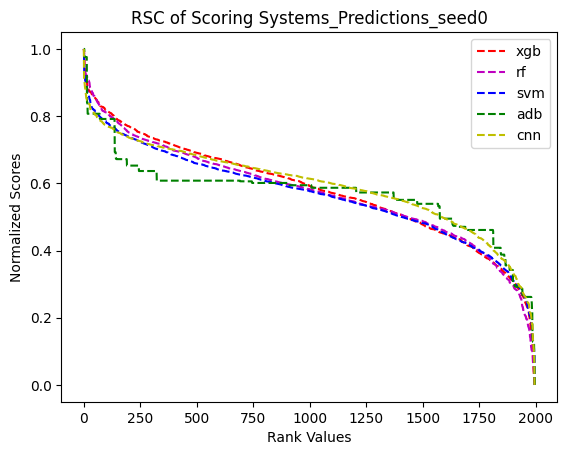

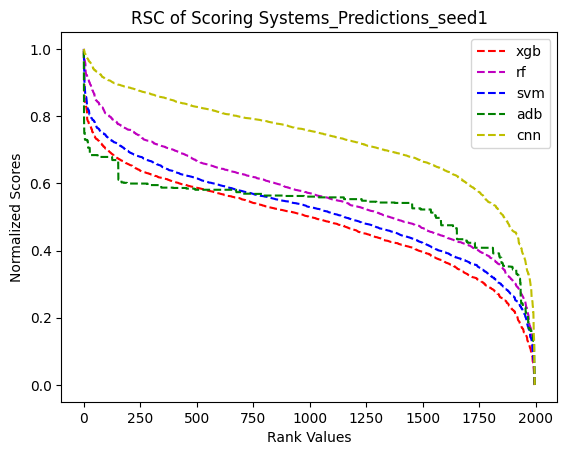

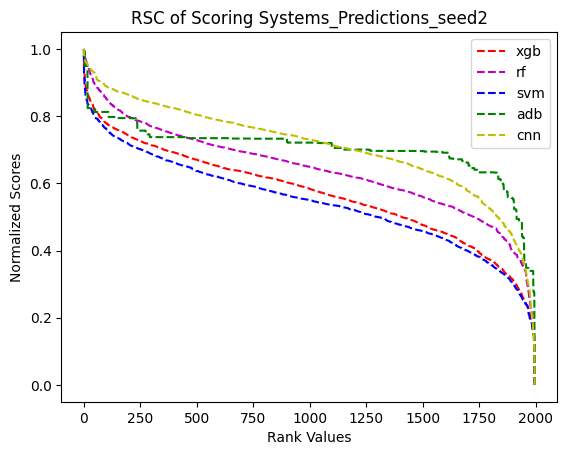

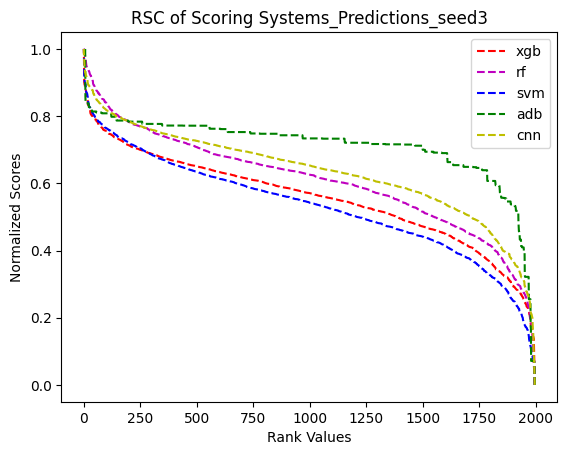

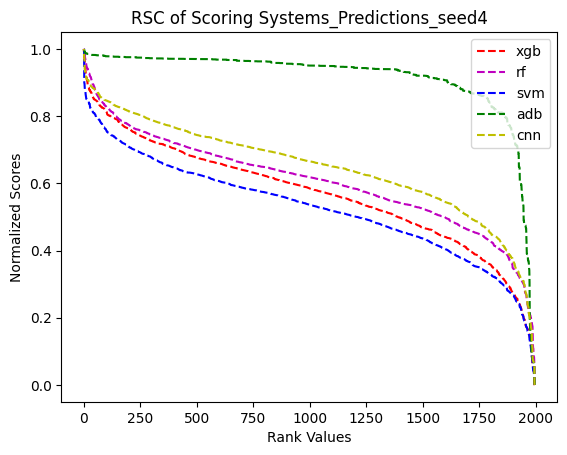

In [16]:
# RSC graphs
colors = ['r--', 'm--', 'b--', 'g--', 'y--']
ranks = np.flip(np.arange(len(predictions_xgb[0])))

for seed in range(len(globals()['predictions_list_%s' % sys])):
  for z in range(len(scoreSys)):
    globals()['line%s' % (z+1)] = plt.plot(ranks, np.sort(normalize(globals()['predictions_%s' % scoreSys[z]][seed])), colors[z], label = scoreSys[z])
    plt.legend(loc = 'upper right')
    plt.title('RSC of Scoring Systems_Predictions_seed%s' % seed)
    plt.xlabel('Rank Values')
    plt.ylabel('Normalized Scores')
  plt.show()


In [17]:
ds_score = [[] for _ in range(5)]

In [18]:
for sys in scoreSys:
  for seed in range(len(ds_score)):
    loc = scoreSys.index(sys)
    scoreSys.remove(sys)
    ds = 0
    for i in range(len(scoreSys)):
      ds += np.sum(np.square(normalize(np.sort(globals()['predictions_%s' % sys][seed]))-normalize(np.sort(globals()['predictions_%s' % scoreSys[i]][seed]))))
    ds = ds/len(scoreSys)
    scoreSys.insert(loc, sys)
    ds_score[seed].append(ds)

In [19]:
ds_score

[[2.7468511423522197,
  2.3655176560705495,
  2.0780272365818773,
  5.69999135154968,
  2.6188974967644425],
 [37.88010126811753,
  21.937861880697483,
  27.45154845081947,
  28.860732765608173,
  89.2435209956344],
 [24.911116496178476,
  14.058578486497485,
  34.376503240294774,
  33.51632022634322,
  28.658885894278313],
 [19.658870293649507,
  13.356075543864108,
  28.583002877780714,
  46.80849459658486,
  14.036387729999637],
 [70.91769636332367,
  57.521110172794884,
  92.92484335562345,
  239.01043302690286,
  51.55172239726206]]

In [23]:
ds_rank = np.reciprocal(ds_score)

In [24]:
def mean_absolute_error(y_pred, y_test):
  res = np.mean(np.abs(y_pred - y_test))
  return res

In [25]:
ps_score = [[] for _ in range(5)]

In [26]:
for sys in scoreSys:
  for seed in range(len(ps_score)):
    ps = mean_absolute_error(globals()['predictions_%s' % sys][seed], y_test)
    ps_score[seed].append(ps)

In [27]:
def powerset(s):
    x = len(s)
    ls = []
    for i in range(1 << x):
        ls.append([s[j] for j in range(x) if (i & (1 << j))])
    return ls[1:]

models = powerset(scoreSys)

def myFunc(e):
  return len(e)

models.sort(key=myFunc)

models_list = []
for i in range(len(models)):
  if len(models[i]) == 1:
    models_list.append(models[i][0])
  elif len(models[i]) == 2:
    models_list.append(models[i][0]+'&'+models[i][1])
  elif len(models[i]) == 3:
    models_list.append(models[i][0]+'&'+models[i][1]+'&'+models[i][2])
  elif len(models[i]) == 4:
    models_list.append(models[i][0]+'&'+models[i][1]+'&'+models[i][2]+'&'+models[i][3])
  elif len(models[i]) == 5:
    models_list.append(models[i][0]+'&'+models[i][1]+'&'+models[i][2]+'&'+models[i][3]+'&'+models[i][4])

# Perform average score combinations

In [29]:
avg_score_combine_seed1 = pd.DataFrame({'xgb':predictions_xgb[0], 'rf':predictions_rf[0], 'svm':predictions_svm[0], 'adb':predictions_adb[0], 'cnn':predictions_cnn[0]})
avg_score_combine_seed2 = pd.DataFrame({'xgb':predictions_xgb[1], 'rf':predictions_rf[1], 'svm':predictions_svm[1], 'adb':predictions_adb[1], 'cnn':predictions_cnn[1]})
avg_score_combine_seed3 = pd.DataFrame({'xgb':predictions_xgb[2], 'rf':predictions_rf[2], 'svm':predictions_svm[2], 'adb':predictions_adb[2], 'cnn':predictions_cnn[2]})
avg_score_combine_seed4 = pd.DataFrame({'xgb':predictions_xgb[3], 'rf':predictions_rf[3], 'svm':predictions_svm[3], 'adb':predictions_adb[3], 'cnn':predictions_cnn[3]})
avg_score_combine_seed5 = pd.DataFrame({'xgb':predictions_xgb[4], 'rf':predictions_rf[4], 'svm':predictions_svm[4], 'adb':predictions_adb[4], 'cnn':predictions_cnn[4]})

In [30]:
def avg_score_combine(models_list, single_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]) / 2
    elif len(j.split('&')) == 3:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]+single_score[j.split('&')[2]]) / 3
    elif len(j.split('&')) == 4:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]+single_score[j.split('&')[2]]+single_score[j.split('&')[3]]) / 4
    elif len(j.split('&')) == 5:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]+single_score[j.split('&')[2]]+single_score[j.split('&')[3]]+single_score[j.split('&')[4]]) / 5

In [31]:
avg_score_combine(models_list, avg_score_combine_seed1)
avg_score_combine(models_list, avg_score_combine_seed2)
avg_score_combine(models_list, avg_score_combine_seed3)
avg_score_combine(models_list, avg_score_combine_seed4)
avg_score_combine(models_list, avg_score_combine_seed5)

# Perform average rank combinations

In [32]:
avg_rank_combine_seed1 = pd.DataFrame({'xgb':score_to_rank(predictions_xgb[0]), 'rf':score_to_rank(predictions_rf[0]), 'svm':score_to_rank(predictions_svm[0]), 'adb':score_to_rank(predictions_adb[0]), 'cnn':score_to_rank(predictions_cnn[0])})
avg_rank_combine_seed2 = pd.DataFrame({'xgb':score_to_rank(predictions_xgb[1]), 'rf':score_to_rank(predictions_rf[1]), 'svm':score_to_rank(predictions_svm[1]), 'adb':score_to_rank(predictions_adb[1]), 'cnn':score_to_rank(predictions_cnn[1])})
avg_rank_combine_seed3 = pd.DataFrame({'xgb':score_to_rank(predictions_xgb[2]), 'rf':score_to_rank(predictions_rf[2]), 'svm':score_to_rank(predictions_svm[2]), 'adb':score_to_rank(predictions_adb[2]), 'cnn':score_to_rank(predictions_cnn[2])})
avg_rank_combine_seed4 = pd.DataFrame({'xgb':score_to_rank(predictions_xgb[3]), 'rf':score_to_rank(predictions_rf[3]), 'svm':score_to_rank(predictions_svm[3]), 'adb':score_to_rank(predictions_adb[3]), 'cnn':score_to_rank(predictions_cnn[3])})
avg_rank_combine_seed5 = pd.DataFrame({'xgb':score_to_rank(predictions_xgb[4]), 'rf':score_to_rank(predictions_rf[4]), 'svm':score_to_rank(predictions_svm[4]), 'adb':score_to_rank(predictions_adb[4]), 'cnn':score_to_rank(predictions_cnn[4])})

In [33]:
def avg_rank_combine(models_list, single_rank):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]) / 2
    elif len(j.split('&')) == 3:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]+single_rank[j.split('&')[2]]) / 3
    elif len(j.split('&')) == 4:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]+single_rank[j.split('&')[2]]+single_rank[j.split('&')[3]]) / 4
    elif len(j.split('&')) == 5:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]+single_rank[j.split('&')[2]]+single_rank[j.split('&')[3]]+single_rank[j.split('&')[4]]) / 5

In [34]:
avg_rank_combine(models_list, avg_rank_combine_seed1)
avg_rank_combine(models_list, avg_rank_combine_seed2)
avg_rank_combine(models_list, avg_rank_combine_seed3)
avg_rank_combine(models_list, avg_rank_combine_seed4)
avg_rank_combine(models_list, avg_rank_combine_seed5)

# Perform weighted score combination by diversity strength

In [35]:
ds_score_combine_seed1 = pd.DataFrame()
ds_score_combine_seed2 = pd.DataFrame()
ds_score_combine_seed3 = pd.DataFrame()
ds_score_combine_seed4 = pd.DataFrame()
ds_score_combine_seed5 = pd.DataFrame()

In [36]:
def ds_score_combine(models_list, single_score, ds_score_combine, ds_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])]+single_score[j.split('&')[2]]*ds_score[scoreSys.index(j.split('&')[2])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])] + ds_score[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])]+single_score[j.split('&')[2]]*ds_score[scoreSys.index(j.split('&')[2])]+single_score[j.split('&')[3]]*ds_score[scoreSys.index(j.split('&')[3])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])] + ds_score[scoreSys.index(j.split('&')[2])] + ds_score[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])]+single_score[j.split('&')[2]]*ds_score[scoreSys.index(j.split('&')[2])]+single_score[j.split('&')[3]]*ds_score[scoreSys.index(j.split('&')[3])]+single_score[j.split('&')[4]]*ds_score[scoreSys.index(j.split('&')[4])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])] + ds_score[scoreSys.index(j.split('&')[2])] + ds_score[scoreSys.index(j.split('&')[3])] + ds_score[scoreSys.index(j.split('&')[4])])

In [37]:
ds_score_combine(models_list, avg_score_combine_seed1, ds_score_combine_seed1, ds_score[0])
ds_score_combine(models_list, avg_score_combine_seed2, ds_score_combine_seed2, ds_score[1])
ds_score_combine(models_list, avg_score_combine_seed3, ds_score_combine_seed3, ds_score[2])
ds_score_combine(models_list, avg_score_combine_seed4, ds_score_combine_seed4, ds_score[3])
ds_score_combine(models_list, avg_score_combine_seed5, ds_score_combine_seed5, ds_score[4])

# Perform weighted rank combination by diversity strength

In [38]:
ds_rank_combine_seed1 = pd.DataFrame()
ds_rank_combine_seed2 = pd.DataFrame()
ds_rank_combine_seed3 = pd.DataFrame()
ds_rank_combine_seed4 = pd.DataFrame()
ds_rank_combine_seed5 = pd.DataFrame()

In [39]:
def ds_rank_combine(models_list, single_rank, ds_rank_combine, ds_rank):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])]+single_rank[j.split('&')[2]]*ds_rank[scoreSys.index(j.split('&')[2])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])] + ds_rank[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])]+single_rank[j.split('&')[2]]*ds_rank[scoreSys.index(j.split('&')[2])]+single_rank[j.split('&')[3]]*ds_rank[scoreSys.index(j.split('&')[3])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])] + ds_rank[scoreSys.index(j.split('&')[2])] + ds_rank[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])]+single_rank[j.split('&')[2]]*ds_rank[scoreSys.index(j.split('&')[2])]+single_rank[j.split('&')[3]]*ds_rank[scoreSys.index(j.split('&')[3])]+single_rank[j.split('&')[4]]*ds_rank[scoreSys.index(j.split('&')[4])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])] + ds_rank[scoreSys.index(j.split('&')[2])] + ds_rank[scoreSys.index(j.split('&')[3])] + ds_rank[scoreSys.index(j.split('&')[4])])

In [40]:
ds_rank_combine(models_list, avg_rank_combine_seed1, ds_rank_combine_seed1, ds_rank[0])
ds_rank_combine(models_list, avg_rank_combine_seed2, ds_rank_combine_seed2, ds_rank[1])
ds_rank_combine(models_list, avg_rank_combine_seed3, ds_rank_combine_seed3, ds_rank[2])
ds_rank_combine(models_list, avg_rank_combine_seed4, ds_rank_combine_seed4, ds_rank[3])
ds_rank_combine(models_list, avg_rank_combine_seed5, ds_rank_combine_seed5, ds_rank[4])

# Perform weighted score combination by performance strength (MAE)

In [41]:
ps_score_combine_seed1 = pd.DataFrame()
ps_score_combine_seed2 = pd.DataFrame()
ps_score_combine_seed3 = pd.DataFrame()
ps_score_combine_seed4 = pd.DataFrame()
ps_score_combine_seed5 = pd.DataFrame()

In [42]:
def ps_score_combine(models_list, single_score, ps_score_combine, ps_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])])+single_score[j.split('&')[2]]*(1 / ps_score[scoreSys.index(j.split('&')[2])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])] + 1 / ps_score[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])])+single_score[j.split('&')[2]]*(1 / ps_score[scoreSys.index(j.split('&')[2])])+single_score[j.split('&')[3]]*(1 / ps_score[scoreSys.index(j.split('&')[3])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])] + 1 / ps_score[scoreSys.index(j.split('&')[2])] + ps_score[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])])+single_score[j.split('&')[2]]*(1 / ps_score[scoreSys.index(j.split('&')[2])])+single_score[j.split('&')[3]]*(1 / ps_score[scoreSys.index(j.split('&')[3])])+single_score[j.split('&')[4]]*(1 / ps_score[scoreSys.index(j.split('&')[4])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])] + 1 / ps_score[scoreSys.index(j.split('&')[2])] + 1 / ps_score[scoreSys.index(j.split('&')[3])] + 1 / ps_score[scoreSys.index(j.split('&')[4])])

In [43]:
ps_score_combine(models_list, avg_score_combine_seed1, ps_score_combine_seed1, ps_score[0])
ps_score_combine(models_list, avg_score_combine_seed2, ps_score_combine_seed2, ps_score[1])
ps_score_combine(models_list, avg_score_combine_seed3, ps_score_combine_seed3, ps_score[2])
ps_score_combine(models_list, avg_score_combine_seed4, ps_score_combine_seed4, ps_score[3])
ps_score_combine(models_list, avg_score_combine_seed5, ps_score_combine_seed5, ps_score[4])

# Perform weighted rank combination by performance strength

In [44]:
ps_rank_combine_seed1 = pd.DataFrame()
ps_rank_combine_seed2 = pd.DataFrame()
ps_rank_combine_seed3 = pd.DataFrame()
ps_rank_combine_seed4 = pd.DataFrame()
ps_rank_combine_seed5 = pd.DataFrame()

In [45]:
def ps_rank_combine(models_list, single_rank, ps_rank_combine, ps_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])])+single_rank[j.split('&')[2]]*(ps_score[scoreSys.index(j.split('&')[2])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])] + ps_score[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])])+single_rank[j.split('&')[2]]*(ps_score[scoreSys.index(j.split('&')[2])])+single_rank[j.split('&')[3]]*(ps_score[scoreSys.index(j.split('&')[3])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])] + ps_score[scoreSys.index(j.split('&')[2])] + ps_score[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])])+single_rank[j.split('&')[2]]*(ps_score[scoreSys.index(j.split('&')[2])])+single_rank[j.split('&')[3]]*(ps_score[scoreSys.index(j.split('&')[3])])+single_rank[j.split('&')[4]]*(ps_score[scoreSys.index(j.split('&')[4])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])] + ps_score[scoreSys.index(j.split('&')[2])] + ps_score[scoreSys.index(j.split('&')[3])] + ps_score[scoreSys.index(j.split('&')[4])])

In [46]:
ps_rank_combine(models_list, avg_rank_combine_seed1, ps_rank_combine_seed1, ps_score[0])
ps_rank_combine(models_list, avg_rank_combine_seed2, ps_rank_combine_seed2, ps_score[1])
ps_rank_combine(models_list, avg_rank_combine_seed3, ps_rank_combine_seed3, ps_score[2])
ps_rank_combine(models_list, avg_rank_combine_seed4, ps_rank_combine_seed4, ps_score[3])
ps_rank_combine(models_list, avg_rank_combine_seed5, ps_rank_combine_seed5, ps_score[4])

In [47]:
avg_rank_combine_seed1.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed2.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed3.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed4.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed5.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)

# Calculate MAE

In [48]:
score_combine_list = np.hstack((np.array(avg_score_combine_seed1.columns), np.array(ds_score_combine_seed1.columns), np.array(ps_score_combine_seed1.columns)))
MAE = pd.DataFrame(index = score_combine_list)
for i in range(1, 6):
  mae_avg, mae_ds, mae_ps = [], [], []
  for col in globals()['avg_score_combine_seed%s' %i].columns:
    mae = mean_absolute_error(np.array(globals()['avg_score_combine_seed%s' %i][col]), y_test)
    mae_avg.append(mae)
  for col in globals()['ds_score_combine_seed%s' %i].columns:
    mae = mean_absolute_error(np.array(globals()['ds_score_combine_seed%s' %i][col]), y_test)
    mae_ds.append(mae)
  for col in globals()['ps_score_combine_seed%s' %i].columns:
    mae = mean_absolute_error(np.array(globals()['ps_score_combine_seed%s' %i][col]), y_test)
    mae_ps.append(mae)
  MAE['seed'+str(i)] = np.hstack((mae_avg, mae_ds, mae_ps))

In [49]:
pd.set_option('display.max_rows', None)

In [50]:
MAE['avg_MAE'] = MAE.mean(axis=1)

In [51]:
MAE.sort_values(by='avg_MAE')

,seed1,seed2,seed3,seed4,seed5,avg_MAE
xgb&svm&cnn_ps,1.175254,1.189296,1.166353,1.176622,1.150529,1.171611
xgb&svm&cnn,1.175533,1.189670,1.166559,1.176832,1.151802,1.172079
xgb&svm&cnn_ds,1.177045,1.214819,1.169389,1.176325,1.147247,1.176965
xgb&rf&svm&cnn_ds,1.211622,1.204063,1.173290,1.190994,1.162743,1.188543
xgb&cnn_ps,1.192356,1.204854,1.180990,1.194896,1.172241,1.189067
xgb&cnn,1.192464,1.206193,1.181241,1.194976,1.174195,1.189814
xgb&svm_ps,1.207417,1.217391,1.185758,1.196590,1.145419,1.190515
xgb&svm,1.208351,1.217400,1.185786,1.196892,1.145417,1.190769
xgb&svm_ds,1.214343,1.218833,1.188664,1.194747,1.146109,1.192539
xgb&rf&svm&cnn,1.211426,1.206081,1.186616,1.199295,1.171060,1.194896
